# Rocket Kommerce Assignment
Submitted by : Adamya Tripathi

## Problem Statement
- Meera Enterprises is a multinational Trading company which is selling household, personal care, eatables, office supplies and other essential items over both offline and online modes. Purchase cost for all the items keeps varying periodically by its Vendors.
- The company will procure from vendors as soon as it starts receiving orders from customers and the TAT for shipment of orders has different priorities depending on the mode of purchase (Offline or Online).
- Meera Enterprises promises to give away good will amount if they exceed the TAT for shipment of orders based on the purchase order value.

Please share your recommendation and analysis for the data?

__Note :__ _For optimum output and smooth processing of data wrangling, I have take the liberties to make some miniscule changes in the format of certain columns of the datsets in the Excel, which aren't shown in the Notebook. 
Like, adding "End_Year" column in the Exchange Data column and normalising INR values by dividing them with number of USD units. 
A quick glance at the below datasets will show that most of the changes are made to facilitate easy reading of the datasets in CSV format._

In [182]:
# Step 0 : Importing necessary libraries
import pandas as pd 
import numpy as np
import os
import sys
import datetime as dt 
from datetime import datetime, timedelta, date
import matplotlib.pyplot as plt 
%matplotlib inline

In [136]:
## Step 1 : Reading all the datasets

sales_data = pd.read_csv('C:/Users/adamya.tripathi/Downloads/Resumes/RK/Sales_Data.csv')
purchase_data = pd.read_csv("C:/Users/adamya.tripathi/Downloads/Resumes/RK/Purchase_Data.csv")
shipment_data = pd.read_csv("C:/Users/adamya.tripathi/Downloads/Resumes/RK/Shipment_Annexure.csv")
goodwill_data = pd.read_csv("C:/Users/adamya.tripathi/Downloads/Resumes/RK/Goodwill_Annexure.csv")
exchange_rate_data = pd.read_csv("C:/Users/adamya.tripathi/Downloads/Resumes/RK/Exchange_Rate.csv")
exchange_rate_data.dropna(inplace=True, axis=1)


# Dropping the example row 
sales_data.drop(sales_data[sales_data['Item Type'] == "Example"].index, inplace = True) 

In [137]:
display(sales_data.head())
display(purchase_data.head())
display(shipment_data.head())
display(goodwill_data.head())
display(exchange_rate_data.head())

Region                Country      Item Type  \
1       Middle East and North Africa             Azerbaijan         Snacks   
2  Central America and the Caribbean                 Panama      Cosmetics   
3                 Sub-Saharan Africa  Sao Tome and Principe         Fruits   
4                 Sub-Saharan Africa  Sao Tome and Principe  Personal Care   
5  Central America and the Caribbean                 Belize      Household   

  Sales Channel Order Priority Order Date (mm-dd-yyyy)   Order ID  \
1        Online              C                   41861  535113847   
2       Offline              L               2/22/2015  874708545   
3       Offline              M                   42259  854349935   
4        Online              M               9/17/2014  892836844   
5       Offline              H                   40270  129280602   

  Ship Date (mm-dd-yyyy)  Units Sold  Sale Price Per Unit (USD)  
1             10/23/2014         934                     152.58  
2              2/27/2015        4551                     437.20  
3              1/18/2016        9986                       9.33  
4                  41983        9118                      81.73  
5                  40301        5858                     668.27

Item Type Purchase Start Date Purchase End Date  Cost Per Unit (USD)
0  Baby Food          2010-01-01        2010-05-01             158.2736
1  Beverages          2010-01-01        2010-05-01              36.0620
2     Cereal          2010-01-01        2010-05-01             160.4460
3    Clothes          2010-01-01        2010-05-01              66.6608
4  Cosmetics          2010-01-01        2010-05-01             266.6920

Priority  Offline  Online
0        C        5       3
1        H        7       5
2        L        9       7
3        M       11       9

Min      Max  4_Days  5_Days  6_Days  GT_7_Days
0  1000019  1100018     100     105     110        115
1  1100019  1200018     101     106     111        116
2  1200019  1300018     102     107     112        117
3  1300019  1400018     103     108     113        118
4  1400019  1500018     104     109     114        119

StartYear     EndYear  USD  Clean_Rate
0  2010-01-01  2010-12-31    1       68.00
1  2011-01-01  2011-12-31    1       69.53
2  2012-01-01  2012-12-31    1       72.00
3  2013-01-01  2013-12-31    1       67.00
4  2014-01-01  2014-12-31    1       68.94

In [138]:
## Step 2.1 : Creating a function to clean the dates! All the dates will be converted to the common standard of yyyy-mm-dd

def simplify_date(val):
    jan_01_1900 = dt.date(int(1900), int(1), int(1))
    
    if len(str(val)) <6:
        d = jan_01_1900 + timedelta(int(val))
        
        #print("Numerical date-->",str(val),"---->",d )
        return d
    
    else:
        d = str(val)
        
        #print("Normal date ", str(val), "----> ", d.split("/"))
        return datetime.strptime(d, "%m/%d/%Y").date()

In [139]:
## Step 2.2 : Creating a column for delayed time in 'days' unit
def delayed_by(row):
    ship_date,order_date  = row['Clean_Ship_Date'],  row['Clean_Order_Date']
    return (ship_date,order_date).dt.days

In [149]:
## Step 2.3 : Creating a function to find the Unit Cost of an Item, basis the Order Date and Item Type

def cost_per_unit(row):
    item,order_date = row['Item Type'], row['Clean_Order_Date'] 
    #print("item = ", item)
    #print('order_date = ', order_date)
    purchase_data_for_item = purchase_data[purchase_data['Item Type']==item]
    #print(purchase_data_for_item)
    
    cost_per_unit = purchase_data_for_item[(purchase_data_for_item["Purchase Start Date"] <= order_date) & (purchase_data_for_item["Purchase End Date"] >= order_date) ]
    
    #print(cost_per_unit['Cost Per Unit (USD)'].values[0], type(cost_per_unit['Cost Per Unit (USD)']))
    return cost_per_unit['Cost Per Unit (USD)'].values[0]

#d= datetime.strptime('2012-01-01','%Y-%m-%d').date()
#print(cost_per_unit("Snacks", d))


In [141]:
## Step 2.4 : Creating a function to find the desired Turn-Around_Time of the ship

def shipment_tat(row):
    priority,channel = row['Order Priority'], row['Sales Channel'] 
    #print("priority = ", priority)
    #print('channel = ', channel)
    shipment_data_for_priority = shipment_data[shipment_data['Priority']==priority]
    
    #print(annexure_data_for_priority)
    
    
    #print(annexure_data_for_priority[str(channel)].values[0], type(annexure_data_for_priority[str(channel)]))
    return shipment_data_for_priority[str(channel)].values[0]

In [142]:
## Step 2.5 : Creating a function to calculate Order_Value basis Number of Units sole and Sales Price per Unit
def ov(row):
    return row["Units Sold"]*row["Sale Price Per Unit (USD)"]

In [143]:
## Step 2.6 : Creating a function to encode numerical values of delay in a string format
def encode_delay(val):
    if val<4:
        return "NoDelay"
    elif val==4:
        return "4_Days"
    elif val==5:
        return "5_Days"
    elif val==6:
        return "6_Days"
    else :
        return "GT_7_Days"

In [160]:
## Step 2.7 :Creating a function to calculate GoodWill value basis Order Value and Amount of delay in days.

def goodwill(row):
    ov,delay = row['Order_Value'], row['Encoded_Delay'] 
    #print("ov = ", ov)
    #print('delay = ', delay)
    if (int(ov) >= min(goodwill_data['Min'])) & (int(ov) <= max(goodwill_data['Max'])) and delay != "NoDelay":
        goodwill_data_for_ov = goodwill_data[(goodwill_data['Min'] < int(ov)) & (goodwill_data["Max"] >= int(ov))]
        #print(">> ", goodwill_data_for_ov)
        goodwill_amt = goodwill_data_for_ov[str(delay)]
        #print(goodwill_amt.values[0], type(goodwill_amt))
        return goodwill_amt.values[0]
    else:
        return 0 

In [145]:
## Step 2.8 : Creating the function to populate INR Exchange values as per the Order Date

exchange_rate_data["StartYear"] = pd.to_datetime(exchange_rate_data["StartYear"], format="%Y-%m-%d").dt.date
exchange_rate_data["EndYear"] = pd.to_datetime(exchange_rate_data["EndYear"], format="%Y-%m-%d").dt.date

def forex(order_date):
    #print(order_date, type(order_date))

    if order_date < datetime.strptime('2010-01-01','%Y-%m-%d').date() :
        return exchange_rate_data[exchange_rate_data["StartYear"] == datetime.strptime('2010-01-01','%Y-%m-%d').date()]["Clean_Rate"].values[0]
    
    if (order_date >= min(exchange_rate_data["StartYear"])) & (order_date <= max(exchange_rate_data["EndYear"])):
        sub_data = exchange_rate_data[(exchange_rate_data['StartYear'] <= order_date)&(exchange_rate_data['EndYear'] >= order_date)]
        #print("sub_data = ", sub_data)
        return sub_data["Clean_Rate"].values[0]
    else:
        return exchange_rate_data[exchange_rate_data["StartYear"] == datetime.strptime('2020-01-01','%Y-%m-%d').date()]["Clean_Rate"].values[0]

#print(forex(datetime.strptime('2009-01-01','%Y-%m-%d').date()))
#print(forex(datetime.strptime('2012-12-31','%Y-%m-%d').date())) #2012-12-31
#print(forex(datetime.strptime('2020-03-04','%Y-%m-%d').date()))


----
After creating all the necessary functions, let's execute them to create the final columns. 

In [146]:
# Step 3.1 : Standardising and Cleaning the date columns in the Sales Data

sales_data['Clean_Order_Date'] = sales_data['Order Date (mm-dd-yyyy)'].apply(lambda x: simplify_date(x))
sales_data['Clean_Ship_Date'] = sales_data['Ship Date (mm-dd-yyyy)'].apply(lambda x: simplify_date(x))

In [150]:
# Step 3.2 : Adding the Delayed_By_Days column in Sales Data

sales_data['Delayed_By_Days'] = (sales_data['Clean_Ship_Date'] - sales_data['Clean_Order_Date']).dt.days

In [151]:
# Step 3.3 : Adding the Cost Per Unit column basis the  Order Date and Item Type

purchase_data["Purchase Start Date"] = pd.to_datetime(purchase_data["Purchase Start Date"], format="%Y-%m-%d").dt.date
purchase_data["Purchase End Date"] = pd.to_datetime(purchase_data["Purchase End Date"], format="%Y-%m-%d").dt.date

sales_data['Cost_per_Unit'] = sales_data.apply(cost_per_unit, axis = 1 )


In [152]:
# Step 3.4 : Adding the Shipment_Turn_Around_Time column basis the Order Date and Item Type

sales_data['Shipment_TAT'] = sales_data.apply(shipment_tat, axis = 1 )

display(sales_data.head())

Region                Country      Item Type  \
1       Middle East and North Africa             Azerbaijan         Snacks   
2  Central America and the Caribbean                 Panama      Cosmetics   
3                 Sub-Saharan Africa  Sao Tome and Principe         Fruits   
4                 Sub-Saharan Africa  Sao Tome and Principe  Personal Care   
5  Central America and the Caribbean                 Belize      Household   

  Sales Channel Order Priority Order Date (mm-dd-yyyy)   Order ID  \
1        Online              C                   41861  535113847   
2       Offline              L               2/22/2015  874708545   
3       Offline              M                   42259  854349935   
4        Online              M               9/17/2014  892836844   
5       Offline              H                   40270  129280602   

  Ship Date (mm-dd-yyyy)  Units Sold  Sale Price Per Unit (USD)  \
1             10/23/2014         934                     152.58   
2              2/27/2015        4551                     437.20   
3              1/18/2016        9986                       9.33   
4                  41983        9118                      81.73   
5                  40301        5858                     668.27   

  Clean_Order_Date Clean_Ship_Date  Delayed_By_Days  Cost_per_Unit  \
1       2014-08-12      2014-10-23               72        91.5480   
2       2015-02-22      2015-02-27                5       284.1800   
3       2015-09-14      2016-01-18              126         6.2511   
4       2014-09-17      2014-12-12               86        64.5667   
5       2010-04-04      2010-05-05               31       467.7890   

   Shipment_TAT  
1             3  
2             9  
3            11  
4             9  
5             7

In [153]:
# Step 3.5: Adding the Order_Value column basis Number of Units sole and Sales Price per Unit

sales_data["Order_Value"] = sales_data.apply(ov, axis = 1 )
sales_data.head()

Region                Country      Item Type  \
1       Middle East and North Africa             Azerbaijan         Snacks   
2  Central America and the Caribbean                 Panama      Cosmetics   
3                 Sub-Saharan Africa  Sao Tome and Principe         Fruits   
4                 Sub-Saharan Africa  Sao Tome and Principe  Personal Care   
5  Central America and the Caribbean                 Belize      Household   

  Sales Channel Order Priority Order Date (mm-dd-yyyy)   Order ID  \
1        Online              C                   41861  535113847   
2       Offline              L               2/22/2015  874708545   
3       Offline              M                   42259  854349935   
4        Online              M               9/17/2014  892836844   
5       Offline              H                   40270  129280602   

  Ship Date (mm-dd-yyyy)  Units Sold  Sale Price Per Unit (USD)  \
1             10/23/2014         934                     152.58   
2              2/27/2015        4551                     437.20   
3              1/18/2016        9986                       9.33   
4                  41983        9118                      81.73   
5                  40301        5858                     668.27   

  Clean_Order_Date Clean_Ship_Date  Delayed_By_Days  Cost_per_Unit  \
1       2014-08-12      2014-10-23               72        91.5480   
2       2015-02-22      2015-02-27                5       284.1800   
3       2015-09-14      2016-01-18              126         6.2511   
4       2014-09-17      2014-12-12               86        64.5667   
5       2010-04-04      2010-05-05               31       467.7890   

   Shipment_TAT  Order_Value  
1             3    142509.72  
2             9   1989697.20  
3            11     93169.38  
4             9    745214.14  
5             7   3914725.66

In [154]:
# Step 3.6: Adding the Encoded_Delay column to convert numeric Delay_By_Days column to character

sales_data['Encoded_Delay'] = sales_data['Delayed_By_Days'].apply(lambda x : encode_delay(x))

In [155]:
# Step 3.7: Adding the Goodill_Amt column basis the Shipment_TAT and OrderValue

sales_data["Goodwill_Amt"] = sales_data.apply(goodwill, axis = 1)

ov =  142509.72
delay =  GT_7_Days
ov =  1989697.2
delay =  5_Days
>>         Min      Max  4_Days  5_Days  6_Days  GT_7_Days
9  1900019  2000018     109     114     119        124
114 <class 'pandas.core.series.Series'>
ov =  93169.38
delay =  GT_7_Days
ov =  745214.14
delay =  GT_7_Days
ov =  3914725.6599999997
delay =  GT_7_Days
ov =  125562.72
delay =  GT_7_Days
ov =  3481860.8
delay =  NoDelay
ov =  58844.31
delay =  GT_7_Days
ov =  1253749.86
delay =  GT_7_Days
>>         Min      Max  4_Days  5_Days  6_Days  GT_7_Days
2  1200019  1300018     102     107     112        117
117 <class 'pandas.core.series.Series'>
ov =  1205797.5999999999
delay =  NoDelay
ov =  450753.2
delay =  GT_7_Days
ov =  127311.2
delay =  GT_7_Days
ov =  2219992.94
delay =  NoDelay
ov =  3136191.11
delay =  NoDelay
ov =  693578.12
delay =  GT_7_Days
ov =  5863494.840000001
delay =  NoDelay
ov =  60514.38
delay =  GT_7_Days
ov =  348791.84
delay =  GT_7_Days
ov =  174995.6
delay =  NoDelay
ov =  3345265.77
de

ov =  902324.96
delay =  NoDelay
ov =  2471341.95
delay =  GT_7_Days
>>          Min      Max  4_Days  5_Days  6_Days  GT_7_Days
14  2400019  2500018     114     119     124        129
129 <class 'pandas.core.series.Series'>
ov =  452474.22000000003
delay =  GT_7_Days
ov =  47450.0
delay =  GT_7_Days
ov =  2250361.26
delay =  GT_7_Days
>>          Min      Max  4_Days  5_Days  6_Days  GT_7_Days
12  2200019  2300018     112     117     122        127
127 <class 'pandas.core.series.Series'>
ov =  48991.08
delay =  NoDelay
ov =  193127.99000000002
delay =  GT_7_Days
ov =  2072323.68
delay =  GT_7_Days
>>          Min      Max  4_Days  5_Days  6_Days  GT_7_Days
10  2000019  2100018     110     115     120        125
125 <class 'pandas.core.series.Series'>
ov =  524570.04
delay =  GT_7_Days
ov =  68203.26000000001
delay =  GT_7_Days
ov =  207232.8
delay =  GT_7_Days
ov =  555798.08
delay =  NoDelay
ov =  1621533.0999999999
delay =  GT_7_Days
>>         Min      Max  4_Days  5_Days  6_Days  

delay =  NoDelay
ov =  45138.54
delay =  NoDelay
ov =  281069.47000000003
delay =  GT_7_Days
ov =  924827.2
delay =  GT_7_Days
ov =  55830.72
delay =  GT_7_Days
ov =  597969.9
delay =  GT_7_Days
ov =  587399.28
delay =  NoDelay
ov =  673046.55
delay =  NoDelay
ov =  1048378.3
delay =  GT_7_Days
>>         Min      Max  4_Days  5_Days  6_Days  GT_7_Days
0  1000019  1100018     100     105     110        115
115 <class 'pandas.core.series.Series'>
ov =  764500.88
delay =  GT_7_Days
ov =  700484.8
delay =  NoDelay
ov =  1224833.44
delay =  GT_7_Days
>>         Min      Max  4_Days  5_Days  6_Days  GT_7_Days
2  1200019  1300018     102     107     112        117
117 <class 'pandas.core.series.Series'>
ov =  81651.8
delay =  NoDelay
ov =  999907.7
delay =  GT_7_Days
ov =  221744.59999999998
delay =  GT_7_Days
ov =  1463261.8800000001
delay =  GT_7_Days
>>         Min      Max  4_Days  5_Days  6_Days  GT_7_Days
4  1400019  1500018     104     109     114        119
119 <class 'pandas.core.se

delay =  NoDelay
ov =  7814.52
delay =  5_Days
ov =  6075242.57
delay =  GT_7_Days
ov =  501496.6
delay =  NoDelay
ov =  1083265.67
delay =  GT_7_Days
>>         Min      Max  4_Days  5_Days  6_Days  GT_7_Days
0  1000019  1100018     100     105     110        115
115 <class 'pandas.core.series.Series'>
ov =  60756.64
delay =  GT_7_Days
ov =  974668.3200000001
delay =  GT_7_Days
ov =  212294.46000000002
delay =  NoDelay
ov =  2773988.77
delay =  NoDelay
ov =  1414727.5899999999
delay =  GT_7_Days
>>         Min      Max  4_Days  5_Days  6_Days  GT_7_Days
4  1400019  1500018     104     109     114        119
119 <class 'pandas.core.series.Series'>
ov =  454535.82000000007
delay =  NoDelay
ov =  4899704.04
delay =  NoDelay
ov =  2384387.36
delay =  GT_7_Days
>>          Min      Max  4_Days  5_Days  6_Days  GT_7_Days
13  2300019  2400018     113     118     123        128
128 <class 'pandas.core.series.Series'>
ov =  78542.53
delay =  GT_7_Days
ov =  2877650.4
delay =  GT_7_Days
>>     

>>         Min      Max  4_Days  5_Days  6_Days  GT_7_Days
0  1000019  1100018     100     105     110        115
115 <class 'pandas.core.series.Series'>
ov =  4004157.9899999998
delay =  NoDelay
ov =  2516036.55
delay =  NoDelay
ov =  279975.36
delay =  GT_7_Days
ov =  469030.92000000004
delay =  GT_7_Days
ov =  696967.4400000001
delay =  NoDelay
ov =  150274.15000000002
delay =  NoDelay
ov =  1860735.92
delay =  NoDelay
ov =  454185.6
delay =  GT_7_Days
ov =  2224204.08
delay =  NoDelay
ov =  363669.18
delay =  GT_7_Days
ov =  50270.04
delay =  GT_7_Days
ov =  108755.40000000001
delay =  GT_7_Days
ov =  1085968.94
delay =  GT_7_Days
>>         Min      Max  4_Days  5_Days  6_Days  GT_7_Days
0  1000019  1100018     100     105     110        115
115 <class 'pandas.core.series.Series'>
ov =  236372.64
delay =  GT_7_Days
ov =  237137.6
delay =  GT_7_Days
ov =  1330770.28
delay =  NoDelay
ov =  1062440.5
delay =  GT_7_Days
>>         Min      Max  4_Days  5_Days  6_Days  GT_7_Days
0  100

>>          Min      Max  4_Days  5_Days  6_Days  GT_7_Days
13  2300019  2400018     113     118     123        128
128 <class 'pandas.core.series.Series'>
ov =  250601.25
delay =  NoDelay
ov =  442894.87
delay =  NoDelay
ov =  832540.24
delay =  GT_7_Days
ov =  180786.76
delay =  NoDelay
ov =  1065807.84
delay =  GT_7_Days
>>         Min      Max  4_Days  5_Days  6_Days  GT_7_Days
0  1000019  1100018     100     105     110        115
115 <class 'pandas.core.series.Series'>
ov =  3921246.8
delay =  NoDelay
ov =  723718.8
delay =  NoDelay
ov =  147965.12
delay =  4_Days
ov =  2869780.8
delay =  NoDelay
ov =  615590.36
delay =  GT_7_Days
ov =  585303.68
delay =  GT_7_Days
ov =  892380.48
delay =  GT_7_Days
ov =  2676975.6
delay =  NoDelay
ov =  1638642.32
delay =  NoDelay
ov =  5532607.33
delay =  GT_7_Days
ov =  377607.10000000003
delay =  GT_7_Days
ov =  769318.0
delay =  GT_7_Days
ov =  630846.88
delay =  NoDelay
ov =  1766027.04
delay =  NoDelay
ov =  3935262.0300000003
delay =  NoD

>>         Min      Max  4_Days  5_Days  6_Days  GT_7_Days
0  1000019  1100018     100     105     110        115
115 <class 'pandas.core.series.Series'>
ov =  1951223.5999999999
delay =  GT_7_Days
>>         Min      Max  4_Days  5_Days  6_Days  GT_7_Days
9  1900019  2000018     109     114     119        124
124 <class 'pandas.core.series.Series'>
ov =  27853.15
delay =  GT_7_Days
ov =  4552923.51
delay =  NoDelay
ov =  316439.24
delay =  NoDelay
ov =  343610.16000000003
delay =  GT_7_Days
ov =  821032.9800000001
delay =  GT_7_Days
ov =  2817316.8
delay =  5_Days
>>          Min      Max  4_Days  5_Days  6_Days  GT_7_Days
18  2800019  2900018     118     123     128        133
123 <class 'pandas.core.series.Series'>
ov =  381914.74
delay =  GT_7_Days
ov =  358389.85000000003
delay =  GT_7_Days
ov =  5056645.65
delay =  GT_7_Days
ov =  58256.520000000004
delay =  NoDelay
ov =  5447068.77
delay =  NoDelay
ov =  269468.55
delay =  NoDelay
ov =  627796.4
delay =  NoDelay
ov =  234787.44


>>         Min      Max  4_Days  5_Days  6_Days  GT_7_Days
9  1900019  2000018     109     114     119        124
124 <class 'pandas.core.series.Series'>
ov =  1484963.76
delay =  GT_7_Days
>>         Min      Max  4_Days  5_Days  6_Days  GT_7_Days
4  1400019  1500018     104     109     114        119
119 <class 'pandas.core.series.Series'>
ov =  3839490.4
delay =  GT_7_Days
ov =  2141543.92
delay =  GT_7_Days
>>          Min      Max  4_Days  5_Days  6_Days  GT_7_Days
11  2100019  2200018     111     116     121        126
126 <class 'pandas.core.series.Series'>
ov =  370677.76
delay =  GT_7_Days
ov =  374078.21
delay =  GT_7_Days
ov =  1489485.9600000002
delay =  NoDelay
ov =  3710522.55
delay =  6_Days
ov =  5718386.39
delay =  GT_7_Days
ov =  1636960.5999999999
delay =  6_Days
>>         Min      Max  4_Days  5_Days  6_Days  GT_7_Days
6  1600019  1700018     106     111     116        121
116 <class 'pandas.core.series.Series'>
ov =  448737.78
delay =  NoDelay
ov =  120960.4000000

>>          Min      Max  4_Days  5_Days  6_Days  GT_7_Days
11  2100019  2200018     111     116     121        126
126 <class 'pandas.core.series.Series'>
ov =  655814.32
delay =  GT_7_Days
ov =  1478881.51
delay =  GT_7_Days
>>         Min      Max  4_Days  5_Days  6_Days  GT_7_Days
4  1400019  1500018     104     109     114        119
119 <class 'pandas.core.series.Series'>
ov =  2104783.6
delay =  GT_7_Days
>>          Min      Max  4_Days  5_Days  6_Days  GT_7_Days
11  2100019  2200018     111     116     121        126
126 <class 'pandas.core.series.Series'>
ov =  310083.62
delay =  NoDelay
ov =  328636.33
delay =  GT_7_Days
ov =  172547.2
delay =  GT_7_Days
ov =  441901.85000000003
delay =  NoDelay
ov =  6417674.550000001
delay =  4_Days
ov =  920515.1400000001
delay =  NoDelay
ov =  1679334.7999999998
delay =  GT_7_Days
>>         Min      Max  4_Days  5_Days  6_Days  GT_7_Days
6  1600019  1700018     106     111     116        121
121 <class 'pandas.core.series.Series'>
ov = 

>>         Min      Max  4_Days  5_Days  6_Days  GT_7_Days
0  1000019  1100018     100     105     110        115
115 <class 'pandas.core.series.Series'>
ov =  137819.0
delay =  GT_7_Days
ov =  623223.84
delay =  GT_7_Days
ov =  1077828.64
delay =  GT_7_Days
>>         Min      Max  4_Days  5_Days  6_Days  GT_7_Days
0  1000019  1100018     100     105     110        115
115 <class 'pandas.core.series.Series'>
ov =  2451602.79
delay =  5_Days
>>          Min      Max  4_Days  5_Days  6_Days  GT_7_Days
14  2400019  2500018     114     119     124        129
119 <class 'pandas.core.series.Series'>
ov =  2164526.53
delay =  GT_7_Days
>>          Min      Max  4_Days  5_Days  6_Days  GT_7_Days
11  2100019  2200018     111     116     121        126
126 <class 'pandas.core.series.Series'>
ov =  2520833.91
delay =  GT_7_Days
>>          Min      Max  4_Days  5_Days  6_Days  GT_7_Days
15  2500019  2600018     115     120     125        130
130 <class 'pandas.core.series.Series'>
ov =  60290.46

>>          Min      Max  4_Days  5_Days  6_Days  GT_7_Days
18  2800019  2900018     118     123     128        133
133 <class 'pandas.core.series.Series'>
ov =  3902447.1999999997
delay =  GT_7_Days
ov =  2996568.8
delay =  NoDelay
ov =  1390296.0
delay =  NoDelay
ov =  5286683.97
delay =  GT_7_Days
ov =  1300264.98
delay =  GT_7_Days
>>         Min      Max  4_Days  5_Days  6_Days  GT_7_Days
3  1300019  1400018     103     108     113        118
118 <class 'pandas.core.series.Series'>
ov =  368212.0
delay =  NoDelay
ov =  464606.10000000003
delay =  NoDelay
ov =  1453476.2
delay =  NoDelay
ov =  6501680.640000001
delay =  GT_7_Days
ov =  982536.48
delay =  NoDelay
ov =  270689.76
delay =  GT_7_Days
ov =  751997.73
delay =  GT_7_Days
ov =  2161954.0
delay =  GT_7_Days
>>          Min      Max  4_Days  5_Days  6_Days  GT_7_Days
11  2100019  2200018     111     116     121        126
126 <class 'pandas.core.series.Series'>
ov =  894118.8
delay =  GT_7_Days
ov =  1418231.1
delay =  GT_7_

>>         Min      Max  4_Days  5_Days  6_Days  GT_7_Days
8  1800019  1900018     108     113     118        123
123 <class 'pandas.core.series.Series'>
ov =  82981.02
delay =  GT_7_Days
ov =  2430930.1799999997
delay =  GT_7_Days
>>          Min      Max  4_Days  5_Days  6_Days  GT_7_Days
14  2400019  2500018     114     119     124        129
129 <class 'pandas.core.series.Series'>
ov =  308274.06
delay =  4_Days
ov =  149974.55000000002
delay =  NoDelay
ov =  4355783.86
delay =  NoDelay
ov =  1438304.16
delay =  GT_7_Days
>>         Min      Max  4_Days  5_Days  6_Days  GT_7_Days
4  1400019  1500018     104     109     114        119
119 <class 'pandas.core.series.Series'>
ov =  49691.840000000004
delay =  NoDelay
ov =  25013.73
delay =  NoDelay
ov =  2157582.0
delay =  GT_7_Days
>>          Min      Max  4_Days  5_Days  6_Days  GT_7_Days
11  2100019  2200018     111     116     121        126
126 <class 'pandas.core.series.Series'>
ov =  416705.9
delay =  NoDelay
ov =  1164700.8
d

delay =  GT_7_Days
ov =  728377.76
delay =  GT_7_Days
ov =  1607837.49
delay =  NoDelay
ov =  1902346.56
delay =  GT_7_Days
>>         Min      Max  4_Days  5_Days  6_Days  GT_7_Days
9  1900019  2000018     109     114     119        124
124 <class 'pandas.core.series.Series'>
ov =  30247.86
delay =  NoDelay
ov =  190572.42
delay =  GT_7_Days
ov =  1527658.96
delay =  GT_7_Days
>>         Min      Max  4_Days  5_Days  6_Days  GT_7_Days
5  1500019  1600018     105     110     115        120
120 <class 'pandas.core.series.Series'>
ov =  4248272.399999999
delay =  GT_7_Days
ov =  2082063.68
delay =  NoDelay
ov =  981189.0
delay =  NoDelay
ov =  4093153.75
delay =  GT_7_Days
ov =  209840.16
delay =  GT_7_Days
ov =  691421.28
delay =  GT_7_Days
ov =  2019587.43
delay =  GT_7_Days
>>          Min      Max  4_Days  5_Days  6_Days  GT_7_Days
10  2000019  2100018     110     115     120        125
125 <class 'pandas.core.series.Series'>
ov =  700375.52
delay =  GT_7_Days
ov =  4062413.33
delay 

>>         Min      Max  4_Days  5_Days  6_Days  GT_7_Days
3  1300019  1400018     103     108     113        118
118 <class 'pandas.core.series.Series'>
ov =  117391.3
delay =  GT_7_Days
ov =  4111318.05
delay =  GT_7_Days
ov =  261369.54
delay =  GT_7_Days
ov =  412720.10000000003
delay =  GT_7_Days
ov =  1983585.6600000001
delay =  NoDelay
ov =  637654.34
delay =  GT_7_Days
ov =  696500.2
delay =  GT_7_Days
ov =  6011319.510000001
delay =  GT_7_Days
ov =  101875.15000000001
delay =  NoDelay
ov =  457370.55000000005
delay =  GT_7_Days
ov =  135835.04
delay =  GT_7_Days
ov =  167308.7
delay =  NoDelay
ov =  3313356.48
delay =  NoDelay
ov =  127253.61
delay =  GT_7_Days
ov =  5560.68
delay =  GT_7_Days
ov =  563610.0800000001
delay =  GT_7_Days
ov =  1106304.86
delay =  GT_7_Days
>>         Min      Max  4_Days  5_Days  6_Days  GT_7_Days
1  1100019  1200018     101     106     111        116
116 <class 'pandas.core.series.Series'>
ov =  2196781.23
delay =  NoDelay
ov =  552331.34000000

>>          Min      Max  4_Days  5_Days  6_Days  GT_7_Days
13  2300019  2400018     113     118     123        128
123 <class 'pandas.core.series.Series'>
ov =  34474.35
delay =  GT_7_Days
ov =  1083623.1600000001
delay =  GT_7_Days
>>         Min      Max  4_Days  5_Days  6_Days  GT_7_Days
0  1000019  1100018     100     105     110        115
115 <class 'pandas.core.series.Series'>
ov =  3262053.48
delay =  NoDelay
ov =  495202.07
delay =  GT_7_Days
ov =  1047558.08
delay =  GT_7_Days
>>         Min      Max  4_Days  5_Days  6_Days  GT_7_Days
0  1000019  1100018     100     105     110        115
115 <class 'pandas.core.series.Series'>
ov =  3432020.0
delay =  NoDelay
ov =  1142817.08
delay =  GT_7_Days
>>         Min      Max  4_Days  5_Days  6_Days  GT_7_Days
1  1100019  1200018     101     106     111        116
116 <class 'pandas.core.series.Series'>
ov =  1061473.4
delay =  NoDelay
ov =  291943.7
delay =  NoDelay
ov =  14481.64
delay =  GT_7_Days
ov =  4023826.5900000003
delay 

>>         Min      Max  4_Days  5_Days  6_Days  GT_7_Days
8  1800019  1900018     108     113     118        123
123 <class 'pandas.core.series.Series'>
ov =  3865778.07
delay =  GT_7_Days
ov =  615660.3
delay =  GT_7_Days
ov =  710320.0
delay =  NoDelay
ov =  214832.64
delay =  NoDelay
ov =  425687.99
delay =  GT_7_Days
ov =  5412987.0
delay =  GT_7_Days
ov =  2071453.5999999999
delay =  GT_7_Days
>>          Min      Max  4_Days  5_Days  6_Days  GT_7_Days
10  2000019  2100018     110     115     120        125
125 <class 'pandas.core.series.Series'>
ov =  543215.56
delay =  4_Days
ov =  365087.91000000003
delay =  NoDelay
ov =  1464615.4200000002
delay =  NoDelay
ov =  1230631.28
delay =  NoDelay
ov =  111993.72000000002
delay =  GT_7_Days
ov =  3885118.8600000003
delay =  GT_7_Days
ov =  2569498.15
delay =  GT_7_Days
>>          Min      Max  4_Days  5_Days  6_Days  GT_7_Days
15  2500019  2600018     115     120     125        130
130 <class 'pandas.core.series.Series'>
ov =  12774

ov =  762665.12
delay =  NoDelay
ov =  1319369.84
delay =  GT_7_Days
>>         Min      Max  4_Days  5_Days  6_Days  GT_7_Days
3  1300019  1400018     103     108     113        118
118 <class 'pandas.core.series.Series'>
ov =  1140368.67
delay =  NoDelay
ov =  1231709.7
delay =  GT_7_Days
>>         Min      Max  4_Days  5_Days  6_Days  GT_7_Days
2  1200019  1300018     102     107     112        117
117 <class 'pandas.core.series.Series'>
ov =  14399.0
delay =  GT_7_Days
ov =  4403231.03
delay =  NoDelay
ov =  20945.85
delay =  NoDelay
ov =  2512695.1999999997
delay =  GT_7_Days
>>          Min      Max  4_Days  5_Days  6_Days  GT_7_Days
15  2500019  2600018     115     120     125        130
130 <class 'pandas.core.series.Series'>
ov =  3268508.57
delay =  GT_7_Days
>>          Min      Max  4_Days  5_Days  6_Days  GT_7_Days
22  3200019  3300018     122     127     132        137
137 <class 'pandas.core.series.Series'>
ov =  363263.44
delay =  GT_7_Days
ov =  2604748.86
delay =  No

>>         Min      Max  4_Days  5_Days  6_Days  GT_7_Days
1  1100019  1200018     101     106     111        116
116 <class 'pandas.core.series.Series'>
ov =  35509.98
delay =  NoDelay
ov =  1277397.0
delay =  GT_7_Days
>>         Min      Max  4_Days  5_Days  6_Days  GT_7_Days
2  1200019  1300018     102     107     112        117
117 <class 'pandas.core.series.Series'>
ov =  1989324.7
delay =  GT_7_Days
>>         Min      Max  4_Days  5_Days  6_Days  GT_7_Days
9  1900019  2000018     109     114     119        124
124 <class 'pandas.core.series.Series'>
ov =  4018742.4
delay =  GT_7_Days
ov =  1208900.43
delay =  GT_7_Days
>>         Min      Max  4_Days  5_Days  6_Days  GT_7_Days
2  1200019  1300018     102     107     112        117
117 <class 'pandas.core.series.Series'>
ov =  1035423.9
delay =  GT_7_Days
>>         Min      Max  4_Days  5_Days  6_Days  GT_7_Days
0  1000019  1100018     100     105     110        115
115 <class 'pandas.core.series.Series'>
ov =  3096094.90999999

>>         Min      Max  4_Days  5_Days  6_Days  GT_7_Days
8  1800019  1900018     108     113     118        123
123 <class 'pandas.core.series.Series'>
ov =  3294739.1999999997
delay =  GT_7_Days
>>          Min      Max  4_Days  5_Days  6_Days  GT_7_Days
22  3200019  3300018     122     127     132        137
137 <class 'pandas.core.series.Series'>
ov =  199094.28
delay =  NoDelay
ov =  995431.52
delay =  NoDelay
ov =  177785.24
delay =  NoDelay
ov =  2348831.28
delay =  GT_7_Days
>>          Min      Max  4_Days  5_Days  6_Days  GT_7_Days
13  2300019  2400018     113     118     123        128
128 <class 'pandas.core.series.Series'>
ov =  55149.63
delay =  GT_7_Days
ov =  651563.25
delay =  GT_7_Days
ov =  500105.87
delay =  NoDelay
ov =  14943.82
delay =  GT_7_Days
ov =  759855.7999999999
delay =  NoDelay
ov =  44121.57
delay =  NoDelay
ov =  249194.77000000002
delay =  NoDelay
ov =  3605098.56
delay =  NoDelay
ov =  715679.79
delay =  NoDelay
ov =  464389.86000000004
delay =  GT_

ov =  4867010.41
delay =  NoDelay
ov =  325453.14
delay =  GT_7_Days
ov =  364748.15
delay =  GT_7_Days
ov =  25191.0
delay =  GT_7_Days
ov =  3478800.4
delay =  GT_7_Days
ov =  139550.56
delay =  NoDelay
ov =  515895.6
delay =  GT_7_Days
ov =  79575.57
delay =  NoDelay
ov =  1697642.0999999999
delay =  GT_7_Days
>>         Min      Max  4_Days  5_Days  6_Days  GT_7_Days
6  1600019  1700018     106     111     116        121
121 <class 'pandas.core.series.Series'>
ov =  3215223.69
delay =  NoDelay
ov =  42973.98
delay =  GT_7_Days
ov =  1842798.0
delay =  GT_7_Days
>>         Min      Max  4_Days  5_Days  6_Days  GT_7_Days
8  1800019  1900018     108     113     118        123
123 <class 'pandas.core.series.Series'>
ov =  284665.59
delay =  GT_7_Days
ov =  997692.56
delay =  NoDelay
ov =  1015757.6
delay =  GT_7_Days
>>         Min      Max  4_Days  5_Days  6_Days  GT_7_Days
0  1000019  1100018     100     105     110        115
115 <class 'pandas.core.series.Series'>
ov =  47293.77
de

>>         Min      Max  4_Days  5_Days  6_Days  GT_7_Days
7  1700019  1800018     107     112     117        122
122 <class 'pandas.core.series.Series'>
ov =  743759.68
delay =  NoDelay
ov =  95730.0
delay =  GT_7_Days
ov =  3458232.33
delay =  5_Days
ov =  2512588.4
delay =  GT_7_Days
>>          Min      Max  4_Days  5_Days  6_Days  GT_7_Days
15  2500019  2600018     115     120     125        130
130 <class 'pandas.core.series.Series'>
ov =  1411443.12
delay =  GT_7_Days
>>         Min      Max  4_Days  5_Days  6_Days  GT_7_Days
4  1400019  1500018     104     109     114        119
119 <class 'pandas.core.series.Series'>
ov =  317213.82
delay =  NoDelay
ov =  2938463.85
delay =  NoDelay
ov =  2529401.9499999997
delay =  NoDelay
ov =  652069.0
delay =  GT_7_Days
ov =  1600346.0
delay =  GT_7_Days
>>         Min      Max  4_Days  5_Days  6_Days  GT_7_Days
6  1600019  1700018     106     111     116        121
121 <class 'pandas.core.series.Series'>
ov =  4759042.680000001
delay =  G

delay =  GT_7_Days
>>          Min      Max  4_Days  5_Days  6_Days  GT_7_Days
11  2100019  2200018     111     116     121        126
126 <class 'pandas.core.series.Series'>
ov =  110843.20000000001
delay =  GT_7_Days
ov =  68816.66
delay =  GT_7_Days
ov =  306477.2
delay =  GT_7_Days
ov =  67427.25
delay =  GT_7_Days
ov =  4782140.12
delay =  GT_7_Days
ov =  3352012.4
delay =  GT_7_Days
ov =  1123446.54
delay =  NoDelay
ov =  30611.73
delay =  GT_7_Days
ov =  2422096.64
delay =  GT_7_Days
>>          Min      Max  4_Days  5_Days  6_Days  GT_7_Days
14  2400019  2500018     114     119     124        129
129 <class 'pandas.core.series.Series'>
ov =  1355819.22
delay =  GT_7_Days
>>         Min      Max  4_Days  5_Days  6_Days  GT_7_Days
3  1300019  1400018     103     108     113        118
118 <class 'pandas.core.series.Series'>
ov =  1833616.8
delay =  GT_7_Days
>>         Min      Max  4_Days  5_Days  6_Days  GT_7_Days
8  1800019  1900018     108     113     118        123
123 <clas

>>         Min      Max  4_Days  5_Days  6_Days  GT_7_Days
4  1400019  1500018     104     109     114        119
119 <class 'pandas.core.series.Series'>
ov =  501822.2
delay =  GT_7_Days
ov =  1734160.65
delay =  GT_7_Days
>>         Min      Max  4_Days  5_Days  6_Days  GT_7_Days
7  1700019  1800018     107     112     117        122
122 <class 'pandas.core.series.Series'>
ov =  3597935.25
delay =  GT_7_Days
ov =  43132.590000000004
delay =  GT_7_Days
ov =  1050401.73
delay =  NoDelay
ov =  428919.04000000004
delay =  GT_7_Days
ov =  4220793.32
delay =  GT_7_Days
ov =  541813.7999999999
delay =  GT_7_Days
ov =  2707161.77
delay =  GT_7_Days
>>          Min      Max  4_Days  5_Days  6_Days  GT_7_Days
17  2700019  2800018     117     122     127        132
132 <class 'pandas.core.series.Series'>
ov =  4975270.149999999
delay =  NoDelay
ov =  263810.82
delay =  NoDelay
ov =  26543.85
delay =  GT_7_Days
ov =  5708506.86
delay =  NoDelay
ov =  41966.340000000004
delay =  GT_7_Days
ov =  3

>>         Min      Max  4_Days  5_Days  6_Days  GT_7_Days
2  1200019  1300018     102     107     112        117
117 <class 'pandas.core.series.Series'>
ov =  462120.39999999997
delay =  GT_7_Days
ov =  1376305.5999999999
delay =  NoDelay
ov =  221947.68
delay =  GT_7_Days
ov =  4123233.1999999997
delay =  GT_7_Days
ov =  194592.45
delay =  NoDelay
ov =  1404931.0
delay =  NoDelay
ov =  257795.85
delay =  NoDelay
ov =  4117224.51
delay =  GT_7_Days
ov =  317393.05000000005
delay =  GT_7_Days
ov =  243560.85
delay =  NoDelay
ov =  436234.26
delay =  GT_7_Days
ov =  1540762.86
delay =  GT_7_Days
>>         Min      Max  4_Days  5_Days  6_Days  GT_7_Days
5  1500019  1600018     105     110     115        120
120 <class 'pandas.core.series.Series'>
ov =  636575.92
delay =  GT_7_Days
ov =  159953.95
delay =  GT_7_Days
ov =  2771983.96
delay =  GT_7_Days
>>          Min      Max  4_Days  5_Days  6_Days  GT_7_Days
17  2700019  2800018     117     122     127        132
132 <class 'pandas.cor

delay =  GT_7_Days
ov =  1315672.4
delay =  GT_7_Days
>>         Min      Max  4_Days  5_Days  6_Days  GT_7_Days
3  1300019  1400018     103     108     113        118
118 <class 'pandas.core.series.Series'>
ov =  1013282.76
delay =  NoDelay
ov =  5040092.34
delay =  NoDelay
ov =  3389611.6
delay =  GT_7_Days
ov =  835222.92
delay =  GT_7_Days
ov =  111684.16
delay =  NoDelay
ov =  2846913.7199999997
delay =  GT_7_Days
>>          Min      Max  4_Days  5_Days  6_Days  GT_7_Days
18  2800019  2900018     118     123     128        133
133 <class 'pandas.core.series.Series'>
ov =  887516.0
delay =  GT_7_Days
ov =  3619578.8
delay =  NoDelay
ov =  36741.54
delay =  NoDelay
ov =  1446610.9800000002
delay =  GT_7_Days
>>         Min      Max  4_Days  5_Days  6_Days  GT_7_Days
4  1400019  1500018     104     109     114        119
119 <class 'pandas.core.series.Series'>
ov =  1017598.6799999999
delay =  GT_7_Days
>>         Min      Max  4_Days  5_Days  6_Days  GT_7_Days
0  1000019  1100018  

>>         Min      Max  4_Days  5_Days  6_Days  GT_7_Days
7  1700019  1800018     107     112     117        122
122 <class 'pandas.core.series.Series'>
ov =  433503.2
delay =  GT_7_Days
ov =  891031.6799999999
delay =  NoDelay
ov =  123613.76999999999
delay =  NoDelay
ov =  3506412.69
delay =  GT_7_Days
ov =  62617.44
delay =  GT_7_Days
ov =  2911462.89
delay =  NoDelay
ov =  1061781.52
delay =  NoDelay
ov =  36314.04
delay =  NoDelay
ov =  80825.79
delay =  GT_7_Days
ov =  235368.16
delay =  GT_7_Days
ov =  1201668.0
delay =  NoDelay
ov =  3002169.2399999998
delay =  GT_7_Days
>>          Min      Max  4_Days  5_Days  6_Days  GT_7_Days
20  3000019  3100018     120     125     130        135
135 <class 'pandas.core.series.Series'>
ov =  5677248.78
delay =  NoDelay
ov =  88504.38
delay =  5_Days
ov =  1270991.4000000001
delay =  GT_7_Days
>>         Min      Max  4_Days  5_Days  6_Days  GT_7_Days
2  1200019  1300018     102     107     112        117
117 <class 'pandas.core.series.Ser

>>         Min      Max  4_Days  5_Days  6_Days  GT_7_Days
2  1200019  1300018     102     107     112        117
117 <class 'pandas.core.series.Series'>
ov =  2628974.1799999997
delay =  NoDelay
ov =  3836430.0
delay =  NoDelay
ov =  660326.9400000001
delay =  GT_7_Days
ov =  1085195.28
delay =  NoDelay
ov =  744887.2200000001
delay =  NoDelay
ov =  5523251.55
delay =  GT_7_Days
ov =  66240.2
delay =  NoDelay
ov =  18879.63
delay =  6_Days
ov =  899862.0
delay =  NoDelay
ov =  1344097.4400000002
delay =  GT_7_Days
>>         Min      Max  4_Days  5_Days  6_Days  GT_7_Days
3  1300019  1400018     103     108     113        118
118 <class 'pandas.core.series.Series'>
ov =  753890.5
delay =  GT_7_Days
ov =  387998.65
delay =  GT_7_Days
ov =  1084256.0
delay =  GT_7_Days
>>         Min      Max  4_Days  5_Days  6_Days  GT_7_Days
0  1000019  1100018     100     105     110        115
115 <class 'pandas.core.series.Series'>
ov =  2313644.76
delay =  GT_7_Days
>>          Min      Max  4_Day

delay =  GT_7_Days
ov =  3859164.4
delay =  GT_7_Days
ov =  417964.78
delay =  NoDelay
ov =  59022.0
delay =  GT_7_Days
ov =  871289.4400000001
delay =  NoDelay
ov =  243798.1
delay =  NoDelay
ov =  827468.16
delay =  NoDelay
ov =  2171877.5
delay =  GT_7_Days
>>          Min      Max  4_Days  5_Days  6_Days  GT_7_Days
11  2100019  2200018     111     116     121        126
126 <class 'pandas.core.series.Series'>
ov =  784084.0
delay =  NoDelay
ov =  983519.04
delay =  GT_7_Days
ov =  2161516.8
delay =  NoDelay
ov =  3777603.06
delay =  GT_7_Days
ov =  73262.8
delay =  NoDelay
ov =  643623.75
delay =  GT_7_Days
ov =  21361.2
delay =  NoDelay
ov =  279866.08
delay =  GT_7_Days
ov =  4164487.95
delay =  GT_7_Days
ov =  751609.0800000001
delay =  GT_7_Days
ov =  2162987.44
delay =  GT_7_Days
>>          Min      Max  4_Days  5_Days  6_Days  GT_7_Days
11  2100019  2200018     111     116     121        126
126 <class 'pandas.core.series.Series'>
ov =  6271045.68
delay =  GT_7_Days
ov =  57

>>          Min      Max  4_Days  5_Days  6_Days  GT_7_Days
17  2700019  2800018     117     122     127        132
132 <class 'pandas.core.series.Series'>
ov =  2008496.8
delay =  GT_7_Days
>>          Min      Max  4_Days  5_Days  6_Days  GT_7_Days
10  2000019  2100018     110     115     120        125
125 <class 'pandas.core.series.Series'>
ov =  1227411.9
delay =  NoDelay
ov =  1499964.4
delay =  NoDelay
ov =  1972646.4
delay =  NoDelay
ov =  854295.42
delay =  GT_7_Days
ov =  1419101.52
delay =  GT_7_Days
>>         Min      Max  4_Days  5_Days  6_Days  GT_7_Days
4  1400019  1500018     104     109     114        119
119 <class 'pandas.core.series.Series'>
ov =  624321.6
delay =  NoDelay
ov =  1856906.72
delay =  GT_7_Days
>>         Min      Max  4_Days  5_Days  6_Days  GT_7_Days
8  1800019  1900018     108     113     118        123
123 <class 'pandas.core.series.Series'>
ov =  1004720.3200000001
delay =  GT_7_Days
>>         Min      Max  4_Days  5_Days  6_Days  GT_7_Days
0  1

>>         Min      Max  4_Days  5_Days  6_Days  GT_7_Days
4  1400019  1500018     104     109     114        119
119 <class 'pandas.core.series.Series'>
ov =  320871.98000000004
delay =  GT_7_Days
ov =  80723.16
delay =  NoDelay
ov =  304016.96
delay =  NoDelay
ov =  520063.52
delay =  GT_7_Days
ov =  3380109.6599999997
delay =  GT_7_Days
ov =  301996.24
delay =  NoDelay
ov =  1167324.0
delay =  NoDelay
ov =  3963264.06
delay =  NoDelay
ov =  1423.5
delay =  GT_7_Days
ov =  20293.140000000003
delay =  GT_7_Days
ov =  37823.82
delay =  6_Days
ov =  2836116.4
delay =  GT_7_Days
>>          Min      Max  4_Days  5_Days  6_Days  GT_7_Days
18  2800019  2900018     118     123     128        133
133 <class 'pandas.core.series.Series'>
ov =  2705777.5500000003
delay =  NoDelay
ov =  38576.850000000006
delay =  GT_7_Days
ov =  346326.88
delay =  GT_7_Days
ov =  196426.5
delay =  GT_7_Days
ov =  224348.85
delay =  NoDelay
ov =  3601674.9299999997
delay =  GT_7_Days
ov =  1081304.07
delay =  GT

>>         Min      Max  4_Days  5_Days  6_Days  GT_7_Days
5  1500019  1600018     105     110     115        120
120 <class 'pandas.core.series.Series'>
ov =  429057.10000000003
delay =  GT_7_Days
ov =  41807.73
delay =  GT_7_Days
ov =  212440.32
delay =  GT_7_Days
ov =  85774.08
delay =  6_Days
ov =  1204087.29
delay =  GT_7_Days
>>         Min      Max  4_Days  5_Days  6_Days  GT_7_Days
2  1200019  1300018     102     107     112        117
117 <class 'pandas.core.series.Series'>
ov =  180227.68
delay =  NoDelay
ov =  387286.9
delay =  NoDelay
ov =  1543572.7999999998
delay =  GT_7_Days
>>         Min      Max  4_Days  5_Days  6_Days  GT_7_Days
5  1500019  1600018     105     110     115        120
120 <class 'pandas.core.series.Series'>
ov =  3817682.61
delay =  NoDelay
ov =  244177.7
delay =  GT_7_Days
ov =  48264.090000000004
delay =  NoDelay
ov =  25812.800000000003
delay =  GT_7_Days
ov =  1479873.4200000002
delay =  NoDelay
ov =  29044.29
delay =  NoDelay
ov =  1265040.78
dela

delay =  NoDelay
ov =  1352621.7000000002
delay =  GT_7_Days
>>         Min      Max  4_Days  5_Days  6_Days  GT_7_Days
3  1300019  1400018     103     108     113        118
118 <class 'pandas.core.series.Series'>
ov =  3703521.1999999997
delay =  GT_7_Days
ov =  1885426.41
delay =  NoDelay
ov =  415719.69999999995
delay =  GT_7_Days
ov =  30966.27
delay =  NoDelay
ov =  531940.2
delay =  GT_7_Days
ov =  88104.94
delay =  NoDelay
ov =  317366.4
delay =  NoDelay
ov =  645844.8
delay =  GT_7_Days
ov =  2149712.4
delay =  GT_7_Days
>>          Min      Max  4_Days  5_Days  6_Days  GT_7_Days
11  2100019  2200018     111     116     121        126
126 <class 'pandas.core.series.Series'>
ov =  1293878.4000000001
delay =  NoDelay
ov =  1234020.6
delay =  NoDelay
ov =  823107.39
delay =  NoDelay
ov =  63340.75
delay =  GT_7_Days
ov =  306271.28
delay =  NoDelay
ov =  781972.5000000001
delay =  GT_7_Days
ov =  552004.42
delay =  GT_7_Days
ov =  598198.72
delay =  NoDelay
ov =  4502465.94
delay

>>         Min      Max  4_Days  5_Days  6_Days  GT_7_Days
6  1600019  1700018     106     111     116        121
121 <class 'pandas.core.series.Series'>
ov =  3731195.1599999997
delay =  GT_7_Days
ov =  1828467.2999999998
delay =  GT_7_Days
>>         Min      Max  4_Days  5_Days  6_Days  GT_7_Days
8  1800019  1900018     108     113     118        123
123 <class 'pandas.core.series.Series'>
ov =  1126192.98
delay =  GT_7_Days
>>         Min      Max  4_Days  5_Days  6_Days  GT_7_Days
1  1100019  1200018     101     106     111        116
116 <class 'pandas.core.series.Series'>
ov =  954242.2999999999
delay =  GT_7_Days
ov =  463874.66000000003
delay =  GT_7_Days
ov =  153407.21000000002
delay =  GT_7_Days
ov =  407796.82
delay =  GT_7_Days
ov =  580189.96
delay =  GT_7_Days
ov =  1173518.5
delay =  NoDelay
ov =  283276.5
delay =  GT_7_Days
ov =  631337.88
delay =  NoDelay
ov =  543913.15
delay =  GT_7_Days
ov =  341779.2
delay =  GT_7_Days
ov =  998770.98
delay =  GT_7_Days
ov =  144

delay =  GT_7_Days
ov =  62343.06
delay =  GT_7_Days
ov =  833232.75
delay =  NoDelay
ov =  249603.42
delay =  GT_7_Days
ov =  1353001.23
delay =  NoDelay
ov =  1202300.0
delay =  NoDelay
ov =  2625678.72
delay =  GT_7_Days
>>          Min      Max  4_Days  5_Days  6_Days  GT_7_Days
16  2600019  2700018     116     121     126        131
131 <class 'pandas.core.series.Series'>
ov =  1323268.0999999999
delay =  4_Days
>>         Min      Max  4_Days  5_Days  6_Days  GT_7_Days
3  1300019  1400018     103     108     113        118
103 <class 'pandas.core.series.Series'>
ov =  911520.28
delay =  GT_7_Days
ov =  344819.15
delay =  GT_7_Days
ov =  43076.61
delay =  NoDelay
ov =  141273.02
delay =  NoDelay
ov =  53227.65
delay =  NoDelay
ov =  2340223.83
delay =  GT_7_Days
>>          Min      Max  4_Days  5_Days  6_Days  GT_7_Days
13  2300019  2400018     113     118     123        128
128 <class 'pandas.core.series.Series'>
ov =  84361.86
delay =  GT_7_Days
ov =  148748.6
delay =  NoDelay


ov =  761679.3600000001
delay =  GT_7_Days
ov =  727367.68
delay =  NoDelay
ov =  1059778.74
delay =  GT_7_Days
>>         Min      Max  4_Days  5_Days  6_Days  GT_7_Days
0  1000019  1100018     100     105     110        115
115 <class 'pandas.core.series.Series'>
ov =  25191.0
delay =  GT_7_Days
ov =  3578044.8
delay =  4_Days
ov =  87991.23
delay =  GT_7_Days
ov =  4183566.8
delay =  NoDelay
ov =  960363.36
delay =  NoDelay
ov =  39186.0
delay =  GT_7_Days
ov =  558202.24
delay =  GT_7_Days
ov =  1180969.2000000002
delay =  NoDelay
ov =  829304.98
delay =  GT_7_Days
ov =  1287017.24
delay =  NoDelay
ov =  5861541.21
delay =  GT_7_Days
ov =  4480750.35
delay =  NoDelay
ov =  1872879.9600000002
delay =  GT_7_Days
>>         Min      Max  4_Days  5_Days  6_Days  GT_7_Days
8  1800019  1900018     108     113     118        123
123 <class 'pandas.core.series.Series'>
ov =  486865.61000000004
delay =  GT_7_Days
ov =  2709377.58
delay =  NoDelay
ov =  193972.0
delay =  GT_7_Days
ov =  1269

delay =  GT_7_Days
ov =  5467116.87
delay =  GT_7_Days
ov =  49029.15
delay =  GT_7_Days
ov =  386493.92
delay =  NoDelay
ov =  1685028.66
delay =  NoDelay
ov =  1042061.84
delay =  GT_7_Days
>>         Min      Max  4_Days  5_Days  6_Days  GT_7_Days
0  1000019  1100018     100     105     110        115
115 <class 'pandas.core.series.Series'>
ov =  280904.0
delay =  GT_7_Days
ov =  3070700.65
delay =  NoDelay
ov =  377085.15
delay =  GT_7_Days
ov =  1246731.1800000002
delay =  GT_7_Days
>>         Min      Max  4_Days  5_Days  6_Days  GT_7_Days
2  1200019  1300018     102     107     112        117
117 <class 'pandas.core.series.Series'>
ov =  775535.9700000001
delay =  GT_7_Days
ov =  29445.48
delay =  GT_7_Days
ov =  375194.22000000003
delay =  NoDelay
ov =  1188572.9
delay =  NoDelay
ov =  828339.12
delay =  NoDelay
ov =  641008.08
delay =  GT_7_Days
ov =  232276.66
delay =  NoDelay
ov =  180993.52
delay =  GT_7_Days
ov =  538110.3200000001
delay =  GT_7_Days
ov =  2035092.16
delay

delay =  GT_7_Days
ov =  2822022.21
delay =  GT_7_Days
>>          Min      Max  4_Days  5_Days  6_Days  GT_7_Days
18  2800019  2900018     118     123     128        133
133 <class 'pandas.core.series.Series'>
ov =  739555.26
delay =  GT_7_Days
ov =  3536.07
delay =  GT_7_Days
ov =  319148.7
delay =  GT_7_Days
ov =  444321.80000000005
delay =  NoDelay
ov =  348011.2
delay =  GT_7_Days
ov =  2345286.51
delay =  GT_7_Days
>>          Min      Max  4_Days  5_Days  6_Days  GT_7_Days
13  2300019  2400018     113     118     123        128
128 <class 'pandas.core.series.Series'>
ov =  796620.18
delay =  GT_7_Days
ov =  2258084.33
delay =  GT_7_Days
>>          Min      Max  4_Days  5_Days  6_Days  GT_7_Days
12  2200019  2300018     112     117     122        127
127 <class 'pandas.core.series.Series'>
ov =  101313.12000000001
delay =  GT_7_Days
ov =  1485671.4600000002
delay =  GT_7_Days
>>         Min      Max  4_Days  5_Days  6_Days  GT_7_Days
4  1400019  1500018     104     109     114  

>>          Min      Max  4_Days  5_Days  6_Days  GT_7_Days
20  3000019  3100018     120     125     130        135
125 <class 'pandas.core.series.Series'>
ov =  1339347.2400000002
delay =  NoDelay
ov =  1742279.0
delay =  GT_7_Days
>>         Min      Max  4_Days  5_Days  6_Days  GT_7_Days
7  1700019  1800018     107     112     117        122
122 <class 'pandas.core.series.Series'>
ov =  2451453.84
delay =  GT_7_Days
>>          Min      Max  4_Days  5_Days  6_Days  GT_7_Days
14  2400019  2500018     114     119     124        129
129 <class 'pandas.core.series.Series'>
ov =  5112933.77
delay =  GT_7_Days
ov =  1052772.5999999999
delay =  NoDelay
ov =  1670041.76
delay =  NoDelay
ov =  537361.28
delay =  GT_7_Days
ov =  781011.88
delay =  NoDelay
ov =  3593287.79
delay =  GT_7_Days
ov =  171294.5
delay =  NoDelay
ov =  1007845.4400000001
delay =  NoDelay
ov =  3547878.0
delay =  NoDelay
ov =  531756.48
delay =  GT_7_Days
ov =  1025825.8999999999
delay =  4_Days
>>         Min      Ma

>>          Min      Max  4_Days  5_Days  6_Days  GT_7_Days
19  2900019  3000018     119     124     129        134
134 <class 'pandas.core.series.Series'>
ov =  194955.52
delay =  NoDelay
ov =  4536328.86
delay =  GT_7_Days
ov =  4211305.9799999995
delay =  NoDelay
ov =  425813.30000000005
delay =  GT_7_Days
ov =  6055862.74
delay =  NoDelay
ov =  236301.0
delay =  NoDelay
ov =  78726.54
delay =  GT_7_Days
ov =  212003.2
delay =  NoDelay
ov =  223.92000000000002
delay =  GT_7_Days
ov =  347761.15
delay =  GT_7_Days
ov =  1268530.04
delay =  NoDelay
ov =  24155.37
delay =  NoDelay
ov =  1523053.56
delay =  GT_7_Days
>>         Min      Max  4_Days  5_Days  6_Days  GT_7_Days
5  1500019  1600018     105     110     115        120
120 <class 'pandas.core.series.Series'>
ov =  70836.62
delay =  GT_7_Days
ov =  1195476.24
delay =  GT_7_Days
>>         Min      Max  4_Days  5_Days  6_Days  GT_7_Days
1  1100019  1200018     101     106     111        116
116 <class 'pandas.core.series.Series'

>>          Min      Max  4_Days  5_Days  6_Days  GT_7_Days
13  2300019  2400018     113     118     123        128
128 <class 'pandas.core.series.Series'>
ov =  42460.83
delay =  NoDelay
ov =  3846697.47
delay =  GT_7_Days
ov =  192637.61000000002
delay =  NoDelay
ov =  1799669.2999999998
delay =  GT_7_Days
>>         Min      Max  4_Days  5_Days  6_Days  GT_7_Days
7  1700019  1800018     107     112     117        122
122 <class 'pandas.core.series.Series'>
ov =  569085.99
delay =  GT_7_Days
ov =  592601.1
delay =  GT_7_Days
ov =  315338.1
delay =  NoDelay
ov =  197141.12
delay =  NoDelay
ov =  1156107.0999999999
delay =  GT_7_Days
>>         Min      Max  4_Days  5_Days  6_Days  GT_7_Days
1  1100019  1200018     101     106     111        116
116 <class 'pandas.core.series.Series'>
ov =  510685.26000000007
delay =  NoDelay
ov =  2413210.8
delay =  GT_7_Days
>>          Min      Max  4_Days  5_Days  6_Days  GT_7_Days
14  2400019  2500018     114     119     124        129
129 <class 

>>         Min      Max  4_Days  5_Days  6_Days  GT_7_Days
2  1200019  1300018     102     107     112        117
117 <class 'pandas.core.series.Series'>
ov =  215539.6
delay =  NoDelay
ov =  5721059.47
delay =  GT_7_Days
ov =  1706546.8
delay =  NoDelay
ov =  32291.13
delay =  6_Days
ov =  3020580.4
delay =  GT_7_Days
>>          Min      Max  4_Days  5_Days  6_Days  GT_7_Days
20  3000019  3100018     120     125     130        135
135 <class 'pandas.core.series.Series'>
ov =  3289492.8
delay =  GT_7_Days
>>          Min      Max  4_Days  5_Days  6_Days  GT_7_Days
22  3200019  3300018     122     127     132        137
137 <class 'pandas.core.series.Series'>
ov =  339931.80000000005
delay =  GT_7_Days
ov =  109596.28
delay =  GT_7_Days
ov =  181687.59
delay =  NoDelay
ov =  2202617.92
delay =  GT_7_Days
>>          Min      Max  4_Days  5_Days  6_Days  GT_7_Days
12  2200019  2300018     112     117     122        127
127 <class 'pandas.core.series.Series'>
ov =  312741.8
delay =  GT_7

>>         Min      Max  4_Days  5_Days  6_Days  GT_7_Days
0  1000019  1100018     100     105     110        115
115 <class 'pandas.core.series.Series'>
ov =  1878094.96
delay =  GT_7_Days
>>         Min      Max  4_Days  5_Days  6_Days  GT_7_Days
8  1800019  1900018     108     113     118        123
123 <class 'pandas.core.series.Series'>
ov =  1310588.42
delay =  GT_7_Days
>>         Min      Max  4_Days  5_Days  6_Days  GT_7_Days
3  1300019  1400018     103     108     113        118
118 <class 'pandas.core.series.Series'>
ov =  2127771.68
delay =  GT_7_Days
>>          Min      Max  4_Days  5_Days  6_Days  GT_7_Days
11  2100019  2200018     111     116     121        126
126 <class 'pandas.core.series.Series'>
ov =  459413.12
delay =  GT_7_Days
ov =  2805075.1999999997
delay =  NoDelay
ov =  1107057.0
delay =  GT_7_Days
>>         Min      Max  4_Days  5_Days  6_Days  GT_7_Days
1  1100019  1200018     101     106     111        116
116 <class 'pandas.core.series.Series'>
ov =  18

>>         Min      Max  4_Days  5_Days  6_Days  GT_7_Days
1  1100019  1200018     101     106     111        116
116 <class 'pandas.core.series.Series'>
ov =  113642.75
delay =  GT_7_Days
ov =  3046846.8
delay =  GT_7_Days
>>          Min      Max  4_Days  5_Days  6_Days  GT_7_Days
20  3000019  3100018     120     125     130        135
135 <class 'pandas.core.series.Series'>
ov =  795478.0900000001
delay =  GT_7_Days
ov =  273550.31
delay =  NoDelay
ov =  1144807.74
delay =  GT_7_Days
>>         Min      Max  4_Days  5_Days  6_Days  GT_7_Days
1  1100019  1200018     101     106     111        116
116 <class 'pandas.core.series.Series'>
ov =  1656340.14
delay =  NoDelay
ov =  282014.7
delay =  GT_7_Days
ov =  67972.16
delay =  NoDelay
ov =  1449357.4200000002
delay =  NoDelay
ov =  1614539.2999999998
delay =  GT_7_Days
>>         Min      Max  4_Days  5_Days  6_Days  GT_7_Days
6  1600019  1700018     106     111     116        121
121 <class 'pandas.core.series.Series'>
ov =  389384.1

delay =  NoDelay
ov =  4957010.5200000005
delay =  GT_7_Days
ov =  17838.96
delay =  NoDelay
ov =  1122466.16
delay =  GT_7_Days
>>         Min      Max  4_Days  5_Days  6_Days  GT_7_Days
1  1100019  1200018     101     106     111        116
116 <class 'pandas.core.series.Series'>
ov =  53143.68
delay =  GT_7_Days
ov =  692253.1
delay =  NoDelay
ov =  197051.03
delay =  NoDelay
ov =  6019785.24
delay =  NoDelay
ov =  5161717.4799999995
delay =  GT_7_Days
ov =  5623849.5600000005
delay =  GT_7_Days
ov =  464867.65
delay =  NoDelay
ov =  9861.81
delay =  GT_7_Days
ov =  1432141.76
delay =  GT_7_Days
>>         Min      Max  4_Days  5_Days  6_Days  GT_7_Days
4  1400019  1500018     104     109     114        119
119 <class 'pandas.core.series.Series'>
ov =  1496535.5999999999
delay =  GT_7_Days
>>         Min      Max  4_Days  5_Days  6_Days  GT_7_Days
4  1400019  1500018     104     109     114        119
119 <class 'pandas.core.series.Series'>
ov =  6270377.41
delay =  GT_7_Days
ov =  

>>         Min      Max  4_Days  5_Days  6_Days  GT_7_Days
6  1600019  1700018     106     111     116        121
121 <class 'pandas.core.series.Series'>
ov =  1902091.28
delay =  4_Days
>>         Min      Max  4_Days  5_Days  6_Days  GT_7_Days
9  1900019  2000018     109     114     119        124
109 <class 'pandas.core.series.Series'>
ov =  491412.8
delay =  NoDelay
ov =  919738.2000000001
delay =  GT_7_Days
ov =  884766.58
delay =  NoDelay
ov =  295613.5
delay =  NoDelay
ov =  37992.420000000006
delay =  GT_7_Days
ov =  1116320.94
delay =  NoDelay
ov =  3544504.08
delay =  GT_7_Days
ov =  899469.48
delay =  GT_7_Days
ov =  332886.29000000004
delay =  NoDelay
ov =  1046648.0
delay =  NoDelay
ov =  970584.0
delay =  GT_7_Days
ov =  22159.15
delay =  GT_7_Days
ov =  646402.5700000001
delay =  GT_7_Days
ov =  1441055.6
delay =  GT_7_Days
>>         Min      Max  4_Days  5_Days  6_Days  GT_7_Days
4  1400019  1500018     104     109     114        119
119 <class 'pandas.core.series.Seri

>>          Min      Max  4_Days  5_Days  6_Days  GT_7_Days
18  2800019  2900018     118     123     128        133
133 <class 'pandas.core.series.Series'>
ov =  1506899.9400000002
delay =  GT_7_Days
>>         Min      Max  4_Days  5_Days  6_Days  GT_7_Days
5  1500019  1600018     105     110     115        120
120 <class 'pandas.core.series.Series'>
ov =  76386.72
delay =  GT_7_Days
ov =  2777998.39
delay =  GT_7_Days
>>          Min      Max  4_Days  5_Days  6_Days  GT_7_Days
17  2700019  2800018     117     122     127        132
132 <class 'pandas.core.series.Series'>
ov =  2402950.64
delay =  NoDelay
ov =  148355.94
delay =  NoDelay
ov =  22102.77
delay =  GT_7_Days
ov =  5795237.4399999995
delay =  NoDelay
ov =  613158.8
delay =  GT_7_Days
ov =  26243.760000000002
delay =  NoDelay
ov =  489392.39999999997
delay =  NoDelay
ov =  1203398.4600000002
delay =  NoDelay
ov =  157771.25
delay =  GT_7_Days
ov =  3269818.8
delay =  NoDelay
ov =  195007.78
delay =  NoDelay
ov =  66364.29
d

>>         Min      Max  4_Days  5_Days  6_Days  GT_7_Days
1  1100019  1200018     101     106     111        116
101 <class 'pandas.core.series.Series'>
ov =  824080.48
delay =  5_Days
ov =  25088.37
delay =  NoDelay
ov =  640988.5800000001
delay =  NoDelay
ov =  3374095.23
delay =  GT_7_Days
ov =  1337156.64
delay =  NoDelay
ov =  1737435.68
delay =  GT_7_Days
>>         Min      Max  4_Days  5_Days  6_Days  GT_7_Days
7  1700019  1800018     107     112     117        122
122 <class 'pandas.core.series.Series'>
ov =  5892804.859999999
delay =  NoDelay
ov =  112646.3
delay =  NoDelay
ov =  612405.12
delay =  NoDelay
ov =  1322716.02
delay =  GT_7_Days
>>         Min      Max  4_Days  5_Days  6_Days  GT_7_Days
3  1300019  1400018     103     108     113        118
118 <class 'pandas.core.series.Series'>
ov =  2236252.8
delay =  NoDelay
ov =  778615.7400000001
delay =  NoDelay
ov =  812720.7
delay =  NoDelay
ov =  916710.48
delay =  GT_7_Days
ov =  4083448.0
delay =  5_Days
ov =  934016

ov =  498879.92000000004
delay =  GT_7_Days
ov =  1564206.4200000002
delay =  NoDelay
ov =  1937282.5999999999
delay =  GT_7_Days
>>         Min      Max  4_Days  5_Days  6_Days  GT_7_Days
9  1900019  2000018     109     114     119        124
124 <class 'pandas.core.series.Series'>
ov =  411605.69999999995
delay =  NoDelay
ov =  417982.39999999997
delay =  GT_7_Days
ov =  31908.6
delay =  NoDelay
ov =  66326.97
delay =  GT_7_Days
ov =  1249216.0999999999
delay =  GT_7_Days
>>         Min      Max  4_Days  5_Days  6_Days  GT_7_Days
2  1200019  1300018     102     107     112        117
117 <class 'pandas.core.series.Series'>
ov =  137718.0
delay =  GT_7_Days
ov =  790199.97
delay =  GT_7_Days
ov =  4290243.6
delay =  GT_7_Days
ov =  1076633.8
delay =  GT_7_Days
>>         Min      Max  4_Days  5_Days  6_Days  GT_7_Days
0  1000019  1100018     100     105     110        115
115 <class 'pandas.core.series.Series'>
ov =  58471.11
delay =  NoDelay
ov =  28652.43
delay =  NoDelay
ov =  5843

>>          Min      Max  4_Days  5_Days  6_Days  GT_7_Days
13  2300019  2400018     113     118     123        128
128 <class 'pandas.core.series.Series'>
ov =  2183906.36
delay =  GT_7_Days
>>          Min      Max  4_Days  5_Days  6_Days  GT_7_Days
11  2100019  2200018     111     116     121        126
126 <class 'pandas.core.series.Series'>
ov =  6662651.899999999
delay =  GT_7_Days
ov =  484495.75
delay =  GT_7_Days
ov =  366598.7
delay =  GT_7_Days
ov =  424669.08
delay =  NoDelay
ov =  479848.48
delay =  NoDelay
ov =  1324299.76
delay =  GT_7_Days
>>         Min      Max  4_Days  5_Days  6_Days  GT_7_Days
3  1300019  1400018     103     108     113        118
118 <class 'pandas.core.series.Series'>
ov =  5293686.09
delay =  GT_7_Days
ov =  3567893.53
delay =  GT_7_Days
ov =  455757.25
delay =  NoDelay
ov =  356884.62000000005
delay =  NoDelay
ov =  407903.1
delay =  GT_7_Days
ov =  1853357.0
delay =  GT_7_Days
>>         Min      Max  4_Days  5_Days  6_Days  GT_7_Days
8  180001

delay =  GT_7_Days
>>         Min      Max  4_Days  5_Days  6_Days  GT_7_Days
5  1500019  1600018     105     110     115        120
120 <class 'pandas.core.series.Series'>
ov =  2892272.56
delay =  NoDelay
ov =  321046.7
delay =  GT_7_Days
ov =  2828684.0
delay =  GT_7_Days
>>          Min      Max  4_Days  5_Days  6_Days  GT_7_Days
18  2800019  2900018     118     123     128        133
133 <class 'pandas.core.series.Series'>
ov =  335065.68000000005
delay =  GT_7_Days
ov =  1207219.12
delay =  GT_7_Days
>>         Min      Max  4_Days  5_Days  6_Days  GT_7_Days
2  1200019  1300018     102     107     112        117
117 <class 'pandas.core.series.Series'>
ov =  388155.89999999997
delay =  NoDelay
ov =  898075.04
delay =  GT_7_Days
ov =  710538.56
delay =  GT_7_Days
ov =  1502239.06
delay =  NoDelay
ov =  752488.11
delay =  GT_7_Days
ov =  437992.58
delay =  GT_7_Days
ov =  2476300.8
delay =  NoDelay
ov =  514380.96
delay =  NoDelay
ov =  2699142.53
delay =  GT_7_Days
>>          Min 

delay =  NoDelay
ov =  4088257.1999999997
delay =  GT_7_Days
ov =  22214.73
delay =  NoDelay
ov =  572795.08
delay =  6_Days
ov =  226431.40000000002
delay =  GT_7_Days
ov =  2663724.2199999997
delay =  GT_7_Days
>>          Min      Max  4_Days  5_Days  6_Days  GT_7_Days
16  2600019  2700018     116     121     126        131
131 <class 'pandas.core.series.Series'>
ov =  467928.24
delay =  GT_7_Days
ov =  3888663.13
delay =  GT_7_Days
ov =  3662119.6
delay =  GT_7_Days
ov =  603412.5900000001
delay =  GT_7_Days
ov =  82052.46
delay =  NoDelay
ov =  6081650.19
delay =  NoDelay
ov =  1794304.95
delay =  GT_7_Days
>>         Min      Max  4_Days  5_Days  6_Days  GT_7_Days
7  1700019  1800018     107     112     117        122
122 <class 'pandas.core.series.Series'>
ov =  998467.7999999999
delay =  GT_7_Days
ov =  210127.83000000002
delay =  GT_7_Days
ov =  1972663.0
delay =  NoDelay
ov =  349484.3
delay =  NoDelay
ov =  140003.49000000002
delay =  NoDelay
ov =  683863.56
delay =  NoDelay

ov =  208002.85
delay =  GT_7_Days
ov =  329074.2
delay =  GT_7_Days
ov =  1821933.36
delay =  NoDelay
ov =  54468.54
delay =  NoDelay
ov =  1253740.28
delay =  NoDelay
ov =  1506546.7999999998
delay =  GT_7_Days
>>         Min      Max  4_Days  5_Days  6_Days  GT_7_Days
5  1500019  1600018     105     110     115        120
120 <class 'pandas.core.series.Series'>
ov =  2480618.2399999998
delay =  NoDelay
ov =  1054770.56
delay =  GT_7_Days
>>         Min      Max  4_Days  5_Days  6_Days  GT_7_Days
0  1000019  1100018     100     105     110        115
115 <class 'pandas.core.series.Series'>
ov =  1977892.8
delay =  GT_7_Days
>>         Min      Max  4_Days  5_Days  6_Days  GT_7_Days
9  1900019  2000018     109     114     119        124
124 <class 'pandas.core.series.Series'>
ov =  4108364.82
delay =  NoDelay
ov =  305425.01
delay =  NoDelay
ov =  4674548.649999999
delay =  NoDelay
ov =  1080884.96
delay =  GT_7_Days
>>         Min      Max  4_Days  5_Days  6_Days  GT_7_Days
0  100001

>>         Min      Max  4_Days  5_Days  6_Days  GT_7_Days
1  1100019  1200018     101     106     111        116
116 <class 'pandas.core.series.Series'>
ov =  108789.54000000001
delay =  GT_7_Days
ov =  943004.32
delay =  NoDelay
ov =  7924.150000000001
delay =  NoDelay
ov =  5834665.37
delay =  NoDelay
ov =  2115778.35
delay =  NoDelay
ov =  1029120.8
delay =  GT_7_Days
>>         Min      Max  4_Days  5_Days  6_Days  GT_7_Days
0  1000019  1100018     100     105     110        115
115 <class 'pandas.core.series.Series'>
ov =  78558.6
delay =  GT_7_Days
ov =  3041600.4
delay =  NoDelay
ov =  922651.2600000001
delay =  GT_7_Days
ov =  376538.0
delay =  NoDelay
ov =  2556653.4
delay =  GT_7_Days
>>          Min      Max  4_Days  5_Days  6_Days  GT_7_Days
15  2500019  2600018     115     120     125        130
130 <class 'pandas.core.series.Series'>
ov =  3106787.23
delay =  GT_7_Days
>>          Min      Max  4_Days  5_Days  6_Days  GT_7_Days
21  3100019  3200018     121     126     13

delay =  GT_7_Days
>>         Min      Max  4_Days  5_Days  6_Days  GT_7_Days
0  1000019  1100018     100     105     110        115
115 <class 'pandas.core.series.Series'>
ov =  431764.3
delay =  GT_7_Days
ov =  4212677.49
delay =  GT_7_Days
ov =  1382688.5
delay =  GT_7_Days
>>         Min      Max  4_Days  5_Days  6_Days  GT_7_Days
3  1300019  1400018     103     108     113        118
118 <class 'pandas.core.series.Series'>
ov =  471368.30000000005
delay =  NoDelay
ov =  80427.75
delay =  GT_7_Days
ov =  748130.8999999999
delay =  GT_7_Days
ov =  1475074.7
delay =  NoDelay
ov =  60561.93
delay =  GT_7_Days
ov =  991268.2999999999
delay =  GT_7_Days
ov =  1421387.0
delay =  GT_7_Days
>>         Min      Max  4_Days  5_Days  6_Days  GT_7_Days
4  1400019  1500018     104     109     114        119
119 <class 'pandas.core.series.Series'>
ov =  999551.5800000001
delay =  NoDelay
ov =  33767.52
delay =  GT_7_Days
ov =  321853.35000000003
delay =  GT_7_Days
ov =  130931.46
delay =  GT_7_D

>>         Min      Max  4_Days  5_Days  6_Days  GT_7_Days
0  1000019  1100018     100     105     110        115
115 <class 'pandas.core.series.Series'>
ov =  1356436.2000000002
delay =  GT_7_Days
>>         Min      Max  4_Days  5_Days  6_Days  GT_7_Days
3  1300019  1400018     103     108     113        118
118 <class 'pandas.core.series.Series'>
ov =  496101.10000000003
delay =  NoDelay
ov =  1309486.2
delay =  GT_7_Days
>>         Min      Max  4_Days  5_Days  6_Days  GT_7_Days
3  1300019  1400018     103     108     113        118
118 <class 'pandas.core.series.Series'>
ov =  300582.60000000003
delay =  GT_7_Days
ov =  4749394.89
delay =  NoDelay
ov =  773498.4
delay =  GT_7_Days
ov =  1276639.14
delay =  NoDelay
ov =  1142046.78
delay =  NoDelay
ov =  79668.87
delay =  GT_7_Days
ov =  1476539.52
delay =  NoDelay
ov =  5206.14
delay =  NoDelay
ov =  872092.35
delay =  GT_7_Days
ov =  5679626.7299999995
delay =  NoDelay
ov =  1471328.9400000002
delay =  NoDelay
ov =  2783271.54
de

>>         Min      Max  4_Days  5_Days  6_Days  GT_7_Days
7  1700019  1800018     107     112     117        122
122 <class 'pandas.core.series.Series'>
ov =  30425.13
delay =  GT_7_Days
ov =  589845.41
delay =  GT_7_Days
ov =  5616809.35
delay =  NoDelay
ov =  12698.13
delay =  NoDelay
ov =  3345891.6
delay =  NoDelay
ov =  181016.0
delay =  NoDelay
ov =  1116679.17
delay =  GT_7_Days
>>         Min      Max  4_Days  5_Days  6_Days  GT_7_Days
1  1100019  1200018     101     106     111        116
116 <class 'pandas.core.series.Series'>
ov =  1133618.43
delay =  GT_7_Days
>>         Min      Max  4_Days  5_Days  6_Days  GT_7_Days
1  1100019  1200018     101     106     111        116
116 <class 'pandas.core.series.Series'>
ov =  924368.88
delay =  GT_7_Days
ov =  506399.08
delay =  GT_7_Days
ov =  6126699.359999999
delay =  NoDelay
ov =  2163319.62
delay =  GT_7_Days
>>          Min      Max  4_Days  5_Days  6_Days  GT_7_Days
11  2100019  2200018     111     116     121        126
126

>>         Min      Max  4_Days  5_Days  6_Days  GT_7_Days
3  1300019  1400018     103     108     113        118
118 <class 'pandas.core.series.Series'>
ov =  2783271.54
delay =  GT_7_Days
>>          Min      Max  4_Days  5_Days  6_Days  GT_7_Days
17  2700019  2800018     117     122     127        132
132 <class 'pandas.core.series.Series'>
ov =  1401752.4600000002
delay =  NoDelay
ov =  302058.04
delay =  GT_7_Days
ov =  762992.96
delay =  GT_7_Days
ov =  970698.2999999999
delay =  GT_7_Days
ov =  252196.22
delay =  NoDelay
ov =  25554.87
delay =  NoDelay
ov =  3297727.4400000004
delay =  GT_7_Days
>>          Min      Max  4_Days  5_Days  6_Days  GT_7_Days
22  3200019  3300018     122     127     132        137
137 <class 'pandas.core.series.Series'>
ov =  1743289.1700000002
delay =  NoDelay
ov =  137061.21000000002
delay =  GT_7_Days
ov =  2191718.55
delay =  GT_7_Days
>>          Min      Max  4_Days  5_Days  6_Days  GT_7_Days
11  2100019  2200018     111     116     121        

>>         Min      Max  4_Days  5_Days  6_Days  GT_7_Days
8  1800019  1900018     108     113     118        123
123 <class 'pandas.core.series.Series'>
ov =  153500.75
delay =  GT_7_Days
ov =  168849.76
delay =  GT_7_Days
ov =  47208.96
delay =  NoDelay
ov =  142967.46000000002
delay =  GT_7_Days
ov =  473400.96
delay =  NoDelay
ov =  1928231.7999999998
delay =  NoDelay
ov =  324985.05000000005
delay =  GT_7_Days
ov =  373751.29000000004
delay =  NoDelay
ov =  113642.75
delay =  NoDelay
ov =  3146091.1999999997
delay =  NoDelay
ov =  1622150.2
delay =  NoDelay
ov =  272654.16
delay =  GT_7_Days
ov =  223613.28
delay =  GT_7_Days
ov =  6598497.9799999995
delay =  GT_7_Days
ov =  1364663.48
delay =  GT_7_Days
>>         Min      Max  4_Days  5_Days  6_Days  GT_7_Days
3  1300019  1400018     103     108     113        118
118 <class 'pandas.core.series.Series'>
ov =  578649.36
delay =  NoDelay
ov =  170271.76
delay =  6_Days
ov =  415017.60000000003
delay =  GT_7_Days
ov =  240903.65000

>>         Min      Max  4_Days  5_Days  6_Days  GT_7_Days
1  1100019  1200018     101     106     111        116
116 <class 'pandas.core.series.Series'>
ov =  80620.53
delay =  GT_7_Days
ov =  533942.0900000001
delay =  4_Days
ov =  1819210.7999999998
delay =  NoDelay
ov =  74177.97
delay =  GT_7_Days
ov =  391035.69999999995
delay =  6_Days
ov =  1607134.0999999999
delay =  NoDelay
ov =  79090.41
delay =  GT_7_Days
ov =  2865408.8
delay =  GT_7_Days
>>          Min      Max  4_Days  5_Days  6_Days  GT_7_Days
18  2800019  2900018     118     123     128        133
133 <class 'pandas.core.series.Series'>
ov =  267448.16000000003
delay =  NoDelay
ov =  1182157.9
delay =  GT_7_Days
>>         Min      Max  4_Days  5_Days  6_Days  GT_7_Days
1  1100019  1200018     101     106     111        116
116 <class 'pandas.core.series.Series'>
ov =  348330.45
delay =  GT_7_Days
ov =  1114749.48
delay =  GT_7_Days
>>         Min      Max  4_Days  5_Days  6_Days  GT_7_Days
1  1100019  1200018     101

delay =  GT_7_Days
ov =  317517.66000000003
delay =  GT_7_Days
ov =  1017258.18
delay =  GT_7_Days
>>         Min      Max  4_Days  5_Days  6_Days  GT_7_Days
0  1000019  1100018     100     105     110        115
115 <class 'pandas.core.series.Series'>
ov =  1363585.2999999998
delay =  GT_7_Days
>>         Min      Max  4_Days  5_Days  6_Days  GT_7_Days
3  1300019  1400018     103     108     113        118
118 <class 'pandas.core.series.Series'>
ov =  1447679.04
delay =  NoDelay
ov =  2440476.8
delay =  GT_7_Days
>>          Min      Max  4_Days  5_Days  6_Days  GT_7_Days
14  2400019  2500018     114     119     124        129
129 <class 'pandas.core.series.Series'>
ov =  355815.68
delay =  NoDelay
ov =  826502.6
delay =  GT_7_Days
ov =  1505518.2999999998
delay =  GT_7_Days
>>         Min      Max  4_Days  5_Days  6_Days  GT_7_Days
5  1500019  1600018     105     110     115        120
120 <class 'pandas.core.series.Series'>
ov =  619180.48
delay =  GT_7_Days
ov =  170487.85
delay = 

delay =  GT_7_Days
ov =  5568693.91
delay =  GT_7_Days
ov =  2311560.4
delay =  GT_7_Days
>>          Min      Max  4_Days  5_Days  6_Days  GT_7_Days
13  2300019  2400018     113     118     123        128
128 <class 'pandas.core.series.Series'>
ov =  4719991.01
delay =  GT_7_Days
ov =  1009419.36
delay =  GT_7_Days
>>         Min      Max  4_Days  5_Days  6_Days  GT_7_Days
0  1000019  1100018     100     105     110        115
115 <class 'pandas.core.series.Series'>
ov =  923181.6
delay =  GT_7_Days
ov =  715791.3400000001
delay =  GT_7_Days
ov =  996.45
delay =  NoDelay
ov =  155730.90000000002
delay =  6_Days
ov =  1147188.9
delay =  NoDelay
ov =  200146.09999999998
delay =  GT_7_Days
ov =  857960.14
delay =  GT_7_Days
ov =  1090814.0
delay =  GT_7_Days
>>         Min      Max  4_Days  5_Days  6_Days  GT_7_Days
0  1000019  1100018     100     105     110        115
115 <class 'pandas.core.series.Series'>
ov =  1764495.36
delay =  GT_7_Days
>>         Min      Max  4_Days  5_Days  6_

delay =  NoDelay
ov =  4163185.5300000003
delay =  GT_7_Days
ov =  1049148.6
delay =  NoDelay
ov =  658498.61
delay =  GT_7_Days
ov =  350307.1
delay =  NoDelay
ov =  207210.7
delay =  GT_7_Days
ov =  3329278.0
delay =  NoDelay
ov =  652480.3999999999
delay =  GT_7_Days
ov =  3252350.01
delay =  NoDelay
ov =  450263.58
delay =  GT_7_Days
ov =  625316.23
delay =  GT_7_Days
ov =  1734828.92
delay =  GT_7_Days
>>         Min      Max  4_Days  5_Days  6_Days  GT_7_Days
7  1700019  1800018     107     112     117        122
122 <class 'pandas.core.series.Series'>
ov =  457933.19
delay =  NoDelay
ov =  2851418.4
delay =  GT_7_Days
>>          Min      Max  4_Days  5_Days  6_Days  GT_7_Days
18  2800019  2900018     118     123     128        133
133 <class 'pandas.core.series.Series'>
ov =  1490910.3699999999
delay =  GT_7_Days
>>         Min      Max  4_Days  5_Days  6_Days  GT_7_Days
4  1400019  1500018     104     109     114        119
119 <class 'pandas.core.series.Series'>
ov =  179437.

>>         Min      Max  4_Days  5_Days  6_Days  GT_7_Days
1  1100019  1200018     101     106     111        116
116 <class 'pandas.core.series.Series'>
ov =  725072.8
delay =  GT_7_Days
ov =  887098.0
delay =  GT_7_Days
ov =  2107336.4
delay =  GT_7_Days
>>          Min      Max  4_Days  5_Days  6_Days  GT_7_Days
11  2100019  2200018     111     116     121        126
126 <class 'pandas.core.series.Series'>
ov =  4699.04
delay =  NoDelay
ov =  92712.21
delay =  GT_7_Days
ov =  934682.02
delay =  GT_7_Days
ov =  1311425.1
delay =  GT_7_Days
>>         Min      Max  4_Days  5_Days  6_Days  GT_7_Days
3  1300019  1400018     103     108     113        118
118 <class 'pandas.core.series.Series'>
ov =  1987945.68
delay =  GT_7_Days
>>         Min      Max  4_Days  5_Days  6_Days  GT_7_Days
9  1900019  2000018     109     114     119        124
124 <class 'pandas.core.series.Series'>
ov =  172812.90000000002
delay =  NoDelay
ov =  250231.2
delay =  GT_7_Days
ov =  2950276.77
delay =  GT_7_D

>>          Min      Max  4_Days  5_Days  6_Days  GT_7_Days
11  2100019  2200018     111     116     121        126
121 <class 'pandas.core.series.Series'>
ov =  1640174.0
delay =  GT_7_Days
>>         Min      Max  4_Days  5_Days  6_Days  GT_7_Days
6  1600019  1700018     106     111     116        121
121 <class 'pandas.core.series.Series'>
ov =  838884.8400000001
delay =  GT_7_Days
ov =  2206627.54
delay =  GT_7_Days
>>          Min      Max  4_Days  5_Days  6_Days  GT_7_Days
12  2200019  2300018     112     117     122        127
127 <class 'pandas.core.series.Series'>
ov =  5324107.09
delay =  NoDelay
ov =  4073347.9499999997
delay =  NoDelay
ov =  263679.65
delay =  GT_7_Days
ov =  400231.81
delay =  NoDelay
ov =  808606.7
delay =  GT_7_Days
ov =  144035.52000000002
delay =  NoDelay
ov =  193191.24
delay =  GT_7_Days
ov =  336896.64
delay =  GT_7_Days
ov =  894784.64
delay =  GT_7_Days
ov =  2450506.0
delay =  GT_7_Days
>>          Min      Max  4_Days  5_Days  6_Days  GT_7_Days


delay =  GT_7_Days
ov =  5703297.180000001
delay =  GT_7_Days
ov =  464716.78
delay =  GT_7_Days
ov =  4634010.36
delay =  GT_7_Days
ov =  19751.61
delay =  GT_7_Days
ov =  272660.46
delay =  GT_7_Days
ov =  1860286.0
delay =  NoDelay
ov =  459458.35000000003
delay =  NoDelay
ov =  1343283.36
delay =  GT_7_Days
>>         Min      Max  4_Days  5_Days  6_Days  GT_7_Days
3  1300019  1400018     103     108     113        118
118 <class 'pandas.core.series.Series'>
ov =  10344.1
delay =  GT_7_Days
ov =  124018.3
delay =  GT_7_Days
ov =  3547177.1599999997
delay =  GT_7_Days
ov =  3815995.05
delay =  NoDelay
ov =  444369.25
delay =  4_Days
ov =  421984.08
delay =  GT_7_Days
ov =  2375125.12
delay =  GT_7_Days
>>          Min      Max  4_Days  5_Days  6_Days  GT_7_Days
13  2300019  2400018     113     118     123        128
128 <class 'pandas.core.series.Series'>
ov =  416468.65
delay =  GT_7_Days
ov =  933878.0
delay =  GT_7_Days
ov =  3837933.33
delay =  GT_7_Days
ov =  1436814.5
delay = 

>>         Min      Max  4_Days  5_Days  6_Days  GT_7_Days
7  1700019  1800018     107     112     117        122
122 <class 'pandas.core.series.Series'>
ov =  416131.1
delay =  NoDelay
ov =  395164.55000000005
delay =  NoDelay
ov =  1353749.84
delay =  GT_7_Days
>>         Min      Max  4_Days  5_Days  6_Days  GT_7_Days
3  1300019  1400018     103     108     113        118
118 <class 'pandas.core.series.Series'>
ov =  1975710.8699999999
delay =  NoDelay
ov =  297131.9
delay =  GT_7_Days
ov =  54845.36
delay =  NoDelay
ov =  6064718.73
delay =  GT_7_Days
ov =  1099558.0
delay =  NoDelay
ov =  350244.16
delay =  GT_7_Days
ov =  472745.28
delay =  GT_7_Days
ov =  282425.58
delay =  GT_7_Days
ov =  970996.3099999999
delay =  NoDelay
ov =  1781607.82
delay =  GT_7_Days
>>         Min      Max  4_Days  5_Days  6_Days  GT_7_Days
7  1700019  1800018     107     112     117        122
122 <class 'pandas.core.series.Series'>
ov =  900194.7999999999
delay =  GT_7_Days
ov =  76785.9
delay =  GT_

delay =  GT_7_Days
ov =  1361663.52
delay =  GT_7_Days
>>         Min      Max  4_Days  5_Days  6_Days  GT_7_Days
3  1300019  1400018     103     108     113        118
118 <class 'pandas.core.series.Series'>
ov =  426004.69999999995
delay =  GT_7_Days
ov =  776327.04
delay =  GT_7_Days
ov =  431496.24000000005
delay =  NoDelay
ov =  2431352.07
delay =  GT_7_Days
>>          Min      Max  4_Days  5_Days  6_Days  GT_7_Days
14  2400019  2500018     114     119     124        129
129 <class 'pandas.core.series.Series'>
ov =  590646.0
delay =  GT_7_Days
ov =  1907456.0999999999
delay =  NoDelay
ov =  486375.23000000004
delay =  GT_7_Days
ov =  13990.4
delay =  GT_7_Days
ov =  1824230.8800000001
delay =  4_Days
>>         Min      Max  4_Days  5_Days  6_Days  GT_7_Days
8  1800019  1900018     108     113     118        123
108 <class 'pandas.core.series.Series'>
ov =  1019037.7999999999
delay =  4_Days
>>         Min      Max  4_Days  5_Days  6_Days  GT_7_Days
0  1000019  1100018     100   

>>         Min      Max  4_Days  5_Days  6_Days  GT_7_Days
4  1400019  1500018     104     109     114        119
119 <class 'pandas.core.series.Series'>
ov =  264069.63
delay =  NoDelay
ov =  3759461.79
delay =  NoDelay
ov =  1304480.8
delay =  GT_7_Days
>>         Min      Max  4_Days  5_Days  6_Days  GT_7_Days
3  1300019  1400018     103     108     113        118
118 <class 'pandas.core.series.Series'>
ov =  698145.7999999999
delay =  GT_7_Days
ov =  3219103.6
delay =  6_Days
>>          Min      Max  4_Days  5_Days  6_Days  GT_7_Days
22  3200019  3300018     122     127     132        137
132 <class 'pandas.core.series.Series'>
ov =  1572782.2
delay =  GT_7_Days
>>         Min      Max  4_Days  5_Days  6_Days  GT_7_Days
5  1500019  1600018     105     110     115        120
120 <class 'pandas.core.series.Series'>
ov =  1063784.3
delay =  NoDelay
ov =  2038150.5899999999
delay =  GT_7_Days
>>          Min      Max  4_Days  5_Days  6_Days  GT_7_Days
10  2000019  2100018     110     

delay =  NoDelay
ov =  188651.92
delay =  NoDelay
ov =  1181884.6800000002
delay =  GT_7_Days
>>         Min      Max  4_Days  5_Days  6_Days  GT_7_Days
1  1100019  1200018     101     106     111        116
116 <class 'pandas.core.series.Series'>
ov =  2284444.68
delay =  GT_7_Days
>>          Min      Max  4_Days  5_Days  6_Days  GT_7_Days
12  2200019  2300018     112     117     122        127
127 <class 'pandas.core.series.Series'>
ov =  1298378.4
delay =  NoDelay
ov =  960534.75
delay =  GT_7_Days
ov =  518658.58
delay =  NoDelay
ov =  1354005.12
delay =  NoDelay
ov =  3182301.7399999998
delay =  GT_7_Days
>>          Min      Max  4_Days  5_Days  6_Days  GT_7_Days
21  3100019  3200018     121     126     131        136
136 <class 'pandas.core.series.Series'>
ov =  387192.0
delay =  GT_7_Days
ov =  410920.86
delay =  GT_7_Days
ov =  466433.11000000004
delay =  GT_7_Days
ov =  1760410.8800000001
delay =  GT_7_Days
>>         Min      Max  4_Days  5_Days  6_Days  GT_7_Days
7  170001

>>          Min      Max  4_Days  5_Days  6_Days  GT_7_Days
13  2300019  2400018     113     118     123        128
128 <class 'pandas.core.series.Series'>
ov =  145635.6
delay =  GT_7_Days
ov =  1015770.4
delay =  GT_7_Days
>>         Min      Max  4_Days  5_Days  6_Days  GT_7_Days
0  1000019  1100018     100     105     110        115
115 <class 'pandas.core.series.Series'>
ov =  1710120.72
delay =  GT_7_Days
>>         Min      Max  4_Days  5_Days  6_Days  GT_7_Days
7  1700019  1800018     107     112     117        122
122 <class 'pandas.core.series.Series'>
ov =  78707.88
delay =  GT_7_Days
ov =  638866.12
delay =  GT_7_Days
ov =  51426.96
delay =  GT_7_Days
ov =  1376214.48
delay =  GT_7_Days
>>         Min      Max  4_Days  5_Days  6_Days  GT_7_Days
3  1300019  1400018     103     108     113        118
118 <class 'pandas.core.series.Series'>
ov =  232304.8
delay =  NoDelay
ov =  674251.02
delay =  GT_7_Days
ov =  3448808.16
delay =  NoDelay
ov =  3226094.3400000003
delay =  NoD

>>         Min      Max  4_Days  5_Days  6_Days  GT_7_Days
4  1400019  1500018     104     109     114        119
119 <class 'pandas.core.series.Series'>
ov =  13240.26
delay =  6_Days
ov =  583008.8
delay =  GT_7_Days
ov =  65561.91
delay =  GT_7_Days
ov =  152409.40000000002
delay =  GT_7_Days
ov =  3752711.55
delay =  GT_7_Days
ov =  468719.79
delay =  NoDelay
ov =  2625632.83
delay =  6_Days
>>          Min      Max  4_Days  5_Days  6_Days  GT_7_Days
16  2600019  2700018     116     121     126        131
126 <class 'pandas.core.series.Series'>
ov =  1507465.5999999999
delay =  NoDelay
ov =  228435.35
delay =  GT_7_Days
ov =  3118984.8
delay =  NoDelay
ov =  80769.81
delay =  GT_7_Days
ov =  241991.88000000003
delay =  NoDelay
ov =  1476308.9
delay =  NoDelay
ov =  413621.65
delay =  6_Days
ov =  1004625.26
delay =  GT_7_Days
>>         Min      Max  4_Days  5_Days  6_Days  GT_7_Days
0  1000019  1100018     100     105     110        115
115 <class 'pandas.core.series.Series'>
ov =

>>         Min      Max  4_Days  5_Days  6_Days  GT_7_Days
2  1200019  1300018     102     107     112        117
117 <class 'pandas.core.series.Series'>
ov =  1706828.8
delay =  NoDelay
ov =  1835643.39
delay =  NoDelay
ov =  70702.74
delay =  GT_7_Days
ov =  3659800.2
delay =  GT_7_Days
ov =  70394.85
delay =  NoDelay
ov =  363698.5
delay =  GT_7_Days
ov =  2908955.0700000003
delay =  GT_7_Days
>>          Min      Max  4_Days  5_Days  6_Days  GT_7_Days
19  2900019  3000018     119     124     129        134
134 <class 'pandas.core.series.Series'>
ov =  5051435.970000001
delay =  GT_7_Days
ov =  983327.1000000001
delay =  GT_7_Days
ov =  1264146.56
delay =  GT_7_Days
>>         Min      Max  4_Days  5_Days  6_Days  GT_7_Days
2  1200019  1300018     102     107     112        117
117 <class 'pandas.core.series.Series'>
ov =  474056.64
delay =  GT_7_Days
ov =  3476614.4
delay =  GT_7_Days
ov =  121628.64
delay =  GT_7_Days
ov =  127857.6
delay =  GT_7_Days
ov =  1055146.89
delay =  GT_

>>         Min      Max  4_Days  5_Days  6_Days  GT_7_Days
0  1000019  1100018     100     105     110        115
115 <class 'pandas.core.series.Series'>
ov =  429470.4
delay =  NoDelay
ov =  4798846.87
delay =  GT_7_Days
ov =  2699674.11
delay =  GT_7_Days
>>          Min      Max  4_Days  5_Days  6_Days  GT_7_Days
16  2600019  2700018     116     121     126        131
131 <class 'pandas.core.series.Series'>
ov =  1281.15
delay =  GT_7_Days
ov =  1315518.34
delay =  GT_7_Days
>>         Min      Max  4_Days  5_Days  6_Days  GT_7_Days
3  1300019  1400018     103     108     113        118
118 <class 'pandas.core.series.Series'>
ov =  1454172.34
delay =  GT_7_Days
>>         Min      Max  4_Days  5_Days  6_Days  GT_7_Days
4  1400019  1500018     104     109     114        119
119 <class 'pandas.core.series.Series'>
ov =  989383.6
delay =  GT_7_Days
ov =  1565176.0
delay =  NoDelay
ov =  162397.51
delay =  GT_7_Days
ov =  1314187.3499999999
delay =  GT_7_Days
>>         Min      Max  4_

>>          Min      Max  4_Days  5_Days  6_Days  GT_7_Days
14  2400019  2500018     114     119     124        129
129 <class 'pandas.core.series.Series'>
ov =  2227157.31
delay =  GT_7_Days
>>          Min      Max  4_Days  5_Days  6_Days  GT_7_Days
12  2200019  2300018     112     117     122        127
127 <class 'pandas.core.series.Series'>
ov =  344107.4
delay =  NoDelay
ov =  4339.76
delay =  GT_7_Days
ov =  1369747.46
delay =  GT_7_Days
>>         Min      Max  4_Days  5_Days  6_Days  GT_7_Days
3  1300019  1400018     103     108     113        118
118 <class 'pandas.core.series.Series'>
ov =  534258.4
delay =  NoDelay
ov =  212391.36000000002
delay =  GT_7_Days
ov =  3783530.1
delay =  5_Days
ov =  3462624.0
delay =  GT_7_Days
ov =  815364.32
delay =  NoDelay
ov =  631376.04
delay =  GT_7_Days
ov =  3533811.76
delay =  NoDelay
ov =  3589849.1999999997
delay =  GT_7_Days
ov =  1338284.2
delay =  NoDelay
ov =  351071.6
delay =  GT_7_Days
ov =  574005.9600000001
delay =  GT_7_Day

>>          Min      Max  4_Days  5_Days  6_Days  GT_7_Days
21  3100019  3200018     121     126     131        136
136 <class 'pandas.core.series.Series'>
ov =  1409869.6500000001
delay =  NoDelay
ov =  1086893.3
delay =  NoDelay
ov =  114117.25
delay =  NoDelay
ov =  1380298.96
delay =  GT_7_Days
>>         Min      Max  4_Days  5_Days  6_Days  GT_7_Days
3  1300019  1400018     103     108     113        118
118 <class 'pandas.core.series.Series'>
ov =  49299.72
delay =  4_Days
ov =  77364.36
delay =  NoDelay
ov =  1769337.57
delay =  GT_7_Days
>>         Min      Max  4_Days  5_Days  6_Days  GT_7_Days
7  1700019  1800018     107     112     117        122
122 <class 'pandas.core.series.Series'>
ov =  597290.62
delay =  GT_7_Days
ov =  1875778.2999999998
delay =  GT_7_Days
>>         Min      Max  4_Days  5_Days  6_Days  GT_7_Days
8  1800019  1900018     108     113     118        123
123 <class 'pandas.core.series.Series'>
ov =  580691.1
delay =  GT_7_Days
ov =  591489.78
delay =  N

>>          Min      Max  4_Days  5_Days  6_Days  GT_7_Days
10  2000019  2100018     110     115     120        125
125 <class 'pandas.core.series.Series'>
ov =  1435950.0
delay =  GT_7_Days
>>         Min      Max  4_Days  5_Days  6_Days  GT_7_Days
4  1400019  1500018     104     109     114        119
119 <class 'pandas.core.series.Series'>
ov =  1184420.5999999999
delay =  GT_7_Days
>>         Min      Max  4_Days  5_Days  6_Days  GT_7_Days
1  1100019  1200018     101     106     111        116
116 <class 'pandas.core.series.Series'>
ov =  2693589.1999999997
delay =  GT_7_Days
>>          Min      Max  4_Days  5_Days  6_Days  GT_7_Days
16  2600019  2700018     116     121     126        131
131 <class 'pandas.core.series.Series'>
ov =  1227130.96
delay =  GT_7_Days
>>         Min      Max  4_Days  5_Days  6_Days  GT_7_Days
2  1200019  1300018     102     107     112        117
117 <class 'pandas.core.series.Series'>
ov =  1032356.06
delay =  NoDelay
ov =  970297.12
delay =  NoDelay


>>         Min      Max  4_Days  5_Days  6_Days  GT_7_Days
7  1700019  1800018     107     112     117        122
122 <class 'pandas.core.series.Series'>
ov =  877897.6
delay =  GT_7_Days
ov =  2883618.15
delay =  NoDelay
ov =  411764.64
delay =  GT_7_Days
ov =  879778.8999999999
delay =  NoDelay
ov =  2356728.99
delay =  GT_7_Days
>>          Min      Max  4_Days  5_Days  6_Days  GT_7_Days
13  2300019  2400018     113     118     123        128
128 <class 'pandas.core.series.Series'>
ov =  73818.96
delay =  NoDelay
ov =  253363.0
delay =  GT_7_Days
ov =  1471989.2
delay =  GT_7_Days
>>         Min      Max  4_Days  5_Days  6_Days  GT_7_Days
4  1400019  1500018     104     109     114        119
119 <class 'pandas.core.series.Series'>
ov =  415597.05000000005
delay =  GT_7_Days
ov =  320626.79000000004
delay =  NoDelay
ov =  845499.36
delay =  GT_7_Days
ov =  404715.62
delay =  GT_7_Days
ov =  439336.88
delay =  NoDelay
ov =  19779.68
delay =  GT_7_Days
ov =  87002.8
delay =  GT_7_Days

>>          Min      Max  4_Days  5_Days  6_Days  GT_7_Days
13  2300019  2400018     113     118     123        128
128 <class 'pandas.core.series.Series'>
ov =  1750986.0
delay =  GT_7_Days
>>         Min      Max  4_Days  5_Days  6_Days  GT_7_Days
7  1700019  1800018     107     112     117        122
122 <class 'pandas.core.series.Series'>
ov =  746928.8
delay =  GT_7_Days
ov =  4019179.6
delay =  NoDelay
ov =  76839.28
delay =  GT_7_Days
ov =  304344.30000000005
delay =  GT_7_Days
ov =  54300.6
delay =  NoDelay
ov =  2562147.1799999997
delay =  GT_7_Days
>>          Min      Max  4_Days  5_Days  6_Days  GT_7_Days
15  2500019  2600018     115     120     125        130
130 <class 'pandas.core.series.Series'>
ov =  72839.31
delay =  NoDelay
ov =  1378611.57
delay =  GT_7_Days
>>         Min      Max  4_Days  5_Days  6_Days  GT_7_Days
3  1300019  1400018     103     108     113        118
118 <class 'pandas.core.series.Series'>
ov =  489294.56
delay =  GT_7_Days
ov =  910428.2
delay =

delay =  GT_7_Days
>>          Min      Max  4_Days  5_Days  6_Days  GT_7_Days
21  3100019  3200018     121     126     131        136
136 <class 'pandas.core.series.Series'>
ov =  543095.85
delay =  GT_7_Days
ov =  960352.64
delay =  GT_7_Days
ov =  33439.68
delay =  NoDelay
ov =  69555.15
delay =  NoDelay
ov =  5694328.67
delay =  NoDelay
ov =  720858.6000000001
delay =  NoDelay
ov =  1173107.0999999999
delay =  GT_7_Days
>>         Min      Max  4_Days  5_Days  6_Days  GT_7_Days
1  1100019  1200018     101     106     111        116
116 <class 'pandas.core.series.Series'>
ov =  2371021.96
delay =  NoDelay
ov =  5709158.07
delay =  NoDelay
ov =  3127761.6300000004
delay =  GT_7_Days
>>          Min      Max  4_Days  5_Days  6_Days  GT_7_Days
21  3100019  3200018     121     126     131        136
136 <class 'pandas.core.series.Series'>
ov =  4763428.56
delay =  GT_7_Days
ov =  3606025.6
delay =  NoDelay
ov =  411660.84
delay =  GT_7_Days
ov =  1333026.87
delay =  GT_7_Days
>>        

>>         Min      Max  4_Days  5_Days  6_Days  GT_7_Days
8  1800019  1900018     108     113     118        123
123 <class 'pandas.core.series.Series'>
ov =  225412.24
delay =  GT_7_Days
ov =  26235.96
delay =  GT_7_Days
ov =  648605.16
delay =  GT_7_Days
ov =  176561.45
delay =  GT_7_Days
ov =  58834.98
delay =  GT_7_Days
ov =  666498.72
delay =  GT_7_Days
ov =  817414.4
delay =  GT_7_Days
ov =  63994.47
delay =  GT_7_Days
ov =  3239693.31
delay =  NoDelay
ov =  3525650.9400000004
delay =  GT_7_Days
ov =  528443.2999999999
delay =  NoDelay
ov =  566940.8
delay =  NoDelay
ov =  14899.300000000001
delay =  NoDelay
ov =  2560872.3
delay =  GT_7_Days
>>          Min      Max  4_Days  5_Days  6_Days  GT_7_Days
15  2500019  2600018     115     120     125        130
130 <class 'pandas.core.series.Series'>
ov =  240771.24000000002
delay =  NoDelay
ov =  1463261.8800000001
delay =  NoDelay
ov =  6364603.4799999995
delay =  GT_7_Days
ov =  695060.2999999999
delay =  NoDelay
ov =  2506083.760

>>          Min      Max  4_Days  5_Days  6_Days  GT_7_Days
10  2000019  2100018     110     115     120        125
125 <class 'pandas.core.series.Series'>
ov =  5724135.9
delay =  GT_7_Days
ov =  54776.43
delay =  GT_7_Days
ov =  875368.92
delay =  NoDelay
ov =  471985.15
delay =  GT_7_Days
ov =  3130423.8
delay =  NoDelay
ov =  3886270.8
delay =  GT_7_Days
ov =  948286.7999999999
delay =  GT_7_Days
ov =  3000059.79
delay =  NoDelay
ov =  91511.64
delay =  6_Days
ov =  644647.9199999999
delay =  NoDelay
ov =  893661.06
delay =  NoDelay
ov =  319452.1
delay =  NoDelay
ov =  1583975.5999999999
delay =  NoDelay
ov =  5926662.21
delay =  NoDelay
ov =  168036.88
delay =  GT_7_Days
ov =  2191834.08
delay =  NoDelay
ov =  374579.69999999995
delay =  GT_7_Days
ov =  3025861.1999999997
delay =  NoDelay
ov =  496918.4
delay =  GT_7_Days
ov =  32860.26
delay =  GT_7_Days
ov =  210945.0
delay =  NoDelay
ov =  61915.7
delay =  NoDelay
ov =  666879.3999999999
delay =  5_Days
ov =  15599.76
delay = 

delay =  NoDelay
ov =  448289.05000000005
delay =  GT_7_Days
ov =  3184003.83
delay =  NoDelay
ov =  159985.92
delay =  GT_7_Days
ov =  50083.44
delay =  GT_7_Days
ov =  1029308.3200000001
delay =  GT_7_Days
>>         Min      Max  4_Days  5_Days  6_Days  GT_7_Days
0  1000019  1100018     100     105     110        115
115 <class 'pandas.core.series.Series'>
ov =  206521.52
delay =  GT_7_Days
ov =  957620.64
delay =  GT_7_Days
ov =  4022721.15
delay =  GT_7_Days
ov =  942928.97
delay =  NoDelay
ov =  1060999.52
delay =  NoDelay
ov =  776904.4
delay =  NoDelay
ov =  509283.6
delay =  GT_7_Days
ov =  553720.75
delay =  GT_7_Days
ov =  2439966.24
delay =  NoDelay
ov =  2544066.8
delay =  NoDelay
ov =  3524706.4
delay =  NoDelay
ov =  125573.34000000001
delay =  NoDelay
ov =  269041.5
delay =  GT_7_Days
ov =  1275545.7
delay =  GT_7_Days
>>         Min      Max  4_Days  5_Days  6_Days  GT_7_Days
2  1200019  1300018     102     107     112        117
117 <class 'pandas.core.series.Series'>

>>         Min      Max  4_Days  5_Days  6_Days  GT_7_Days
7  1700019  1800018     107     112     117        122
122 <class 'pandas.core.series.Series'>
ov =  675896.8
delay =  GT_7_Days
ov =  642070.88
delay =  GT_7_Days
ov =  670323.52
delay =  NoDelay
ov =  263584.75
delay =  GT_7_Days
ov =  1962337.36
delay =  NoDelay
ov =  4095158.56
delay =  GT_7_Days
ov =  123330.57
delay =  GT_7_Days
ov =  60551.7
delay =  GT_7_Days
ov =  7128.12
delay =  NoDelay
ov =  923719.3200000001
delay =  NoDelay
ov =  726750.36
delay =  NoDelay
ov =  62828.22
delay =  NoDelay
ov =  59499.44
delay =  GT_7_Days
ov =  27476.85
delay =  NoDelay
ov =  112222.73999999999
delay =  NoDelay
ov =  699520.0
delay =  GT_7_Days
ov =  1264382.4
delay =  NoDelay
ov =  19723.62
delay =  NoDelay
ov =  878544.7
delay =  NoDelay
ov =  59712.0
delay =  NoDelay
ov =  1672307.28
delay =  NoDelay
ov =  421023.85000000003
delay =  GT_7_Days
ov =  78801.18000000001
delay =  NoDelay
ov =  4308336.6899999995
delay =  NoDelay
ov 

delay =  NoDelay
ov =  176077.32
delay =  GT_7_Days
ov =  847577.01
delay =  NoDelay
ov =  1915621.12
delay =  NoDelay
ov =  33410.73
delay =  NoDelay
ov =  2096614.64
delay =  NoDelay
ov =  1635323.68
delay =  GT_7_Days
>>         Min      Max  4_Days  5_Days  6_Days  GT_7_Days
6  1600019  1700018     106     111     116        121
121 <class 'pandas.core.series.Series'>
ov =  567709.6
delay =  GT_7_Days
ov =  410347.60000000003
delay =  GT_7_Days
ov =  436836.54000000004
delay =  GT_7_Days
ov =  199734.69999999998
delay =  NoDelay
ov =  888664.96
delay =  GT_7_Days
ov =  61008.87
delay =  4_Days
ov =  278000.32
delay =  GT_7_Days
ov =  209196.9
delay =  NoDelay
ov =  1060169.8800000001
delay =  NoDelay
ov =  1716117.3599999999
delay =  NoDelay
ov =  4132581.6799999997
delay =  GT_7_Days
ov =  811443.2
delay =  GT_7_Days
ov =  151969.68000000002
delay =  NoDelay
ov =  315206.76
delay =  NoDelay
ov =  1398934.4
delay =  GT_7_Days
>>         Min      Max  4_Days  5_Days  6_Days  GT_7_Da

>>         Min      Max  4_Days  5_Days  6_Days  GT_7_Days
1  1100019  1200018     101     106     111        116
116 <class 'pandas.core.series.Series'>
ov =  187558.8
delay =  NoDelay
ov =  15562.44
delay =  GT_7_Days
ov =  2508017.31
delay =  GT_7_Days
>>          Min      Max  4_Days  5_Days  6_Days  GT_7_Days
15  2500019  2600018     115     120     125        130
130 <class 'pandas.core.series.Series'>
ov =  669236.64
delay =  GT_7_Days
ov =  75899.55
delay =  GT_7_Days
ov =  17241.84
delay =  NoDelay
ov =  1423206.28
delay =  NoDelay
ov =  1253330.0999999999
delay =  GT_7_Days
>>         Min      Max  4_Days  5_Days  6_Days  GT_7_Days
2  1200019  1300018     102     107     112        117
117 <class 'pandas.core.series.Series'>
ov =  48777.24
delay =  GT_7_Days
ov =  230011.58000000002
delay =  NoDelay
ov =  321094.15
delay =  GT_7_Days
ov =  3231304.02
delay =  NoDelay
ov =  65505.93
delay =  NoDelay
ov =  483432.95
delay =  GT_7_Days
ov =  180530.56
delay =  NoDelay
ov =  4187

delay =  NoDelay
ov =  617796.42
delay =  GT_7_Days
ov =  2119589.84
delay =  NoDelay
ov =  563783.1000000001
delay =  GT_7_Days
ov =  797848.26
delay =  GT_7_Days
ov =  2052257.17
delay =  NoDelay
ov =  20721.93
delay =  NoDelay
ov =  232113.2
delay =  GT_7_Days
ov =  1093538.88
delay =  GT_7_Days
>>         Min      Max  4_Days  5_Days  6_Days  GT_7_Days
0  1000019  1100018     100     105     110        115
115 <class 'pandas.core.series.Series'>
ov =  2696649.6
delay =  NoDelay
ov =  189502.11000000002
delay =  NoDelay
ov =  1792881.2
delay =  GT_7_Days
>>         Min      Max  4_Days  5_Days  6_Days  GT_7_Days
7  1700019  1800018     107     112     117        122
122 <class 'pandas.core.series.Series'>
ov =  343110.95
delay =  GT_7_Days
ov =  707046.23
delay =  NoDelay
ov =  639618.98
delay =  NoDelay
ov =  542360.28
delay =  NoDelay
ov =  426622.95
delay =  NoDelay
ov =  1489558.8
delay =  GT_7_Days
>>         Min      Max  4_Days  5_Days  6_Days  GT_7_Days
4  1400019  1500018  

>>         Min      Max  4_Days  5_Days  6_Days  GT_7_Days
6  1600019  1700018     106     111     116        121
121 <class 'pandas.core.series.Series'>
ov =  537701.67
delay =  GT_7_Days
ov =  206211.36000000002
delay =  GT_7_Days
ov =  2022648.0999999999
delay =  GT_7_Days
>>          Min      Max  4_Days  5_Days  6_Days  GT_7_Days
10  2000019  2100018     110     115     120        125
125 <class 'pandas.core.series.Series'>
ov =  168257.7
delay =  NoDelay
ov =  669205.24
delay =  GT_7_Days
ov =  916657.0
delay =  GT_7_Days
ov =  162841.42
delay =  NoDelay
ov =  389361.72000000003
delay =  GT_7_Days
ov =  155643.19999999998
delay =  GT_7_Days
ov =  386764.95
delay =  GT_7_Days
ov =  54312.16
delay =  GT_7_Days
ov =  4411947.75
delay =  6_Days
ov =  3541766.55
delay =  GT_7_Days
ov =  415373.28
delay =  NoDelay
ov =  283194.45
delay =  GT_7_Days
ov =  2063885.88
delay =  GT_7_Days
>>          Min      Max  4_Days  5_Days  6_Days  GT_7_Days
10  2000019  2100018     110     115     12

>>         Min      Max  4_Days  5_Days  6_Days  GT_7_Days
0  1000019  1100018     100     105     110        115
115 <class 'pandas.core.series.Series'>
ov =  3220233.45
delay =  NoDelay
ov =  203589.43000000002
delay =  GT_7_Days
ov =  76925.85
delay =  GT_7_Days
ov =  1950373.9500000002
delay =  GT_7_Days
>>         Min      Max  4_Days  5_Days  6_Days  GT_7_Days
9  1900019  2000018     109     114     119        124
124 <class 'pandas.core.series.Series'>
ov =  1922552.73
delay =  NoDelay
ov =  428286.8
delay =  GT_7_Days
ov =  42395.52
delay =  GT_7_Days
ov =  415614.55000000005
delay =  NoDelay
ov =  210908.14
delay =  NoDelay
ov =  151708.4
delay =  GT_7_Days
ov =  6512.34
delay =  GT_7_Days
ov =  2414438.24
delay =  GT_7_Days
>>          Min      Max  4_Days  5_Days  6_Days  GT_7_Days
14  2400019  2500018     114     119     124        129
129 <class 'pandas.core.series.Series'>
ov =  6475.02
delay =  NoDelay
ov =  220786.0
delay =  GT_7_Days
ov =  1316095.4100000001
delay =  N

delay =  NoDelay
ov =  599947.2
delay =  GT_7_Days
ov =  11055.85
delay =  GT_7_Days
ov =  1578290.49
delay =  GT_7_Days
>>         Min      Max  4_Days  5_Days  6_Days  GT_7_Days
5  1500019  1600018     105     110     115        120
120 <class 'pandas.core.series.Series'>
ov =  3655866.4
delay =  GT_7_Days
ov =  380075.84
delay =  GT_7_Days
ov =  23677.550000000003
delay =  GT_7_Days
ov =  1211990.02
delay =  GT_7_Days
>>         Min      Max  4_Days  5_Days  6_Days  GT_7_Days
2  1200019  1300018     102     107     112        117
117 <class 'pandas.core.series.Series'>
ov =  933141.42
delay =  NoDelay
ov =  1718790.44
delay =  NoDelay
ov =  4525258.29
delay =  NoDelay
ov =  1184009.2
delay =  NoDelay
ov =  5072837.57
delay =  GT_7_Days
ov =  660705.3200000001
delay =  GT_7_Days
ov =  400150.08
delay =  NoDelay
ov =  129064.00000000001
delay =  GT_7_Days
ov =  1275462.74
delay =  NoDelay
ov =  582134.56
delay =  NoDelay
ov =  1054770.56
delay =  NoDelay
ov =  1779841.2
delay =  NoDel

>>          Min      Max  4_Days  5_Days  6_Days  GT_7_Days
17  2700019  2800018     117     122     127        132
132 <class 'pandas.core.series.Series'>
ov =  5902160.64
delay =  GT_7_Days
ov =  5616809.35
delay =  NoDelay
ov =  8471.64
delay =  NoDelay
ov =  588908.4
delay =  GT_7_Days
ov =  320619.65
delay =  GT_7_Days
ov =  248074.19999999998
delay =  GT_7_Days
ov =  346262.39999999997
delay =  GT_7_Days
ov =  706637.5800000001
delay =  NoDelay
ov =  4188523.92
delay =  GT_7_Days
ov =  1052537.92
delay =  NoDelay
ov =  913647.12
delay =  NoDelay
ov =  217579.08000000002
delay =  GT_7_Days
ov =  2445199.9299999997
delay =  GT_7_Days
>>          Min      Max  4_Days  5_Days  6_Days  GT_7_Days
14  2400019  2500018     114     119     124        129
129 <class 'pandas.core.series.Series'>
ov =  251024.55
delay =  GT_7_Days
ov =  942517.3999999999
delay =  GT_7_Days
ov =  46650.0
delay =  NoDelay
ov =  266521.53
delay =  GT_7_Days
ov =  370442.15
delay =  NoDelay
ov =  3844261.6799999

delay =  NoDelay
ov =  360020.65
delay =  GT_7_Days
ov =  155614.72
delay =  GT_7_Days
ov =  2051174.8
delay =  NoDelay
ov =  806348.18
delay =  GT_7_Days
ov =  2981239.3800000004
delay =  GT_7_Days
>>          Min      Max  4_Days  5_Days  6_Days  GT_7_Days
19  2900019  3000018     119     124     129        134
134 <class 'pandas.core.series.Series'>
ov =  4587673.55
delay =  GT_7_Days
ov =  880460.72
delay =  NoDelay
ov =  3410980.65
delay =  GT_7_Days
ov =  4384519.47
delay =  NoDelay
ov =  1101847.32
delay =  GT_7_Days
>>         Min      Max  4_Days  5_Days  6_Days  GT_7_Days
1  1100019  1200018     101     106     111        116
116 <class 'pandas.core.series.Series'>
ov =  1713069.5999999999
delay =  NoDelay
ov =  5436952.29
delay =  GT_7_Days
ov =  3785749.55
delay =  GT_7_Days
ov =  11373.27
delay =  GT_7_Days
ov =  5199911.850000001
delay =  NoDelay
ov =  2517839.52
delay =  NoDelay
ov =  4690665.63
delay =  NoDelay
ov =  494268.39
delay =  GT_7_Days
ov =  72148.89
delay =  

delay =  NoDelay
ov =  2136450.96
delay =  GT_7_Days
>>          Min      Max  4_Days  5_Days  6_Days  GT_7_Days
11  2100019  2200018     111     116     121        126
126 <class 'pandas.core.series.Series'>
ov =  793263.42
delay =  NoDelay
ov =  667557.2
delay =  GT_7_Days
ov =  1444799.74
delay =  NoDelay
ov =  880761.02
delay =  NoDelay
ov =  4684804.74
delay =  NoDelay
ov =  70282.89
delay =  NoDelay
ov =  4244774.8
delay =  NoDelay
ov =  574181.62
delay =  GT_7_Days
ov =  247637.34000000003
delay =  NoDelay
ov =  375804.54000000004
delay =  GT_7_Days
ov =  1511483.5999999999
delay =  GT_7_Days
>>         Min      Max  4_Days  5_Days  6_Days  GT_7_Days
5  1500019  1600018     105     110     115        120
120 <class 'pandas.core.series.Series'>
ov =  481378.4
delay =  GT_7_Days
ov =  2473295.58
delay =  GT_7_Days
>>          Min      Max  4_Days  5_Days  6_Days  GT_7_Days
14  2400019  2500018     114     119     124        129
129 <class 'pandas.core.series.Series'>
ov =  128969.

>>          Min      Max  4_Days  5_Days  6_Days  GT_7_Days
11  2100019  2200018     111     116     121        126
126 <class 'pandas.core.series.Series'>
ov =  1702207.04
delay =  GT_7_Days
>>         Min      Max  4_Days  5_Days  6_Days  GT_7_Days
7  1700019  1800018     107     112     117        122
122 <class 'pandas.core.series.Series'>
ov =  1034007.36
delay =  NoDelay
ov =  47163.15
delay =  GT_7_Days
ov =  1577417.5999999999
delay =  GT_7_Days
>>         Min      Max  4_Days  5_Days  6_Days  GT_7_Days
5  1500019  1600018     105     110     115        120
120 <class 'pandas.core.series.Series'>
ov =  1506248.73
delay =  GT_7_Days
>>         Min      Max  4_Days  5_Days  6_Days  GT_7_Days
5  1500019  1600018     105     110     115        120
120 <class 'pandas.core.series.Series'>
ov =  32201.620000000003
delay =  GT_7_Days
ov =  1794706.0
delay =  GT_7_Days
>>         Min      Max  4_Days  5_Days  6_Days  GT_7_Days
7  1700019  1800018     107     112     117        122
122 <

>>         Min      Max  4_Days  5_Days  6_Days  GT_7_Days
4  1400019  1500018     104     109     114        119
119 <class 'pandas.core.series.Series'>
ov =  916502.9400000001
delay =  GT_7_Days
ov =  387950.19999999995
delay =  GT_7_Days
ov =  3661451.33
delay =  NoDelay
ov =  1230015.04
delay =  GT_7_Days
>>         Min      Max  4_Days  5_Days  6_Days  GT_7_Days
2  1200019  1300018     102     107     112        117
117 <class 'pandas.core.series.Series'>
ov =  127545.6
delay =  NoDelay
ov =  809617.38
delay =  GT_7_Days
ov =  303481.62000000005
delay =  NoDelay
ov =  908772.48
delay =  NoDelay
ov =  45468.840000000004
delay =  GT_7_Days
ov =  696878.56
delay =  GT_7_Days
ov =  333431.15
delay =  GT_7_Days
ov =  2489745.84
delay =  GT_7_Days
>>          Min      Max  4_Days  5_Days  6_Days  GT_7_Days
14  2400019  2500018     114     119     124        129
129 <class 'pandas.core.series.Series'>
ov =  1789022.4
delay =  GT_7_Days
>>         Min      Max  4_Days  5_Days  6_Days  GT_

>>          Min      Max  4_Days  5_Days  6_Days  GT_7_Days
10  2000019  2100018     110     115     120        125
125 <class 'pandas.core.series.Series'>
ov =  1067580.96
delay =  GT_7_Days
>>         Min      Max  4_Days  5_Days  6_Days  GT_7_Days
0  1000019  1100018     100     105     110        115
115 <class 'pandas.core.series.Series'>
ov =  889241.1
delay =  GT_7_Days
ov =  1137315.3
delay =  GT_7_Days
>>         Min      Max  4_Days  5_Days  6_Days  GT_7_Days
1  1100019  1200018     101     106     111        116
116 <class 'pandas.core.series.Series'>
ov =  1412541.9
delay =  GT_7_Days
>>         Min      Max  4_Days  5_Days  6_Days  GT_7_Days
4  1400019  1500018     104     109     114        119
119 <class 'pandas.core.series.Series'>
ov =  2409077.36
delay =  GT_7_Days
>>          Min      Max  4_Days  5_Days  6_Days  GT_7_Days
14  2400019  2500018     114     119     124        129
129 <class 'pandas.core.series.Series'>
ov =  914193.36
delay =  NoDelay
ov =  133856.45
d

>>         Min      Max  4_Days  5_Days  6_Days  GT_7_Days
3  1300019  1400018     103     108     113        118
118 <class 'pandas.core.series.Series'>
ov =  64076.32
delay =  NoDelay
ov =  383861.6
delay =  GT_7_Days
ov =  570720.5900000001
delay =  GT_7_Days
ov =  2456665.4699999997
delay =  GT_7_Days
>>          Min      Max  4_Days  5_Days  6_Days  GT_7_Days
14  2400019  2500018     114     119     124        129
129 <class 'pandas.core.series.Series'>
ov =  54709.850000000006
delay =  GT_7_Days
ov =  3695334.51
delay =  GT_7_Days
ov =  372453.52
delay =  GT_7_Days
ov =  194545.0
delay =  GT_7_Days
ov =  935873.92
delay =  GT_7_Days
ov =  2236508.08
delay =  NoDelay
ov =  1158913.8
delay =  GT_7_Days
>>         Min      Max  4_Days  5_Days  6_Days  GT_7_Days
1  1100019  1200018     101     106     111        116
116 <class 'pandas.core.series.Series'>
ov =  550383.68
delay =  NoDelay
ov =  1283627.92
delay =  GT_7_Days
>>         Min      Max  4_Days  5_Days  6_Days  GT_7_Days
2 

>>         Min      Max  4_Days  5_Days  6_Days  GT_7_Days
7  1700019  1800018     107     112     117        122
122 <class 'pandas.core.series.Series'>
ov =  1494690.12
delay =  6_Days
>>         Min      Max  4_Days  5_Days  6_Days  GT_7_Days
4  1400019  1500018     104     109     114        119
114 <class 'pandas.core.series.Series'>
ov =  78577.26
delay =  NoDelay
ov =  3000903.57
delay =  GT_7_Days
>>          Min      Max  4_Days  5_Days  6_Days  GT_7_Days
20  3000019  3100018     120     125     130        135
135 <class 'pandas.core.series.Series'>
ov =  1075643.04
delay =  GT_7_Days
>>         Min      Max  4_Days  5_Days  6_Days  GT_7_Days
0  1000019  1100018     100     105     110        115
115 <class 'pandas.core.series.Series'>
ov =  1765430.31
delay =  GT_7_Days
>>         Min      Max  4_Days  5_Days  6_Days  GT_7_Days
7  1700019  1800018     107     112     117        122
122 <class 'pandas.core.series.Series'>
ov =  1349722.6800000002
delay =  GT_7_Days
>>         

>>         Min      Max  4_Days  5_Days  6_Days  GT_7_Days
1  1100019  1200018     101     106     111        116
116 <class 'pandas.core.series.Series'>
ov =  222156.48
delay =  NoDelay
ov =  3320633.63
delay =  GT_7_Days
ov =  1006207.65
delay =  GT_7_Days
>>         Min      Max  4_Days  5_Days  6_Days  GT_7_Days
0  1000019  1100018     100     105     110        115
115 <class 'pandas.core.series.Series'>
ov =  319862.56
delay =  NoDelay
ov =  1245582.8
delay =  GT_7_Days
>>         Min      Max  4_Days  5_Days  6_Days  GT_7_Days
2  1200019  1300018     102     107     112        117
117 <class 'pandas.core.series.Series'>
ov =  90096.59999999999
delay =  NoDelay
ov =  208168.4
delay =  NoDelay
ov =  1249020.78
delay =  GT_7_Days
>>         Min      Max  4_Days  5_Days  6_Days  GT_7_Days
2  1200019  1300018     102     107     112        117
117 <class 'pandas.core.series.Series'>
ov =  1160996.16
delay =  GT_7_Days
>>         Min      Max  4_Days  5_Days  6_Days  GT_7_Days
1  1100

>>         Min      Max  4_Days  5_Days  6_Days  GT_7_Days
9  1900019  2000018     109     114     119        124
124 <class 'pandas.core.series.Series'>
ov =  2314113.2
delay =  GT_7_Days
>>          Min      Max  4_Days  5_Days  6_Days  GT_7_Days
13  2300019  2400018     113     118     123        128
128 <class 'pandas.core.series.Series'>
ov =  157154.40000000002
delay =  NoDelay
ov =  3355033.9200000004
delay =  GT_7_Days
ov =  1940779.5
delay =  GT_7_Days
>>         Min      Max  4_Days  5_Days  6_Days  GT_7_Days
9  1900019  2000018     109     114     119        124
124 <class 'pandas.core.series.Series'>
ov =  3391573.71
delay =  NoDelay
ov =  1245000.56
delay =  GT_7_Days
>>         Min      Max  4_Days  5_Days  6_Days  GT_7_Days
2  1200019  1300018     102     107     112        117
117 <class 'pandas.core.series.Series'>
ov =  227199.2
delay =  5_Days
ov =  1381306.7400000002
delay =  GT_7_Days
>>         Min      Max  4_Days  5_Days  6_Days  GT_7_Days
3  1300019  1400018   

>>         Min      Max  4_Days  5_Days  6_Days  GT_7_Days
3  1300019  1400018     103     108     113        118
118 <class 'pandas.core.series.Series'>
ov =  419111.44
delay =  GT_7_Days
ov =  624253.74
delay =  NoDelay
ov =  40846.74
delay =  GT_7_Days
ov =  169505.92
delay =  NoDelay
ov =  1681034.0
delay =  GT_7_Days
>>         Min      Max  4_Days  5_Days  6_Days  GT_7_Days
6  1600019  1700018     106     111     116        121
121 <class 'pandas.core.series.Series'>
ov =  1707721.4
delay =  GT_7_Days
>>         Min      Max  4_Days  5_Days  6_Days  GT_7_Days
7  1700019  1800018     107     112     117        122
122 <class 'pandas.core.series.Series'>
ov =  48629.6
delay =  GT_7_Days
ov =  303708.68
delay =  GT_7_Days
ov =  553075.4
delay =  GT_7_Days
ov =  529060.4
delay =  GT_7_Days
ov =  424669.08
delay =  GT_7_Days
ov =  462469.98000000004
delay =  NoDelay
ov =  1490684.56
delay =  GT_7_Days
>>         Min      Max  4_Days  5_Days  6_Days  GT_7_Days
4  1400019  1500018     1

>>          Min      Max  4_Days  5_Days  6_Days  GT_7_Days
18  2800019  2900018     118     123     128        133
133 <class 'pandas.core.series.Series'>
ov =  27822.06
delay =  GT_7_Days
ov =  820369.5
delay =  GT_7_Days
ov =  98601.1
delay =  NoDelay
ov =  1566899.46
delay =  GT_7_Days
>>         Min      Max  4_Days  5_Days  6_Days  GT_7_Days
5  1500019  1600018     105     110     115        120
120 <class 'pandas.core.series.Series'>
ov =  5172409.8
delay =  GT_7_Days
ov =  2465248.03
delay =  GT_7_Days
>>          Min      Max  4_Days  5_Days  6_Days  GT_7_Days
14  2400019  2500018     114     119     124        129
129 <class 'pandas.core.series.Series'>
ov =  385815.95
delay =  GT_7_Days
ov =  4076723.07
delay =  NoDelay
ov =  320054.68
delay =  NoDelay
ov =  79771.5
delay =  GT_7_Days
ov =  675008.0700000001
delay =  GT_7_Days
ov =  91107.45
delay =  NoDelay
ov =  1051151.3800000001
delay =  GT_7_Days
>>         Min      Max  4_Days  5_Days  6_Days  GT_7_Days
0  1000019  110

>>         Min      Max  4_Days  5_Days  6_Days  GT_7_Days
6  1600019  1700018     106     111     116        121
121 <class 'pandas.core.series.Series'>
ov =  689882.93
delay =  GT_7_Days
ov =  318583.54000000004
delay =  GT_7_Days
ov =  4684153.53
delay =  NoDelay
ov =  44186.88
delay =  NoDelay
ov =  4358884.0
delay =  NoDelay
ov =  1721709.0
delay =  GT_7_Days
>>         Min      Max  4_Days  5_Days  6_Days  GT_7_Days
7  1700019  1800018     107     112     117        122
122 <class 'pandas.core.series.Series'>
ov =  22755.87
delay =  NoDelay
ov =  2935360.8
delay =  GT_7_Days
>>          Min      Max  4_Days  5_Days  6_Days  GT_7_Days
19  2900019  3000018     119     124     129        134
134 <class 'pandas.core.series.Series'>
ov =  131056.90000000001
delay =  GT_7_Days
ov =  1067580.96
delay =  GT_7_Days
>>         Min      Max  4_Days  5_Days  6_Days  GT_7_Days
0  1000019  1100018     100     105     110        115
115 <class 'pandas.core.series.Series'>
ov =  14955.99
delay =

delay =  GT_7_Days
>>         Min      Max  4_Days  5_Days  6_Days  GT_7_Days
5  1500019  1600018     105     110     115        120
120 <class 'pandas.core.series.Series'>
ov =  5115905.760000001
delay =  GT_7_Days
ov =  2767476.0
delay =  GT_7_Days
>>          Min      Max  4_Days  5_Days  6_Days  GT_7_Days
17  2700019  2800018     117     122     127        132
132 <class 'pandas.core.series.Series'>
ov =  1036583.73
delay =  4_Days
>>         Min      Max  4_Days  5_Days  6_Days  GT_7_Days
0  1000019  1100018     100     105     110        115
100 <class 'pandas.core.series.Series'>
ov =  259077.00000000003
delay =  GT_7_Days
ov =  327680.1
delay =  GT_7_Days
ov =  3857340.27
delay =  GT_7_Days
ov =  1445817.03
delay =  NoDelay
ov =  756870.66
delay =  GT_7_Days
ov =  942430.72
delay =  NoDelay
ov =  50377.62
delay =  GT_7_Days
ov =  146395.83
delay =  GT_7_Days
ov =  1817440.4
delay =  NoDelay
ov =  2774805.81
delay =  NoDelay
ov =  246550.2
delay =  GT_7_Days
ov =  5699674.83
del

>>         Min      Max  4_Days  5_Days  6_Days  GT_7_Days
0  1000019  1100018     100     105     110        115
115 <class 'pandas.core.series.Series'>
ov =  5583395.85
delay =  GT_7_Days
ov =  188878.03
delay =  GT_7_Days
ov =  3420806.1300000004
delay =  NoDelay
ov =  408344.8
delay =  GT_7_Days
ov =  3348521.8200000003
delay =  GT_7_Days
ov =  176909.04
delay =  GT_7_Days
ov =  375444.22000000003
delay =  GT_7_Days
ov =  574890.56
delay =  NoDelay
ov =  2638051.71
delay =  GT_7_Days
>>          Min      Max  4_Days  5_Days  6_Days  GT_7_Days
16  2600019  2700018     116     121     126        131
131 <class 'pandas.core.series.Series'>
ov =  2240082.0
delay =  GT_7_Days
>>          Min      Max  4_Days  5_Days  6_Days  GT_7_Days
12  2200019  2300018     112     117     122        127
127 <class 'pandas.core.series.Series'>
ov =  2399121.44
delay =  NoDelay
ov =  484331.98000000004
delay =  NoDelay
ov =  60116.520000000004
delay =  GT_7_Days
ov =  285172.02
delay =  NoDelay
ov =  1

>>          Min      Max  4_Days  5_Days  6_Days  GT_7_Days
10  2000019  2100018     110     115     120        125
110 <class 'pandas.core.series.Series'>
ov =  253587.96000000002
delay =  NoDelay
ov =  3292116.0
delay =  GT_7_Days
>>          Min      Max  4_Days  5_Days  6_Days  GT_7_Days
22  3200019  3300018     122     127     132        137
137 <class 'pandas.core.series.Series'>
ov =  50074.11
delay =  GT_7_Days
ov =  8437.8
delay =  GT_7_Days
ov =  275511.83
delay =  GT_7_Days
ov =  1423571.4000000001
delay =  GT_7_Days
>>         Min      Max  4_Days  5_Days  6_Days  GT_7_Days
4  1400019  1500018     104     109     114        119
119 <class 'pandas.core.series.Series'>
ov =  5906838.53
delay =  NoDelay
ov =  45465.090000000004
delay =  NoDelay
ov =  1898006.8
delay =  NoDelay
ov =  1306542.54
delay =  GT_7_Days
>>         Min      Max  4_Days  5_Days  6_Days  GT_7_Days
3  1300019  1400018     103     108     113        118
118 <class 'pandas.core.series.Series'>
ov =  347523.

>>          Min      Max  4_Days  5_Days  6_Days  GT_7_Days
21  3100019  3200018     121     126     131        136
136 <class 'pandas.core.series.Series'>
ov =  3718823.1999999997
delay =  GT_7_Days
ov =  1850682.9
delay =  GT_7_Days
>>         Min      Max  4_Days  5_Days  6_Days  GT_7_Days
8  1800019  1900018     108     113     118        123
123 <class 'pandas.core.series.Series'>
ov =  655178.52
delay =  NoDelay
ov =  87702.0
delay =  NoDelay
ov =  147855.84
delay =  GT_7_Days
ov =  868054.0
delay =  GT_7_Days
ov =  335093.0
delay =  GT_7_Days
ov =  2753940.67
delay =  NoDelay
ov =  6313146.6899999995
delay =  NoDelay
ov =  346051.44
delay =  GT_7_Days
ov =  63527.97
delay =  GT_7_Days
ov =  889446.7999999999
delay =  NoDelay
ov =  3540882.8
delay =  NoDelay
ov =  690863.6900000001
delay =  NoDelay
ov =  1590678.0999999999
delay =  GT_7_Days
>>         Min      Max  4_Days  5_Days  6_Days  GT_7_Days
5  1500019  1600018     105     110     115        120
120 <class 'pandas.core.se

delay =  NoDelay
ov =  333867.05
delay =  GT_7_Days
ov =  850854.08
delay =  NoDelay
ov =  2733892.57
delay =  NoDelay
ov =  17820.3
delay =  NoDelay
ov =  4679595.0600000005
delay =  GT_7_Days
ov =  1204313.9400000002
delay =  GT_7_Days
>>         Min      Max  4_Days  5_Days  6_Days  GT_7_Days
2  1200019  1300018     102     107     112        117
117 <class 'pandas.core.series.Series'>
ov =  5883682.350000001
delay =  GT_7_Days
ov =  3226614.7199999997
delay =  6_Days
>>          Min      Max  4_Days  5_Days  6_Days  GT_7_Days
22  3200019  3300018     122     127     132        137
132 <class 'pandas.core.series.Series'>
ov =  1190124.0
delay =  NoDelay
ov =  610875.2
delay =  GT_7_Days
ov =  453184.16000000003
delay =  GT_7_Days
ov =  2203576.96
delay =  NoDelay
ov =  316036.64
delay =  GT_7_Days
ov =  505826.97000000003
delay =  NoDelay
ov =  1209771.92
delay =  NoDelay
ov =  76510.0
delay =  GT_7_Days
ov =  578839.7999999999
delay =  GT_7_Days
ov =  408976.92000000004
delay =  GT

delay =  NoDelay
ov =  69320.9
delay =  GT_7_Days
ov =  1197447.84
delay =  NoDelay
ov =  277250.35000000003
delay =  6_Days
ov =  136570.83000000002
delay =  NoDelay
ov =  1997758.4
delay =  GT_7_Days
>>         Min      Max  4_Days  5_Days  6_Days  GT_7_Days
9  1900019  2000018     109     114     119        124
124 <class 'pandas.core.series.Series'>
ov =  521110.48000000004
delay =  GT_7_Days
ov =  786784.42
delay =  4_Days
ov =  283248.89999999997
delay =  GT_7_Days
ov =  3362942.4
delay =  GT_7_Days
ov =  1766551.5999999999
delay =  GT_7_Days
>>         Min      Max  4_Days  5_Days  6_Days  GT_7_Days
7  1700019  1800018     107     112     117        122
122 <class 'pandas.core.series.Series'>
ov =  859330.56
delay =  5_Days
ov =  498411.1
delay =  GT_7_Days
ov =  4046346.9899999998
delay =  GT_7_Days
ov =  4133256.33
delay =  NoDelay
ov =  417001.14
delay =  GT_7_Days
ov =  9971.060000000001
delay =  GT_7_Days
ov =  111077.26
delay =  NoDelay
ov =  2323280.8
delay =  NoDelay
ov 

>>         Min      Max  4_Days  5_Days  6_Days  GT_7_Days
6  1600019  1700018     106     111     116        121
121 <class 'pandas.core.series.Series'>
ov =  3342686.54
delay =  NoDelay
ov =  1482827.5
delay =  GT_7_Days
>>         Min      Max  4_Days  5_Days  6_Days  GT_7_Days
4  1400019  1500018     104     109     114        119
119 <class 'pandas.core.series.Series'>
ov =  1130938.5999999999
delay =  GT_7_Days
>>         Min      Max  4_Days  5_Days  6_Days  GT_7_Days
1  1100019  1200018     101     106     111        116
116 <class 'pandas.core.series.Series'>
ov =  970187.84
delay =  NoDelay
ov =  3395792.61
delay =  NoDelay
ov =  1713275.2999999998
delay =  NoDelay
ov =  4722664.09
delay =  NoDelay
ov =  706392.39
delay =  NoDelay
ov =  449209.15
delay =  NoDelay
ov =  141543.35
delay =  GT_7_Days
ov =  3037243.44
delay =  GT_7_Days
>>          Min      Max  4_Days  5_Days  6_Days  GT_7_Days
20  3000019  3100018     120     125     130        135
135 <class 'pandas.core.serie

>>         Min      Max  4_Days  5_Days  6_Days  GT_7_Days
4  1400019  1500018     104     109     114        119
119 <class 'pandas.core.series.Series'>
ov =  1047413.84
delay =  GT_7_Days
>>         Min      Max  4_Days  5_Days  6_Days  GT_7_Days
0  1000019  1100018     100     105     110        115
115 <class 'pandas.core.series.Series'>
ov =  451154.60000000003
delay =  NoDelay
ov =  25882.08
delay =  GT_7_Days
ov =  2032539.36
delay =  NoDelay
ov =  63453.33
delay =  GT_7_Days
ov =  3218598.81
delay =  GT_7_Days
>>          Min      Max  4_Days  5_Days  6_Days  GT_7_Days
22  3200019  3300018     122     127     132        137
137 <class 'pandas.core.series.Series'>
ov =  162231.55000000002
delay =  GT_7_Days
ov =  637021.5
delay =  GT_7_Days
ov =  297797.98
delay =  GT_7_Days
ov =  3752272.02
delay =  GT_7_Days
ov =  1725692.8
delay =  GT_7_Days
>>         Min      Max  4_Days  5_Days  6_Days  GT_7_Days
7  1700019  1800018     107     112     117        122
122 <class 'pandas.cor

>>         Min      Max  4_Days  5_Days  6_Days  GT_7_Days
7  1700019  1800018     107     112     117        122
122 <class 'pandas.core.series.Series'>
ov =  1836739.6
delay =  GT_7_Days
>>         Min      Max  4_Days  5_Days  6_Days  GT_7_Days
8  1800019  1900018     108     113     118        123
123 <class 'pandas.core.series.Series'>
ov =  3737294.1900000004
delay =  NoDelay
ov =  36191.07
delay =  GT_7_Days
ov =  6039972.75
delay =  NoDelay
ov =  1361734.0
delay =  GT_7_Days
>>         Min      Max  4_Days  5_Days  6_Days  GT_7_Days
3  1300019  1400018     103     108     113        118
118 <class 'pandas.core.series.Series'>
ov =  125173.1
delay =  GT_7_Days
ov =  165244.14
delay =  NoDelay
ov =  5173746.34
delay =  GT_7_Days
ov =  1386680.96
delay =  NoDelay
ov =  1386694.06
delay =  4_Days
>>         Min      Max  4_Days  5_Days  6_Days  GT_7_Days
3  1300019  1400018     103     108     113        118
103 <class 'pandas.core.series.Series'>
ov =  214899.30000000002
delay =  

>>         Min      Max  4_Days  5_Days  6_Days  GT_7_Days
4  1400019  1500018     104     109     114        119
119 <class 'pandas.core.series.Series'>
ov =  725160.42
delay =  GT_7_Days
ov =  61773.93
delay =  GT_7_Days
ov =  261454.27000000002
delay =  6_Days
ov =  58901.92
delay =  GT_7_Days
ov =  774718.4
delay =  4_Days
ov =  423330.6
delay =  GT_7_Days
ov =  392315.2
delay =  GT_7_Days
ov =  91203.52
delay =  GT_7_Days
ov =  204889.1
delay =  GT_7_Days
ov =  5244845.34
delay =  NoDelay
ov =  100546.55
delay =  GT_7_Days
ov =  1822502.0
delay =  GT_7_Days
>>         Min      Max  4_Days  5_Days  6_Days  GT_7_Days
8  1800019  1900018     108     113     118        123
123 <class 'pandas.core.series.Series'>
ov =  836756.96
delay =  GT_7_Days
ov =  810925.06
delay =  GT_7_Days
ov =  38225.01
delay =  GT_7_Days
ov =  286366.0
delay =  GT_7_Days
ov =  336989.9
delay =  GT_7_Days
ov =  324998.72000000003
delay =  NoDelay
ov =  994970.8999999999
delay =  GT_7_Days
ov =  61305.4
delay 

>>         Min      Max  4_Days  5_Days  6_Days  GT_7_Days
4  1400019  1500018     104     109     114        119
119 <class 'pandas.core.series.Series'>
ov =  243418.50000000003
delay =  GT_7_Days
ov =  70226.0
delay =  GT_7_Days
ov =  288721.68
delay =  NoDelay
ov =  712339.1
delay =  GT_7_Days
ov =  1080560.64
delay =  NoDelay
ov =  5912852.96
delay =  GT_7_Days
ov =  7622.61
delay =  NoDelay
ov =  1442322.8
delay =  GT_7_Days
>>         Min      Max  4_Days  5_Days  6_Days  GT_7_Days
4  1400019  1500018     104     109     114        119
119 <class 'pandas.core.series.Series'>
ov =  476567.63
delay =  NoDelay
ov =  759848.4
delay =  NoDelay
ov =  4085196.8
delay =  GT_7_Days
ov =  497661.12
delay =  GT_7_Days
ov =  675907.1
delay =  NoDelay
ov =  566616.8
delay =  NoDelay
ov =  96038.8
delay =  GT_7_Days
ov =  1110050.8
delay =  GT_7_Days
>>         Min      Max  4_Days  5_Days  6_Days  GT_7_Days
1  1100019  1200018     101     106     111        116
116 <class 'pandas.core.series.

delay =  GT_7_Days
>>         Min      Max  4_Days  5_Days  6_Days  GT_7_Days
2  1200019  1300018     102     107     112        117
117 <class 'pandas.core.series.Series'>
ov =  1929363.5999999999
delay =  GT_7_Days
>>         Min      Max  4_Days  5_Days  6_Days  GT_7_Days
9  1900019  2000018     109     114     119        124
124 <class 'pandas.core.series.Series'>
ov =  1463107.82
delay =  6_Days
>>         Min      Max  4_Days  5_Days  6_Days  GT_7_Days
4  1400019  1500018     104     109     114        119
114 <class 'pandas.core.series.Series'>
ov =  672048.7200000001
delay =  GT_7_Days
ov =  5716381.58
delay =  GT_7_Days
ov =  3640910.6999999997
delay =  GT_7_Days
ov =  2517060.8
delay =  NoDelay
ov =  5126325.12
delay =  GT_7_Days
ov =  219860.83
delay =  NoDelay
ov =  91198.90000000001
delay =  GT_7_Days
ov =  444891.2
delay =  GT_7_Days
ov =  526668.12
delay =  NoDelay
ov =  728459.49
delay =  GT_7_Days
ov =  1049197.28
delay =  GT_7_Days
>>         Min      Max  4_Days  5_D

>>         Min      Max  4_Days  5_Days  6_Days  GT_7_Days
2  1200019  1300018     102     107     112        117
117 <class 'pandas.core.series.Series'>
ov =  623480.8200000001
delay =  NoDelay
ov =  975443.9400000001
delay =  NoDelay
ov =  4794168.9799999995
delay =  GT_7_Days
ov =  28991.95
delay =  NoDelay
ov =  5319429.2
delay =  NoDelay
ov =  639986.96
delay =  GT_7_Days
ov =  3053325.63
delay =  GT_7_Days
>>          Min      Max  4_Days  5_Days  6_Days  GT_7_Days
20  3000019  3100018     120     125     130        135
135 <class 'pandas.core.series.Series'>
ov =  4341081.92
delay =  GT_7_Days
ov =  5122957.82
delay =  NoDelay
ov =  6181285.32
delay =  GT_7_Days
ov =  175084.35
delay =  NoDelay
ov =  140040.54
delay =  NoDelay
ov =  3577205.31
delay =  GT_7_Days
ov =  409953.66000000003
delay =  NoDelay
ov =  10055.6
delay =  NoDelay
ov =  1884623.4
delay =  GT_7_Days
>>         Min      Max  4_Days  5_Days  6_Days  GT_7_Days
8  1800019  1900018     108     113     118        12

delay =  GT_7_Days
ov =  735488.27
delay =  GT_7_Days
ov =  72249.32
delay =  NoDelay
ov =  248875.25000000003
delay =  GT_7_Days
ov =  1682831.7
delay =  GT_7_Days
>>         Min      Max  4_Days  5_Days  6_Days  GT_7_Days
6  1600019  1700018     106     111     116        121
121 <class 'pandas.core.series.Series'>
ov =  1190573.58
delay =  GT_7_Days
>>         Min      Max  4_Days  5_Days  6_Days  GT_7_Days
1  1100019  1200018     101     106     111        116
116 <class 'pandas.core.series.Series'>
ov =  40389.57
delay =  NoDelay
ov =  232220.30000000002
delay =  GT_7_Days
ov =  1346638.46
delay =  GT_7_Days
>>         Min      Max  4_Days  5_Days  6_Days  GT_7_Days
3  1300019  1400018     103     108     113        118
118 <class 'pandas.core.series.Series'>
ov =  778729.28
delay =  GT_7_Days
ov =  685598.1
delay =  NoDelay
ov =  1183180.8
delay =  GT_7_Days
>>         Min      Max  4_Days  5_Days  6_Days  GT_7_Days
1  1100019  1200018     101     106     111        116
116 <clas

>>         Min      Max  4_Days  5_Days  6_Days  GT_7_Days
0  1000019  1100018     100     105     110        115
115 <class 'pandas.core.series.Series'>
ov =  39763.100000000006
delay =  NoDelay
ov =  191166.47
delay =  GT_7_Days
ov =  1206183.51
delay =  GT_7_Days
>>         Min      Max  4_Days  5_Days  6_Days  GT_7_Days
2  1200019  1300018     102     107     112        117
117 <class 'pandas.core.series.Series'>
ov =  162638.4
delay =  GT_7_Days
ov =  807737.5900000001
delay =  GT_7_Days
ov =  3684721.6
delay =  NoDelay
ov =  31219.86
delay =  GT_7_Days
ov =  189449.69999999998
delay =  NoDelay
ov =  2668007.37
delay =  GT_7_Days
>>          Min      Max  4_Days  5_Days  6_Days  GT_7_Days
16  2600019  2700018     116     121     126        131
131 <class 'pandas.core.series.Series'>
ov =  2009883.96
delay =  GT_7_Days
>>          Min      Max  4_Days  5_Days  6_Days  GT_7_Days
10  2000019  2100018     110     115     120        125
125 <class 'pandas.core.series.Series'>
ov =  242

>>         Min      Max  4_Days  5_Days  6_Days  GT_7_Days
5  1500019  1600018     105     110     115        120
120 <class 'pandas.core.series.Series'>
ov =  6147415.7299999995
delay =  GT_7_Days
ov =  98174.05
delay =  GT_7_Days
ov =  200381.35
delay =  GT_7_Days
ov =  2162017.2
delay =  GT_7_Days
>>          Min      Max  4_Days  5_Days  6_Days  GT_7_Days
11  2100019  2200018     111     116     121        126
126 <class 'pandas.core.series.Series'>
ov =  443021.12
delay =  GT_7_Days
ov =  1327687.8299999998
delay =  GT_7_Days
>>         Min      Max  4_Days  5_Days  6_Days  GT_7_Days
3  1300019  1400018     103     108     113        118
118 <class 'pandas.core.series.Series'>
ov =  476023.68
delay =  GT_7_Days
ov =  884800.48
delay =  GT_7_Days
ov =  1440574.0
delay =  NoDelay
ov =  710315.43
delay =  6_Days
ov =  391599.52
delay =  GT_7_Days
ov =  3832528.4499999997
delay =  GT_7_Days
ov =  977579.2
delay =  GT_7_Days
ov =  1692622.68
delay =  NoDelay
ov =  272383.76
delay =  GT

>>         Min      Max  4_Days  5_Days  6_Days  GT_7_Days
6  1600019  1700018     106     111     116        121
121 <class 'pandas.core.series.Series'>
ov =  6265942.62
delay =  NoDelay
ov =  206776.8
delay =  NoDelay
ov =  219980.64
delay =  GT_7_Days
ov =  3633751.8000000003
delay =  GT_7_Days
ov =  227709.76
delay =  GT_7_Days
ov =  2388910.24
delay =  GT_7_Days
>>          Min      Max  4_Days  5_Days  6_Days  GT_7_Days
13  2300019  2400018     113     118     123        128
128 <class 'pandas.core.series.Series'>
ov =  1937899.7
delay =  GT_7_Days
>>         Min      Max  4_Days  5_Days  6_Days  GT_7_Days
9  1900019  2000018     109     114     119        124
124 <class 'pandas.core.series.Series'>
ov =  170039.68
delay =  GT_7_Days
ov =  2127503.0700000003
delay =  GT_7_Days
>>          Min      Max  4_Days  5_Days  6_Days  GT_7_Days
11  2100019  2200018     111     116     121        126
126 <class 'pandas.core.series.Series'>
ov =  1725108.21
delay =  GT_7_Days
>>         Min

>>          Min      Max  4_Days  5_Days  6_Days  GT_7_Days
14  2400019  2500018     114     119     124        129
129 <class 'pandas.core.series.Series'>
ov =  2309541.12
delay =  GT_7_Days
>>          Min      Max  4_Days  5_Days  6_Days  GT_7_Days
13  2300019  2400018     113     118     123        128
128 <class 'pandas.core.series.Series'>
ov =  411605.69999999995
delay =  NoDelay
ov =  184924.3
delay =  5_Days
ov =  289919.84
delay =  NoDelay
ov =  196813.28
delay =  NoDelay
ov =  4332652.0
delay =  GT_7_Days
ov =  376399.38
delay =  GT_7_Days
ov =  683256.1
delay =  NoDelay
ov =  638270.58
delay =  NoDelay
ov =  1932140.0999999999
delay =  GT_7_Days
>>         Min      Max  4_Days  5_Days  6_Days  GT_7_Days
9  1900019  2000018     109     114     119        124
124 <class 'pandas.core.series.Series'>
ov =  208724.8
delay =  GT_7_Days
ov =  21257.600000000002
delay =  GT_7_Days
ov =  473461.89
delay =  GT_7_Days
ov =  2520020.8
delay =  NoDelay
ov =  87331.23
delay =  NoDelay
ov

>>         Min      Max  4_Days  5_Days  6_Days  GT_7_Days
4  1400019  1500018     104     109     114        119
119 <class 'pandas.core.series.Series'>
ov =  248642.72
delay =  GT_7_Days
ov =  573606.4
delay =  NoDelay
ov =  899155.84
delay =  NoDelay
ov =  627178.26
delay =  GT_7_Days
ov =  1254207.6
delay =  GT_7_Days
>>         Min      Max  4_Days  5_Days  6_Days  GT_7_Days
2  1200019  1300018     102     107     112        117
117 <class 'pandas.core.series.Series'>
ov =  318281.88
delay =  NoDelay
ov =  846044.1
delay =  NoDelay
ov =  226478.85
delay =  GT_7_Days
ov =  401044.88
delay =  GT_7_Days
ov =  1706123.16
delay =  NoDelay
ov =  1336600.8
delay =  NoDelay
ov =  1886518.0
delay =  GT_7_Days
>>         Min      Max  4_Days  5_Days  6_Days  GT_7_Days
8  1800019  1900018     108     113     118        123
123 <class 'pandas.core.series.Series'>
ov =  4237500.07
delay =  GT_7_Days
ov =  384995.94
delay =  NoDelay
ov =  69797.73
delay =  NoDelay
ov =  74733.3
delay =  GT_7_Da

>>         Min      Max  4_Days  5_Days  6_Days  GT_7_Days
7  1700019  1800018     107     112     117        122
122 <class 'pandas.core.series.Series'>
ov =  734558.08
delay =  GT_7_Days
ov =  1864220.8
delay =  GT_7_Days
>>         Min      Max  4_Days  5_Days  6_Days  GT_7_Days
8  1800019  1900018     108     113     118        123
123 <class 'pandas.core.series.Series'>
ov =  234735.15000000002
delay =  NoDelay
ov =  4454687.82
delay =  GT_7_Days
ov =  4103274.2100000004
delay =  NoDelay
ov =  131104.35
delay =  GT_7_Days
ov =  307195.64
delay =  GT_7_Days
ov =  18361.44
delay =  GT_7_Days
ov =  5007804.9
delay =  GT_7_Days
ov =  954555.76
delay =  GT_7_Days
ov =  236956.74000000002
delay =  NoDelay
ov =  2517060.8
delay =  6_Days
>>          Min      Max  4_Days  5_Days  6_Days  GT_7_Days
15  2500019  2600018     115     120     125        130
125 <class 'pandas.core.series.Series'>
ov =  347107.31
delay =  6_Days
ov =  6599166.25
delay =  GT_7_Days
ov =  3770009.04
delay =  GT_7

delay =  NoDelay
ov =  1606517.0
delay =  GT_7_Days
>>         Min      Max  4_Days  5_Days  6_Days  GT_7_Days
6  1600019  1700018     106     111     116        121
121 <class 'pandas.core.series.Series'>
ov =  727476.96
delay =  GT_7_Days
ov =  413624.8
delay =  GT_7_Days
ov =  4207.83
delay =  NoDelay
ov =  2044452.2999999998
delay =  NoDelay
ov =  1672307.28
delay =  6_Days
>>         Min      Max  4_Days  5_Days  6_Days  GT_7_Days
6  1600019  1700018     106     111     116        121
116 <class 'pandas.core.series.Series'>
ov =  104669.88
delay =  NoDelay
ov =  565862.38
delay =  GT_7_Days
ov =  452936.4
delay =  GT_7_Days
ov =  757201.12
delay =  NoDelay
ov =  933026.7000000001
delay =  NoDelay
ov =  74649.33
delay =  GT_7_Days
ov =  929050.0
delay =  GT_7_Days
ov =  1289929.84
delay =  NoDelay
ov =  255470.80000000002
delay =  GT_7_Days
ov =  3824625.6
delay =  GT_7_Days
ov =  1875165.6199999999
delay =  NoDelay
ov =  1465873.7100000002
delay =  GT_7_Days
>>         Min      Ma

>>         Min      Max  4_Days  5_Days  6_Days  GT_7_Days
1  1100019  1200018     101     106     111        116
116 <class 'pandas.core.series.Series'>
ov =  832246.38
delay =  NoDelay
ov =  4615776.48
delay =  GT_7_Days
ov =  345710.64
delay =  6_Days
ov =  124352.70000000001
delay =  GT_7_Days
ov =  3889768.4
delay =  GT_7_Days
ov =  456563.9
delay =  GT_7_Days
ov =  76039.5
delay =  GT_7_Days
ov =  2816115.75
delay =  GT_7_Days
>>          Min      Max  4_Days  5_Days  6_Days  GT_7_Days
18  2800019  2900018     118     123     128        133
133 <class 'pandas.core.series.Series'>
ov =  1029199.04
delay =  GT_7_Days
>>         Min      Max  4_Days  5_Days  6_Days  GT_7_Days
0  1000019  1100018     100     105     110        115
115 <class 'pandas.core.series.Series'>
ov =  71253.21
delay =  NoDelay
ov =  3084066.05
delay =  GT_7_Days
>>          Min      Max  4_Days  5_Days  6_Days  GT_7_Days
20  3000019  3100018     120     125     130        135
135 <class 'pandas.core.series.Se

>>          Min      Max  4_Days  5_Days  6_Days  GT_7_Days
20  3000019  3100018     120     125     130        135
135 <class 'pandas.core.series.Series'>
ov =  156758.14
delay =  NoDelay
ov =  1619064.7
delay =  GT_7_Days
>>         Min      Max  4_Days  5_Days  6_Days  GT_7_Days
6  1600019  1700018     106     111     116        121
121 <class 'pandas.core.series.Series'>
ov =  3635054.22
delay =  GT_7_Days
ov =  1117483.2
delay =  GT_7_Days
>>         Min      Max  4_Days  5_Days  6_Days  GT_7_Days
1  1100019  1200018     101     106     111        116
116 <class 'pandas.core.series.Series'>
ov =  3514343.6999999997
delay =  GT_7_Days
ov =  1445085.1800000002
delay =  GT_7_Days
>>         Min      Max  4_Days  5_Days  6_Days  GT_7_Days
4  1400019  1500018     104     109     114        119
119 <class 'pandas.core.series.Series'>
ov =  2980588.1700000004
delay =  NoDelay
ov =  1429522.74
delay =  GT_7_Days
>>         Min      Max  4_Days  5_Days  6_Days  GT_7_Days
4  1400019  150001

delay =  4_Days
>>         Min      Max  4_Days  5_Days  6_Days  GT_7_Days
3  1300019  1400018     103     108     113        118
103 <class 'pandas.core.series.Series'>
ov =  431167.92
delay =  GT_7_Days
ov =  1342478.84
delay =  GT_7_Days
>>         Min      Max  4_Days  5_Days  6_Days  GT_7_Days
3  1300019  1400018     103     108     113        118
118 <class 'pandas.core.series.Series'>
ov =  2016366.4
delay =  GT_7_Days
>>          Min      Max  4_Days  5_Days  6_Days  GT_7_Days
10  2000019  2100018     110     115     120        125
125 <class 'pandas.core.series.Series'>
ov =  1638387.04
delay =  NoDelay
ov =  3459919.8899999997
delay =  NoDelay
ov =  287499.55
delay =  GT_7_Days
ov =  148138.90000000002
delay =  GT_7_Days
ov =  1920021.39
delay =  GT_7_Days
>>         Min      Max  4_Days  5_Days  6_Days  GT_7_Days
9  1900019  2000018     109     114     119        124
124 <class 'pandas.core.series.Series'>
ov =  1109613.5999999999
delay =  NoDelay
ov =  62017.15
delay =  GT_

>>         Min      Max  4_Days  5_Days  6_Days  GT_7_Days
1  1100019  1200018     101     106     111        116
116 <class 'pandas.core.series.Series'>
ov =  1311536.9400000002
delay =  GT_7_Days
>>         Min      Max  4_Days  5_Days  6_Days  GT_7_Days
3  1300019  1400018     103     108     113        118
118 <class 'pandas.core.series.Series'>
ov =  154878.35
delay =  GT_7_Days
ov =  3469182.0
delay =  GT_7_Days
ov =  72718.02
delay =  NoDelay
ov =  940655.7000000001
delay =  NoDelay
ov =  1067665.6
delay =  NoDelay
ov =  112266.70000000001
delay =  NoDelay
ov =  462068.10000000003
delay =  NoDelay
ov =  384376.19
delay =  NoDelay
ov =  890609.7899999999
delay =  GT_7_Days
ov =  789888.0
delay =  NoDelay
ov =  415591.84
delay =  NoDelay
ov =  750778.48
delay =  GT_7_Days
ov =  1079579.12
delay =  NoDelay
ov =  363941.5
delay =  NoDelay
ov =  1353494.56
delay =  GT_7_Days
>>         Min      Max  4_Days  5_Days  6_Days  GT_7_Days
3  1300019  1400018     103     108     113        

>>          Min      Max  4_Days  5_Days  6_Days  GT_7_Days
13  2300019  2400018     113     118     123        128
128 <class 'pandas.core.series.Series'>
ov =  383682.08
delay =  GT_7_Days
ov =  845608.64
delay =  GT_7_Days
ov =  293370.52999999997
delay =  GT_7_Days
ov =  98933.25
delay =  GT_7_Days
ov =  37437.4
delay =  GT_7_Days
ov =  2778713.0700000003
delay =  GT_7_Days
>>          Min      Max  4_Days  5_Days  6_Days  GT_7_Days
17  2700019  2800018     117     122     127        132
132 <class 'pandas.core.series.Series'>
ov =  139578.36000000002
delay =  NoDelay
ov =  412720.10000000003
delay =  GT_7_Days
ov =  2131410.33
delay =  GT_7_Days
>>          Min      Max  4_Days  5_Days  6_Days  GT_7_Days
11  2100019  2200018     111     116     121        126
126 <class 'pandas.core.series.Series'>
ov =  349713.36000000004
delay =  GT_7_Days
ov =  195865.6
delay =  NoDelay
ov =  41639.79
delay =  GT_7_Days
ov =  2066236.32
delay =  GT_7_Days
>>          Min      Max  4_Days  5_Day

>>          Min      Max  4_Days  5_Days  6_Days  GT_7_Days
12  2200019  2300018     112     117     122        127
127 <class 'pandas.core.series.Series'>
ov =  157800.32
delay =  NoDelay
ov =  983849.12
delay =  6_Days
ov =  1366889.79
delay =  GT_7_Days
>>         Min      Max  4_Days  5_Days  6_Days  GT_7_Days
3  1300019  1400018     103     108     113        118
118 <class 'pandas.core.series.Series'>
ov =  799237.67
delay =  GT_7_Days
ov =  3289055.6
delay =  GT_7_Days
>>          Min      Max  4_Days  5_Days  6_Days  GT_7_Days
22  3200019  3300018     122     127     132        137
137 <class 'pandas.core.series.Series'>
ov =  5340813.84
delay =  GT_7_Days
ov =  96057.12
delay =  GT_7_Days
ov =  646320.8400000001
delay =  NoDelay
ov =  5234558.91
delay =  NoDelay
ov =  296208.0
delay =  NoDelay
ov =  2862348.4
delay =  6_Days
>>          Min      Max  4_Days  5_Days  6_Days  GT_7_Days
18  2800019  2900018     118     123     128        133
128 <class 'pandas.core.series.Series'

>>          Min      Max  4_Days  5_Days  6_Days  GT_7_Days
21  3100019  3200018     121     126     131        136
136 <class 'pandas.core.series.Series'>
ov =  580823.2
delay =  NoDelay
ov =  1320344.0
delay =  NoDelay
ov =  1276368.5
delay =  GT_7_Days
>>         Min      Max  4_Days  5_Days  6_Days  GT_7_Days
2  1200019  1300018     102     107     112        117
117 <class 'pandas.core.series.Series'>
ov =  38465.9
delay =  GT_7_Days
ov =  356340.78
delay =  GT_7_Days
ov =  3045098.0
delay =  GT_7_Days
>>          Min      Max  4_Days  5_Days  6_Days  GT_7_Days
20  3000019  3100018     120     125     130        135
135 <class 'pandas.core.series.Series'>
ov =  60541.12
delay =  NoDelay
ov =  60831.6
delay =  GT_7_Days
ov =  143442.6
delay =  GT_7_Days
ov =  493508.48
delay =  GT_7_Days
ov =  293083.78
delay =  NoDelay
ov =  2327132.48
delay =  GT_7_Days
>>          Min      Max  4_Days  5_Days  6_Days  GT_7_Days
13  2300019  2400018     113     118     123        128
128 <class '

>>         Min      Max  4_Days  5_Days  6_Days  GT_7_Days
4  1400019  1500018     104     109     114        119
119 <class 'pandas.core.series.Series'>
ov =  5622547.140000001
delay =  GT_7_Days
ov =  1389682.1400000001
delay =  GT_7_Days
>>         Min      Max  4_Days  5_Days  6_Days  GT_7_Days
3  1300019  1400018     103     108     113        118
118 <class 'pandas.core.series.Series'>
ov =  1060125.84
delay =  NoDelay
ov =  1464796.64
delay =  GT_7_Days
>>         Min      Max  4_Days  5_Days  6_Days  GT_7_Days
4  1400019  1500018     104     109     114        119
119 <class 'pandas.core.series.Series'>
ov =  3457388.55
delay =  GT_7_Days
ov =  660488.32
delay =  GT_7_Days
ov =  1653622.2999999998
delay =  NoDelay
ov =  3318628.82
delay =  GT_7_Days
ov =  507496.32
delay =  NoDelay
ov =  1065941.1400000001
delay =  GT_7_Days
>>         Min      Max  4_Days  5_Days  6_Days  GT_7_Days
0  1000019  1100018     100     105     110        115
115 <class 'pandas.core.series.Series'>
o

ov =  242089.90000000002
delay =  NoDelay
ov =  410234.96
delay =  GT_7_Days
ov =  40589.52
delay =  NoDelay
ov =  1667404.2
delay =  NoDelay
ov =  1074003.84
delay =  NoDelay
ov =  82373.20000000001
delay =  NoDelay
ov =  345151.30000000005
delay =  GT_7_Days
ov =  156349.49000000002
delay =  GT_7_Days
ov =  1678512.0
delay =  NoDelay
ov =  113135.0
delay =  GT_7_Days
ov =  274650.39
delay =  NoDelay
ov =  526132.08
delay =  NoDelay
ov =  50475.3
delay =  4_Days
ov =  367180.8
delay =  GT_7_Days
ov =  1430333.84
delay =  NoDelay
ov =  2514973.02
delay =  NoDelay
ov =  4488139.32
delay =  GT_7_Days
ov =  1127236.0
delay =  GT_7_Days
>>         Min      Max  4_Days  5_Days  6_Days  GT_7_Days
1  1100019  1200018     101     106     111        116
116 <class 'pandas.core.series.Series'>
ov =  4973265.34
delay =  NoDelay
ov =  24519.24
delay =  NoDelay
ov =  1207975.86
delay =  NoDelay
ov =  342013.2
delay =  GT_7_Days
ov =  989707.87
delay =  GT_7_Days
ov =  1549180.0799999998
delay =  GT

>>         Min      Max  4_Days  5_Days  6_Days  GT_7_Days
4  1400019  1500018     104     109     114        119
119 <class 'pandas.core.series.Series'>
ov =  1671106.7999999998
delay =  GT_7_Days
>>         Min      Max  4_Days  5_Days  6_Days  GT_7_Days
6  1600019  1700018     106     111     116        121
121 <class 'pandas.core.series.Series'>
ov =  237137.6
delay =  GT_7_Days
ov =  91163.43000000001
delay =  NoDelay
ov =  484822.36000000004
delay =  NoDelay
ov =  3362068.0
delay =  GT_7_Days
ov =  6089276.24
delay =  NoDelay
ov =  4100018.16
delay =  NoDelay
ov =  605524.16
delay =  NoDelay
ov =  1055568.78
delay =  GT_7_Days
>>         Min      Max  4_Days  5_Days  6_Days  GT_7_Days
0  1000019  1100018     100     105     110        115
115 <class 'pandas.core.series.Series'>
ov =  1367744.68
delay =  NoDelay
ov =  467740.79000000004
delay =  GT_7_Days
ov =  40053.69
delay =  NoDelay
ov =  5126976.33
delay =  GT_7_Days
ov =  1395057.4
delay =  GT_7_Days
>>         Min      Max 

>>         Min      Max  4_Days  5_Days  6_Days  GT_7_Days
7  1700019  1800018     107     112     117        122
122 <class 'pandas.core.series.Series'>
ov =  58901.92
delay =  GT_7_Days
ov =  675474.0
delay =  GT_7_Days
ov =  319073.92000000004
delay =  NoDelay
ov =  4362466.56
delay =  GT_7_Days
ov =  2260908.51
delay =  NoDelay
ov =  914673.6
delay =  GT_7_Days
ov =  247892.4
delay =  GT_7_Days
ov =  1384229.1
delay =  GT_7_Days
>>         Min      Max  4_Days  5_Days  6_Days  GT_7_Days
3  1300019  1400018     103     108     113        118
118 <class 'pandas.core.series.Series'>
ov =  1173492.78
delay =  GT_7_Days
>>         Min      Max  4_Days  5_Days  6_Days  GT_7_Days
1  1100019  1200018     101     106     111        116
116 <class 'pandas.core.series.Series'>
ov =  573080.2
delay =  GT_7_Days
ov =  3120720.33
delay =  GT_7_Days
>>          Min      Max  4_Days  5_Days  6_Days  GT_7_Days
21  3100019  3200018     121     126     131        136
136 <class 'pandas.core.series.Se

>>         Min      Max  4_Days  5_Days  6_Days  GT_7_Days
3  1300019  1400018     103     108     113        118
103 <class 'pandas.core.series.Series'>
ov =  354878.55000000005
delay =  GT_7_Days
ov =  230085.05000000002
delay =  GT_7_Days
ov =  263347.5
delay =  GT_7_Days
ov =  175314.42
delay =  GT_7_Days
ov =  807890.64
delay =  GT_7_Days
ov =  3701772.4
delay =  GT_7_Days
ov =  379966.56
delay =  GT_7_Days
ov =  1089303.04
delay =  NoDelay
ov =  1488527.72
delay =  GT_7_Days
>>         Min      Max  4_Days  5_Days  6_Days  GT_7_Days
4  1400019  1500018     104     109     114        119
119 <class 'pandas.core.series.Series'>
ov =  335693.2
delay =  GT_7_Days
ov =  271129.3
delay =  NoDelay
ov =  6288.42
delay =  GT_7_Days
ov =  1243456.5
delay =  NoDelay
ov =  711704.8400000001
delay =  NoDelay
ov =  4930962.12
delay =  GT_7_Days
ov =  5733756.6
delay =  GT_7_Days
ov =  460597.15
delay =  NoDelay
ov =  1225149.2
delay =  NoDelay
ov =  356669.72000000003
delay =  GT_7_Days
ov =  

>>         Min      Max  4_Days  5_Days  6_Days  GT_7_Days
1  1100019  1200018     101     106     111        116
116 <class 'pandas.core.series.Series'>
ov =  630108.48
delay =  NoDelay
ov =  1399311.1800000002
delay =  GT_7_Days
>>         Min      Max  4_Days  5_Days  6_Days  GT_7_Days
3  1300019  1400018     103     108     113        118
118 <class 'pandas.core.series.Series'>
ov =  1006319.92
delay =  5_Days
>>         Min      Max  4_Days  5_Days  6_Days  GT_7_Days
0  1000019  1100018     100     105     110        115
105 <class 'pandas.core.series.Series'>
ov =  1450628.96
delay =  GT_7_Days
>>         Min      Max  4_Days  5_Days  6_Days  GT_7_Days
4  1400019  1500018     104     109     114        119
119 <class 'pandas.core.series.Series'>
ov =  13267.26
delay =  GT_7_Days
ov =  811535.12
delay =  NoDelay
ov =  348757.5
delay =  GT_7_Days
ov =  2423147.02
delay =  NoDelay
ov =  2429013.3000000003
delay =  GT_7_Days
>>          Min      Max  4_Days  5_Days  6_Days  GT_7_Days

>>          Min      Max  4_Days  5_Days  6_Days  GT_7_Days
14  2400019  2500018     114     119     124        129
129 <class 'pandas.core.series.Series'>
ov =  892708.3200000001
delay =  NoDelay
ov =  172623.1
delay =  NoDelay
ov =  202801.30000000002
delay =  GT_7_Days
ov =  2358256.8
delay =  GT_7_Days
>>          Min      Max  4_Days  5_Days  6_Days  GT_7_Days
13  2300019  2400018     113     118     123        128
128 <class 'pandas.core.series.Series'>
ov =  206265.15000000002
delay =  NoDelay
ov =  3683504.2399999998
delay =  GT_7_Days
ov =  816826.12
delay =  GT_7_Days
ov =  66774.81
delay =  GT_7_Days
ov =  61139.49
delay =  NoDelay
ov =  2528386.77
delay =  GT_7_Days
>>          Min      Max  4_Days  5_Days  6_Days  GT_7_Days
15  2500019  2600018     115     120     125        130
130 <class 'pandas.core.series.Series'>
ov =  1144.22
delay =  NoDelay
ov =  14956.59
delay =  GT_7_Days
ov =  25272.72
delay =  GT_7_Days
ov =  32038.16
delay =  GT_7_Days
ov =  568055.3400000001


>>          Min      Max  4_Days  5_Days  6_Days  GT_7_Days
10  2000019  2100018     110     115     120        125
125 <class 'pandas.core.series.Series'>
ov =  1329498.24
delay =  NoDelay
ov =  169599.78
delay =  GT_7_Days
ov =  492197.12
delay =  GT_7_Days
ov =  415994.15
delay =  NoDelay
ov =  1653703.84
delay =  NoDelay
ov =  377417.30000000005
delay =  GT_7_Days
ov =  854262.7000000001
delay =  GT_7_Days
ov =  1329537.8
delay =  NoDelay
ov =  80415.27
delay =  6_Days
ov =  1009887.68
delay =  NoDelay
ov =  242659.30000000002
delay =  GT_7_Days
ov =  4049300.2199999997
delay =  NoDelay
ov =  1428586.5
delay =  GT_7_Days
>>         Min      Max  4_Days  5_Days  6_Days  GT_7_Days
4  1400019  1500018     104     109     114        119
119 <class 'pandas.core.series.Series'>
ov =  765204.0
delay =  GT_7_Days
ov =  3596190.36
delay =  NoDelay
ov =  763430.08
delay =  GT_7_Days
ov =  552985.18
delay =  GT_7_Days
ov =  23875.47
delay =  NoDelay
ov =  458172.54
delay =  GT_7_Days
ov =  26

>>         Min      Max  4_Days  5_Days  6_Days  GT_7_Days
0  1000019  1100018     100     105     110        115
115 <class 'pandas.core.series.Series'>
ov =  3276819.63
delay =  GT_7_Days
>>          Min      Max  4_Days  5_Days  6_Days  GT_7_Days
22  3200019  3300018     122     127     132        137
137 <class 'pandas.core.series.Series'>
ov =  88636.6
delay =  GT_7_Days
ov =  725762.4
delay =  GT_7_Days
ov =  2397600.87
delay =  GT_7_Days
>>          Min      Max  4_Days  5_Days  6_Days  GT_7_Days
13  2300019  2400018     113     118     123        128
128 <class 'pandas.core.series.Series'>
ov =  793236.49
delay =  6_Days
ov =  63393.200000000004
delay =  NoDelay
ov =  194687.35
delay =  GT_7_Days
ov =  367212.89
delay =  NoDelay
ov =  1470040.52
delay =  GT_7_Days
>>         Min      Max  4_Days  5_Days  6_Days  GT_7_Days
4  1400019  1500018     104     109     114        119
119 <class 'pandas.core.series.Series'>
ov =  157391.65000000002
delay =  NoDelay
ov =  156676.41
delay

delay =  NoDelay
ov =  372453.52
delay =  5_Days
ov =  833086.8
delay =  GT_7_Days
ov =  817960.8
delay =  NoDelay
ov =  477157.58999999997
delay =  GT_7_Days
ov =  768129.12
delay =  GT_7_Days
ov =  372055.45
delay =  NoDelay
ov =  2176555.39
delay =  NoDelay
ov =  46668.66
delay =  GT_7_Days
ov =  376636.69999999995
delay =  GT_7_Days
ov =  697891.8
delay =  GT_7_Days
ov =  8546.28
delay =  GT_7_Days
ov =  91685.92
delay =  GT_7_Days
ov =  241903.19999999998
delay =  GT_7_Days
ov =  172993.69999999998
delay =  GT_7_Days
ov =  472072.48000000004
delay =  GT_7_Days
ov =  608999.18
delay =  NoDelay
ov =  77754.59999999999
delay =  NoDelay
ov =  1359075.27
delay =  NoDelay
ov =  803366.16
delay =  GT_7_Days
ov =  1986444.9
delay =  GT_7_Days
>>         Min      Max  4_Days  5_Days  6_Days  GT_7_Days
9  1900019  2000018     109     114     119        124
124 <class 'pandas.core.series.Series'>
ov =  44289.51
delay =  GT_7_Days
ov =  2391738.33
delay =  NoDelay
ov =  5575376.609999999
dela

ov =  2384570.48
delay =  NoDelay
ov =  2670141.81
delay =  GT_7_Days
>>          Min      Max  4_Days  5_Days  6_Days  GT_7_Days
16  2600019  2700018     116     121     126        131
131 <class 'pandas.core.series.Series'>
ov =  724852.3
delay =  NoDelay
ov =  830200.16
delay =  NoDelay
ov =  73886.8
delay =  GT_7_Days
ov =  703546.38
delay =  4_Days
ov =  562573.4400000001
delay =  NoDelay
ov =  1326464.8
delay =  GT_7_Days
>>         Min      Max  4_Days  5_Days  6_Days  GT_7_Days
3  1300019  1400018     103     108     113        118
118 <class 'pandas.core.series.Series'>
ov =  73832.20000000001
delay =  GT_7_Days
ov =  211871.0
delay =  NoDelay
ov =  2478505.2600000002
delay =  GT_7_Days
>>          Min      Max  4_Days  5_Days  6_Days  GT_7_Days
14  2400019  2500018     114     119     124        129
129 <class 'pandas.core.series.Series'>
ov =  6190853.28
delay =  GT_7_Days
ov =  3718538.46
delay =  GT_7_Days
ov =  600774.73
delay =  NoDelay
ov =  3902701.5300000003
delay =  

ov =  1684848.0
delay =  NoDelay
ov =  902164.5
delay =  GT_7_Days
ov =  394326.89999999997
delay =  GT_7_Days
ov =  35202.090000000004
delay =  GT_7_Days
ov =  87925.92
delay =  NoDelay
ov =  372207.68
delay =  GT_7_Days
ov =  796214.08
delay =  NoDelay
ov =  711480.54
delay =  GT_7_Days
ov =  673929.76
delay =  GT_7_Days
ov =  680354.2200000001
delay =  GT_7_Days
ov =  1408313.4000000001
delay =  GT_7_Days
>>         Min      Max  4_Days  5_Days  6_Days  GT_7_Days
4  1400019  1500018     104     109     114        119
119 <class 'pandas.core.series.Series'>
ov =  563147.68
delay =  NoDelay
ov =  233968.48
delay =  GT_7_Days
ov =  4293304.0
delay =  GT_7_Days
ov =  250257.26
delay =  NoDelay
ov =  437549.92
delay =  GT_7_Days
ov =  1730916.1800000002
delay =  NoDelay
ov =  732841.7400000001
delay =  GT_7_Days
ov =  1789459.5999999999
delay =  GT_7_Days
>>         Min      Max  4_Days  5_Days  6_Days  GT_7_Days
7  1700019  1800018     107     112     117        122
122 <class 'pandas.c

>>         Min      Max  4_Days  5_Days  6_Days  GT_7_Days
3  1300019  1400018     103     108     113        118
118 <class 'pandas.core.series.Series'>
ov =  269142.82
delay =  GT_7_Days
ov =  2088430.4700000002
delay =  NoDelay
ov =  1511768.16
delay =  GT_7_Days
>>         Min      Max  4_Days  5_Days  6_Days  GT_7_Days
5  1500019  1600018     105     110     115        120
120 <class 'pandas.core.series.Series'>
ov =  5326246.59
delay =  GT_7_Days
ov =  49411.68
delay =  GT_7_Days
ov =  3087407.4
delay =  NoDelay
ov =  109226.7
delay =  GT_7_Days
ov =  3983485.38
delay =  GT_7_Days
ov =  2095499.5999999999
delay =  GT_7_Days
>>          Min      Max  4_Days  5_Days  6_Days  GT_7_Days
10  2000019  2100018     110     115     120        125
125 <class 'pandas.core.series.Series'>
ov =  525876.8
delay =  NoDelay
ov =  1637751.2
delay =  NoDelay
ov =  40940.04
delay =  NoDelay
ov =  51818.82
delay =  GT_7_Days
ov =  91904.48
delay =  NoDelay
ov =  371263.2
delay =  GT_7_Days
ov =  212

>>         Min      Max  4_Days  5_Days  6_Days  GT_7_Days
3  1300019  1400018     103     108     113        118
118 <class 'pandas.core.series.Series'>
ov =  63891.840000000004
delay =  GT_7_Days
ov =  115545.0
delay =  NoDelay
ov =  47013.87
delay =  GT_7_Days
ov =  982157.4600000001
delay =  GT_7_Days
ov =  2221191.28
delay =  GT_7_Days
>>          Min      Max  4_Days  5_Days  6_Days  GT_7_Days
12  2200019  2300018     112     117     122        127
127 <class 'pandas.core.series.Series'>
ov =  1173320.96
delay =  NoDelay
ov =  4008951.73
delay =  NoDelay
ov =  5664875.79
delay =  NoDelay
ov =  70880.01
delay =  GT_7_Days
ov =  2785739.67
delay =  GT_7_Days
>>          Min      Max  4_Days  5_Days  6_Days  GT_7_Days
17  2700019  2800018     117     122     127        132
132 <class 'pandas.core.series.Series'>
ov =  544240.0700000001
delay =  NoDelay
ov =  80757.92
delay =  GT_7_Days
ov =  82561.17
delay =  GT_7_Days
ov =  622036.7999999999
delay =  NoDelay
ov =  359113.86
delay =

>>         Min      Max  4_Days  5_Days  6_Days  GT_7_Days
0  1000019  1100018     100     105     110        115
115 <class 'pandas.core.series.Series'>
ov =  1201425.5999999999
delay =  NoDelay
ov =  1040900.7600000001
delay =  GT_7_Days
>>         Min      Max  4_Days  5_Days  6_Days  GT_7_Days
0  1000019  1100018     100     105     110        115
115 <class 'pandas.core.series.Series'>
ov =  5767170.1
delay =  GT_7_Days
ov =  1256184.09
delay =  NoDelay
ov =  382060.32
delay =  NoDelay
ov =  2119752.44
delay =  NoDelay
ov =  1353108.98
delay =  GT_7_Days
>>         Min      Max  4_Days  5_Days  6_Days  GT_7_Days
3  1300019  1400018     103     108     113        118
118 <class 'pandas.core.series.Series'>
ov =  99383.68000000001
delay =  GT_7_Days
ov =  358140.86000000004
delay =  GT_7_Days
ov =  2354447.44
delay =  GT_7_Days
>>          Min      Max  4_Days  5_Days  6_Days  GT_7_Days
13  2300019  2400018     113     118     123        128
128 <class 'pandas.core.series.Series'>
o

>>         Min      Max  4_Days  5_Days  6_Days  GT_7_Days
5  1500019  1600018     105     110     115        120
120 <class 'pandas.core.series.Series'>
ov =  728214.3
delay =  GT_7_Days
ov =  196032.09999999998
delay =  GT_7_Days
ov =  1208750.8
delay =  NoDelay
ov =  6275059.5600000005
delay =  GT_7_Days
ov =  772281.76
delay =  NoDelay
ov =  597761.6
delay =  GT_7_Days
ov =  252434.00000000003
delay =  GT_7_Days
ov =  2753272.4
delay =  NoDelay
ov =  916903.68
delay =  GT_7_Days
ov =  2442037.5
delay =  5_Days
>>          Min      Max  4_Days  5_Days  6_Days  GT_7_Days
14  2400019  2500018     114     119     124        129
119 <class 'pandas.core.series.Series'>
ov =  1486892.1
delay =  NoDelay
ov =  1282271.44
delay =  GT_7_Days
>>         Min      Max  4_Days  5_Days  6_Days  GT_7_Days
2  1200019  1300018     102     107     112        117
117 <class 'pandas.core.series.Series'>
ov =  791842.88
delay =  NoDelay
ov =  482668.8
delay =  GT_7_Days
ov =  1452815.5999999999
delay =  

>>         Min      Max  4_Days  5_Days  6_Days  GT_7_Days
7  1700019  1800018     107     112     117        122
122 <class 'pandas.core.series.Series'>
ov =  86470.44
delay =  GT_7_Days
ov =  469565.2
delay =  NoDelay
ov =  732831.68
delay =  NoDelay
ov =  356634.2
delay =  6_Days
ov =  917188.86
delay =  NoDelay
ov =  617960.53
delay =  GT_7_Days
ov =  660409.36
delay =  GT_7_Days
ov =  2135122.65
delay =  GT_7_Days
>>          Min      Max  4_Days  5_Days  6_Days  GT_7_Days
11  2100019  2200018     111     116     121        126
126 <class 'pandas.core.series.Series'>
ov =  1133727.54
delay =  GT_7_Days
>>         Min      Max  4_Days  5_Days  6_Days  GT_7_Days
1  1100019  1200018     101     106     111        116
116 <class 'pandas.core.series.Series'>
ov =  9070.24
delay =  GT_7_Days
ov =  5472117.63
delay =  GT_7_Days
ov =  1630473.36
delay =  GT_7_Days
>>         Min      Max  4_Days  5_Days  6_Days  GT_7_Days
6  1600019  1700018     106     111     116        121
121 <class '

>>          Min      Max  4_Days  5_Days  6_Days  GT_7_Days
12  2200019  2300018     112     117     122        127
127 <class 'pandas.core.series.Series'>
ov =  313271.09
delay =  GT_7_Days
ov =  10486.45
delay =  NoDelay
ov =  2528803.68
delay =  NoDelay
ov =  48545.2
delay =  GT_7_Days
ov =  456952.43000000005
delay =  GT_7_Days
ov =  1004941.98
delay =  GT_7_Days
>>         Min      Max  4_Days  5_Days  6_Days  GT_7_Days
0  1000019  1100018     100     105     110        115
115 <class 'pandas.core.series.Series'>
ov =  833496.3999999999
delay =  GT_7_Days
ov =  56679.75
delay =  GT_7_Days
ov =  196237.8
delay =  GT_7_Days
ov =  497151.62
delay =  GT_7_Days
ov =  680659.38
delay =  GT_7_Days
ov =  1271611.24
delay =  GT_7_Days
>>         Min      Max  4_Days  5_Days  6_Days  GT_7_Days
2  1200019  1300018     102     107     112        117
117 <class 'pandas.core.series.Series'>
ov =  3409735.56
delay =  GT_7_Days
ov =  5392270.63
delay =  GT_7_Days
ov =  526668.12
delay =  GT_7_Day

>>         Min      Max  4_Days  5_Days  6_Days  GT_7_Days
1  1100019  1200018     101     106     111        116
116 <class 'pandas.core.series.Series'>
ov =  246428.59999999998
delay =  GT_7_Days
ov =  2132449.57
delay =  NoDelay
ov =  208289.12
delay =  GT_7_Days
ov =  4821558.84
delay =  GT_7_Days
ov =  15714.12
delay =  GT_7_Days
ov =  35741.92
delay =  NoDelay
ov =  2368068.57
delay =  GT_7_Days
>>          Min      Max  4_Days  5_Days  6_Days  GT_7_Days
13  2300019  2400018     113     118     123        128
128 <class 'pandas.core.series.Series'>
ov =  1555165.76
delay =  NoDelay
ov =  1304406.4200000002
delay =  NoDelay
ov =  289139.10000000003
delay =  NoDelay
ov =  426416.1
delay =  6_Days
ov =  1451624.9
delay =  NoDelay
ov =  202277.28
delay =  GT_7_Days
ov =  285401.16000000003
delay =  NoDelay
ov =  2643311.1999999997
delay =  GT_7_Days
>>          Min      Max  4_Days  5_Days  6_Days  GT_7_Days
16  2600019  2700018     116     121     126        131
131 <class 'pandas.c

ov =  70510.7
delay =  NoDelay
ov =  91312.71
delay =  GT_7_Days
ov =  456753.7
delay =  GT_7_Days
ov =  1461087.0999999999
delay =  GT_7_Days
>>         Min      Max  4_Days  5_Days  6_Days  GT_7_Days
4  1400019  1500018     104     109     114        119
119 <class 'pandas.core.series.Series'>
ov =  3482671.08
delay =  NoDelay
ov =  451771.45
delay =  GT_7_Days
ov =  793080.7999999999
delay =  GT_7_Days
ov =  1647321.84
delay =  NoDelay
ov =  512632.48
delay =  NoDelay
ov =  91564.62
delay =  GT_7_Days
ov =  1393589.4000000001
delay =  GT_7_Days
>>         Min      Max  4_Days  5_Days  6_Days  GT_7_Days
3  1300019  1400018     103     108     113        118
118 <class 'pandas.core.series.Series'>
ov =  1756669.5999999999
delay =  NoDelay
ov =  45035.91
delay =  GT_7_Days
ov =  55774.74
delay =  GT_7_Days
ov =  280666.75
delay =  GT_7_Days
ov =  3414859.6999999997
delay =  GT_7_Days
ov =  219893.3
delay =  GT_7_Days
ov =  512557.62
delay =  GT_7_Days
ov =  1289758.74
delay =  GT_7_Day

>>         Min      Max  4_Days  5_Days  6_Days  GT_7_Days
7  1700019  1800018     107     112     117        122
122 <class 'pandas.core.series.Series'>
ov =  4953103.260000001
delay =  GT_7_Days
ov =  1120679.2
delay =  GT_7_Days
>>         Min      Max  4_Days  5_Days  6_Days  GT_7_Days
1  1100019  1200018     101     106     111        116
116 <class 'pandas.core.series.Series'>
ov =  6015098.27
delay =  NoDelay
ov =  583733.34
delay =  GT_7_Days
ov =  1240933.1400000001
delay =  GT_7_Days
>>         Min      Max  4_Days  5_Days  6_Days  GT_7_Days
2  1200019  1300018     102     107     112        117
117 <class 'pandas.core.series.Series'>
ov =  2302190.15
delay =  GT_7_Days
>>          Min      Max  4_Days  5_Days  6_Days  GT_7_Days
13  2300019  2400018     113     118     123        128
128 <class 'pandas.core.series.Series'>
ov =  667488.91
delay =  GT_7_Days
ov =  707636.16
delay =  GT_7_Days
ov =  2010727.74
delay =  GT_7_Days
>>          Min      Max  4_Days  5_Days  6_Days 

delay =  NoDelay
ov =  221127.5
delay =  GT_7_Days
ov =  913362.24
delay =  GT_7_Days
ov =  340078.53
delay =  NoDelay
ov =  1013244.16
delay =  GT_7_Days
>>         Min      Max  4_Days  5_Days  6_Days  GT_7_Days
0  1000019  1100018     100     105     110        115
115 <class 'pandas.core.series.Series'>
ov =  636210.12
delay =  GT_7_Days
ov =  109399.86000000002
delay =  GT_7_Days
ov =  413078.4
delay =  GT_7_Days
ov =  89633.31
delay =  NoDelay
ov =  38635.53
delay =  GT_7_Days
ov =  824991.3
delay =  GT_7_Days
ov =  5375738.550000001
delay =  NoDelay
ov =  468616.2
delay =  NoDelay
ov =  350294.78
delay =  GT_7_Days
ov =  5067491.41
delay =  NoDelay
ov =  1936646.46
delay =  GT_7_Days
>>         Min      Max  4_Days  5_Days  6_Days  GT_7_Days
9  1900019  2000018     109     114     119        124
124 <class 'pandas.core.series.Series'>
ov =  255802.95
delay =  NoDelay
ov =  4848298.85
delay =  NoDelay
ov =  128779.3
delay =  NoDelay
ov =  461096.76
delay =  GT_7_Days
ov =  618068

>>         Min      Max  4_Days  5_Days  6_Days  GT_7_Days
4  1400019  1500018     104     109     114        119
119 <class 'pandas.core.series.Series'>
ov =  527485.42
delay =  GT_7_Days
ov =  822253.6200000001
delay =  GT_7_Days
ov =  174141.5
delay =  GT_7_Days
ov =  2263439.85
delay =  NoDelay
ov =  1352066.0999999999
delay =  NoDelay
ov =  107983.44
delay =  NoDelay
ov =  875843.64
delay =  GT_7_Days
ov =  950918.0
delay =  GT_7_Days
ov =  6247708.74
delay =  NoDelay
ov =  192740.9
delay =  5_Days
ov =  113760.48
delay =  GT_7_Days
ov =  94081.47
delay =  GT_7_Days
ov =  212137.68
delay =  GT_7_Days
ov =  20955.18
delay =  NoDelay
ov =  3928091.06
delay =  NoDelay
ov =  74324.0
delay =  GT_7_Days
ov =  1428546.8800000001
delay =  GT_7_Days
>>         Min      Max  4_Days  5_Days  6_Days  GT_7_Days
4  1400019  1500018     104     109     114        119
119 <class 'pandas.core.series.Series'>
ov =  1055644.8
delay =  NoDelay
ov =  1268376.46
delay =  GT_7_Days
>>         Min      M

>>          Min      Max  4_Days  5_Days  6_Days  GT_7_Days
12  2200019  2300018     112     117     122        127
127 <class 'pandas.core.series.Series'>
ov =  972907.7400000001
delay =  NoDelay
ov =  765646.64
delay =  GT_7_Days
ov =  1189971.4200000002
delay =  GT_7_Days
>>         Min      Max  4_Days  5_Days  6_Days  GT_7_Days
1  1100019  1200018     101     106     111        116
116 <class 'pandas.core.series.Series'>
ov =  376366.65
delay =  GT_7_Days
ov =  1052912.8
delay =  NoDelay
ov =  4121021.52
delay =  GT_7_Days
ov =  2616277.05
delay =  GT_7_Days
>>          Min      Max  4_Days  5_Days  6_Days  GT_7_Days
16  2600019  2700018     116     121     126        131
131 <class 'pandas.core.series.Series'>
ov =  1649508.2999999998
delay =  NoDelay
ov =  4413.42
delay =  NoDelay
ov =  238341.35
delay =  GT_7_Days
ov =  814439.4500000001
delay =  NoDelay
ov =  83456.85
delay =  GT_7_Days
ov =  3525143.6
delay =  NoDelay
ov =  114365.44
delay =  GT_7_Days
ov =  192403.38
delay =

>>         Min      Max  4_Days  5_Days  6_Days  GT_7_Days
2  1200019  1300018     102     107     112        117
117 <class 'pandas.core.series.Series'>
ov =  3309305.1599999997
delay =  GT_7_Days
ov =  1203174.4
delay =  GT_7_Days
>>         Min      Max  4_Days  5_Days  6_Days  GT_7_Days
2  1200019  1300018     102     107     112        117
117 <class 'pandas.core.series.Series'>
ov =  569886.3
delay =  GT_7_Days
ov =  1001463.4400000001
delay =  NoDelay
ov =  1293420.6600000001
delay =  GT_7_Days
>>         Min      Max  4_Days  5_Days  6_Days  GT_7_Days
2  1200019  1300018     102     107     112        117
117 <class 'pandas.core.series.Series'>
ov =  6408041.03
delay =  GT_7_Days
ov =  121205.59000000001
delay =  GT_7_Days
ov =  826068.1200000001
delay =  GT_7_Days
ov =  2040849.5999999999
delay =  GT_7_Days
>>          Min      Max  4_Days  5_Days  6_Days  GT_7_Days
10  2000019  2100018     110     115     120        125
125 <class 'pandas.core.series.Series'>
ov =  6390666.01

>>         Min      Max  4_Days  5_Days  6_Days  GT_7_Days
5  1500019  1600018     105     110     115        120
120 <class 'pandas.core.series.Series'>
ov =  714601.7999999999
delay =  GT_7_Days
ov =  323466.65
delay =  GT_7_Days
ov =  1407397.9200000002
delay =  NoDelay
ov =  567941.77
delay =  NoDelay
ov =  3492827.31
delay =  GT_7_Days
ov =  1754621.0
delay =  NoDelay
ov =  3375431.77
delay =  GT_7_Days
ov =  181604.06
delay =  GT_7_Days
ov =  306289.75
delay =  NoDelay
ov =  130152.48
delay =  GT_7_Days
ov =  17773.65
delay =  NoDelay
ov =  10272.33
delay =  GT_7_Days
ov =  271016.68
delay =  GT_7_Days
ov =  50715.2
delay =  GT_7_Days
ov =  416823.0
delay =  GT_7_Days
ov =  5946934.7299999995
delay =  NoDelay
ov =  456025.44
delay =  NoDelay
ov =  399842.94
delay =  GT_7_Days
ov =  2046303.5999999999
delay =  4_Days
>>          Min      Max  4_Days  5_Days  6_Days  GT_7_Days
10  2000019  2100018     110     115     120        125
110 <class 'pandas.core.series.Series'>
ov =  1906

>>          Min      Max  4_Days  5_Days  6_Days  GT_7_Days
21  3100019  3200018     121     126     131        136
121 <class 'pandas.core.series.Series'>
ov =  629452.8
delay =  NoDelay
ov =  1958839.6800000002
delay =  GT_7_Days
>>         Min      Max  4_Days  5_Days  6_Days  GT_7_Days
9  1900019  2000018     109     114     119        124
124 <class 'pandas.core.series.Series'>
ov =  11519.199999999999
delay =  GT_7_Days
ov =  468758.55000000005
delay =  GT_7_Days
ov =  23147.73
delay =  GT_7_Days
ov =  2526506.16
delay =  NoDelay
ov =  779498.37
delay =  NoDelay
ov =  1152060.68
delay =  GT_7_Days
>>         Min      Max  4_Days  5_Days  6_Days  GT_7_Days
1  1100019  1200018     101     106     111        116
116 <class 'pandas.core.series.Series'>
ov =  4591014.899999999
delay =  GT_7_Days
ov =  88952.22
delay =  GT_7_Days
ov =  406320.54000000004
delay =  NoDelay
ov =  260026.00000000003
delay =  NoDelay
ov =  39559.2
delay =  GT_7_Days
ov =  67446.57
delay =  GT_7_Days
ov =  6

>>         Min      Max  4_Days  5_Days  6_Days  GT_7_Days
6  1600019  1700018     106     111     116        121
121 <class 'pandas.core.series.Series'>
ov =  3970427.37
delay =  GT_7_Days
ov =  874752.68
delay =  GT_7_Days
ov =  165410.7
delay =  GT_7_Days
ov =  3687344.8
delay =  GT_7_Days
ov =  306716.80000000005
delay =  GT_7_Days
ov =  263347.5
delay =  NoDelay
ov =  106043.1
delay =  NoDelay
ov =  1376988.28
delay =  GT_7_Days
>>         Min      Max  4_Days  5_Days  6_Days  GT_7_Days
3  1300019  1400018     103     108     113        118
118 <class 'pandas.core.series.Series'>
ov =  1108936.32
delay =  NoDelay
ov =  28101.96
delay =  GT_7_Days
ov =  5257218.33
delay =  GT_7_Days
ov =  222398.15000000002
delay =  GT_7_Days
ov =  239480.15000000002
delay =  GT_7_Days
ov =  1424722.53
delay =  NoDelay
ov =  44175.950000000004
delay =  NoDelay
ov =  254258.88
delay =  GT_7_Days
ov =  424989.92
delay =  GT_7_Days
ov =  92907.1
delay =  GT_7_Days
ov =  1933521.8699999999
delay =  GT_

>>         Min      Max  4_Days  5_Days  6_Days  GT_7_Days
9  1900019  2000018     109     114     119        124
119 <class 'pandas.core.series.Series'>
ov =  1925577.04
delay =  GT_7_Days
>>         Min      Max  4_Days  5_Days  6_Days  GT_7_Days
9  1900019  2000018     109     114     119        124
124 <class 'pandas.core.series.Series'>
ov =  6023692.5
delay =  NoDelay
ov =  5876766.38
delay =  GT_7_Days
ov =  282816.64
delay =  GT_7_Days
ov =  837610.3999999999
delay =  GT_7_Days
ov =  5679202.41
delay =  NoDelay
ov =  428948.0
delay =  GT_7_Days
ov =  89241.45
delay =  NoDelay
ov =  287013.78
delay =  GT_7_Days
ov =  1454545.1400000001
delay =  GT_7_Days
>>         Min      Max  4_Days  5_Days  6_Days  GT_7_Days
4  1400019  1500018     104     109     114        119
119 <class 'pandas.core.series.Series'>
ov =  1352157.45
delay =  GT_7_Days
>>         Min      Max  4_Days  5_Days  6_Days  GT_7_Days
3  1300019  1400018     103     108     113        118
118 <class 'pandas.core.se

>>         Min      Max  4_Days  5_Days  6_Days  GT_7_Days
4  1400019  1500018     104     109     114        119
119 <class 'pandas.core.series.Series'>
ov =  318281.6
delay =  GT_7_Days
ov =  10011.09
delay =  NoDelay
ov =  1694732.72
delay =  NoDelay
ov =  2854916.0
delay =  GT_7_Days
>>          Min      Max  4_Days  5_Days  6_Days  GT_7_Days
18  2800019  2900018     118     123     128        133
133 <class 'pandas.core.series.Series'>
ov =  13957.68
delay =  6_Days
ov =  3336306.12
delay =  GT_7_Days
ov =  503930.26
delay =  GT_7_Days
ov =  3113301.1999999997
delay =  NoDelay
ov =  56213.25
delay =  GT_7_Days
ov =  1309594.1400000001
delay =  GT_7_Days
>>         Min      Max  4_Days  5_Days  6_Days  GT_7_Days
3  1300019  1400018     103     108     113        118
118 <class 'pandas.core.series.Series'>
ov =  108238.72
delay =  NoDelay
ov =  1405109.2200000002
delay =  GT_7_Days
>>         Min      Max  4_Days  5_Days  6_Days  GT_7_Days
4  1400019  1500018     104     109     114

>>         Min      Max  4_Days  5_Days  6_Days  GT_7_Days
7  1700019  1800018     107     112     117        122
122 <class 'pandas.core.series.Series'>
ov =  559391.86
delay =  GT_7_Days
ov =  686205.0800000001
delay =  GT_7_Days
ov =  4185752.8
delay =  NoDelay
ov =  114620.72
delay =  GT_7_Days
ov =  275432.3
delay =  GT_7_Days
ov =  944985.7999999999
delay =  GT_7_Days
ov =  455187.85000000003
delay =  GT_7_Days
ov =  3386551.1999999997
delay =  NoDelay
ov =  3162909.33
delay =  NoDelay
ov =  6069277.2
delay =  GT_7_Days
ov =  467568.78
delay =  GT_7_Days
ov =  187368.24000000002
delay =  NoDelay
ov =  351984.10000000003
delay =  GT_7_Days
ov =  374143.25
delay =  GT_7_Days
ov =  2108868.08
delay =  GT_7_Days
>>          Min      Max  4_Days  5_Days  6_Days  GT_7_Days
11  2100019  2200018     111     116     121        126
126 <class 'pandas.core.series.Series'>
ov =  2713263.1999999997
delay =  GT_7_Days
>>          Min      Max  4_Days  5_Days  6_Days  GT_7_Days
17  2700019  280

>>          Min      Max  4_Days  5_Days  6_Days  GT_7_Days
19  2900019  3000018     119     124     129        134
134 <class 'pandas.core.series.Series'>
ov =  410986.05
delay =  GT_7_Days
ov =  1395954.4200000002
delay =  GT_7_Days
>>         Min      Max  4_Days  5_Days  6_Days  GT_7_Days
3  1300019  1400018     103     108     113        118
118 <class 'pandas.core.series.Series'>
ov =  69419.35
delay =  GT_7_Days
ov =  490298.27
delay =  GT_7_Days
ov =  1412593.2
delay =  GT_7_Days
>>         Min      Max  4_Days  5_Days  6_Days  GT_7_Days
4  1400019  1500018     104     109     114        119
119 <class 'pandas.core.series.Series'>
ov =  102449.90000000001
delay =  GT_7_Days
ov =  73100.55
delay =  GT_7_Days
ov =  201818.6
delay =  NoDelay
ov =  1478195.04
delay =  GT_7_Days
>>         Min      Max  4_Days  5_Days  6_Days  GT_7_Days
4  1400019  1500018     104     109     114        119
119 <class 'pandas.core.series.Series'>
ov =  939698.72
delay =  NoDelay
ov =  53218.32
delay

>>          Min      Max  4_Days  5_Days  6_Days  GT_7_Days
13  2300019  2400018     113     118     123        128
128 <class 'pandas.core.series.Series'>
ov =  98484.65000000001
delay =  GT_7_Days
ov =  5000641.59
delay =  NoDelay
ov =  1078574.06
delay =  6_Days
>>         Min      Max  4_Days  5_Days  6_Days  GT_7_Days
0  1000019  1100018     100     105     110        115
110 <class 'pandas.core.series.Series'>
ov =  6444127.609999999
delay =  GT_7_Days
ov =  147664.40000000002
delay =  GT_7_Days
ov =  4520699.82
delay =  GT_7_Days
ov =  629484.4600000001
delay =  6_Days
ov =  2598327.9000000004
delay =  GT_7_Days
>>          Min      Max  4_Days  5_Days  6_Days  GT_7_Days
15  2500019  2600018     115     120     125        130
130 <class 'pandas.core.series.Series'>
ov =  13397.88
delay =  NoDelay
ov =  1584301.4
delay =  NoDelay
ov =  354831.10000000003
delay =  NoDelay
ov =  612157.7000000001
delay =  GT_7_Days
ov =  70795.40000000001
delay =  NoDelay
ov =  3521782.9
delay =  G

>>         Min      Max  4_Days  5_Days  6_Days  GT_7_Days
4  1400019  1500018     104     109     114        119
119 <class 'pandas.core.series.Series'>
ov =  698954.88
delay =  NoDelay
ov =  76595.16
delay =  GT_7_Days
ov =  1305321.9000000001
delay =  GT_7_Days
>>         Min      Max  4_Days  5_Days  6_Days  GT_7_Days
3  1300019  1400018     103     108     113        118
118 <class 'pandas.core.series.Series'>
ov =  75181.14
delay =  5_Days
ov =  1317058.94
delay =  GT_7_Days
>>         Min      Max  4_Days  5_Days  6_Days  GT_7_Days
3  1300019  1400018     103     108     113        118
118 <class 'pandas.core.series.Series'>
ov =  2781942.6599999997
delay =  GT_7_Days
>>          Min      Max  4_Days  5_Days  6_Days  GT_7_Days
17  2700019  2800018     117     122     127        132
132 <class 'pandas.core.series.Series'>
ov =  120995.94000000002
delay =  6_Days
ov =  553639.02
delay =  GT_7_Days
ov =  1469525.73
delay =  GT_7_Days
>>         Min      Max  4_Days  5_Days  6_Days 

>>         Min      Max  4_Days  5_Days  6_Days  GT_7_Days
4  1400019  1500018     104     109     114        119
119 <class 'pandas.core.series.Series'>
ov =  1390765.44
delay =  NoDelay
ov =  120855.15000000001
delay =  GT_7_Days
ov =  532351.62
delay =  GT_7_Days
ov =  481129.38
delay =  NoDelay
ov =  157961.05000000002
delay =  GT_7_Days
ov =  2046835.04
delay =  GT_7_Days
>>          Min      Max  4_Days  5_Days  6_Days  GT_7_Days
10  2000019  2100018     110     115     120        125
125 <class 'pandas.core.series.Series'>
ov =  2076192.24
delay =  GT_7_Days
>>          Min      Max  4_Days  5_Days  6_Days  GT_7_Days
10  2000019  2100018     110     115     120        125
125 <class 'pandas.core.series.Series'>
ov =  1696846.16
delay =  NoDelay
ov =  1504037.8499999999
delay =  NoDelay
ov =  601066.8300000001
delay =  NoDelay
ov =  369588.05000000005
delay =  GT_7_Days
ov =  575031.36
delay =  GT_7_Days
ov =  302379.0
delay =  NoDelay
ov =  2774348.64
delay =  GT_7_Days
>>      

>>         Min      Max  4_Days  5_Days  6_Days  GT_7_Days
2  1200019  1300018     102     107     112        117
117 <class 'pandas.core.series.Series'>
ov =  1011692.22
delay =  NoDelay
ov =  4454276.4
delay =  GT_7_Days
ov =  1256512.8
delay =  NoDelay
ov =  3773384.1599999997
delay =  NoDelay
ov =  3690186.94
delay =  GT_7_Days
ov =  73586.73000000001
delay =  NoDelay
ov =  106952.3
delay =  GT_7_Days
ov =  695685.76
delay =  GT_7_Days
ov =  3158268.54
delay =  GT_7_Days
>>          Min      Max  4_Days  5_Days  6_Days  GT_7_Days
21  3100019  3200018     121     126     131        136
136 <class 'pandas.core.series.Series'>
ov =  227997.25
delay =  GT_7_Days
ov =  1240627.9800000002
delay =  NoDelay
ov =  332153.36
delay =  GT_7_Days
ov =  1575231.5999999999
delay =  GT_7_Days
>>         Min      Max  4_Days  5_Days  6_Days  GT_7_Days
5  1500019  1600018     105     110     115        120
120 <class 'pandas.core.series.Series'>
ov =  58107.24
delay =  5_Days
ov =  54272.61
delay = 

delay =  GT_7_Days
ov =  3951850.8
delay =  NoDelay
ov =  792389.28
delay =  NoDelay
ov =  90333.06
delay =  GT_7_Days
ov =  1937064.64
delay =  GT_7_Days
>>         Min      Max  4_Days  5_Days  6_Days  GT_7_Days
9  1900019  2000018     109     114     119        124
124 <class 'pandas.core.series.Series'>
ov =  464877.12
delay =  GT_7_Days
ov =  817136.54
delay =  GT_7_Days
ov =  66886.77
delay =  GT_7_Days
ov =  2171045.94
delay =  GT_7_Days
>>          Min      Max  4_Days  5_Days  6_Days  GT_7_Days
11  2100019  2200018     111     116     121        126
126 <class 'pandas.core.series.Series'>
ov =  1098643.7
delay =  GT_7_Days
>>         Min      Max  4_Days  5_Days  6_Days  GT_7_Days
0  1000019  1100018     100     105     110        115
115 <class 'pandas.core.series.Series'>
ov =  4139932.65
delay =  NoDelay
ov =  668796.5900000001
delay =  GT_7_Days
ov =  5737160.100000001
delay =  GT_7_Days
ov =  3211004.79
delay =  GT_7_Days
>>          Min      Max  4_Days  5_Days  6_Days  

>>         Min      Max  4_Days  5_Days  6_Days  GT_7_Days
4  1400019  1500018     104     109     114        119
119 <class 'pandas.core.series.Series'>
ov =  3060.4
delay =  GT_7_Days
ov =  597543.04
delay =  GT_7_Days
ov =  4100669.37
delay =  NoDelay
ov =  10179.03
delay =  NoDelay
ov =  2311957.1999999997
delay =  GT_7_Days
>>          Min      Max  4_Days  5_Days  6_Days  GT_7_Days
13  2300019  2400018     113     118     123        128
128 <class 'pandas.core.series.Series'>
ov =  1819125.28
delay =  NoDelay
ov =  184056.88
delay =  GT_7_Days
ov =  1306790.8
delay =  GT_7_Days
>>         Min      Max  4_Days  5_Days  6_Days  GT_7_Days
3  1300019  1400018     103     108     113        118
118 <class 'pandas.core.series.Series'>
ov =  628013.3200000001
delay =  GT_7_Days
ov =  396284.11
delay =  GT_7_Days
ov =  2951934.93
delay =  NoDelay
ov =  1903131.5999999999
delay =  NoDelay
ov =  157902.36000000002
delay =  GT_7_Days
ov =  301740.96
delay =  GT_7_Days
ov =  144485.25
delay 

>>         Min      Max  4_Days  5_Days  6_Days  GT_7_Days
5  1500019  1600018     105     110     115        120
120 <class 'pandas.core.series.Series'>
ov =  3284052.0300000003
delay =  GT_7_Days
>>          Min      Max  4_Days  5_Days  6_Days  GT_7_Days
22  3200019  3300018     122     127     132        137
137 <class 'pandas.core.series.Series'>
ov =  1674192.2999999998
delay =  GT_7_Days
>>         Min      Max  4_Days  5_Days  6_Days  GT_7_Days
6  1600019  1700018     106     111     116        121
121 <class 'pandas.core.series.Series'>
ov =  986582.28
delay =  NoDelay
ov =  190802.88
delay =  GT_7_Days
ov =  1781059.35
delay =  NoDelay
ov =  33415.020000000004
delay =  GT_7_Days
ov =  850530.24
delay =  GT_7_Days
ov =  3485795.6
delay =  NoDelay
ov =  1022534.7
delay =  GT_7_Days
>>         Min      Max  4_Days  5_Days  6_Days  GT_7_Days
0  1000019  1100018     100     105     110        115
115 <class 'pandas.core.series.Series'>
ov =  490392.88
delay =  GT_7_Days
ov =  1216

>>          Min      Max  4_Days  5_Days  6_Days  GT_7_Days
13  2300019  2400018     113     118     123        128
128 <class 'pandas.core.series.Series'>
ov =  487137.72000000003
delay =  GT_7_Days
ov =  3844092.6300000004
delay =  GT_7_Days
ov =  518985.5
delay =  NoDelay
ov =  663329.6
delay =  NoDelay
ov =  707945.26
delay =  GT_7_Days
ov =  519626.4
delay =  GT_7_Days
ov =  766271.36
delay =  GT_7_Days
ov =  2239775.6
delay =  GT_7_Days
>>          Min      Max  4_Days  5_Days  6_Days  GT_7_Days
12  2200019  2300018     112     117     122        127
127 <class 'pandas.core.series.Series'>
ov =  125404.84
delay =  NoDelay
ov =  231949.74000000002
delay =  GT_7_Days
ov =  866967.6
delay =  NoDelay
ov =  56577.12
delay =  GT_7_Days
ov =  234023.40000000002
delay =  GT_7_Days
ov =  2389298.0
delay =  GT_7_Days
>>          Min      Max  4_Days  5_Days  6_Days  GT_7_Days
13  2300019  2400018     113     118     123        128
128 <class 'pandas.core.series.Series'>
ov =  311983.75
del

ov =  1906175.76
delay =  NoDelay
ov =  4318173.51
delay =  NoDelay
ov =  5691.3
delay =  GT_7_Days
ov =  1292657.76
delay =  GT_7_Days
>>         Min      Max  4_Days  5_Days  6_Days  GT_7_Days
2  1200019  1300018     102     107     112        117
117 <class 'pandas.core.series.Series'>
ov =  143812.48
delay =  NoDelay
ov =  67829.1
delay =  GT_7_Days
ov =  308282.65
delay =  GT_7_Days
ov =  2610655.32
delay =  GT_7_Days
>>          Min      Max  4_Days  5_Days  6_Days  GT_7_Days
16  2600019  2700018     116     121     126        131
131 <class 'pandas.core.series.Series'>
ov =  608471.04
delay =  6_Days
ov =  8303.7
delay =  GT_7_Days
ov =  4123.86
delay =  GT_7_Days
ov =  4025252.4899999998
delay =  GT_7_Days
ov =  2419902.0
delay =  GT_7_Days
>>          Min      Max  4_Days  5_Days  6_Days  GT_7_Days
14  2400019  2500018     114     119     124        129
129 <class 'pandas.core.series.Series'>
ov =  1182979.56
delay =  GT_7_Days
>>         Min      Max  4_Days  5_Days  6_Days  

>>          Min      Max  4_Days  5_Days  6_Days  GT_7_Days
12  2200019  2300018     112     117     122        127
127 <class 'pandas.core.series.Series'>
ov =  1093538.88
delay =  GT_7_Days
>>         Min      Max  4_Days  5_Days  6_Days  GT_7_Days
0  1000019  1100018     100     105     110        115
115 <class 'pandas.core.series.Series'>
ov =  3191997.1999999997
delay =  NoDelay
ov =  50202.100000000006
delay =  NoDelay
ov =  1698107.25
delay =  NoDelay
ov =  517856.52
delay =  GT_7_Days
ov =  1292255.28
delay =  NoDelay
ov =  575249.92
delay =  GT_7_Days
ov =  1501690.26
delay =  4_Days
>>         Min      Max  4_Days  5_Days  6_Days  GT_7_Days
5  1500019  1600018     105     110     115        120
105 <class 'pandas.core.series.Series'>
ov =  229278.40000000002
delay =  NoDelay
ov =  125032.32
delay =  NoDelay
ov =  1799293.2300000002
delay =  NoDelay
ov =  1366964.2200000002
delay =  GT_7_Days
>>         Min      Max  4_Days  5_Days  6_Days  GT_7_Days
3  1300019  1400018     1

delay =  GT_7_Days
>>         Min      Max  4_Days  5_Days  6_Days  GT_7_Days
9  1900019  2000018     109     114     119        124
124 <class 'pandas.core.series.Series'>
ov =  216477.44
delay =  GT_7_Days
ov =  677051.3200000001
delay =  GT_7_Days
ov =  5829319.21
delay =  GT_7_Days
ov =  362518.0
delay =  GT_7_Days
ov =  616162.47
delay =  NoDelay
ov =  27588.81
delay =  GT_7_Days
ov =  1393828.8
delay =  NoDelay
ov =  80676.51
delay =  GT_7_Days
ov =  149420.05000000002
delay =  NoDelay
ov =  1058867.46
delay =  NoDelay
ov =  35183.43
delay =  NoDelay
ov =  142828.96
delay =  GT_7_Days
ov =  460639.4
delay =  NoDelay
ov =  4199306.0
delay =  NoDelay
ov =  733118.1000000001
delay =  NoDelay
ov =  393623.37
delay =  GT_7_Days
ov =  606034.72
delay =  GT_7_Days
ov =  104627.25
delay =  GT_7_Days
ov =  59413.44
delay =  NoDelay
ov =  309918.08
delay =  GT_7_Days
ov =  1360705.5
delay =  NoDelay
ov =  517987.2
delay =  NoDelay
ov =  104450.94
delay =  GT_7_Days
ov =  254622.4
delay =  

delay =  NoDelay
ov =  824221.0
delay =  GT_7_Days
ov =  1490838.62
delay =  GT_7_Days
>>         Min      Max  4_Days  5_Days  6_Days  GT_7_Days
4  1400019  1500018     104     109     114        119
119 <class 'pandas.core.series.Series'>
ov =  1154182.7
delay =  GT_7_Days
>>         Min      Max  4_Days  5_Days  6_Days  GT_7_Days
1  1100019  1200018     101     106     111        116
116 <class 'pandas.core.series.Series'>
ov =  5007153.69
delay =  GT_7_Days
ov =  1538018.9
delay =  NoDelay
ov =  1308373.5
delay =  GT_7_Days
>>         Min      Max  4_Days  5_Days  6_Days  GT_7_Days
3  1300019  1400018     103     108     113        118
118 <class 'pandas.core.series.Series'>
ov =  1049750.52
delay =  NoDelay
ov =  4043662.8
delay =  GT_7_Days
ov =  128841.12
delay =  NoDelay
ov =  5942291.25
delay =  GT_7_Days
ov =  1231621.6099999999
delay =  NoDelay
ov =  9644.140000000001
delay =  GT_7_Days
ov =  745901.52
delay =  GT_7_Days
ov =  1023112.46
delay =  GT_7_Days
>>         Min    

>>          Min      Max  4_Days  5_Days  6_Days  GT_7_Days
20  3000019  3100018     120     125     130        135
135 <class 'pandas.core.series.Series'>
ov =  230132.5
delay =  GT_7_Days
ov =  1469866.4
delay =  NoDelay
ov =  165340.64
delay =  GT_7_Days
ov =  3505744.42
delay =  GT_7_Days
ov =  1069491.15
delay =  GT_7_Days
>>         Min      Max  4_Days  5_Days  6_Days  GT_7_Days
0  1000019  1100018     100     105     110        115
115 <class 'pandas.core.series.Series'>
ov =  1724383.0999999999
delay =  GT_7_Days
>>         Min      Max  4_Days  5_Days  6_Days  GT_7_Days
7  1700019  1800018     107     112     117        122
122 <class 'pandas.core.series.Series'>
ov =  466386.05000000005
delay =  GT_7_Days
ov =  102504.64
delay =  NoDelay
ov =  853367.52
delay =  NoDelay
ov =  292021.29000000004
delay =  NoDelay
ov =  2208253.1100000003
delay =  GT_7_Days
>>          Min      Max  4_Days  5_Days  6_Days  GT_7_Days
12  2200019  2300018     112     117     122        127
127 <c

delay =  NoDelay
ov =  4075457.4
delay =  NoDelay
ov =  1171224.64
delay =  NoDelay
ov =  3561467.49
delay =  GT_7_Days
ov =  3028777.71
delay =  GT_7_Days
>>          Min      Max  4_Days  5_Days  6_Days  GT_7_Days
20  3000019  3100018     120     125     130        135
135 <class 'pandas.core.series.Series'>
ov =  71886.75
delay =  NoDelay
ov =  3151940.19
delay =  NoDelay
ov =  146934.54
delay =  NoDelay
ov =  1603930.23
delay =  5_Days
>>         Min      Max  4_Days  5_Days  6_Days  GT_7_Days
6  1600019  1700018     106     111     116        121
111 <class 'pandas.core.series.Series'>
ov =  6332526.52
delay =  GT_7_Days
ov =  392875.92
delay =  GT_7_Days
ov =  570332.32
delay =  NoDelay
ov =  2326621.92
delay =  NoDelay
ov =  2260504.4
delay =  GT_7_Days
>>          Min      Max  4_Days  5_Days  6_Days  GT_7_Days
12  2200019  2300018     112     117     122        127
127 <class 'pandas.core.series.Series'>
ov =  229815.84
delay =  GT_7_Days
ov =  33121.5
delay =  NoDelay
ov =  6

>>         Min      Max  4_Days  5_Days  6_Days  GT_7_Days
5  1500019  1600018     105     110     115        120
120 <class 'pandas.core.series.Series'>
ov =  1487791.5999999999
delay =  GT_7_Days
>>         Min      Max  4_Days  5_Days  6_Days  GT_7_Days
4  1400019  1500018     104     109     114        119
119 <class 'pandas.core.series.Series'>
ov =  1025731.48
delay =  GT_7_Days
>>         Min      Max  4_Days  5_Days  6_Days  GT_7_Days
0  1000019  1100018     100     105     110        115
115 <class 'pandas.core.series.Series'>
ov =  564321.92
delay =  GT_7_Days
ov =  5709158.07
delay =  GT_7_Days
ov =  2832112.29
delay =  GT_7_Days
>>          Min      Max  4_Days  5_Days  6_Days  GT_7_Days
18  2800019  2900018     118     123     128        133
133 <class 'pandas.core.series.Series'>
ov =  548649.67
delay =  GT_7_Days
ov =  1052774.72
delay =  GT_7_Days
>>         Min      Max  4_Days  5_Days  6_Days  GT_7_Days
0  1000019  1100018     100     105     110        115
115 <class

>>         Min      Max  4_Days  5_Days  6_Days  GT_7_Days
1  1100019  1200018     101     106     111        116
116 <class 'pandas.core.series.Series'>
ov =  316802.72000000003
delay =  GT_7_Days
ov =  249115.02
delay =  6_Days
ov =  112312.2
delay =  GT_7_Days
ov =  268401.32
delay =  GT_7_Days
ov =  308740.74
delay =  GT_7_Days
ov =  3167599.8
delay =  GT_7_Days
>>          Min      Max  4_Days  5_Days  6_Days  GT_7_Days
21  3100019  3200018     121     126     131        136
136 <class 'pandas.core.series.Series'>
ov =  895088.6
delay =  GT_7_Days
ov =  589784.16
delay =  GT_7_Days
ov =  951783.84
delay =  NoDelay
ov =  783646.88
delay =  GT_7_Days
ov =  5320765.74
delay =  GT_7_Days
ov =  41761.08
delay =  NoDelay
ov =  2401094.11
delay =  GT_7_Days
>>          Min      Max  4_Days  5_Days  6_Days  GT_7_Days
14  2400019  2500018     114     119     124        129
129 <class 'pandas.core.series.Series'>
ov =  2823440.75
delay =  NoDelay
ov =  356340.78
delay =  NoDelay
ov =  54412

>>         Min      Max  4_Days  5_Days  6_Days  GT_7_Days
0  1000019  1100018     100     105     110        115
115 <class 'pandas.core.series.Series'>
ov =  855506.2999999999
delay =  GT_7_Days
ov =  4163322.1
delay =  GT_7_Days
ov =  643735.02
delay =  GT_7_Days
ov =  4182033.6599999997
delay =  GT_7_Days
ov =  382365.48000000004
delay =  GT_7_Days
ov =  68203.2
delay =  NoDelay
ov =  78670.56
delay =  NoDelay
ov =  2398421.03
delay =  GT_7_Days
>>          Min      Max  4_Days  5_Days  6_Days  GT_7_Days
13  2300019  2400018     113     118     123        128
128 <class 'pandas.core.series.Series'>
ov =  185624.40000000002
delay =  GT_7_Days
ov =  1991320.8
delay =  GT_7_Days
>>         Min      Max  4_Days  5_Days  6_Days  GT_7_Days
9  1900019  2000018     109     114     119        124
124 <class 'pandas.core.series.Series'>
ov =  274612.8
delay =  GT_7_Days
ov =  344410.22000000003
delay =  GT_7_Days
ov =  1556774.0999999999
delay =  GT_7_Days
>>         Min      Max  4_Days  5_

>>          Min      Max  4_Days  5_Days  6_Days  GT_7_Days
15  2500019  2600018     115     120     125        130
130 <class 'pandas.core.series.Series'>
ov =  2870533.68
delay =  NoDelay
ov =  465769.2
delay =  GT_7_Days
ov =  1851290.56
delay =  NoDelay
ov =  55401.54
delay =  GT_7_Days
ov =  328147.8
delay =  NoDelay
ov =  336155.49
delay =  GT_7_Days
ov =  4815553.62
delay =  GT_7_Days
ov =  5852040.39
delay =  GT_7_Days
ov =  646926.5
delay =  GT_7_Days
ov =  1034797.56
delay =  NoDelay
ov =  479126.60000000003
delay =  GT_7_Days
ov =  1171318.18
delay =  4_Days
>>         Min      Max  4_Days  5_Days  6_Days  GT_7_Days
1  1100019  1200018     101     106     111        116
101 <class 'pandas.core.series.Series'>
ov =  131246.7
delay =  GT_7_Days
ov =  148755.75
delay =  GT_7_Days
ov =  120667.2
delay =  NoDelay
ov =  72680.7
delay =  NoDelay
ov =  1609795.68
delay =  GT_7_Days
>>         Min      Max  4_Days  5_Days  6_Days  GT_7_Days
6  1600019  1700018     106     111     116

delay =  6_Days
ov =  543749.6900000001
delay =  GT_7_Days
ov =  704978.56
delay =  4_Days
ov =  112598.85
delay =  GT_7_Days
ov =  2330257.4899999998
delay =  GT_7_Days
>>          Min      Max  4_Days  5_Days  6_Days  GT_7_Days
13  2300019  2400018     113     118     123        128
128 <class 'pandas.core.series.Series'>
ov =  522263.4
delay =  GT_7_Days
ov =  943751.6
delay =  NoDelay
ov =  132157.41
delay =  GT_7_Days
ov =  922193.52
delay =  GT_7_Days
ov =  955325.0700000001
delay =  NoDelay
ov =  1752152.5999999999
delay =  NoDelay
ov =  91965.81
delay =  NoDelay
ov =  2183280.75
delay =  GT_7_Days
>>          Min      Max  4_Days  5_Days  6_Days  GT_7_Days
11  2100019  2200018     111     116     121        126
126 <class 'pandas.core.series.Series'>
ov =  2709765.6
delay =  GT_7_Days
>>          Min      Max  4_Days  5_Days  6_Days  GT_7_Days
17  2700019  2800018     117     122     127        132
132 <class 'pandas.core.series.Series'>
ov =  1122025.33
delay =  NoDelay
ov =  

>>          Min      Max  4_Days  5_Days  6_Days  GT_7_Days
13  2300019  2400018     113     118     123        128
128 <class 'pandas.core.series.Series'>
ov =  612075.97
delay =  NoDelay
ov =  55514.24
delay =  NoDelay
ov =  82834.24
delay =  NoDelay
ov =  571228.9
delay =  GT_7_Days
ov =  385863.4
delay =  GT_7_Days
ov =  281341.67
delay =  GT_7_Days
ov =  56361.799999999996
delay =  GT_7_Days
ov =  38575.840000000004
delay =  GT_7_Days
ov =  71995.0
delay =  NoDelay
ov =  162397.51
delay =  GT_7_Days
ov =  1696419.69
delay =  NoDelay
ov =  1847716.64
delay =  GT_7_Days
>>         Min      Max  4_Days  5_Days  6_Days  GT_7_Days
8  1800019  1900018     108     113     118        123
123 <class 'pandas.core.series.Series'>
ov =  3988548.06
delay =  GT_7_Days
ov =  56716.32
delay =  NoDelay
ov =  1504078.4
delay =  GT_7_Days
>>         Min      Max  4_Days  5_Days  6_Days  GT_7_Days
5  1500019  1600018     105     110     115        120
120 <class 'pandas.core.series.Series'>
ov =  815

>>         Min      Max  4_Days  5_Days  6_Days  GT_7_Days
0  1000019  1100018     100     105     110        115
115 <class 'pandas.core.series.Series'>
ov =  2534419.84
delay =  GT_7_Days
>>          Min      Max  4_Days  5_Days  6_Days  GT_7_Days
15  2500019  2600018     115     120     125        130
130 <class 'pandas.core.series.Series'>
ov =  14189.94
delay =  NoDelay
ov =  161734.4
delay =  GT_7_Days
ov =  666508.15
delay =  NoDelay
ov =  4155302.86
delay =  GT_7_Days
ov =  5729996.79
delay =  NoDelay
ov =  217424.9
delay =  NoDelay
ov =  1324137.36
delay =  GT_7_Days
>>         Min      Max  4_Days  5_Days  6_Days  GT_7_Days
3  1300019  1400018     103     108     113        118
118 <class 'pandas.core.series.Series'>
ov =  50493.96
delay =  GT_7_Days
ov =  141638.25
delay =  GT_7_Days
ov =  304804.32
delay =  NoDelay
ov =  231830.76
delay =  4_Days
ov =  719889.6
delay =  GT_7_Days
ov =  650979.4500000001
delay =  GT_7_Days
ov =  4813548.81
delay =  GT_7_Days
ov =  1846157.5


>>         Min      Max  4_Days  5_Days  6_Days  GT_7_Days
8  1800019  1900018     108     113     118        123
123 <class 'pandas.core.series.Series'>
ov =  2979815.9299999997
delay =  GT_7_Days
>>          Min      Max  4_Days  5_Days  6_Days  GT_7_Days
19  2900019  3000018     119     124     129        134
134 <class 'pandas.core.series.Series'>
ov =  4811139.48
delay =  GT_7_Days
ov =  1178249.5999999999
delay =  GT_7_Days
>>         Min      Max  4_Days  5_Days  6_Days  GT_7_Days
1  1100019  1200018     101     106     111        116
116 <class 'pandas.core.series.Series'>
ov =  970256.2200000001
delay =  GT_7_Days
ov =  3456122.88
delay =  GT_7_Days
ov =  1474663.2999999998
delay =  GT_7_Days
>>         Min      Max  4_Days  5_Days  6_Days  GT_7_Days
4  1400019  1500018     104     109     114        119
119 <class 'pandas.core.series.Series'>
ov =  552620.7999999999
delay =  GT_7_Days
ov =  3663456.14
delay =  GT_7_Days
ov =  1750965.52
delay =  GT_7_Days
>>         Min      

>>         Min      Max  4_Days  5_Days  6_Days  GT_7_Days
9  1900019  2000018     109     114     119        124
124 <class 'pandas.core.series.Series'>
ov =  440905.4
delay =  GT_7_Days
ov =  1466641.0
delay =  GT_7_Days
>>         Min      Max  4_Days  5_Days  6_Days  GT_7_Days
4  1400019  1500018     104     109     114        119
119 <class 'pandas.core.series.Series'>
ov =  1244279.3
delay =  GT_7_Days
>>         Min      Max  4_Days  5_Days  6_Days  GT_7_Days
2  1200019  1300018     102     107     112        117
117 <class 'pandas.core.series.Series'>
ov =  308378.24
delay =  NoDelay
ov =  739642.06
delay =  GT_7_Days
ov =  268044.0
delay =  NoDelay
ov =  186720.72
delay =  NoDelay
ov =  2188004.88
delay =  NoDelay
ov =  32151.18
delay =  GT_7_Days
ov =  5469789.95
delay =  GT_7_Days
ov =  947849.6
delay =  NoDelay
ov =  1048532.36
delay =  GT_7_Days
>>         Min      Max  4_Days  5_Days  6_Days  GT_7_Days
0  1000019  1100018     100     105     110        115
115 <class 'pan

delay =  GT_7_Days
ov =  456571.84
delay =  NoDelay
ov =  640191.0900000001
delay =  NoDelay
ov =  807453.3600000001
delay =  GT_7_Days
ov =  563229.12
delay =  NoDelay
ov =  469728.94
delay =  GT_7_Days
ov =  725509.92
delay =  NoDelay
ov =  156997.2
delay =  GT_7_Days
ov =  259538.58000000002
delay =  GT_7_Days
ov =  34073.16
delay =  GT_7_Days
ov =  106952.3
delay =  GT_7_Days
ov =  137114.25
delay =  GT_7_Days
ov =  1144587.57
delay =  GT_7_Days
>>         Min      Max  4_Days  5_Days  6_Days  GT_7_Days
1  1100019  1200018     101     106     111        116
116 <class 'pandas.core.series.Series'>
ov =  867414.46
delay =  GT_7_Days
ov =  4368065.2
delay =  GT_7_Days
ov =  795641.55
delay =  NoDelay
ov =  894245.84
delay =  GT_7_Days
ov =  142064.0
delay =  GT_7_Days
ov =  787617.9600000001
delay =  GT_7_Days
ov =  2707079.97
delay =  GT_7_Days
>>          Min      Max  4_Days  5_Days  6_Days  GT_7_Days
17  2700019  2800018     117     122     127        132
132 <class 'pandas.core.s

>>         Min      Max  4_Days  5_Days  6_Days  GT_7_Days
4  1400019  1500018     104     109     114        119
119 <class 'pandas.core.series.Series'>
ov =  898238.4600000001
delay =  GT_7_Days
ov =  705902.01
delay =  GT_7_Days
ov =  195988.54
delay =  GT_7_Days
ov =  318256.62
delay =  GT_7_Days
ov =  4597697.6
delay =  GT_7_Days
ov =  1100450.58
delay =  NoDelay
ov =  4883423.79
delay =  GT_7_Days
ov =  1821434.37
delay =  NoDelay
ov =  233311.65000000002
delay =  GT_7_Days
ov =  72494.1
delay =  GT_7_Days
ov =  109087.55
delay =  GT_7_Days
ov =  377048.56
delay =  GT_7_Days
ov =  251959.50000000003
delay =  NoDelay
ov =  476649.36000000004
delay =  NoDelay
ov =  19704.96
delay =  GT_7_Days
ov =  3507080.96
delay =  GT_7_Days
ov =  514347.18000000005
delay =  NoDelay
ov =  2801349.6
delay =  GT_7_Days
>>          Min      Max  4_Days  5_Days  6_Days  GT_7_Days
18  2800019  2900018     118     123     128        133
133 <class 'pandas.core.series.Series'>
ov =  948830.61
delay =  

>>         Min      Max  4_Days  5_Days  6_Days  GT_7_Days
1  1100019  1200018     101     106     111        116
116 <class 'pandas.core.series.Series'>
ov =  264470.08
delay =  GT_7_Days
ov =  3519022.8
delay =  GT_7_Days
ov =  1514569.0999999999
delay =  NoDelay
ov =  297836.16000000003
delay =  NoDelay
ov =  86311.55
delay =  GT_7_Days
ov =  1851505.7
delay =  NoDelay
ov =  280521.76
delay =  NoDelay
ov =  295290.49
delay =  NoDelay
ov =  181101.16999999998
delay =  GT_7_Days
ov =  1804329.0
delay =  NoDelay
ov =  5271544.95
delay =  NoDelay
ov =  2395069.53
delay =  GT_7_Days
>>          Min      Max  4_Days  5_Days  6_Days  GT_7_Days
13  2300019  2400018     113     118     123        128
128 <class 'pandas.core.series.Series'>
ov =  139186.19
delay =  GT_7_Days
ov =  917010.6
delay =  GT_7_Days
ov =  6030204.600000001
delay =  NoDelay
ov =  164034.65000000002
delay =  NoDelay
ov =  67806.05
delay =  GT_7_Days
ov =  4045081.32
delay =  GT_7_Days
ov =  209797.50000000003
delay =  

>>          Min      Max  4_Days  5_Days  6_Days  GT_7_Days
20  3000019  3100018     120     125     130        135
120 <class 'pandas.core.series.Series'>
ov =  2275252.77
delay =  GT_7_Days
>>          Min      Max  4_Days  5_Days  6_Days  GT_7_Days
12  2200019  2300018     112     117     122        127
127 <class 'pandas.core.series.Series'>
ov =  316586.4
delay =  GT_7_Days
ov =  4028205.7199999997
delay =  GT_7_Days
ov =  367376.35000000003
delay =  GT_7_Days
ov =  1376119.02
delay =  GT_7_Days
>>         Min      Max  4_Days  5_Days  6_Days  GT_7_Days
3  1300019  1400018     103     108     113        118
118 <class 'pandas.core.series.Series'>
ov =  408875.24
delay =  GT_7_Days
ov =  1315155.3599999999
delay =  5_Days
>>         Min      Max  4_Days  5_Days  6_Days  GT_7_Days
3  1300019  1400018     103     108     113        118
108 <class 'pandas.core.series.Series'>
ov =  848497.3800000001
delay =  GT_7_Days
ov =  3961906.4
delay =  GT_7_Days
ov =  55689.479999999996
delay =

>>         Min      Max  4_Days  5_Days  6_Days  GT_7_Days
2  1200019  1300018     102     107     112        117
117 <class 'pandas.core.series.Series'>
ov =  5991040.55
delay =  GT_7_Days
ov =  1012042.08
delay =  NoDelay
ov =  1205607.7
delay =  GT_7_Days
>>         Min      Max  4_Days  5_Days  6_Days  GT_7_Days
2  1200019  1300018     102     107     112        117
117 <class 'pandas.core.series.Series'>
ov =  4921140.28
delay =  GT_7_Days
ov =  446030.0
delay =  GT_7_Days
ov =  787059.9
delay =  GT_7_Days
ov =  418984.68000000005
delay =  GT_7_Days
ov =  3564072.33
delay =  NoDelay
ov =  241103.9
delay =  GT_7_Days
ov =  63518.64
delay =  GT_7_Days
ov =  190701.55000000002
delay =  GT_7_Days
ov =  5378236.96
delay =  GT_7_Days
ov =  119088.38
delay =  NoDelay
ov =  2669980.4
delay =  NoDelay
ov =  407914.43
delay =  GT_7_Days
ov =  43712.0
delay =  GT_7_Days
ov =  596844.64
delay =  GT_7_Days
ov =  1850087.61
delay =  NoDelay
ov =  249153.28
delay =  NoDelay
ov =  857083.04
delay

>>         Min      Max  4_Days  5_Days  6_Days  GT_7_Days
2  1200019  1300018     102     107     112        117
117 <class 'pandas.core.series.Series'>
ov =  59217.51
delay =  GT_7_Days
ov =  1534572.0
delay =  GT_7_Days
>>         Min      Max  4_Days  5_Days  6_Days  GT_7_Days
5  1500019  1600018     105     110     115        120
120 <class 'pandas.core.series.Series'>
ov =  1362691.9800000002
delay =  GT_7_Days
>>         Min      Max  4_Days  5_Days  6_Days  GT_7_Days
3  1300019  1400018     103     108     113        118
118 <class 'pandas.core.series.Series'>
ov =  946578.24
delay =  GT_7_Days
ov =  652510.88
delay =  4_Days
ov =  3930095.87
delay =  NoDelay
ov =  68955.68000000001
delay =  GT_7_Days
ov =  6150027.24
delay =  NoDelay
ov =  1321064.5
delay =  GT_7_Days
>>         Min      Max  4_Days  5_Days  6_Days  GT_7_Days
3  1300019  1400018     103     108     113        118
118 <class 'pandas.core.series.Series'>
ov =  1611072.08
delay =  GT_7_Days
>>         Min      Ma

>>         Min      Max  4_Days  5_Days  6_Days  GT_7_Days
8  1800019  1900018     108     113     118        123
123 <class 'pandas.core.series.Series'>
ov =  1752564.0
delay =  NoDelay
ov =  38086.18
delay =  GT_7_Days
ov =  3437737.5900000003
delay =  GT_7_Days
ov =  1040496.39
delay =  GT_7_Days
>>         Min      Max  4_Days  5_Days  6_Days  GT_7_Days
0  1000019  1100018     100     105     110        115
115 <class 'pandas.core.series.Series'>
ov =  403010.63
delay =  GT_7_Days
ov =  781412.08
delay =  NoDelay
ov =  280245.2
delay =  NoDelay
ov =  480067.04
delay =  5_Days
ov =  882217.4400000001
delay =  GT_7_Days
ov =  1139162.28
delay =  GT_7_Days
>>         Min      Max  4_Days  5_Days  6_Days  GT_7_Days
1  1100019  1200018     101     106     111        116
116 <class 'pandas.core.series.Series'>
ov =  589019.2
delay =  NoDelay
ov =  317630.30000000005
delay =  GT_7_Days
ov =  831702.24
delay =  NoDelay
ov =  1385307.52
delay =  NoDelay
ov =  3151205.19
delay =  NoDelay
ov 

>>          Min      Max  4_Days  5_Days  6_Days  GT_7_Days
17  2700019  2800018     117     122     127        132
132 <class 'pandas.core.series.Series'>
ov =  246644.96
delay =  NoDelay
ov =  2879821.14
delay =  GT_7_Days
>>          Min      Max  4_Days  5_Days  6_Days  GT_7_Days
18  2800019  2900018     118     123     128        133
133 <class 'pandas.core.series.Series'>
ov =  2027181.45
delay =  NoDelay
ov =  168663.39
delay =  GT_7_Days
ov =  759189.9700000001
delay =  NoDelay
ov =  2119575.36
delay =  GT_7_Days
>>          Min      Max  4_Days  5_Days  6_Days  GT_7_Days
11  2100019  2200018     111     116     121        126
126 <class 'pandas.core.series.Series'>
ov =  404407.5
delay =  NoDelay
ov =  2789783.64
delay =  GT_7_Days
>>          Min      Max  4_Days  5_Days  6_Days  GT_7_Days
17  2700019  2800018     117     122     127        132
132 <class 'pandas.core.series.Series'>
ov =  644650.5
delay =  NoDelay
ov =  565003.74
delay =  GT_7_Days
ov =  2624948.8
delay =  N

>>         Min      Max  4_Days  5_Days  6_Days  GT_7_Days
1  1100019  1200018     101     106     111        116
116 <class 'pandas.core.series.Series'>
ov =  995126.7600000001
delay =  GT_7_Days
ov =  103388.45000000001
delay =  NoDelay
ov =  309658.7
delay =  GT_7_Days
ov =  423241.44
delay =  GT_7_Days
ov =  754469.12
delay =  NoDelay
ov =  2636812.5
delay =  GT_7_Days
>>          Min      Max  4_Days  5_Days  6_Days  GT_7_Days
16  2600019  2700018     116     121     126        131
131 <class 'pandas.core.series.Series'>
ov =  373587.83
delay =  GT_7_Days
ov =  127417.07
delay =  GT_7_Days
ov =  976853.92
delay =  GT_7_Days
ov =  2306050.7399999998
delay =  GT_7_Days
>>          Min      Max  4_Days  5_Days  6_Days  GT_7_Days
13  2300019  2400018     113     118     123        128
128 <class 'pandas.core.series.Series'>
ov =  491158.72000000003
delay =  GT_7_Days
ov =  2587451.37
delay =  GT_7_Days
>>          Min      Max  4_Days  5_Days  6_Days  GT_7_Days
15  2500019  2600018   

>>         Min      Max  4_Days  5_Days  6_Days  GT_7_Days
8  1800019  1900018     108     113     118        123
123 <class 'pandas.core.series.Series'>
ov =  4400225.970000001
delay =  NoDelay
ov =  658993.02
delay =  GT_7_Days
ov =  1587649.98
delay =  GT_7_Days
>>         Min      Max  4_Days  5_Days  6_Days  GT_7_Days
5  1500019  1600018     105     110     115        120
120 <class 'pandas.core.series.Series'>
ov =  5815956.510000001
delay =  GT_7_Days
ov =  556611.8400000001
delay =  GT_7_Days
ov =  164604.05000000002
delay =  NoDelay
ov =  1125100.18
delay =  NoDelay
ov =  225241.5
delay =  GT_7_Days
ov =  429817.86000000004
delay =  GT_7_Days
ov =  4867794.75
delay =  GT_7_Days
ov =  323988.18
delay =  GT_7_Days
ov =  118780.26
delay =  GT_7_Days
ov =  782646.48
delay =  GT_7_Days
ov =  1101977.23
delay =  GT_7_Days
>>         Min      Max  4_Days  5_Days  6_Days  GT_7_Days
1  1100019  1200018     101     106     111        116
116 <class 'pandas.core.series.Series'>
ov =  234

>>         Min      Max  4_Days  5_Days  6_Days  GT_7_Days
3  1300019  1400018     103     108     113        118
118 <class 'pandas.core.series.Series'>
ov =  3895452.0
delay =  GT_7_Days
ov =  2064729.66
delay =  GT_7_Days
>>          Min      Max  4_Days  5_Days  6_Days  GT_7_Days
10  2000019  2100018     110     115     120        125
125 <class 'pandas.core.series.Series'>
ov =  1093209.76
delay =  GT_7_Days
>>         Min      Max  4_Days  5_Days  6_Days  GT_7_Days
0  1000019  1100018     100     105     110        115
115 <class 'pandas.core.series.Series'>
ov =  4916635.5
delay =  GT_7_Days
ov =  1095146.8
delay =  GT_7_Days
>>         Min      Max  4_Days  5_Days  6_Days  GT_7_Days
0  1000019  1100018     100     105     110        115
115 <class 'pandas.core.series.Series'>
ov =  663232.4
delay =  GT_7_Days
ov =  2845493.66
delay =  GT_7_Days
>>          Min      Max  4_Days  5_Days  6_Days  GT_7_Days
18  2800019  2900018     118     123     128        133
133 <class 'pandas.

>>         Min      Max  4_Days  5_Days  6_Days  GT_7_Days
4  1400019  1500018     104     109     114        119
119 <class 'pandas.core.series.Series'>
ov =  74537.37
delay =  GT_7_Days
ov =  2699674.11
delay =  NoDelay
ov =  465010.0
delay =  GT_7_Days
ov =  58743.3
delay =  GT_7_Days
ov =  22177.41
delay =  GT_7_Days
ov =  1083195.86
delay =  NoDelay
ov =  1570108.0999999999
delay =  NoDelay
ov =  693270.0
delay =  GT_7_Days
ov =  2547949.68
delay =  NoDelay
ov =  527316.4800000001
delay =  NoDelay
ov =  4126066.56
delay =  NoDelay
ov =  577340.72
delay =  GT_7_Days
ov =  499615.49000000005
delay =  GT_7_Days
ov =  203231.59999999998
delay =  NoDelay
ov =  188569.44
delay =  GT_7_Days
ov =  2266103.57
delay =  GT_7_Days
>>          Min      Max  4_Days  5_Days  6_Days  GT_7_Days
12  2200019  2300018     112     117     122        127
127 <class 'pandas.core.series.Series'>
ov =  937455.1
delay =  NoDelay
ov =  3215023.77
delay =  GT_7_Days
>>          Min      Max  4_Days  5_Days  

>>          Min      Max  4_Days  5_Days  6_Days  GT_7_Days
18  2800019  2900018     118     123     128        133
133 <class 'pandas.core.series.Series'>
ov =  279670.3
delay =  GT_7_Days
ov =  262826.36
delay =  GT_7_Days
ov =  723870.72
delay =  GT_7_Days
ov =  1323882.08
delay =  GT_7_Days
>>         Min      Max  4_Days  5_Days  6_Days  GT_7_Days
3  1300019  1400018     103     108     113        118
118 <class 'pandas.core.series.Series'>
ov =  1366964.2200000002
delay =  NoDelay
ov =  393386.48
delay =  NoDelay
ov =  33233.46
delay =  GT_7_Days
ov =  364605.80000000005
delay =  GT_7_Days
ov =  2404435.46
delay =  GT_7_Days
>>          Min      Max  4_Days  5_Days  6_Days  GT_7_Days
14  2400019  2500018     114     119     124        129
129 <class 'pandas.core.series.Series'>
ov =  331009.12
delay =  NoDelay
ov =  3161585.37
delay =  GT_7_Days
>>          Min      Max  4_Days  5_Days  6_Days  GT_7_Days
21  3100019  3200018     121     126     131        136
136 <class 'pandas.c

>>         Min      Max  4_Days  5_Days  6_Days  GT_7_Days
5  1500019  1600018     105     110     115        120
120 <class 'pandas.core.series.Series'>
ov =  653275.84
delay =  NoDelay
ov =  6418325.760000001
delay =  GT_7_Days
ov =  354498.95
delay =  GT_7_Days
ov =  1847803.0999999999
delay =  NoDelay
ov =  1058539.68
delay =  GT_7_Days
>>         Min      Max  4_Days  5_Days  6_Days  GT_7_Days
0  1000019  1100018     100     105     110        115
115 <class 'pandas.core.series.Series'>
ov =  41975.67
delay =  NoDelay
ov =  325448.86000000004
delay =  GT_7_Days
ov =  394736.55000000005
delay =  GT_7_Days
ov =  431496.24000000005
delay =  NoDelay
ov =  396962.61000000004
delay =  GT_7_Days
ov =  3706725.54
delay =  GT_7_Days
ov =  112230.56
delay =  NoDelay
ov =  3269725.41
delay =  GT_7_Days
>>          Min      Max  4_Days  5_Days  6_Days  GT_7_Days
22  3200019  3300018     122     127     132        137
137 <class 'pandas.core.series.Series'>
ov =  2633437.38
delay =  GT_7_Days


>>         Min      Max  4_Days  5_Days  6_Days  GT_7_Days
5  1500019  1600018     105     110     115        120
120 <class 'pandas.core.series.Series'>
ov =  1549549.6
delay =  6_Days
>>         Min      Max  4_Days  5_Days  6_Days  GT_7_Days
5  1500019  1600018     105     110     115        120
115 <class 'pandas.core.series.Series'>
ov =  3106306.0
delay =  GT_7_Days
>>          Min      Max  4_Days  5_Days  6_Days  GT_7_Days
21  3100019  3200018     121     126     131        136
136 <class 'pandas.core.series.Series'>
ov =  3905507.6
delay =  NoDelay
ov =  1058238.1400000001
delay =  GT_7_Days
>>         Min      Max  4_Days  5_Days  6_Days  GT_7_Days
0  1000019  1100018     100     105     110        115
115 <class 'pandas.core.series.Series'>
ov =  2109378.64
delay =  GT_7_Days
>>          Min      Max  4_Days  5_Days  6_Days  GT_7_Days
11  2100019  2200018     111     116     121        126
126 <class 'pandas.core.series.Series'>
ov =  3162065.55
delay =  GT_7_Days
>>        

>>          Min      Max  4_Days  5_Days  6_Days  GT_7_Days
18  2800019  2900018     118     123     128        133
133 <class 'pandas.core.series.Series'>
ov =  288114.8
delay =  NoDelay
ov =  3388797.17
delay =  GT_7_Days
ov =  4768106.45
delay =  GT_7_Days
ov =  663876.0
delay =  NoDelay
ov =  665772.5800000001
delay =  GT_7_Days
ov =  133465.09
delay =  GT_7_Days
ov =  17307.15
delay =  GT_7_Days
ov =  292292.0
delay =  GT_7_Days
ov =  975542.56
delay =  GT_7_Days
ov =  1676679.04
delay =  GT_7_Days
>>         Min      Max  4_Days  5_Days  6_Days  GT_7_Days
6  1600019  1700018     106     111     116        121
121 <class 'pandas.core.series.Series'>
ov =  119811.25
delay =  GT_7_Days
ov =  993318.4
delay =  NoDelay
ov =  1709984.0999999999
delay =  NoDelay
ov =  48385.38
delay =  NoDelay
ov =  2978479.39
delay =  GT_7_Days
>>          Min      Max  4_Days  5_Days  6_Days  GT_7_Days
19  2900019  3000018     119     124     129        134
134 <class 'pandas.core.series.Series'>
ov =

>>          Min      Max  4_Days  5_Days  6_Days  GT_7_Days
19  2900019  3000018     119     124     129        134
134 <class 'pandas.core.series.Series'>
ov =  1218566.8
delay =  GT_7_Days
>>         Min      Max  4_Days  5_Days  6_Days  GT_7_Days
2  1200019  1300018     102     107     112        117
117 <class 'pandas.core.series.Series'>
ov =  1375959.2
delay =  GT_7_Days
>>         Min      Max  4_Days  5_Days  6_Days  GT_7_Days
3  1300019  1400018     103     108     113        118
118 <class 'pandas.core.series.Series'>
ov =  2070300.46
delay =  GT_7_Days
>>          Min      Max  4_Days  5_Days  6_Days  GT_7_Days
10  2000019  2100018     110     115     120        125
125 <class 'pandas.core.series.Series'>
ov =  192362.30000000002
delay =  GT_7_Days
ov =  2314974.0
delay =  GT_7_Days
>>          Min      Max  4_Days  5_Days  6_Days  GT_7_Days
13  2300019  2400018     113     118     123        128
128 <class 'pandas.core.series.Series'>
ov =  182250.19999999998
delay =  NoDel

>>         Min      Max  4_Days  5_Days  6_Days  GT_7_Days
2  1200019  1300018     102     107     112        117
117 <class 'pandas.core.series.Series'>
ov =  1809712.59
delay =  GT_7_Days
>>         Min      Max  4_Days  5_Days  6_Days  GT_7_Days
8  1800019  1900018     108     113     118        123
123 <class 'pandas.core.series.Series'>
ov =  918656.2
delay =  NoDelay
ov =  325554.45
delay =  GT_7_Days
ov =  328337.2
delay =  GT_7_Days
ov =  1009377.12
delay =  GT_7_Days
>>         Min      Max  4_Days  5_Days  6_Days  GT_7_Days
0  1000019  1100018     100     105     110        115
115 <class 'pandas.core.series.Series'>
ov =  4114344.7800000003
delay =  NoDelay
ov =  385929.06
delay =  NoDelay
ov =  75367.74
delay =  NoDelay
ov =  1516668.09
delay =  NoDelay
ov =  831103.2600000001
delay =  GT_7_Days
ov =  1066330.8
delay =  GT_7_Days
>>         Min      Max  4_Days  5_Days  6_Days  GT_7_Days
0  1000019  1100018     100     105     110        115
115 <class 'pandas.core.series.S

delay =  GT_7_Days
ov =  1432267.2
delay =  NoDelay
ov =  3485696.32
delay =  GT_7_Days
ov =  1194430.4
delay =  NoDelay
ov =  144498.64
delay =  NoDelay
ov =  198476.19
delay =  GT_7_Days
ov =  1452815.5999999999
delay =  NoDelay
ov =  644359.3200000001
delay =  GT_7_Days
ov =  3394526.94
delay =  NoDelay
ov =  6451537.470000001
delay =  GT_7_Days
ov =  1006875.42
delay =  GT_7_Days
>>         Min      Max  4_Days  5_Days  6_Days  GT_7_Days
0  1000019  1100018     100     105     110        115
115 <class 'pandas.core.series.Series'>
ov =  358656.96
delay =  GT_7_Days
ov =  234733.44
delay =  NoDelay
ov =  4959231.67
delay =  GT_7_Days
ov =  54318.48
delay =  GT_7_Days
ov =  871962.2999999999
delay =  GT_7_Days
ov =  6113559.48
delay =  NoDelay
ov =  666099.5
delay =  NoDelay
ov =  4179242.34
delay =  NoDelay
ov =  4055062.36
delay =  6_Days
ov =  774648.66
delay =  GT_7_Days
ov =  1141122.42
delay =  GT_7_Days
>>         Min      Max  4_Days  5_Days  6_Days  GT_7_Days
1  1100019  120

>>         Min      Max  4_Days  5_Days  6_Days  GT_7_Days
3  1300019  1400018     103     108     113        118
118 <class 'pandas.core.series.Series'>
ov =  516451.87000000005
delay =  GT_7_Days
ov =  51408.3
delay =  GT_7_Days
ov =  3801119.76
delay =  GT_7_Days
ov =  703494.0
delay =  NoDelay
ov =  4882380.62
delay =  GT_7_Days
ov =  1988103.25
delay =  NoDelay
ov =  1663701.5999999999
delay =  GT_7_Days
>>         Min      Max  4_Days  5_Days  6_Days  GT_7_Days
6  1600019  1700018     106     111     116        121
121 <class 'pandas.core.series.Series'>
ov =  348140.65
delay =  GT_7_Days
ov =  1531847.9
delay =  GT_7_Days
>>         Min      Max  4_Days  5_Days  6_Days  GT_7_Days
5  1500019  1600018     105     110     115        120
120 <class 'pandas.core.series.Series'>
ov =  334464.26
delay =  GT_7_Days
ov =  3078531.33
delay =  GT_7_Days
>>          Min      Max  4_Days  5_Days  6_Days  GT_7_Days
20  3000019  3100018     120     125     130        135
135 <class 'pandas.cor

>>         Min      Max  4_Days  5_Days  6_Days  GT_7_Days
9  1900019  2000018     109     114     119        124
124 <class 'pandas.core.series.Series'>
ov =  1509017.7
delay =  NoDelay
ov =  525964.64
delay =  4_Days
ov =  722231.52
delay =  GT_7_Days
ov =  543303.51
delay =  GT_7_Days
ov =  3312054.06
delay =  GT_7_Days
ov =  1051753.6
delay =  GT_7_Days
>>         Min      Max  4_Days  5_Days  6_Days  GT_7_Days
0  1000019  1100018     100     105     110        115
115 <class 'pandas.core.series.Series'>
ov =  714838.4
delay =  GT_7_Days
ov =  3732.0
delay =  GT_7_Days
ov =  4678943.850000001
delay =  6_Days
ov =  5222530.05
delay =  GT_7_Days
ov =  4647034.5600000005
delay =  GT_7_Days
ov =  1083041.8
delay =  GT_7_Days
>>         Min      Max  4_Days  5_Days  6_Days  GT_7_Days
0  1000019  1100018     100     105     110        115
115 <class 'pandas.core.series.Series'>
ov =  940255.89
delay =  NoDelay
ov =  57367.05
delay =  GT_7_Days
ov =  87804.63
delay =  GT_7_Days
ov =  1237

>>          Min      Max  4_Days  5_Days  6_Days  GT_7_Days
10  2000019  2100018     110     115     120        125
125 <class 'pandas.core.series.Series'>
ov =  15319.86
delay =  NoDelay
ov =  27084.99
delay =  GT_7_Days
ov =  699610.56
delay =  GT_7_Days
ov =  3805826.0
delay =  NoDelay
ov =  5620818.97
delay =  GT_7_Days
ov =  748891.5
delay =  NoDelay
ov =  1933521.8699999999
delay =  GT_7_Days
>>         Min      Max  4_Days  5_Days  6_Days  GT_7_Days
9  1900019  2000018     109     114     119        124
124 <class 'pandas.core.series.Series'>
ov =  519229.74000000005
delay =  NoDelay
ov =  667541.98
delay =  NoDelay
ov =  53523.600000000006
delay =  GT_7_Days
ov =  4185752.8
delay =  GT_7_Days
ov =  118055.6
delay =  GT_7_Days
ov =  385765.60000000003
delay =  GT_7_Days
ov =  1243374.4200000002
delay =  GT_7_Days
>>         Min      Max  4_Days  5_Days  6_Days  GT_7_Days
2  1200019  1300018     102     107     112        117
117 <class 'pandas.core.series.Series'>
ov =  1706802.

>>          Min      Max  4_Days  5_Days  6_Days  GT_7_Days
10  2000019  2100018     110     115     120        125
125 <class 'pandas.core.series.Series'>
ov =  371391.15
delay =  GT_7_Days
ov =  1086898.8800000001
delay =  GT_7_Days
>>         Min      Max  4_Days  5_Days  6_Days  GT_7_Days
0  1000019  1100018     100     105     110        115
115 <class 'pandas.core.series.Series'>
ov =  823861.92
delay =  GT_7_Days
ov =  425427.04
delay =  NoDelay
ov =  442423.80000000005
delay =  NoDelay
ov =  943402.1400000001
delay =  GT_7_Days
ov =  2505204.87
delay =  GT_7_Days
>>          Min      Max  4_Days  5_Days  6_Days  GT_7_Days
15  2500019  2600018     115     120     125        130
130 <class 'pandas.core.series.Series'>
ov =  34791.57
delay =  GT_7_Days
ov =  878544.7
delay =  GT_7_Days
ov =  55485.51
delay =  GT_7_Days
ov =  4077225.81
delay =  GT_7_Days
ov =  519080.0
delay =  NoDelay
ov =  872163.68
delay =  NoDelay
ov =  701281.12
delay =  GT_7_Days
ov =  23996.32
delay =  GT_7

>>         Min      Max  4_Days  5_Days  6_Days  GT_7_Days
0  1000019  1100018     100     105     110        115
115 <class 'pandas.core.series.Series'>
ov =  1362968.82
delay =  GT_7_Days
>>         Min      Max  4_Days  5_Days  6_Days  GT_7_Days
3  1300019  1400018     103     108     113        118
118 <class 'pandas.core.series.Series'>
ov =  1722884.72
delay =  GT_7_Days
>>         Min      Max  4_Days  5_Days  6_Days  GT_7_Days
7  1700019  1800018     107     112     117        122
122 <class 'pandas.core.series.Series'>
ov =  398247.85000000003
delay =  GT_7_Days
ov =  919738.2000000001
delay =  GT_7_Days
ov =  1562680.56
delay =  GT_7_Days
>>         Min      Max  4_Days  5_Days  6_Days  GT_7_Days
5  1500019  1600018     105     110     115        120
120 <class 'pandas.core.series.Series'>
ov =  1855948.5
delay =  GT_7_Days
>>         Min      Max  4_Days  5_Days  6_Days  GT_7_Days
8  1800019  1900018     108     113     118        123
123 <class 'pandas.core.series.Series'>


>>         Min      Max  4_Days  5_Days  6_Days  GT_7_Days
5  1500019  1600018     105     110     115        120
120 <class 'pandas.core.series.Series'>
ov =  3362505.1999999997
delay =  GT_7_Days
ov =  371533.5
delay =  GT_7_Days
ov =  6039321.54
delay =  GT_7_Days
ov =  414327.39999999997
delay =  NoDelay
ov =  355875.0
delay =  GT_7_Days
ov =  70665.42
delay =  GT_7_Days
ov =  3698206.1799999997
delay =  NoDelay
ov =  384582.25
delay =  GT_7_Days
ov =  2307731.2
delay =  NoDelay
ov =  1741140.03
delay =  NoDelay
ov =  952398.92
delay =  NoDelay
ov =  5901.12
delay =  GT_7_Days
ov =  623109.52
delay =  NoDelay
ov =  715039.28
delay =  GT_7_Days
ov =  2754941.6999999997
delay =  GT_7_Days
>>          Min      Max  4_Days  5_Days  6_Days  GT_7_Days
17  2700019  2800018     117     122     127        132
132 <class 'pandas.core.series.Series'>
ov =  274534.92
delay =  NoDelay
ov =  935764.64
delay =  GT_7_Days
ov =  1359487.8
delay =  GT_7_Days
>>         Min      Max  4_Days  5_Days  

>>         Min      Max  4_Days  5_Days  6_Days  GT_7_Days
5  1500019  1600018     105     110     115        120
120 <class 'pandas.core.series.Series'>
ov =  1952098.0
delay =  GT_7_Days
>>         Min      Max  4_Days  5_Days  6_Days  GT_7_Days
9  1900019  2000018     109     114     119        124
124 <class 'pandas.core.series.Series'>
ov =  401044.88
delay =  NoDelay
ov =  885457.75
delay =  GT_7_Days
ov =  140221.02000000002
delay =  GT_7_Days
ov =  1969783.2
delay =  NoDelay
ov =  33130.83
delay =  NoDelay
ov =  476735.7
delay =  NoDelay
ov =  3219442.59
delay =  NoDelay
ov =  169599.78
delay =  4_Days
ov =  417886.72000000003
delay =  NoDelay
ov =  2804761.47
delay =  GT_7_Days
>>          Min      Max  4_Days  5_Days  6_Days  GT_7_Days
18  2800019  2900018     118     123     128        133
133 <class 'pandas.core.series.Series'>
ov =  578419.04
delay =  GT_7_Days
ov =  952205.73
delay =  NoDelay
ov =  365507.35000000003
delay =  GT_7_Days
ov =  504028.91000000003
delay =  GT

>>         Min      Max  4_Days  5_Days  6_Days  GT_7_Days
2  1200019  1300018     102     107     112        117
117 <class 'pandas.core.series.Series'>
ov =  401948.95
delay =  NoDelay
ov =  1126803.3
delay =  GT_7_Days
>>         Min      Max  4_Days  5_Days  6_Days  GT_7_Days
1  1100019  1200018     101     106     111        116
116 <class 'pandas.core.series.Series'>
ov =  739169.92
delay =  GT_7_Days
ov =  54403.23
delay =  6_Days
ov =  214690.48
delay =  GT_7_Days
ov =  12478.86
delay =  NoDelay
ov =  1352926.86
delay =  GT_7_Days
>>         Min      Max  4_Days  5_Days  6_Days  GT_7_Days
3  1300019  1400018     103     108     113        118
118 <class 'pandas.core.series.Series'>
ov =  497005.44
delay =  GT_7_Days
ov =  980071.05
delay =  GT_7_Days
ov =  291722.60000000003
delay =  NoDelay
ov =  1250323.2000000002
delay =  NoDelay
ov =  203750.30000000002
delay =  GT_7_Days
ov =  3760737.75
delay =  GT_7_Days
ov =  98242.72
delay =  NoDelay
ov =  824645.1799999999
delay =  No

>>          Min      Max  4_Days  5_Days  6_Days  GT_7_Days
17  2700019  2800018     117     122     127        132
132 <class 'pandas.core.series.Series'>
ov =  2194671.78
delay =  GT_7_Days
>>          Min      Max  4_Days  5_Days  6_Days  GT_7_Days
11  2100019  2200018     111     116     121        126
126 <class 'pandas.core.series.Series'>
ov =  852930.4
delay =  GT_7_Days
ov =  3996254.6
delay =  NoDelay
ov =  297333.74
delay =  6_Days
ov =  81708.90000000001
delay =  NoDelay
ov =  489018.9
delay =  NoDelay
ov =  5406972.57
delay =  GT_7_Days
ov =  1297031.1400000001
delay =  GT_7_Days
>>         Min      Max  4_Days  5_Days  6_Days  GT_7_Days
2  1200019  1300018     102     107     112        117
117 <class 'pandas.core.series.Series'>
ov =  1422211.5999999999
delay =  GT_7_Days
>>         Min      Max  4_Days  5_Days  6_Days  GT_7_Days
4  1400019  1500018     104     109     114        119
119 <class 'pandas.core.series.Series'>
ov =  563630.52
delay =  GT_7_Days
ov =  3320696

delay =  GT_7_Days
>>         Min      Max  4_Days  5_Days  6_Days  GT_7_Days
4  1400019  1500018     104     109     114        119
119 <class 'pandas.core.series.Series'>
ov =  4562377.260000001
delay =  GT_7_Days
ov =  908613.9
delay =  GT_7_Days
ov =  638413.76
delay =  NoDelay
ov =  319425.44
delay =  GT_7_Days
ov =  51156.39
delay =  GT_7_Days
ov =  965925.92
delay =  GT_7_Days
ov =  143864.49
delay =  GT_7_Days
ov =  1115063.04
delay =  NoDelay
ov =  1507986.7
delay =  GT_7_Days
>>         Min      Max  4_Days  5_Days  6_Days  GT_7_Days
5  1500019  1600018     105     110     115        120
120 <class 'pandas.core.series.Series'>
ov =  1168635.5999999999
delay =  GT_7_Days
>>         Min      Max  4_Days  5_Days  6_Days  GT_7_Days
1  1100019  1200018     101     106     111        116
116 <class 'pandas.core.series.Series'>
ov =  1497727.76
delay =  NoDelay
ov =  1029199.04
delay =  GT_7_Days
>>         Min      Max  4_Days  5_Days  6_Days  GT_7_Days
0  1000019  1100018     100 

>>          Min      Max  4_Days  5_Days  6_Days  GT_7_Days
11  2100019  2200018     111     116     121        126
126 <class 'pandas.core.series.Series'>
ov =  404318.31
delay =  GT_7_Days
ov =  935914.5
delay =  GT_7_Days
ov =  457197.62
delay =  NoDelay
ov =  88112.52
delay =  GT_7_Days
ov =  265720.0
delay =  GT_7_Days
ov =  740964.18
delay =  NoDelay
ov =  562138.9400000001
delay =  GT_7_Days
ov =  253771.65000000002
delay =  GT_7_Days
ov =  790505.1
delay =  GT_7_Days
ov =  1448942.25
delay =  NoDelay
ov =  161757.05000000002
delay =  GT_7_Days
ov =  1047995.2
delay =  NoDelay
ov =  2181628.0
delay =  NoDelay
ov =  377740.8
delay =  NoDelay
ov =  54530.72
delay =  GT_7_Days
ov =  199859.40000000002
delay =  NoDelay
ov =  2834065.92
delay =  GT_7_Days
>>          Min      Max  4_Days  5_Days  6_Days  GT_7_Days
18  2800019  2900018     118     123     128        133
133 <class 'pandas.core.series.Series'>
ov =  61092.899999999994
delay =  NoDelay
ov =  1460161.29
delay =  NoDelay


>>          Min      Max  4_Days  5_Days  6_Days  GT_7_Days
12  2200019  2300018     112     117     122        127
127 <class 'pandas.core.series.Series'>
ov =  86273.6
delay =  GT_7_Days
ov =  893085.8200000001
delay =  GT_7_Days
ov =  2159924.08
delay =  GT_7_Days
>>          Min      Max  4_Days  5_Days  6_Days  GT_7_Days
11  2100019  2200018     111     116     121        126
126 <class 'pandas.core.series.Series'>
ov =  1107404.64
delay =  GT_7_Days
>>         Min      Max  4_Days  5_Days  6_Days  GT_7_Days
1  1100019  1200018     101     106     111        116
116 <class 'pandas.core.series.Series'>
ov =  1285007.9
delay =  GT_7_Days
>>         Min      Max  4_Days  5_Days  6_Days  GT_7_Days
2  1200019  1300018     102     107     112        117
117 <class 'pandas.core.series.Series'>
ov =  6037819.45
delay =  NoDelay
ov =  2984495.43
delay =  NoDelay
ov =  4545572.54
delay =  GT_7_Days
ov =  1012215.7200000001
delay =  NoDelay
ov =  3083134.4
delay =  GT_7_Days
>>          Min 

>>         Min      Max  4_Days  5_Days  6_Days  GT_7_Days
8  1800019  1900018     108     113     118        123
123 <class 'pandas.core.series.Series'>
ov =  2486619.66
delay =  GT_7_Days
>>          Min      Max  4_Days  5_Days  6_Days  GT_7_Days
14  2400019  2500018     114     119     124        129
129 <class 'pandas.core.series.Series'>
ov =  203418.15000000002
delay =  NoDelay
ov =  16593.2
delay =  GT_7_Days
ov =  307979.7
delay =  NoDelay
ov =  2455821.69
delay =  GT_7_Days
>>          Min      Max  4_Days  5_Days  6_Days  GT_7_Days
14  2400019  2500018     114     119     124        129
129 <class 'pandas.core.series.Series'>
ov =  802856.6699999999
delay =  GT_7_Days
ov =  619186.48
delay =  NoDelay
ov =  2161966.32
delay =  GT_7_Days
>>          Min      Max  4_Days  5_Days  6_Days  GT_7_Days
11  2100019  2200018     111     116     121        126
126 <class 'pandas.core.series.Series'>
ov =  1499597.88
delay =  NoDelay
ov =  392643.04
delay =  GT_7_Days
ov =  2358787.2
de

>>          Min      Max  4_Days  5_Days  6_Days  GT_7_Days
12  2200019  2300018     112     117     122        127
127 <class 'pandas.core.series.Series'>
ov =  704103.9500000001
delay =  NoDelay
ov =  34543.6
delay =  NoDelay
ov =  1809061.3800000001
delay =  GT_7_Days
>>         Min      Max  4_Days  5_Days  6_Days  GT_7_Days
8  1800019  1900018     108     113     118        123
123 <class 'pandas.core.series.Series'>
ov =  704004.1200000001
delay =  GT_7_Days
ov =  1314609.24
delay =  NoDelay
ov =  1480011.5
delay =  GT_7_Days
>>         Min      Max  4_Days  5_Days  6_Days  GT_7_Days
4  1400019  1500018     104     109     114        119
119 <class 'pandas.core.series.Series'>
ov =  228271.89
delay =  GT_7_Days
ov =  861672.8
delay =  NoDelay
ov =  1151444.44
delay =  GT_7_Days
>>         Min      Max  4_Days  5_Days  6_Days  GT_7_Days
1  1100019  1200018     101     106     111        116
116 <class 'pandas.core.series.Series'>
ov =  1311730.26
delay =  GT_7_Days
>>         Min 

>>          Min      Max  4_Days  5_Days  6_Days  GT_7_Days
15  2500019  2600018     115     120     125        130
130 <class 'pandas.core.series.Series'>
ov =  434974.15
delay =  GT_7_Days
ov =  257402.46000000002
delay =  GT_7_Days
ov =  5701343.550000001
delay =  NoDelay
ov =  1177459.86
delay =  GT_7_Days
>>         Min      Max  4_Days  5_Days  6_Days  GT_7_Days
1  1100019  1200018     101     106     111        116
116 <class 'pandas.core.series.Series'>
ov =  241512.15000000002
delay =  GT_7_Days
ov =  71840.67
delay =  GT_7_Days
ov =  2156270.4
delay =  NoDelay
ov =  5476.71
delay =  GT_7_Days
ov =  38248.0
delay =  GT_7_Days
ov =  715627.88
delay =  GT_7_Days
ov =  4926486.4399999995
delay =  GT_7_Days
ov =  6380555.58
delay =  GT_7_Days
ov =  728132.64
delay =  GT_7_Days
ov =  129179.59999999999
delay =  GT_7_Days
ov =  354073.36
delay =  GT_7_Days
ov =  72234.08
delay =  GT_7_Days
ov =  1099644.06
delay =  GT_7_Days
>>         Min      Max  4_Days  5_Days  6_Days  GT_7_Days

>>         Min      Max  4_Days  5_Days  6_Days  GT_7_Days
1  1100019  1200018     101     106     111        116
116 <class 'pandas.core.series.Series'>
ov =  371005.6
delay =  GT_7_Days
ov =  476685.72000000003
delay =  NoDelay
ov =  950298.88
delay =  GT_7_Days
ov =  1493490.5999999999
delay =  GT_7_Days
>>         Min      Max  4_Days  5_Days  6_Days  GT_7_Days
4  1400019  1500018     104     109     114        119
119 <class 'pandas.core.series.Series'>
ov =  906499.28
delay =  GT_7_Days
ov =  617338.68
delay =  GT_7_Days
ov =  1037912.7999999999
delay =  GT_7_Days
>>         Min      Max  4_Days  5_Days  6_Days  GT_7_Days
0  1000019  1100018     100     105     110        115
115 <class 'pandas.core.series.Series'>
ov =  1898277.1500000001
delay =  GT_7_Days
>>         Min      Max  4_Days  5_Days  6_Days  GT_7_Days
8  1800019  1900018     108     113     118        123
123 <class 'pandas.core.series.Series'>
ov =  1389333.33
delay =  GT_7_Days
>>         Min      Max  4_Days  5_

>>         Min      Max  4_Days  5_Days  6_Days  GT_7_Days
2  1200019  1300018     102     107     112        117
117 <class 'pandas.core.series.Series'>
ov =  441096.81
delay =  GT_7_Days
ov =  5172.05
delay =  GT_7_Days
ov =  98906.52
delay =  GT_7_Days
ov =  1898926.89
delay =  GT_7_Days
>>         Min      Max  4_Days  5_Days  6_Days  GT_7_Days
8  1800019  1900018     108     113     118        123
123 <class 'pandas.core.series.Series'>
ov =  816625.94
delay =  GT_7_Days
ov =  3223475.6
delay =  GT_7_Days
>>          Min      Max  4_Days  5_Days  6_Days  GT_7_Days
22  3200019  3300018     122     127     132        137
137 <class 'pandas.core.series.Series'>
ov =  14470.83
delay =  NoDelay
ov =  2396568.64
delay =  GT_7_Days
>>          Min      Max  4_Days  5_Days  6_Days  GT_7_Days
13  2300019  2400018     113     118     123        128
128 <class 'pandas.core.series.Series'>
ov =  5563938.24
delay =  NoDelay
ov =  2479949.9699999997
delay =  6_Days
>>          Min      Max  4_D

ov =  231214.17
delay =  GT_7_Days
ov =  2739058.0
delay =  GT_7_Days
>>          Min      Max  4_Days  5_Days  6_Days  GT_7_Days
17  2700019  2800018     117     122     127        132
132 <class 'pandas.core.series.Series'>
ov =  682772.42
delay =  NoDelay
ov =  44093.58
delay =  GT_7_Days
ov =  776561.76
delay =  NoDelay
ov =  2040708.32
delay =  GT_7_Days
>>          Min      Max  4_Days  5_Days  6_Days  GT_7_Days
10  2000019  2100018     110     115     120        125
125 <class 'pandas.core.series.Series'>
ov =  299267.15
delay =  GT_7_Days
ov =  264573.72000000003
delay =  GT_7_Days
ov =  9705.78
delay =  NoDelay
ov =  1797329.2
delay =  GT_7_Days
>>         Min      Max  4_Days  5_Days  6_Days  GT_7_Days
7  1700019  1800018     107     112     117        122
122 <class 'pandas.core.series.Series'>
ov =  1331260.5
delay =  GT_7_Days
>>         Min      Max  4_Days  5_Days  6_Days  GT_7_Days
3  1300019  1400018     103     108     113        118
118 <class 'pandas.core.series.Ser

>>         Min      Max  4_Days  5_Days  6_Days  GT_7_Days
7  1700019  1800018     107     112     117        122
122 <class 'pandas.core.series.Series'>
ov =  22718.55
delay =  GT_7_Days
ov =  3873397.08
delay =  GT_7_Days
ov =  2262291.36
delay =  GT_7_Days
>>          Min      Max  4_Days  5_Days  6_Days  GT_7_Days
12  2200019  2300018     112     117     122        127
127 <class 'pandas.core.series.Series'>
ov =  3317036.4
delay =  NoDelay
ov =  1420633.2
delay =  GT_7_Days
>>         Min      Max  4_Days  5_Days  6_Days  GT_7_Days
4  1400019  1500018     104     109     114        119
119 <class 'pandas.core.series.Series'>
ov =  3489452.19
delay =  GT_7_Days
ov =  897079.52
delay =  GT_7_Days
ov =  6457398.36
delay =  NoDelay
ov =  2091730.6199999999
delay =  NoDelay
ov =  2925807.15
delay =  NoDelay
ov =  60421.08
delay =  GT_7_Days
ov =  2729002.4
delay =  NoDelay
ov =  904189.0800000001
delay =  GT_7_Days
ov =  3059124.39
delay =  GT_7_Days
>>          Min      Max  4_Days  5

>>         Min      Max  4_Days  5_Days  6_Days  GT_7_Days
9  1900019  2000018     109     114     119        124
124 <class 'pandas.core.series.Series'>
ov =  2057000.0
delay =  GT_7_Days
>>          Min      Max  4_Days  5_Days  6_Days  GT_7_Days
10  2000019  2100018     110     115     120        125
125 <class 'pandas.core.series.Series'>
ov =  496774.88
delay =  GT_7_Days
ov =  53768.79
delay =  NoDelay
ov =  620164.0
delay =  GT_7_Days
ov =  1962040.72
delay =  GT_7_Days
>>         Min      Max  4_Days  5_Days  6_Days  GT_7_Days
9  1900019  2000018     109     114     119        124
124 <class 'pandas.core.series.Series'>
ov =  171348.09999999998
delay =  GT_7_Days
ov =  1058158.24
delay =  5_Days
>>         Min      Max  4_Days  5_Days  6_Days  GT_7_Days
0  1000019  1100018     100     105     110        115
105 <class 'pandas.core.series.Series'>
ov =  149892.82
delay =  GT_7_Days
ov =  2812318.7399999998
delay =  GT_7_Days
>>          Min      Max  4_Days  5_Days  6_Days  GT_7

>>          Min      Max  4_Days  5_Days  6_Days  GT_7_Days
13  2300019  2400018     113     118     123        128
128 <class 'pandas.core.series.Series'>
ov =  4280269.35
delay =  GT_7_Days
ov =  98484.65000000001
delay =  GT_7_Days
ov =  460957.2
delay =  NoDelay
ov =  552339.6000000001
delay =  GT_7_Days
ov =  929059.6200000001
delay =  NoDelay
ov =  918379.02
delay =  NoDelay
ov =  871781.2
delay =  GT_7_Days
ov =  132895.35
delay =  NoDelay
ov =  891083.04
delay =  GT_7_Days
ov =  388982.58
delay =  GT_7_Days
ov =  183109.55000000002
delay =  GT_7_Days
ov =  44373.48
delay =  GT_7_Days
ov =  523572.84
delay =  GT_7_Days
ov =  58316.05
delay =  GT_7_Days
ov =  1487363.6400000001
delay =  GT_7_Days
>>         Min      Max  4_Days  5_Days  6_Days  GT_7_Days
4  1400019  1500018     104     109     114        119
119 <class 'pandas.core.series.Series'>
ov =  347559.36
delay =  GT_7_Days
ov =  60290.46
delay =  GT_7_Days
ov =  21001.83
delay =  GT_7_Days
ov =  610625.16
delay =  GT_7_D

>>         Min      Max  4_Days  5_Days  6_Days  GT_7_Days
1  1100019  1200018     101     106     111        116
116 <class 'pandas.core.series.Series'>
ov =  700233.04
delay =  NoDelay
ov =  951320.5
delay =  NoDelay
ov =  6338878.140000001
delay =  GT_7_Days
ov =  23222.37
delay =  GT_7_Days
ov =  844835.4600000001
delay =  GT_7_Days
ov =  3064334.8
delay =  GT_7_Days
>>          Min      Max  4_Days  5_Days  6_Days  GT_7_Days
20  3000019  3100018     120     125     130        135
135 <class 'pandas.core.series.Series'>
ov =  1078130.28
delay =  GT_7_Days
>>         Min      Max  4_Days  5_Days  6_Days  GT_7_Days
0  1000019  1100018     100     105     110        115
115 <class 'pandas.core.series.Series'>
ov =  316912.0
delay =  GT_7_Days
ov =  2431618.14
delay =  GT_7_Days
>>          Min      Max  4_Days  5_Days  6_Days  GT_7_Days
14  2400019  2500018     114     119     124        129
129 <class 'pandas.core.series.Series'>
ov =  476077.25
delay =  GT_7_Days
ov =  3146033.73
de

>>         Min      Max  4_Days  5_Days  6_Days  GT_7_Days
0  1000019  1100018     100     105     110        115
115 <class 'pandas.core.series.Series'>
ov =  3629519.67
delay =  GT_7_Days
ov =  4488790.53
delay =  GT_7_Days
ov =  716533.06
delay =  NoDelay
ov =  4495452.29
delay =  GT_7_Days
ov =  1276144.72
delay =  NoDelay
ov =  515720.4
delay =  NoDelay
ov =  1185932.79
delay =  GT_7_Days
>>         Min      Max  4_Days  5_Days  6_Days  GT_7_Days
1  1100019  1200018     101     106     111        116
116 <class 'pandas.core.series.Series'>
ov =  2739932.4
delay =  NoDelay
ov =  34996.83
delay =  4_Days
ov =  4879039.27
delay =  GT_7_Days
ov =  2524167.87
delay =  5_Days
>>          Min      Max  4_Days  5_Days  6_Days  GT_7_Days
15  2500019  2600018     115     120     125        130
120 <class 'pandas.core.series.Series'>
ov =  98024.16
delay =  GT_7_Days
ov =  26498.32
delay =  NoDelay
ov =  1013206.32
delay =  NoDelay
ov =  774800.4
delay =  GT_7_Days
ov =  2501807.6999999997
d

>>         Min      Max  4_Days  5_Days  6_Days  GT_7_Days
1  1100019  1200018     101     106     111        116
116 <class 'pandas.core.series.Series'>
ov =  74397.42
delay =  NoDelay
ov =  748483.3400000001
delay =  GT_7_Days
ov =  86880.95000000001
delay =  GT_7_Days
ov =  84508.45000000001
delay =  NoDelay
ov =  17027.25
delay =  GT_7_Days
ov =  556581.3
delay =  GT_7_Days
ov =  1327689.08
delay =  GT_7_Days
>>         Min      Max  4_Days  5_Days  6_Days  GT_7_Days
3  1300019  1400018     103     108     113        118
118 <class 'pandas.core.series.Series'>
ov =  54994.55
delay =  GT_7_Days
ov =  255043.75000000003
delay =  NoDelay
ov =  39568.53
delay =  GT_7_Days
ov =  5054040.8100000005
delay =  NoDelay
ov =  5190794.91
delay =  GT_7_Days
ov =  606688.28
delay =  GT_7_Days
ov =  1726203.36
delay =  GT_7_Days
>>         Min      Max  4_Days  5_Days  6_Days  GT_7_Days
7  1700019  1800018     107     112     117        122
122 <class 'pandas.core.series.Series'>
ov =  1928881.07

>>          Min      Max  4_Days  5_Days  6_Days  GT_7_Days
17  2700019  2800018     117     122     127        132
132 <class 'pandas.core.series.Series'>
ov =  54093.0
delay =  GT_7_Days
ov =  670283.9400000001
delay =  GT_7_Days
ov =  243276.15000000002
delay =  GT_7_Days
ov =  226776.32
delay =  GT_7_Days
ov =  293328.97000000003
delay =  NoDelay
ov =  5794569.17
delay =  GT_7_Days
ov =  1516618.48
delay =  GT_7_Days
>>         Min      Max  4_Days  5_Days  6_Days  GT_7_Days
5  1500019  1600018     105     110     115        120
120 <class 'pandas.core.series.Series'>
ov =  1077101.34
delay =  NoDelay
ov =  842752.8999999999
delay =  NoDelay
ov =  938278.08
delay =  GT_7_Days
ov =  1042490.19
delay =  GT_7_Days
>>         Min      Max  4_Days  5_Days  6_Days  GT_7_Days
0  1000019  1100018     100     105     110        115
115 <class 'pandas.core.series.Series'>
ov =  14315.68
delay =  NoDelay
ov =  5330789.79
delay =  5_Days
ov =  1456021.06
delay =  6_Days
>>         Min      Max

>>         Min      Max  4_Days  5_Days  6_Days  GT_7_Days
3  1300019  1400018     103     108     113        118
118 <class 'pandas.core.series.Series'>
ov =  3985172.94
delay =  NoDelay
ov =  746300.4
delay =  GT_7_Days
ov =  1132649.12
delay =  NoDelay
ov =  124035.65999999999
delay =  GT_7_Days
ov =  302996.1
delay =  GT_7_Days
ov =  36051.12
delay =  GT_7_Days
ov =  69713.76
delay =  GT_7_Days
ov =  891092.3999999999
delay =  GT_7_Days
ov =  896543.36
delay =  GT_7_Days
ov =  932568.9600000001
delay =  GT_7_Days
ov =  109269.51
delay =  NoDelay
ov =  668465.76
delay =  NoDelay
ov =  570459.9600000001
delay =  NoDelay
ov =  773843.3999999999
delay =  GT_7_Days
ov =  669443.88
delay =  NoDelay
ov =  105018.08
delay =  NoDelay
ov =  5932901.06
delay =  NoDelay
ov =  327839.68
delay =  GT_7_Days
ov =  2225348.0
delay =  NoDelay
ov =  38962.08
delay =  GT_7_Days
ov =  309153.12
delay =  NoDelay
ov =  4357788.67
delay =  NoDelay
ov =  1980462.24
delay =  NoDelay
ov =  453953.64
delay = 

delay =  GT_7_Days
ov =  685149.36
delay =  5_Days
ov =  1915067.0
delay =  GT_7_Days
>>         Min      Max  4_Days  5_Days  6_Days  GT_7_Days
9  1900019  2000018     109     114     119        124
124 <class 'pandas.core.series.Series'>
ov =  24220.68
delay =  GT_7_Days
ov =  1168236.98
delay =  GT_7_Days
>>         Min      Max  4_Days  5_Days  6_Days  GT_7_Days
1  1100019  1200018     101     106     111        116
116 <class 'pandas.core.series.Series'>
ov =  351130.0
delay =  GT_7_Days
ov =  1482685.5999999999
delay =  NoDelay
ov =  4021802.8
delay =  NoDelay
ov =  1170393.82
delay =  NoDelay
ov =  2443863.39
delay =  4_Days
>>          Min      Max  4_Days  5_Days  6_Days  GT_7_Days
14  2400019  2500018     114     119     124        129
114 <class 'pandas.core.series.Series'>
ov =  136790.5
delay =  GT_7_Days
ov =  730502.74
delay =  GT_7_Days
ov =  210861.28
delay =  GT_7_Days
ov =  1173929.9
delay =  NoDelay
ov =  3252142.74
delay =  GT_7_Days
>>          Min      Max  4_Day

ov =  136086.6
delay =  GT_7_Days
ov =  1351735.56
delay =  NoDelay
ov =  1730592.78
delay =  NoDelay
ov =  1381320.08
delay =  GT_7_Days
>>         Min      Max  4_Days  5_Days  6_Days  GT_7_Days
3  1300019  1400018     103     108     113        118
118 <class 'pandas.core.series.Series'>
ov =  1753172.0
delay =  NoDelay
ov =  5888795.24
delay =  NoDelay
ov =  2429242.62
delay =  GT_7_Days
>>          Min      Max  4_Days  5_Days  6_Days  GT_7_Days
14  2400019  2500018     114     119     124        129
129 <class 'pandas.core.series.Series'>
ov =  1190573.58
delay =  NoDelay
ov =  46724.64
delay =  GT_7_Days
ov =  6091418.340000001
delay =  GT_7_Days
ov =  811251.98
delay =  GT_7_Days
ov =  1234215.5999999999
delay =  GT_7_Days
>>         Min      Max  4_Days  5_Days  6_Days  GT_7_Days
2  1200019  1300018     102     107     112        117
117 <class 'pandas.core.series.Series'>
ov =  96032.75
delay =  GT_7_Days
ov =  36505.04
delay =  NoDelay
ov =  91056.55
delay =  NoDelay
ov =  6

>>          Min      Max  4_Days  5_Days  6_Days  GT_7_Days
15  2500019  2600018     115     120     125        130
130 <class 'pandas.core.series.Series'>
ov =  32352.600000000002
delay =  5_Days
ov =  144058.2
delay =  NoDelay
ov =  258119.36000000002
delay =  GT_7_Days
ov =  5370217.72
delay =  GT_7_Days
ov =  1058752.62
delay =  NoDelay
ov =  1641486.0
delay =  NoDelay
ov =  1094442.24
delay =  NoDelay
ov =  351718.98
delay =  GT_7_Days
ov =  1300439.34
delay =  GT_7_Days
>>         Min      Max  4_Days  5_Days  6_Days  GT_7_Days
3  1300019  1400018     103     108     113        118
118 <class 'pandas.core.series.Series'>
ov =  440303.48
delay =  GT_7_Days
ov =  3948046.6199999996
delay =  6_Days
ov =  2753272.4
delay =  GT_7_Days
>>          Min      Max  4_Days  5_Days  6_Days  GT_7_Days
17  2700019  2800018     117     122     127        132
132 <class 'pandas.core.series.Series'>
ov =  179082.75
delay =  NoDelay
ov =  141543.35
delay =  NoDelay
ov =  2889418.77
delay =  GT_7_D

>>         Min      Max  4_Days  5_Days  6_Days  GT_7_Days
0  1000019  1100018     100     105     110        115
115 <class 'pandas.core.series.Series'>
ov =  2313602.64
delay =  GT_7_Days
>>          Min      Max  4_Days  5_Days  6_Days  GT_7_Days
13  2300019  2400018     113     118     123        128
128 <class 'pandas.core.series.Series'>
ov =  905102.5
delay =  GT_7_Days
ov =  3879700.44
delay =  GT_7_Days
ov =  321064.64
delay =  GT_7_Days
ov =  657354.39
delay =  GT_7_Days
ov =  3272442.0
delay =  GT_7_Days
>>          Min      Max  4_Days  5_Days  6_Days  GT_7_Days
22  3200019  3300018     122     127     132        137
137 <class 'pandas.core.series.Series'>
ov =  193624.02000000002
delay =  GT_7_Days
ov =  116873.90000000001
delay =  NoDelay
ov =  2968418.04
delay =  NoDelay
ov =  3875481.54
delay =  GT_7_Days
ov =  491115.57
delay =  NoDelay
ov =  4993478.28
delay =  GT_7_Days
ov =  64199.850000000006
delay =  GT_7_Days
ov =  2653266.21
delay =  GT_7_Days
>>          Min   

delay =  GT_7_Days
>>         Min      Max  4_Days  5_Days  6_Days  GT_7_Days
3  1300019  1400018     103     108     113        118
118 <class 'pandas.core.series.Series'>
ov =  69769.74
delay =  NoDelay
ov =  400373.61
delay =  GT_7_Days
ov =  58732.35
delay =  NoDelay
ov =  1505474.32
delay =  GT_7_Days
>>         Min      Max  4_Days  5_Days  6_Days  GT_7_Days
5  1500019  1600018     105     110     115        120
120 <class 'pandas.core.series.Series'>
ov =  1988296.2
delay =  GT_7_Days
>>         Min      Max  4_Days  5_Days  6_Days  GT_7_Days
9  1900019  2000018     109     114     119        124
124 <class 'pandas.core.series.Series'>
ov =  266175.8
delay =  GT_7_Days
ov =  1305024.84
delay =  GT_7_Days
>>         Min      Max  4_Days  5_Days  6_Days  GT_7_Days
3  1300019  1400018     103     108     113        118
118 <class 'pandas.core.series.Series'>
ov =  2606436.42
delay =  GT_7_Days
>>          Min      Max  4_Days  5_Days  6_Days  GT_7_Days
16  2600019  2700018     116 

>>         Min      Max  4_Days  5_Days  6_Days  GT_7_Days
0  1000019  1100018     100     105     110        115
115 <class 'pandas.core.series.Series'>
ov =  460944.18000000005
delay =  GT_7_Days
ov =  1696336.0
delay =  GT_7_Days
>>         Min      Max  4_Days  5_Days  6_Days  GT_7_Days
6  1600019  1700018     106     111     116        121
121 <class 'pandas.core.series.Series'>
ov =  57388.83
delay =  GT_7_Days
ov =  641784.0
delay =  GT_7_Days
ov =  3410850.08
delay =  GT_7_Days
ov =  2975806.31
delay =  NoDelay
ov =  139127.6
delay =  GT_7_Days
ov =  738255.52
delay =  NoDelay
ov =  2464496.4
delay =  GT_7_Days
>>          Min      Max  4_Days  5_Days  6_Days  GT_7_Days
14  2400019  2500018     114     119     124        129
129 <class 'pandas.core.series.Series'>
ov =  730852.1
delay =  NoDelay
ov =  4039692.15
delay =  GT_7_Days
ov =  676236.72
delay =  GT_7_Days
ov =  6637257.64
delay =  GT_7_Days
ov =  4339745.38
delay =  NoDelay
ov =  74294.79
delay =  GT_7_Days
ov =  8446

>>          Min      Max  4_Days  5_Days  6_Days  GT_7_Days
15  2500019  2600018     115     120     125        130
130 <class 'pandas.core.series.Series'>
ov =  6027599.760000001
delay =  NoDelay
ov =  786802.5
delay =  GT_7_Days
ov =  3499999.44
delay =  NoDelay
ov =  2119079.28
delay =  GT_7_Days
>>          Min      Max  4_Days  5_Days  6_Days  GT_7_Days
11  2100019  2200018     111     116     121        126
126 <class 'pandas.core.series.Series'>
ov =  632835.0
delay =  GT_7_Days
ov =  531734.5
delay =  GT_7_Days
ov =  676806.13
delay =  GT_7_Days
ov =  357189.78
delay =  GT_7_Days
ov =  45196.69
delay =  NoDelay
ov =  2418695.37
delay =  GT_7_Days
>>          Min      Max  4_Days  5_Days  6_Days  GT_7_Days
14  2400019  2500018     114     119     124        129
129 <class 'pandas.core.series.Series'>
ov =  1193556.0
delay =  GT_7_Days
>>         Min      Max  4_Days  5_Days  6_Days  GT_7_Days
1  1100019  1200018     101     106     111        116
116 <class 'pandas.core.series.S

ov =  56017.32
delay =  NoDelay
ov =  3319659.6
delay =  NoDelay
ov =  580498.08
delay =  GT_7_Days
ov =  1252045.62
delay =  NoDelay
ov =  61732.450000000004
delay =  NoDelay
ov =  486293.5
delay =  GT_7_Days
ov =  269608.86000000004
delay =  GT_7_Days
ov =  121258.0
delay =  NoDelay
ov =  67754.17
delay =  NoDelay
ov =  2416464.32
delay =  NoDelay
ov =  2806834.17
delay =  GT_7_Days
>>          Min      Max  4_Days  5_Days  6_Days  GT_7_Days
18  2800019  2900018     118     123     128        133
133 <class 'pandas.core.series.Series'>
ov =  2013391.5999999999
delay =  GT_7_Days
>>          Min      Max  4_Days  5_Days  6_Days  GT_7_Days
10  2000019  2100018     110     115     120        125
125 <class 'pandas.core.series.Series'>
ov =  4177132.8899999997
delay =  GT_7_Days
ov =  3945466.08
delay =  GT_7_Days
ov =  2434874.19
delay =  NoDelay
ov =  112705.67
delay =  GT_7_Days
ov =  584228.8200000001
delay =  GT_7_Days
ov =  888009.28
delay =  GT_7_Days
ov =  2128014.08
delay =  GT_

>>         Min      Max  4_Days  5_Days  6_Days  GT_7_Days
2  1200019  1300018     102     107     112        117
117 <class 'pandas.core.series.Series'>
ov =  68086.7
delay =  GT_7_Days
ov =  137114.25
delay =  GT_7_Days
ov =  298716.69
delay =  GT_7_Days
ov =  6524988.28
delay =  GT_7_Days
ov =  1444312.5
delay =  GT_7_Days
>>         Min      Max  4_Days  5_Days  6_Days  GT_7_Days
4  1400019  1500018     104     109     114        119
119 <class 'pandas.core.series.Series'>
ov =  4951880.7
delay =  GT_7_Days
ov =  2623725.0900000003
delay =  NoDelay
ov =  4184024.2500000005
delay =  GT_7_Days
ov =  35659.26
delay =  GT_7_Days
ov =  1044177.75
delay =  GT_7_Days
>>         Min      Max  4_Days  5_Days  6_Days  GT_7_Days
0  1000019  1100018     100     105     110        115
115 <class 'pandas.core.series.Series'>
ov =  54759.100000000006
delay =  GT_7_Days
ov =  950407.4400000001
delay =  4_Days
ov =  1848214.5
delay =  GT_7_Days
>>         Min      Max  4_Days  5_Days  6_Days  GT_7_

>>          Min      Max  4_Days  5_Days  6_Days  GT_7_Days
14  2400019  2500018     114     119     124        129
129 <class 'pandas.core.series.Series'>
ov =  456380.32
delay =  NoDelay
ov =  364660.02
delay =  NoDelay
ov =  83680.77
delay =  GT_7_Days
ov =  4226352.9
delay =  GT_7_Days
ov =  2044906.2
delay =  GT_7_Days
>>          Min      Max  4_Days  5_Days  6_Days  GT_7_Days
10  2000019  2100018     110     115     120        125
125 <class 'pandas.core.series.Series'>
ov =  965925.92
delay =  NoDelay
ov =  430749.69
delay =  GT_7_Days
ov =  3724444.92
delay =  GT_7_Days
ov =  1311974.96
delay =  NoDelay
ov =  3531219.3
delay =  NoDelay
ov =  1564790.01
delay =  NoDelay
ov =  793575.09
delay =  GT_7_Days
ov =  344724.25
delay =  GT_7_Days
ov =  685513.4400000001
delay =  GT_7_Days
ov =  1529041.08
delay =  GT_7_Days
>>         Min      Max  4_Days  5_Days  6_Days  GT_7_Days
5  1500019  1600018     105     110     115        120
120 <class 'pandas.core.series.Series'>
ov =  7862

>>         Min      Max  4_Days  5_Days  6_Days  GT_7_Days
9  1900019  2000018     109     114     119        124
124 <class 'pandas.core.series.Series'>
ov =  57182.72
delay =  GT_7_Days
ov =  201615.05000000002
delay =  GT_7_Days
ov =  187095.35
delay =  GT_7_Days
ov =  586364.9400000001
delay =  GT_7_Days
ov =  2327145.2399999998
delay =  GT_7_Days
>>          Min      Max  4_Days  5_Days  6_Days  GT_7_Days
13  2300019  2400018     113     118     123        128
128 <class 'pandas.core.series.Series'>
ov =  209310.53
delay =  NoDelay
ov =  612732.96
delay =  GT_7_Days
ov =  3086969.13
delay =  GT_7_Days
>>          Min      Max  4_Days  5_Days  6_Days  GT_7_Days
20  3000019  3100018     120     125     130        135
135 <class 'pandas.core.series.Series'>
ov =  4807232.220000001
delay =  GT_7_Days
ov =  822332.0
delay =  GT_7_Days
ov =  1337667.0999999999
delay =  NoDelay
ov =  785706.0
delay =  NoDelay
ov =  53855.75
delay =  GT_7_Days
ov =  679743.9
delay =  GT_7_Days
ov =  39946

ov =  810131.6
delay =  GT_7_Days
ov =  729249.6
delay =  GT_7_Days
ov =  5838097.65
delay =  NoDelay
ov =  285629.76
delay =  GT_7_Days
ov =  5150.16
delay =  GT_7_Days
ov =  1430057.1600000001
delay =  GT_7_Days
>>         Min      Max  4_Days  5_Days  6_Days  GT_7_Days
4  1400019  1500018     104     109     114        119
119 <class 'pandas.core.series.Series'>
ov =  919904.8200000001
delay =  GT_7_Days
ov =  1279468.3
delay =  NoDelay
ov =  1503667.0
delay =  GT_7_Days
>>         Min      Max  4_Days  5_Days  6_Days  GT_7_Days
5  1500019  1600018     105     110     115        120
120 <class 'pandas.core.series.Series'>
ov =  1275873.9600000002
delay =  GT_7_Days
>>         Min      Max  4_Days  5_Days  6_Days  GT_7_Days
2  1200019  1300018     102     107     112        117
117 <class 'pandas.core.series.Series'>
ov =  962647.52
delay =  GT_7_Days
ov =  623476.7
delay =  NoDelay
ov =  1899283.2
delay =  GT_7_Days
>>         Min      Max  4_Days  5_Days  6_Days  GT_7_Days
8  18000

>>         Min      Max  4_Days  5_Days  6_Days  GT_7_Days
7  1700019  1800018     107     112     117        122
122 <class 'pandas.core.series.Series'>
ov =  858884.5
delay =  GT_7_Days
ov =  5483155.35
delay =  GT_7_Days
ov =  66065.73
delay =  NoDelay
ov =  2809884.4
delay =  GT_7_Days
>>          Min      Max  4_Days  5_Days  6_Days  GT_7_Days
18  2800019  2900018     118     123     128        133
133 <class 'pandas.core.series.Series'>
ov =  5009351.92
delay =  GT_7_Days
ov =  292348.21
delay =  GT_7_Days
ov =  236538.25
delay =  GT_7_Days
ov =  1717092.3
delay =  GT_7_Days
>>         Min      Max  4_Days  5_Days  6_Days  GT_7_Days
7  1700019  1800018     107     112     117        122
122 <class 'pandas.core.series.Series'>
ov =  43402.7
delay =  NoDelay
ov =  44961.27
delay =  GT_7_Days
ov =  967052.04
delay =  NoDelay
ov =  2290928.0
delay =  GT_7_Days
>>          Min      Max  4_Days  5_Days  6_Days  GT_7_Days
12  2200019  2300018     112     117     122        127
127 <clas

>>          Min      Max  4_Days  5_Days  6_Days  GT_7_Days
20  3000019  3100018     120     125     130        135
135 <class 'pandas.core.series.Series'>
ov =  644096.32
delay =  NoDelay
ov =  2331594.03
delay =  GT_7_Days
>>          Min      Max  4_Days  5_Days  6_Days  GT_7_Days
13  2300019  2400018     113     118     123        128
128 <class 'pandas.core.series.Series'>
ov =  28470.0
delay =  GT_7_Days
ov =  1008317.1
delay =  GT_7_Days
>>         Min      Max  4_Days  5_Days  6_Days  GT_7_Days
0  1000019  1100018     100     105     110        115
115 <class 'pandas.core.series.Series'>
ov =  160514.16
delay =  GT_7_Days
ov =  206010.96
delay =  GT_7_Days
ov =  598998.4
delay =  GT_7_Days
ov =  134116.4
delay =  NoDelay
ov =  206217.7
delay =  6_Days
ov =  4129322.6100000003
delay =  GT_7_Days
ov =  3918330.5700000003
delay =  GT_7_Days
ov =  3116691.06
delay =  GT_7_Days
>>          Min      Max  4_Days  5_Days  6_Days  GT_7_Days
21  3100019  3200018     121     126     131  

>>          Min      Max  4_Days  5_Days  6_Days  GT_7_Days
11  2100019  2200018     111     116     121        126
126 <class 'pandas.core.series.Series'>
ov =  272107.2
delay =  NoDelay
ov =  209836.78
delay =  GT_7_Days
ov =  1163727.6600000001
delay =  GT_7_Days
>>         Min      Max  4_Days  5_Days  6_Days  GT_7_Days
1  1100019  1200018     101     106     111        116
116 <class 'pandas.core.series.Series'>
ov =  4818954.0
delay =  GT_7_Days
ov =  1053568.48
delay =  GT_7_Days
>>         Min      Max  4_Days  5_Days  6_Days  GT_7_Days
0  1000019  1100018     100     105     110        115
115 <class 'pandas.core.series.Series'>
ov =  302920.80000000005
delay =  GT_7_Days
ov =  317772.65
delay =  NoDelay
ov =  1122025.33
delay =  NoDelay
ov =  88261.8
delay =  GT_7_Days
ov =  1866.0
delay =  NoDelay
ov =  461125.76999999996
delay =  GT_7_Days
ov =  909515.47
delay =  GT_7_Days
ov =  1118475.6
delay =  NoDelay
ov =  1079503.5
delay =  NoDelay
ov =  290631.25
delay =  GT_7_Days


>>         Min      Max  4_Days  5_Days  6_Days  GT_7_Days
2  1200019  1300018     102     107     112        117
117 <class 'pandas.core.series.Series'>
ov =  5161490.46
delay =  NoDelay
ov =  2222722.96
delay =  GT_7_Days
>>          Min      Max  4_Days  5_Days  6_Days  GT_7_Days
12  2200019  2300018     112     117     122        127
127 <class 'pandas.core.series.Series'>
ov =  3124095.4499999997
delay =  GT_7_Days
>>          Min      Max  4_Days  5_Days  6_Days  GT_7_Days
21  3100019  3200018     121     126     131        136
136 <class 'pandas.core.series.Series'>
ov =  138981.05000000002
delay =  GT_7_Days
ov =  534258.4
delay =  GT_7_Days
ov =  12289.550000000001
delay =  NoDelay
ov =  239290.35
delay =  GT_7_Days
ov =  285439.36
delay =  NoDelay
ov =  1794873.68
delay =  GT_7_Days
>>         Min      Max  4_Days  5_Days  6_Days  GT_7_Days
7  1700019  1800018     107     112     117        122
122 <class 'pandas.core.series.Series'>
ov =  905285.7
delay =  GT_7_Days
ov =  33

>>          Min      Max  4_Days  5_Days  6_Days  GT_7_Days
15  2500019  2600018     115     120     125        130
130 <class 'pandas.core.series.Series'>
ov =  918242.16
delay =  GT_7_Days
ov =  412736.5
delay =  GT_7_Days
ov =  2224765.2
delay =  GT_7_Days
>>          Min      Max  4_Days  5_Days  6_Days  GT_7_Days
12  2200019  2300018     112     117     122        127
127 <class 'pandas.core.series.Series'>
ov =  423999.45
delay =  NoDelay
ov =  2343392.0
delay =  GT_7_Days
>>          Min      Max  4_Days  5_Days  6_Days  GT_7_Days
13  2300019  2400018     113     118     123        128
128 <class 'pandas.core.series.Series'>
ov =  344297.2
delay =  GT_7_Days
ov =  1403125.6800000002
delay =  GT_7_Days
>>         Min      Max  4_Days  5_Days  6_Days  GT_7_Days
4  1400019  1500018     104     109     114        119
119 <class 'pandas.core.series.Series'>
ov =  624753.76
delay =  GT_7_Days
ov =  5461047.0600000005
delay =  NoDelay
ov =  65547.46
delay =  NoDelay
ov =  170582.75
del

>>         Min      Max  4_Days  5_Days  6_Days  GT_7_Days
1  1100019  1200018     101     106     111        116
116 <class 'pandas.core.series.Series'>
ov =  353834.65
delay =  GT_7_Days
ov =  1885206.4
delay =  GT_7_Days
>>         Min      Max  4_Days  5_Days  6_Days  GT_7_Days
8  1800019  1900018     108     113     118        123
123 <class 'pandas.core.series.Series'>
ov =  2273877.1999999997
delay =  GT_7_Days
>>          Min      Max  4_Days  5_Days  6_Days  GT_7_Days
12  2200019  2300018     112     117     122        127
127 <class 'pandas.core.series.Series'>
ov =  2729221.1100000003
delay =  GT_7_Days
>>          Min      Max  4_Days  5_Days  6_Days  GT_7_Days
17  2700019  2800018     117     122     127        132
132 <class 'pandas.core.series.Series'>
ov =  4806581.010000001
delay =  GT_7_Days
ov =  645667.0
delay =  GT_7_Days
ov =  187392.69999999998
delay =  GT_7_Days
ov =  1325840.36
delay =  GT_7_Days
>>         Min      Max  4_Days  5_Days  6_Days  GT_7_Days
3  130

>>          Min      Max  4_Days  5_Days  6_Days  GT_7_Days
22  3200019  3300018     122     127     132        137
137 <class 'pandas.core.series.Series'>
ov =  529773.86
delay =  GT_7_Days
ov =  550224.8
delay =  GT_7_Days
ov =  4225701.69
delay =  GT_7_Days
ov =  2384079.81
delay =  NoDelay
ov =  13071.33
delay =  GT_7_Days
ov =  129705.51000000001
delay =  GT_7_Days
ov =  5434371.64
delay =  GT_7_Days
ov =  504943.84
delay =  GT_7_Days
ov =  4074442.19
delay =  NoDelay
ov =  216851.19999999998
delay =  NoDelay
ov =  1110772.6
delay =  GT_7_Days
>>         Min      Max  4_Days  5_Days  6_Days  GT_7_Days
1  1100019  1200018     101     106     111        116
116 <class 'pandas.core.series.Series'>
ov =  817442.36
delay =  GT_7_Days
ov =  2572484.8
delay =  NoDelay
ov =  4726005.4399999995
delay =  GT_7_Days
ov =  738267.0900000001
delay =  GT_7_Days
ov =  979039.52
delay =  NoDelay
ov =  663657.4400000001
delay =  NoDelay
ov =  61857.9
delay =  NoDelay
ov =  5958295.32
delay =  GT_7_

>>          Min      Max  4_Days  5_Days  6_Days  GT_7_Days
20  3000019  3100018     120     125     130        135
135 <class 'pandas.core.series.Series'>
ov =  1120940.56
delay =  GT_7_Days
>>         Min      Max  4_Days  5_Days  6_Days  GT_7_Days
1  1100019  1200018     101     106     111        116
116 <class 'pandas.core.series.Series'>
ov =  109403.28
delay =  NoDelay
ov =  27766.08
delay =  GT_7_Days
ov =  3247084.4
delay =  GT_7_Days
>>          Min      Max  4_Days  5_Days  6_Days  GT_7_Days
22  3200019  3300018     122     127     132        137
137 <class 'pandas.core.series.Series'>
ov =  185772.29
delay =  NoDelay
ov =  678522.4600000001
delay =  GT_7_Days
ov =  1405315.5899999999
delay =  GT_7_Days
>>         Min      Max  4_Days  5_Days  6_Days  GT_7_Days
4  1400019  1500018     104     109     114        119
119 <class 'pandas.core.series.Series'>
ov =  67250.64
delay =  NoDelay
ov =  1401639.7999999998
delay =  GT_7_Days
>>         Min      Max  4_Days  5_Days  6_Day

>>         Min      Max  4_Days  5_Days  6_Days  GT_7_Days
9  1900019  2000018     109     114     119        124
124 <class 'pandas.core.series.Series'>
ov =  2940573.3
delay =  GT_7_Days
>>          Min      Max  4_Days  5_Days  6_Days  GT_7_Days
19  2900019  3000018     119     124     129        134
134 <class 'pandas.core.series.Series'>
ov =  222309.06000000003
delay =  NoDelay
ov =  228756.45
delay =  NoDelay
ov =  290868.5
delay =  NoDelay
ov =  989176.1400000001
delay =  NoDelay
ov =  1691778.9
delay =  NoDelay
ov =  969422.88
delay =  GT_7_Days
ov =  1272535.6
delay =  NoDelay
ov =  213459.42
delay =  NoDelay
ov =  215612.80000000002
delay =  NoDelay
ov =  283798.45
delay =  NoDelay
ov =  433281.02999999997
delay =  GT_7_Days
ov =  768238.4
delay =  NoDelay
ov =  3660238.4
delay =  GT_7_Days
ov =  977010.74
delay =  NoDelay
ov =  796295.39
delay =  GT_7_Days
ov =  1325920.2000000002
delay =  NoDelay
ov =  524875.26
delay =  GT_7_Days
ov =  274124.39999999997
delay =  NoDelay


>>         Min      Max  4_Days  5_Days  6_Days  GT_7_Days
9  1900019  2000018     109     114     119        124
124 <class 'pandas.core.series.Series'>
ov =  41355.36
delay =  NoDelay
ov =  812387.52
delay =  GT_7_Days
ov =  237752.57
delay =  GT_7_Days
ov =  1099260.8
delay =  NoDelay
ov =  51529.590000000004
delay =  GT_7_Days
ov =  823780.65
delay =  GT_7_Days
ov =  197623.14
delay =  NoDelay
ov =  894271.3800000001
delay =  NoDelay
ov =  129171.68000000001
delay =  GT_7_Days
ov =  586122.88
delay =  GT_7_Days
ov =  752242.92
delay =  NoDelay
ov =  2630062.26
delay =  GT_7_Days
>>          Min      Max  4_Days  5_Days  6_Days  GT_7_Days
16  2600019  2700018     116     121     126        131
131 <class 'pandas.core.series.Series'>
ov =  65167.38
delay =  GT_7_Days
ov =  477221.47000000003
delay =  NoDelay
ov =  1309136.4000000001
delay =  GT_7_Days
>>         Min      Max  4_Days  5_Days  6_Days  GT_7_Days
3  1300019  1400018     103     108     113        118
118 <class 'pandas.c

>>         Min      Max  4_Days  5_Days  6_Days  GT_7_Days
0  1000019  1100018     100     105     110        115
115 <class 'pandas.core.series.Series'>
ov =  193738.35
delay =  GT_7_Days
ov =  829793.7999999999
delay =  GT_7_Days
ov =  89167.43000000001
delay =  GT_7_Days
ov =  4662519.79
delay =  GT_7_Days
ov =  68203.26000000001
delay =  GT_7_Days
ov =  470435.89999999997
delay =  NoDelay
ov =  34204.64
delay =  NoDelay
ov =  667690.0800000001
delay =  GT_7_Days
ov =  882389.55
delay =  GT_7_Days
ov =  104193.6
delay =  GT_7_Days
ov =  4500798.45
delay =  GT_7_Days
ov =  429564.85000000003
delay =  GT_7_Days
ov =  540683.04
delay =  NoDelay
ov =  1932791.28
delay =  GT_7_Days
>>         Min      Max  4_Days  5_Days  6_Days  GT_7_Days
9  1900019  2000018     109     114     119        124
124 <class 'pandas.core.series.Series'>
ov =  3788422.63
delay =  GT_7_Days
ov =  973659.2000000001
delay =  NoDelay
ov =  879813.28
delay =  GT_7_Days
ov =  56185.26
delay =  GT_7_Days
ov =  61981

>>         Min      Max  4_Days  5_Days  6_Days  GT_7_Days
3  1300019  1400018     103     108     113        118
118 <class 'pandas.core.series.Series'>
ov =  48198.78
delay =  NoDelay
ov =  667851.87
delay =  GT_7_Days
ov =  284829.05
delay =  NoDelay
ov =  5492511.13
delay =  NoDelay
ov =  72575.2
delay =  GT_7_Days
ov =  2507779.1999999997
delay =  NoDelay
ov =  1277552.34
delay =  GT_7_Days
>>         Min      Max  4_Days  5_Days  6_Days  GT_7_Days
2  1200019  1300018     102     107     112        117
117 <class 'pandas.core.series.Series'>
ov =  1552060.0
delay =  NoDelay
ov =  1648681.2
delay =  5_Days
>>         Min      Max  4_Days  5_Days  6_Days  GT_7_Days
6  1600019  1700018     106     111     116        121
111 <class 'pandas.core.series.Series'>
ov =  292021.29000000004
delay =  GT_7_Days
ov =  696967.4400000001
delay =  GT_7_Days
ov =  45459.7
delay =  GT_7_Days
ov =  546347.5499999999
delay =  GT_7_Days
ov =  103898.96
delay =  NoDelay
ov =  67633.17
delay =  GT_7_Day

delay =  GT_7_Days
>>          Min      Max  4_Days  5_Days  6_Days  GT_7_Days
11  2100019  2200018     111     116     121        126
126 <class 'pandas.core.series.Series'>
ov =  92441.64
delay =  GT_7_Days
ov =  54953.7
delay =  GT_7_Days
ov =  1166388.26
delay =  GT_7_Days
>>         Min      Max  4_Days  5_Days  6_Days  GT_7_Days
1  1100019  1200018     101     106     111        116
116 <class 'pandas.core.series.Series'>
ov =  15618.42
delay =  GT_7_Days
ov =  499327.68
delay =  NoDelay
ov =  863940.0
delay =  4_Days
ov =  798383.4600000001
delay =  NoDelay
ov =  5132837.220000001
delay =  NoDelay
ov =  4041028.69
delay =  NoDelay
ov =  787305.0900000001
delay =  GT_7_Days
ov =  783136.86
delay =  NoDelay
ov =  1352926.86
delay =  GT_7_Days
>>         Min      Max  4_Days  5_Days  6_Days  GT_7_Days
3  1300019  1400018     103     108     113        118
118 <class 'pandas.core.series.Series'>
ov =  612484.62
delay =  NoDelay
ov =  355827.55000000005
delay =  NoDelay
ov =  2029220

delay =  GT_7_Days
>>         Min      Max  4_Days  5_Days  6_Days  GT_7_Days
3  1300019  1400018     103     108     113        118
118 <class 'pandas.core.series.Series'>
ov =  309918.08
delay =  GT_7_Days
ov =  1802138.4
delay =  GT_7_Days
>>         Min      Max  4_Days  5_Days  6_Days  GT_7_Days
8  1800019  1900018     108     113     118        123
123 <class 'pandas.core.series.Series'>
ov =  47135.16
delay =  4_Days
ov =  294309.73000000004
delay =  GT_7_Days
ov =  981600.3999999999
delay =  GT_7_Days
ov =  1152331.4
delay =  NoDelay
ov =  66658.62
delay =  GT_7_Days
ov =  2955842.19
delay =  NoDelay
ov =  791465.64
delay =  GT_7_Days
ov =  347713.60000000003
delay =  NoDelay
ov =  146573.05000000002
delay =  GT_7_Days
ov =  2259420.87
delay =  GT_7_Days
>>          Min      Max  4_Days  5_Days  6_Days  GT_7_Days
12  2200019  2300018     112     117     122        127
127 <class 'pandas.core.series.Series'>
ov =  1457561.66
delay =  GT_7_Days
>>         Min      Max  4_Days  5_

>>         Min      Max  4_Days  5_Days  6_Days  GT_7_Days
3  1300019  1400018     103     108     113        118
118 <class 'pandas.core.series.Series'>
ov =  4093822.02
delay =  NoDelay
ov =  604552.2999999999
delay =  NoDelay
ov =  1490248.86
delay =  NoDelay
ov =  3779712.51
delay =  GT_7_Days
ov =  2525995.6
delay =  GT_7_Days
>>          Min      Max  4_Days  5_Days  6_Days  GT_7_Days
15  2500019  2600018     115     120     125        130
130 <class 'pandas.core.series.Series'>
ov =  189183.15000000002
delay =  GT_7_Days
ov =  459078.75
delay =  GT_7_Days
ov =  3136752.15
delay =  GT_7_Days
>>          Min      Max  4_Days  5_Days  6_Days  GT_7_Days
21  3100019  3200018     121     126     131        136
136 <class 'pandas.core.series.Series'>
ov =  2085444.0
delay =  GT_7_Days
>>          Min      Max  4_Days  5_Days  6_Days  GT_7_Days
10  2000019  2100018     110     115     120        125
125 <class 'pandas.core.series.Series'>
ov =  532509.6
delay =  GT_7_Days
ov =  158720.2

>>         Min      Max  4_Days  5_Days  6_Days  GT_7_Days
0  1000019  1100018     100     105     110        115
115 <class 'pandas.core.series.Series'>
ov =  448497.4
delay =  NoDelay
ov =  5147683.81
delay =  GT_7_Days
ov =  387998.65
delay =  GT_7_Days
ov =  588908.4
delay =  GT_7_Days
ov =  1204155.76
delay =  GT_7_Days
>>         Min      Max  4_Days  5_Days  6_Days  GT_7_Days
2  1200019  1300018     102     107     112        117
117 <class 'pandas.core.series.Series'>
ov =  639537.25
delay =  GT_7_Days
ov =  4713457.98
delay =  GT_7_Days
ov =  655195.1699999999
delay =  NoDelay
ov =  1316891.4
delay =  GT_7_Days
>>         Min      Max  4_Days  5_Days  6_Days  GT_7_Days
3  1300019  1400018     103     108     113        118
118 <class 'pandas.core.series.Series'>
ov =  88112.52
delay =  GT_7_Days
ov =  1371619.44
delay =  GT_7_Days
>>         Min      Max  4_Days  5_Days  6_Days  GT_7_Days
3  1300019  1400018     103     108     113        118
118 <class 'pandas.core.series.Ser

>>         Min      Max  4_Days  5_Days  6_Days  GT_7_Days
2  1200019  1300018     102     107     112        117
117 <class 'pandas.core.series.Series'>
ov =  755103.4700000001
delay =  GT_7_Days
ov =  296619.39999999997
delay =  NoDelay
ov =  584859.88
delay =  GT_7_Days
ov =  473760.9
delay =  NoDelay
ov =  144485.25
delay =  NoDelay
ov =  425205.60000000003
delay =  GT_7_Days
ov =  240524.05000000002
delay =  GT_7_Days
ov =  2107741.1999999997
delay =  GT_7_Days
>>          Min      Max  4_Days  5_Days  6_Days  GT_7_Days
11  2100019  2200018     111     116     121        126
126 <class 'pandas.core.series.Series'>
ov =  2602243.38
delay =  NoDelay
ov =  677536.0
delay =  NoDelay
ov =  409219.56000000006
delay =  GT_7_Days
ov =  2760480.8
delay =  GT_7_Days
>>          Min      Max  4_Days  5_Days  6_Days  GT_7_Days
17  2700019  2800018     117     122     127        132
132 <class 'pandas.core.series.Series'>
ov =  1460264.2999999998
delay =  NoDelay
ov =  2984871.75
delay =  NoDe

>>         Min      Max  4_Days  5_Days  6_Days  GT_7_Days
0  1000019  1100018     100     105     110        115
115 <class 'pandas.core.series.Series'>
ov =  628324.4400000001
delay =  GT_7_Days
ov =  895550.78
delay =  NoDelay
ov =  2781969.12
delay =  GT_7_Days
>>          Min      Max  4_Days  5_Days  6_Days  GT_7_Days
17  2700019  2800018     117     122     127        132
132 <class 'pandas.core.series.Series'>
ov =  5880426.300000001
delay =  GT_7_Days
ov =  727367.68
delay =  GT_7_Days
ov =  3742503.87
delay =  NoDelay
ov =  211238.24
delay =  NoDelay
ov =  1921944.52
delay =  GT_7_Days
>>         Min      Max  4_Days  5_Days  6_Days  GT_7_Days
9  1900019  2000018     109     114     119        124
124 <class 'pandas.core.series.Series'>
ov =  503468.08
delay =  6_Days
ov =  6402696.720000001
delay =  GT_7_Days
ov =  300073.80000000005
delay =  GT_7_Days
ov =  5554821.300000001
delay =  NoDelay
ov =  1012697.76
delay =  GT_7_Days
>>         Min      Max  4_Days  5_Days  6_Days

>>          Min      Max  4_Days  5_Days  6_Days  GT_7_Days
19  2900019  3000018     119     124     129        134
134 <class 'pandas.core.series.Series'>
ov =  653652.7200000001
delay =  GT_7_Days
ov =  1709014.8
delay =  GT_7_Days
>>         Min      Max  4_Days  5_Days  6_Days  GT_7_Days
7  1700019  1800018     107     112     117        122
122 <class 'pandas.core.series.Series'>
ov =  146787.08000000002
delay =  6_Days
ov =  453953.64
delay =  GT_7_Days
ov =  3020614.8
delay =  NoDelay
ov =  70605.6
delay =  NoDelay
ov =  6038487.72
delay =  GT_7_Days
ov =  123437.22000000002
delay =  GT_7_Days
ov =  19130.1
delay =  NoDelay
ov =  588782.92
delay =  GT_7_Days
ov =  1146717.76
delay =  GT_7_Days
>>         Min      Max  4_Days  5_Days  6_Days  GT_7_Days
1  1100019  1200018     101     106     111        116
116 <class 'pandas.core.series.Series'>
ov =  584099.2
delay =  NoDelay
ov =  999693.4400000001
delay =  NoDelay
ov =  2687439.3
delay =  GT_7_Days
>>          Min      Max  4_

delay =  NoDelay
ov =  174192.32
delay =  GT_7_Days
ov =  5472768.84
delay =  GT_7_Days
ov =  2826498.0
delay =  GT_7_Days
>>          Min      Max  4_Days  5_Days  6_Days  GT_7_Days
18  2800019  2900018     118     123     128        133
133 <class 'pandas.core.series.Series'>
ov =  310042.56
delay =  NoDelay
ov =  2266103.57
delay =  NoDelay
ov =  902483.48
delay =  GT_7_Days
ov =  321900.80000000005
delay =  GT_7_Days
ov =  83461.26000000001
delay =  NoDelay
ov =  1555994.8
delay =  GT_7_Days
>>         Min      Max  4_Days  5_Days  6_Days  GT_7_Days
5  1500019  1600018     105     110     115        120
120 <class 'pandas.core.series.Series'>
ov =  86414.46
delay =  GT_7_Days
ov =  342155.68
delay =  NoDelay
ov =  363846.60000000003
delay =  GT_7_Days
ov =  3127048.6799999997
delay =  GT_7_Days
>>          Min      Max  4_Days  5_Days  6_Days  GT_7_Days
21  3100019  3200018     121     126     131        136
136 <class 'pandas.core.series.Series'>
ov =  36657.57
delay =  NoDelay
ov

>>          Min      Max  4_Days  5_Days  6_Days  GT_7_Days
10  2000019  2100018     110     115     120        125
125 <class 'pandas.core.series.Series'>
ov =  3169439.0700000003
delay =  NoDelay
ov =  603671.67
delay =  GT_7_Days
ov =  5815305.300000001
delay =  GT_7_Days
ov =  2385723.9
delay =  GT_7_Days
>>          Min      Max  4_Days  5_Days  6_Days  GT_7_Days
13  2300019  2400018     113     118     123        128
128 <class 'pandas.core.series.Series'>
ov =  74496.5
delay =  GT_7_Days
ov =  2923119.1999999997
delay =  NoDelay
ov =  223109.90000000002
delay =  GT_7_Days
ov =  2153797.36
delay =  GT_7_Days
>>          Min      Max  4_Days  5_Days  6_Days  GT_7_Days
11  2100019  2200018     111     116     121        126
126 <class 'pandas.core.series.Series'>
ov =  699211.92
delay =  GT_7_Days
ov =  6178680.48
delay =  GT_7_Days
ov =  212089.35
delay =  NoDelay
ov =  766605.84
delay =  GT_7_Days
ov =  402696.8
delay =  NoDelay
ov =  715762.76
delay =  GT_7_Days
ov =  647465.06


>>         Min      Max  4_Days  5_Days  6_Days  GT_7_Days
5  1500019  1600018     105     110     115        120
120 <class 'pandas.core.series.Series'>
ov =  56306.55
delay =  GT_7_Days
ov =  618634.08
delay =  NoDelay
ov =  770970.4
delay =  GT_7_Days
ov =  366968.8
delay =  NoDelay
ov =  531198.88
delay =  NoDelay
ov =  412418.62
delay =  GT_7_Days
ov =  174084.9
delay =  NoDelay
ov =  633678.78
delay =  GT_7_Days
ov =  1061053.3499999999
delay =  6_Days
>>         Min      Max  4_Days  5_Days  6_Days  GT_7_Days
0  1000019  1100018     100     105     110        115
110 <class 'pandas.core.series.Series'>
ov =  1001718.72
delay =  GT_7_Days
>>         Min      Max  4_Days  5_Days  6_Days  GT_7_Days
0  1000019  1100018     100     105     110        115
115 <class 'pandas.core.series.Series'>
ov =  1340135.5
delay =  GT_7_Days
>>         Min      Max  4_Days  5_Days  6_Days  GT_7_Days
3  1300019  1400018     103     108     113        118
118 <class 'pandas.core.series.Series'>
ov =

>>         Min      Max  4_Days  5_Days  6_Days  GT_7_Days
8  1800019  1900018     108     113     118        123
123 <class 'pandas.core.series.Series'>
ov =  7902.51
delay =  GT_7_Days
ov =  826994.08
delay =  GT_7_Days
ov =  1016014.4
delay =  GT_7_Days
>>         Min      Max  4_Days  5_Days  6_Days  GT_7_Days
0  1000019  1100018     100     105     110        115
115 <class 'pandas.core.series.Series'>
ov =  1309075.84
delay =  GT_7_Days
>>         Min      Max  4_Days  5_Days  6_Days  GT_7_Days
3  1300019  1400018     103     108     113        118
118 <class 'pandas.core.series.Series'>
ov =  6204218.68
delay =  GT_7_Days
ov =  323160.42000000004
delay =  NoDelay
ov =  2214043.44
delay =  GT_7_Days
>>          Min      Max  4_Days  5_Days  6_Days  GT_7_Days
12  2200019  2300018     112     117     122        127
127 <class 'pandas.core.series.Series'>
ov =  1386.54
delay =  NoDelay
ov =  4384519.47
delay =  GT_7_Days
ov =  36928.14
delay =  GT_7_Days
ov =  4311666.399999999
dela

>>          Min      Max  4_Days  5_Days  6_Days  GT_7_Days
14  2400019  2500018     114     119     124        129
129 <class 'pandas.core.series.Series'>
ov =  192861.12000000002
delay =  GT_7_Days
ov =  1807002.0799999998
delay =  GT_7_Days
>>         Min      Max  4_Days  5_Days  6_Days  GT_7_Days
8  1800019  1900018     108     113     118        123
123 <class 'pandas.core.series.Series'>
ov =  2848795.1999999997
delay =  GT_7_Days
>>          Min      Max  4_Days  5_Days  6_Days  GT_7_Days
18  2800019  2900018     118     123     128        133
133 <class 'pandas.core.series.Series'>
ov =  4001685.45
delay =  NoDelay
ov =  4600147.44
delay =  GT_7_Days
ov =  16588.74
delay =  GT_7_Days
ov =  3222397.94
delay =  NoDelay
ov =  3275975.85
delay =  NoDelay
ov =  2737686.8400000003
delay =  GT_7_Days
>>          Min      Max  4_Days  5_Days  6_Days  GT_7_Days
17  2700019  2800018     117     122     127        132
132 <class 'pandas.core.series.Series'>
ov =  2085881.2
delay =  NoDel

delay =  GT_7_Days
ov =  30546.420000000002
delay =  GT_7_Days
ov =  700759.2899999999
delay =  4_Days
ov =  4433971.45
delay =  GT_7_Days
ov =  1176330.24
delay =  GT_7_Days
>>         Min      Max  4_Days  5_Days  6_Days  GT_7_Days
1  1100019  1200018     101     106     111        116
116 <class 'pandas.core.series.Series'>
ov =  3806291.58
delay =  NoDelay
ov =  49924.83
delay =  GT_7_Days
ov =  2666920.0
delay =  GT_7_Days
>>          Min      Max  4_Days  5_Days  6_Days  GT_7_Days
16  2600019  2700018     116     121     126        131
131 <class 'pandas.core.series.Series'>
ov =  2537508.8
delay =  GT_7_Days
>>          Min      Max  4_Days  5_Days  6_Days  GT_7_Days
15  2500019  2600018     115     120     125        130
130 <class 'pandas.core.series.Series'>
ov =  1539848.96
delay =  GT_7_Days
>>         Min      Max  4_Days  5_Days  6_Days  GT_7_Days
5  1500019  1600018     105     110     115        120
120 <class 'pandas.core.series.Series'>
ov =  58850.92
delay =  GT_7_Da

>>         Min      Max  4_Days  5_Days  6_Days  GT_7_Days
1  1100019  1200018     101     106     111        116
116 <class 'pandas.core.series.Series'>
ov =  339948.24000000005
delay =  NoDelay
ov =  542269.3200000001
delay =  NoDelay
ov =  391088.96
delay =  GT_7_Days
ov =  3924744.4
delay =  NoDelay
ov =  80867.2
delay =  NoDelay
ov =  5665527.0
delay =  NoDelay
ov =  2855773.4099999997
delay =  GT_7_Days
>>          Min      Max  4_Days  5_Days  6_Days  GT_7_Days
18  2800019  2900018     118     123     128        133
133 <class 'pandas.core.series.Series'>
ov =  2483666.4299999997
delay =  NoDelay
ov =  5880426.300000001
delay =  NoDelay
ov =  677754.56
delay =  NoDelay
ov =  6147422.4
delay =  NoDelay
ov =  638311.3
delay =  NoDelay
ov =  495942.69999999995
delay =  NoDelay
ov =  350499.44
delay =  GT_7_Days
ov =  230464.65000000002
delay =  GT_7_Days
ov =  6119.68
delay =  GT_7_Days
ov =  1581204.32
delay =  GT_7_Days
>>         Min      Max  4_Days  5_Days  6_Days  GT_7_Days
5

>>          Min      Max  4_Days  5_Days  6_Days  GT_7_Days
20  3000019  3100018     120     125     130        135
135 <class 'pandas.core.series.Series'>
ov =  1289606.1600000001
delay =  GT_7_Days
>>         Min      Max  4_Days  5_Days  6_Days  GT_7_Days
2  1200019  1300018     102     107     112        117
117 <class 'pandas.core.series.Series'>
ov =  2955339.4499999997
delay =  GT_7_Days
>>          Min      Max  4_Days  5_Days  6_Days  GT_7_Days
19  2900019  3000018     119     124     129        134
134 <class 'pandas.core.series.Series'>
ov =  10059.400000000001
delay =  6_Days
ov =  47654.799999999996
delay =  GT_7_Days
ov =  888001.84
delay =  GT_7_Days
ov =  1275000.56
delay =  NoDelay
ov =  1187506.0999999999
delay =  GT_7_Days
>>         Min      Max  4_Days  5_Days  6_Days  GT_7_Days
1  1100019  1200018     101     106     111        116
116 <class 'pandas.core.series.Series'>
ov =  1296877.08
delay =  GT_7_Days
>>         Min      Max  4_Days  5_Days  6_Days  GT_7_Days

>>          Min      Max  4_Days  5_Days  6_Days  GT_7_Days
16  2600019  2700018     116     121     126        131
131 <class 'pandas.core.series.Series'>
ov =  703041.12
delay =  NoDelay
ov =  2429161.4499999997
delay =  GT_7_Days
>>          Min      Max  4_Days  5_Days  6_Days  GT_7_Days
14  2400019  2500018     114     119     124        129
129 <class 'pandas.core.series.Series'>
ov =  3508015.35
delay =  NoDelay
ov =  159526.90000000002
delay =  GT_7_Days
ov =  349943.75
delay =  GT_7_Days
ov =  912886.1400000001
delay =  GT_7_Days
ov =  559687.04
delay =  GT_7_Days
ov =  43496.46
delay =  GT_7_Days
ov =  4108523.96
delay =  GT_7_Days
ov =  3382782.7399999998
delay =  NoDelay
ov =  1478983.0
delay =  GT_7_Days
>>         Min      Max  4_Days  5_Days  6_Days  GT_7_Days
4  1400019  1500018     104     109     114        119
119 <class 'pandas.core.series.Series'>
ov =  2256689.61
delay =  GT_7_Days
>>          Min      Max  4_Days  5_Days  6_Days  GT_7_Days
12  2200019  2300018   

delay =  NoDelay
ov =  89484.03
delay =  NoDelay
ov =  2435371.2
delay =  GT_7_Days
>>          Min      Max  4_Days  5_Days  6_Days  GT_7_Days
14  2400019  2500018     114     119     124        129
129 <class 'pandas.core.series.Series'>
ov =  2167226.88
delay =  NoDelay
ov =  581114.3200000001
delay =  NoDelay
ov =  53376.93
delay =  GT_7_Days
ov =  115181.12
delay =  GT_7_Days
ov =  1609770.4
delay =  NoDelay
ov =  935729.2999999999
delay =  GT_7_Days
ov =  4316219.88
delay =  GT_7_Days
ov =  1084385.44
delay =  GT_7_Days
>>         Min      Max  4_Days  5_Days  6_Days  GT_7_Days
0  1000019  1100018     100     105     110        115
115 <class 'pandas.core.series.Series'>
ov =  307048.95
delay =  GT_7_Days
ov =  1098232.3
delay =  GT_7_Days
>>         Min      Max  4_Days  5_Days  6_Days  GT_7_Days
0  1000019  1100018     100     105     110        115
115 <class 'pandas.core.series.Series'>
ov =  3333650.0
delay =  GT_7_Days
ov =  638749.2
delay =  NoDelay
ov =  4681899.62
delay 

delay =  GT_7_Days
>>         Min      Max  4_Days  5_Days  6_Days  GT_7_Days
0  1000019  1100018     100     105     110        115
115 <class 'pandas.core.series.Series'>
ov =  3904701.61
delay =  GT_7_Days
ov =  153121.15000000002
delay =  GT_7_Days
ov =  3698206.1799999997
delay =  NoDelay
ov =  1664170.32
delay =  GT_7_Days
>>         Min      Max  4_Days  5_Days  6_Days  GT_7_Days
6  1600019  1700018     106     111     116        121
121 <class 'pandas.core.series.Series'>
ov =  829857.63
delay =  GT_7_Days
ov =  222825.2
delay =  GT_7_Days
ov =  1044061.12
delay =  GT_7_Days
>>         Min      Max  4_Days  5_Days  6_Days  GT_7_Days
0  1000019  1100018     100     105     110        115
115 <class 'pandas.core.series.Series'>
ov =  5628169.9399999995
delay =  GT_7_Days
ov =  247261.95
delay =  GT_7_Days
ov =  177519.09999999998
delay =  NoDelay
ov =  3651494.4
delay =  GT_7_Days
ov =  627849.86
delay =  GT_7_Days
ov =  8303.7
delay =  GT_7_Days
ov =  2971371.27
delay =  GT_7_Da

>>         Min      Max  4_Days  5_Days  6_Days  GT_7_Days
0  1000019  1100018     100     105     110        115
115 <class 'pandas.core.series.Series'>
ov =  48968.4
delay =  NoDelay
ov =  513221.5
delay =  NoDelay
ov =  108296.48
delay =  GT_7_Days
ov =  1984546.72
delay =  NoDelay
ov =  669777.12
delay =  GT_7_Days
ov =  1311337.5
delay =  NoDelay
ov =  575380.47
delay =  GT_7_Days
ov =  5838097.65
delay =  GT_7_Days
ov =  320265.42000000004
delay =  GT_7_Days
ov =  951282.4
delay =  NoDelay
ov =  3905857.6199999996
delay =  NoDelay
ov =  843356.74
delay =  GT_7_Days
ov =  2768944.92
delay =  GT_7_Days
>>          Min      Max  4_Days  5_Days  6_Days  GT_7_Days
17  2700019  2800018     117     122     127        132
132 <class 'pandas.core.series.Series'>
ov =  739025.8200000001
delay =  NoDelay
ov =  974210.16
delay =  GT_7_Days
ov =  473408.65
delay =  GT_7_Days
ov =  863530.56
delay =  GT_7_Days
ov =  2049594.7999999998
delay =  NoDelay
ov =  1928627.22
delay =  GT_7_Days
>>    

>>         Min      Max  4_Days  5_Days  6_Days  GT_7_Days
2  1200019  1300018     102     107     112        117
117 <class 'pandas.core.series.Series'>
ov =  200483.69
delay =  GT_7_Days
ov =  26879.73
delay =  GT_7_Days
ov =  23007.78
delay =  GT_7_Days
ov =  287309.75
delay =  GT_7_Days
ov =  262351.05
delay =  NoDelay
ov =  3206359.46
delay =  GT_7_Days
>>          Min      Max  4_Days  5_Days  6_Days  GT_7_Days
22  3200019  3300018     122     127     132        137
137 <class 'pandas.core.series.Series'>
ov =  392794.38
delay =  GT_7_Days
ov =  931612.0
delay =  NoDelay
ov =  2514464.4
delay =  GT_7_Days
>>          Min      Max  4_Days  5_Days  6_Days  GT_7_Days
15  2500019  2600018     115     120     125        130
130 <class 'pandas.core.series.Series'>
ov =  434120.05000000005
delay =  GT_7_Days
ov =  3129040.4
delay =  GT_7_Days
>>          Min      Max  4_Days  5_Days  6_Days  GT_7_Days
21  3100019  3200018     121     126     131        136
136 <class 'pandas.core.series

>>         Min      Max  4_Days  5_Days  6_Days  GT_7_Days
7  1700019  1800018     107     112     117        122
122 <class 'pandas.core.series.Series'>
ov =  432828.0
delay =  NoDelay
ov =  1632515.6
delay =  GT_7_Days
>>         Min      Max  4_Days  5_Days  6_Days  GT_7_Days
6  1600019  1700018     106     111     116        121
121 <class 'pandas.core.series.Series'>
ov =  638556.49
delay =  NoDelay
ov =  214735.2
delay =  GT_7_Days
ov =  1698355.6800000002
delay =  GT_7_Days
>>         Min      Max  4_Days  5_Days  6_Days  GT_7_Days
6  1600019  1700018     106     111     116        121
121 <class 'pandas.core.series.Series'>
ov =  2415967.1999999997
delay =  GT_7_Days
>>          Min      Max  4_Days  5_Days  6_Days  GT_7_Days
14  2400019  2500018     114     119     124        129
129 <class 'pandas.core.series.Series'>
ov =  167925.55000000002
delay =  NoDelay
ov =  381133.04
delay =  GT_7_Days
ov =  261033.3
delay =  GT_7_Days
ov =  554047.67
delay =  GT_7_Days
ov =  1367727.

delay =  NoDelay
ov =  4596240.180000001
delay =  NoDelay
ov =  191128.6
delay =  GT_7_Days
ov =  194234.34000000003
delay =  NoDelay
ov =  3710944.44
delay =  GT_7_Days
ov =  1317528.3
delay =  GT_7_Days
>>         Min      Max  4_Days  5_Days  6_Days  GT_7_Days
3  1300019  1400018     103     108     113        118
118 <class 'pandas.core.series.Series'>
ov =  2027584.9
delay =  GT_7_Days
>>          Min      Max  4_Days  5_Days  6_Days  GT_7_Days
10  2000019  2100018     110     115     120        125
125 <class 'pandas.core.series.Series'>
ov =  908541.52
delay =  NoDelay
ov =  860361.4400000001
delay =  NoDelay
ov =  451484.22000000003
delay =  NoDelay
ov =  56073.3
delay =  GT_7_Days
ov =  4069411.29
delay =  GT_7_Days
ov =  2042806.7
delay =  GT_7_Days
>>          Min      Max  4_Days  5_Days  6_Days  GT_7_Days
10  2000019  2100018     110     115     120        125
125 <class 'pandas.core.series.Series'>
ov =  3569898.34
delay =  GT_7_Days
ov =  637494.0
delay =  NoDelay
ov =  

delay =  GT_7_Days
ov =  2073167.46
delay =  6_Days
>>          Min      Max  4_Days  5_Days  6_Days  GT_7_Days
10  2000019  2100018     110     115     120        125
120 <class 'pandas.core.series.Series'>
ov =  379295.72000000003
delay =  GT_7_Days
ov =  32440.41
delay =  GT_7_Days
ov =  1316891.4
delay =  NoDelay
ov =  351747.0
delay =  NoDelay
ov =  1763218.96
delay =  GT_7_Days
>>         Min      Max  4_Days  5_Days  6_Days  GT_7_Days
7  1700019  1800018     107     112     117        122
122 <class 'pandas.core.series.Series'>
ov =  72551.05
delay =  GT_7_Days
ov =  329996.52
delay =  GT_7_Days
ov =  1131724.76
delay =  GT_7_Days
>>         Min      Max  4_Days  5_Days  6_Days  GT_7_Days
1  1100019  1200018     101     106     111        116
116 <class 'pandas.core.series.Series'>
ov =  1211481.2
delay =  GT_7_Days
>>         Min      Max  4_Days  5_Days  6_Days  GT_7_Days
2  1200019  1300018     102     107     112        117
117 <class 'pandas.core.series.Series'>
ov =  92722

>>         Min      Max  4_Days  5_Days  6_Days  GT_7_Days
2  1200019  1300018     102     107     112        117
117 <class 'pandas.core.series.Series'>
ov =  261069.90000000002
delay =  GT_7_Days
ov =  1074620.9400000002
delay =  GT_7_Days
>>         Min      Max  4_Days  5_Days  6_Days  GT_7_Days
0  1000019  1100018     100     105     110        115
115 <class 'pandas.core.series.Series'>
ov =  2326111.36
delay =  GT_7_Days
>>          Min      Max  4_Days  5_Days  6_Days  GT_7_Days
13  2300019  2400018     113     118     123        128
128 <class 'pandas.core.series.Series'>
ov =  4905101.8
delay =  GT_7_Days
ov =  1025702.08
delay =  NoDelay
ov =  6475632.24
delay =  GT_7_Days
ov =  883842.22
delay =  GT_7_Days
ov =  219382.8
delay =  GT_7_Days
ov =  6538.400000000001
delay =  GT_7_Days
ov =  1114161.92
delay =  GT_7_Days
>>         Min      Max  4_Days  5_Days  6_Days  GT_7_Days
1  1100019  1200018     101     106     111        116
116 <class 'pandas.core.series.Series'>
ov = 

>>         Min      Max  4_Days  5_Days  6_Days  GT_7_Days
0  1000019  1100018     100     105     110        115
115 <class 'pandas.core.series.Series'>
ov =  2638502.0
delay =  GT_7_Days
>>          Min      Max  4_Days  5_Days  6_Days  GT_7_Days
16  2600019  2700018     116     121     126        131
131 <class 'pandas.core.series.Series'>
ov =  715679.79
delay =  GT_7_Days
ov =  298990.08
delay =  GT_7_Days
ov =  552183.6
delay =  GT_7_Days
ov =  84249.9
delay =  GT_7_Days
ov =  1113865.5
delay =  GT_7_Days
>>         Min      Max  4_Days  5_Days  6_Days  GT_7_Days
1  1100019  1200018     101     106     111        116
116 <class 'pandas.core.series.Series'>
ov =  376431.0
delay =  GT_7_Days
ov =  1714971.04
delay =  GT_7_Days
>>         Min      Max  4_Days  5_Days  6_Days  GT_7_Days
7  1700019  1800018     107     112     117        122
122 <class 'pandas.core.series.Series'>
ov =  5150.16
delay =  GT_7_Days
ov =  353121.93
delay =  NoDelay
ov =  1084691.2200000002
delay =  GT_7_

delay =  NoDelay
ov =  65795.16
delay =  GT_7_Days
ov =  1826783.68
delay =  NoDelay
ov =  3972399.1999999997
delay =  GT_7_Days
ov =  5871420.22
delay =  NoDelay
ov =  869905.2999999999
delay =  NoDelay
ov =  64551.14
delay =  NoDelay
ov =  208495.30000000002
delay =  GT_7_Days
ov =  143266.2
delay =  NoDelay
ov =  37282.68
delay =  NoDelay
ov =  1350485.58
delay =  NoDelay
ov =  4196961.72
delay =  GT_7_Days
ov =  3998673.42
delay =  GT_7_Days
ov =  254045.7
delay =  GT_7_Days
ov =  848559.2
delay =  GT_7_Days
ov =  464306.39999999997
delay =  GT_7_Days
ov =  478394.72000000003
delay =  NoDelay
ov =  524740.7
delay =  GT_7_Days
ov =  23054.43
delay =  GT_7_Days
ov =  626767.9
delay =  GT_7_Days
ov =  25377.6
delay =  GT_7_Days
ov =  18324.12
delay =  GT_7_Days
ov =  677051.3200000001
delay =  NoDelay
ov =  513018.24
delay =  NoDelay
ov =  4771415.67
delay =  GT_7_Days
ov =  2201000.13
delay =  GT_7_Days
>>          Min      Max  4_Days  5_Days  6_Days  GT_7_Days
12  2200019  2300018 

>>         Min      Max  4_Days  5_Days  6_Days  GT_7_Days
0  1000019  1100018     100     105     110        115
115 <class 'pandas.core.series.Series'>
ov =  17605.71
delay =  GT_7_Days
ov =  3331325.9499999997
delay =  GT_7_Days
ov =  5728410.4399999995
delay =  GT_7_Days
ov =  886204.4
delay =  GT_7_Days
ov =  1031898.54
delay =  4_Days
>>         Min      Max  4_Days  5_Days  6_Days  GT_7_Days
0  1000019  1100018     100     105     110        115
100 <class 'pandas.core.series.Series'>
ov =  188107.26
delay =  GT_7_Days
ov =  1499770.0
delay =  NoDelay
ov =  5360109.510000001
delay =  NoDelay
ov =  371201.35000000003
delay =  GT_7_Days
ov =  57889.0
delay =  NoDelay
ov =  4570842.99
delay =  NoDelay
ov =  569366.04
delay =  NoDelay
ov =  41417.12
delay =  GT_7_Days
ov =  195803.11
delay =  GT_7_Days
ov =  3198555.1999999997
delay =  NoDelay
ov =  48562.65
delay =  GT_7_Days
ov =  4111318.05
delay =  GT_7_Days
ov =  410127.84
delay =  NoDelay
ov =  1353214.3800000001
delay =  GT_7

>>          Min      Max  4_Days  5_Days  6_Days  GT_7_Days
10  2000019  2100018     110     115     120        125
125 <class 'pandas.core.series.Series'>
ov =  1998441.2
delay =  GT_7_Days
>>         Min      Max  4_Days  5_Days  6_Days  GT_7_Days
9  1900019  2000018     109     114     119        124
124 <class 'pandas.core.series.Series'>
ov =  545218.34
delay =  GT_7_Days
ov =  6393579.78
delay =  NoDelay
ov =  21020.350000000002
delay =  GT_7_Days
ov =  6174773.220000001
delay =  GT_7_Days
ov =  467263.98
delay =  GT_7_Days
ov =  1847607.2
delay =  GT_7_Days
>>         Min      Max  4_Days  5_Days  6_Days  GT_7_Days
8  1800019  1900018     108     113     118        123
123 <class 'pandas.core.series.Series'>
ov =  1691676.7999999998
delay =  GT_7_Days
>>         Min      Max  4_Days  5_Days  6_Days  GT_7_Days
6  1600019  1700018     106     111     116        121
121 <class 'pandas.core.series.Series'>
ov =  4699782.57
delay =  NoDelay
ov =  836391.74
delay =  GT_7_Days
ov =  62

>>         Min      Max  4_Days  5_Days  6_Days  GT_7_Days
8  1800019  1900018     108     113     118        123
123 <class 'pandas.core.series.Series'>
ov =  192442.08000000002
delay =  GT_7_Days
ov =  407914.43
delay =  GT_7_Days
ov =  1344840.12
delay =  GT_7_Days
>>         Min      Max  4_Days  5_Days  6_Days  GT_7_Days
3  1300019  1400018     103     108     113        118
118 <class 'pandas.core.series.Series'>
ov =  2220828.96
delay =  GT_7_Days
>>          Min      Max  4_Days  5_Days  6_Days  GT_7_Days
12  2200019  2300018     112     117     122        127
127 <class 'pandas.core.series.Series'>
ov =  520145.22000000003
delay =  NoDelay
ov =  1834377.72
delay =  NoDelay
ov =  4150624.9699999997
delay =  NoDelay
ov =  2337854.24
delay =  GT_7_Days
>>          Min      Max  4_Days  5_Days  6_Days  GT_7_Days
13  2300019  2400018     113     118     123        128
128 <class 'pandas.core.series.Series'>
ov =  59004.98
delay =  4_Days
ov =  3982017.6
delay =  NoDelay
ov =  14825

>>          Min      Max  4_Days  5_Days  6_Days  GT_7_Days
21  3100019  3200018     121     126     131        136
136 <class 'pandas.core.series.Series'>
ov =  1702262.9400000002
delay =  NoDelay
ov =  119570.99
delay =  GT_7_Days
ov =  1243650.47
delay =  GT_7_Days
>>         Min      Max  4_Days  5_Days  6_Days  GT_7_Days
2  1200019  1300018     102     107     112        117
117 <class 'pandas.core.series.Series'>
ov =  611310.08
delay =  GT_7_Days
ov =  3241723.3800000004
delay =  GT_7_Days
>>          Min      Max  4_Days  5_Days  6_Days  GT_7_Days
22  3200019  3300018     122     127     132        137
137 <class 'pandas.core.series.Series'>
ov =  2678426.73
delay =  GT_7_Days
>>          Min      Max  4_Days  5_Days  6_Days  GT_7_Days
16  2600019  2700018     116     121     126        131
131 <class 'pandas.core.series.Series'>
ov =  1569285.2999999998
delay =  NoDelay
ov =  416575.36
delay =  NoDelay
ov =  1641280.2999999998
delay =  GT_7_Days
>>         Min      Max  4_Days

delay =  GT_7_Days
ov =  3701240.9699999997
delay =  GT_7_Days
ov =  2020301.2
delay =  GT_7_Days
>>          Min      Max  4_Days  5_Days  6_Days  GT_7_Days
10  2000019  2100018     110     115     120        125
125 <class 'pandas.core.series.Series'>
ov =  810047.2200000001
delay =  NoDelay
ov =  25794.8
delay =  NoDelay
ov =  782430.2400000001
delay =  GT_7_Days
ov =  1810365.7
delay =  GT_7_Days
>>         Min      Max  4_Days  5_Days  6_Days  GT_7_Days
8  1800019  1900018     108     113     118        123
123 <class 'pandas.core.series.Series'>
ov =  4274254.92
delay =  NoDelay
ov =  429981.53
delay =  NoDelay
ov =  6366228.96
delay =  NoDelay
ov =  1306606.4
delay =  GT_7_Days
>>         Min      Max  4_Days  5_Days  6_Days  GT_7_Days
3  1300019  1400018     103     108     113        118
118 <class 'pandas.core.series.Series'>
ov =  400145.85000000003
delay =  GT_7_Days
ov =  995722.2999999999
delay =  NoDelay
ov =  656291.9
delay =  NoDelay
ov =  398707.28
delay =  GT_7_Days


delay =  NoDelay
ov =  127529.76
delay =  NoDelay
ov =  430642.0
delay =  NoDelay
ov =  1810571.4
delay =  GT_7_Days
>>         Min      Max  4_Days  5_Days  6_Days  GT_7_Days
8  1800019  1900018     108     113     118        123
123 <class 'pandas.core.series.Series'>
ov =  880796.8
delay =  NoDelay
ov =  870728.1
delay =  GT_7_Days
ov =  4295490.0
delay =  GT_7_Days
ov =  1024390.72
delay =  NoDelay
ov =  485749.6
delay =  GT_7_Days
ov =  944069.92
delay =  NoDelay
ov =  1090163.76
delay =  NoDelay
ov =  3772540.38
delay =  GT_7_Days
ov =  3237466.0
delay =  GT_7_Days
>>          Min      Max  4_Days  5_Days  6_Days  GT_7_Days
22  3200019  3300018     122     127     132        137
137 <class 'pandas.core.series.Series'>
ov =  2475450.16
delay =  NoDelay
ov =  704516.38
delay =  NoDelay
ov =  434295.14
delay =  GT_7_Days
ov =  21011.16
delay =  NoDelay
ov =  559709.7
delay =  NoDelay
ov =  52479.700000000004
delay =  NoDelay
ov =  516288.41000000003
delay =  GT_7_Days
ov =  1879522.

>>         Min      Max  4_Days  5_Days  6_Days  GT_7_Days
4  1400019  1500018     104     109     114        119
119 <class 'pandas.core.series.Series'>
ov =  84893.67
delay =  GT_7_Days
ov =  1292505.1800000002
delay =  NoDelay
ov =  101181.74
delay =  GT_7_Days
ov =  50120.76
delay =  GT_7_Days
ov =  3928759.33
delay =  GT_7_Days
ov =  1509017.7
delay =  GT_7_Days
>>         Min      Max  4_Days  5_Days  6_Days  GT_7_Days
5  1500019  1600018     105     110     115        120
120 <class 'pandas.core.series.Series'>
ov =  56323.15
delay =  NoDelay
ov =  672509.12
delay =  6_Days
ov =  1205827.62
delay =  NoDelay
ov =  149167.2
delay =  NoDelay
ov =  732382.53
delay =  NoDelay
ov =  3234426.8
delay =  6_Days
>>          Min      Max  4_Days  5_Days  6_Days  GT_7_Days
22  3200019  3300018     122     127     132        137
132 <class 'pandas.core.series.Series'>
ov =  2379.15
delay =  GT_7_Days
ov =  79249.02
delay =  NoDelay
ov =  6597829.71
delay =  GT_7_Days
ov =  62893.53
delay =  

delay =  NoDelay
ov =  408597.92
delay =  GT_7_Days
ov =  3507593.46
delay =  GT_7_Days
ov =  309371.68
delay =  GT_7_Days
ov =  435116.5
delay =  NoDelay
ov =  523987.38
delay =  NoDelay
ov =  1524274.2000000002
delay =  GT_7_Days
>>         Min      Max  4_Days  5_Days  6_Days  GT_7_Days
5  1500019  1600018     105     110     115        120
120 <class 'pandas.core.series.Series'>
ov =  1725000.2
delay =  NoDelay
ov =  703435.36
delay =  GT_7_Days
ov =  505009.67000000004
delay =  GT_7_Days
ov =  316823.65
delay =  GT_7_Days
ov =  3810510.48
delay =  GT_7_Days
ov =  894762.54
delay =  GT_7_Days
ov =  594979.72
delay =  NoDelay
ov =  941983.2
delay =  GT_7_Days
ov =  16661.7
delay =  GT_7_Days
ov =  86685.03
delay =  GT_7_Days
ov =  1465378.32
delay =  NoDelay
ov =  4128671.4000000004
delay =  GT_7_Days
ov =  2992634.0
delay =  NoDelay
ov =  2320816.89
delay =  NoDelay
ov =  5677248.78
delay =  NoDelay
ov =  92730.87
delay =  NoDelay
ov =  707513.4600000001
delay =  GT_7_Days
ov =  49

delay =  GT_7_Days
ov =  412672.65
delay =  NoDelay
ov =  23464.95
delay =  GT_7_Days
ov =  914192.04
delay =  GT_7_Days
ov =  944725.6
delay =  GT_7_Days
ov =  259212.16
delay =  NoDelay
ov =  641582.88
delay =  GT_7_Days
ov =  2534419.84
delay =  GT_7_Days
>>          Min      Max  4_Days  5_Days  6_Days  GT_7_Days
15  2500019  2600018     115     120     125        130
130 <class 'pandas.core.series.Series'>
ov =  1576448.93
delay =  NoDelay
ov =  329369.92
delay =  NoDelay
ov =  3700397.19
delay =  GT_7_Days
ov =  3604628.1599999997
delay =  NoDelay
ov =  392553.85000000003
delay =  GT_7_Days
ov =  3862977.72
delay =  GT_7_Days
ov =  4361798.29
delay =  GT_7_Days
ov =  66187.02
delay =  GT_7_Days
ov =  259233.42
delay =  GT_7_Days
ov =  703981.76
delay =  GT_7_Days
ov =  1878254.28
delay =  GT_7_Days
>>         Min      Max  4_Days  5_Days  6_Days  GT_7_Days
8  1800019  1900018     108     113     118        123
123 <class 'pandas.core.series.Series'>
ov =  8303.7
delay =  GT_7_Day

>>         Min      Max  4_Days  5_Days  6_Days  GT_7_Days
4  1400019  1500018     104     109     114        119
119 <class 'pandas.core.series.Series'>
ov =  924024.4800000001
delay =  GT_7_Days
ov =  2183409.84
delay =  GT_7_Days
>>          Min      Max  4_Days  5_Days  6_Days  GT_7_Days
11  2100019  2200018     111     116     121        126
126 <class 'pandas.core.series.Series'>
ov =  1176068.0
delay =  GT_7_Days
>>         Min      Max  4_Days  5_Days  6_Days  GT_7_Days
1  1100019  1200018     101     106     111        116
116 <class 'pandas.core.series.Series'>
ov =  1102390.5
delay =  GT_7_Days
>>         Min      Max  4_Days  5_Days  6_Days  GT_7_Days
1  1100019  1200018     101     106     111        116
116 <class 'pandas.core.series.Series'>
ov =  1285805.2
delay =  GT_7_Days
>>         Min      Max  4_Days  5_Days  6_Days  GT_7_Days
2  1200019  1300018     102     107     112        117
117 <class 'pandas.core.series.Series'>
ov =  1179637.42
delay =  GT_7_Days
>>      

delay =  GT_7_Days
>>         Min      Max  4_Days  5_Days  6_Days  GT_7_Days
0  1000019  1100018     100     105     110        115
115 <class 'pandas.core.series.Series'>
ov =  1056697.54
delay =  GT_7_Days
>>         Min      Max  4_Days  5_Days  6_Days  GT_7_Days
0  1000019  1100018     100     105     110        115
115 <class 'pandas.core.series.Series'>
ov =  238177.38000000003
delay =  GT_7_Days
ov =  250203.85
delay =  GT_7_Days
ov =  208287.68
delay =  NoDelay
ov =  612927.28
delay =  GT_7_Days
ov =  1063731.52
delay =  GT_7_Days
>>         Min      Max  4_Days  5_Days  6_Days  GT_7_Days
0  1000019  1100018     100     105     110        115
115 <class 'pandas.core.series.Series'>
ov =  602066.48
delay =  GT_7_Days
ov =  4651159.2
delay =  GT_7_Days
ov =  2031007.68
delay =  GT_7_Days
>>          Min      Max  4_Days  5_Days  6_Days  GT_7_Days
10  2000019  2100018     110     115     120        125
125 <class 'pandas.core.series.Series'>
ov =  3496288.4
delay =  NoDelay
ov = 

>>          Min      Max  4_Days  5_Days  6_Days  GT_7_Days
12  2200019  2300018     112     117     122        127
127 <class 'pandas.core.series.Series'>
ov =  34653.520000000004
delay =  NoDelay
ov =  188452.13999999998
delay =  GT_7_Days
ov =  3451694.0
delay =  GT_7_Days
ov =  420255.66000000003
delay =  GT_7_Days
ov =  55373.55
delay =  NoDelay
ov =  132775.2
delay =  NoDelay
ov =  1730437.5999999999
delay =  NoDelay
ov =  197724.15000000002
delay =  GT_7_Days
ov =  591857.8200000001
delay =  GT_7_Days
ov =  944789.2
delay =  NoDelay
ov =  12239.36
delay =  GT_7_Days
ov =  3916730.4699999997
delay =  NoDelay
ov =  4037487.3
delay =  GT_7_Days
ov =  1734256.7
delay =  GT_7_Days
>>         Min      Max  4_Days  5_Days  6_Days  GT_7_Days
7  1700019  1800018     107     112     117        122
122 <class 'pandas.core.series.Series'>
ov =  343107.6
delay =  GT_7_Days
ov =  1413230.08
delay =  GT_7_Days
>>         Min      Max  4_Days  5_Days  6_Days  GT_7_Days
4  1400019  1500018     1

delay =  5_Days
ov =  694544.16
delay =  GT_7_Days
ov =  69359.22
delay =  GT_7_Days
ov =  64647.57
delay =  GT_7_Days
ov =  1479438.18
delay =  GT_7_Days
>>         Min      Max  4_Days  5_Days  6_Days  GT_7_Days
4  1400019  1500018     104     109     114        119
119 <class 'pandas.core.series.Series'>
ov =  1710763.95
delay =  6_Days
>>         Min      Max  4_Days  5_Days  6_Days  GT_7_Days
7  1700019  1800018     107     112     117        122
117 <class 'pandas.core.series.Series'>
ov =  1509981.2
delay =  NoDelay
ov =  433937.52
delay =  GT_7_Days
ov =  2434094.8
delay =  GT_7_Days
>>          Min      Max  4_Days  5_Days  6_Days  GT_7_Days
14  2400019  2500018     114     119     124        129
129 <class 'pandas.core.series.Series'>
ov =  1765430.31
delay =  GT_7_Days
>>         Min      Max  4_Days  5_Days  6_Days  GT_7_Days
7  1700019  1800018     107     112     117        122
122 <class 'pandas.core.series.Series'>
ov =  1564100.56
delay =  GT_7_Days
>>         Min     

delay =  GT_7_Days
ov =  233968.48
delay =  GT_7_Days
ov =  989219.26
delay =  GT_7_Days
ov =  156537.69999999998
delay =  GT_7_Days
ov =  3869283.3
delay =  GT_7_Days
ov =  2786685.9
delay =  NoDelay
ov =  457034.16000000003
delay =  GT_7_Days
ov =  194518.4
delay =  GT_7_Days
ov =  121777.70000000001
delay =  GT_7_Days
ov =  2408097.6
delay =  NoDelay
ov =  78292.5
delay =  GT_7_Days
ov =  6525656.55
delay =  GT_7_Days
ov =  4500130.18
delay =  GT_7_Days
ov =  119897.91
delay =  NoDelay
ov =  809699.11
delay =  GT_7_Days
ov =  12241.6
delay =  GT_7_Days
ov =  2987824.8
delay =  GT_7_Days
>>          Min      Max  4_Days  5_Days  6_Days  GT_7_Days
19  2900019  3000018     119     124     129        134
134 <class 'pandas.core.series.Series'>
ov =  3218229.1999999997
delay =  GT_7_Days
>>          Min      Max  4_Days  5_Days  6_Days  GT_7_Days
22  3200019  3300018     122     127     132        137
137 <class 'pandas.core.series.Series'>
ov =  866196.66
delay =  NoDelay
ov =  5132186.

>>          Min      Max  4_Days  5_Days  6_Days  GT_7_Days
13  2300019  2400018     113     118     123        128
128 <class 'pandas.core.series.Series'>
ov =  883524.08
delay =  GT_7_Days
ov =  783922.7
delay =  NoDelay
ov =  198124.64
delay =  NoDelay
ov =  2822444.1
delay =  NoDelay
ov =  1199560.72
delay =  GT_7_Days
>>         Min      Max  4_Days  5_Days  6_Days  GT_7_Days
1  1100019  1200018     101     106     111        116
116 <class 'pandas.core.series.Series'>
ov =  2755945.48
delay =  GT_7_Days
>>          Min      Max  4_Days  5_Days  6_Days  GT_7_Days
17  2700019  2800018     117     122     127        132
132 <class 'pandas.core.series.Series'>
ov =  72244.24
delay =  NoDelay
ov =  80881.5
delay =  GT_7_Days
ov =  1408160.82
delay =  GT_7_Days
>>         Min      Max  4_Days  5_Days  6_Days  GT_7_Days
4  1400019  1500018     104     109     114        119
119 <class 'pandas.core.series.Series'>
ov =  306858.24
delay =  NoDelay
ov =  43878.99
delay =  GT_7_Days
ov =  3

>>         Min      Max  4_Days  5_Days  6_Days  GT_7_Days
4  1400019  1500018     104     109     114        119
119 <class 'pandas.core.series.Series'>
ov =  3189626.58
delay =  GT_7_Days
>>          Min      Max  4_Days  5_Days  6_Days  GT_7_Days
21  3100019  3200018     121     126     131        136
136 <class 'pandas.core.series.Series'>
ov =  789895.14
delay =  NoDelay
ov =  282578.16000000003
delay =  NoDelay
ov =  1486182.5
delay =  NoDelay
ov =  1985005.0
delay =  GT_7_Days
>>         Min      Max  4_Days  5_Days  6_Days  GT_7_Days
9  1900019  2000018     109     114     119        124
124 <class 'pandas.core.series.Series'>
ov =  5684304.62
delay =  GT_7_Days
ov =  3389548.0500000003
delay =  GT_7_Days
ov =  3579793.6
delay =  GT_7_Days
ov =  3466996.0
delay =  GT_7_Days
ov =  494222.08
delay =  GT_7_Days
ov =  2486682.48
delay =  NoDelay
ov =  646729.49
delay =  GT_7_Days
ov =  770681.5800000001
delay =  GT_7_Days
ov =  321900.80000000005
delay =  NoDelay
ov =  118096.92000

delay =  NoDelay
ov =  468885.01
delay =  NoDelay
ov =  962104.7000000001
delay =  GT_7_Days
ov =  304439.2
delay =  GT_7_Days
ov =  358563.00000000006
delay =  NoDelay
ov =  3027904.53
delay =  GT_7_Days
>>          Min      Max  4_Days  5_Days  6_Days  GT_7_Days
20  3000019  3100018     120     125     130        135
135 <class 'pandas.core.series.Series'>
ov =  2648120.4
delay =  NoDelay
ov =  517207.6
delay =  NoDelay
ov =  2859570.42
delay =  GT_7_Days
>>          Min      Max  4_Days  5_Days  6_Days  GT_7_Days
18  2800019  2900018     118     123     128        133
133 <class 'pandas.core.series.Series'>
ov =  631337.88
delay =  NoDelay
ov =  525360.4400000001
delay =  GT_7_Days
ov =  629489.16
delay =  GT_7_Days
ov =  87897.93000000001
delay =  GT_7_Days
ov =  16905.96
delay =  GT_7_Days
ov =  407541.18000000005
delay =  GT_7_Days
ov =  48083.2
delay =  GT_7_Days
ov =  2359208.88
delay =  GT_7_Days
>>          Min      Max  4_Days  5_Days  6_Days  GT_7_Days
13  2300019  2400018 

delay =  NoDelay
ov =  3180628.71
delay =  GT_7_Days
>>          Min      Max  4_Days  5_Days  6_Days  GT_7_Days
21  3100019  3200018     121     126     131        136
136 <class 'pandas.core.series.Series'>
ov =  2184251.1999999997
delay =  GT_7_Days
>>          Min      Max  4_Days  5_Days  6_Days  GT_7_Days
11  2100019  2200018     111     116     121        126
126 <class 'pandas.core.series.Series'>
ov =  3729507.6
delay =  GT_7_Days
ov =  452951.39999999997
delay =  GT_7_Days
ov =  61777.76
delay =  GT_7_Days
ov =  563119.84
delay =  NoDelay
ov =  10813.47
delay =  GT_7_Days
ov =  1039689.92
delay =  GT_7_Days
>>         Min      Max  4_Days  5_Days  6_Days  GT_7_Days
0  1000019  1100018     100     105     110        115
115 <class 'pandas.core.series.Series'>
ov =  720772.7999999999
delay =  GT_7_Days
ov =  531044.8200000001
delay =  NoDelay
ov =  15786.36
delay =  NoDelay
ov =  622700.87
delay =  NoDelay
ov =  673173.36
delay =  GT_7_Days
ov =  2269505.1999999997
delay =  NoD

delay =  GT_7_Days
ov =  1226590.62
delay =  GT_7_Days
>>         Min      Max  4_Days  5_Days  6_Days  GT_7_Days
2  1200019  1300018     102     107     112        117
117 <class 'pandas.core.series.Series'>
ov =  352506.05000000005
delay =  5_Days
ov =  474504.8
delay =  GT_7_Days
ov =  2320657.6
delay =  GT_7_Days
>>          Min      Max  4_Days  5_Days  6_Days  GT_7_Days
13  2300019  2400018     113     118     123        128
128 <class 'pandas.core.series.Series'>
ov =  306669.35000000003
delay =  GT_7_Days
ov =  3959499.75
delay =  GT_7_Days
ov =  242184.80000000002
delay =  NoDelay
ov =  376368.58
delay =  NoDelay
ov =  5479932.15
delay =  GT_7_Days
ov =  351510.02
delay =  NoDelay
ov =  5412857.5200000005
delay =  GT_7_Days
ov =  2129035.2
delay =  GT_7_Days
>>          Min      Max  4_Days  5_Days  6_Days  GT_7_Days
11  2100019  2200018     111     116     121        126
126 <class 'pandas.core.series.Series'>
ov =  3884763.1199999996
delay =  GT_7_Days
ov =  61074.18
delay =

ov =  3120720.33
delay =  GT_7_Days
>>          Min      Max  4_Days  5_Days  6_Days  GT_7_Days
21  3100019  3200018     121     126     131        136
136 <class 'pandas.core.series.Series'>
ov =  995381.66
delay =  GT_7_Days
ov =  1980773.55
delay =  GT_7_Days
>>         Min      Max  4_Days  5_Days  6_Days  GT_7_Days
9  1900019  2000018     109     114     119        124
124 <class 'pandas.core.series.Series'>
ov =  28381.86
delay =  GT_7_Days
ov =  212386.2
delay =  GT_7_Days
ov =  1373525.1600000001
delay =  GT_7_Days
>>         Min      Max  4_Days  5_Days  6_Days  GT_7_Days
3  1300019  1400018     103     108     113        118
118 <class 'pandas.core.series.Series'>
ov =  1320579.9000000001
delay =  6_Days
>>         Min      Max  4_Days  5_Days  6_Days  GT_7_Days
3  1300019  1400018     103     108     113        118
113 <class 'pandas.core.series.Series'>
ov =  23362.32
delay =  GT_7_Days
ov =  251146.68000000002
delay =  GT_7_Days
ov =  2814084.9699999997
delay =  GT_7_Days


>>         Min      Max  4_Days  5_Days  6_Days  GT_7_Days
3  1300019  1400018     103     108     113        118
118 <class 'pandas.core.series.Series'>
ov =  108700.90000000001
delay =  GT_7_Days
ov =  2425106.04
delay =  GT_7_Days
>>          Min      Max  4_Days  5_Days  6_Days  GT_7_Days
14  2400019  2500018     114     119     124        129
129 <class 'pandas.core.series.Series'>
ov =  2892477.84
delay =  GT_7_Days
>>          Min      Max  4_Days  5_Days  6_Days  GT_7_Days
18  2800019  2900018     118     123     128        133
133 <class 'pandas.core.series.Series'>
ov =  175612.45
delay =  GT_7_Days
ov =  650143.38
delay =  NoDelay
ov =  242586.75
delay =  GT_7_Days
ov =  81044.6
delay =  NoDelay
ov =  415662.0
delay =  GT_7_Days
ov =  805939.53
delay =  NoDelay
ov =  422707.56
delay =  GT_7_Days
ov =  287613.30000000005
delay =  NoDelay
ov =  6163454.21
delay =  GT_7_Days
ov =  878673.76
delay =  GT_7_Days
ov =  581719.6
delay =  GT_7_Days
ov =  1757615.79
delay =  GT_7_Days

>>         Min      Max  4_Days  5_Days  6_Days  GT_7_Days
5  1500019  1600018     105     110     115        120
120 <class 'pandas.core.series.Series'>
ov =  1417043.8800000001
delay =  GT_7_Days
>>         Min      Max  4_Days  5_Days  6_Days  GT_7_Days
4  1400019  1500018     104     109     114        119
119 <class 'pandas.core.series.Series'>
ov =  591067.89
delay =  GT_7_Days
ov =  706952.4
delay =  GT_7_Days
ov =  766872.5900000001
delay =  NoDelay
ov =  553495.2
delay =  NoDelay
ov =  1497217.2
delay =  NoDelay
ov =  5736508.890000001
delay =  GT_7_Days
ov =  72400.8
delay =  6_Days
ov =  4951880.7
delay =  NoDelay
ov =  2918723.22
delay =  GT_7_Days
>>          Min      Max  4_Days  5_Days  6_Days  GT_7_Days
19  2900019  3000018     119     124     129        134
134 <class 'pandas.core.series.Series'>
ov =  1779105.7200000002
delay =  GT_7_Days
>>         Min      Max  4_Days  5_Days  6_Days  GT_7_Days
7  1700019  1800018     107     112     117        122
122 <class 'panda

>>         Min      Max  4_Days  5_Days  6_Days  GT_7_Days
6  1600019  1700018     106     111     116        121
121 <class 'pandas.core.series.Series'>
ov =  1216611.82
delay =  GT_7_Days
>>         Min      Max  4_Days  5_Days  6_Days  GT_7_Days
2  1200019  1300018     102     107     112        117
117 <class 'pandas.core.series.Series'>
ov =  3912469.68
delay =  4_Days
ov =  444774.66000000003
delay =  NoDelay
ov =  239060.25
delay =  NoDelay
ov =  20619.3
delay =  GT_7_Days
ov =  84753.72
delay =  NoDelay
ov =  4144300.4400000004
delay =  GT_7_Days
ov =  3890205.6
delay =  GT_7_Days
ov =  3745492.4
delay =  GT_7_Days
ov =  6202882.14
delay =  NoDelay
ov =  18520.05
delay =  GT_7_Days
ov =  2463196.72
delay =  NoDelay
ov =  21272.4
delay =  NoDelay
ov =  488605.92
delay =  GT_7_Days
ov =  4960917.78
delay =  GT_7_Days
ov =  75489.4
delay =  GT_7_Days
ov =  1321495.3800000001
delay =  GT_7_Days
>>         Min      Max  4_Days  5_Days  6_Days  GT_7_Days
3  1300019  1400018     103  

>>          Min      Max  4_Days  5_Days  6_Days  GT_7_Days
20  3000019  3100018     120     125     130        135
135 <class 'pandas.core.series.Series'>
ov =  3996922.87
delay =  GT_7_Days
ov =  480394.88
delay =  GT_7_Days
ov =  5261776.800000001
delay =  GT_7_Days
ov =  46715.31
delay =  GT_7_Days
ov =  79570.4
delay =  GT_7_Days
ov =  52388.93
delay =  NoDelay
ov =  69635.12
delay =  GT_7_Days
ov =  2409835.6799999997
delay =  GT_7_Days
>>          Min      Max  4_Days  5_Days  6_Days  GT_7_Days
14  2400019  2500018     114     119     124        129
129 <class 'pandas.core.series.Series'>
ov =  1457444.1600000001
delay =  NoDelay
ov =  1098909.98
delay =  NoDelay
ov =  273384.72
delay =  GT_7_Days
ov =  40296.27
delay =  GT_7_Days
ov =  1434709.7400000002
delay =  GT_7_Days
>>         Min      Max  4_Days  5_Days  6_Days  GT_7_Days
4  1400019  1500018     104     109     114        119
119 <class 'pandas.core.series.Series'>
ov =  4015244.8
delay =  GT_7_Days
ov =  1740493.2
del

delay =  GT_7_Days
ov =  508377.45
delay =  GT_7_Days
ov =  1461996.8
delay =  NoDelay
ov =  39620.75
delay =  GT_7_Days
ov =  943554.7200000001
delay =  GT_7_Days
ov =  320790.25
delay =  GT_7_Days
ov =  52509.24
delay =  GT_7_Days
ov =  45614.37
delay =  NoDelay
ov =  1523831.4000000001
delay =  GT_7_Days
>>         Min      Max  4_Days  5_Days  6_Days  GT_7_Days
5  1500019  1600018     105     110     115        120
120 <class 'pandas.core.series.Series'>
ov =  5989.86
delay =  GT_7_Days
ov =  88504.38
delay =  GT_7_Days
ov =  398288.92
delay =  NoDelay
ov =  561149.6
delay =  NoDelay
ov =  544893.91
delay =  GT_7_Days
ov =  35587.86
delay =  NoDelay
ov =  2128805.49
delay =  GT_7_Days
>>          Min      Max  4_Days  5_Days  6_Days  GT_7_Days
11  2100019  2200018     111     116     121        126
126 <class 'pandas.core.series.Series'>
ov =  678789.52
delay =  NoDelay
ov =  799273.92
delay =  GT_7_Days
ov =  484594.08
delay =  NoDelay
ov =  898172.3200000001
delay =  NoDelay
ov =

ov =  3980954.04
delay =  NoDelay
ov =  36853.5
delay =  NoDelay
ov =  2737746.4
delay =  GT_7_Days
>>          Min      Max  4_Days  5_Days  6_Days  GT_7_Days
17  2700019  2800018     117     122     127        132
132 <class 'pandas.core.series.Series'>
ov =  1343838.0999999999
delay =  GT_7_Days
>>         Min      Max  4_Days  5_Days  6_Days  GT_7_Days
3  1300019  1400018     103     108     113        118
118 <class 'pandas.core.series.Series'>
ov =  298599.06
delay =  NoDelay
ov =  267930.48000000004
delay =  NoDelay
ov =  103725.70000000001
delay =  NoDelay
ov =  998304.93
delay =  GT_7_Days
ov =  780294.1200000001
delay =  NoDelay
ov =  181036.38
delay =  GT_7_Days
ov =  114830.65000000001
delay =  GT_7_Days
ov =  755664.3
delay =  GT_7_Days
ov =  644192.76
delay =  GT_7_Days
ov =  2110801.6
delay =  NoDelay
ov =  86106.57
delay =  NoDelay
ov =  93049.45000000001
delay =  GT_7_Days
ov =  944368.7
delay =  5_Days
ov =  6698.94
delay =  NoDelay
ov =  9068.76
delay =  GT_7_Days
ov

>>         Min      Max  4_Days  5_Days  6_Days  GT_7_Days
3  1300019  1400018     103     108     113        118
118 <class 'pandas.core.series.Series'>
ov =  1811977.44
delay =  NoDelay
ov =  147806.75
delay =  GT_7_Days
ov =  1552497.2
delay =  GT_7_Days
>>         Min      Max  4_Days  5_Days  6_Days  GT_7_Days
5  1500019  1600018     105     110     115        120
120 <class 'pandas.core.series.Series'>
ov =  1916511.03
delay =  GT_7_Days
>>         Min      Max  4_Days  5_Days  6_Days  GT_7_Days
9  1900019  2000018     109     114     119        124
124 <class 'pandas.core.series.Series'>
ov =  233584.34000000003
delay =  NoDelay
ov =  3014494.0
delay =  GT_7_Days
>>          Min      Max  4_Days  5_Days  6_Days  GT_7_Days
20  3000019  3100018     120     125     130        135
135 <class 'pandas.core.series.Series'>
ov =  1169198.8
delay =  GT_7_Days
>>         Min      Max  4_Days  5_Days  6_Days  GT_7_Days
1  1100019  1200018     101     106     111        116
116 <class 'pand

>>         Min      Max  4_Days  5_Days  6_Days  GT_7_Days
7  1700019  1800018     107     112     117        122
122 <class 'pandas.core.series.Series'>
ov =  876724.68
delay =  GT_7_Days
ov =  161592.24
delay =  GT_7_Days
ov =  2724565.62
delay =  GT_7_Days
>>          Min      Max  4_Days  5_Days  6_Days  GT_7_Days
17  2700019  2800018     117     122     127        132
132 <class 'pandas.core.series.Series'>
ov =  4142907.1999999997
delay =  GT_7_Days
ov =  1228320.3800000001
delay =  NoDelay
ov =  3065874.63
delay =  NoDelay
ov =  223299.7
delay =  GT_7_Days
ov =  1192157.6
delay =  NoDelay
ov =  544863.18
delay =  NoDelay
ov =  2046588.39
delay =  GT_7_Days
>>          Min      Max  4_Days  5_Days  6_Days  GT_7_Days
10  2000019  2100018     110     115     120        125
125 <class 'pandas.core.series.Series'>
ov =  1016524.96
delay =  GT_7_Days
>>         Min      Max  4_Days  5_Days  6_Days  GT_7_Days
0  1000019  1100018     100     105     110        115
115 <class 'pandas.cor

delay =  NoDelay
ov =  762118.72
delay =  NoDelay
ov =  86824.98
delay =  NoDelay
ov =  1739181.5999999999
delay =  GT_7_Days
>>         Min      Max  4_Days  5_Days  6_Days  GT_7_Days
7  1700019  1800018     107     112     117        122
122 <class 'pandas.core.series.Series'>
ov =  32499.54
delay =  GT_7_Days
ov =  1865095.2
delay =  GT_7_Days
>>         Min      Max  4_Days  5_Days  6_Days  GT_7_Days
8  1800019  1900018     108     113     118        123
123 <class 'pandas.core.series.Series'>
ov =  2880953.04
delay =  GT_7_Days
>>          Min      Max  4_Days  5_Days  6_Days  GT_7_Days
18  2800019  2900018     118     123     128        133
133 <class 'pandas.core.series.Series'>
ov =  1234817.0999999999
delay =  GT_7_Days
>>         Min      Max  4_Days  5_Days  6_Days  GT_7_Days
2  1200019  1300018     102     107     112        117
117 <class 'pandas.core.series.Series'>
ov =  2679845.28
delay =  NoDelay
ov =  467477.4
delay =  GT_7_Days
ov =  1228965.57
delay =  NoDelay
ov = 

>>         Min      Max  4_Days  5_Days  6_Days  GT_7_Days
4  1400019  1500018     104     109     114        119
119 <class 'pandas.core.series.Series'>
ov =  4714109.19
delay =  NoDelay
ov =  54421.44
delay =  GT_7_Days
ov =  615672.0900000001
delay =  GT_7_Days
ov =  1213601.12
delay =  GT_7_Days
>>         Min      Max  4_Days  5_Days  6_Days  GT_7_Days
2  1200019  1300018     102     107     112        117
117 <class 'pandas.core.series.Series'>
ov =  2450068.8
delay =  GT_7_Days
>>          Min      Max  4_Days  5_Days  6_Days  GT_7_Days
14  2400019  2500018     114     119     124        129
129 <class 'pandas.core.series.Series'>
ov =  1142869.2
delay =  NoDelay
ov =  1085606.7000000002
delay =  GT_7_Days
>>         Min      Max  4_Days  5_Days  6_Days  GT_7_Days
0  1000019  1100018     100     105     110        115
115 <class 'pandas.core.series.Series'>
ov =  1229939.04
delay =  GT_7_Days
>>         Min      Max  4_Days  5_Days  6_Days  GT_7_Days
2  1200019  1300018     102 

>>         Min      Max  4_Days  5_Days  6_Days  GT_7_Days
0  1000019  1100018     100     105     110        115
115 <class 'pandas.core.series.Series'>
ov =  1946510.0
delay =  GT_7_Days
>>         Min      Max  4_Days  5_Days  6_Days  GT_7_Days
9  1900019  2000018     109     114     119        124
124 <class 'pandas.core.series.Series'>
ov =  6275723.569999999
delay =  GT_7_Days
ov =  22149.420000000002
delay =  NoDelay
ov =  5753136.43
delay =  NoDelay
ov =  3132538.0
delay =  NoDelay
ov =  3855652.71
delay =  GT_7_Days
ov =  290903.36
delay =  6_Days
ov =  645176.62
delay =  NoDelay
ov =  309584.82
delay =  GT_7_Days
ov =  882247.2999999999
delay =  GT_7_Days
ov =  44128.5
delay =  GT_7_Days
ov =  36314.04
delay =  NoDelay
ov =  70254.9
delay =  GT_7_Days
ov =  65392.95
delay =  GT_7_Days
ov =  118245.40000000001
delay =  GT_7_Days
ov =  77970.42
delay =  NoDelay
ov =  6001732.87
delay =  GT_7_Days
ov =  895385.6
delay =  GT_7_Days
ov =  679044.8
delay =  GT_7_Days
ov =  1101112.

>>         Min      Max  4_Days  5_Days  6_Days  GT_7_Days
3  1300019  1400018     103     108     113        118
118 <class 'pandas.core.series.Series'>
ov =  342574.68
delay =  GT_7_Days
ov =  3477677.08
delay =  GT_7_Days
ov =  6097295.4799999995
delay =  GT_7_Days
ov =  369231.5
delay =  GT_7_Days
ov =  774064.8300000001
delay =  GT_7_Days
ov =  185209.71
delay =  GT_7_Days
ov =  6750.24
delay =  NoDelay
ov =  3709566.77
delay =  GT_7_Days
ov =  927323.04
delay =  NoDelay
ov =  191935.25
delay =  NoDelay
ov =  63985.14
delay =  GT_7_Days
ov =  3474205.35
delay =  GT_7_Days
ov =  1290698.22
delay =  NoDelay
ov =  274609.5
delay =  GT_7_Days
ov =  46286.13
delay =  GT_7_Days
ov =  527975.8
delay =  GT_7_Days
ov =  705839.52
delay =  GT_7_Days
ov =  71113.26
delay =  5_Days
ov =  6442122.8
delay =  GT_7_Days
ov =  39531.21
delay =  NoDelay
ov =  70455.63
delay =  NoDelay
ov =  671657.14
delay =  GT_7_Days
ov =  4147283.62
delay =  GT_7_Days
ov =  434825.12
delay =  GT_7_Days
ov =  173

delay =  GT_7_Days
ov =  1204048.8
delay =  GT_7_Days
>>         Min      Max  4_Days  5_Days  6_Days  GT_7_Days
2  1200019  1300018     102     107     112        117
117 <class 'pandas.core.series.Series'>
ov =  32076.54
delay =  GT_7_Days
ov =  67046.85
delay =  GT_7_Days
ov =  1426759.92
delay =  GT_7_Days
>>         Min      Max  4_Days  5_Days  6_Days  GT_7_Days
4  1400019  1500018     104     109     114        119
119 <class 'pandas.core.series.Series'>
ov =  1243811.1
delay =  GT_7_Days
>>         Min      Max  4_Days  5_Days  6_Days  GT_7_Days
2  1200019  1300018     102     107     112        117
117 <class 'pandas.core.series.Series'>
ov =  396160.05000000005
delay =  NoDelay
ov =  92469.63
delay =  GT_7_Days
ov =  926921.68
delay =  GT_7_Days
ov =  391003.84
delay =  NoDelay
ov =  892593.0000000001
delay =  GT_7_Days
ov =  545778.66
delay =  GT_7_Days
ov =  292953.60000000003
delay =  GT_7_Days
ov =  473118.26
delay =  NoDelay
ov =  11709.15
delay =  GT_7_Days
ov =  844188

delay =  NoDelay
ov =  2276940.33
delay =  GT_7_Days
>>          Min      Max  4_Days  5_Days  6_Days  GT_7_Days
12  2200019  2300018     112     117     122        127
127 <class 'pandas.core.series.Series'>
ov =  2913572.34
delay =  GT_7_Days
>>          Min      Max  4_Days  5_Days  6_Days  GT_7_Days
19  2900019  3000018     119     124     129        134
134 <class 'pandas.core.series.Series'>
ov =  3414294.0300000003
delay =  GT_7_Days
ov =  1305989.2999999998
delay =  GT_7_Days
>>         Min      Max  4_Days  5_Days  6_Days  GT_7_Days
3  1300019  1400018     103     108     113        118
118 <class 'pandas.core.series.Series'>
ov =  1262983.8800000001
delay =  NoDelay
ov =  633277.6
delay =  NoDelay
ov =  1270403.2
delay =  GT_7_Days
>>         Min      Max  4_Days  5_Days  6_Days  GT_7_Days
2  1200019  1300018     102     107     112        117
117 <class 'pandas.core.series.Series'>
ov =  519992.64
delay =  GT_7_Days
ov =  553075.4
delay =  GT_7_Days
ov =  91919.16
delay =  N

>>         Min      Max  4_Days  5_Days  6_Days  GT_7_Days
0  1000019  1100018     100     105     110        115
115 <class 'pandas.core.series.Series'>
ov =  499394.34
delay =  GT_7_Days
ov =  368559.6
delay =  NoDelay
ov =  5062506.54
delay =  GT_7_Days
ov =  1848044.4
delay =  GT_7_Days
>>         Min      Max  4_Days  5_Days  6_Days  GT_7_Days
8  1800019  1900018     108     113     118        123
123 <class 'pandas.core.series.Series'>
ov =  1139273.7
delay =  NoDelay
ov =  4233516.21
delay =  GT_7_Days
ov =  1604665.7
delay =  GT_7_Days
>>         Min      Max  4_Days  5_Days  6_Days  GT_7_Days
6  1600019  1700018     106     111     116        121
121 <class 'pandas.core.series.Series'>
ov =  1461563.82
delay =  GT_7_Days
>>         Min      Max  4_Days  5_Days  6_Days  GT_7_Days
4  1400019  1500018     104     109     114        119
119 <class 'pandas.core.series.Series'>
ov =  1471577.7999999998
delay =  GT_7_Days
>>         Min      Max  4_Days  5_Days  6_Days  GT_7_Days
4  

>>         Min      Max  4_Days  5_Days  6_Days  GT_7_Days
4  1400019  1500018     104     109     114        119
119 <class 'pandas.core.series.Series'>
ov =  21494.850000000002
delay =  GT_7_Days
ov =  505418.32
delay =  GT_7_Days
ov =  1341496.4
delay =  GT_7_Days
>>         Min      Max  4_Days  5_Days  6_Days  GT_7_Days
3  1300019  1400018     103     108     113        118
118 <class 'pandas.core.series.Series'>
ov =  507935.82
delay =  GT_7_Days
ov =  651388.1
delay =  NoDelay
ov =  605437.4400000001
delay =  GT_7_Days
ov =  380216.85000000003
delay =  GT_7_Days
ov =  2580190.4699999997
delay =  GT_7_Days
>>          Min      Max  4_Days  5_Days  6_Days  GT_7_Days
15  2500019  2600018     115     120     125        130
130 <class 'pandas.core.series.Series'>
ov =  797416.16
delay =  GT_7_Days
ov =  290763.92
delay =  GT_7_Days
ov =  36008.880000000005
delay =  GT_7_Days
ov =  306859.15
delay =  GT_7_Days
ov =  306078.85000000003
delay =  GT_7_Days
ov =  28083.3
delay =  GT_7_Day

>>          Min      Max  4_Days  5_Days  6_Days  GT_7_Days
15  2500019  2600018     115     120     125        130
130 <class 'pandas.core.series.Series'>
ov =  144046.1
delay =  NoDelay
ov =  1452653.4
delay =  GT_7_Days
>>         Min      Max  4_Days  5_Days  6_Days  GT_7_Days
4  1400019  1500018     104     109     114        119
119 <class 'pandas.core.series.Series'>
ov =  430371.5
delay =  NoDelay
ov =  1361274.16
delay =  NoDelay
ov =  41806.920000000006
delay =  GT_7_Days
ov =  472526.72000000003
delay =  NoDelay
ov =  36956.13
delay =  NoDelay
ov =  1004283.2
delay =  NoDelay
ov =  894511.2
delay =  NoDelay
ov =  1067895.46
delay =  GT_7_Days
>>         Min      Max  4_Days  5_Days  6_Days  GT_7_Days
0  1000019  1100018     100     105     110        115
115 <class 'pandas.core.series.Series'>
ov =  3909879.6
delay =  GT_7_Days
ov =  180786.76
delay =  NoDelay
ov =  127907.45000000001
delay =  GT_7_Days
ov =  1834491.2
delay =  GT_7_Days
>>         Min      Max  4_Days  5_Da

>>         Min      Max  4_Days  5_Days  6_Days  GT_7_Days
0  1000019  1100018     100     105     110        115
115 <class 'pandas.core.series.Series'>
ov =  796315.02
delay =  NoDelay
ov =  496535.38
delay =  NoDelay
ov =  325839.15
delay =  GT_7_Days
ov =  3586486.8899999997
delay =  GT_7_Days
ov =  819927.84
delay =  5_Days
ov =  3442296.06
delay =  GT_7_Days
ov =  59858.7
delay =  NoDelay
ov =  460947.52
delay =  GT_7_Days
ov =  377169.66
delay =  GT_7_Days
ov =  901904.24
delay =  GT_7_Days
ov =  69760.41
delay =  NoDelay
ov =  12352.92
delay =  GT_7_Days
ov =  108304.18000000001
delay =  NoDelay
ov =  504854.62
delay =  GT_7_Days
ov =  1576602.93
delay =  NoDelay
ov =  3716007.12
delay =  GT_7_Days
ov =  345556.58
delay =  GT_7_Days
ov =  6569094.1
delay =  GT_7_Days
ov =  1917122.0
delay =  GT_7_Days
>>         Min      Max  4_Days  5_Days  6_Days  GT_7_Days
9  1900019  2000018     109     114     119        124
124 <class 'pandas.core.series.Series'>
ov =  116777.48
delay =  

>>          Min      Max  4_Days  5_Days  6_Days  GT_7_Days
11  2100019  2200018     111     116     121        126
126 <class 'pandas.core.series.Series'>
ov =  4600370.68
delay =  GT_7_Days
ov =  2863222.8
delay =  NoDelay
ov =  381760.68
delay =  GT_7_Days
ov =  767364.16
delay =  NoDelay
ov =  4033268.4
delay =  GT_7_Days
ov =  71269.90000000001
delay =  NoDelay
ov =  61352.850000000006
delay =  GT_7_Days
ov =  1027669.12
delay =  GT_7_Days
>>         Min      Max  4_Days  5_Days  6_Days  GT_7_Days
0  1000019  1100018     100     105     110        115
115 <class 'pandas.core.series.Series'>
ov =  1460685.2
delay =  GT_7_Days
>>         Min      Max  4_Days  5_Days  6_Days  GT_7_Days
4  1400019  1500018     104     109     114        119
119 <class 'pandas.core.series.Series'>
ov =  1154208.0
delay =  GT_7_Days
>>         Min      Max  4_Days  5_Days  6_Days  GT_7_Days
1  1100019  1200018     101     106     111        116
116 <class 'pandas.core.series.Series'>
ov =  2519531.49
de

ov =  1007333.16
delay =  NoDelay
ov =  771286.01
delay =  NoDelay
ov =  88431.86
delay =  GT_7_Days
ov =  1447472.82
delay =  GT_7_Days
>>         Min      Max  4_Days  5_Days  6_Days  GT_7_Days
4  1400019  1500018     104     109     114        119
119 <class 'pandas.core.series.Series'>
ov =  2339020.0
delay =  NoDelay
ov =  35734.56
delay =  NoDelay
ov =  5894141.399999999
delay =  NoDelay
ov =  6241847.850000001
delay =  NoDelay
ov =  1489540.4
delay =  NoDelay
ov =  2068789.12
delay =  GT_7_Days
>>          Min      Max  4_Days  5_Days  6_Days  GT_7_Days
10  2000019  2100018     110     115     120        125
125 <class 'pandas.core.series.Series'>
ov =  724886.7999999999
delay =  GT_7_Days
ov =  2762113.83
delay =  NoDelay
ov =  1553378.8
delay =  NoDelay
ov =  5399621.6
delay =  GT_7_Days
ov =  103878.5
delay =  GT_7_Days
ov =  2135672.48
delay =  GT_7_Days
>>          Min      Max  4_Days  5_Days  6_Days  GT_7_Days
11  2100019  2200018     111     116     121        126
126 <c

>>          Min      Max  4_Days  5_Days  6_Days  GT_7_Days
15  2500019  2600018     115     120     125        130
130 <class 'pandas.core.series.Series'>
ov =  166502.05000000002
delay =  GT_7_Days
ov =  477270.24000000005
delay =  NoDelay
ov =  3657441.71
delay =  GT_7_Days
ov =  59990.8
delay =  NoDelay
ov =  3995133.6
delay =  GT_7_Days
ov =  76662.74
delay =  NoDelay
ov =  989065.2000000001
delay =  GT_7_Days
ov =  2273454.54
delay =  GT_7_Days
>>          Min      Max  4_Days  5_Days  6_Days  GT_7_Days
12  2200019  2300018     112     117     122        127
127 <class 'pandas.core.series.Series'>
ov =  189272.96
delay =  GT_7_Days
ov =  3497889.9899999998
delay =  GT_7_Days
ov =  303481.62000000005
delay =  NoDelay
ov =  958276.3200000001
delay =  NoDelay
ov =  1007638.3200000001
delay =  GT_7_Days
>>         Min      Max  4_Days  5_Days  6_Days  GT_7_Days
0  1000019  1100018     100     105     110        115
115 <class 'pandas.core.series.Series'>
ov =  23725.0
delay =  GT_7_D

ov =  633860.24
delay =  GT_7_Days
ov =  443372.80000000005
delay =  NoDelay
ov =  2369764.24
delay =  NoDelay
ov =  76879.2
delay =  GT_7_Days
ov =  645665.46
delay =  GT_7_Days
ov =  935170.7999999999
delay =  GT_7_Days
ov =  1876395.4
delay =  GT_7_Days
>>         Min      Max  4_Days  5_Days  6_Days  GT_7_Days
8  1800019  1900018     108     113     118        123
123 <class 'pandas.core.series.Series'>
ov =  436777.25
delay =  GT_7_Days
ov =  402803.05000000005
delay =  NoDelay
ov =  8418.19
delay =  NoDelay
ov =  1893879.9
delay =  GT_7_Days
>>         Min      Max  4_Days  5_Days  6_Days  GT_7_Days
8  1800019  1900018     108     113     118        123
123 <class 'pandas.core.series.Series'>
ov =  379362.75
delay =  GT_7_Days
ov =  32740.500000000004
delay =  NoDelay
ov =  5565891.87
delay =  GT_7_Days
ov =  2121294.4
delay =  GT_7_Days
>>          Min      Max  4_Days  5_Days  6_Days  GT_7_Days
11  2100019  2200018     111     116     121        126
126 <class 'pandas.core.seri

delay =  GT_7_Days
ov =  550864.6
delay =  GT_7_Days
ov =  361426.65
delay =  GT_7_Days
ov =  5232554.1
delay =  GT_7_Days
ov =  271588.79000000004
delay =  GT_7_Days
ov =  669886.4
delay =  GT_7_Days
ov =  819753.26
delay =  NoDelay
ov =  409754.39999999997
delay =  GT_7_Days
ov =  1869030.0
delay =  NoDelay
ov =  479075.3
delay =  GT_7_Days
ov =  510990.42000000004
delay =  GT_7_Days
ov =  1000314.4800000001
delay =  GT_7_Days
>>         Min      Max  4_Days  5_Days  6_Days  GT_7_Days
0  1000019  1100018     100     105     110        115
115 <class 'pandas.core.series.Series'>
ov =  1252224.06
delay =  GT_7_Days
>>         Min      Max  4_Days  5_Days  6_Days  GT_7_Days
2  1200019  1300018     102     107     112        117
117 <class 'pandas.core.series.Series'>
ov =  2879836.4
delay =  GT_7_Days
>>          Min      Max  4_Days  5_Days  6_Days  GT_7_Days
18  2800019  2900018     118     123     128        133
133 <class 'pandas.core.series.Series'>
ov =  2959136.46
delay =  GT_7_D

delay =  GT_7_Days
ov =  946146.24
delay =  NoDelay
ov =  3646749.39
delay =  NoDelay
ov =  566179.68
delay =  GT_7_Days
ov =  351946.0
delay =  GT_7_Days
ov =  21757.56
delay =  GT_7_Days
ov =  459504.0
delay =  GT_7_Days
ov =  676315.75
delay =  GT_7_Days
ov =  435921.06000000006
delay =  GT_7_Days
ov =  401604.0
delay =  GT_7_Days
ov =  226943.92
delay =  NoDelay
ov =  714681.66
delay =  GT_7_Days
ov =  3549850.2399999998
delay =  GT_7_Days
ov =  1232171.8800000001
delay =  GT_7_Days
>>         Min      Max  4_Days  5_Days  6_Days  GT_7_Days
2  1200019  1300018     102     107     112        117
117 <class 'pandas.core.series.Series'>
ov =  878392.64
delay =  GT_7_Days
ov =  61297.5
delay =  GT_7_Days
ov =  165220.90000000002
delay =  GT_7_Days
ov =  5737.95
delay =  6_Days
ov =  699445.3400000001
delay =  NoDelay
ov =  330523.2
delay =  NoDelay
ov =  408914.4
delay =  5_Days
ov =  747147.36
delay =  GT_7_Days
ov =  5187780.01
delay =  NoDelay
ov =  4574099.04
delay =  NoDelay
ov = 

>>          Min      Max  4_Days  5_Days  6_Days  GT_7_Days
19  2900019  3000018     119     124     129        134
134 <class 'pandas.core.series.Series'>
ov =  1494786.8
delay =  GT_7_Days
>>         Min      Max  4_Days  5_Days  6_Days  GT_7_Days
4  1400019  1500018     104     109     114        119
119 <class 'pandas.core.series.Series'>
ov =  170804.64
delay =  NoDelay
ov =  3166202.4
delay =  GT_7_Days
>>          Min      Max  4_Days  5_Days  6_Days  GT_7_Days
21  3100019  3200018     121     126     131        136
136 <class 'pandas.core.series.Series'>
ov =  101521.12
delay =  GT_7_Days
ov =  26741.0
delay =  GT_7_Days
ov =  2852951.0100000002
delay =  GT_7_Days
>>          Min      Max  4_Days  5_Days  6_Days  GT_7_Days
18  2800019  2900018     118     123     128        133
133 <class 'pandas.core.series.Series'>
ov =  108425.59999999999
delay =  GT_7_Days
ov =  4122810.5100000002
delay =  GT_7_Days
ov =  3484811.4
delay =  GT_7_Days
ov =  34474.35
delay =  GT_7_Days
ov =  

delay =  GT_7_Days
ov =  4482929.640000001
delay =  NoDelay
ov =  1131878.82
delay =  GT_7_Days
>>         Min      Max  4_Days  5_Days  6_Days  GT_7_Days
1  1100019  1200018     101     106     111        116
116 <class 'pandas.core.series.Series'>
ov =  1265301.03
delay =  NoDelay
ov =  585959.36
delay =  GT_7_Days
ov =  1892638.8
delay =  GT_7_Days
>>         Min      Max  4_Days  5_Days  6_Days  GT_7_Days
8  1800019  1900018     108     113     118        123
123 <class 'pandas.core.series.Series'>
ov =  1096070.22
delay =  GT_7_Days
>>         Min      Max  4_Days  5_Days  6_Days  GT_7_Days
0  1000019  1100018     100     105     110        115
115 <class 'pandas.core.series.Series'>
ov =  3878606.7600000002
delay =  GT_7_Days
ov =  789110.88
delay =  GT_7_Days
ov =  58790.55
delay =  GT_7_Days
ov =  4173757.77
delay =  NoDelay
ov =  1810445.76
delay =  GT_7_Days
>>         Min      Max  4_Days  5_Days  6_Days  GT_7_Days
8  1800019  1900018     108     113     118        123
123 <

>>         Min      Max  4_Days  5_Days  6_Days  GT_7_Days
0  1000019  1100018     100     105     110        115
115 <class 'pandas.core.series.Series'>
ov =  547711.36
delay =  GT_7_Days
ov =  350458.24
delay =  NoDelay
ov =  40492.2
delay =  NoDelay
ov =  903845.7999999999
delay =  NoDelay
ov =  33357.35
delay =  GT_7_Days
ov =  678971.6
delay =  GT_7_Days
ov =  21113.79
delay =  NoDelay
ov =  117869.01000000001
delay =  GT_7_Days
ov =  2472897.36
delay =  NoDelay
ov =  67092.03
delay =  GT_7_Days
ov =  2682659.1999999997
delay =  NoDelay
ov =  304549.68000000005
delay =  GT_7_Days
ov =  3181067.1999999997
delay =  GT_7_Days
>>          Min      Max  4_Days  5_Days  6_Days  GT_7_Days
21  3100019  3200018     121     126     131        136
136 <class 'pandas.core.series.Series'>
ov =  1339518.4
delay =  GT_7_Days
>>         Min      Max  4_Days  5_Days  6_Days  GT_7_Days
3  1300019  1400018     103     108     113        118
118 <class 'pandas.core.series.Series'>
ov =  195810.26
del

>>          Min      Max  4_Days  5_Days  6_Days  GT_7_Days
11  2100019  2200018     111     116     121        126
126 <class 'pandas.core.series.Series'>
ov =  1866096.8
delay =  GT_7_Days
>>         Min      Max  4_Days  5_Days  6_Days  GT_7_Days
8  1800019  1900018     108     113     118        123
123 <class 'pandas.core.series.Series'>
ov =  2081183.3699999999
delay =  NoDelay
ov =  49047.81
delay =  4_Days
ov =  638965.14
delay =  GT_7_Days
ov =  435733.35000000003
delay =  GT_7_Days
ov =  74192.16
delay =  NoDelay
ov =  1488265.32
delay =  GT_7_Days
>>         Min      Max  4_Days  5_Days  6_Days  GT_7_Days
4  1400019  1500018     104     109     114        119
119 <class 'pandas.core.series.Series'>
ov =  245770.72
delay =  GT_7_Days
ov =  6215.950000000001
delay =  GT_7_Days
ov =  1156.92
delay =  GT_7_Days
ov =  3996922.87
delay =  GT_7_Days
ov =  381387.2
delay =  GT_7_Days
ov =  842246.02
delay =  NoDelay
ov =  320809.45
delay =  GT_7_Days
ov =  2361850.56
delay =  NoDela

>>          Min      Max  4_Days  5_Days  6_Days  GT_7_Days
13  2300019  2400018     113     118     123        128
128 <class 'pandas.core.series.Series'>
ov =  452628.28
delay =  GT_7_Days
ov =  4347954.0
delay =  5_Days
ov =  306764.25
delay =  NoDelay
ov =  1157679.5999999999
delay =  4_Days
>>         Min      Max  4_Days  5_Days  6_Days  GT_7_Days
1  1100019  1200018     101     106     111        116
101 <class 'pandas.core.series.Series'>
ov =  395792.52
delay =  NoDelay
ov =  4031580.84
delay =  GT_7_Days
ov =  322216.39999999997
delay =  NoDelay
ov =  1887285.04
delay =  NoDelay
ov =  133287.05000000002
delay =  NoDelay
ov =  1114291.74
delay =  NoDelay
ov =  2154502.48
delay =  GT_7_Days
>>          Min      Max  4_Days  5_Days  6_Days  GT_7_Days
11  2100019  2200018     111     116     121        126
126 <class 'pandas.core.series.Series'>
ov =  2046920.7
delay =  GT_7_Days
>>          Min      Max  4_Days  5_Days  6_Days  GT_7_Days
10  2000019  2100018     110     115     

>>          Min      Max  4_Days  5_Days  6_Days  GT_7_Days
15  2500019  2600018     115     120     125        130
130 <class 'pandas.core.series.Series'>
ov =  1271303.12
delay =  GT_7_Days
>>         Min      Max  4_Days  5_Days  6_Days  GT_7_Days
2  1200019  1300018     102     107     112        117
117 <class 'pandas.core.series.Series'>
ov =  905080.0
delay =  GT_7_Days
ov =  4289806.399999999
delay =  GT_7_Days
ov =  190891.35
delay =  NoDelay
ov =  393517.28
delay =  NoDelay
ov =  4774789.149999999
delay =  6_Days
ov =  72754.8
delay =  GT_7_Days
ov =  455091.87
delay =  GT_7_Days
ov =  330681.28
delay =  NoDelay
ov =  831850.7999999999
delay =  NoDelay
ov =  612075.97
delay =  GT_7_Days
ov =  1395801.84
delay =  GT_7_Days
>>         Min      Max  4_Days  5_Days  6_Days  GT_7_Days
3  1300019  1400018     103     108     113        118
118 <class 'pandas.core.series.Series'>
ov =  200856.64
delay =  NoDelay
ov =  33264.11
delay =  NoDelay
ov =  2945416.4
delay =  NoDelay
ov =  

delay =  GT_7_Days
ov =  779081.42
delay =  NoDelay
ov =  341307.85000000003
delay =  GT_7_Days
ov =  1474227.9600000002
delay =  GT_7_Days
>>         Min      Max  4_Days  5_Days  6_Days  GT_7_Days
4  1400019  1500018     104     109     114        119
119 <class 'pandas.core.series.Series'>
ov =  4456230.03
delay =  GT_7_Days
ov =  3440253.96
delay =  NoDelay
ov =  380501.55000000005
delay =  GT_7_Days
ov =  237410.4
delay =  NoDelay
ov =  1630218.08
delay =  NoDelay
ov =  975105.4400000001
delay =  GT_7_Days
ov =  22009.899999999998
delay =  GT_7_Days
ov =  1493068.71
delay =  GT_7_Days
>>         Min      Max  4_Days  5_Days  6_Days  GT_7_Days
4  1400019  1500018     104     109     114        119
119 <class 'pandas.core.series.Series'>
ov =  2513742.16
delay =  GT_7_Days
>>          Min      Max  4_Days  5_Days  6_Days  GT_7_Days
15  2500019  2600018     115     120     125        130
130 <class 'pandas.core.series.Series'>
ov =  258470.52000000002
delay =  NoDelay
ov =  716772.1


>>         Min      Max  4_Days  5_Days  6_Days  GT_7_Days
0  1000019  1100018     100     105     110        115
115 <class 'pandas.core.series.Series'>
ov =  210582.56
delay =  GT_7_Days
ov =  2895930.87
delay =  GT_7_Days
>>          Min      Max  4_Days  5_Days  6_Days  GT_7_Days
18  2800019  2900018     118     123     128        133
133 <class 'pandas.core.series.Series'>
ov =  1342262.24
delay =  NoDelay
ov =  4231658.8
delay =  GT_7_Days
ov =  1291206.24
delay =  GT_7_Days
>>         Min      Max  4_Days  5_Days  6_Days  GT_7_Days
2  1200019  1300018     102     107     112        117
117 <class 'pandas.core.series.Series'>
ov =  273976.3
delay =  GT_7_Days
ov =  2103251.92
delay =  GT_7_Days
>>          Min      Max  4_Days  5_Days  6_Days  GT_7_Days
11  2100019  2200018     111     116     121        126
126 <class 'pandas.core.series.Series'>
ov =  2487463.44
delay =  GT_7_Days
>>          Min      Max  4_Days  5_Days  6_Days  GT_7_Days
14  2400019  2500018     114     119  

>>         Min      Max  4_Days  5_Days  6_Days  GT_7_Days
5  1500019  1600018     105     110     115        120
120 <class 'pandas.core.series.Series'>
ov =  3429121.92
delay =  GT_7_Days
ov =  189204.95
delay =  GT_7_Days
ov =  1115522.73
delay =  GT_7_Days
>>         Min      Max  4_Days  5_Days  6_Days  GT_7_Days
1  1100019  1200018     101     106     111        116
116 <class 'pandas.core.series.Series'>
ov =  4185148.8
delay =  NoDelay
ov =  5056130.82
delay =  GT_7_Days
ov =  68230.29
delay =  GT_7_Days
ov =  2259738.56
delay =  NoDelay
ov =  997634.24
delay =  GT_7_Days
ov =  58600.75
delay =  GT_7_Days
ov =  1082597.4
delay =  GT_7_Days
>>         Min      Max  4_Days  5_Days  6_Days  GT_7_Days
0  1000019  1100018     100     105     110        115
115 <class 'pandas.core.series.Series'>
ov =  1923949.3299999998
delay =  GT_7_Days
>>         Min      Max  4_Days  5_Days  6_Days  GT_7_Days
9  1900019  2000018     109     114     119        124
124 <class 'pandas.core.series.S

delay =  NoDelay
ov =  953785.46
delay =  GT_7_Days
ov =  705074.56
delay =  NoDelay
ov =  1070288.32
delay =  NoDelay
ov =  198910.40000000002
delay =  NoDelay
ov =  956505.0
delay =  GT_7_Days
ov =  896642.4
delay =  GT_7_Days
ov =  5963641.4799999995
delay =  GT_7_Days
ov =  597558.5
delay =  NoDelay
ov =  1382955.42
delay =  NoDelay
ov =  2275626.0
delay =  NoDelay
ov =  571762.38
delay =  NoDelay
ov =  42171.6
delay =  NoDelay
ov =  1126955.8800000001
delay =  GT_7_Days
>>         Min      Max  4_Days  5_Days  6_Days  GT_7_Days
1  1100019  1200018     101     106     111        116
116 <class 'pandas.core.series.Series'>
ov =  1208420.8
delay =  GT_7_Days
>>         Min      Max  4_Days  5_Days  6_Days  GT_7_Days
2  1200019  1300018     102     107     112        117
117 <class 'pandas.core.series.Series'>
ov =  423646.8
delay =  GT_7_Days
ov =  355525.5
delay =  GT_7_Days
ov =  352489.28
delay =  GT_7_Days
ov =  293905.30000000005
delay =  GT_7_Days
ov =  927501.2999999999
delay 

>>         Min      Max  4_Days  5_Days  6_Days  GT_7_Days
7  1700019  1800018     107     112     117        122
122 <class 'pandas.core.series.Series'>
ov =  45614.37
delay =  GT_7_Days
ov =  1819480.74
delay =  GT_7_Days
>>         Min      Max  4_Days  5_Days  6_Days  GT_7_Days
8  1800019  1900018     108     113     118        123
123 <class 'pandas.core.series.Series'>
ov =  64834.17
delay =  5_Days
ov =  2350216.89
delay =  GT_7_Days
>>          Min      Max  4_Days  5_Days  6_Days  GT_7_Days
13  2300019  2400018     113     118     123        128
128 <class 'pandas.core.series.Series'>
ov =  9899.13
delay =  GT_7_Days
ov =  3010543.83
delay =  GT_7_Days
>>          Min      Max  4_Days  5_Days  6_Days  GT_7_Days
20  3000019  3100018     120     125     130        135
135 <class 'pandas.core.series.Series'>
ov =  419169.76
delay =  NoDelay
ov =  2741863.11
delay =  NoDelay
ov =  855210.9
delay =  6_Days
ov =  370052.12
delay =  GT_7_Days
ov =  112171.8
delay =  GT_7_Days
ov =  6

>>         Min      Max  4_Days  5_Days  6_Days  GT_7_Days
5  1500019  1600018     105     110     115        120
120 <class 'pandas.core.series.Series'>
ov =  420341.83
delay =  NoDelay
ov =  3158244.02
delay =  NoDelay
ov =  194069.4
delay =  NoDelay
ov =  497661.12
delay =  GT_7_Days
ov =  496873.23000000004
delay =  GT_7_Days
ov =  45465.090000000004
delay =  GT_7_Days
ov =  1480178.58
delay =  GT_7_Days
>>         Min      Max  4_Days  5_Days  6_Days  GT_7_Days
4  1400019  1500018     104     109     114        119
119 <class 'pandas.core.series.Series'>
ov =  14800.260000000002
delay =  NoDelay
ov =  867683.2
delay =  GT_7_Days
ov =  338840.45
delay =  GT_7_Days
ov =  410110.35000000003
delay =  GT_7_Days
ov =  3620686.86
delay =  NoDelay
ov =  816649.4400000001
delay =  GT_7_Days
ov =  1746881.04
delay =  NoDelay
ov =  1734828.92
delay =  5_Days
>>         Min      Max  4_Days  5_Days  6_Days  GT_7_Days
7  1700019  1800018     107     112     117        122
112 <class 'pandas.co

>>         Min      Max  4_Days  5_Days  6_Days  GT_7_Days
3  1300019  1400018     103     108     113        118
118 <class 'pandas.core.series.Series'>
ov =  2081509.2
delay =  4_Days
>>          Min      Max  4_Days  5_Days  6_Days  GT_7_Days
10  2000019  2100018     110     115     120        125
110 <class 'pandas.core.series.Series'>
ov =  288862.5
delay =  4_Days
ov =  48338.73
delay =  GT_7_Days
ov =  536067.0700000001
delay =  GT_7_Days
ov =  810761.6000000001
delay =  GT_7_Days
ov =  678300.96
delay =  NoDelay
ov =  78306.69
delay =  GT_7_Days
ov =  4221794.430000001
delay =  GT_7_Days
ov =  387152.78
delay =  GT_7_Days
ov =  1417059.28
delay =  GT_7_Days
>>         Min      Max  4_Days  5_Days  6_Days  GT_7_Days
4  1400019  1500018     104     109     114        119
119 <class 'pandas.core.series.Series'>
ov =  62464.35
delay =  GT_7_Days
ov =  38019.75
delay =  NoDelay
ov =  5247256.04
delay =  GT_7_Days
ov =  2281746.8
delay =  NoDelay
ov =  2278206.0
delay =  6_Days
>>   

>>         Min      Max  4_Days  5_Days  6_Days  GT_7_Days
0  1000019  1100018     100     105     110        115
115 <class 'pandas.core.series.Series'>
ov =  367603.2
delay =  NoDelay
ov =  2481066.32
delay =  GT_7_Days
>>          Min      Max  4_Days  5_Days  6_Days  GT_7_Days
14  2400019  2500018     114     119     124        129
129 <class 'pandas.core.series.Series'>
ov =  339220.05000000005
delay =  NoDelay
ov =  535168.04
delay =  NoDelay
ov =  1799944.4400000002
delay =  GT_7_Days
>>         Min      Max  4_Days  5_Days  6_Days  GT_7_Days
7  1700019  1800018     107     112     117        122
122 <class 'pandas.core.series.Series'>
ov =  1579364.5999999999
delay =  NoDelay
ov =  246692.55000000002
delay =  4_Days
ov =  966110.26
delay =  GT_7_Days
ov =  316049.91000000003
delay =  GT_7_Days
ov =  379220.4
delay =  NoDelay
ov =  105068.92
delay =  NoDelay
ov =  256556.4
delay =  GT_7_Days
ov =  6556.8
delay =  NoDelay
ov =  3992913.25
delay =  GT_7_Days
ov =  1373136.78
delay

delay =  NoDelay
ov =  1279160.18
delay =  GT_7_Days
>>         Min      Max  4_Days  5_Days  6_Days  GT_7_Days
2  1200019  1300018     102     107     112        117
117 <class 'pandas.core.series.Series'>
ov =  806486.4
delay =  NoDelay
ov =  1769988.78
delay =  NoDelay
ov =  3017707.14
delay =  GT_7_Days
>>          Min      Max  4_Days  5_Days  6_Days  GT_7_Days
20  3000019  3100018     120     125     130        135
135 <class 'pandas.core.series.Series'>
ov =  2310691.53
delay =  GT_7_Days
>>          Min      Max  4_Days  5_Days  6_Days  GT_7_Days
13  2300019  2400018     113     118     123        128
128 <class 'pandas.core.series.Series'>
ov =  378082.98000000004
delay =  GT_7_Days
ov =  718510.1
delay =  GT_7_Days
ov =  79189.02
delay =  GT_7_Days
ov =  2701458.8
delay =  GT_7_Days
>>          Min      Max  4_Days  5_Days  6_Days  GT_7_Days
17  2700019  2800018     117     122     127        132
132 <class 'pandas.core.series.Series'>
ov =  871835.84
delay =  GT_7_Days
ov = 

>>         Min      Max  4_Days  5_Days  6_Days  GT_7_Days
8  1800019  1900018     108     113     118        123
123 <class 'pandas.core.series.Series'>
ov =  1727880.0
delay =  NoDelay
ov =  2197182.54
delay =  GT_7_Days
>>          Min      Max  4_Days  5_Days  6_Days  GT_7_Days
11  2100019  2200018     111     116     121        126
126 <class 'pandas.core.series.Series'>
ov =  1790771.2
delay =  NoDelay
ov =  621311.4600000001
delay =  NoDelay
ov =  3357822.51
delay =  NoDelay
ov =  11811.78
delay =  GT_7_Days
ov =  100601.18000000001
delay =  NoDelay
ov =  195454.98
delay =  GT_7_Days
ov =  49850.19
delay =  GT_7_Days
ov =  577095.53
delay =  6_Days
ov =  364937.95
delay =  GT_7_Days
ov =  227344.0
delay =  NoDelay
ov =  2473541.07
delay =  GT_7_Days
>>          Min      Max  4_Days  5_Days  6_Days  GT_7_Days
14  2400019  2500018     114     119     124        129
129 <class 'pandas.core.series.Series'>
ov =  2561294.19
delay =  GT_7_Days
>>          Min      Max  4_Days  5_Days 

delay =  NoDelay
ov =  317130.56
delay =  NoDelay
ov =  386179.98000000004
delay =  GT_7_Days
ov =  295744.89
delay =  GT_7_Days
ov =  974121.38
delay =  GT_7_Days
ov =  2252470.71
delay =  NoDelay
ov =  467740.79000000004
delay =  GT_7_Days
ov =  1615000.8
delay =  GT_7_Days
>>         Min      Max  4_Days  5_Days  6_Days  GT_7_Days
6  1600019  1700018     106     111     116        121
121 <class 'pandas.core.series.Series'>
ov =  1723101.6600000001
delay =  GT_7_Days
>>         Min      Max  4_Days  5_Days  6_Days  GT_7_Days
7  1700019  1800018     107     112     117        122
122 <class 'pandas.core.series.Series'>
ov =  44523.340000000004
delay =  GT_7_Days
ov =  123085.38
delay =  GT_7_Days
ov =  3977578.92
delay =  GT_7_Days
ov =  1419816.96
delay =  GT_7_Days
>>         Min      Max  4_Days  5_Days  6_Days  GT_7_Days
4  1400019  1500018     104     109     114        119
119 <class 'pandas.core.series.Series'>
ov =  1292249.07
delay =  GT_7_Days
>>         Min      Max  4_Day

>>         Min      Max  4_Days  5_Days  6_Days  GT_7_Days
4  1400019  1500018     104     109     114        119
119 <class 'pandas.core.series.Series'>
ov =  83055.66
delay =  GT_7_Days
ov =  1801701.2
delay =  NoDelay
ov =  1443353.12
delay =  GT_7_Days
>>         Min      Max  4_Days  5_Days  6_Days  GT_7_Days
4  1400019  1500018     104     109     114        119
119 <class 'pandas.core.series.Series'>
ov =  2694026.4
delay =  GT_7_Days
>>          Min      Max  4_Days  5_Days  6_Days  GT_7_Days
16  2600019  2700018     116     121     126        131
131 <class 'pandas.core.series.Series'>
ov =  2334210.8
delay =  GT_7_Days
>>          Min      Max  4_Days  5_Days  6_Days  GT_7_Days
13  2300019  2400018     113     118     123        128
128 <class 'pandas.core.series.Series'>
ov =  755818.36
delay =  GT_7_Days
ov =  744634.0
delay =  GT_7_Days
ov =  1514299.82
delay =  GT_7_Days
>>         Min      Max  4_Days  5_Days  6_Days  GT_7_Days
5  1500019  1600018     105     110     115

>>          Min      Max  4_Days  5_Days  6_Days  GT_7_Days
19  2900019  3000018     119     124     129        134
134 <class 'pandas.core.series.Series'>
ov =  59180.19
delay =  NoDelay
ov =  737023.04
delay =  GT_7_Days
ov =  5477327.3100000005
delay =  GT_7_Days
ov =  31649.15
delay =  NoDelay
ov =  574153.25
delay =  GT_7_Days
ov =  4215102.99
delay =  GT_7_Days
ov =  2669961.0
delay =  GT_7_Days
>>          Min      Max  4_Days  5_Days  6_Days  GT_7_Days
16  2600019  2700018     116     121     126        131
131 <class 'pandas.core.series.Series'>
ov =  141581.14
delay =  NoDelay
ov =  442365.44
delay =  NoDelay
ov =  2681031.5700000003
delay =  GT_7_Days
>>          Min      Max  4_Days  5_Days  6_Days  GT_7_Days
16  2600019  2700018     116     121     126        131
131 <class 'pandas.core.series.Series'>
ov =  179598.25
delay =  GT_7_Days
ov =  1835069.42
delay =  GT_7_Days
>>         Min      Max  4_Days  5_Days  6_Days  GT_7_Days
8  1800019  1900018     108     113     118

>>         Min      Max  4_Days  5_Days  6_Days  GT_7_Days
5  1500019  1600018     105     110     115        120
120 <class 'pandas.core.series.Series'>
ov =  170695.36000000002
delay =  GT_7_Days
ov =  61524.64
delay =  GT_7_Days
ov =  205207.92
delay =  GT_7_Days
ov =  2377056.4
delay =  NoDelay
ov =  1332113.2
delay =  NoDelay
ov =  3394143.33
delay =  NoDelay
ov =  2544928.68
delay =  NoDelay
ov =  125932.3
delay =  NoDelay
ov =  1283389.38
delay =  NoDelay
ov =  1614151.14
delay =  NoDelay
ov =  2532699.6
delay =  GT_7_Days
>>          Min      Max  4_Days  5_Days  6_Days  GT_7_Days
15  2500019  2600018     115     120     125        130
130 <class 'pandas.core.series.Series'>
ov =  738623.52
delay =  GT_7_Days
ov =  2874152.8
delay =  NoDelay
ov =  1414727.5899999999
delay =  GT_7_Days
>>         Min      Max  4_Days  5_Days  6_Days  GT_7_Days
4  1400019  1500018     104     109     114        119
119 <class 'pandas.core.series.Series'>
ov =  109087.55
delay =  GT_7_Days
ov =  1

>>         Min      Max  4_Days  5_Days  6_Days  GT_7_Days
7  1700019  1800018     107     112     117        122
122 <class 'pandas.core.series.Series'>
ov =  3427969.4400000004
delay =  GT_7_Days
ov =  556417.8400000001
delay =  NoDelay
ov =  1367699.2999999998
delay =  NoDelay
ov =  545022.8
delay =  NoDelay
ov =  1166626.6800000002
delay =  GT_7_Days
>>         Min      Max  4_Days  5_Days  6_Days  GT_7_Days
1  1100019  1200018     101     106     111        116
116 <class 'pandas.core.series.Series'>
ov =  6411382.38
delay =  GT_7_Days
ov =  116056.6
delay =  GT_7_Days
ov =  5746453.7299999995
delay =  GT_7_Days
ov =  554628.3
delay =  NoDelay
ov =  50486.8
delay =  GT_7_Days
ov =  374431.32
delay =  GT_7_Days
ov =  288597.1
delay =  GT_7_Days
ov =  698137.66
delay =  GT_7_Days
ov =  4363803.1
delay =  GT_7_Days
ov =  240191.90000000002
delay =  GT_7_Days
ov =  3916062.1999999997
delay =  GT_7_Days
ov =  1183026.74
delay =  GT_7_Days
>>         Min      Max  4_Days  5_Days  6_Days

>>          Min      Max  4_Days  5_Days  6_Days  GT_7_Days
11  2100019  2200018     111     116     121        126
126 <class 'pandas.core.series.Series'>
ov =  440116.05000000005
delay =  GT_7_Days
ov =  1595166.0899999999
delay =  GT_7_Days
>>         Min      Max  4_Days  5_Days  6_Days  GT_7_Days
5  1500019  1600018     105     110     115        120
120 <class 'pandas.core.series.Series'>
ov =  309043.84
delay =  4_Days
ov =  1376526.1
delay =  NoDelay
ov =  453356.31
delay =  GT_7_Days
ov =  75908.88
delay =  NoDelay
ov =  752488.11
delay =  GT_7_Days
ov =  30751.68
delay =  GT_7_Days
ov =  861721.2
delay =  NoDelay
ov =  418983.5
delay =  GT_7_Days
ov =  42022.32
delay =  GT_7_Days
ov =  1104650.31
delay =  GT_7_Days
>>         Min      Max  4_Days  5_Days  6_Days  GT_7_Days
1  1100019  1200018     101     106     111        116
116 <class 'pandas.core.series.Series'>
ov =  6662651.899999999
delay =  NoDelay
ov =  787222.0599999999
delay =  NoDelay
ov =  1029288.96
delay =  GT_

>>         Min      Max  4_Days  5_Days  6_Days  GT_7_Days
0  1000019  1100018     100     105     110        115
115 <class 'pandas.core.series.Series'>
ov =  10052.79
delay =  GT_7_Days
ov =  9725.87
delay =  GT_7_Days
ov =  1839747.31
delay =  NoDelay
ov =  177631.18
delay =  GT_7_Days
ov =  52782.24
delay =  NoDelay
ov =  451857.98
delay =  GT_7_Days
ov =  696148.56
delay =  NoDelay
ov =  230589.69999999998
delay =  NoDelay
ov =  912345.2100000001
delay =  NoDelay
ov =  991252.24
delay =  GT_7_Days
ov =  74946.41
delay =  NoDelay
ov =  480436.96
delay =  GT_7_Days
ov =  388615.5
delay =  NoDelay
ov =  393028.35000000003
delay =  GT_7_Days
ov =  215358.55000000002
delay =  GT_7_Days
ov =  81637.5
delay =  NoDelay
ov =  4014058.4400000004
delay =  NoDelay
ov =  222770.76
delay =  GT_7_Days
ov =  656800.1
delay =  GT_7_Days
ov =  1447099.5
delay =  GT_7_Days
>>         Min      Max  4_Days  5_Days  6_Days  GT_7_Days
4  1400019  1500018     104     109     114        119
119 <class 'pa

>>         Min      Max  4_Days  5_Days  6_Days  GT_7_Days
8  1800019  1900018     108     113     118        123
123 <class 'pandas.core.series.Series'>
ov =  1598818.64
delay =  NoDelay
ov =  693018.3600000001
delay =  NoDelay
ov =  1421049.44
delay =  GT_7_Days
>>         Min      Max  4_Days  5_Days  6_Days  GT_7_Days
4  1400019  1500018     104     109     114        119
119 <class 'pandas.core.series.Series'>
ov =  1960526.7
delay =  GT_7_Days
>>         Min      Max  4_Days  5_Days  6_Days  GT_7_Days
9  1900019  2000018     109     114     119        124
124 <class 'pandas.core.series.Series'>
ov =  1148756.13
delay =  NoDelay
ov =  332968.02
delay =  GT_7_Days
ov =  294562.72000000003
delay =  NoDelay
ov =  531528.7999999999
delay =  GT_7_Days
ov =  4366.44
delay =  GT_7_Days
ov =  93808.65000000001
delay =  NoDelay
ov =  5140.83
delay =  NoDelay
ov =  15534.45
delay =  NoDelay
ov =  1193785.9200000002
delay =  GT_7_Days
>>         Min      Max  4_Days  5_Days  6_Days  GT_7_Day

>>         Min      Max  4_Days  5_Days  6_Days  GT_7_Days
0  1000019  1100018     100     105     110        115
115 <class 'pandas.core.series.Series'>
ov =  47284.44
delay =  NoDelay
ov =  1285791.6600000001
delay =  4_Days
>>         Min      Max  4_Days  5_Days  6_Days  GT_7_Days
2  1200019  1300018     102     107     112        117
102 <class 'pandas.core.series.Series'>
ov =  2089199.28
delay =  GT_7_Days
>>          Min      Max  4_Days  5_Days  6_Days  GT_7_Days
10  2000019  2100018     110     115     120        125
125 <class 'pandas.core.series.Series'>
ov =  66672.18000000001
delay =  GT_7_Days
ov =  452957.7
delay =  NoDelay
ov =  572949.14
delay =  NoDelay
ov =  1427020.8
delay =  GT_7_Days
>>         Min      Max  4_Days  5_Days  6_Days  GT_7_Days
4  1400019  1500018     104     109     114        119
119 <class 'pandas.core.series.Series'>
ov =  1812217.0
delay =  NoDelay
ov =  246824.6
delay =  GT_7_Days
ov =  52108.05
delay =  NoDelay
ov =  5358807.09
delay =  4_Day

>>         Min      Max  4_Days  5_Days  6_Days  GT_7_Days
1  1100019  1200018     101     106     111        116
116 <class 'pandas.core.series.Series'>
ov =  4391109.03
delay =  NoDelay
ov =  1070616.16
delay =  GT_7_Days
>>         Min      Max  4_Days  5_Days  6_Days  GT_7_Days
0  1000019  1100018     100     105     110        115
115 <class 'pandas.core.series.Series'>
ov =  1503643.8900000001
delay =  GT_7_Days
>>         Min      Max  4_Days  5_Days  6_Days  GT_7_Days
5  1500019  1600018     105     110     115        120
120 <class 'pandas.core.series.Series'>
ov =  2137716.63
delay =  NoDelay
ov =  906797.16
delay =  GT_7_Days
ov =  219076.65000000002
delay =  NoDelay
ov =  1253894.34
delay =  NoDelay
ov =  3491788.02
delay =  GT_7_Days
ov =  974956.0
delay =  NoDelay
ov =  2936235.1999999997
delay =  NoDelay
ov =  35677.92
delay =  GT_7_Days
ov =  151125.76
delay =  GT_7_Days
ov =  277234.08
delay =  GT_7_Days
ov =  114830.65000000001
delay =  NoDelay
ov =  720692.68
delay =

delay =  GT_7_Days
>>          Min      Max  4_Days  5_Days  6_Days  GT_7_Days
20  3000019  3100018     120     125     130        135
135 <class 'pandas.core.series.Series'>
ov =  685404.16
delay =  GT_7_Days
ov =  979543.3999999999
delay =  NoDelay
ov =  3825937.1999999997
delay =  GT_7_Days
ov =  15683.73
delay =  GT_7_Days
ov =  1390391.5
delay =  GT_7_Days
>>         Min      Max  4_Days  5_Days  6_Days  GT_7_Days
3  1300019  1400018     103     108     113        118
118 <class 'pandas.core.series.Series'>
ov =  506857.4
delay =  NoDelay
ov =  3939172.0
delay =  NoDelay
ov =  633652.6900000001
delay =  GT_7_Days
ov =  29090.94
delay =  GT_7_Days
ov =  1464030.8
delay =  GT_7_Days
>>         Min      Max  4_Days  5_Days  6_Days  GT_7_Days
4  1400019  1500018     104     109     114        119
119 <class 'pandas.core.series.Series'>
ov =  1700110.5
delay =  GT_7_Days
>>         Min      Max  4_Days  5_Days  6_Days  GT_7_Days
7  1700019  1800018     107     112     117        122
12

>>         Min      Max  4_Days  5_Days  6_Days  GT_7_Days
7  1700019  1800018     107     112     117        122
122 <class 'pandas.core.series.Series'>
ov =  2787150.0
delay =  NoDelay
ov =  278768.75
delay =  GT_7_Days
ov =  1477435.4
delay =  GT_7_Days
>>         Min      Max  4_Days  5_Days  6_Days  GT_7_Days
4  1400019  1500018     104     109     114        119
119 <class 'pandas.core.series.Series'>
ov =  319955.35000000003
delay =  GT_7_Days
ov =  2337192.69
delay =  GT_7_Days
>>          Min      Max  4_Days  5_Days  6_Days  GT_7_Days
13  2300019  2400018     113     118     123        128
128 <class 'pandas.core.series.Series'>
ov =  1730965.5
delay =  NoDelay
ov =  534269.01
delay =  GT_7_Days
ov =  1091032.8
delay =  GT_7_Days
>>         Min      Max  4_Days  5_Days  6_Days  GT_7_Days
0  1000019  1100018     100     105     110        115
115 <class 'pandas.core.series.Series'>
ov =  2322282.16
delay =  NoDelay
ov =  666309.5
delay =  GT_7_Days
ov =  682947.98
delay =  GT_

>>         Min      Max  4_Days  5_Days  6_Days  GT_7_Days
4  1400019  1500018     104     109     114        119
119 <class 'pandas.core.series.Series'>
ov =  617470.15
delay =  GT_7_Days
ov =  543586.23
delay =  NoDelay
ov =  231223.85
delay =  GT_7_Days
ov =  1246532.24
delay =  GT_7_Days
>>         Min      Max  4_Days  5_Days  6_Days  GT_7_Days
2  1200019  1300018     102     107     112        117
117 <class 'pandas.core.series.Series'>
ov =  2689126.86
delay =  GT_7_Days
>>          Min      Max  4_Days  5_Days  6_Days  GT_7_Days
16  2600019  2700018     116     121     126        131
131 <class 'pandas.core.series.Series'>
ov =  87287.64
delay =  GT_7_Days
ov =  843860.16
delay =  5_Days
ov =  3112864.0
delay =  4_Days
>>          Min      Max  4_Days  5_Days  6_Days  GT_7_Days
21  3100019  3200018     121     126     131        136
121 <class 'pandas.core.series.Series'>
ov =  1807382.4
delay =  NoDelay
ov =  1148055.12
delay =  NoDelay
ov =  787862.84
delay =  GT_7_Days
ov = 

>>          Min      Max  4_Days  5_Days  6_Days  GT_7_Days
12  2200019  2300018     112     117     122        127
127 <class 'pandas.core.series.Series'>
ov =  867.69
delay =  GT_7_Days
ov =  40759.55
delay =  NoDelay
ov =  294047.65
delay =  NoDelay
ov =  394610.08
delay =  GT_7_Days
ov =  288171.36
delay =  GT_7_Days
ov =  4302922.399999999
delay =  NoDelay
ov =  35687.25
delay =  GT_7_Days
ov =  94872.4
delay =  NoDelay
ov =  316823.65
delay =  4_Days
ov =  645585.27
delay =  GT_7_Days
ov =  28802.15
delay =  GT_7_Days
ov =  405887.30000000005
delay =  NoDelay
ov =  1548303.9
delay =  GT_7_Days
>>         Min      Max  4_Days  5_Days  6_Days  GT_7_Days
5  1500019  1600018     105     110     115        120
120 <class 'pandas.core.series.Series'>
ov =  52996.64
delay =  GT_7_Days
ov =  810131.6
delay =  NoDelay
ov =  809223.7999999999
delay =  NoDelay
ov =  324953.79000000004
delay =  GT_7_Days
ov =  271888.64
delay =  4_Days
ov =  591798.9
delay =  GT_7_Days
ov =  79288.9500000000

>>         Min      Max  4_Days  5_Days  6_Days  GT_7_Days
5  1500019  1600018     105     110     115        120
120 <class 'pandas.core.series.Series'>
ov =  61466.04
delay =  NoDelay
ov =  805469.8200000001
delay =  GT_7_Days
ov =  166407.15000000002
delay =  NoDelay
ov =  702205.48
delay =  GT_7_Days
ov =  81637.5
delay =  GT_7_Days
ov =  78651.9
delay =  NoDelay
ov =  459098.8
delay =  GT_7_Days
ov =  972361.52
delay =  GT_7_Days
ov =  444179.45
delay =  NoDelay
ov =  72841.43
delay =  GT_7_Days
ov =  290795.34
delay =  6_Days
ov =  4041476.8
delay =  NoDelay
ov =  305179.82
delay =  GT_7_Days
ov =  1157679.5999999999
delay =  NoDelay
ov =  26287.300000000003
delay =  GT_7_Days
ov =  1576354.0
delay =  NoDelay
ov =  4676990.220000001
delay =  GT_7_Days
ov =  14235.0
delay =  GT_7_Days
ov =  3915982.98
delay =  NoDelay
ov =  1512830.7000000002
delay =  GT_7_Days
>>         Min      Max  4_Days  5_Days  6_Days  GT_7_Days
5  1500019  1600018     105     110     115        120
120 <cl

>>          Min      Max  4_Days  5_Days  6_Days  GT_7_Days
16  2600019  2700018     116     121     126        131
131 <class 'pandas.core.series.Series'>
ov =  84249.9
delay =  NoDelay
ov =  353692.30000000005
delay =  GT_7_Days
ov =  425895.03
delay =  5_Days
ov =  29833.44
delay =  NoDelay
ov =  1177788.7
delay =  NoDelay
ov =  665859.1200000001
delay =  GT_7_Days
ov =  213335.2
delay =  NoDelay
ov =  631833.78
delay =  NoDelay
ov =  2810758.8
delay =  NoDelay
ov =  1341164.0
delay =  GT_7_Days
>>         Min      Max  4_Days  5_Days  6_Days  GT_7_Days
3  1300019  1400018     103     108     113        118
118 <class 'pandas.core.series.Series'>
ov =  1686379.68
delay =  GT_7_Days
>>         Min      Max  4_Days  5_Days  6_Days  GT_7_Days
6  1600019  1700018     106     111     116        121
121 <class 'pandas.core.series.Series'>
ov =  139305.54
delay =  GT_7_Days
ov =  105737.94
delay =  GT_7_Days
ov =  438200.75
delay =  GT_7_Days
ov =  1409867.7999999998
delay =  GT_7_Days
>> 

>>         Min      Max  4_Days  5_Days  6_Days  GT_7_Days
7  1700019  1800018     107     112     117        122
122 <class 'pandas.core.series.Series'>
ov =  1641573.99
delay =  GT_7_Days
>>         Min      Max  4_Days  5_Days  6_Days  GT_7_Days
6  1600019  1700018     106     111     116        121
121 <class 'pandas.core.series.Series'>
ov =  277243.36
delay =  GT_7_Days
ov =  1449614.04
delay =  GT_7_Days
>>         Min      Max  4_Days  5_Days  6_Days  GT_7_Days
4  1400019  1500018     104     109     114        119
119 <class 'pandas.core.series.Series'>
ov =  4042788.4
delay =  NoDelay
ov =  6292642.23
delay =  GT_7_Days
ov =  2703471.12
delay =  GT_7_Days
>>          Min      Max  4_Days  5_Days  6_Days  GT_7_Days
17  2700019  2800018     117     122     127        132
132 <class 'pandas.core.series.Series'>
ov =  1256801.4600000002
delay =  NoDelay
ov =  2504339.04
delay =  GT_7_Days
>>          Min      Max  4_Days  5_Days  6_Days  GT_7_Days
15  2500019  2600018     115    

>>         Min      Max  4_Days  5_Days  6_Days  GT_7_Days
6  1600019  1700018     106     111     116        121
121 <class 'pandas.core.series.Series'>
ov =  4495953.84
delay =  GT_7_Days
ov =  1001660.48
delay =  NoDelay
ov =  86899.62
delay =  GT_7_Days
ov =  1717936.0799999998
delay =  NoDelay
ov =  4808202.649999999
delay =  NoDelay
ov =  1953846.8
delay =  GT_7_Days
>>         Min      Max  4_Days  5_Days  6_Days  GT_7_Days
9  1900019  2000018     109     114     119        124
124 <class 'pandas.core.series.Series'>
ov =  2223744.08
delay =  GT_7_Days
>>          Min      Max  4_Days  5_Days  6_Days  GT_7_Days
12  2200019  2300018     112     117     122        127
127 <class 'pandas.core.series.Series'>
ov =  2012837.19
delay =  GT_7_Days
>>          Min      Max  4_Days  5_Days  6_Days  GT_7_Days
10  2000019  2100018     110     115     120        125
125 <class 'pandas.core.series.Series'>
ov =  697583.68
delay =  GT_7_Days
ov =  206867.04
delay =  GT_7_Days
ov =  1203054.54

>>         Min      Max  4_Days  5_Days  6_Days  GT_7_Days
9  1900019  2000018     109     114     119        124
124 <class 'pandas.core.series.Series'>
ov =  35593.95
delay =  GT_7_Days
ov =  242042.45
delay =  GT_7_Days
ov =  233294.82
delay =  GT_7_Days
ov =  2108612.8
delay =  GT_7_Days
>>          Min      Max  4_Days  5_Days  6_Days  GT_7_Days
11  2100019  2200018     111     116     121        126
126 <class 'pandas.core.series.Series'>
ov =  355305.60000000003
delay =  GT_7_Days
ov =  280742.55
delay =  GT_7_Days
ov =  1513129.2
delay =  GT_7_Days
>>         Min      Max  4_Days  5_Days  6_Days  GT_7_Days
5  1500019  1600018     105     110     115        120
120 <class 'pandas.core.series.Series'>
ov =  1652770.98
delay =  GT_7_Days
>>         Min      Max  4_Days  5_Days  6_Days  GT_7_Days
6  1600019  1700018     106     111     116        121
121 <class 'pandas.core.series.Series'>
ov =  759925.54
delay =  GT_7_Days
ov =  1538135.04
delay =  GT_7_Days
>>         Min      Ma

>>         Min      Max  4_Days  5_Days  6_Days  GT_7_Days
2  1200019  1300018     102     107     112        117
117 <class 'pandas.core.series.Series'>
ov =  3347640.4
delay =  GT_7_Days
ov =  942212.16
delay =  GT_7_Days
ov =  1579570.2999999998
delay =  GT_7_Days
>>         Min      Max  4_Days  5_Days  6_Days  GT_7_Days
5  1500019  1600018     105     110     115        120
120 <class 'pandas.core.series.Series'>
ov =  1751986.64
delay =  NoDelay
ov =  799976.9400000001
delay =  GT_7_Days
ov =  603298.96
delay =  GT_7_Days
ov =  82792.49
delay =  6_Days
ov =  2927054.0
delay =  GT_7_Days
>>          Min      Max  4_Days  5_Days  6_Days  GT_7_Days
19  2900019  3000018     119     124     129        134
134 <class 'pandas.core.series.Series'>
ov =  1677277.7999999998
delay =  GT_7_Days
>>         Min      Max  4_Days  5_Days  6_Days  GT_7_Days
6  1600019  1700018     106     111     116        121
121 <class 'pandas.core.series.Series'>
ov =  3082729.51
delay =  GT_7_Days
>>        

>>         Min      Max  4_Days  5_Days  6_Days  GT_7_Days
0  1000019  1100018     100     105     110        115
115 <class 'pandas.core.series.Series'>
ov =  179479.9
delay =  NoDelay
ov =  33933.21
delay =  GT_7_Days
ov =  1006875.42
delay =  NoDelay
ov =  2407290.4
delay =  GT_7_Days
>>          Min      Max  4_Days  5_Days  6_Days  GT_7_Days
14  2400019  2500018     114     119     124        129
129 <class 'pandas.core.series.Series'>
ov =  1547688.0
delay =  GT_7_Days
>>         Min      Max  4_Days  5_Days  6_Days  GT_7_Days
5  1500019  1600018     105     110     115        120
120 <class 'pandas.core.series.Series'>
ov =  3223912.8
delay =  NoDelay
ov =  913647.63
delay =  GT_7_Days
ov =  2040240.9300000002
delay =  GT_7_Days
>>          Min      Max  4_Days  5_Days  6_Days  GT_7_Days
10  2000019  2100018     110     115     120        125
125 <class 'pandas.core.series.Series'>
ov =  885969.0
delay =  GT_7_Days
ov =  1243724.16
delay =  GT_7_Days
>>         Min      Max  4_D

>>          Min      Max  4_Days  5_Days  6_Days  GT_7_Days
15  2500019  2600018     115     120     125        130
130 <class 'pandas.core.series.Series'>
ov =  2705126.3400000003
delay =  NoDelay
ov =  263824.44
delay =  NoDelay
ov =  5645.46
delay =  GT_7_Days
ov =  3644062.0
delay =  GT_7_Days
ov =  804287.0
delay =  GT_7_Days
ov =  1475740.74
delay =  NoDelay
ov =  15446.970000000001
delay =  GT_7_Days
ov =  1174245.32
delay =  NoDelay
ov =  883133.04
delay =  GT_7_Days
ov =  615137.12
delay =  GT_7_Days
ov =  24684.0
delay =  GT_7_Days
ov =  4050658.0
delay =  GT_7_Days
ov =  1049070.0
delay =  GT_7_Days
>>         Min      Max  4_Days  5_Days  6_Days  GT_7_Days
0  1000019  1100018     100     105     110        115
115 <class 'pandas.core.series.Series'>
ov =  317535.4
delay =  NoDelay
ov =  2168936.4899999998
delay =  GT_7_Days
>>          Min      Max  4_Days  5_Days  6_Days  GT_7_Days
11  2100019  2200018     111     116     121        126
126 <class 'pandas.core.series.Serie

>>         Min      Max  4_Days  5_Days  6_Days  GT_7_Days
3  1300019  1400018     103     108     113        118
118 <class 'pandas.core.series.Series'>
ov =  343187.67000000004
delay =  NoDelay
ov =  229988.22
delay =  GT_7_Days
ov =  68203.2
delay =  GT_7_Days
ov =  236760.69999999998
delay =  NoDelay
ov =  156270.4
delay =  GT_7_Days
ov =  2208682.56
delay =  GT_7_Days
>>          Min      Max  4_Days  5_Days  6_Days  GT_7_Days
12  2200019  2300018     112     117     122        127
127 <class 'pandas.core.series.Series'>
ov =  356396.95
delay =  GT_7_Days
ov =  3080223.3000000003
delay =  GT_7_Days
>>          Min      Max  4_Days  5_Days  6_Days  GT_7_Days
20  3000019  3100018     120     125     130        135
135 <class 'pandas.core.series.Series'>
ov =  625945.78
delay =  NoDelay
ov =  12119.67
delay =  GT_7_Days
ov =  1903136.4
delay =  NoDelay
ov =  25872.09
delay =  GT_7_Days
ov =  576338.46
delay =  GT_7_Days
ov =  663001.76
delay =  NoDelay
ov =  105737.94
delay =  6_Days

>>         Min      Max  4_Days  5_Days  6_Days  GT_7_Days
0  1000019  1100018     100     105     110        115
115 <class 'pandas.core.series.Series'>
ov =  52714.5
delay =  NoDelay
ov =  1095917.04
delay =  GT_7_Days
>>         Min      Max  4_Days  5_Days  6_Days  GT_7_Days
0  1000019  1100018     100     105     110        115
115 <class 'pandas.core.series.Series'>
ov =  1285083.21
delay =  GT_7_Days
>>         Min      Max  4_Days  5_Days  6_Days  GT_7_Days
2  1200019  1300018     102     107     112        117
117 <class 'pandas.core.series.Series'>
ov =  1002062.4
delay =  GT_7_Days
>>         Min      Max  4_Days  5_Days  6_Days  GT_7_Days
0  1000019  1100018     100     105     110        115
115 <class 'pandas.core.series.Series'>
ov =  11074.710000000001
delay =  GT_7_Days
ov =  116546.98000000001
delay =  GT_7_Days
ov =  5250597.39
delay =  GT_7_Days
ov =  1031792.0
delay =  NoDelay
ov =  1362814.76
delay =  GT_7_Days
>>         Min      Max  4_Days  5_Days  6_Days  GT_7

delay =  GT_7_Days
ov =  312789.0
delay =  GT_7_Days
ov =  1220309.26
delay =  NoDelay
ov =  2357656.56
delay =  NoDelay
ov =  50764.53
delay =  NoDelay
ov =  464059.19999999995
delay =  GT_7_Days
ov =  4052253.4499999997
delay =  GT_7_Days
ov =  792946.8200000001
delay =  GT_7_Days
ov =  545626.0800000001
delay =  NoDelay
ov =  1079924.32
delay =  GT_7_Days
>>         Min      Max  4_Days  5_Days  6_Days  GT_7_Days
0  1000019  1100018     100     105     110        115
115 <class 'pandas.core.series.Series'>
ov =  460791.60000000003
delay =  GT_7_Days
ov =  169633.75
delay =  NoDelay
ov =  930585.42
delay =  GT_7_Days
ov =  830035.2000000001
delay =  GT_7_Days
ov =  2324243.06
delay =  GT_7_Days
>>          Min      Max  4_Days  5_Days  6_Days  GT_7_Days
13  2300019  2400018     113     118     123        128
128 <class 'pandas.core.series.Series'>
ov =  2756613.75
delay =  GT_7_Days
>>          Min      Max  4_Days  5_Days  6_Days  GT_7_Days
17  2700019  2800018     117     122     1

delay =  NoDelay
ov =  93687.76
delay =  GT_7_Days
ov =  125030.75000000001
delay =  GT_7_Days
ov =  1193667.9300000002
delay =  GT_7_Days
>>         Min      Max  4_Days  5_Days  6_Days  GT_7_Days
1  1100019  1200018     101     106     111        116
116 <class 'pandas.core.series.Series'>
ov =  4383182.93
delay =  GT_7_Days
ov =  623393.76
delay =  GT_7_Days
ov =  3123794.0
delay =  GT_7_Days
>>          Min      Max  4_Days  5_Days  6_Days  GT_7_Days
21  3100019  3200018     121     126     131        136
136 <class 'pandas.core.series.Series'>
ov =  3489834.39
delay =  GT_7_Days
ov =  2480458.89
delay =  GT_7_Days
>>          Min      Max  4_Days  5_Days  6_Days  GT_7_Days
14  2400019  2500018     114     119     124        129
129 <class 'pandas.core.series.Series'>
ov =  58293.840000000004
delay =  GT_7_Days
ov =  5511190.23
delay =  NoDelay
ov =  357673.44
delay =  NoDelay
ov =  603662.72
delay =  NoDelay
ov =  1811722.16
delay =  GT_7_Days
>>         Min      Max  4_Days  5_Da

delay =  6_Days
ov =  235873.95
delay =  GT_7_Days
ov =  511330.68
delay =  NoDelay
ov =  739983.42
delay =  GT_7_Days
ov =  438948.8
delay =  NoDelay
ov =  407682.16
delay =  GT_7_Days
ov =  493885.69999999995
delay =  GT_7_Days
ov =  332861.75
delay =  GT_7_Days
ov =  56605.11
delay =  GT_7_Days
ov =  1483559.4
delay =  NoDelay
ov =  422217.18
delay =  NoDelay
ov =  1021109.68
delay =  GT_7_Days
>>         Min      Max  4_Days  5_Days  6_Days  GT_7_Days
0  1000019  1100018     100     105     110        115
115 <class 'pandas.core.series.Series'>
ov =  3491136.81
delay =  NoDelay
ov =  102112.40000000001
delay =  NoDelay
ov =  2105992.4
delay =  NoDelay
ov =  659474.2
delay =  GT_7_Days
ov =  640683.42
delay =  NoDelay
ov =  2931426.0
delay =  GT_7_Days
>>          Min      Max  4_Days  5_Days  6_Days  GT_7_Days
19  2900019  3000018     119     124     129        134
134 <class 'pandas.core.series.Series'>
ov =  1371813.2999999998
delay =  GT_7_Days
>>         Min      Max  4_Days  5

>>          Min      Max  4_Days  5_Days  6_Days  GT_7_Days
18  2800019  2900018     118     123     128        133
133 <class 'pandas.core.series.Series'>
ov =  1062440.5
delay =  NoDelay
ov =  17699.280000000002
delay =  GT_7_Days
ov =  945602.0499999999
delay =  NoDelay
ov =  649341.76
delay =  GT_7_Days
ov =  666025.52
delay =  NoDelay
ov =  3216917.6
delay =  GT_7_Days
>>          Min      Max  4_Days  5_Days  6_Days  GT_7_Days
22  3200019  3300018     122     127     132        137
137 <class 'pandas.core.series.Series'>
ov =  1678923.4
delay =  GT_7_Days
>>         Min      Max  4_Days  5_Days  6_Days  GT_7_Days
6  1600019  1700018     106     111     116        121
121 <class 'pandas.core.series.Series'>
ov =  10969.14
delay =  NoDelay
ov =  473883.15
delay =  GT_7_Days
ov =  434438.39999999997
delay =  NoDelay
ov =  23315.670000000002
delay =  GT_7_Days
ov =  203038.55000000002
delay =  GT_7_Days
ov =  402404.72000000003
delay =  GT_7_Days
ov =  1059032.48
delay =  NoDelay
ov 

delay =  NoDelay
ov =  78471.54
delay =  GT_7_Days
ov =  427374.57
delay =  GT_7_Days
ov =  139638.16
delay =  GT_7_Days
ov =  552576.53
delay =  NoDelay
ov =  2037789.2
delay =  GT_7_Days
>>          Min      Max  4_Days  5_Days  6_Days  GT_7_Days
10  2000019  2100018     110     115     120        125
125 <class 'pandas.core.series.Series'>
ov =  560490.4
delay =  NoDelay
ov =  6456.36
delay =  GT_7_Days
ov =  1371541.62
delay =  NoDelay
ov =  6058857.840000001
delay =  NoDelay
ov =  2971648.4
delay =  NoDelay
ov =  564013.66
delay =  GT_7_Days
ov =  847484.0
delay =  GT_7_Days
ov =  770550.4400000001
delay =  GT_7_Days
ov =  1919271.44
delay =  GT_7_Days
>>         Min      Max  4_Days  5_Days  6_Days  GT_7_Days
9  1900019  2000018     109     114     119        124
124 <class 'pandas.core.series.Series'>
ov =  3104969.2800000003
delay =  GT_7_Days
>>          Min      Max  4_Days  5_Days  6_Days  GT_7_Days
21  3100019  3200018     121     126     131        136
136 <class 'pandas.c

>>          Min      Max  4_Days  5_Days  6_Days  GT_7_Days
16  2600019  2700018     116     121     126        131
131 <class 'pandas.core.series.Series'>
ov =  25419.9
delay =  NoDelay
ov =  2052.6
delay =  GT_7_Days
ov =  121148.52
delay =  GT_7_Days
ov =  163844.85
delay =  NoDelay
ov =  369642.89999999997
delay =  GT_7_Days
ov =  1327793.5
delay =  GT_7_Days
>>         Min      Max  4_Days  5_Days  6_Days  GT_7_Days
3  1300019  1400018     103     108     113        118
118 <class 'pandas.core.series.Series'>
ov =  57306.48
delay =  GT_7_Days
ov =  195252.97
delay =  GT_7_Days
ov =  1297332.96
delay =  GT_7_Days
>>         Min      Max  4_Days  5_Days  6_Days  GT_7_Days
2  1200019  1300018     102     107     112        117
117 <class 'pandas.core.series.Series'>
ov =  328401.45
delay =  GT_7_Days
ov =  5808602.84
delay =  GT_7_Days
ov =  5348387.73
delay =  GT_7_Days
ov =  2331150.4
delay =  GT_7_Days
>>          Min      Max  4_Days  5_Days  6_Days  GT_7_Days
13  2300019  240001

>>         Min      Max  4_Days  5_Days  6_Days  GT_7_Days
4  1400019  1500018     104     109     114        119
119 <class 'pandas.core.series.Series'>
ov =  1125179.0
delay =  NoDelay
ov =  1152097.48
delay =  NoDelay
ov =  401866.41000000003
delay =  NoDelay
ov =  3371249.1999999997
delay =  NoDelay
ov =  2015242.9
delay =  GT_7_Days
>>          Min      Max  4_Days  5_Days  6_Days  GT_7_Days
10  2000019  2100018     110     115     120        125
125 <class 'pandas.core.series.Series'>
ov =  1937983.0
delay =  NoDelay
ov =  53871.42
delay =  NoDelay
ov =  1893468.5
delay =  GT_7_Days
>>         Min      Max  4_Days  5_Days  6_Days  GT_7_Days
8  1800019  1900018     108     113     118        123
123 <class 'pandas.core.series.Series'>
ov =  155754.66
delay =  GT_7_Days
ov =  265746.48
delay =  GT_7_Days
ov =  57603.42
delay =  NoDelay
ov =  252481.45
delay =  GT_7_Days
ov =  675166.5
delay =  4_Days
ov =  222766.80000000002
delay =  NoDelay
ov =  955626.1
delay =  GT_7_Days
ov =  

delay =  GT_7_Days
ov =  1059922.56
delay =  NoDelay
ov =  642566.4
delay =  NoDelay
ov =  5235227.18
delay =  GT_7_Days
ov =  6319993.050000001
delay =  GT_7_Days
ov =  1406909.5999999999
delay =  NoDelay
ov =  1097985.62
delay =  NoDelay
ov =  20693.94
delay =  NoDelay
ov =  1610816.8
delay =  NoDelay
ov =  756002.5
delay =  GT_7_Days
ov =  73874.94
delay =  GT_7_Days
ov =  818630.75
delay =  GT_7_Days
ov =  242659.30000000002
delay =  GT_7_Days
ov =  617797.0700000001
delay =  GT_7_Days
ov =  291285.72000000003
delay =  GT_7_Days
ov =  1548.78
delay =  NoDelay
ov =  931881.51
delay =  GT_7_Days
ov =  532893.54
delay =  GT_7_Days
ov =  3956906.31
delay =  GT_7_Days
ov =  1903131.5999999999
delay =  GT_7_Days
>>         Min      Max  4_Days  5_Days  6_Days  GT_7_Days
9  1900019  2000018     109     114     119        124
124 <class 'pandas.core.series.Series'>
ov =  382250.44
delay =  GT_7_Days
ov =  577188.08
delay =  NoDelay
ov =  439566.75
delay =  NoDelay
ov =  6080588.7299999995


>>          Min      Max  4_Days  5_Days  6_Days  GT_7_Days
12  2200019  2300018     112     117     122        127
127 <class 'pandas.core.series.Series'>
ov =  5548309.2
delay =  GT_7_Days
ov =  283684.83
delay =  GT_7_Days
ov =  412532.0
delay =  NoDelay
ov =  846419.2
delay =  NoDelay
ov =  1621512.9000000001
delay =  GT_7_Days
>>         Min      Max  4_Days  5_Days  6_Days  GT_7_Days
6  1600019  1700018     106     111     116        121
121 <class 'pandas.core.series.Series'>
ov =  2955339.4499999997
delay =  GT_7_Days
>>          Min      Max  4_Days  5_Days  6_Days  GT_7_Days
19  2900019  3000018     119     124     129        134
134 <class 'pandas.core.series.Series'>
ov =  2317687.12
delay =  GT_7_Days
>>          Min      Max  4_Days  5_Days  6_Days  GT_7_Days
13  2300019  2400018     113     118     123        128
128 <class 'pandas.core.series.Series'>
ov =  6242978.34
delay =  GT_7_Days
ov =  21637.2
delay =  GT_7_Days
ov =  1376006.73
delay =  GT_7_Days
>>         Min 

>>         Min      Max  4_Days  5_Days  6_Days  GT_7_Days
3  1300019  1400018     103     108     113        118
118 <class 'pandas.core.series.Series'>
ov =  1617007.7
delay =  GT_7_Days
>>         Min      Max  4_Days  5_Days  6_Days  GT_7_Days
6  1600019  1700018     106     111     116        121
121 <class 'pandas.core.series.Series'>
ov =  3205520.2199999997
delay =  GT_7_Days
>>          Min      Max  4_Days  5_Days  6_Days  GT_7_Days
22  3200019  3300018     122     127     132        137
137 <class 'pandas.core.series.Series'>
ov =  2156156.31
delay =  GT_7_Days
>>          Min      Max  4_Days  5_Days  6_Days  GT_7_Days
11  2100019  2200018     111     116     121        126
126 <class 'pandas.core.series.Series'>
ov =  356207.15
delay =  GT_7_Days
ov =  720482.76
delay =  NoDelay
ov =  309468.9
delay =  GT_7_Days
ov =  992685.4800000001
delay =  NoDelay
ov =  817288.3
delay =  GT_7_Days
ov =  264723.55
delay =  GT_7_Days
ov =  3069581.1999999997
delay =  GT_7_Days
>>       

ov =  2698398.4
delay =  GT_7_Days
>>          Min      Max  4_Days  5_Days  6_Days  GT_7_Days
16  2600019  2700018     116     121     126        131
131 <class 'pandas.core.series.Series'>
ov =  263631.6
delay =  GT_7_Days
ov =  1610816.8
delay =  GT_7_Days
>>         Min      Max  4_Days  5_Days  6_Days  GT_7_Days
6  1600019  1700018     106     111     116        121
121 <class 'pandas.core.series.Series'>
ov =  793026.1900000001
delay =  GT_7_Days
ov =  39409.92
delay =  GT_7_Days
ov =  815997.8400000001
delay =  GT_7_Days
ov =  2353724.31
delay =  NoDelay
ov =  448592.30000000005
delay =  NoDelay
ov =  2179835.92
delay =  5_Days
>>          Min      Max  4_Days  5_Days  6_Days  GT_7_Days
11  2100019  2200018     111     116     121        126
116 <class 'pandas.core.series.Series'>
ov =  4189885.14
delay =  GT_7_Days
ov =  574768.8600000001
delay =  GT_7_Days
ov =  2139800.54
delay =  GT_7_Days
>>          Min      Max  4_Days  5_Days  6_Days  GT_7_Days
11  2100019  2200018     1

>>          Min      Max  4_Days  5_Days  6_Days  GT_7_Days
10  2000019  2100018     110     115     120        125
125 <class 'pandas.core.series.Series'>
ov =  748542.2999999999
delay =  GT_7_Days
ov =  2708955.69
delay =  NoDelay
ov =  811716.36
delay =  GT_7_Days
ov =  1606105.5999999999
delay =  NoDelay
ov =  81786.78
delay =  NoDelay
ov =  232226.76
delay =  GT_7_Days
ov =  1074331.68
delay =  GT_7_Days
>>         Min      Max  4_Days  5_Days  6_Days  GT_7_Days
0  1000019  1100018     100     105     110        115
115 <class 'pandas.core.series.Series'>
ov =  6333863.06
delay =  GT_7_Days
ov =  30611.73
delay =  GT_7_Days
ov =  2662110.8
delay =  GT_7_Days
>>          Min      Max  4_Days  5_Days  6_Days  GT_7_Days
16  2600019  2700018     116     121     126        131
131 <class 'pandas.core.series.Series'>
ov =  464155.9
delay =  GT_7_Days
ov =  1261836.6
delay =  GT_7_Days
>>         Min      Max  4_Days  5_Days  6_Days  GT_7_Days
2  1200019  1300018     102     107     112 

>>          Min      Max  4_Days  5_Days  6_Days  GT_7_Days
14  2400019  2500018     114     119     124        129
129 <class 'pandas.core.series.Series'>
ov =  1069792.6400000001
delay =  GT_7_Days
>>         Min      Max  4_Days  5_Days  6_Days  GT_7_Days
0  1000019  1100018     100     105     110        115
115 <class 'pandas.core.series.Series'>
ov =  87861.12
delay =  GT_7_Days
ov =  179408.45
delay =  GT_7_Days
ov =  488809.44
delay =  NoDelay
ov =  5687645.97
delay =  NoDelay
ov =  1500240.8399999999
delay =  GT_7_Days
>>         Min      Max  4_Days  5_Days  6_Days  GT_7_Days
5  1500019  1600018     105     110     115        120
120 <class 'pandas.core.series.Series'>
ov =  2799551.79
delay =  NoDelay
ov =  69648.45
delay =  NoDelay
ov =  744087.52
delay =  GT_7_Days
ov =  886916.48
delay =  6_Days
ov =  199527.25
delay =  GT_7_Days
ov =  1084385.44
delay =  NoDelay
ov =  1090947.0
delay =  GT_7_Days
>>         Min      Max  4_Days  5_Days  6_Days  GT_7_Days
0  1000019  1100

124 <class 'pandas.core.series.Series'>
ov =  371661.28
delay =  GT_7_Days
ov =  5970992.45
delay =  NoDelay
ov =  3608003.28
delay =  GT_7_Days
ov =  4431966.64
delay =  GT_7_Days
ov =  1971634.5
delay =  NoDelay
ov =  373806.0
delay =  GT_7_Days
ov =  3952148.78
delay =  GT_7_Days
ov =  1109104.02
delay =  GT_7_Days
>>         Min      Max  4_Days  5_Days  6_Days  GT_7_Days
1  1100019  1200018     101     106     111        116
116 <class 'pandas.core.series.Series'>
ov =  4133288.8
delay =  GT_7_Days
ov =  615965.4600000001
delay =  GT_7_Days
ov =  43076.61
delay =  GT_7_Days
ov =  17017.920000000002
delay =  GT_7_Days
ov =  77606.94
delay =  GT_7_Days
ov =  179977.85
delay =  GT_7_Days
ov =  6493866.12
delay =  GT_7_Days
ov =  52341.3
delay =  GT_7_Days
ov =  629459.88
delay =  NoDelay
ov =  444366.01
delay =  NoDelay
ov =  1123559.58
delay =  GT_7_Days
>>         Min      Max  4_Days  5_Days  6_Days  GT_7_Days
1  1100019  1200018     101     106     111        116
116 <class 'pand

delay =  GT_7_Days
ov =  354954.24
delay =  NoDelay
ov =  347136.8
delay =  GT_7_Days
ov =  1344455.2
delay =  GT_7_Days
>>         Min      Max  4_Days  5_Days  6_Days  GT_7_Days
3  1300019  1400018     103     108     113        118
118 <class 'pandas.core.series.Series'>
ov =  1426801.11
delay =  GT_7_Days
>>         Min      Max  4_Days  5_Days  6_Days  GT_7_Days
4  1400019  1500018     104     109     114        119
119 <class 'pandas.core.series.Series'>
ov =  814245.28
delay =  NoDelay
ov =  1704435.5999999999
delay =  GT_7_Days
>>         Min      Max  4_Days  5_Days  6_Days  GT_7_Days
7  1700019  1800018     107     112     117        122
122 <class 'pandas.core.series.Series'>
ov =  33831.85
delay =  GT_7_Days
ov =  1271919.36
delay =  NoDelay
ov =  684473.88
delay =  GT_7_Days
ov =  756165.9600000001
delay =  NoDelay
ov =  770959.0900000001
delay =  GT_7_Days
ov =  2634320.34
delay =  GT_7_Days
>>          Min      Max  4_Days  5_Days  6_Days  GT_7_Days
16  2600019  2700018 

>>          Min      Max  4_Days  5_Days  6_Days  GT_7_Days
10  2000019  2100018     110     115     120        125
125 <class 'pandas.core.series.Series'>
ov =  1764343.98
delay =  NoDelay
ov =  299077.35000000003
delay =  NoDelay
ov =  977580.06
delay =  GT_7_Days
ov =  777965.16
delay =  GT_7_Days
ov =  4554562.74
delay =  NoDelay
ov =  3488186.52
delay =  GT_7_Days
ov =  1873515.5999999999
delay =  NoDelay
ov =  1273336.64
delay =  GT_7_Days
>>         Min      Max  4_Days  5_Days  6_Days  GT_7_Days
2  1200019  1300018     102     107     112        117
117 <class 'pandas.core.series.Series'>
ov =  5477978.5200000005
delay =  NoDelay
ov =  185909.1
delay =  GT_7_Days
ov =  250992.83000000002
delay =  NoDelay
ov =  1445237.76
delay =  GT_7_Days
>>         Min      Max  4_Days  5_Days  6_Days  GT_7_Days
4  1400019  1500018     104     109     114        119
119 <class 'pandas.core.series.Series'>
ov =  2505344.23
delay =  GT_7_Days
>>          Min      Max  4_Days  5_Days  6_Days  GT

>>         Min      Max  4_Days  5_Days  6_Days  GT_7_Days
1  1100019  1200018     101     106     111        116
116 <class 'pandas.core.series.Series'>
ov =  469755.0
delay =  GT_7_Days
ov =  518004.74000000005
delay =  GT_7_Days
ov =  99984.94
delay =  GT_7_Days
ov =  164224.45
delay =  NoDelay
ov =  352838.2
delay =  GT_7_Days
ov =  345898.86000000004
delay =  GT_7_Days
ov =  459126.2
delay =  GT_7_Days
ov =  688084.87
delay =  GT_7_Days
ov =  1909307.4
delay =  GT_7_Days
>>         Min      Max  4_Days  5_Days  6_Days  GT_7_Days
9  1900019  2000018     109     114     119        124
124 <class 'pandas.core.series.Series'>
ov =  55466.409999999996
delay =  GT_7_Days
ov =  6241.77
delay =  GT_7_Days
ov =  2022072.8800000001
delay =  GT_7_Days
>>          Min      Max  4_Days  5_Days  6_Days  GT_7_Days
10  2000019  2100018     110     115     120        125
125 <class 'pandas.core.series.Series'>
ov =  81960.0
delay =  GT_7_Days
ov =  3319868.58
delay =  GT_7_Days
ov =  5973665.53
de

>>         Min      Max  4_Days  5_Days  6_Days  GT_7_Days
4  1400019  1500018     104     109     114        119
119 <class 'pandas.core.series.Series'>
ov =  483064.05
delay =  NoDelay
ov =  1482099.57
delay =  NoDelay
ov =  3987282.3899999997
delay =  GT_7_Days
ov =  541.14
delay =  NoDelay
ov =  2314887.28
delay =  GT_7_Days
>>          Min      Max  4_Days  5_Days  6_Days  GT_7_Days
13  2300019  2400018     113     118     123        128
128 <class 'pandas.core.series.Series'>
ov =  803324.17
delay =  GT_7_Days
ov =  968272.68
delay =  NoDelay
ov =  106288.0
delay =  GT_7_Days
ov =  1587993.96
delay =  GT_7_Days
>>         Min      Max  4_Days  5_Days  6_Days  GT_7_Days
5  1500019  1600018     105     110     115        120
120 <class 'pandas.core.series.Series'>
ov =  2349597.12
delay =  GT_7_Days
>>          Min      Max  4_Days  5_Days  6_Days  GT_7_Days
13  2300019  2400018     113     118     123        128
128 <class 'pandas.core.series.Series'>
ov =  990231.12
delay =  GT_7

>>          Min      Max  4_Days  5_Days  6_Days  GT_7_Days
20  3000019  3100018     120     125     130        135
135 <class 'pandas.core.series.Series'>
ov =  4881044.08
delay =  GT_7_Days
ov =  1925866.0
delay =  GT_7_Days
>>         Min      Max  4_Days  5_Days  6_Days  GT_7_Days
9  1900019  2000018     109     114     119        124
124 <class 'pandas.core.series.Series'>
ov =  912188.5499999999
delay =  NoDelay
ov =  2419027.6
delay =  GT_7_Days
>>          Min      Max  4_Days  5_Days  6_Days  GT_7_Days
14  2400019  2500018     114     119     124        129
129 <class 'pandas.core.series.Series'>
ov =  12017.04
delay =  NoDelay
ov =  550989.76
delay =  GT_7_Days
ov =  48956.6
delay =  GT_7_Days
ov =  1026545.6
delay =  GT_7_Days
>>         Min      Max  4_Days  5_Days  6_Days  GT_7_Days
0  1000019  1100018     100     105     110        115
115 <class 'pandas.core.series.Series'>
ov =  184011.1
delay =  GT_7_Days
ov =  4093940.8
delay =  NoDelay
ov =  40761.44
delay =  NoDelay

>>         Min      Max  4_Days  5_Days  6_Days  GT_7_Days
2  1200019  1300018     102     107     112        117
117 <class 'pandas.core.series.Series'>
ov =  234023.40000000002
delay =  GT_7_Days
ov =  44644.05
delay =  GT_7_Days
ov =  1377309.1500000001
delay =  NoDelay
ov =  143299.0
delay =  GT_7_Days
ov =  129385.29999999999
delay =  NoDelay
ov =  979.65
delay =  GT_7_Days
ov =  2431834.53
delay =  NoDelay
ov =  3552350.5500000003
delay =  5_Days
ov =  743978.24
delay =  GT_7_Days
ov =  151595.04
delay =  NoDelay
ov =  5405694.21
delay =  GT_7_Days
ov =  739106.62
delay =  GT_7_Days
ov =  416611.0
delay =  GT_7_Days
ov =  298880.8
delay =  GT_7_Days
ov =  66999.40000000001
delay =  GT_7_Days
ov =  806385.3
delay =  GT_7_Days
ov =  88209.55
delay =  NoDelay
ov =  447740.89999999997
delay =  GT_7_Days
ov =  1276387.1
delay =  NoDelay
ov =  843445.12
delay =  GT_7_Days
ov =  345904.4
delay =  GT_7_Days
ov =  942.33
delay =  GT_7_Days
ov =  200855.85
delay =  GT_7_Days
ov =  38821.75

>>         Min      Max  4_Days  5_Days  6_Days  GT_7_Days
6  1600019  1700018     106     111     116        121
121 <class 'pandas.core.series.Series'>
ov =  4789491.09
delay =  GT_7_Days
ov =  1003741.5399999999
delay =  GT_7_Days
>>         Min      Max  4_Days  5_Days  6_Days  GT_7_Days
0  1000019  1100018     100     105     110        115
115 <class 'pandas.core.series.Series'>
ov =  260500.50000000003
delay =  NoDelay
ov =  761264.49
delay =  NoDelay
ov =  4952452.05
delay =  NoDelay
ov =  3941456.46
delay =  NoDelay
ov =  38962.08
delay =  GT_7_Days
ov =  284346.56
delay =  NoDelay
ov =  3658489.6
delay =  NoDelay
ov =  33025.200000000004
delay =  GT_7_Days
ov =  638523.04
delay =  NoDelay
ov =  534556.32
delay =  GT_7_Days
ov =  2084132.4
delay =  GT_7_Days
>>          Min      Max  4_Days  5_Days  6_Days  GT_7_Days
10  2000019  2100018     110     115     120        125
125 <class 'pandas.core.series.Series'>
ov =  98893.3
delay =  GT_7_Days
ov =  474360.92000000004
delay = 

delay =  GT_7_Days
>>          Min      Max  4_Days  5_Days  6_Days  GT_7_Days
15  2500019  2600018     115     120     125        130
130 <class 'pandas.core.series.Series'>
ov =  817371.06
delay =  GT_7_Days
ov =  1523642.0
delay =  GT_7_Days
>>         Min      Max  4_Days  5_Days  6_Days  GT_7_Days
5  1500019  1600018     105     110     115        120
120 <class 'pandas.core.series.Series'>
ov =  555764.0
delay =  GT_7_Days
ov =  1346946.58
delay =  NoDelay
ov =  44681.37
delay =  GT_7_Days
ov =  3139705.38
delay =  NoDelay
ov =  135397.92
delay =  GT_7_Days
ov =  367547.7
delay =  GT_7_Days
ov =  45932.26
delay =  GT_7_Days
ov =  25990.140000000003
delay =  GT_7_Days
ov =  1490376.44
delay =  GT_7_Days
>>         Min      Max  4_Days  5_Days  6_Days  GT_7_Days
4  1400019  1500018     104     109     114        119
119 <class 'pandas.core.series.Series'>
ov =  1282241.3800000001
delay =  GT_7_Days
>>         Min      Max  4_Days  5_Days  6_Days  GT_7_Days
2  1200019  1300018     1

>>          Min      Max  4_Days  5_Days  6_Days  GT_7_Days
12  2200019  2300018     112     117     122        127
127 <class 'pandas.core.series.Series'>
ov =  92031.12
delay =  GT_7_Days
ov =  244783.0
delay =  GT_7_Days
ov =  304534.10000000003
delay =  NoDelay
ov =  981806.1
delay =  GT_7_Days
ov =  1057678.23
delay =  GT_7_Days
>>         Min      Max  4_Days  5_Days  6_Days  GT_7_Days
0  1000019  1100018     100     105     110        115
115 <class 'pandas.core.series.Series'>
ov =  5150419.890000001
delay =  GT_7_Days
ov =  4099366.95
delay =  GT_7_Days
ov =  3350037.51
delay =  NoDelay
ov =  690128.12
delay =  GT_7_Days
ov =  27990.0
delay =  NoDelay
ov =  323622.18000000005
delay =  GT_7_Days
ov =  197504.92
delay =  GT_7_Days
ov =  326528.64
delay =  NoDelay
ov =  270676.92000000004
delay =  GT_7_Days
ov =  3885185.01
delay =  NoDelay
ov =  1369747.46
delay =  4_Days
>>         Min      Max  4_Days  5_Days  6_Days  GT_7_Days
3  1300019  1400018     103     108     113      

ov =  1249216.29
delay =  NoDelay
ov =  822685.5
delay =  NoDelay
ov =  3748070.76
delay =  GT_7_Days
ov =  749039.72
delay =  NoDelay
ov =  2045813.92
delay =  NoDelay
ov =  3716200.0
delay =  NoDelay
ov =  2348300.78
delay =  GT_7_Days
>>          Min      Max  4_Days  5_Days  6_Days  GT_7_Days
13  2300019  2400018     113     118     123        128
128 <class 'pandas.core.series.Series'>
ov =  468584.6
delay =  GT_7_Days
ov =  215573.59999999998
delay =  GT_7_Days
ov =  1668227.0
delay =  GT_7_Days
>>         Min      Max  4_Days  5_Days  6_Days  GT_7_Days
6  1600019  1700018     106     111     116        121
121 <class 'pandas.core.series.Series'>
ov =  717671.13
delay =  4_Days
ov =  44695.520000000004
delay =  NoDelay
ov =  1517243.2
delay =  GT_7_Days
>>         Min      Max  4_Days  5_Days  6_Days  GT_7_Days
5  1500019  1600018     105     110     115        120
120 <class 'pandas.core.series.Series'>
ov =  497817.43000000005
delay =  GT_7_Days
ov =  6510146.37
delay =  GT_7_D

delay =  GT_7_Days
ov =  938409.28
delay =  GT_7_Days
ov =  1625647.0999999999
delay =  GT_7_Days
>>         Min      Max  4_Days  5_Days  6_Days  GT_7_Days
6  1600019  1700018     106     111     116        121
121 <class 'pandas.core.series.Series'>
ov =  24202.02
delay =  6_Days
ov =  1780322.72
delay =  4_Days
>>         Min      Max  4_Days  5_Days  6_Days  GT_7_Days
7  1700019  1800018     107     112     117        122
107 <class 'pandas.core.series.Series'>
ov =  346242.65
delay =  GT_7_Days
ov =  780074.61
delay =  GT_7_Days
ov =  55485.51
delay =  GT_7_Days
ov =  4520048.61
delay =  NoDelay
ov =  85929.3
delay =  GT_7_Days
ov =  2339896.48
delay =  GT_7_Days
>>          Min      Max  4_Days  5_Days  6_Days  GT_7_Days
13  2300019  2400018     113     118     123        128
128 <class 'pandas.core.series.Series'>
ov =  27320.0
delay =  NoDelay
ov =  5168002.5600000005
delay =  GT_7_Days
ov =  2067956.0
delay =  GT_7_Days
>>          Min      Max  4_Days  5_Days  6_Days  GT_7_Da

>>         Min      Max  4_Days  5_Days  6_Days  GT_7_Days
5  1500019  1600018     105     110     115        120
120 <class 'pandas.core.series.Series'>
ov =  4099187.1999999997
delay =  NoDelay
ov =  202118.29
delay =  GT_7_Days
ov =  3452715.4200000004
delay =  GT_7_Days
ov =  1012114.11
delay =  GT_7_Days
>>         Min      Max  4_Days  5_Days  6_Days  GT_7_Days
0  1000019  1100018     100     105     110        115
115 <class 'pandas.core.series.Series'>
ov =  582680.96
delay =  NoDelay
ov =  5145010.7299999995
delay =  GT_7_Days
ov =  26741.0
delay =  GT_7_Days
ov =  814515.22
delay =  GT_7_Days
ov =  1251266.4
delay =  GT_7_Days
>>         Min      Max  4_Days  5_Days  6_Days  GT_7_Days
2  1200019  1300018     102     107     112        117
117 <class 'pandas.core.series.Series'>
ov =  698511.2400000001
delay =  NoDelay
ov =  6141401.3
delay =  NoDelay
ov =  1142061.3
delay =  GT_7_Days
>>         Min      Max  4_Days  5_Days  6_Days  GT_7_Days
1  1100019  1200018     101     1

>>          Min      Max  4_Days  5_Days  6_Days  GT_7_Days
13  2300019  2400018     113     118     123        128
128 <class 'pandas.core.series.Series'>
ov =  1888050.8800000001
delay =  GT_7_Days
>>         Min      Max  4_Days  5_Days  6_Days  GT_7_Days
8  1800019  1900018     108     113     118        123
123 <class 'pandas.core.series.Series'>
ov =  1283811.27
delay =  GT_7_Days
>>         Min      Max  4_Days  5_Days  6_Days  GT_7_Days
2  1200019  1300018     102     107     112        117
117 <class 'pandas.core.series.Series'>
ov =  327621.44
delay =  GT_7_Days
ov =  2219664.4
delay =  GT_7_Days
>>          Min      Max  4_Days  5_Days  6_Days  GT_7_Days
12  2200019  2300018     112     117     122        127
127 <class 'pandas.core.series.Series'>
ov =  746194.9
delay =  NoDelay
ov =  19005.21
delay =  GT_7_Days
ov =  413186.64
delay =  GT_7_Days
ov =  2989090.65
delay =  NoDelay
ov =  2100372.61
delay =  GT_7_Days
>>          Min      Max  4_Days  5_Days  6_Days  GT_7_Days

>>          Min      Max  4_Days  5_Days  6_Days  GT_7_Days
17  2700019  2800018     117     122     127        132
132 <class 'pandas.core.series.Series'>
ov =  1318776.48
delay =  NoDelay
ov =  4218120.24
delay =  GT_7_Days
ov =  1510526.0
delay =  GT_7_Days
>>         Min      Max  4_Days  5_Days  6_Days  GT_7_Days
5  1500019  1600018     105     110     115        120
120 <class 'pandas.core.series.Series'>
ov =  1112929.44
delay =  GT_7_Days
>>         Min      Max  4_Days  5_Days  6_Days  GT_7_Days
1  1100019  1200018     101     106     111        116
116 <class 'pandas.core.series.Series'>
ov =  182990.01
delay =  GT_7_Days
ov =  477018.3
delay =  GT_7_Days
ov =  552956.8
delay =  GT_7_Days
ov =  4851640.2
delay =  NoDelay
ov =  1996318.5
delay =  GT_7_Days
>>         Min      Max  4_Days  5_Days  6_Days  GT_7_Days
9  1900019  2000018     109     114     119        124
124 <class 'pandas.core.series.Series'>
ov =  93123.59999999999
delay =  GT_7_Days
ov =  2203321.68
delay =  G

>>         Min      Max  4_Days  5_Days  6_Days  GT_7_Days
9  1900019  2000018     109     114     119        124
124 <class 'pandas.core.series.Series'>
ov =  2125229.1999999997
delay =  6_Days
>>          Min      Max  4_Days  5_Days  6_Days  GT_7_Days
11  2100019  2200018     111     116     121        126
121 <class 'pandas.core.series.Series'>
ov =  3753799.1999999997
delay =  NoDelay
ov =  1072146.08
delay =  NoDelay
ov =  391650.16000000003
delay =  GT_7_Days
ov =  463333.2
delay =  GT_7_Days
ov =  2614030.44
delay =  GT_7_Days
>>          Min      Max  4_Days  5_Days  6_Days  GT_7_Days
16  2600019  2700018     116     121     126        131
131 <class 'pandas.core.series.Series'>
ov =  814361.16
delay =  GT_7_Days
ov =  164319.35
delay =  GT_7_Days
ov =  1099988.4
delay =  GT_7_Days
>>         Min      Max  4_Days  5_Days  6_Days  GT_7_Days
0  1000019  1100018     100     105     110        115
115 <class 'pandas.core.series.Series'>
ov =  1066244.96
delay =  GT_7_Days
>>      

>>         Min      Max  4_Days  5_Days  6_Days  GT_7_Days
8  1800019  1900018     108     113     118        123
118 <class 'pandas.core.series.Series'>
ov =  1030067.5800000001
delay =  GT_7_Days
>>         Min      Max  4_Days  5_Days  6_Days  GT_7_Days
0  1000019  1100018     100     105     110        115
115 <class 'pandas.core.series.Series'>
ov =  634388.26
delay =  NoDelay
ov =  102349.65000000001
delay =  NoDelay
ov =  35901.840000000004
delay =  GT_7_Days
ov =  179266.1
delay =  GT_7_Days
ov =  2150586.8
delay =  GT_7_Days
>>          Min      Max  4_Days  5_Days  6_Days  GT_7_Days
11  2100019  2200018     111     116     121        126
126 <class 'pandas.core.series.Series'>
ov =  67885.08
delay =  GT_7_Days
ov =  26935.71
delay =  GT_7_Days
ov =  125867.02
delay =  GT_7_Days
ov =  20208.78
delay =  GT_7_Days
ov =  1041664.7999999999
delay =  NoDelay
ov =  6298503.12
delay =  GT_7_Days
ov =  29678.73
delay =  GT_7_Days
ov =  1229683.76
delay =  GT_7_Days
>>         Min     

delay =  GT_7_Days
ov =  1685376.94
delay =  GT_7_Days
>>         Min      Max  4_Days  5_Days  6_Days  GT_7_Days
6  1600019  1700018     106     111     116        121
121 <class 'pandas.core.series.Series'>
ov =  366351.69999999995
delay =  NoDelay
ov =  351225.92
delay =  NoDelay
ov =  2945635.98
delay =  GT_7_Days
>>          Min      Max  4_Days  5_Days  6_Days  GT_7_Days
19  2900019  3000018     119     124     129        134
134 <class 'pandas.core.series.Series'>
ov =  56978.899999999994
delay =  NoDelay
ov =  592760.16
delay =  NoDelay
ov =  1928026.0999999999
delay =  GT_7_Days
>>         Min      Max  4_Days  5_Days  6_Days  GT_7_Days
9  1900019  2000018     109     114     119        124
124 <class 'pandas.core.series.Series'>
ov =  794088.68
delay =  NoDelay
ov =  1783007.5999999999
delay =  NoDelay
ov =  545931.24
delay =  NoDelay
ov =  82346.58
delay =  GT_7_Days
ov =  7669.26
delay =  GT_7_Days
ov =  1315972.0
delay =  GT_7_Days
>>         Min      Max  4_Days  5_Days  

>>         Min      Max  4_Days  5_Days  6_Days  GT_7_Days
2  1200019  1300018     102     107     112        117
117 <class 'pandas.core.series.Series'>
ov =  2524089.96
delay =  5_Days
>>          Min      Max  4_Days  5_Days  6_Days  GT_7_Days
15  2500019  2600018     115     120     125        130
120 <class 'pandas.core.series.Series'>
ov =  741490.78
delay =  5_Days
ov =  646402.5700000001
delay =  GT_7_Days
ov =  343110.95
delay =  GT_7_Days
ov =  725598.9400000001
delay =  NoDelay
ov =  1230086.0
delay =  NoDelay
ov =  2471262.46
delay =  GT_7_Days
>>          Min      Max  4_Days  5_Days  6_Days  GT_7_Days
14  2400019  2500018     114     119     124        129
129 <class 'pandas.core.series.Series'>
ov =  461598.72000000003
delay =  NoDelay
ov =  779090.4
delay =  GT_7_Days
ov =  71159.91
delay =  NoDelay
ov =  239385.25
delay =  GT_7_Days
ov =  895617.7999999999
delay =  GT_7_Days
ov =  3333774.78
delay =  NoDelay
ov =  1042487.6
delay =  GT_7_Days
>>         Min      Max  4

>>         Min      Max  4_Days  5_Days  6_Days  GT_7_Days
5  1500019  1600018     105     110     115        120
120 <class 'pandas.core.series.Series'>
ov =  166058.55000000002
delay =  GT_7_Days
ov =  981688.63
delay =  GT_7_Days
ov =  3111989.6
delay =  GT_7_Days
>>          Min      Max  4_Days  5_Days  6_Days  GT_7_Days
21  3100019  3200018     121     126     131        136
136 <class 'pandas.core.series.Series'>
ov =  640027.63
delay =  GT_7_Days
ov =  4082435.49
delay =  GT_7_Days
ov =  327223.44
delay =  GT_7_Days
ov =  4637917.62
delay =  GT_7_Days
ov =  2310.9
delay =  NoDelay
ov =  695585.2
delay =  GT_7_Days
ov =  1988501.9
delay =  GT_7_Days
>>         Min      Max  4_Days  5_Days  6_Days  GT_7_Days
9  1900019  2000018     109     114     119        124
124 <class 'pandas.core.series.Series'>
ov =  841518.7
delay =  GT_7_Days
ov =  1135059.03
delay =  GT_7_Days
>>         Min      Max  4_Days  5_Days  6_Days  GT_7_Days
1  1100019  1200018     101     106     111        1

>>          Min      Max  4_Days  5_Days  6_Days  GT_7_Days
15  2500019  2600018     115     120     125        130
130 <class 'pandas.core.series.Series'>
ov =  571106.9400000001
delay =  GT_7_Days
ov =  918871.25
delay =  GT_7_Days
ov =  4014705.2399999998
delay =  GT_7_Days
ov =  865128.6000000001
delay =  GT_7_Days
ov =  444748.85000000003
delay =  GT_7_Days
ov =  3145216.8
delay =  NoDelay
ov =  5165727.1
delay =  GT_7_Days
ov =  722559.36
delay =  GT_7_Days
ov =  13995.0
delay =  NoDelay
ov =  1091823.22
delay =  GT_7_Days
>>         Min      Max  4_Days  5_Days  6_Days  GT_7_Days
0  1000019  1100018     100     105     110        115
115 <class 'pandas.core.series.Series'>
ov =  64822.189999999995
delay =  6_Days
ov =  2790434.85
delay =  GT_7_Days
>>          Min      Max  4_Days  5_Days  6_Days  GT_7_Days
17  2700019  2800018     117     122     127        132
132 <class 'pandas.core.series.Series'>
ov =  1387702.08
delay =  NoDelay
ov =  981054.08
delay =  NoDelay
ov =  21091

>>          Min      Max  4_Days  5_Days  6_Days  GT_7_Days
22  3200019  3300018     122     127     132        137
137 <class 'pandas.core.series.Series'>
ov =  363943.69
delay =  GT_7_Days
ov =  678628.8
delay =  GT_7_Days
ov =  1316307.6600000001
delay =  NoDelay
ov =  335542.68
delay =  GT_7_Days
ov =  666316.8600000001
delay =  GT_7_Days
ov =  1995539.7
delay =  GT_7_Days
>>         Min      Max  4_Days  5_Days  6_Days  GT_7_Days
9  1900019  2000018     109     114     119        124
124 <class 'pandas.core.series.Series'>
ov =  1074878.08
delay =  GT_7_Days
>>         Min      Max  4_Days  5_Days  6_Days  GT_7_Days
0  1000019  1100018     100     105     110        115
115 <class 'pandas.core.series.Series'>
ov =  5535280.41
delay =  GT_7_Days
ov =  465779.27
delay =  NoDelay
ov =  6347995.08
delay =  GT_7_Days
ov =  47769.6
delay =  NoDelay
ov =  1303033.2000000002
delay =  GT_7_Days
>>         Min      Max  4_Days  5_Days  6_Days  GT_7_Days
3  1300019  1400018     103     108  

>>         Min      Max  4_Days  5_Days  6_Days  GT_7_Days
0  1000019  1100018     100     105     110        115
115 <class 'pandas.core.series.Series'>
ov =  447173.76
delay =  GT_7_Days
ov =  691086.72
delay =  GT_7_Days
ov =  801045.0000000001
delay =  GT_7_Days
ov =  300582.60000000003
delay =  NoDelay
ov =  704004.1200000001
delay =  GT_7_Days
ov =  1410378.27
delay =  GT_7_Days
>>         Min      Max  4_Days  5_Days  6_Days  GT_7_Days
4  1400019  1500018     104     109     114        119
119 <class 'pandas.core.series.Series'>
ov =  437173.77
delay =  GT_7_Days
ov =  6585800.85
delay =  NoDelay
ov =  1315031.13
delay =  GT_7_Days
>>         Min      Max  4_Days  5_Days  6_Days  GT_7_Days
3  1300019  1400018     103     108     113        118
118 <class 'pandas.core.series.Series'>
ov =  1443285.69
delay =  GT_7_Days
>>         Min      Max  4_Days  5_Days  6_Days  GT_7_Days
4  1400019  1500018     104     109     114        119
119 <class 'pandas.core.series.Series'>
ov =  155

>>         Min      Max  4_Days  5_Days  6_Days  GT_7_Days
9  1900019  2000018     109     114     119        124
124 <class 'pandas.core.series.Series'>
ov =  55906.32
delay =  NoDelay
ov =  694037.28
delay =  GT_7_Days
ov =  338198.74
delay =  GT_7_Days
ov =  400050.95
delay =  NoDelay
ov =  170544.42
delay =  NoDelay
ov =  2658176.0
delay =  GT_7_Days
>>          Min      Max  4_Days  5_Days  6_Days  GT_7_Days
16  2600019  2700018     116     121     126        131
131 <class 'pandas.core.series.Series'>
ov =  203560.5
delay =  GT_7_Days
ov =  5822636.51
delay =  GT_7_Days
ov =  1426928.1600000001
delay =  GT_7_Days
>>         Min      Max  4_Days  5_Days  6_Days  GT_7_Days
4  1400019  1500018     104     109     114        119
119 <class 'pandas.core.series.Series'>
ov =  5367924.03
delay =  NoDelay
ov =  1879519.95
delay =  GT_7_Days
>>         Min      Max  4_Days  5_Days  6_Days  GT_7_Days
8  1800019  1900018     108     113     118        123
123 <class 'pandas.core.series.Seri

>>         Min      Max  4_Days  5_Days  6_Days  GT_7_Days
8  1800019  1900018     108     113     118        123
123 <class 'pandas.core.series.Series'>
ov =  236728.05000000002
delay =  GT_7_Days
ov =  2213106.4
delay =  GT_7_Days
>>          Min      Max  4_Days  5_Days  6_Days  GT_7_Days
12  2200019  2300018     112     117     122        127
127 <class 'pandas.core.series.Series'>
ov =  1474339.4400000002
delay =  GT_7_Days
>>         Min      Max  4_Days  5_Days  6_Days  GT_7_Days
4  1400019  1500018     104     109     114        119
119 <class 'pandas.core.series.Series'>
ov =  79081.08
delay =  GT_7_Days
ov =  361047.05000000005
delay =  NoDelay
ov =  28707.25
delay =  NoDelay
ov =  284578.77
delay =  NoDelay
ov =  4752067.97
delay =  NoDelay
ov =  406320.54000000004
delay =  NoDelay
ov =  292292.0
delay =  GT_7_Days
ov =  1327446.0
delay =  GT_7_Days
>>         Min      Max  4_Days  5_Days  6_Days  GT_7_Days
3  1300019  1400018     103     108     113        118
118 <class 'p

>>          Min      Max  4_Days  5_Days  6_Days  GT_7_Days
13  2300019  2400018     113     118     123        128
128 <class 'pandas.core.series.Series'>
ov =  430962.29000000004
delay =  NoDelay
ov =  314830.75
delay =  GT_7_Days
ov =  1585136.44
delay =  GT_7_Days
>>         Min      Max  4_Days  5_Days  6_Days  GT_7_Days
5  1500019  1600018     105     110     115        120
120 <class 'pandas.core.series.Series'>
ov =  5690924.19
delay =  NoDelay
ov =  1697685.3599999999
delay =  GT_7_Days
>>         Min      Max  4_Days  5_Days  6_Days  GT_7_Days
6  1600019  1700018     106     111     116        121
121 <class 'pandas.core.series.Series'>
ov =  289487.66000000003
delay =  NoDelay
ov =  708428.9400000001
delay =  4_Days
ov =  1140736.89
delay =  GT_7_Days
>>         Min      Max  4_Days  5_Days  6_Days  GT_7_Days
1  1100019  1200018     101     106     111        116
116 <class 'pandas.core.series.Series'>
ov =  292295.6
delay =  GT_7_Days
ov =  59702.67
delay =  GT_7_Days
ov = 

>>         Min      Max  4_Days  5_Days  6_Days  GT_7_Days
3  1300019  1400018     103     108     113        118
118 <class 'pandas.core.series.Series'>
ov =  268282.4
delay =  GT_7_Days
ov =  24388.62
delay =  GT_7_Days
ov =  248279.9
delay =  NoDelay
ov =  22914.48
delay =  5_Days
ov =  1567022.5999999999
delay =  GT_7_Days
>>         Min      Max  4_Days  5_Days  6_Days  GT_7_Days
5  1500019  1600018     105     110     115        120
120 <class 'pandas.core.series.Series'>
ov =  93094.74
delay =  GT_7_Days
ov =  2515273.84
delay =  GT_7_Days
>>          Min      Max  4_Days  5_Days  6_Days  GT_7_Days
15  2500019  2600018     115     120     125        130
130 <class 'pandas.core.series.Series'>
ov =  455140.4
delay =  GT_7_Days
ov =  406883.75
delay =  GT_7_Days
ov =  671248.49
delay =  GT_7_Days
ov =  567860.04
delay =  NoDelay
ov =  3422108.5500000003
delay =  NoDelay
ov =  52062.01
delay =  GT_7_Days
ov =  1713984.7200000002
delay =  NoDelay
ov =  3412783.1999999997
delay =  GT

>>          Min      Max  4_Days  5_Days  6_Days  GT_7_Days
10  2000019  2100018     110     115     120        125
125 <class 'pandas.core.series.Series'>
ov =  850952.13
delay =  NoDelay
ov =  361655.25
delay =  NoDelay
ov =  1637621.2
delay =  GT_7_Days
>>         Min      Max  4_Days  5_Days  6_Days  GT_7_Days
6  1600019  1700018     106     111     116        121
121 <class 'pandas.core.series.Series'>
ov =  1457596.7400000002
delay =  NoDelay
ov =  3138017.82
delay =  NoDelay
ov =  178440.72
delay =  NoDelay
ov =  843358.11
delay =  GT_7_Days
ov =  157004.82
delay =  GT_7_Days
ov =  4158646.4
delay =  NoDelay
ov =  294379.80000000005
delay =  GT_7_Days
ov =  17652.36
delay =  GT_7_Days
ov =  1852518.99
delay =  GT_7_Days
>>         Min      Max  4_Days  5_Days  6_Days  GT_7_Days
8  1800019  1900018     108     113     118        123
123 <class 'pandas.core.series.Series'>
ov =  1498553.28
delay =  GT_7_Days
>>         Min      Max  4_Days  5_Days  6_Days  GT_7_Days
4  1400019  15

>>         Min      Max  4_Days  5_Days  6_Days  GT_7_Days
2  1200019  1300018     102     107     112        117
117 <class 'pandas.core.series.Series'>
ov =  4200955.71
delay =  GT_7_Days
ov =  3727610.06
delay =  GT_7_Days
ov =  623476.7
delay =  GT_7_Days
ov =  2130566.88
delay =  NoDelay
ov =  884075.2
delay =  GT_7_Days
ov =  70532.99
delay =  GT_7_Days
ov =  187406.89
delay =  GT_7_Days
ov =  6560.9400000000005
delay =  NoDelay
ov =  1356344.24
delay =  NoDelay
ov =  808674.0000000001
delay =  GT_7_Days
ov =  2139876.06
delay =  GT_7_Days
>>          Min      Max  4_Days  5_Days  6_Days  GT_7_Days
11  2100019  2200018     111     116     121        126
126 <class 'pandas.core.series.Series'>
ov =  698709.77
delay =  GT_7_Days
ov =  1707266.0
delay =  GT_7_Days
>>         Min      Max  4_Days  5_Days  6_Days  GT_7_Days
7  1700019  1800018     107     112     117        122
122 <class 'pandas.core.series.Series'>
ov =  2808738.81
delay =  NoDelay
ov =  884121.21
delay =  NoDelay
o

>>          Min      Max  4_Days  5_Days  6_Days  GT_7_Days
19  2900019  3000018     119     124     129        134
134 <class 'pandas.core.series.Series'>
ov =  2062949.49
delay =  GT_7_Days
>>          Min      Max  4_Days  5_Days  6_Days  GT_7_Days
10  2000019  2100018     110     115     120        125
125 <class 'pandas.core.series.Series'>
ov =  1539521.58
delay =  GT_7_Days
>>         Min      Max  4_Days  5_Days  6_Days  GT_7_Days
5  1500019  1600018     105     110     115        120
120 <class 'pandas.core.series.Series'>
ov =  736795.9500000001
delay =  GT_7_Days
ov =  905867.4600000001
delay =  GT_7_Days
ov =  169776.1
delay =  GT_7_Days
ov =  1045605.22
delay =  NoDelay
ov =  813261.76
delay =  GT_7_Days
ov =  6157190.550000001
delay =  NoDelay
ov =  575226.6000000001
delay =  GT_7_Days
ov =  690740.6
delay =  GT_7_Days
ov =  672229.25
delay =  GT_7_Days
ov =  62856.48
delay =  GT_7_Days
ov =  3785618.9699999997
delay =  GT_7_Days
ov =  765799.02
delay =  GT_7_Days
ov =  4

delay =  NoDelay
ov =  1160619.39
delay =  NoDelay
ov =  3479748.7199999997
delay =  5_Days
ov =  1158692.52
delay =  GT_7_Days
>>         Min      Max  4_Days  5_Days  6_Days  GT_7_Days
1  1100019  1200018     101     106     111        116
116 <class 'pandas.core.series.Series'>
ov =  838068.3200000001
delay =  NoDelay
ov =  350275.9
delay =  GT_7_Days
ov =  1743940.3800000001
delay =  NoDelay
ov =  233294.82
delay =  NoDelay
ov =  2282203.2
delay =  GT_7_Days
>>          Min      Max  4_Days  5_Days  6_Days  GT_7_Days
12  2200019  2300018     112     117     122        127
127 <class 'pandas.core.series.Series'>
ov =  1268557.08
delay =  GT_7_Days
>>         Min      Max  4_Days  5_Days  6_Days  GT_7_Days
2  1200019  1300018     102     107     112        117
117 <class 'pandas.core.series.Series'>
ov =  704767.02
delay =  GT_7_Days
ov =  1288452.06
delay =  NoDelay
ov =  18031.0
delay =  GT_7_Days
ov =  271145.6
delay =  GT_7_Days
ov =  2396058.08
delay =  NoDelay
ov =  1538841.7
d

>>         Min      Max  4_Days  5_Days  6_Days  GT_7_Days
2  1200019  1300018     102     107     112        117
117 <class 'pandas.core.series.Series'>
ov =  50036.79
delay =  4_Days
ov =  2150989.28
delay =  GT_7_Days
>>          Min      Max  4_Days  5_Days  6_Days  GT_7_Days
11  2100019  2200018     111     116     121        126
126 <class 'pandas.core.series.Series'>
ov =  5851372.12
delay =  NoDelay
ov =  557983.68
delay =  GT_7_Days
ov =  5381599.44
delay =  GT_7_Days
ov =  286930.15
delay =  GT_7_Days
ov =  77466.99
delay =  4_Days
ov =  806653.6799999999
delay =  GT_7_Days
ov =  2441055.54
delay =  GT_7_Days
>>          Min      Max  4_Days  5_Days  6_Days  GT_7_Days
14  2400019  2500018     114     119     124        129
129 <class 'pandas.core.series.Series'>
ov =  2565052.4
delay =  GT_7_Days
>>          Min      Max  4_Days  5_Days  6_Days  GT_7_Days
15  2500019  2600018     115     120     125        130
130 <class 'pandas.core.series.Series'>
ov =  19719.68
delay =  GT

>>          Min      Max  4_Days  5_Days  6_Days  GT_7_Days
12  2200019  2300018     112     117     122        127
127 <class 'pandas.core.series.Series'>
ov =  904794.38
delay =  GT_7_Days
ov =  1906221.9
delay =  GT_7_Days
>>         Min      Max  4_Days  5_Days  6_Days  GT_7_Days
9  1900019  2000018     109     114     119        124
124 <class 'pandas.core.series.Series'>
ov =  1123867.7
delay =  GT_7_Days
>>         Min      Max  4_Days  5_Days  6_Days  GT_7_Days
1  1100019  1200018     101     106     111        116
116 <class 'pandas.core.series.Series'>
ov =  596058.14
delay =  NoDelay
ov =  6636589.37
delay =  GT_7_Days
ov =  1302577.3
delay =  NoDelay
ov =  1441270.6800000002
delay =  GT_7_Days
>>         Min      Max  4_Days  5_Days  6_Days  GT_7_Days
4  1400019  1500018     104     109     114        119
119 <class 'pandas.core.series.Series'>
ov =  1015952.2999999999
delay =  NoDelay
ov =  37338.66
delay =  GT_7_Days
ov =  1590883.7999999998
delay =  GT_7_Days
>>         

>>         Min      Max  4_Days  5_Days  6_Days  GT_7_Days
0  1000019  1100018     100     105     110        115
115 <class 'pandas.core.series.Series'>
ov =  255243.44999999998
delay =  GT_7_Days
ov =  7753.2300000000005
delay =  NoDelay
ov =  139763.28
delay =  GT_7_Days
ov =  670839.8400000001
delay =  GT_7_Days
ov =  1081639.62
delay =  NoDelay
ov =  324304.64
delay =  GT_7_Days
ov =  470847.3
delay =  NoDelay
ov =  70198.92
delay =  NoDelay
ov =  20330.07
delay =  GT_7_Days
ov =  527933.2999999999
delay =  GT_7_Days
ov =  2077386.3599999999
delay =  GT_7_Days
>>          Min      Max  4_Days  5_Days  6_Days  GT_7_Days
10  2000019  2100018     110     115     120        125
125 <class 'pandas.core.series.Series'>
ov =  1260210.8
delay =  GT_7_Days
>>         Min      Max  4_Days  5_Days  6_Days  GT_7_Days
2  1200019  1300018     102     107     112        117
117 <class 'pandas.core.series.Series'>
ov =  56323.15
delay =  GT_7_Days
ov =  722122.24
delay =  NoDelay
ov =  636729.98


>>         Min      Max  4_Days  5_Days  6_Days  GT_7_Days
7  1700019  1800018     107     112     117        122
122 <class 'pandas.core.series.Series'>
ov =  3543876.0
delay =  NoDelay
ov =  243555.40000000002
delay =  NoDelay
ov =  13807.95
delay =  NoDelay
ov =  313704.48000000004
delay =  NoDelay
ov =  574561.9
delay =  NoDelay
ov =  2530496.2199999997
delay =  GT_7_Days
>>          Min      Max  4_Days  5_Days  6_Days  GT_7_Days
15  2500019  2600018     115     120     125        130
130 <class 'pandas.core.series.Series'>
ov =  740809.12
delay =  NoDelay
ov =  1420587.26
delay =  NoDelay
ov =  132195.63
delay =  GT_7_Days
ov =  1317833.4600000002
delay =  NoDelay
ov =  303463.86000000004
delay =  GT_7_Days
ov =  935090.64
delay =  NoDelay
ov =  30154.56
delay =  GT_7_Days
ov =  678738.08
delay =  NoDelay
ov =  2914375.1999999997
delay =  GT_7_Days
>>          Min      Max  4_Days  5_Days  6_Days  GT_7_Days
19  2900019  3000018     119     124     129        134
134 <class 'panda

>>         Min      Max  4_Days  5_Days  6_Days  GT_7_Days
0  1000019  1100018     100     105     110        115
115 <class 'pandas.core.series.Series'>
ov =  848122.08
delay =  GT_7_Days
ov =  67590.71
delay =  GT_7_Days
ov =  1271020.2999999998
delay =  GT_7_Days
>>         Min      Max  4_Days  5_Days  6_Days  GT_7_Days
2  1200019  1300018     102     107     112        117
117 <class 'pandas.core.series.Series'>
ov =  56965.810000000005
delay =  NoDelay
ov =  359640.48
delay =  GT_7_Days
ov =  809535.65
delay =  GT_7_Days
ov =  1298760.9600000002
delay =  GT_7_Days
>>         Min      Max  4_Days  5_Days  6_Days  GT_7_Days
2  1200019  1300018     102     107     112        117
117 <class 'pandas.core.series.Series'>
ov =  38411.61
delay =  GT_7_Days
ov =  578495.3
delay =  GT_7_Days
ov =  163373.6
delay =  GT_7_Days
ov =  524112.30000000005
delay =  NoDelay
ov =  556418.5
delay =  GT_7_Days
ov =  488044.48
delay =  GT_7_Days
ov =  397852.0
delay =  GT_7_Days
ov =  58415.13
delay =

>>         Min      Max  4_Days  5_Days  6_Days  GT_7_Days
9  1900019  2000018     109     114     119        124
124 <class 'pandas.core.series.Series'>
ov =  2539426.0
delay =  GT_7_Days
>>          Min      Max  4_Days  5_Days  6_Days  GT_7_Days
15  2500019  2600018     115     120     125        130
130 <class 'pandas.core.series.Series'>
ov =  1815302.5
delay =  GT_7_Days
>>         Min      Max  4_Days  5_Days  6_Days  GT_7_Days
8  1800019  1900018     108     113     118        123
123 <class 'pandas.core.series.Series'>
ov =  709007.75
delay =  GT_7_Days
ov =  708134.4
delay =  NoDelay
ov =  808781.28
delay =  GT_7_Days
ov =  172290.95
delay =  GT_7_Days
ov =  87627.36
delay =  GT_7_Days
ov =  281853.0
delay =  GT_7_Days
ov =  311366.9
delay =  GT_7_Days
ov =  687715.6
delay =  GT_7_Days
ov =  1402362.3599999999
delay =  GT_7_Days
>>         Min      Max  4_Days  5_Days  6_Days  GT_7_Days
4  1400019  1500018     104     109     114        119
119 <class 'pandas.core.series.Seri

>>          Min      Max  4_Days  5_Days  6_Days  GT_7_Days
10  2000019  2100018     110     115     120        125
125 <class 'pandas.core.series.Series'>
ov =  2874758.46
delay =  NoDelay
ov =  101465.70000000001
delay =  GT_7_Days
ov =  98743.45000000001
delay =  GT_7_Days
ov =  765615.3999999999
delay =  NoDelay
ov =  1086301.7
delay =  GT_7_Days
>>         Min      Max  4_Days  5_Days  6_Days  GT_7_Days
0  1000019  1100018     100     105     110        115
115 <class 'pandas.core.series.Series'>
ov =  1744747.4
delay =  NoDelay
ov =  1388665.06
delay =  GT_7_Days
>>         Min      Max  4_Days  5_Days  6_Days  GT_7_Days
3  1300019  1400018     103     108     113        118
118 <class 'pandas.core.series.Series'>
ov =  749332.96
delay =  NoDelay
ov =  97040.88
delay =  GT_7_Days
ov =  356580.64
delay =  NoDelay
ov =  1081929.13
delay =  5_Days
>>         Min      Max  4_Days  5_Days  6_Days  GT_7_Days
0  1000019  1100018     100     105     110        115
105 <class 'pandas.core

>>         Min      Max  4_Days  5_Days  6_Days  GT_7_Days
5  1500019  1600018     105     110     115        120
120 <class 'pandas.core.series.Series'>
ov =  200123.94
delay =  GT_7_Days
ov =  2502229.59
delay =  NoDelay
ov =  1583799.9
delay =  GT_7_Days
>>         Min      Max  4_Days  5_Days  6_Days  GT_7_Days
5  1500019  1600018     105     110     115        120
120 <class 'pandas.core.series.Series'>
ov =  78689.22
delay =  NoDelay
ov =  817040.3999999999
delay =  GT_7_Days
ov =  903099.72
delay =  NoDelay
ov =  143204.1
delay =  GT_7_Days
ov =  922212.6
delay =  GT_7_Days
ov =  1374523.32
delay =  NoDelay
ov =  434375.5
delay =  NoDelay
ov =  33578.67
delay =  GT_7_Days
ov =  1227611.99
delay =  NoDelay
ov =  225235.72
delay =  GT_7_Days
ov =  3745653.35
delay =  GT_7_Days
ov =  2406524.56
delay =  GT_7_Days
>>          Min      Max  4_Days  5_Days  6_Days  GT_7_Days
14  2400019  2500018     114     119     124        129
129 <class 'pandas.core.series.Series'>
ov =  2159654.9

delay =  GT_7_Days
>>         Min      Max  4_Days  5_Days  6_Days  GT_7_Days
2  1200019  1300018     102     107     112        117
117 <class 'pandas.core.series.Series'>
ov =  382602.0
delay =  NoDelay
ov =  1412487.72
delay =  GT_7_Days
>>         Min      Max  4_Days  5_Days  6_Days  GT_7_Days
4  1400019  1500018     104     109     114        119
119 <class 'pandas.core.series.Series'>
ov =  2018175.4
delay =  NoDelay
ov =  635366.34
delay =  NoDelay
ov =  226160.08000000002
delay =  GT_7_Days
ov =  396250.26
delay =  GT_7_Days
ov =  61736.61
delay =  GT_7_Days
ov =  469818.8
delay =  GT_7_Days
ov =  59159.04
delay =  NoDelay
ov =  5687016.930000001
delay =  GT_7_Days
ov =  3139096.0
delay =  NoDelay
ov =  397623.48000000004
delay =  GT_7_Days
ov =  36592.26
delay =  GT_7_Days
ov =  65953.77
delay =  NoDelay
ov =  1716.3300000000002
delay =  GT_7_Days
ov =  1601168.7999999998
delay =  GT_7_Days
>>         Min      Max  4_Days  5_Days  6_Days  GT_7_Days
6  1600019  1700018     106

>>         Min      Max  4_Days  5_Days  6_Days  GT_7_Days
2  1200019  1300018     102     107     112        117
117 <class 'pandas.core.series.Series'>
ov =  5815305.300000001
delay =  NoDelay
ov =  266315.36
delay =  NoDelay
ov =  522921.63
delay =  GT_7_Days
ov =  920207.7899999999
delay =  GT_7_Days
ov =  2179835.92
delay =  NoDelay
ov =  81171.0
delay =  NoDelay
ov =  808826.5800000001
delay =  GT_7_Days
ov =  312045.14
delay =  GT_7_Days
ov =  552004.42
delay =  NoDelay
ov =  3647660.94
delay =  GT_7_Days
ov =  690933.81
delay =  GT_7_Days
ov =  1159302.84
delay =  NoDelay
ov =  5787303.2700000005
delay =  GT_7_Days
ov =  829325.92
delay =  GT_7_Days
ov =  2211509.16
delay =  GT_7_Days
>>          Min      Max  4_Days  5_Days  6_Days  GT_7_Days
12  2200019  2300018     112     117     122        127
127 <class 'pandas.core.series.Series'>
ov =  656455.36
delay =  GT_7_Days
ov =  38450.16
delay =  NoDelay
ov =  7846.53
delay =  GT_7_Days
ov =  1944723.04
delay =  NoDelay
ov =  40

delay =  GT_7_Days
ov =  1924734.9
delay =  NoDelay
ov =  1748923.28
delay =  NoDelay
ov =  93020.1
delay =  GT_7_Days
ov =  765832.26
delay =  GT_7_Days
ov =  92221.26
delay =  GT_7_Days
ov =  120385.62000000001
delay =  GT_7_Days
ov =  879161.7999999999
delay =  GT_7_Days
ov =  543121.6
delay =  GT_7_Days
ov =  1417620.78
delay =  GT_7_Days
>>         Min      Max  4_Days  5_Days  6_Days  GT_7_Days
4  1400019  1500018     104     109     114        119
119 <class 'pandas.core.series.Series'>
ov =  453087.06
delay =  GT_7_Days
ov =  947248.5
delay =  NoDelay
ov =  33364.08
delay =  GT_7_Days
ov =  232547.84
delay =  GT_7_Days
ov =  1222265.83
delay =  GT_7_Days
>>         Min      Max  4_Days  5_Days  6_Days  GT_7_Days
2  1200019  1300018     102     107     112        117
117 <class 'pandas.core.series.Series'>
ov =  2647781.64
delay =  GT_7_Days
>>          Min      Max  4_Days  5_Days  6_Days  GT_7_Days
16  2600019  2700018     116     121     126        131
131 <class 'pandas.core

delay =  GT_7_Days
ov =  117533.65000000001
delay =  GT_7_Days
ov =  76188.78
delay =  GT_7_Days
ov =  238339.68
delay =  GT_7_Days
ov =  443567.52
delay =  GT_7_Days
ov =  244586.82
delay =  GT_7_Days
ov =  4092754.8899999997
delay =  GT_7_Days
ov =  5141669.38
delay =  GT_7_Days
ov =  95184.70000000001
delay =  GT_7_Days
ov =  3092031.81
delay =  GT_7_Days
>>          Min      Max  4_Days  5_Days  6_Days  GT_7_Days
20  3000019  3100018     120     125     130        135
135 <class 'pandas.core.series.Series'>
ov =  169633.6
delay =  GT_7_Days
ov =  753287.4600000001
delay =  GT_7_Days
ov =  1390943.4
delay =  GT_7_Days
>>         Min      Max  4_Days  5_Days  6_Days  GT_7_Days
3  1300019  1400018     103     108     113        118
118 <class 'pandas.core.series.Series'>
ov =  1324394.4000000001
delay =  GT_7_Days
>>         Min      Max  4_Days  5_Days  6_Days  GT_7_Days
3  1300019  1400018     103     108     113        118
118 <class 'pandas.core.series.Series'>
ov =  3608354.61000

delay =  NoDelay
ov =  245958.96000000002
delay =  GT_7_Days
ov =  3395479.87
delay =  GT_7_Days
ov =  169761.2
delay =  GT_7_Days
ov =  639349.0
delay =  GT_7_Days
ov =  3524469.06
delay =  GT_7_Days
ov =  1671106.7999999998
delay =  GT_7_Days
>>         Min      Max  4_Days  5_Days  6_Days  GT_7_Days
6  1600019  1700018     106     111     116        121
121 <class 'pandas.core.series.Series'>
ov =  2253736.38
delay =  NoDelay
ov =  36554.94
delay =  NoDelay
ov =  523997.6
delay =  GT_7_Days
ov =  413591.2
delay =  NoDelay
ov =  259649.28
delay =  NoDelay
ov =  91619.33
delay =  GT_7_Days
ov =  953319.8400000001
delay =  GT_7_Days
ov =  82635.81
delay =  GT_7_Days
ov =  335803.65
delay =  GT_7_Days
ov =  87451.1
delay =  GT_7_Days
ov =  380833.7
delay =  NoDelay
ov =  586167.56
delay =  GT_7_Days
ov =  44410.8
delay =  GT_7_Days
ov =  1398556.68
delay =  GT_7_Days
>>         Min      Max  4_Days  5_Days  6_Days  GT_7_Days
3  1300019  1400018     103     108     113        118
118 <cl

>>         Min      Max  4_Days  5_Days  6_Days  GT_7_Days
8  1800019  1900018     108     113     118        123
123 <class 'pandas.core.series.Series'>
ov =  2481832.16
delay =  GT_7_Days
>>          Min      Max  4_Days  5_Days  6_Days  GT_7_Days
14  2400019  2500018     114     119     124        129
129 <class 'pandas.core.series.Series'>
ov =  529365.2100000001
delay =  NoDelay
ov =  4062800.6999999997
delay =  5_Days
ov =  520783.56
delay =  GT_7_Days
ov =  2500542.03
delay =  GT_7_Days
>>          Min      Max  4_Days  5_Days  6_Days  GT_7_Days
15  2500019  2600018     115     120     125        130
130 <class 'pandas.core.series.Series'>
ov =  497333.28
delay =  NoDelay
ov =  80562.24
delay =  4_Days
ov =  1413962.68
delay =  GT_7_Days
>>         Min      Max  4_Days  5_Days  6_Days  GT_7_Days
4  1400019  1500018     104     109     114        119
119 <class 'pandas.core.series.Series'>
ov =  1208908.82
delay =  NoDelay
ov =  141273.02
delay =  GT_7_Days
ov =  739333.940000000

delay =  NoDelay
ov =  529269.84
delay =  NoDelay
ov =  241046.0
delay =  GT_7_Days
ov =  18436.08
delay =  NoDelay
ov =  22606.59
delay =  GT_7_Days
ov =  1932345.7999999998
delay =  NoDelay
ov =  137320.30000000002
delay =  GT_7_Days
ov =  235352.0
delay =  GT_7_Days
ov =  2036477.5999999999
delay =  GT_7_Days
>>          Min      Max  4_Days  5_Days  6_Days  GT_7_Days
10  2000019  2100018     110     115     120        125
125 <class 'pandas.core.series.Series'>
ov =  1302374.43
delay =  GT_7_Days
>>         Min      Max  4_Days  5_Days  6_Days  GT_7_Days
3  1300019  1400018     103     108     113        118
118 <class 'pandas.core.series.Series'>
ov =  397488.65
delay =  NoDelay
ov =  301668.0
delay =  NoDelay
ov =  1842355.76
delay =  NoDelay
ov =  1477543.0999999999
delay =  GT_7_Days
>>         Min      Max  4_Days  5_Days  6_Days  GT_7_Days
4  1400019  1500018     104     109     114        119
119 <class 'pandas.core.series.Series'>
ov =  1746370.48
delay =  NoDelay
ov =  195

delay =  GT_7_Days
ov =  716439.68
delay =  GT_7_Days
ov =  770515.3099999999
delay =  GT_7_Days
ov =  282051.68
delay =  GT_7_Days
ov =  5890800.05
delay =  NoDelay
ov =  2124354.8
delay =  NoDelay
ov =  1182495.0
delay =  NoDelay
ov =  239409.24
delay =  GT_7_Days
ov =  605268.88
delay =  GT_7_Days
ov =  31068.9
delay =  GT_7_Days
ov =  6247057.53
delay =  GT_7_Days
ov =  366306.56
delay =  GT_7_Days
ov =  82383.9
delay =  GT_7_Days
ov =  67950.39
delay =  NoDelay
ov =  842092.44
delay =  GT_7_Days
ov =  676135.8999999999
delay =  GT_7_Days
ov =  382917.12
delay =  GT_7_Days
ov =  312433.68
delay =  NoDelay
ov =  175826.7
delay =  NoDelay
ov =  4458029.17
delay =  GT_7_Days
ov =  139431.38
delay =  GT_7_Days
ov =  314726.4
delay =  NoDelay
ov =  1498695.68
delay =  GT_7_Days
>>         Min      Max  4_Days  5_Days  6_Days  GT_7_Days
4  1400019  1500018     104     109     114        119
119 <class 'pandas.core.series.Series'>
ov =  963631.04
delay =  NoDelay
ov =  1799669.2999999998


>>         Min      Max  4_Days  5_Days  6_Days  GT_7_Days
0  1000019  1100018     100     105     110        115
115 <class 'pandas.core.series.Series'>
ov =  524951.79
delay =  GT_7_Days
ov =  64078.44
delay =  NoDelay
ov =  1720045.53
delay =  GT_7_Days
>>         Min      Max  4_Days  5_Days  6_Days  GT_7_Days
7  1700019  1800018     107     112     117        122
122 <class 'pandas.core.series.Series'>
ov =  619922.05
delay =  NoDelay
ov =  1010908.8
delay =  GT_7_Days
>>         Min      Max  4_Days  5_Days  6_Days  GT_7_Days
0  1000019  1100018     100     105     110        115
115 <class 'pandas.core.series.Series'>
ov =  274796.58
delay =  GT_7_Days
ov =  1038056.28
delay =  NoDelay
ov =  4187280.3000000003
delay =  GT_7_Days
ov =  1146160.4
delay =  NoDelay
ov =  136651.22
delay =  GT_7_Days
ov =  290821.05
delay =  NoDelay
ov =  579057.05
delay =  GT_7_Days
ov =  1351860.4
delay =  GT_7_Days
>>         Min      Max  4_Days  5_Days  6_Days  GT_7_Days
3  1300019  1400018     

ov =  329737.1
delay =  NoDelay
ov =  1132957.24
delay =  GT_7_Days
>>         Min      Max  4_Days  5_Days  6_Days  GT_7_Days
1  1100019  1200018     101     106     111        116
116 <class 'pandas.core.series.Series'>
ov =  551322.75
delay =  GT_7_Days
ov =  1990764.5999999999
delay =  NoDelay
ov =  703286.65
delay =  GT_7_Days
ov =  1105362.4
delay =  NoDelay
ov =  5663.31
delay =  GT_7_Days
ov =  152931.35
delay =  NoDelay
ov =  237012.75
delay =  GT_7_Days
ov =  515904.44
delay =  NoDelay
ov =  265878.24
delay =  GT_7_Days
ov =  1641152.0999999999
delay =  4_Days
>>         Min      Max  4_Days  5_Days  6_Days  GT_7_Days
6  1600019  1700018     106     111     116        121
106 <class 'pandas.core.series.Series'>
ov =  937455.1
delay =  NoDelay
ov =  162806.16
delay =  GT_7_Days
ov =  1051704.1500000001
delay =  GT_7_Days
>>         Min      Max  4_Days  5_Days  6_Days  GT_7_Days
0  1000019  1100018     100     105     110        115
115 <class 'pandas.core.series.Series'>
ov =

>>          Min      Max  4_Days  5_Days  6_Days  GT_7_Days
12  2200019  2300018     112     117     122        127
127 <class 'pandas.core.series.Series'>
ov =  452200.64
delay =  GT_7_Days
ov =  42058.38
delay =  GT_7_Days
ov =  70768.05
delay =  GT_7_Days
ov =  475331.36
delay =  GT_7_Days
ov =  2497166.91
delay =  NoDelay
ov =  2013306.0
delay =  GT_7_Days
>>          Min      Max  4_Days  5_Days  6_Days  GT_7_Days
10  2000019  2100018     110     115     120        125
125 <class 'pandas.core.series.Series'>
ov =  6550382.54
delay =  GT_7_Days
ov =  2369186.8
delay =  GT_7_Days
>>          Min      Max  4_Days  5_Days  6_Days  GT_7_Days
13  2300019  2400018     113     118     123        128
128 <class 'pandas.core.series.Series'>
ov =  369589.94
delay =  GT_7_Days
ov =  34670.28
delay =  GT_7_Days
ov =  87459.42
delay =  GT_7_Days
ov =  13155.3
delay =  GT_7_Days
ov =  3751023.9899999998
delay =  GT_7_Days
ov =  444923.28
delay =  GT_7_Days
ov =  15067.95
delay =  GT_7_Days
ov = 

>>          Min      Max  4_Days  5_Days  6_Days  GT_7_Days
21  3100019  3200018     121     126     131        136
136 <class 'pandas.core.series.Series'>
ov =  1166449.5999999999
delay =  NoDelay
ov =  1571503.68
delay =  GT_7_Days
>>         Min      Max  4_Days  5_Days  6_Days  GT_7_Days
5  1500019  1600018     105     110     115        120
120 <class 'pandas.core.series.Series'>
ov =  2856858.27
delay =  NoDelay
ov =  486947.34
delay =  NoDelay
ov =  4343755.0
delay =  GT_7_Days
ov =  401494.72000000003
delay =  NoDelay
ov =  237246.88
delay =  GT_7_Days
ov =  3677193.2399999998
delay =  NoDelay
ov =  1803297.92
delay =  GT_7_Days
>>         Min      Max  4_Days  5_Days  6_Days  GT_7_Days
8  1800019  1900018     108     113     118        123
123 <class 'pandas.core.series.Series'>
ov =  142350.0
delay =  GT_7_Days
ov =  1425402.36
delay =  GT_7_Days
>>         Min      Max  4_Days  5_Days  6_Days  GT_7_Days
4  1400019  1500018     104     109     114        119
119 <class 'panda

>>          Min      Max  4_Days  5_Days  6_Days  GT_7_Days
18  2800019  2900018     118     123     128        133
133 <class 'pandas.core.series.Series'>
ov =  1882690.0
delay =  GT_7_Days
>>         Min      Max  4_Days  5_Days  6_Days  GT_7_Days
8  1800019  1900018     108     113     118        123
123 <class 'pandas.core.series.Series'>
ov =  40222.4
delay =  GT_7_Days
ov =  2050385.4
delay =  GT_7_Days
>>          Min      Max  4_Days  5_Days  6_Days  GT_7_Days
10  2000019  2100018     110     115     120        125
125 <class 'pandas.core.series.Series'>
ov =  270596.8
delay =  GT_7_Days
ov =  44594.4
delay =  NoDelay
ov =  46881.12
delay =  GT_7_Days
ov =  517335.5
delay =  GT_7_Days
ov =  183346.80000000002
delay =  GT_7_Days
ov =  618242.78
delay =  GT_7_Days
ov =  1041329.12
delay =  GT_7_Days
>>         Min      Max  4_Days  5_Days  6_Days  GT_7_Days
0  1000019  1100018     100     105     110        115
115 <class 'pandas.core.series.Series'>
ov =  1388234.66
delay =  GT_

delay =  NoDelay
ov =  1511257.6
delay =  GT_7_Days
>>         Min      Max  4_Days  5_Days  6_Days  GT_7_Days
5  1500019  1600018     105     110     115        120
120 <class 'pandas.core.series.Series'>
ov =  320723.16000000003
delay =  GT_7_Days
ov =  1272535.6
delay =  GT_7_Days
>>         Min      Max  4_Days  5_Days  6_Days  GT_7_Days
2  1200019  1300018     102     107     112        117
117 <class 'pandas.core.series.Series'>
ov =  23392.850000000002
delay =  NoDelay
ov =  91625.95000000001
delay =  GT_7_Days
ov =  632099.8200000001
delay =  GT_7_Days
ov =  14943.82
delay =  GT_7_Days
ov =  1416965.2
delay =  GT_7_Days
>>         Min      Max  4_Days  5_Days  6_Days  GT_7_Days
4  1400019  1500018     104     109     114        119
119 <class 'pandas.core.series.Series'>
ov =  78577.26
delay =  GT_7_Days
ov =  5812700.46
delay =  GT_7_Days
ov =  773733.18
delay =  GT_7_Days
ov =  1893262.7999999998
delay =  GT_7_Days
>>         Min      Max  4_Days  5_Days  6_Days  GT_7_Days
8 

>>          Min      Max  4_Days  5_Days  6_Days  GT_7_Days
21  3100019  3200018     121     126     131        136
136 <class 'pandas.core.series.Series'>
ov =  342939.08
delay =  NoDelay
ov =  380881.15
delay =  GT_7_Days
ov =  1037086.2600000001
delay =  GT_7_Days
>>         Min      Max  4_Days  5_Days  6_Days  GT_7_Days
0  1000019  1100018     100     105     110        115
115 <class 'pandas.core.series.Series'>
ov =  3274.83
delay =  GT_7_Days
ov =  858422.3200000001
delay =  GT_7_Days
ov =  209034.6
delay =  GT_7_Days
ov =  562562.4600000001
delay =  GT_7_Days
ov =  23582.65
delay =  NoDelay
ov =  1737180.4
delay =  GT_7_Days
>>         Min      Max  4_Days  5_Days  6_Days  GT_7_Days
7  1700019  1800018     107     112     117        122
122 <class 'pandas.core.series.Series'>
ov =  6281571.66
delay =  NoDelay
ov =  146620.5
delay =  GT_7_Days
ov =  153405.85
delay =  NoDelay
ov =  489171.48000000004
delay =  GT_7_Days
ov =  1246578.6
delay =  6_Days
>>         Min      Max  4_

>>          Min      Max  4_Days  5_Days  6_Days  GT_7_Days
19  2900019  3000018     119     124     129        134
134 <class 'pandas.core.series.Series'>
ov =  168600.90000000002
delay =  GT_7_Days
ov =  624710.9
delay =  GT_7_Days
ov =  65328.66
delay =  NoDelay
ov =  347597.69
delay =  GT_7_Days
ov =  383301.10000000003
delay =  4_Days
ov =  1354495.52
delay =  NoDelay
ov =  3689849.94
delay =  GT_7_Days
ov =  1127565.1400000001
delay =  GT_7_Days
>>         Min      Max  4_Days  5_Days  6_Days  GT_7_Days
1  1100019  1200018     101     106     111        116
116 <class 'pandas.core.series.Series'>
ov =  912343.3200000001
delay =  GT_7_Days
ov =  461717.82
delay =  NoDelay
ov =  737122.87
delay =  GT_7_Days
ov =  227496.78000000003
delay =  GT_7_Days
ov =  92842.83
delay =  GT_7_Days
ov =  8994.12
delay =  6_Days
ov =  477727.98000000004
delay =  GT_7_Days
ov =  1355168.01
delay =  GT_7_Days
>>         Min      Max  4_Days  5_Days  6_Days  GT_7_Days
3  1300019  1400018     103     

delay =  NoDelay
ov =  1845768.75
delay =  GT_7_Days
>>         Min      Max  4_Days  5_Days  6_Days  GT_7_Days
8  1800019  1900018     108     113     118        123
123 <class 'pandas.core.series.Series'>
ov =  1099680.28
delay =  GT_7_Days
>>         Min      Max  4_Days  5_Days  6_Days  GT_7_Days
0  1000019  1100018     100     105     110        115
115 <class 'pandas.core.series.Series'>
ov =  735488.27
delay =  NoDelay
ov =  35143.9
delay =  GT_7_Days
ov =  424108.10000000003
delay =  GT_7_Days
ov =  192552.1
delay =  NoDelay
ov =  111839.65000000001
delay =  GT_7_Days
ov =  621351.52
delay =  GT_7_Days
ov =  6459351.99
delay =  NoDelay
ov =  1081195.5999999999
delay =  NoDelay
ov =  737793.34
delay =  GT_7_Days
ov =  392315.2
delay =  NoDelay
ov =  1150273.2
delay =  GT_7_Days
>>         Min      Max  4_Days  5_Days  6_Days  GT_7_Days
1  1100019  1200018     101     106     111        116
116 <class 'pandas.core.series.Series'>
ov =  5013014.58
delay =  GT_7_Days
ov =  703454.7

ov =  905222.88
delay =  5_Days
ov =  557832.4800000001
delay =  GT_7_Days
ov =  444000.92
delay =  GT_7_Days
ov =  802997.25
delay =  NoDelay
ov =  17241.54
delay =  NoDelay
ov =  289419.89999999997
delay =  NoDelay
ov =  5470815.21
delay =  GT_7_Days
ov =  3297914.13
delay =  NoDelay
ov =  2221277.31
delay =  GT_7_Days
>>          Min      Max  4_Days  5_Days  6_Days  GT_7_Days
12  2200019  2300018     112     117     122        127
127 <class 'pandas.core.series.Series'>
ov =  105783.04000000001
delay =  GT_7_Days
ov =  509322.36
delay =  GT_7_Days
ov =  2225047.86
delay =  GT_7_Days
>>          Min      Max  4_Days  5_Days  6_Days  GT_7_Days
12  2200019  2300018     112     117     122        127
127 <class 'pandas.core.series.Series'>
ov =  2234210.56
delay =  GT_7_Days
>>          Min      Max  4_Days  5_Days  6_Days  GT_7_Days
12  2200019  2300018     112     117     122        127
127 <class 'pandas.core.series.Series'>
ov =  3344580.0
delay =  NoDelay
ov =  448622.72000000003


>>         Min      Max  4_Days  5_Days  6_Days  GT_7_Days
1  1100019  1200018     101     106     111        116
116 <class 'pandas.core.series.Series'>
ov =  1139783.7
delay =  GT_7_Days
>>         Min      Max  4_Days  5_Days  6_Days  GT_7_Days
1  1100019  1200018     101     106     111        116
116 <class 'pandas.core.series.Series'>
ov =  233859.2
delay =  NoDelay
ov =  2139756.96
delay =  NoDelay
ov =  183320.39
delay =  GT_7_Days
ov =  81422.91
delay =  NoDelay
ov =  397943.37
delay =  NoDelay
ov =  974606.6
delay =  NoDelay
ov =  682793.92
delay =  GT_7_Days
ov =  578730.13
delay =  NoDelay
ov =  3430271.1999999997
delay =  GT_7_Days
ov =  3762836.9099999997
delay =  GT_7_Days
ov =  2946074.04
delay =  NoDelay
ov =  911418.96
delay =  GT_7_Days
ov =  302778.45
delay =  GT_7_Days
ov =  960718.16
delay =  GT_7_Days
ov =  73063.23
delay =  GT_7_Days
ov =  44461.12
delay =  NoDelay
ov =  274640.60000000003
delay =  GT_7_Days
ov =  95089.8
delay =  NoDelay
ov =  2467536.48
delay 

>>         Min      Max  4_Days  5_Days  6_Days  GT_7_Days
9  1900019  2000018     109     114     119        124
124 <class 'pandas.core.series.Series'>
ov =  813629.2
delay =  NoDelay
ov =  126764.8
delay =  GT_7_Days
ov =  2261425.68
delay =  GT_7_Days
>>          Min      Max  4_Days  5_Days  6_Days  GT_7_Days
12  2200019  2300018     112     117     122        127
127 <class 'pandas.core.series.Series'>
ov =  230090.64
delay =  GT_7_Days
ov =  3698874.4499999997
delay =  NoDelay
ov =  3280311.6
delay =  GT_7_Days
>>          Min      Max  4_Days  5_Days  6_Days  GT_7_Days
22  3200019  3300018     122     127     132        137
137 <class 'pandas.core.series.Series'>
ov =  2733003.42
delay =  NoDelay
ov =  2318307.6
delay =  NoDelay
ov =  1414804.5999999999
delay =  NoDelay
ov =  1356180.0999999999
delay =  NoDelay
ov =  1524731.82
delay =  GT_7_Days
>>         Min      Max  4_Days  5_Days  6_Days  GT_7_Days
5  1500019  1600018     105     110     115        120
120 <class 'pandas.

>>          Min      Max  4_Days  5_Days  6_Days  GT_7_Days
14  2400019  2500018     114     119     124        129
129 <class 'pandas.core.series.Series'>
ov =  80013.67
delay =  GT_7_Days
ov =  1586564.0999999999
delay =  NoDelay
ov =  43962.96
delay =  GT_7_Days
ov =  3461749.6
delay =  NoDelay
ov =  3454017.8400000003
delay =  NoDelay
ov =  88968.75
delay =  GT_7_Days
ov =  2040849.5999999999
delay =  NoDelay
ov =  846920.0
delay =  GT_7_Days
ov =  1842866.32
delay =  GT_7_Days
>>         Min      Max  4_Days  5_Days  6_Days  GT_7_Days
8  1800019  1900018     108     113     118        123
123 <class 'pandas.core.series.Series'>
ov =  2618249.34
delay =  GT_7_Days
>>          Min      Max  4_Days  5_Days  6_Days  GT_7_Days
16  2600019  2700018     116     121     126        131
131 <class 'pandas.core.series.Series'>
ov =  6428093.91
delay =  GT_7_Days
ov =  83719.9
delay =  GT_7_Days
ov =  166484.01
delay =  GT_7_Days
ov =  1536019.76
delay =  GT_7_Days
>>         Min      Max  4_

delay =  NoDelay
ov =  1119213.7
delay =  GT_7_Days
>>         Min      Max  4_Days  5_Days  6_Days  GT_7_Days
1  1100019  1200018     101     106     111        116
116 <class 'pandas.core.series.Series'>
ov =  89412.62000000001
delay =  NoDelay
ov =  1560645.9
delay =  GT_7_Days
>>         Min      Max  4_Days  5_Days  6_Days  GT_7_Days
5  1500019  1600018     105     110     115        120
120 <class 'pandas.core.series.Series'>
ov =  60104.0
delay =  GT_7_Days
ov =  624907.5800000001
delay =  GT_7_Days
ov =  2382382.55
delay =  GT_7_Days
>>          Min      Max  4_Days  5_Days  6_Days  GT_7_Days
13  2300019  2400018     113     118     123        128
128 <class 'pandas.core.series.Series'>
ov =  549896.96
delay =  GT_7_Days
ov =  885116.5800000001
delay =  GT_7_Days
ov =  700337.4
delay =  GT_7_Days
ov =  443303.52
delay =  GT_7_Days
ov =  819732.27
delay =  NoDelay
ov =  146905.2
delay =  GT_7_Days
ov =  574931.5
delay =  GT_7_Days
ov =  161988.86000000002
delay =  GT_7_Days
ov =

delay =  GT_7_Days
ov =  5403740.58
delay =  GT_7_Days
ov =  894589.2999999999
delay =  GT_7_Days
ov =  3073046.76
delay =  GT_7_Days
>>          Min      Max  4_Days  5_Days  6_Days  GT_7_Days
20  3000019  3100018     120     125     130        135
135 <class 'pandas.core.series.Series'>
ov =  811185.4400000001
delay =  GT_7_Days
ov =  4632056.73
delay =  GT_7_Days
ov =  3734689.35
delay =  GT_7_Days
ov =  3060035.79
delay =  GT_7_Days
>>          Min      Max  4_Days  5_Days  6_Days  GT_7_Days
20  3000019  3100018     120     125     130        135
135 <class 'pandas.core.series.Series'>
ov =  503553.6
delay =  NoDelay
ov =  1442796.4800000002
delay =  4_Days
>>         Min      Max  4_Days  5_Days  6_Days  GT_7_Days
4  1400019  1500018     104     109     114        119
104 <class 'pandas.core.series.Series'>
ov =  1410844.4
delay =  GT_7_Days
>>         Min      Max  4_Days  5_Days  6_Days  GT_7_Days
4  1400019  1500018     104     109     114        119
119 <class 'pandas.core.ser

>>         Min      Max  4_Days  5_Days  6_Days  GT_7_Days
0  1000019  1100018     100     105     110        115
115 <class 'pandas.core.series.Series'>
ov =  1615922.4
delay =  GT_7_Days
>>         Min      Max  4_Days  5_Days  6_Days  GT_7_Days
6  1600019  1700018     106     111     116        121
121 <class 'pandas.core.series.Series'>
ov =  207194.88
delay =  GT_7_Days
ov =  1235022.8
delay =  GT_7_Days
>>         Min      Max  4_Days  5_Days  6_Days  GT_7_Days
2  1200019  1300018     102     107     112        117
117 <class 'pandas.core.series.Series'>
ov =  618123.99
delay =  NoDelay
ov =  1639095.57
delay =  6_Days
>>         Min      Max  4_Days  5_Days  6_Days  GT_7_Days
6  1600019  1700018     106     111     116        121
116 <class 'pandas.core.series.Series'>
ov =  3864410.8
delay =  GT_7_Days
ov =  125292.09000000001
delay =  GT_7_Days
ov =  71253.21
delay =  NoDelay
ov =  57699.200000000004
delay =  GT_7_Days
ov =  914782.88
delay =  GT_7_Days
ov =  343707.86
delay =

>>          Min      Max  4_Days  5_Days  6_Days  GT_7_Days
14  2400019  2500018     114     119     124        129
129 <class 'pandas.core.series.Series'>
ov =  915480.0000000001
delay =  GT_7_Days
ov =  331864.0
delay =  GT_7_Days
ov =  290029.18
delay =  GT_7_Days
ov =  638852.4600000001
delay =  GT_7_Days
ov =  41307.840000000004
delay =  NoDelay
ov =  3735835.9499999997
delay =  NoDelay
ov =  2840925.6
delay =  GT_7_Days
>>          Min      Max  4_Days  5_Days  6_Days  GT_7_Days
18  2800019  2900018     118     123     128        133
133 <class 'pandas.core.series.Series'>
ov =  935330.13
delay =  GT_7_Days
ov =  159863.88
delay =  GT_7_Days
ov =  941472.64
delay =  GT_7_Days
ov =  197623.14
delay =  GT_7_Days
ov =  790516.9800000001
delay =  GT_7_Days
ov =  2550746.94
delay =  GT_7_Days
>>          Min      Max  4_Days  5_Days  6_Days  GT_7_Days
15  2500019  2600018     115     120     125        130
130 <class 'pandas.core.series.Series'>
ov =  121410.08
delay =  NoDelay
ov =  

>>         Min      Max  4_Days  5_Days  6_Days  GT_7_Days
4  1400019  1500018     104     109     114        119
119 <class 'pandas.core.series.Series'>
ov =  1009856.48
delay =  GT_7_Days
>>         Min      Max  4_Days  5_Days  6_Days  GT_7_Days
0  1000019  1100018     100     105     110        115
115 <class 'pandas.core.series.Series'>
ov =  141733.15
delay =  GT_7_Days
ov =  731960.04
delay =  NoDelay
ov =  284700.0
delay =  GT_7_Days
ov =  65254.020000000004
delay =  GT_7_Days
ov =  1135258.3
delay =  GT_7_Days
>>         Min      Max  4_Days  5_Days  6_Days  GT_7_Days
1  1100019  1200018     101     106     111        116
116 <class 'pandas.core.series.Series'>
ov =  6995.2
delay =  GT_7_Days
ov =  146476.80000000002
delay =  GT_7_Days
ov =  478447.42000000004
delay =  GT_7_Days
ov =  646176.3
delay =  GT_7_Days
ov =  407541.18000000005
delay =  GT_7_Days
ov =  1489180.8
delay =  NoDelay
ov =  288976.96
delay =  GT_7_Days
ov =  41499.840000000004
delay =  GT_7_Days
ov =  48083

>>         Min      Max  4_Days  5_Days  6_Days  GT_7_Days
2  1200019  1300018     102     107     112        117
117 <class 'pandas.core.series.Series'>
ov =  69219.27
delay =  GT_7_Days
ov =  1547250.8
delay =  GT_7_Days
>>         Min      Max  4_Days  5_Days  6_Days  GT_7_Days
5  1500019  1600018     105     110     115        120
120 <class 'pandas.core.series.Series'>
ov =  36771.780000000006
delay =  NoDelay
ov =  1403529.44
delay =  GT_7_Days
>>         Min      Max  4_Days  5_Days  6_Days  GT_7_Days
4  1400019  1500018     104     109     114        119
119 <class 'pandas.core.series.Series'>
ov =  2810622.3600000003
delay =  NoDelay
ov =  304852.9
delay =  GT_7_Days
ov =  3413657.6
delay =  GT_7_Days
ov =  216421.04
delay =  NoDelay
ov =  12884.73
delay =  GT_7_Days
ov =  5969642.07
delay =  NoDelay
ov =  1263137.94
delay =  GT_7_Days
>>         Min      Max  4_Days  5_Days  6_Days  GT_7_Days
2  1200019  1300018     102     107     112        117
117 <class 'pandas.core.serie

delay =  NoDelay
ov =  811075.1
delay =  GT_7_Days
ov =  631491.9400000001
delay =  GT_7_Days
ov =  233454.0
delay =  NoDelay
ov =  1359640.3800000001
delay =  GT_7_Days
>>         Min      Max  4_Days  5_Days  6_Days  GT_7_Days
3  1300019  1400018     103     108     113        118
118 <class 'pandas.core.series.Series'>
ov =  92768.64000000001
delay =  GT_7_Days
ov =  74876.1
delay =  NoDelay
ov =  442976.60000000003
delay =  GT_7_Days
ov =  1846430.01
delay =  GT_7_Days
>>         Min      Max  4_Days  5_Days  6_Days  GT_7_Days
8  1800019  1900018     108     113     118        123
123 <class 'pandas.core.series.Series'>
ov =  512447.10000000003
delay =  GT_7_Days
ov =  859177.9800000001
delay =  GT_7_Days
ov =  392435.76
delay =  GT_7_Days
ov =  1492366.8800000001
delay =  GT_7_Days
>>         Min      Max  4_Days  5_Days  6_Days  GT_7_Days
4  1400019  1500018     104     109     114        119
119 <class 'pandas.core.series.Series'>
ov =  4063550.4000000004
delay =  GT_7_Days
ov =

>>         Min      Max  4_Days  5_Days  6_Days  GT_7_Days
7  1700019  1800018     107     112     117        122
122 <class 'pandas.core.series.Series'>
ov =  1810008.0
delay =  GT_7_Days
>>         Min      Max  4_Days  5_Days  6_Days  GT_7_Days
8  1800019  1900018     108     113     118        123
123 <class 'pandas.core.series.Series'>
ov =  2156860.72
delay =  GT_7_Days
>>          Min      Max  4_Days  5_Days  6_Days  GT_7_Days
11  2100019  2200018     111     116     121        126
126 <class 'pandas.core.series.Series'>
ov =  212632.56
delay =  NoDelay
ov =  2072873.6
delay =  GT_7_Days
>>          Min      Max  4_Days  5_Days  6_Days  GT_7_Days
10  2000019  2100018     110     115     120        125
125 <class 'pandas.core.series.Series'>
ov =  747589.0800000001
delay =  GT_7_Days
ov =  1650640.48
delay =  GT_7_Days
>>         Min      Max  4_Days  5_Days  6_Days  GT_7_Days
6  1600019  1700018     106     111     116        121
121 <class 'pandas.core.series.Series'>
ov =  19

delay =  GT_7_Days
>>          Min      Max  4_Days  5_Days  6_Days  GT_7_Days
14  2400019  2500018     114     119     124        129
129 <class 'pandas.core.series.Series'>
ov =  576342.72
delay =  NoDelay
ov =  791800.24
delay =  GT_7_Days
ov =  311635.5
delay =  NoDelay
ov =  21210.15
delay =  GT_7_Days
ov =  76580.64
delay =  NoDelay
ov =  2373695.04
delay =  GT_7_Days
>>          Min      Max  4_Days  5_Days  6_Days  GT_7_Days
13  2300019  2400018     113     118     123        128
128 <class 'pandas.core.series.Series'>
ov =  67801.11
delay =  GT_7_Days
ov =  66886.77
delay =  GT_7_Days
ov =  2076314.89
delay =  GT_7_Days
>>          Min      Max  4_Days  5_Days  6_Days  GT_7_Days
10  2000019  2100018     110     115     120        125
125 <class 'pandas.core.series.Series'>
ov =  160190.80000000002
delay =  NoDelay
ov =  402963.78
delay =  GT_7_Days
ov =  710470.11
delay =  GT_7_Days
ov =  1348644.24
delay =  NoDelay
ov =  145871.04
delay =  GT_7_Days
ov =  606403.6
delay =  No

>>          Min      Max  4_Days  5_Days  6_Days  GT_7_Days
17  2700019  2800018     117     122     127        132
132 <class 'pandas.core.series.Series'>
ov =  982423.2
delay =  NoDelay
ov =  505403.2
delay =  NoDelay
ov =  713598.4
delay =  GT_7_Days
ov =  81329.61
delay =  GT_7_Days
ov =  5055462.55
delay =  GT_7_Days
ov =  472317.30000000005
delay =  GT_7_Days
ov =  1224067.6
delay =  GT_7_Days
>>         Min      Max  4_Days  5_Days  6_Days  GT_7_Days
2  1200019  1300018     102     107     112        117
117 <class 'pandas.core.series.Series'>
ov =  381023.5
delay =  5_Days
ov =  3337147.6
delay =  GT_7_Days
ov =  5752468.16
delay =  NoDelay
ov =  379267.85000000003
delay =  NoDelay
ov =  805367.42
delay =  GT_7_Days
ov =  13760.5
delay =  GT_7_Days
ov =  198685.63
delay =  GT_7_Days
ov =  960972.26
delay =  GT_7_Days
ov =  4009220.67
delay =  GT_7_Days
ov =  372057.2
delay =  5_Days
ov =  1027626.3
delay =  NoDelay
ov =  287834.82
delay =  NoDelay
ov =  108660.5
delay =  GT_7_D

>>          Min      Max  4_Days  5_Days  6_Days  GT_7_Days
14  2400019  2500018     114     119     124        129
129 <class 'pandas.core.series.Series'>
ov =  1536373.2999999998
delay =  NoDelay
ov =  510547.39999999997
delay =  GT_7_Days
ov =  6343887.109999999
delay =  NoDelay
ov =  2336426.82
delay =  GT_7_Days
>>          Min      Max  4_Days  5_Days  6_Days  GT_7_Days
13  2300019  2400018     113     118     123        128
128 <class 'pandas.core.series.Series'>
ov =  2047844.8
delay =  NoDelay
ov =  773498.4
delay =  NoDelay
ov =  1563524.3399999999
delay =  GT_7_Days
>>         Min      Max  4_Days  5_Days  6_Days  GT_7_Days
5  1500019  1600018     105     110     115        120
120 <class 'pandas.core.series.Series'>
ov =  285782.34
delay =  GT_7_Days
ov =  4102458.36
delay =  GT_7_Days
ov =  228162.86000000002
delay =  GT_7_Days
ov =  5614136.27
delay =  NoDelay
ov =  580498.08
delay =  NoDelay
ov =  1217228.06
delay =  GT_7_Days
>>         Min      Max  4_Days  5_Days  6_D

>>         Min      Max  4_Days  5_Days  6_Days  GT_7_Days
3  1300019  1400018     103     108     113        118
118 <class 'pandas.core.series.Series'>
ov =  27850.05
delay =  GT_7_Days
ov =  253050.85
delay =  GT_7_Days
ov =  1481903.1400000001
delay =  GT_7_Days
>>         Min      Max  4_Days  5_Days  6_Days  GT_7_Days
4  1400019  1500018     104     109     114        119
119 <class 'pandas.core.series.Series'>
ov =  403657.15
delay =  GT_7_Days
ov =  1098591.27
delay =  GT_7_Days
>>         Min      Max  4_Days  5_Days  6_Days  GT_7_Days
0  1000019  1100018     100     105     110        115
115 <class 'pandas.core.series.Series'>
ov =  225412.24
delay =  GT_7_Days
ov =  997850.7
delay =  GT_7_Days
ov =  207641.2
delay =  GT_7_Days
ov =  4862332.52
delay =  GT_7_Days
ov =  523649.94
delay =  GT_7_Days
ov =  4208487.2
delay =  NoDelay
ov =  531865.76
delay =  GT_7_Days
ov =  47256.45
delay =  NoDelay
ov =  76440.69
delay =  GT_7_Days
ov =  756574.61
delay =  NoDelay
ov =  578309.

>>          Min      Max  4_Days  5_Days  6_Days  GT_7_Days
11  2100019  2200018     111     116     121        126
126 <class 'pandas.core.series.Series'>
ov =  1228234.7
delay =  GT_7_Days
>>         Min      Max  4_Days  5_Days  6_Days  GT_7_Days
2  1200019  1300018     102     107     112        117
117 <class 'pandas.core.series.Series'>
ov =  1402362.78
delay =  6_Days
>>         Min      Max  4_Days  5_Days  6_Days  GT_7_Days
4  1400019  1500018     104     109     114        119
114 <class 'pandas.core.series.Series'>
ov =  3872528.31
delay =  NoDelay
ov =  3279874.4
delay =  GT_7_Days
>>          Min      Max  4_Days  5_Days  6_Days  GT_7_Days
22  3200019  3300018     122     127     132        137
137 <class 'pandas.core.series.Series'>
ov =  3392672.0
delay =  GT_7_Days
ov =  245539.97999999998
delay =  GT_7_Days
ov =  5619291.09
delay =  GT_7_Days
ov =  1065890.65
delay =  GT_7_Days
>>         Min      Max  4_Days  5_Days  6_Days  GT_7_Days
0  1000019  1100018     100     1

delay =  GT_7_Days
ov =  493836.32
delay =  NoDelay
ov =  25069.71
delay =  NoDelay
ov =  2634144.45
delay =  NoDelay
ov =  836674.0399999999
delay =  GT_7_Days
ov =  2674416.54
delay =  NoDelay
ov =  2685777.13
delay =  NoDelay
ov =  14550.960000000001
delay =  NoDelay
ov =  741077.84
delay =  NoDelay
ov =  40761.44
delay =  NoDelay
ov =  356957.02
delay =  GT_7_Days
ov =  856431.54
delay =  GT_7_Days
ov =  4011310.0
delay =  GT_7_Days
ov =  3909879.6
delay =  GT_7_Days
ov =  1220105.88
delay =  GT_7_Days
>>         Min      Max  4_Days  5_Days  6_Days  GT_7_Days
2  1200019  1300018     102     107     112        117
117 <class 'pandas.core.series.Series'>
ov =  2634567.1999999997
delay =  GT_7_Days
>>          Min      Max  4_Days  5_Days  6_Days  GT_7_Days
16  2600019  2700018     116     121     126        131
131 <class 'pandas.core.series.Series'>
ov =  3504161.0100000002
delay =  GT_7_Days
ov =  1033642.5
delay =  6_Days
>>         Min      Max  4_Days  5_Days  6_Days  GT_7_Days

delay =  GT_7_Days
>>          Min      Max  4_Days  5_Days  6_Days  GT_7_Days
17  2700019  2800018     117     122     127        132
132 <class 'pandas.core.series.Series'>
ov =  371486.05000000005
delay =  NoDelay
ov =  4020491.1999999997
delay =  GT_7_Days
ov =  5828650.9399999995
delay =  NoDelay
ov =  752064.96
delay =  NoDelay
ov =  242931.69999999998
delay =  GT_7_Days
ov =  176077.32
delay =  GT_7_Days
ov =  2193926.49
delay =  NoDelay
ov =  1640174.0
delay =  GT_7_Days
>>         Min      Max  4_Days  5_Days  6_Days  GT_7_Days
6  1600019  1700018     106     111     116        121
121 <class 'pandas.core.series.Series'>
ov =  650325.28
delay =  GT_7_Days
ov =  1050071.52
delay =  NoDelay
ov =  99170.5
delay =  NoDelay
ov =  24684.0
delay =  GT_7_Days
ov =  69527.16
delay =  GT_7_Days
ov =  2520124.16
delay =  GT_7_Days
>>          Min      Max  4_Days  5_Days  6_Days  GT_7_Days
15  2500019  2600018     115     120     125        130
130 <class 'pandas.core.series.Series'>
ov 

delay =  NoDelay
ov =  1782875.52
delay =  NoDelay
ov =  1550311.2
delay =  GT_7_Days
>>         Min      Max  4_Days  5_Days  6_Days  GT_7_Days
5  1500019  1600018     105     110     115        120
120 <class 'pandas.core.series.Series'>
ov =  3394420.8
delay =  GT_7_Days
ov =  8341.02
delay =  NoDelay
ov =  958715.38
delay =  NoDelay
ov =  626562.02
delay =  GT_7_Days
ov =  1393411.7999999998
delay =  GT_7_Days
>>         Min      Max  4_Days  5_Days  6_Days  GT_7_Days
3  1300019  1400018     103     108     113        118
118 <class 'pandas.core.series.Series'>
ov =  2426408.46
delay =  NoDelay
ov =  300500.85000000003
delay =  GT_7_Days
ov =  467880.22000000003
delay =  GT_7_Days
ov =  204604.40000000002
delay =  NoDelay
ov =  3233364.96
delay =  GT_7_Days
>>          Min      Max  4_Days  5_Days  6_Days  GT_7_Days
22  3200019  3300018     122     127     132        137
137 <class 'pandas.core.series.Series'>
ov =  540373.9
delay =  GT_7_Days
ov =  2522644.0
delay =  GT_7_Days
>> 

>>          Min      Max  4_Days  5_Days  6_Days  GT_7_Days
10  2000019  2100018     110     115     120        125
125 <class 'pandas.core.series.Series'>
ov =  195039.96
delay =  NoDelay
ov =  481798.35000000003
delay =  GT_7_Days
ov =  9243.6
delay =  GT_7_Days
ov =  4590379.29
delay =  NoDelay
ov =  1832144.56
delay =  NoDelay
ov =  1867814.65
delay =  GT_7_Days
>>         Min      Max  4_Days  5_Days  6_Days  GT_7_Days
8  1800019  1900018     108     113     118        123
123 <class 'pandas.core.series.Series'>
ov =  2137271.22
delay =  GT_7_Days
>>          Min      Max  4_Days  5_Days  6_Days  GT_7_Days
11  2100019  2200018     111     116     121        126
126 <class 'pandas.core.series.Series'>
ov =  5354.72
delay =  NoDelay
ov =  237098.34
delay =  5_Days
ov =  5495852.4799999995
delay =  NoDelay
ov =  1172396.6
delay =  GT_7_Days
>>         Min      Max  4_Days  5_Days  6_Days  GT_7_Days
1  1100019  1200018     101     106     111        116
116 <class 'pandas.core.series.

>>         Min      Max  4_Days  5_Days  6_Days  GT_7_Days
1  1100019  1200018     101     106     111        116
116 <class 'pandas.core.series.Series'>
ov =  440358.0
delay =  NoDelay
ov =  805774.9800000001
delay =  GT_7_Days
ov =  172570.65000000002
delay =  NoDelay
ov =  661581.12
delay =  GT_7_Days
ov =  37889.13
delay =  4_Days
ov =  298115.84
delay =  GT_7_Days
ov =  1690054.8299999998
delay =  6_Days
>>         Min      Max  4_Days  5_Days  6_Days  GT_7_Days
6  1600019  1700018     106     111     116        121
116 <class 'pandas.core.series.Series'>
ov =  408389.51999999996
delay =  GT_7_Days
ov =  3198769.98
delay =  GT_7_Days
>>          Min      Max  4_Days  5_Days  6_Days  GT_7_Days
21  3100019  3200018     121     126     131        136
136 <class 'pandas.core.series.Series'>
ov =  3907693.6
delay =  GT_7_Days
ov =  1533148.26
delay =  GT_7_Days
>>         Min      Max  4_Days  5_Days  6_Days  GT_7_Days
5  1500019  1600018     105     110     115        120
120 <class '

>>         Min      Max  4_Days  5_Days  6_Days  GT_7_Days
8  1800019  1900018     108     113     118        123
123 <class 'pandas.core.series.Series'>
ov =  1091251.2
delay =  GT_7_Days
>>         Min      Max  4_Days  5_Days  6_Days  GT_7_Days
0  1000019  1100018     100     105     110        115
115 <class 'pandas.core.series.Series'>
ov =  2362871.68
delay =  GT_7_Days
>>          Min      Max  4_Days  5_Days  6_Days  GT_7_Days
13  2300019  2400018     113     118     123        128
128 <class 'pandas.core.series.Series'>
ov =  210915.25
delay =  GT_7_Days
ov =  2369.82
delay =  GT_7_Days
ov =  43084.600000000006
delay =  GT_7_Days
ov =  71486.46
delay =  GT_7_Days
ov =  970319.28
delay =  GT_7_Days
ov =  1485446.52
delay =  GT_7_Days
>>         Min      Max  4_Days  5_Days  6_Days  GT_7_Days
4  1400019  1500018     104     109     114        119
119 <class 'pandas.core.series.Series'>
ov =  357583.2
delay =  GT_7_Days
ov =  560667.8
delay =  NoDelay
ov =  428378.60000000003
del

>>         Min      Max  4_Days  5_Days  6_Days  GT_7_Days
6  1600019  1700018     106     111     116        121
121 <class 'pandas.core.series.Series'>
ov =  245411.40000000002
delay =  NoDelay
ov =  4479413.81
delay =  GT_7_Days
ov =  605992.2
delay =  NoDelay
ov =  137280.8
delay =  GT_7_Days
ov =  20973.84
delay =  GT_7_Days
ov =  1845421.2
delay =  NoDelay
ov =  1797612.2999999998
delay =  GT_7_Days
>>         Min      Max  4_Days  5_Days  6_Days  GT_7_Days
7  1700019  1800018     107     112     117        122
122 <class 'pandas.core.series.Series'>
ov =  226543.53
delay =  GT_7_Days
ov =  64038.08
delay =  GT_7_Days
ov =  633556.0
delay =  GT_7_Days
ov =  5503375.71
delay =  GT_7_Days
ov =  1925352.0
delay =  GT_7_Days
>>         Min      Max  4_Days  5_Days  6_Days  GT_7_Days
9  1900019  2000018     109     114     119        124
124 <class 'pandas.core.series.Series'>
ov =  3674816.73
delay =  GT_7_Days
ov =  702224.16
delay =  GT_7_Days
ov =  68976.69
delay =  GT_7_Days
ov =

delay =  GT_7_Days
ov =  347924.61000000004
delay =  GT_7_Days
ov =  5455088.01
delay =  GT_7_Days
ov =  5501198.64
delay =  GT_7_Days
ov =  855094.8999999999
delay =  GT_7_Days
ov =  3348952.0
delay =  NoDelay
ov =  4882121.37
delay =  GT_7_Days
ov =  211294.85
delay =  NoDelay
ov =  1620262.16
delay =  GT_7_Days
>>         Min      Max  4_Days  5_Days  6_Days  GT_7_Days
6  1600019  1700018     106     111     116        121
121 <class 'pandas.core.series.Series'>
ov =  2022853.29
delay =  GT_7_Days
>>          Min      Max  4_Days  5_Days  6_Days  GT_7_Days
10  2000019  2100018     110     115     120        125
125 <class 'pandas.core.series.Series'>
ov =  65148.850000000006
delay =  GT_7_Days
ov =  197807.91999999998
delay =  NoDelay
ov =  875504.04
delay =  GT_7_Days
ov =  1166936.0999999999
delay =  NoDelay
ov =  786630.36
delay =  GT_7_Days
ov =  50866.4
delay =  NoDelay
ov =  5105582.8
delay =  GT_7_Days
ov =  138542.64
delay =  NoDelay
ov =  190084.7
delay =  NoDelay
ov =  430

>>         Min      Max  4_Days  5_Days  6_Days  GT_7_Days
7  1700019  1800018     107     112     117        122
122 <class 'pandas.core.series.Series'>
ov =  10421.61
delay =  NoDelay
ov =  1268741.6
delay =  NoDelay
ov =  502476.04000000004
delay =  GT_7_Days
ov =  635941.13
delay =  NoDelay
ov =  1034876.7
delay =  GT_7_Days
>>         Min      Max  4_Days  5_Days  6_Days  GT_7_Days
0  1000019  1100018     100     105     110        115
115 <class 'pandas.core.series.Series'>
ov =  37126.32
delay =  GT_7_Days
ov =  340596.10000000003
delay =  GT_7_Days
ov =  4919240.34
delay =  NoDelay
ov =  213667.35
delay =  GT_7_Days
ov =  3519828.27
delay =  NoDelay
ov =  67473.90000000001
delay =  GT_7_Days
ov =  148044.0
delay =  GT_7_Days
ov =  997233.6
delay =  GT_7_Days
ov =  47097.840000000004
delay =  GT_7_Days
ov =  458429.6
delay =  GT_7_Days
ov =  4281062.399999999
delay =  GT_7_Days
ov =  150369.28
delay =  GT_7_Days
ov =  261686.75000000003
delay =  GT_7_Days
ov =  88188.96
delay = 

>>         Min      Max  4_Days  5_Days  6_Days  GT_7_Days
5  1500019  1600018     105     110     115        120
120 <class 'pandas.core.series.Series'>
ov =  776325.12
delay =  GT_7_Days
ov =  1377960.36
delay =  GT_7_Days
>>         Min      Max  4_Days  5_Days  6_Days  GT_7_Days
3  1300019  1400018     103     108     113        118
118 <class 'pandas.core.series.Series'>
ov =  590564.7
delay =  GT_7_Days
ov =  357487.02
delay =  GT_7_Days
ov =  564013.66
delay =  GT_7_Days
ov =  987360.0
delay =  GT_7_Days
ov =  799761.6
delay =  NoDelay
ov =  1035415.68
delay =  GT_7_Days
>>         Min      Max  4_Days  5_Days  6_Days  GT_7_Days
0  1000019  1100018     100     105     110        115
115 <class 'pandas.core.series.Series'>
ov =  71102.28
delay =  GT_7_Days
ov =  1355026.24
delay =  GT_7_Days
>>         Min      Max  4_Days  5_Days  6_Days  GT_7_Days
3  1300019  1400018     103     108     113        118
118 <class 'pandas.core.series.Series'>
ov =  229497.84000000003
delay =  4_D

>>          Min      Max  4_Days  5_Days  6_Days  GT_7_Days
12  2200019  2300018     112     117     122        127
127 <class 'pandas.core.series.Series'>
ov =  1883457.5999999999
delay =  NoDelay
ov =  4118424.0
delay =  GT_7_Days
ov =  789920.4500000001
delay =  GT_7_Days
ov =  3999080.6100000003
delay =  GT_7_Days
ov =  4663188.06
delay =  NoDelay
ov =  110938.1
delay =  GT_7_Days
ov =  2402695.36
delay =  5_Days
>>          Min      Max  4_Days  5_Days  6_Days  GT_7_Days
14  2400019  2500018     114     119     124        129
119 <class 'pandas.core.series.Series'>
ov =  606763.52
delay =  GT_7_Days
ov =  24537.9
delay =  NoDelay
ov =  1398565.3499999999
delay =  NoDelay
ov =  3205022.92
delay =  GT_7_Days
>>          Min      Max  4_Days  5_Days  6_Days  GT_7_Days
22  3200019  3300018     122     127     132        137
137 <class 'pandas.core.series.Series'>
ov =  1933735.5999999999
delay =  GT_7_Days
>>         Min      Max  4_Days  5_Days  6_Days  GT_7_Days
9  1900019  2000018 

>>          Min      Max  4_Days  5_Days  6_Days  GT_7_Days
14  2400019  2500018     114     119     124        129
129 <class 'pandas.core.series.Series'>
ov =  2033961.5999999999
delay =  NoDelay
ov =  935578.0
delay =  GT_7_Days
ov =  245680.38
delay =  GT_7_Days
ov =  4031158.9499999997
delay =  GT_7_Days
ov =  446296.50000000006
delay =  NoDelay
ov =  1445659.5999999999
delay =  GT_7_Days
>>         Min      Max  4_Days  5_Days  6_Days  GT_7_Days
4  1400019  1500018     104     109     114        119
119 <class 'pandas.core.series.Series'>
ov =  229416.11000000002
delay =  GT_7_Days
ov =  264396.55
delay =  GT_7_Days
ov =  1281317.02
delay =  GT_7_Days
>>         Min      Max  4_Days  5_Days  6_Days  GT_7_Days
2  1200019  1300018     102     107     112        117
117 <class 'pandas.core.series.Series'>
ov =  4270.5
delay =  GT_7_Days
ov =  4962220.2
delay =  NoDelay
ov =  1340549.6199999999
delay =  5_Days
>>         Min      Max  4_Days  5_Days  6_Days  GT_7_Days
3  1300019  140

>>          Min      Max  4_Days  5_Days  6_Days  GT_7_Days
11  2100019  2200018     111     116     121        126
126 <class 'pandas.core.series.Series'>
ov =  383111.30000000005
delay =  GT_7_Days
ov =  247928.16999999998
delay =  NoDelay
ov =  676560.9400000001
delay =  GT_7_Days
ov =  826060.62
delay =  NoDelay
ov =  3761231.6
delay =  NoDelay
ov =  1529379.5
delay =  GT_7_Days
>>         Min      Max  4_Days  5_Days  6_Days  GT_7_Days
5  1500019  1600018     105     110     115        120
120 <class 'pandas.core.series.Series'>
ov =  1202624.08
delay =  NoDelay
ov =  1342786.96
delay =  GT_7_Days
>>         Min      Max  4_Days  5_Days  6_Days  GT_7_Days
3  1300019  1400018     103     108     113        118
118 <class 'pandas.core.series.Series'>
ov =  389688.64
delay =  GT_7_Days
ov =  10201.75
delay =  GT_7_Days
ov =  1439897.4600000002
delay =  GT_7_Days
>>         Min      Max  4_Days  5_Days  6_Days  GT_7_Days
4  1400019  1500018     104     109     114        119
119 <clas

>>         Min      Max  4_Days  5_Days  6_Days  GT_7_Days
0  1000019  1100018     100     105     110        115
115 <class 'pandas.core.series.Series'>
ov =  293762.95
delay =  NoDelay
ov =  1899348.78
delay =  GT_7_Days
>>         Min      Max  4_Days  5_Days  6_Days  GT_7_Days
8  1800019  1900018     108     113     118        123
123 <class 'pandas.core.series.Series'>
ov =  7924.150000000001
delay =  GT_7_Days
ov =  5682968.08
delay =  GT_7_Days
ov =  1751476.08
delay =  GT_7_Days
>>         Min      Max  4_Days  5_Days  6_Days  GT_7_Days
7  1700019  1800018     107     112     117        122
122 <class 'pandas.core.series.Series'>
ov =  89745.27
delay =  GT_7_Days
ov =  1344563.43
delay =  GT_7_Days
>>         Min      Max  4_Days  5_Days  6_Days  GT_7_Days
3  1300019  1400018     103     108     113        118
118 <class 'pandas.core.series.Series'>
ov =  257832.8
delay =  NoDelay
ov =  699527.0700000001
delay =  GT_7_Days
ov =  3518984.4899999998
delay =  GT_7_Days
ov =  75350

>>         Min      Max  4_Days  5_Days  6_Days  GT_7_Days
9  1900019  2000018     109     114     119        124
124 <class 'pandas.core.series.Series'>
ov =  2872227.12
delay =  NoDelay
ov =  178563.52
delay =  GT_7_Days
ov =  310607.0
delay =  NoDelay
ov =  328058.56
delay =  GT_7_Days
ov =  1202368.8
delay =  GT_7_Days
>>         Min      Max  4_Days  5_Days  6_Days  GT_7_Days
2  1200019  1300018     102     107     112        117
117 <class 'pandas.core.series.Series'>
ov =  107426.8
delay =  NoDelay
ov =  2221329.48
delay =  GT_7_Days
>>          Min      Max  4_Days  5_Days  6_Days  GT_7_Days
12  2200019  2300018     112     117     122        127
127 <class 'pandas.core.series.Series'>
ov =  1129287.5999999999
delay =  GT_7_Days
>>         Min      Max  4_Days  5_Days  6_Days  GT_7_Days
1  1100019  1200018     101     106     111        116
116 <class 'pandas.core.series.Series'>
ov =  63117.45
delay =  NoDelay
ov =  456658.80000000005
delay =  NoDelay
ov =  4642471.6899999995


>>         Min      Max  4_Days  5_Days  6_Days  GT_7_Days
2  1200019  1300018     102     107     112        117
117 <class 'pandas.core.series.Series'>
ov =  403894.4
delay =  GT_7_Days
ov =  1205389.71
delay =  6_Days
>>         Min      Max  4_Days  5_Days  6_Days  GT_7_Days
2  1200019  1300018     102     107     112        117
112 <class 'pandas.core.series.Series'>
ov =  342321.32
delay =  NoDelay
ov =  41708.55
delay =  GT_7_Days
ov =  52669.5
delay =  GT_7_Days
ov =  264069.63
delay =  GT_7_Days
ov =  4046346.9899999998
delay =  GT_7_Days
ov =  4037487.3
delay =  NoDelay
ov =  705440.74
delay =  GT_7_Days
ov =  1291405.29
delay =  GT_7_Days
>>         Min      Max  4_Days  5_Days  6_Days  GT_7_Days
2  1200019  1300018     102     107     112        117
117 <class 'pandas.core.series.Series'>
ov =  448534.24000000005
delay =  GT_7_Days
ov =  2391207.7600000002
delay =  GT_7_Days
>>          Min      Max  4_Days  5_Days  6_Days  GT_7_Days
13  2300019  2400018     113     118    

ov =  35556.63
delay =  4_Days
ov =  1895262.0
delay =  GT_7_Days
>>         Min      Max  4_Days  5_Days  6_Days  GT_7_Days
8  1800019  1900018     108     113     118        123
123 <class 'pandas.core.series.Series'>
ov =  361996.05000000005
delay =  NoDelay
ov =  727938.0
delay =  NoDelay
ov =  968323.23
delay =  NoDelay
ov =  1025715.04
delay =  GT_7_Days
>>         Min      Max  4_Days  5_Days  6_Days  GT_7_Days
0  1000019  1100018     100     105     110        115
115 <class 'pandas.core.series.Series'>
ov =  375595.36
delay =  GT_7_Days
ov =  894626.42
delay =  GT_7_Days
ov =  39717.81
delay =  GT_7_Days
ov =  322588.31
delay =  GT_7_Days
ov =  1078893.1800000002
delay =  GT_7_Days
>>         Min      Max  4_Days  5_Days  6_Days  GT_7_Days
0  1000019  1100018     100     105     110        115
115 <class 'pandas.core.series.Series'>
ov =  2004458.56
delay =  4_Days
>>          Min      Max  4_Days  5_Days  6_Days  GT_7_Days
10  2000019  2100018     110     115     120        1

>>          Min      Max  4_Days  5_Days  6_Days  GT_7_Days
15  2500019  2600018     115     120     125        130
130 <class 'pandas.core.series.Series'>
ov =  1998878.4
delay =  NoDelay
ov =  1206227.3499999999
delay =  NoDelay
ov =  999695.34
delay =  NoDelay
ov =  703746.08
delay =  GT_7_Days
ov =  37450.62
delay =  GT_7_Days
ov =  466623.30000000005
delay =  NoDelay
ov =  1382679.9600000002
delay =  GT_7_Days
>>         Min      Max  4_Days  5_Days  6_Days  GT_7_Days
3  1300019  1400018     103     108     113        118
118 <class 'pandas.core.series.Series'>
ov =  471336.91000000003
delay =  NoDelay
ov =  494221.31
delay =  GT_7_Days
ov =  1974468.7200000002
delay =  GT_7_Days
>>         Min      Max  4_Days  5_Days  6_Days  GT_7_Days
9  1900019  2000018     109     114     119        124
124 <class 'pandas.core.series.Series'>
ov =  387127.39999999997
delay =  GT_7_Days
ov =  985508.7
delay =  GT_7_Days
ov =  3895538.22
delay =  4_Days
ov =  62604.3
delay =  GT_7_Days
ov =  11

delay =  GT_7_Days
ov =  521823.60000000003
delay =  NoDelay
ov =  1009528.64
delay =  GT_7_Days
>>         Min      Max  4_Days  5_Days  6_Days  GT_7_Days
0  1000019  1100018     100     105     110        115
115 <class 'pandas.core.series.Series'>
ov =  493916.36
delay =  GT_7_Days
ov =  732401.0399999999
delay =  5_Days
ov =  3488608.4099999997
delay =  NoDelay
ov =  1275616.8
delay =  GT_7_Days
>>         Min      Max  4_Days  5_Days  6_Days  GT_7_Days
2  1200019  1300018     102     107     112        117
117 <class 'pandas.core.series.Series'>
ov =  1090811.44
delay =  GT_7_Days
>>         Min      Max  4_Days  5_Days  6_Days  GT_7_Days
0  1000019  1100018     100     105     110        115
115 <class 'pandas.core.series.Series'>
ov =  342764.8
delay =  GT_7_Days
ov =  445128.45
delay =  NoDelay
ov =  400183.36
delay =  GT_7_Days
ov =  2772852.18
delay =  GT_7_Days
>>          Min      Max  4_Days  5_Days  6_Days  GT_7_Days
17  2700019  2800018     117     122     127        132

>>          Min      Max  4_Days  5_Days  6_Days  GT_7_Days
22  3200019  3300018     122     127     132        137
137 <class 'pandas.core.series.Series'>
ov =  609251.9400000001
delay =  GT_7_Days
ov =  325992.56
delay =  NoDelay
ov =  1463547.36
delay =  GT_7_Days
>>         Min      Max  4_Days  5_Days  6_Days  GT_7_Days
4  1400019  1500018     104     109     114        119
119 <class 'pandas.core.series.Series'>
ov =  309429.78
delay =  GT_7_Days
ov =  1180923.7
delay =  GT_7_Days
>>         Min      Max  4_Days  5_Days  6_Days  GT_7_Days
1  1100019  1200018     101     106     111        116
116 <class 'pandas.core.series.Series'>
ov =  765401.4500000001
delay =  NoDelay
ov =  457933.19
delay =  GT_7_Days
ov =  3247521.6
delay =  GT_7_Days
>>          Min      Max  4_Days  5_Days  6_Days  GT_7_Days
22  3200019  3300018     122     127     132        137
137 <class 'pandas.core.series.Series'>
ov =  3237099.88
delay =  GT_7_Days
>>          Min      Max  4_Days  5_Days  6_Days  G

delay =  GT_7_Days
ov =  115503.06000000001
delay =  NoDelay
ov =  3471805.1999999997
delay =  GT_7_Days
ov =  3264515.73
delay =  GT_7_Days
>>          Min      Max  4_Days  5_Days  6_Days  GT_7_Days
22  3200019  3300018     122     127     132        137
137 <class 'pandas.core.series.Series'>
ov =  1008419.4299999999
delay =  GT_7_Days
>>         Min      Max  4_Days  5_Days  6_Days  GT_7_Days
0  1000019  1100018     100     105     110        115
115 <class 'pandas.core.series.Series'>
ov =  2603537.58
delay =  GT_7_Days
>>          Min      Max  4_Days  5_Days  6_Days  GT_7_Days
16  2600019  2700018     116     121     126        131
131 <class 'pandas.core.series.Series'>
ov =  719726.79
delay =  GT_7_Days
ov =  1278010.08
delay =  GT_7_Days
>>         Min      Max  4_Days  5_Days  6_Days  GT_7_Days
2  1200019  1300018     102     107     112        117
117 <class 'pandas.core.series.Series'>
ov =  388818.24
delay =  NoDelay
ov =  107311.49
delay =  GT_7_Days
ov =  2135672.48
del

delay =  NoDelay
ov =  1124758.74
delay =  GT_7_Days
>>         Min      Max  4_Days  5_Days  6_Days  GT_7_Days
1  1100019  1200018     101     106     111        116
116 <class 'pandas.core.series.Series'>
ov =  750467.21
delay =  GT_7_Days
ov =  672471.9
delay =  NoDelay
ov =  6196867.71
delay =  GT_7_Days
ov =  2007774.51
delay =  GT_7_Days
>>          Min      Max  4_Days  5_Days  6_Days  GT_7_Days
10  2000019  2100018     110     115     120        125
125 <class 'pandas.core.series.Series'>
ov =  1031898.54
delay =  GT_7_Days
>>         Min      Max  4_Days  5_Days  6_Days  GT_7_Days
0  1000019  1100018     100     105     110        115
115 <class 'pandas.core.series.Series'>
ov =  1425709.2
delay =  NoDelay
ov =  3905013.84
delay =  GT_7_Days
ov =  780402.0
delay =  NoDelay
ov =  1254956.48
delay =  GT_7_Days
>>         Min      Max  4_Days  5_Days  6_Days  GT_7_Days
2  1200019  1300018     102     107     112        117
117 <class 'pandas.core.series.Series'>
ov =  44280.18
de

>>         Min      Max  4_Days  5_Days  6_Days  GT_7_Days
2  1200019  1300018     102     107     112        117
117 <class 'pandas.core.series.Series'>
ov =  1391778.04
delay =  GT_7_Days
>>         Min      Max  4_Days  5_Days  6_Days  GT_7_Days
3  1300019  1400018     103     108     113        118
118 <class 'pandas.core.series.Series'>
ov =  106141.2
delay =  NoDelay
ov =  292097.76
delay =  NoDelay
ov =  4526192.71
delay =  NoDelay
ov =  881302.0800000001
delay =  NoDelay
ov =  14629.44
delay =  NoDelay
ov =  1620057.5999999999
delay =  GT_7_Days
>>         Min      Max  4_Days  5_Days  6_Days  GT_7_Days
6  1600019  1700018     106     111     116        121
121 <class 'pandas.core.series.Series'>
ov =  658535.28
delay =  GT_7_Days
ov =  267015.0
delay =  GT_7_Days
ov =  2923275.81
delay =  NoDelay
ov =  3353761.1999999997
delay =  NoDelay
ov =  583465.92
delay =  GT_7_Days
ov =  185281.91
delay =  GT_7_Days
ov =  836363.6
delay =  GT_7_Days
ov =  950954.56
delay =  GT_7_Days
ov

>>         Min      Max  4_Days  5_Days  6_Days  GT_7_Days
0  1000019  1100018     100     105     110        115
115 <class 'pandas.core.series.Series'>
ov =  2045450.61
delay =  GT_7_Days
>>          Min      Max  4_Days  5_Days  6_Days  GT_7_Days
10  2000019  2100018     110     115     120        125
125 <class 'pandas.core.series.Series'>
ov =  200674.8
delay =  GT_7_Days
ov =  931612.0
delay =  GT_7_Days
ov =  357487.02
delay =  GT_7_Days
ov =  1351260.75
delay =  GT_7_Days
>>         Min      Max  4_Days  5_Days  6_Days  GT_7_Days
3  1300019  1400018     103     108     113        118
118 <class 'pandas.core.series.Series'>
ov =  631445.98
delay =  NoDelay
ov =  1880363.73
delay =  NoDelay
ov =  4837839.09
delay =  GT_7_Days
ov =  965379.52
delay =  GT_7_Days
ov =  1885904.1600000001
delay =  GT_7_Days
>>         Min      Max  4_Days  5_Days  6_Days  GT_7_Days
8  1800019  1900018     108     113     118        123
123 <class 'pandas.core.series.Series'>
ov =  581394.9
delay =  G

>>         Min      Max  4_Days  5_Days  6_Days  GT_7_Days
3  1300019  1400018     103     108     113        118
118 <class 'pandas.core.series.Series'>
ov =  86610.93000000001
delay =  GT_7_Days
ov =  1771643.2
delay =  NoDelay
ov =  473503.55000000005
delay =  GT_7_Days
ov =  3226098.8
delay =  GT_7_Days
>>          Min      Max  4_Days  5_Days  6_Days  GT_7_Days
22  3200019  3300018     122     127     132        137
137 <class 'pandas.core.series.Series'>
ov =  3923998.8899999997
delay =  GT_7_Days
ov =  320955.36
delay =  GT_7_Days
ov =  4891889.5200000005
delay =  GT_7_Days
ov =  86582.4
delay =  GT_7_Days
ov =  2753676.03
delay =  NoDelay
ov =  697443.18
delay =  NoDelay
ov =  117239.66
delay =  NoDelay
ov =  774391.75
delay =  NoDelay
ov =  3006388.14
delay =  GT_7_Days
>>          Min      Max  4_Days  5_Days  6_Days  GT_7_Days
20  3000019  3100018     120     125     130        135
135 <class 'pandas.core.series.Series'>
ov =  1102299.3
delay =  NoDelay
ov =  1285845.36
dela

>>         Min      Max  4_Days  5_Days  6_Days  GT_7_Days
7  1700019  1800018     107     112     117        122
122 <class 'pandas.core.series.Series'>
ov =  243391.94
delay =  6_Days
ov =  2153551.47
delay =  NoDelay
ov =  114212.15000000001
delay =  GT_7_Days
ov =  1964319.8399999999
delay =  GT_7_Days
>>         Min      Max  4_Days  5_Days  6_Days  GT_7_Days
9  1900019  2000018     109     114     119        124
124 <class 'pandas.core.series.Series'>
ov =  2827372.4
delay =  GT_7_Days
>>          Min      Max  4_Days  5_Days  6_Days  GT_7_Days
18  2800019  2900018     118     123     128        133
133 <class 'pandas.core.series.Series'>
ov =  11961.06
delay =  GT_7_Days
ov =  3056666.98
delay =  6_Days
>>          Min      Max  4_Days  5_Days  6_Days  GT_7_Days
20  3000019  3100018     120     125     130        135
130 <class 'pandas.core.series.Series'>
ov =  1363122.8800000001
delay =  GT_7_Days
>>         Min      Max  4_Days  5_Days  6_Days  GT_7_Days
3  1300019  1400018  

ov =  865791.2999999999
delay =  GT_7_Days
ov =  3794458.8
delay =  NoDelay
ov =  1835049.7
delay =  GT_7_Days
>>         Min      Max  4_Days  5_Days  6_Days  GT_7_Days
8  1800019  1900018     108     113     118        123
123 <class 'pandas.core.series.Series'>
ov =  324690.24000000005
delay =  GT_7_Days
ov =  356966.35000000003
delay =  GT_7_Days
ov =  64579.450000000004
delay =  GT_7_Days
ov =  297181.74
delay =  5_Days
ov =  3035950.61
delay =  GT_7_Days
>>          Min      Max  4_Days  5_Days  6_Days  GT_7_Days
20  3000019  3100018     120     125     130        135
135 <class 'pandas.core.series.Series'>
ov =  2864971.6
delay =  NoDelay
ov =  480926.6
delay =  6_Days
ov =  5552655.43
delay =  NoDelay
ov =  2018754.24
delay =  GT_7_Days
>>          Min      Max  4_Days  5_Days  6_Days  GT_7_Days
10  2000019  2100018     110     115     120        125
125 <class 'pandas.core.series.Series'>
ov =  1687400.8
delay =  GT_7_Days
>>         Min      Max  4_Days  5_Days  6_Days  GT_7_

>>         Min      Max  4_Days  5_Days  6_Days  GT_7_Days
7  1700019  1800018     107     112     117        122
122 <class 'pandas.core.series.Series'>
ov =  6516969.04
delay =  GT_7_Days
ov =  176535.06000000003
delay =  GT_7_Days
ov =  508079.0
delay =  NoDelay
ov =  881087.13
delay =  GT_7_Days
ov =  380992.26
delay =  GT_7_Days
ov =  24500.58
delay =  NoDelay
ov =  449106.35000000003
delay =  NoDelay
ov =  1061473.4
delay =  GT_7_Days
>>         Min      Max  4_Days  5_Days  6_Days  GT_7_Days
0  1000019  1100018     100     105     110        115
115 <class 'pandas.core.series.Series'>
ov =  6270501.090000001
delay =  GT_7_Days
ov =  79864.8
delay =  GT_7_Days
ov =  2346974.07
delay =  NoDelay
ov =  2962354.29
delay =  GT_7_Days
>>          Min      Max  4_Days  5_Days  6_Days  GT_7_Days
19  2900019  3000018     119     124     129        134
134 <class 'pandas.core.series.Series'>
ov =  528057.53
delay =  GT_7_Days
ov =  878544.7
delay =  NoDelay
ov =  3491916.4
delay =  GT_7_Da

ov =  78735.87
delay =  NoDelay
ov =  2052680.2999999998
delay =  NoDelay
ov =  5707694.07
delay =  GT_7_Days
ov =  62586.55
delay =  6_Days
ov =  4906216.140000001
delay =  NoDelay
ov =  2300853.61
delay =  GT_7_Days
>>          Min      Max  4_Days  5_Days  6_Days  GT_7_Days
13  2300019  2400018     113     118     123        128
128 <class 'pandas.core.series.Series'>
ov =  68398.23
delay =  NoDelay
ov =  369010.95
delay =  GT_7_Days
ov =  111270.25
delay =  NoDelay
ov =  3475004.0
delay =  NoDelay
ov =  1448289.36
delay =  GT_7_Days
>>         Min      Max  4_Days  5_Days  6_Days  GT_7_Days
4  1400019  1500018     104     109     114        119
119 <class 'pandas.core.series.Series'>
ov =  5788554.74
delay =  GT_7_Days
ov =  1683448.7999999998
delay =  NoDelay
ov =  246143.6
delay =  GT_7_Days
ov =  224538.72
delay =  NoDelay
ov =  3826542.3
delay =  GT_7_Days
ov =  158703.6
delay =  GT_7_Days
ov =  2044057.05
delay =  GT_7_Days
>>          Min      Max  4_Days  5_Days  6_Days  GT_

delay =  GT_7_Days
ov =  1421337.2
delay =  NoDelay
ov =  2598979.1100000003
delay =  GT_7_Days
>>          Min      Max  4_Days  5_Days  6_Days  GT_7_Days
15  2500019  2600018     115     120     125        130
130 <class 'pandas.core.series.Series'>
ov =  31139.13
delay =  GT_7_Days
ov =  721921.0900000001
delay =  GT_7_Days
ov =  1863136.76
delay =  GT_7_Days
>>         Min      Max  4_Days  5_Days  6_Days  GT_7_Days
8  1800019  1900018     108     113     118        123
123 <class 'pandas.core.series.Series'>
ov =  843750.88
delay =  GT_7_Days
ov =  1566142.8
delay =  GT_7_Days
>>         Min      Max  4_Days  5_Days  6_Days  GT_7_Days
5  1500019  1600018     105     110     115        120
120 <class 'pandas.core.series.Series'>
ov =  655559.04
delay =  NoDelay
ov =  1310204.4600000002
delay =  GT_7_Days
>>         Min      Max  4_Days  5_Days  6_Days  GT_7_Days
3  1300019  1400018     103     108     113        118
118 <class 'pandas.core.series.Series'>
ov =  1988631.2
delay =  G

>>         Min      Max  4_Days  5_Days  6_Days  GT_7_Days
0  1000019  1100018     100     105     110        115
115 <class 'pandas.core.series.Series'>
ov =  702014.72
delay =  GT_7_Days
ov =  406266.9
delay =  GT_7_Days
ov =  656094.0
delay =  GT_7_Days
ov =  565816.79
delay =  4_Days
ov =  1388269.2999999998
delay =  NoDelay
ov =  1564100.56
delay =  GT_7_Days
>>         Min      Max  4_Days  5_Days  6_Days  GT_7_Days
5  1500019  1600018     105     110     115        120
120 <class 'pandas.core.series.Series'>
ov =  683410.16
delay =  GT_7_Days
ov =  252382.24000000002
delay =  GT_7_Days
ov =  221492.25
delay =  GT_7_Days
ov =  3046045.8
delay =  GT_7_Days
>>          Min      Max  4_Days  5_Days  6_Days  GT_7_Days
20  3000019  3100018     120     125     130        135
135 <class 'pandas.core.series.Series'>
ov =  296421.6
delay =  NoDelay
ov =  292033.99
delay =  NoDelay
ov =  1291827.18
delay =  GT_7_Days
>>         Min      Max  4_Days  5_Days  6_Days  GT_7_Days
2  1200019  13

>>         Min      Max  4_Days  5_Days  6_Days  GT_7_Days
2  1200019  1300018     102     107     112        117
117 <class 'pandas.core.series.Series'>
ov =  231603.45
delay =  GT_7_Days
ov =  2923681.25
delay =  GT_7_Days
>>          Min      Max  4_Days  5_Days  6_Days  GT_7_Days
19  2900019  3000018     119     124     129        134
134 <class 'pandas.core.series.Series'>
ov =  86768.32
delay =  NoDelay
ov =  297010.56
delay =  NoDelay
ov =  1182626.0
delay =  GT_7_Days
>>         Min      Max  4_Days  5_Days  6_Days  GT_7_Days
1  1100019  1200018     101     106     111        116
116 <class 'pandas.core.series.Series'>
ov =  115161.15000000001
delay =  NoDelay
ov =  5032073.1
delay =  NoDelay
ov =  1142056.23
delay =  GT_7_Days
>>         Min      Max  4_Days  5_Days  6_Days  GT_7_Days
1  1100019  1200018     101     106     111        116
116 <class 'pandas.core.series.Series'>
ov =  43683.06
delay =  GT_7_Days
ov =  342067.05000000005
delay =  GT_7_Days
ov =  1550826.0
delay 

delay =  GT_7_Days
ov =  3888894.0
delay =  NoDelay
ov =  4088957.88
delay =  GT_7_Days
ov =  382518.06000000006
delay =  NoDelay
ov =  23325.0
delay =  GT_7_Days
ov =  17391.12
delay =  NoDelay
ov =  527057.4400000001
delay =  GT_7_Days
ov =  671641.68
delay =  GT_7_Days
ov =  1308373.5
delay =  NoDelay
ov =  457712.26
delay =  GT_7_Days
ov =  3571486.8
delay =  NoDelay
ov =  33112.17
delay =  GT_7_Days
ov =  227781.19999999998
delay =  GT_7_Days
ov =  615263.4400000001
delay =  GT_7_Days
ov =  1287377.04
delay =  NoDelay
ov =  87275.76000000001
delay =  NoDelay
ov =  1540320.39
delay =  GT_7_Days
>>         Min      Max  4_Days  5_Days  6_Days  GT_7_Days
5  1500019  1600018     105     110     115        120
120 <class 'pandas.core.series.Series'>
ov =  130334.76
delay =  NoDelay
ov =  492965.97000000003
delay =  GT_7_Days
ov =  2301093.92
delay =  GT_7_Days
>>          Min      Max  4_Days  5_Days  6_Days  GT_7_Days
13  2300019  2400018     113     118     123        128
128 <class 

>>         Min      Max  4_Days  5_Days  6_Days  GT_7_Days
4  1400019  1500018     104     109     114        119
119 <class 'pandas.core.series.Series'>
ov =  681219.55
delay =  GT_7_Days
ov =  15898.32
delay =  GT_7_Days
ov =  239148.4
delay =  GT_7_Days
ov =  1676660.7
delay =  NoDelay
ov =  993942.3999999999
delay =  GT_7_Days
ov =  448585.2
delay =  GT_7_Days
ov =  285781.3
delay =  NoDelay
ov =  614425.9
delay =  NoDelay
ov =  522249.12
delay =  GT_7_Days
ov =  1175628.9000000001
delay =  GT_7_Days
>>         Min      Max  4_Days  5_Days  6_Days  GT_7_Days
1  1100019  1200018     101     106     111        116
116 <class 'pandas.core.series.Series'>
ov =  1414264.02
delay =  NoDelay
ov =  1852945.5999999999
delay =  5_Days
>>         Min      Max  4_Days  5_Days  6_Days  GT_7_Days
8  1800019  1900018     108     113     118        123
113 <class 'pandas.core.series.Series'>
ov =  165553.05000000002
delay =  GT_7_Days
ov =  853085.1000000001
delay =  NoDelay
ov =  384439.9
delay =

>>         Min      Max  4_Days  5_Days  6_Days  GT_7_Days
0  1000019  1100018     100     105     110        115
115 <class 'pandas.core.series.Series'>
ov =  1202.08
delay =  NoDelay
ov =  52649.19
delay =  NoDelay
ov =  4003736.1
delay =  GT_7_Days
ov =  2843834.0700000003
delay =  GT_7_Days
>>          Min      Max  4_Days  5_Days  6_Days  GT_7_Days
18  2800019  2900018     118     123     128        133
133 <class 'pandas.core.series.Series'>
ov =  789403.4400000001
delay =  NoDelay
ov =  172765.45
delay =  GT_7_Days
ov =  1614994.92
delay =  NoDelay
ov =  541788.17
delay =  GT_7_Days
ov =  2192995.1999999997
delay =  GT_7_Days
>>          Min      Max  4_Days  5_Days  6_Days  GT_7_Days
11  2100019  2200018     111     116     121        126
126 <class 'pandas.core.series.Series'>
ov =  1372457.1
delay =  GT_7_Days
>>         Min      Max  4_Days  5_Days  6_Days  GT_7_Days
3  1300019  1400018     103     108     113        118
118 <class 'pandas.core.series.Series'>
ov =  92590.06

>>         Min      Max  4_Days  5_Days  6_Days  GT_7_Days
5  1500019  1600018     105     110     115        120
120 <class 'pandas.core.series.Series'>
ov =  532123.24
delay =  NoDelay
ov =  51048.689999999995
delay =  NoDelay
ov =  858720.2400000001
delay =  NoDelay
ov =  26040.03
delay =  NoDelay
ov =  1328410.5999999999
delay =  5_Days
>>         Min      Max  4_Days  5_Days  6_Days  GT_7_Days
3  1300019  1400018     103     108     113        118
108 <class 'pandas.core.series.Series'>
ov =  1750507.0
delay =  NoDelay
ov =  1205339.73
delay =  GT_7_Days
>>         Min      Max  4_Days  5_Days  6_Days  GT_7_Days
2  1200019  1300018     102     107     112        117
117 <class 'pandas.core.series.Series'>
ov =  67592.94
delay =  NoDelay
ov =  1853728.0
delay =  GT_7_Days
>>         Min      Max  4_Days  5_Days  6_Days  GT_7_Days
8  1800019  1900018     108     113     118        123
123 <class 'pandas.core.series.Series'>
ov =  201852.30000000002
delay =  GT_7_Days
ov =  643305.6


>>         Min      Max  4_Days  5_Days  6_Days  GT_7_Days
2  1200019  1300018     102     107     112        117
117 <class 'pandas.core.series.Series'>
ov =  1367727.12
delay =  NoDelay
ov =  550894.24
delay =  NoDelay
ov =  98648.11
delay =  NoDelay
ov =  1195464.3
delay =  GT_7_Days
>>         Min      Max  4_Days  5_Days  6_Days  GT_7_Days
1  1100019  1200018     101     106     111        116
116 <class 'pandas.core.series.Series'>
ov =  7436.01
delay =  GT_7_Days
ov =  224391.12
delay =  NoDelay
ov =  55028.340000000004
delay =  4_Days
ov =  1455861.84
delay =  GT_7_Days
>>         Min      Max  4_Days  5_Days  6_Days  GT_7_Days
4  1400019  1500018     104     109     114        119
119 <class 'pandas.core.series.Series'>
ov =  3026638.86
delay =  GT_7_Days
>>          Min      Max  4_Days  5_Days  6_Days  GT_7_Days
20  3000019  3100018     120     125     130        135
135 <class 'pandas.core.series.Series'>
ov =  6005458.62
delay =  GT_7_Days
ov =  851181.92
delay =  GT_7_Day

delay =  NoDelay
ov =  1580458.55
delay =  GT_7_Days
>>         Min      Max  4_Days  5_Days  6_Days  GT_7_Days
5  1500019  1600018     105     110     115        120
120 <class 'pandas.core.series.Series'>
ov =  4110991.6
delay =  GT_7_Days
ov =  31722.0
delay =  GT_7_Days
ov =  1312649.76
delay =  GT_7_Days
>>         Min      Max  4_Days  5_Days  6_Days  GT_7_Days
3  1300019  1400018     103     108     113        118
118 <class 'pandas.core.series.Series'>
ov =  267408.16
delay =  GT_7_Days
ov =  2177796.1799999997
delay =  GT_7_Days
>>          Min      Max  4_Days  5_Days  6_Days  GT_7_Days
11  2100019  2200018     111     116     121        126
126 <class 'pandas.core.series.Series'>
ov =  25882.08
delay =  GT_7_Days
ov =  1311337.5
delay =  NoDelay
ov =  1063075.84
delay =  GT_7_Days
>>         Min      Max  4_Days  5_Days  6_Days  GT_7_Days
0  1000019  1100018     100     105     110        115
115 <class 'pandas.core.series.Series'>
ov =  388995.10000000003
delay =  GT_7_Days

>>          Min      Max  4_Days  5_Days  6_Days  GT_7_Days
11  2100019  2200018     111     116     121        126
126 <class 'pandas.core.series.Series'>
ov =  1155416.9
delay =  GT_7_Days
>>         Min      Max  4_Days  5_Days  6_Days  GT_7_Days
1  1100019  1200018     101     106     111        116
116 <class 'pandas.core.series.Series'>
ov =  4240173.149999999
delay =  GT_7_Days
ov =  172718.0
delay =  NoDelay
ov =  2531388.0
delay =  GT_7_Days
>>          Min      Max  4_Days  5_Days  6_Days  GT_7_Days
15  2500019  2600018     115     120     125        130
130 <class 'pandas.core.series.Series'>
ov =  1668432.7
delay =  4_Days
>>         Min      Max  4_Days  5_Days  6_Days  GT_7_Days
6  1600019  1700018     106     111     116        121
106 <class 'pandas.core.series.Series'>
ov =  1213316.1600000001
delay =  NoDelay
ov =  1059360.32
delay =  GT_7_Days
>>         Min      Max  4_Days  5_Days  6_Days  GT_7_Days
0  1000019  1100018     100     105     110        115
115 <class 

delay =  GT_7_Days
>>          Min      Max  4_Days  5_Days  6_Days  GT_7_Days
17  2700019  2800018     117     122     127        132
132 <class 'pandas.core.series.Series'>
ov =  2726675.07
delay =  GT_7_Days
>>          Min      Max  4_Days  5_Days  6_Days  GT_7_Days
17  2700019  2800018     117     122     127        132
132 <class 'pandas.core.series.Series'>
ov =  70908.0
delay =  GT_7_Days
ov =  2593033.1999999997
delay =  NoDelay
ov =  4109208.6
delay =  NoDelay
ov =  206265.15000000002
delay =  NoDelay
ov =  580201.27
delay =  GT_7_Days
ov =  112693.75
delay =  GT_7_Days
ov =  1005349.6200000001
delay =  GT_7_Days
>>         Min      Max  4_Days  5_Days  6_Days  GT_7_Days
0  1000019  1100018     100     105     110        115
115 <class 'pandas.core.series.Series'>
ov =  485356.98000000004
delay =  GT_7_Days
ov =  623191.25
delay =  GT_7_Days
ov =  1060647.2
delay =  GT_7_Days
>>         Min      Max  4_Days  5_Days  6_Days  GT_7_Days
0  1000019  1100018     100     105     11

>>          Min      Max  4_Days  5_Days  6_Days  GT_7_Days
11  2100019  2200018     111     116     121        126
126 <class 'pandas.core.series.Series'>
ov =  25368.27
delay =  NoDelay
ov =  712741.76
delay =  NoDelay
ov =  735488.27
delay =  NoDelay
ov =  5910179.88
delay =  NoDelay
ov =  1213855.4400000002
delay =  NoDelay
ov =  712681.56
delay =  GT_7_Days
ov =  3730782.0900000003
delay =  GT_7_Days
ov =  38054.9
delay =  GT_7_Days
ov =  1145418.06
delay =  NoDelay
ov =  4991.55
delay =  GT_7_Days
ov =  1687911.36
delay =  NoDelay
ov =  450300.5
delay =  GT_7_Days
ov =  3313282.6599999997
delay =  NoDelay
ov =  1199436.7
delay =  NoDelay
ov =  4651159.2
delay =  GT_7_Days
ov =  10533.900000000001
delay =  GT_7_Days
ov =  4166953.1999999997
delay =  GT_7_Days
ov =  1487516.56
delay =  NoDelay
ov =  170488.78
delay =  GT_7_Days
ov =  1709367.0
delay =  GT_7_Days
>>         Min      Max  4_Days  5_Days  6_Days  GT_7_Days
7  1700019  1800018     107     112     117        122
122 <cl

>>         Min      Max  4_Days  5_Days  6_Days  GT_7_Days
1  1100019  1200018     101     106     111        116
116 <class 'pandas.core.series.Series'>
ov =  295333.02
delay =  GT_7_Days
ov =  105196.65000000001
delay =  GT_7_Days
ov =  294391.46
delay =  GT_7_Days
ov =  502851.84
delay =  GT_7_Days
ov =  34816.98
delay =  NoDelay
ov =  343351.6
delay =  GT_7_Days
ov =  885538.5
delay =  GT_7_Days
ov =  43141.92
delay =  GT_7_Days
ov =  1054661.28
delay =  GT_7_Days
>>         Min      Max  4_Days  5_Days  6_Days  GT_7_Days
0  1000019  1100018     100     105     110        115
115 <class 'pandas.core.series.Series'>
ov =  961384.48
delay =  GT_7_Days
ov =  695266.0
delay =  NoDelay
ov =  398029.5
delay =  GT_7_Days
ov =  1008752.7999999999
delay =  GT_7_Days
>>         Min      Max  4_Days  5_Days  6_Days  GT_7_Days
0  1000019  1100018     100     105     110        115
115 <class 'pandas.core.series.Series'>
ov =  986125.7999999999
delay =  GT_7_Days
ov =  936688.6200000001
delay =

>>         Min      Max  4_Days  5_Days  6_Days  GT_7_Days
2  1200019  1300018     102     107     112        117
117 <class 'pandas.core.series.Series'>
ov =  3537125.76
delay =  NoDelay
ov =  1395783.6
delay =  GT_7_Days
>>         Min      Max  4_Days  5_Days  6_Days  GT_7_Days
3  1300019  1400018     103     108     113        118
118 <class 'pandas.core.series.Series'>
ov =  1149650.25
delay =  GT_7_Days
>>         Min      Max  4_Days  5_Days  6_Days  GT_7_Days
1  1100019  1200018     101     106     111        116
116 <class 'pandas.core.series.Series'>
ov =  2235742.24
delay =  GT_7_Days
>>          Min      Max  4_Days  5_Days  6_Days  GT_7_Days
12  2200019  2300018     112     117     122        127
127 <class 'pandas.core.series.Series'>
ov =  79976.76
delay =  NoDelay
ov =  265817.6
delay =  GT_7_Days
ov =  1363450.48
delay =  GT_7_Days
>>         Min      Max  4_Days  5_Days  6_Days  GT_7_Days
3  1300019  1400018     103     108     113        118
118 <class 'pandas.core.s

>>         Min      Max  4_Days  5_Days  6_Days  GT_7_Days
5  1500019  1600018     105     110     115        120
120 <class 'pandas.core.series.Series'>
ov =  3585477.1999999997
delay =  GT_7_Days
ov =  315840.60000000003
delay =  GT_7_Days
ov =  9317.220000000001
delay =  GT_7_Days
ov =  2239392.12
delay =  GT_7_Days
>>          Min      Max  4_Days  5_Days  6_Days  GT_7_Days
12  2200019  2300018     112     117     122        127
127 <class 'pandas.core.series.Series'>
ov =  1954423.68
delay =  GT_7_Days
>>         Min      Max  4_Days  5_Days  6_Days  GT_7_Days
9  1900019  2000018     109     114     119        124
124 <class 'pandas.core.series.Series'>
ov =  2347044.32
delay =  GT_7_Days
>>          Min      Max  4_Days  5_Days  6_Days  GT_7_Days
13  2300019  2400018     113     118     123        128
128 <class 'pandas.core.series.Series'>
ov =  6007079.03
delay =  GT_7_Days
ov =  386290.45
delay =  NoDelay
ov =  522249.12
delay =  GT_7_Days
ov =  990623.2
delay =  GT_7_Days
ov 

>>          Min      Max  4_Days  5_Days  6_Days  GT_7_Days
11  2100019  2200018     111     116     121        126
126 <class 'pandas.core.series.Series'>
ov =  72561.92
delay =  GT_7_Days
ov =  1181332.08
delay =  NoDelay
ov =  3781739.9299999997
delay =  GT_7_Days
ov =  247662.8
delay =  GT_7_Days
ov =  1939319.54
delay =  GT_7_Days
>>         Min      Max  4_Days  5_Days  6_Days  GT_7_Days
9  1900019  2000018     109     114     119        124
124 <class 'pandas.core.series.Series'>
ov =  4265567.41
delay =  GT_7_Days
ov =  2376401.52
delay =  GT_7_Days
>>          Min      Max  4_Days  5_Days  6_Days  GT_7_Days
13  2300019  2400018     113     118     123        128
128 <class 'pandas.core.series.Series'>
ov =  971934.6000000001
delay =  GT_7_Days
ov =  203702.85
delay =  GT_7_Days
ov =  2986076.0
delay =  GT_7_Days
>>          Min      Max  4_Days  5_Days  6_Days  GT_7_Days
19  2900019  3000018     119     124     129        134
134 <class 'pandas.core.series.Series'>
ov =  91135

delay =  NoDelay
ov =  971502.36
delay =  GT_7_Days
ov =  149609.85
delay =  GT_7_Days
ov =  649679.2
delay =  GT_7_Days
ov =  1040430.6
delay =  GT_7_Days
>>         Min      Max  4_Days  5_Days  6_Days  GT_7_Days
0  1000019  1100018     100     105     110        115
115 <class 'pandas.core.series.Series'>
ov =  90090.48
delay =  NoDelay
ov =  5273498.58
delay =  GT_7_Days
ov =  2287430.4
delay =  GT_7_Days
>>          Min      Max  4_Days  5_Days  6_Days  GT_7_Days
12  2200019  2300018     112     117     122        127
127 <class 'pandas.core.series.Series'>
ov =  750012.64
delay =  NoDelay
ov =  789865.62
delay =  GT_7_Days
ov =  224103.66
delay =  GT_7_Days
ov =  415472.2
delay =  GT_7_Days
ov =  2121757.25
delay =  GT_7_Days
>>          Min      Max  4_Days  5_Days  6_Days  GT_7_Days
11  2100019  2200018     111     116     121        126
126 <class 'pandas.core.series.Series'>
ov =  877846.24
delay =  GT_7_Days
ov =  1012114.11
delay =  GT_7_Days
>>         Min      Max  4_Days

>>          Min      Max  4_Days  5_Days  6_Days  GT_7_Days
16  2600019  2700018     116     121     126        131
131 <class 'pandas.core.series.Series'>
ov =  2968215.18
delay =  GT_7_Days
>>          Min      Max  4_Days  5_Days  6_Days  GT_7_Days
19  2900019  3000018     119     124     129        134
134 <class 'pandas.core.series.Series'>
ov =  3779622.8400000003
delay =  NoDelay
ov =  266206.08
delay =  NoDelay
ov =  515021.6
delay =  GT_7_Days
ov =  632294.08
delay =  GT_7_Days
ov =  521792.32
delay =  GT_7_Days
ov =  1851776.17
delay =  GT_7_Days
>>         Min      Max  4_Days  5_Days  6_Days  GT_7_Days
8  1800019  1900018     108     113     118        123
123 <class 'pandas.core.series.Series'>
ov =  433832.96
delay =  GT_7_Days
ov =  331578.61000000004
delay =  NoDelay
ov =  271317.62
delay =  GT_7_Days
ov =  1226783.2
delay =  GT_7_Days
>>         Min      Max  4_Days  5_Days  6_Days  GT_7_Days
2  1200019  1300018     102     107     112        117
117 <class 'pandas.cor

>>         Min      Max  4_Days  5_Days  6_Days  GT_7_Days
8  1800019  1900018     108     113     118        123
123 <class 'pandas.core.series.Series'>
ov =  1093501.2
delay =  GT_7_Days
>>         Min      Max  4_Days  5_Days  6_Days  GT_7_Days
0  1000019  1100018     100     105     110        115
115 <class 'pandas.core.series.Series'>
ov =  2646517.44
delay =  NoDelay
ov =  152741.55000000002
delay =  NoDelay
ov =  1947531.12
delay =  GT_7_Days
>>         Min      Max  4_Days  5_Days  6_Days  GT_7_Days
9  1900019  2000018     109     114     119        124
124 <class 'pandas.core.series.Series'>
ov =  85584.09
delay =  GT_7_Days
ov =  770346.4
delay =  NoDelay
ov =  1618475.2
delay =  NoDelay
ov =  1209310.3
delay =  GT_7_Days
>>         Min      Max  4_Days  5_Days  6_Days  GT_7_Days
2  1200019  1300018     102     107     112        117
117 <class 'pandas.core.series.Series'>
ov =  257952.22
delay =  NoDelay
ov =  206976.32
delay =  NoDelay
ov =  6168912.33
delay =  GT_7_Days
o

delay =  5_Days
>>          Min      Max  4_Days  5_Days  6_Days  GT_7_Days
12  2200019  2300018     112     117     122        127
117 <class 'pandas.core.series.Series'>
ov =  4956558.59
delay =  NoDelay
ov =  98838.35
delay =  NoDelay
ov =  17375.02
delay =  NoDelay
ov =  198288.3
delay =  GT_7_Days
ov =  2468557.6
delay =  NoDelay
ov =  483106.03
delay =  GT_7_Days
ov =  688440.9600000001
delay =  GT_7_Days
ov =  430275.60000000003
delay =  GT_7_Days
ov =  2280435.1999999997
delay =  GT_7_Days
>>          Min      Max  4_Days  5_Days  6_Days  GT_7_Days
12  2200019  2300018     112     117     122        127
127 <class 'pandas.core.series.Series'>
ov =  886370.08
delay =  GT_7_Days
ov =  754813.26
delay =  GT_7_Days
ov =  780149.5800000001
delay =  GT_7_Days
ov =  6101186.49
delay =  GT_7_Days
ov =  2669738.65
delay =  NoDelay
ov =  1366876.5
delay =  NoDelay
ov =  8546.28
delay =  GT_7_Days
ov =  1899283.2
delay =  GT_7_Days
>>         Min      Max  4_Days  5_Days  6_Days  GT_7_Day

>>         Min      Max  4_Days  5_Days  6_Days  GT_7_Days
0  1000019  1100018     100     105     110        115
115 <class 'pandas.core.series.Series'>
ov =  2477175.1999999997
delay =  GT_7_Days
>>          Min      Max  4_Days  5_Days  6_Days  GT_7_Days
14  2400019  2500018     114     119     124        129
129 <class 'pandas.core.series.Series'>
ov =  2027296.4
delay =  GT_7_Days
>>          Min      Max  4_Days  5_Days  6_Days  GT_7_Days
10  2000019  2100018     110     115     120        125
125 <class 'pandas.core.series.Series'>
ov =  4232970.399999999
delay =  GT_7_Days
ov =  321444.09
delay =  GT_7_Days
ov =  278554.72000000003
delay =  GT_7_Days
ov =  1971782.72
delay =  GT_7_Days
>>         Min      Max  4_Days  5_Days  6_Days  GT_7_Days
9  1900019  2000018     109     114     119        124
124 <class 'pandas.core.series.Series'>
ov =  34334.4
delay =  NoDelay
ov =  255418.92
delay =  GT_7_Days
ov =  2105231.1
delay =  NoDelay
ov =  608074.8200000001
delay =  NoDelay
ov 

>>         Min      Max  4_Days  5_Days  6_Days  GT_7_Days
2  1200019  1300018     102     107     112        117
117 <class 'pandas.core.series.Series'>
ov =  1153047.06
delay =  GT_7_Days
>>         Min      Max  4_Days  5_Days  6_Days  GT_7_Days
1  1100019  1200018     101     106     111        116
116 <class 'pandas.core.series.Series'>
ov =  350898.08
delay =  GT_7_Days
ov =  1034553.76
delay =  GT_7_Days
>>         Min      Max  4_Days  5_Days  6_Days  GT_7_Days
0  1000019  1100018     100     105     110        115
115 <class 'pandas.core.series.Series'>
ov =  1058898.4
delay =  GT_7_Days
>>         Min      Max  4_Days  5_Days  6_Days  GT_7_Days
0  1000019  1100018     100     105     110        115
115 <class 'pandas.core.series.Series'>
ov =  2197203.12
delay =  NoDelay
ov =  761755.52
delay =  GT_7_Days
ov =  2027944.32
delay =  NoDelay
ov =  2807366.31
delay =  GT_7_Days
>>          Min      Max  4_Days  5_Days  6_Days  GT_7_Days
18  2800019  2900018     118     123     12

>>         Min      Max  4_Days  5_Days  6_Days  GT_7_Days
5  1500019  1600018     105     110     115        120
120 <class 'pandas.core.series.Series'>
ov =  22121.43
delay =  GT_7_Days
ov =  221583.04
delay =  GT_7_Days
ov =  126436.96
delay =  NoDelay
ov =  235494.35
delay =  NoDelay
ov =  49348.0
delay =  GT_7_Days
ov =  26548.920000000002
delay =  GT_7_Days
ov =  8730.800000000001
delay =  GT_7_Days
ov =  8546.28
delay =  GT_7_Days
ov =  1411670.1600000001
delay =  NoDelay
ov =  335338.19
delay =  GT_7_Days
ov =  918206.1000000001
delay =  GT_7_Days
ov =  1881743.5999999999
delay =  GT_7_Days
>>         Min      Max  4_Days  5_Days  6_Days  GT_7_Days
8  1800019  1900018     108     113     118        123
123 <class 'pandas.core.series.Series'>
ov =  21654.93
delay =  NoDelay
ov =  3360353.85
delay =  NoDelay
ov =  62861.61
delay =  NoDelay
ov =  406116.37
delay =  GT_7_Days
ov =  856265.48
delay =  GT_7_Days
ov =  773046.72
delay =  GT_7_Days
ov =  263750.72000000003
delay =  GT_

delay =  GT_7_Days
>>         Min      Max  4_Days  5_Days  6_Days  GT_7_Days
8  1800019  1900018     108     113     118        123
123 <class 'pandas.core.series.Series'>
ov =  320069.19999999995
delay =  GT_7_Days
ov =  216257.58000000002
delay =  GT_7_Days
ov =  325147.98000000004
delay =  GT_7_Days
ov =  3368369.76
delay =  GT_7_Days
ov =  802652.6
delay =  6_Days
ov =  215711.6
delay =  NoDelay
ov =  2286287.68
delay =  NoDelay
ov =  616557.76
delay =  GT_7_Days
ov =  440726.24
delay =  GT_7_Days
ov =  4061588.0
delay =  GT_7_Days
ov =  2347612.0500000003
delay =  GT_7_Days
>>          Min      Max  4_Days  5_Days  6_Days  GT_7_Days
13  2300019  2400018     113     118     123        128
128 <class 'pandas.core.series.Series'>
ov =  507111.77999999997
delay =  4_Days
ov =  272651.28
delay =  NoDelay
ov =  1389705.66
delay =  GT_7_Days
>>         Min      Max  4_Days  5_Days  6_Days  GT_7_Days
3  1300019  1400018     103     108     113        118
118 <class 'pandas.core.series.Se

>>          Min      Max  4_Days  5_Days  6_Days  GT_7_Days
12  2200019  2300018     112     117     122        127
122 <class 'pandas.core.series.Series'>
ov =  6262035.36
delay =  5_Days
ov =  210691.84
delay =  GT_7_Days
ov =  5012363.37
delay =  NoDelay
ov =  332885.12
delay =  NoDelay
ov =  3864512.4
delay =  NoDelay
ov =  2057900.4
delay =  NoDelay
ov =  521671.02
delay =  GT_7_Days
ov =  5212506.0
delay =  NoDelay
ov =  367741.22000000003
delay =  NoDelay
ov =  1334769.84
delay =  NoDelay
ov =  321437.87
delay =  NoDelay
ov =  671411.9500000001
delay =  GT_7_Days
ov =  2016366.4
delay =  GT_7_Days
>>          Min      Max  4_Days  5_Days  6_Days  GT_7_Days
10  2000019  2100018     110     115     120        125
125 <class 'pandas.core.series.Series'>
ov =  1428759.12
delay =  GT_7_Days
>>         Min      Max  4_Days  5_Days  6_Days  GT_7_Days
4  1400019  1500018     104     109     114        119
119 <class 'pandas.core.series.Series'>
ov =  1070899.6
delay =  NoDelay
ov =  161

>>          Min      Max  4_Days  5_Days  6_Days  GT_7_Days
10  2000019  2100018     110     115     120        125
125 <class 'pandas.core.series.Series'>
ov =  742379.4
delay =  GT_7_Days
ov =  88327.11
delay =  GT_7_Days
ov =  901997.12
delay =  4_Days
ov =  512960.32
delay =  NoDelay
ov =  380027.05000000005
delay =  NoDelay
ov =  679591.3200000001
delay =  GT_7_Days
ov =  109941.65000000001
delay =  NoDelay
ov =  4620418.78
delay =  6_Days
ov =  861657.58
delay =  GT_7_Days
ov =  421354.10000000003
delay =  GT_7_Days
ov =  388299.23000000004
delay =  NoDelay
ov =  2144466.87
delay =  GT_7_Days
>>          Min      Max  4_Days  5_Days  6_Days  GT_7_Days
11  2100019  2200018     111     116     121        126
126 <class 'pandas.core.series.Series'>
ov =  436777.25
delay =  GT_7_Days
ov =  1468124.76
delay =  GT_7_Days
>>         Min      Max  4_Days  5_Days  6_Days  GT_7_Days
4  1400019  1500018     104     109     114        119
119 <class 'pandas.core.series.Series'>
ov =  178959.

>>         Min      Max  4_Days  5_Days  6_Days  GT_7_Days
0  1000019  1100018     100     105     110        115
115 <class 'pandas.core.series.Series'>
ov =  1851390.03
delay =  GT_7_Days
>>         Min      Max  4_Days  5_Days  6_Days  GT_7_Days
8  1800019  1900018     108     113     118        123
123 <class 'pandas.core.series.Series'>
ov =  650570.8
delay =  GT_7_Days
ov =  5006678.84
delay =  GT_7_Days
ov =  431000.32
delay =  NoDelay
ov =  151363.96000000002
delay =  GT_7_Days
ov =  710444.24
delay =  GT_7_Days
ov =  36608.8
delay =  GT_7_Days
ov =  2168514.6
delay =  GT_7_Days
>>          Min      Max  4_Days  5_Days  6_Days  GT_7_Days
11  2100019  2200018     111     116     121        126
126 <class 'pandas.core.series.Series'>
ov =  6587137.39
delay =  NoDelay
ov =  198341.0
delay =  GT_7_Days
ov =  6402045.510000001
delay =  NoDelay
ov =  608361.76
delay =  GT_7_Days
ov =  103061.40000000001
delay =  5_Days
ov =  1149903.84
delay =  NoDelay
ov =  61352.850000000006
delay 

>>          Min      Max  4_Days  5_Days  6_Days  GT_7_Days
11  2100019  2200018     111     116     121        126
126 <class 'pandas.core.series.Series'>
ov =  77243.07
delay =  NoDelay
ov =  498826.86000000004
delay =  GT_7_Days
ov =  813861.7200000001
delay =  NoDelay
ov =  33121.5
delay =  GT_7_Days
ov =  5869355.73
delay =  NoDelay
ov =  483806.39999999997
delay =  GT_7_Days
ov =  509177.9
delay =  GT_7_Days
ov =  142598.82
delay =  GT_7_Days
ov =  59702.67
delay =  GT_7_Days
ov =  1385924.0
delay =  GT_7_Days
>>         Min      Max  4_Days  5_Days  6_Days  GT_7_Days
3  1300019  1400018     103     108     113        118
118 <class 'pandas.core.series.Series'>
ov =  605412.15
delay =  GT_7_Days
ov =  1388542.78
delay =  GT_7_Days
>>         Min      Max  4_Days  5_Days  6_Days  GT_7_Days
3  1300019  1400018     103     108     113        118
118 <class 'pandas.core.series.Series'>
ov =  877487.5800000001
delay =  GT_7_Days
ov =  1754826.7
delay =  GT_7_Days
>>         Min      M

ov =  93172.20000000001
delay =  GT_7_Days
ov =  236690.08000000002
delay =  GT_7_Days
ov =  789583.2
delay =  GT_7_Days
ov =  92432.31
delay =  GT_7_Days
ov =  1288710.5
delay =  GT_7_Days
>>         Min      Max  4_Days  5_Days  6_Days  GT_7_Days
2  1200019  1300018     102     107     112        117
117 <class 'pandas.core.series.Series'>
ov =  1288744.59
delay =  GT_7_Days
>>         Min      Max  4_Days  5_Days  6_Days  GT_7_Days
2  1200019  1300018     102     107     112        117
117 <class 'pandas.core.series.Series'>
ov =  48329.4
delay =  GT_7_Days
ov =  3924842.6700000004
delay =  GT_7_Days
ov =  140166.95
delay =  GT_7_Days
ov =  954022.65
delay =  GT_7_Days
ov =  647179.26
delay =  NoDelay
ov =  31890.420000000002
delay =  GT_7_Days
ov =  431676.12
delay =  NoDelay
ov =  1017250.8600000001
delay =  GT_7_Days
>>         Min      Max  4_Days  5_Days  6_Days  GT_7_Days
0  1000019  1100018     100     105     110        115
115 <class 'pandas.core.series.Series'>
ov =  27027

>>         Min      Max  4_Days  5_Days  6_Days  GT_7_Days
7  1700019  1800018     107     112     117        122
122 <class 'pandas.core.series.Series'>
ov =  336145.28
delay =  GT_7_Days
ov =  549225.6
delay =  GT_7_Days
ov =  52996.64
delay =  GT_7_Days
ov =  427856.0
delay =  GT_7_Days
ov =  170652.24000000002
delay =  NoDelay
ov =  3189488.4
delay =  GT_7_Days
>>          Min      Max  4_Days  5_Days  6_Days  GT_7_Days
21  3100019  3200018     121     126     131        136
136 <class 'pandas.core.series.Series'>
ov =  3257412.69
delay =  NoDelay
ov =  82337.25
delay =  GT_7_Days
ov =  4003877.6
delay =  GT_7_Days
ov =  2698474.26
delay =  GT_7_Days
>>          Min      Max  4_Days  5_Days  6_Days  GT_7_Days
16  2600019  2700018     116     121     126        131
131 <class 'pandas.core.series.Series'>
ov =  167234.09999999998
delay =  GT_7_Days
ov =  422148.64
delay =  NoDelay
ov =  1049088.0
delay =  GT_7_Days
>>         Min      Max  4_Days  5_Days  6_Days  GT_7_Days
0  1000019

>>         Min      Max  4_Days  5_Days  6_Days  GT_7_Days
5  1500019  1600018     105     110     115        120
120 <class 'pandas.core.series.Series'>
ov =  1768474.0
delay =  GT_7_Days
>>         Min      Max  4_Days  5_Days  6_Days  GT_7_Days
7  1700019  1800018     107     112     117        122
122 <class 'pandas.core.series.Series'>
ov =  1006313.76
delay =  GT_7_Days
>>         Min      Max  4_Days  5_Days  6_Days  GT_7_Days
0  1000019  1100018     100     105     110        115
115 <class 'pandas.core.series.Series'>
ov =  90327.36
delay =  GT_7_Days
ov =  3995298.3
delay =  GT_7_Days
ov =  1346576.0
delay =  NoDelay
ov =  2513620.62
delay =  NoDelay
ov =  4080520.08
delay =  GT_7_Days
ov =  854678.88
delay =  GT_7_Days
ov =  49063.3
delay =  GT_7_Days
ov =  831967.08
delay =  NoDelay
ov =  143401.6
delay =  GT_7_Days
ov =  1609602.5
delay =  GT_7_Days
>>         Min      Max  4_Days  5_Days  6_Days  GT_7_Days
6  1600019  1700018     106     111     116        121
121 <class 

ov =  1973824.96
delay =  GT_7_Days
>>         Min      Max  4_Days  5_Days  6_Days  GT_7_Days
9  1900019  2000018     109     114     119        124
124 <class 'pandas.core.series.Series'>
ov =  231283.68
delay =  GT_7_Days
ov =  1164076.8
delay =  NoDelay
ov =  327737.3
delay =  GT_7_Days
ov =  313407.25
delay =  NoDelay
ov =  1036207.56
delay =  GT_7_Days
>>         Min      Max  4_Days  5_Days  6_Days  GT_7_Days
0  1000019  1100018     100     105     110        115
115 <class 'pandas.core.series.Series'>
ov =  37153.350000000006
delay =  GT_7_Days
ov =  566466.32
delay =  NoDelay
ov =  4237423.470000001
delay =  GT_7_Days
ov =  2689654.4
delay =  NoDelay
ov =  2487668.0
delay =  GT_7_Days
>>          Min      Max  4_Days  5_Days  6_Days  GT_7_Days
14  2400019  2500018     114     119     124        129
129 <class 'pandas.core.series.Series'>
ov =  2924868.0
delay =  GT_7_Days
>>          Min      Max  4_Days  5_Days  6_Days  GT_7_Days
19  2900019  3000018     119     124     129  

>>          Min      Max  4_Days  5_Days  6_Days  GT_7_Days
15  2500019  2600018     115     120     125        130
130 <class 'pandas.core.series.Series'>
ov =  3808449.1999999997
delay =  GT_7_Days
ov =  1514831.52
delay =  NoDelay
ov =  715346.88
delay =  GT_7_Days
ov =  4226352.9
delay =  NoDelay
ov =  305588.47000000003
delay =  NoDelay
ov =  30779.670000000002
delay =  GT_7_Days
ov =  240962.4
delay =  GT_7_Days
ov =  690424.5
delay =  GT_7_Days
ov =  970103.6400000001
delay =  NoDelay
ov =  364187.6
delay =  NoDelay
ov =  1360129.2
delay =  NoDelay
ov =  1107900.2
delay =  GT_7_Days
>>         Min      Max  4_Days  5_Days  6_Days  GT_7_Days
1  1100019  1200018     101     106     111        116
116 <class 'pandas.core.series.Series'>
ov =  89158.55
delay =  GT_7_Days
ov =  982317.4400000001
delay =  GT_7_Days
ov =  941283.2
delay =  NoDelay
ov =  40893.39
delay =  GT_7_Days
ov =  52397.28
delay =  GT_7_Days
ov =  363277.2
delay =  NoDelay
ov =  291885.54000000004
delay =  GT_7_D

>>          Min      Max  4_Days  5_Days  6_Days  GT_7_Days
12  2200019  2300018     112     117     122        127
127 <class 'pandas.core.series.Series'>
ov =  599898.2000000001
delay =  GT_7_Days
ov =  3289261.71
delay =  NoDelay
ov =  179313.55000000002
delay =  NoDelay
ov =  961065.4199999999
delay =  GT_7_Days
ov =  12446.22
delay =  NoDelay
ov =  5707855.65
delay =  GT_7_Days
ov =  1128337.6
delay =  GT_7_Days
>>         Min      Max  4_Days  5_Days  6_Days  GT_7_Days
1  1100019  1200018     101     106     111        116
116 <class 'pandas.core.series.Series'>
ov =  48310.74
delay =  GT_7_Days
ov =  1087336.0
delay =  NoDelay
ov =  3126835.33
delay =  NoDelay
ov =  599816.47
delay =  NoDelay
ov =  1910650.1400000001
delay =  NoDelay
ov =  3586065.0
delay =  NoDelay
ov =  3419418.4499999997
delay =  GT_7_Days
ov =  372387.60000000003
delay =  GT_7_Days
ov =  8005.14
delay =  NoDelay
ov =  968659.44
delay =  GT_7_Days
ov =  1904443.2
delay =  GT_7_Days
>>         Min      Max  4_

>>         Min      Max  4_Days  5_Days  6_Days  GT_7_Days
4  1400019  1500018     104     109     114        119
119 <class 'pandas.core.series.Series'>
ov =  483748.4
delay =  GT_7_Days
ov =  586739.67
delay =  NoDelay
ov =  187368.24000000002
delay =  GT_7_Days
ov =  1152948.5
delay =  GT_7_Days
>>         Min      Max  4_Days  5_Days  6_Days  GT_7_Days
1  1100019  1200018     101     106     111        116
116 <class 'pandas.core.series.Series'>
ov =  126122.1
delay =  NoDelay
ov =  272378.08
delay =  GT_7_Days
ov =  206217.7
delay =  GT_7_Days
ov =  82411.89
delay =  GT_7_Days
ov =  270654.8
delay =  GT_7_Days
ov =  1604581.4400000002
delay =  GT_7_Days
>>         Min      Max  4_Days  5_Days  6_Days  GT_7_Days
6  1600019  1700018     106     111     116        121
121 <class 'pandas.core.series.Series'>
ov =  410347.60000000003
delay =  NoDelay
ov =  39098.8
delay =  GT_7_Days
ov =  620330.7000000001
delay =  NoDelay
ov =  1168416.56
delay =  6_Days
>>         Min      Max  4_Day

>>         Min      Max  4_Days  5_Days  6_Days  GT_7_Days
2  1200019  1300018     102     107     112        117
117 <class 'pandas.core.series.Series'>
ov =  1480362.54
delay =  NoDelay
ov =  463349.25
delay =  GT_7_Days
ov =  56763.72
delay =  NoDelay
ov =  2108102.24
delay =  NoDelay
ov =  3379760.79
delay =  GT_7_Days
ov =  842958.6
delay =  GT_7_Days
ov =  1864820.4
delay =  GT_7_Days
>>         Min      Max  4_Days  5_Days  6_Days  GT_7_Days
8  1800019  1900018     108     113     118        123
123 <class 'pandas.core.series.Series'>
ov =  2298878.61
delay =  NoDelay
ov =  5456488.59
delay =  GT_7_Days
ov =  611957.5
delay =  GT_7_Days
ov =  3561868.4
delay =  NoDelay
ov =  1075205.92
delay =  GT_7_Days
>>         Min      Max  4_Days  5_Days  6_Days  GT_7_Days
0  1000019  1100018     100     105     110        115
115 <class 'pandas.core.series.Series'>
ov =  3922889.04
delay =  NoDelay
ov =  435762.96
delay =  GT_7_Days
ov =  1001718.72
delay =  NoDelay
ov =  1386829.4
delay 

>>          Min      Max  4_Days  5_Days  6_Days  GT_7_Days
22  3200019  3300018     122     127     132        137
137 <class 'pandas.core.series.Series'>
ov =  854889.2
delay =  NoDelay
ov =  1877584.4
delay =  GT_7_Days
>>         Min      Max  4_Days  5_Days  6_Days  GT_7_Days
8  1800019  1900018     108     113     118        123
123 <class 'pandas.core.series.Series'>
ov =  1900559.6
delay =  GT_7_Days
>>         Min      Max  4_Days  5_Days  6_Days  GT_7_Days
9  1900019  2000018     109     114     119        124
124 <class 'pandas.core.series.Series'>
ov =  4526860.9799999995
delay =  NoDelay
ov =  971109.7
delay =  NoDelay
ov =  1803660.73
delay =  NoDelay
ov =  4000380.0
delay =  GT_7_Days
ov =  935112.2
delay =  NoDelay
ov =  975443.9400000001
delay =  GT_7_Days
ov =  645108.2400000001
delay =  NoDelay
ov =  711295.02
delay =  NoDelay
ov =  503375.07
delay =  GT_7_Days
ov =  490011.52
delay =  NoDelay
ov =  792607.84
delay =  GT_7_Days
ov =  6120684.93
delay =  GT_7_Days
ov 

ov =  39823.380000000005
delay =  GT_7_Days
ov =  3164890.8
delay =  GT_7_Days
>>          Min      Max  4_Days  5_Days  6_Days  GT_7_Days
21  3100019  3200018     121     126     131        136
136 <class 'pandas.core.series.Series'>
ov =  4279750.8
delay =  NoDelay
ov =  796578.4
delay =  NoDelay
ov =  1805689.2
delay =  GT_7_Days
>>         Min      Max  4_Days  5_Days  6_Days  GT_7_Days
8  1800019  1900018     108     113     118        123
123 <class 'pandas.core.series.Series'>
ov =  58220.82
delay =  NoDelay
ov =  6121374.0
delay =  NoDelay
ov =  1793394.4
delay =  GT_7_Days
>>         Min      Max  4_Days  5_Days  6_Days  GT_7_Days
7  1700019  1800018     107     112     117        122
122 <class 'pandas.core.series.Series'>
ov =  845487.36
delay =  NoDelay
ov =  1240170.24
delay =  NoDelay
ov =  2818225.1999999997
delay =  GT_7_Days
>>          Min      Max  4_Days  5_Days  6_Days  GT_7_Days
18  2800019  2900018     118     123     128        133
133 <class 'pandas.core.series

>>          Min      Max  4_Days  5_Days  6_Days  GT_7_Days
14  2400019  2500018     114     119     124        129
129 <class 'pandas.core.series.Series'>
ov =  4012621.6
delay =  GT_7_Days
ov =  1158234.78
delay =  GT_7_Days
>>         Min      Max  4_Days  5_Days  6_Days  GT_7_Days
1  1100019  1200018     101     106     111        116
116 <class 'pandas.core.series.Series'>
ov =  71791.85
delay =  GT_7_Days
ov =  2156605.44
delay =  GT_7_Days
>>          Min      Max  4_Days  5_Days  6_Days  GT_7_Days
11  2100019  2200018     111     116     121        126
126 <class 'pandas.core.series.Series'>
ov =  5166048.930000001
delay =  GT_7_Days
ov =  2757051.15
delay =  GT_7_Days
>>          Min      Max  4_Days  5_Days  6_Days  GT_7_Days
17  2700019  2800018     117     122     127        132
132 <class 'pandas.core.series.Series'>
ov =  26609.16
delay =  NoDelay
ov =  1099558.0
delay =  GT_7_Days
>>         Min      Max  4_Days  5_Days  6_Days  GT_7_Days
0  1000019  1100018     100     

>>         Min      Max  4_Days  5_Days  6_Days  GT_7_Days
5  1500019  1600018     105     110     115        120
120 <class 'pandas.core.series.Series'>
ov =  1651304.4
delay =  NoDelay
ov =  305617.74000000005
delay =  GT_7_Days
ov =  1692727.91
delay =  GT_7_Days
>>         Min      Max  4_Days  5_Days  6_Days  GT_7_Days
6  1600019  1700018     106     111     116        121
121 <class 'pandas.core.series.Series'>
ov =  57618.44
delay =  NoDelay
ov =  1668400.02
delay =  GT_7_Days
>>         Min      Max  4_Days  5_Days  6_Days  GT_7_Days
6  1600019  1700018     106     111     116        121
121 <class 'pandas.core.series.Series'>
ov =  1334438.07
delay =  GT_7_Days
>>         Min      Max  4_Days  5_Days  6_Days  GT_7_Days
3  1300019  1400018     103     108     113        118
118 <class 'pandas.core.series.Series'>
ov =  2112952.56
delay =  NoDelay
ov =  672699.93
delay =  NoDelay
ov =  1683061.04
delay =  GT_7_Days
>>         Min      Max  4_Days  5_Days  6_Days  GT_7_Days
6  16

>>          Min      Max  4_Days  5_Days  6_Days  GT_7_Days
17  2700019  2800018     117     122     127        132
132 <class 'pandas.core.series.Series'>
ov =  5560674.67
delay =  4_Days
ov =  352583.22000000003
delay =  NoDelay
ov =  516778.79000000004
delay =  NoDelay
ov =  1356631.5999999999
delay =  NoDelay
ov =  2295503.4899999998
delay =  GT_7_Days
>>          Min      Max  4_Days  5_Days  6_Days  GT_7_Days
12  2200019  2300018     112     117     122        127
127 <class 'pandas.core.series.Series'>
ov =  770515.3099999999
delay =  NoDelay
ov =  13579.62
delay =  GT_7_Days
ov =  1877629.5999999999
delay =  NoDelay
ov =  66998.73
delay =  NoDelay
ov =  83942.4
delay =  GT_7_Days
ov =  4098499.9099999997
delay =  GT_7_Days
ov =  3797.0099999999998
delay =  GT_7_Days
ov =  1821679.2
delay =  GT_7_Days
>>         Min      Max  4_Days  5_Days  6_Days  GT_7_Days
8  1800019  1900018     108     113     118        123
123 <class 'pandas.core.series.Series'>
ov =  62912.19
delay =  No

ov =  101410.09999999999
delay =  GT_7_Days
ov =  348903.02999999997
delay =  GT_7_Days
ov =  2098146.32
delay =  GT_7_Days
>>          Min      Max  4_Days  5_Days  6_Days  GT_7_Days
10  2000019  2100018     110     115     120        125
125 <class 'pandas.core.series.Series'>
ov =  838638.8999999999
delay =  GT_7_Days
ov =  2888258.94
delay =  GT_7_Days
>>          Min      Max  4_Days  5_Days  6_Days  GT_7_Days
18  2800019  2900018     118     123     128        133
133 <class 'pandas.core.series.Series'>
ov =  764741.4400000001
delay =  GT_7_Days
ov =  19023.87
delay =  GT_7_Days
ov =  231706.24
delay =  GT_7_Days
ov =  1277022.81
delay =  NoDelay
ov =  847577.01
delay =  GT_7_Days
ov =  1857927.84
delay =  NoDelay
ov =  593171.84
delay =  NoDelay
ov =  54662.4
delay =  GT_7_Days
ov =  512835.6
delay =  GT_7_Days
ov =  755757.31
delay =  GT_7_Days
ov =  775193.2
delay =  GT_7_Days
ov =  90771.57
delay =  GT_7_Days
ov =  1495741.7400000002
delay =  GT_7_Days
>>         Min      Max

>>         Min      Max  4_Days  5_Days  6_Days  GT_7_Days
7  1700019  1800018     107     112     117        122
122 <class 'pandas.core.series.Series'>
ov =  977509.6
delay =  GT_7_Days
ov =  66524.90000000001
delay =  GT_7_Days
ov =  26992.16
delay =  GT_7_Days
ov =  1313408.6400000001
delay =  GT_7_Days
>>         Min      Max  4_Days  5_Days  6_Days  GT_7_Days
3  1300019  1400018     103     108     113        118
118 <class 'pandas.core.series.Series'>
ov =  15375.84
delay =  GT_7_Days
ov =  657726.51
delay =  NoDelay
ov =  1082147.8499999999
delay =  GT_7_Days
>>         Min      Max  4_Days  5_Days  6_Days  GT_7_Days
0  1000019  1100018     100     105     110        115
115 <class 'pandas.core.series.Series'>
ov =  2497588.8
delay =  NoDelay
ov =  756434.6
delay =  GT_7_Days
ov =  2026967.7999999998
delay =  NoDelay
ov =  1307015.22
delay =  NoDelay
ov =  620091.5
delay =  GT_7_Days
ov =  37730.52
delay =  GT_7_Days
ov =  75777.65000000001
delay =  GT_7_Days
ov =  1092472.8
de

>>         Min      Max  4_Days  5_Days  6_Days  GT_7_Days
0  1000019  1100018     100     105     110        115
115 <class 'pandas.core.series.Series'>
ov =  4030338.6900000004
delay =  GT_7_Days
ov =  125619.01000000001
delay =  GT_7_Days
ov =  44569.41
delay =  GT_7_Days
ov =  509463.36
delay =  GT_7_Days
ov =  865656.0
delay =  GT_7_Days
ov =  215802.6
delay =  GT_7_Days
ov =  105101.75
delay =  GT_7_Days
ov =  286397.54
delay =  NoDelay
ov =  113547.85
delay =  GT_7_Days
ov =  797603.0700000001
delay =  GT_7_Days
ov =  843796.0
delay =  NoDelay
ov =  602682.72
delay =  GT_7_Days
ov =  1831059.8
delay =  NoDelay
ov =  378703.56000000006
delay =  GT_7_Days
ov =  4037979.1999999997
delay =  GT_7_Days
ov =  1261558.0999999999
delay =  GT_7_Days
>>         Min      Max  4_Days  5_Days  6_Days  GT_7_Days
2  1200019  1300018     102     107     112        117
117 <class 'pandas.core.series.Series'>
ov =  1271449.1400000001
delay =  NoDelay
ov =  1225217.4000000001
delay =  GT_7_Days
>> 

>>          Min      Max  4_Days  5_Days  6_Days  GT_7_Days
14  2400019  2500018     114     119     124        129
129 <class 'pandas.core.series.Series'>
ov =  2572047.6
delay =  GT_7_Days
>>          Min      Max  4_Days  5_Days  6_Days  GT_7_Days
15  2500019  2600018     115     120     125        130
130 <class 'pandas.core.series.Series'>
ov =  2281581.12
delay =  GT_7_Days
>>          Min      Max  4_Days  5_Days  6_Days  GT_7_Days
12  2200019  2300018     112     117     122        127
127 <class 'pandas.core.series.Series'>
ov =  12547.699999999999
delay =  NoDelay
ov =  2274544.8
delay =  NoDelay
ov =  627796.4
delay =  NoDelay
ov =  95209.08
delay =  GT_7_Days
ov =  144498.64
delay =  GT_7_Days
ov =  1559305.44
delay =  GT_7_Days
>>         Min      Max  4_Days  5_Days  6_Days  GT_7_Days
5  1500019  1600018     105     110     115        120
120 <class 'pandas.core.series.Series'>
ov =  3758350.48
delay =  NoDelay
ov =  581024.64
delay =  GT_7_Days
ov =  1006628.04
delay =  

>>         Min      Max  4_Days  5_Days  6_Days  GT_7_Days
2  1200019  1300018     102     107     112        117
117 <class 'pandas.core.series.Series'>
ov =  911042.79
delay =  NoDelay
ov =  378655.09
delay =  GT_7_Days
ov =  6504940.18
delay =  GT_7_Days
ov =  2270205.04
delay =  GT_7_Days
>>          Min      Max  4_Days  5_Days  6_Days  GT_7_Days
12  2200019  2300018     112     117     122        127
127 <class 'pandas.core.series.Series'>
ov =  692179.52
delay =  4_Days
ov =  157154.40000000002
delay =  GT_7_Days
ov =  1313343.57
delay =  NoDelay
ov =  2554122.06
delay =  NoDelay
ov =  2997190.9499999997
delay =  GT_7_Days
>>          Min      Max  4_Days  5_Days  6_Days  GT_7_Days
19  2900019  3000018     119     124     129        134
134 <class 'pandas.core.series.Series'>
ov =  369350.80000000005
delay =  GT_7_Days
ov =  4921140.28
delay =  NoDelay
ov =  182060.48
delay =  GT_7_Days
ov =  95133.72
delay =  NoDelay
ov =  2246723.7399999998
delay =  NoDelay
ov =  1201359.88000

>>         Min      Max  4_Days  5_Days  6_Days  GT_7_Days
8  1800019  1900018     108     113     118        123
123 <class 'pandas.core.series.Series'>
ov =  5466448.6
delay =  GT_7_Days
ov =  975393.2
delay =  GT_7_Days
ov =  1528085.5799999998
delay =  NoDelay
ov =  688590.0
delay =  NoDelay
ov =  111365.15000000001
delay =  GT_7_Days
ov =  868671.1
delay =  GT_7_Days
ov =  23520.93
delay =  NoDelay
ov =  375058.97000000003
delay =  GT_7_Days
ov =  2028447.1199999999
delay =  NoDelay
ov =  1972045.9
delay =  GT_7_Days
>>         Min      Max  4_Days  5_Days  6_Days  GT_7_Days
9  1900019  2000018     109     114     119        124
124 <class 'pandas.core.series.Series'>
ov =  1000301.19
delay =  NoDelay
ov =  5767838.37
delay =  GT_7_Days
ov =  584067.98
delay =  GT_7_Days
ov =  33914.55
delay =  NoDelay
ov =  1306736.92
delay =  GT_7_Days
>>         Min      Max  4_Days  5_Days  6_Days  GT_7_Days
3  1300019  1400018     103     108     113        118
118 <class 'pandas.core.series.

delay =  GT_7_Days
>>         Min      Max  4_Days  5_Days  6_Days  GT_7_Days
0  1000019  1100018     100     105     110        115
115 <class 'pandas.core.series.Series'>
ov =  903946.48
delay =  GT_7_Days
ov =  629234.24
delay =  NoDelay
ov =  785751.84
delay =  NoDelay
ov =  2949075.51
delay =  GT_7_Days
>>          Min      Max  4_Days  5_Days  6_Days  GT_7_Days
19  2900019  3000018     119     124     129        134
134 <class 'pandas.core.series.Series'>
ov =  3811812.08
delay =  GT_7_Days
ov =  3292566.29
delay =  GT_7_Days
>>          Min      Max  4_Days  5_Days  6_Days  GT_7_Days
22  3200019  3300018     122     127     132        137
137 <class 'pandas.core.series.Series'>
ov =  578975.3200000001
delay =  GT_7_Days
ov =  1006796.64
delay =  GT_7_Days
>>         Min      Max  4_Days  5_Days  6_Days  GT_7_Days
0  1000019  1100018     100     105     110        115
115 <class 'pandas.core.series.Series'>
ov =  255328.45
delay =  GT_7_Days
ov =  1097940.06
delay =  NoDelay
ov =

>>         Min      Max  4_Days  5_Days  6_Days  GT_7_Days
5  1500019  1600018     105     110     115        120
120 <class 'pandas.core.series.Series'>
ov =  8816.85
delay =  GT_7_Days
ov =  1021986.56
delay =  NoDelay
ov =  663999.6
delay =  NoDelay
ov =  1615416.81
delay =  NoDelay
ov =  677607.78
delay =  NoDelay
ov =  2352136.0
delay =  GT_7_Days
>>          Min      Max  4_Days  5_Days  6_Days  GT_7_Days
13  2300019  2400018     113     118     123        128
128 <class 'pandas.core.series.Series'>
ov =  1850477.2
delay =  GT_7_Days
>>         Min      Max  4_Days  5_Days  6_Days  GT_7_Days
8  1800019  1900018     108     113     118        123
123 <class 'pandas.core.series.Series'>
ov =  3120152.63
delay =  NoDelay
ov =  35537.97
delay =  GT_7_Days
ov =  530991.52
delay =  GT_7_Days
ov =  3498311.88
delay =  GT_7_Days
ov =  331999.8
delay =  GT_7_Days
ov =  2914325.4699999997
delay =  GT_7_Days
>>          Min      Max  4_Days  5_Days  6_Days  GT_7_Days
19  2900019  3000018   

>>          Min      Max  4_Days  5_Days  6_Days  GT_7_Days
16  2600019  2700018     116     121     126        131
131 <class 'pandas.core.series.Series'>
ov =  3824188.4
delay =  NoDelay
ov =  864030.72
delay =  NoDelay
ov =  1504109.76
delay =  GT_7_Days
>>         Min      Max  4_Days  5_Days  6_Days  GT_7_Days
5  1500019  1600018     105     110     115        120
120 <class 'pandas.core.series.Series'>
ov =  95042.35
delay =  NoDelay
ov =  1393665.7200000002
delay =  NoDelay
ov =  1231930.9200000002
delay =  NoDelay
ov =  1365436.5999999999
delay =  GT_7_Days
>>         Min      Max  4_Days  5_Days  6_Days  GT_7_Days
3  1300019  1400018     103     108     113        118
118 <class 'pandas.core.series.Series'>
ov =  3124162.25
delay =  GT_7_Days
>>          Min      Max  4_Days  5_Days  6_Days  GT_7_Days
21  3100019  3200018     121     126     131        136
136 <class 'pandas.core.series.Series'>
ov =  990732.48
delay =  NoDelay
ov =  2226296.88
delay =  NoDelay
ov =  783218.59

>>         Min      Max  4_Days  5_Days  6_Days  GT_7_Days
9  1900019  2000018     109     114     119        124
124 <class 'pandas.core.series.Series'>
ov =  1174782.84
delay =  GT_7_Days
>>         Min      Max  4_Days  5_Days  6_Days  GT_7_Days
1  1100019  1200018     101     106     111        116
116 <class 'pandas.core.series.Series'>
ov =  3648082.83
delay =  GT_7_Days
ov =  1245419.28
delay =  NoDelay
ov =  720787.92
delay =  NoDelay
ov =  924051.88
delay =  GT_7_Days
ov =  54515.19
delay =  GT_7_Days
ov =  3487880.7600000002
delay =  GT_7_Days
ov =  126596.6
delay =  GT_7_Days
ov =  1223082.34
delay =  GT_7_Days
>>         Min      Max  4_Days  5_Days  6_Days  GT_7_Days
2  1200019  1300018     102     107     112        117
117 <class 'pandas.core.series.Series'>
ov =  683507.99
delay =  GT_7_Days
ov =  650629.1
delay =  NoDelay
ov =  5742444.109999999
delay =  GT_7_Days
ov =  1964713.8
delay =  GT_7_Days
>>         Min      Max  4_Days  5_Days  6_Days  GT_7_Days
9  1900019  

delay =  GT_7_Days
>>         Min      Max  4_Days  5_Days  6_Days  GT_7_Days
2  1200019  1300018     102     107     112        117
117 <class 'pandas.core.series.Series'>
ov =  1966932.4
delay =  GT_7_Days
>>         Min      Max  4_Days  5_Days  6_Days  GT_7_Days
9  1900019  2000018     109     114     119        124
124 <class 'pandas.core.series.Series'>
ov =  66553.92
delay =  NoDelay
ov =  432859.14
delay =  GT_7_Days
ov =  3410980.65
delay =  GT_7_Days
ov =  4838274.8
delay =  GT_7_Days
ov =  291912.4
delay =  NoDelay
ov =  1465572.78
delay =  NoDelay
ov =  442146.88
delay =  GT_7_Days
ov =  721389.8999999999
delay =  GT_7_Days
ov =  174710.90000000002
delay =  GT_7_Days
ov =  3229596.4
delay =  GT_7_Days
>>          Min      Max  4_Days  5_Days  6_Days  GT_7_Days
22  3200019  3300018     122     127     132        137
137 <class 'pandas.core.series.Series'>
ov =  1948390.4
delay =  NoDelay
ov =  766574.13
delay =  NoDelay
ov =  5568693.91
delay =  GT_7_Days
ov =  2542844.08
de

>>          Min      Max  4_Days  5_Days  6_Days  GT_7_Days
14  2400019  2500018     114     119     124        129
129 <class 'pandas.core.series.Series'>
ov =  767935.14
delay =  NoDelay
ov =  16803.33
delay =  GT_7_Days
ov =  4426274.37
delay =  GT_7_Days
ov =  3905507.6
delay =  NoDelay
ov =  1750843.5
delay =  NoDelay
ov =  107983.44
delay =  GT_7_Days
ov =  1162728.8399999999
delay =  GT_7_Days
>>         Min      Max  4_Days  5_Days  6_Days  GT_7_Days
1  1100019  1200018     101     106     111        116
116 <class 'pandas.core.series.Series'>
ov =  3453591.54
delay =  GT_7_Days
ov =  520582.32999999996
delay =  GT_7_Days
ov =  4320778.350000001
delay =  GT_7_Days
ov =  3883647.6
delay =  NoDelay
ov =  1173882.0
delay =  NoDelay
ov =  155706.91
delay =  NoDelay
ov =  877335.0000000001
delay =  GT_7_Days
ov =  53765.76
delay =  GT_7_Days
ov =  1193040.6400000001
delay =  GT_7_Days
>>         Min      Max  4_Days  5_Days  6_Days  GT_7_Days
1  1100019  1200018     101     106     

>>         Min      Max  4_Days  5_Days  6_Days  GT_7_Days
9  1900019  2000018     109     114     119        124
124 <class 'pandas.core.series.Series'>
ov =  220648.47
delay =  GT_7_Days
ov =  77205.75
delay =  NoDelay
ov =  6379973.6899999995
delay =  GT_7_Days
ov =  243276.15000000002
delay =  GT_7_Days
ov =  26413.23
delay =  GT_7_Days
ov =  205060.57
delay =  NoDelay
ov =  455125.2
delay =  NoDelay
ov =  801678.08
delay =  GT_7_Days
ov =  1130646.34
delay =  GT_7_Days
>>         Min      Max  4_Days  5_Days  6_Days  GT_7_Days
1  1100019  1200018     101     106     111        116
116 <class 'pandas.core.series.Series'>
ov =  3806291.58
delay =  GT_7_Days
ov =  1520123.0
delay =  GT_7_Days
>>         Min      Max  4_Days  5_Days  6_Days  GT_7_Days
5  1500019  1600018     105     110     115        120
120 <class 'pandas.core.series.Series'>
ov =  6335199.6
delay =  GT_7_Days
ov =  444084.55000000005
delay =  GT_7_Days
ov =  642812.5
delay =  GT_7_Days
ov =  427066.24
delay =  GT_7

>>         Min      Max  4_Days  5_Days  6_Days  GT_7_Days
5  1500019  1600018     105     110     115        120
120 <class 'pandas.core.series.Series'>
ov =  574311.12
delay =  GT_7_Days
ov =  801824.7999999999
delay =  GT_7_Days
ov =  74332.11
delay =  GT_7_Days
ov =  413457.0
delay =  GT_7_Days
ov =  564019.88
delay =  GT_7_Days
ov =  862846.4
delay =  GT_7_Days
ov =  263822.0
delay =  GT_7_Days
ov =  2342517.6
delay =  GT_7_Days
>>          Min      Max  4_Days  5_Days  6_Days  GT_7_Days
13  2300019  2400018     113     118     123        128
128 <class 'pandas.core.series.Series'>
ov =  3281882.31
delay =  GT_7_Days
>>          Min      Max  4_Days  5_Days  6_Days  GT_7_Days
22  3200019  3300018     122     127     132        137
137 <class 'pandas.core.series.Series'>
ov =  6420279.390000001
delay =  GT_7_Days
ov =  3786417.82
delay =  4_Days
ov =  547191.33
delay =  GT_7_Days
ov =  6436559.640000001
delay =  GT_7_Days
ov =  4401226.22
delay =  GT_7_Days
ov =  293901.08
delay = 

>>          Min      Max  4_Days  5_Days  6_Days  GT_7_Days
13  2300019  2400018     113     118     123        128
128 <class 'pandas.core.series.Series'>
ov =  635695.9400000001
delay =  NoDelay
ov =  2310269.64
delay =  GT_7_Days
>>          Min      Max  4_Days  5_Days  6_Days  GT_7_Days
13  2300019  2400018     113     118     123        128
128 <class 'pandas.core.series.Series'>
ov =  1821062.0999999999
delay =  GT_7_Days
>>         Min      Max  4_Days  5_Days  6_Days  GT_7_Days
8  1800019  1900018     108     113     118        123
123 <class 'pandas.core.series.Series'>
ov =  4349769.43
delay =  NoDelay
ov =  37991.76
delay =  GT_7_Days
ov =  2349597.12
delay =  NoDelay
ov =  1006722.8400000001
delay =  NoDelay
ov =  243310.21000000002
delay =  GT_7_Days
ov =  19555.68
delay =  GT_7_Days
ov =  6344087.82
delay =  NoDelay
ov =  1332023.4000000001
delay =  NoDelay
ov =  804492.7
delay =  GT_7_Days
ov =  4787486.28
delay =  NoDelay
ov =  612672.0
delay =  GT_7_Days
ov =  237102.

>>          Min      Max  4_Days  5_Days  6_Days  GT_7_Days
10  2000019  2100018     110     115     120        125
125 <class 'pandas.core.series.Series'>
ov =  74742.63
delay =  NoDelay
ov =  2290018.92
delay =  GT_7_Days
>>          Min      Max  4_Days  5_Days  6_Days  GT_7_Days
12  2200019  2300018     112     117     122        127
127 <class 'pandas.core.series.Series'>
ov =  1023151.7999999999
delay =  GT_7_Days
>>         Min      Max  4_Days  5_Days  6_Days  GT_7_Days
0  1000019  1100018     100     105     110        115
115 <class 'pandas.core.series.Series'>
ov =  1301507.4000000001
delay =  GT_7_Days
>>         Min      Max  4_Days  5_Days  6_Days  GT_7_Days
3  1300019  1400018     103     108     113        118
118 <class 'pandas.core.series.Series'>
ov =  915.48
delay =  GT_7_Days
ov =  37810.88
delay =  GT_7_Days
ov =  206123.06
delay =  GT_7_Days
ov =  997873.2000000001
delay =  NoDelay
ov =  683256.1
delay =  GT_7_Days
ov =  49225.08
delay =  GT_7_Days
ov =  13076.80

>>         Min      Max  4_Days  5_Days  6_Days  GT_7_Days
8  1800019  1900018     108     113     118        123
123 <class 'pandas.core.series.Series'>
ov =  921617.6
delay =  GT_7_Days
ov =  540441.09
delay =  4_Days
ov =  1039500.16
delay =  GT_7_Days
>>         Min      Max  4_Days  5_Days  6_Days  GT_7_Days
0  1000019  1100018     100     105     110        115
115 <class 'pandas.core.series.Series'>
ov =  17671.02
delay =  GT_7_Days
ov =  151270.6
delay =  GT_7_Days
ov =  5488397.88
delay =  GT_7_Days
ov =  3333543.99
delay =  GT_7_Days
ov =  714018.16
delay =  GT_7_Days
ov =  5366208.1
delay =  NoDelay
ov =  3972516.2399999998
delay =  NoDelay
ov =  282379.52
delay =  NoDelay
ov =  3384338.37
delay =  NoDelay
ov =  821419.83
delay =  GT_7_Days
ov =  453432.2
delay =  GT_7_Days
ov =  1159805.01
delay =  GT_7_Days
>>         Min      Max  4_Days  5_Days  6_Days  GT_7_Days
1  1100019  1200018     101     106     111        116
116 <class 'pandas.core.series.Series'>
ov =  672267.4

ov =  86265.18000000001
delay =  NoDelay
ov =  4323383.19
delay =  GT_7_Days
ov =  2173964.48
delay =  GT_7_Days
>>          Min      Max  4_Days  5_Days  6_Days  GT_7_Days
11  2100019  2200018     111     116     121        126
126 <class 'pandas.core.series.Series'>
ov =  2454556.02
delay =  GT_7_Days
>>          Min      Max  4_Days  5_Days  6_Days  GT_7_Days
14  2400019  2500018     114     119     124        129
129 <class 'pandas.core.series.Series'>
ov =  312664.0
delay =  NoDelay
ov =  2459687.1999999997
delay =  GT_7_Days
>>          Min      Max  4_Days  5_Days  6_Days  GT_7_Days
14  2400019  2500018     114     119     124        129
129 <class 'pandas.core.series.Series'>
ov =  14057.560000000001
delay =  NoDelay
ov =  345309.25
delay =  GT_7_Days
ov =  2268162.8
delay =  GT_7_Days
>>          Min      Max  4_Days  5_Days  6_Days  GT_7_Days
12  2200019  2300018     112     117     122        127
127 <class 'pandas.core.series.Series'>
ov =  348034.98000000004
delay =  GT_7_

>>          Min      Max  4_Days  5_Days  6_Days  GT_7_Days
18  2800019  2900018     118     123     128        133
133 <class 'pandas.core.series.Series'>
ov =  2994575.2199999997
delay =  GT_7_Days
>>          Min      Max  4_Days  5_Days  6_Days  GT_7_Days
19  2900019  3000018     119     124     129        134
134 <class 'pandas.core.series.Series'>
ov =  4447113.09
delay =  GT_7_Days
ov =  368117.10000000003
delay =  NoDelay
ov =  584657.7
delay =  NoDelay
ov =  2572047.6
delay =  GT_7_Days
>>          Min      Max  4_Days  5_Days  6_Days  GT_7_Days
15  2500019  2600018     115     120     125        130
130 <class 'pandas.core.series.Series'>
ov =  4554562.74
delay =  GT_7_Days
ov =  583143.55
delay =  NoDelay
ov =  681709.93
delay =  NoDelay
ov =  791146.4
delay =  NoDelay
ov =  1465222.5
delay =  GT_7_Days
>>         Min      Max  4_Days  5_Days  6_Days  GT_7_Days
4  1400019  1500018     104     109     114        119
119 <class 'pandas.core.series.Series'>
ov =  1827933.2
dela

>>          Min      Max  4_Days  5_Days  6_Days  GT_7_Days
15  2500019  2600018     115     120     125        130
130 <class 'pandas.core.series.Series'>
ov =  401044.88
delay =  NoDelay
ov =  1801892.19
delay =  NoDelay
ov =  1065016.78
delay =  GT_7_Days
>>         Min      Max  4_Days  5_Days  6_Days  GT_7_Days
0  1000019  1100018     100     105     110        115
115 <class 'pandas.core.series.Series'>
ov =  12847.41
delay =  NoDelay
ov =  664054.86
delay =  NoDelay
ov =  3563704.83
delay =  GT_7_Days
ov =  2096371.41
delay =  GT_7_Days
>>          Min      Max  4_Days  5_Days  6_Days  GT_7_Days
10  2000019  2100018     110     115     120        125
125 <class 'pandas.core.series.Series'>
ov =  125016.32
delay =  GT_7_Days
ov =  1388234.66
delay =  GT_7_Days
>>         Min      Max  4_Days  5_Days  6_Days  GT_7_Days
3  1300019  1400018     103     108     113        118
118 <class 'pandas.core.series.Series'>
ov =  1176094.04
delay =  GT_7_Days
>>         Min      Max  4_Days  

>>         Min      Max  4_Days  5_Days  6_Days  GT_7_Days
7  1700019  1800018     107     112     117        122
117 <class 'pandas.core.series.Series'>
ov =  427516.5
delay =  NoDelay
ov =  1600140.2999999998
delay =  GT_7_Days
>>         Min      Max  4_Days  5_Days  6_Days  GT_7_Days
6  1600019  1700018     106     111     116        121
121 <class 'pandas.core.series.Series'>
ov =  1999815.4
delay =  5_Days
>>         Min      Max  4_Days  5_Days  6_Days  GT_7_Days
9  1900019  2000018     109     114     119        124
114 <class 'pandas.core.series.Series'>
ov =  193166.28000000003
delay =  GT_7_Days
ov =  99739.90000000001
delay =  GT_7_Days
ov =  323242.15
delay =  GT_7_Days
ov =  859346.68
delay =  NoDelay
ov =  72400.8
delay =  GT_7_Days
ov =  679666.68
delay =  GT_7_Days
ov =  4620986.16
delay =  GT_7_Days
ov =  149223.24000000002
delay =  NoDelay
ov =  725435.48
delay =  NoDelay
ov =  4497457.1
delay =  GT_7_Days
ov =  274729.92
delay =  GT_7_Days
ov =  134851.52
delay =  G

>>         Min      Max  4_Days  5_Days  6_Days  GT_7_Days
0  1000019  1100018     100     105     110        115
115 <class 'pandas.core.series.Series'>
ov =  1813942.8
delay =  NoDelay
ov =  1189055.9400000002
delay =  GT_7_Days
>>         Min      Max  4_Days  5_Days  6_Days  GT_7_Days
1  1100019  1200018     101     106     111        116
116 <class 'pandas.core.series.Series'>
ov =  3789649.6
delay =  GT_7_Days
ov =  334927.36
delay =  GT_7_Days
ov =  68034.36
delay =  GT_7_Days
ov =  134149.26
delay =  NoDelay
ov =  6391.05
delay =  NoDelay
ov =  213835.28
delay =  NoDelay
ov =  878772.0
delay =  GT_7_Days
ov =  878956.1
delay =  NoDelay
ov =  4514187.720000001
delay =  NoDelay
ov =  503385.33
delay =  GT_7_Days
ov =  33718.62
delay =  NoDelay
ov =  1354005.12
delay =  4_Days
>>         Min      Max  4_Days  5_Days  6_Days  GT_7_Days
3  1300019  1400018     103     108     113        118
103 <class 'pandas.core.series.Series'>
ov =  297460.16
delay =  GT_7_Days
ov =  736406.8
del

>>         Min      Max  4_Days  5_Days  6_Days  GT_7_Days
0  1000019  1100018     100     105     110        115
115 <class 'pandas.core.series.Series'>
ov =  617267.04
delay =  NoDelay
ov =  2226222.4
delay =  GT_7_Days
>>          Min      Max  4_Days  5_Days  6_Days  GT_7_Days
12  2200019  2300018     112     117     122        127
127 <class 'pandas.core.series.Series'>
ov =  250579.04
delay =  GT_7_Days
ov =  1418714.0
delay =  NoDelay
ov =  39204.66
delay =  NoDelay
ov =  32207.16
delay =  GT_7_Days
ov =  689556.8
delay =  GT_7_Days
ov =  32165.28
delay =  GT_7_Days
ov =  1429676.8
delay =  NoDelay
ov =  27922.140000000003
delay =  GT_7_Days
ov =  685950.56
delay =  GT_7_Days
ov =  144010.75
delay =  NoDelay
ov =  1250481.96
delay =  NoDelay
ov =  261445.6
delay =  GT_7_Days
ov =  356112.25
delay =  GT_7_Days
ov =  67969.05
delay =  NoDelay
ov =  144488.48
delay =  GT_7_Days
ov =  4218.9
delay =  GT_7_Days
ov =  2239814.01
delay =  NoDelay
ov =  3579356.4
delay =  GT_7_Days
ov =

>>         Min      Max  4_Days  5_Days  6_Days  GT_7_Days
3  1300019  1400018     103     108     113        118
118 <class 'pandas.core.series.Series'>
ov =  2252080.16
delay =  GT_7_Days
>>          Min      Max  4_Days  5_Days  6_Days  GT_7_Days
12  2200019  2300018     112     117     122        127
127 <class 'pandas.core.series.Series'>
ov =  3198340.2199999997
delay =  GT_7_Days
>>          Min      Max  4_Days  5_Days  6_Days  GT_7_Days
21  3100019  3200018     121     126     131        136
136 <class 'pandas.core.series.Series'>
ov =  430846.0
delay =  GT_7_Days
ov =  2187247.71
delay =  5_Days
>>          Min      Max  4_Days  5_Days  6_Days  GT_7_Days
11  2100019  2200018     111     116     121        126
116 <class 'pandas.core.series.Series'>
ov =  626464.02
delay =  GT_7_Days
ov =  571434.6
delay =  NoDelay
ov =  65575.90000000001
delay =  GT_7_Days
ov =  4321702.09
delay =  GT_7_Days
ov =  4115536.9499999997
delay =  GT_7_Days
ov =  94.9
delay =  GT_7_Days
ov =  16443

delay =  NoDelay
ov =  236372.64
delay =  GT_7_Days
ov =  123589.8
delay =  GT_7_Days
ov =  1497155.08
delay =  GT_7_Days
>>         Min      Max  4_Days  5_Days  6_Days  GT_7_Days
4  1400019  1500018     104     109     114        119
119 <class 'pandas.core.series.Series'>
ov =  1179604.44
delay =  NoDelay
ov =  251961.36000000002
delay =  GT_7_Days
ov =  793809.92
delay =  GT_7_Days
ov =  15245.22
delay =  GT_7_Days
ov =  2586607.59
delay =  4_Days
>>          Min      Max  4_Days  5_Days  6_Days  GT_7_Days
15  2500019  2600018     115     120     125        130
115 <class 'pandas.core.series.Series'>
ov =  4144225.4699999997
delay =  NoDelay
ov =  35537.97
delay =  NoDelay
ov =  4155302.86
delay =  GT_7_Days
ov =  3042670.6799999997
delay =  GT_7_Days
>>          Min      Max  4_Days  5_Days  6_Days  GT_7_Days
20  3000019  3100018     120     125     130        135
135 <class 'pandas.core.series.Series'>
ov =  325612.32
delay =  NoDelay
ov =  3748364.7600000002
delay =  GT_7_Days
o

>>         Min      Max  4_Days  5_Days  6_Days  GT_7_Days
3  1300019  1400018     103     108     113        118
118 <class 'pandas.core.series.Series'>
ov =  148948.64
delay =  GT_7_Days
ov =  220304.69999999998
delay =  GT_7_Days
ov =  281614.56
delay =  GT_7_Days
ov =  1470260.8800000001
delay =  GT_7_Days
>>         Min      Max  4_Days  5_Days  6_Days  GT_7_Days
4  1400019  1500018     104     109     114        119
119 <class 'pandas.core.series.Series'>
ov =  1225675.1400000001
delay =  NoDelay
ov =  47893.78
delay =  GT_7_Days
ov =  175229.12
delay =  NoDelay
ov =  1934787.54
delay =  GT_7_Days
>>         Min      Max  4_Days  5_Days  6_Days  GT_7_Days
9  1900019  2000018     109     114     119        124
124 <class 'pandas.core.series.Series'>
ov =  769949.25
delay =  GT_7_Days
ov =  44793.33
delay =  GT_7_Days
ov =  709117.92
delay =  GT_7_Days
ov =  1061935.58
delay =  GT_7_Days
>>         Min      Max  4_Days  5_Days  6_Days  GT_7_Days
0  1000019  1100018     100     105 

>>          Min      Max  4_Days  5_Days  6_Days  GT_7_Days
16  2600019  2700018     116     121     126        131
131 <class 'pandas.core.series.Series'>
ov =  1273115.55
delay =  NoDelay
ov =  31283.49
delay =  GT_7_Days
ov =  10402.95
delay =  GT_7_Days
ov =  5348387.73
delay =  GT_7_Days
ov =  2033854.4
delay =  GT_7_Days
>>          Min      Max  4_Days  5_Days  6_Days  GT_7_Days
10  2000019  2100018     110     115     120        125
125 <class 'pandas.core.series.Series'>
ov =  1042068.2999999999
delay =  NoDelay
ov =  59826.36
delay =  GT_7_Days
ov =  235213.6
delay =  GT_7_Days
ov =  11721.78
delay =  NoDelay
ov =  1424029.1400000001
delay =  5_Days
>>         Min      Max  4_Days  5_Days  6_Days  GT_7_Days
4  1400019  1500018     104     109     114        119
109 <class 'pandas.core.series.Series'>
ov =  3694965.54
delay =  NoDelay
ov =  5524588.09
delay =  GT_7_Days
ov =  31395.45
delay =  NoDelay
ov =  3904591.9499999997
delay =  GT_7_Days
ov =  320121.12
delay =  GT_7_Da

ov =  6274387.03
delay =  NoDelay
ov =  3299248.9899999998
delay =  GT_7_Days
>>          Min      Max  4_Days  5_Days  6_Days  GT_7_Days
22  3200019  3300018     122     127     132        137
137 <class 'pandas.core.series.Series'>
ov =  289919.84
delay =  GT_7_Days
ov =  101923.44
delay =  GT_7_Days
ov =  6109992.609999999
delay =  GT_7_Days
ov =  1345325.6
delay =  NoDelay
ov =  5386809.12
delay =  GT_7_Days
ov =  360102.38
delay =  NoDelay
ov =  92812.20000000001
delay =  NoDelay
ov =  1592947.2
delay =  GT_7_Days
>>         Min      Max  4_Days  5_Days  6_Days  GT_7_Days
5  1500019  1600018     105     110     115        120
120 <class 'pandas.core.series.Series'>
ov =  218602.15000000002
delay =  GT_7_Days
ov =  627819.2
delay =  GT_7_Days
ov =  343139.2
delay =  NoDelay
ov =  806684.8
delay =  NoDelay
ov =  4657173.63
delay =  NoDelay
ov =  1079198.34
delay =  NoDelay
ov =  1233712.48
delay =  GT_7_Days
>>         Min      Max  4_Days  5_Days  6_Days  GT_7_Days
2  1200019  1300

>>         Min      Max  4_Days  5_Days  6_Days  GT_7_Days
4  1400019  1500018     104     109     114        119
119 <class 'pandas.core.series.Series'>
ov =  785362.6
delay =  GT_7_Days
ov =  635251.6
delay =  NoDelay
ov =  68715.45
delay =  GT_7_Days
ov =  36916.100000000006
delay =  GT_7_Days
ov =  868338.88
delay =  NoDelay
ov =  3128603.1999999997
delay =  GT_7_Days
>>          Min      Max  4_Days  5_Days  6_Days  GT_7_Days
21  3100019  3200018     121     126     131        136
136 <class 'pandas.core.series.Series'>
ov =  2489974.02
delay =  NoDelay
ov =  408895.19
delay =  GT_7_Days
ov =  2346889.6
delay =  GT_7_Days
>>          Min      Max  4_Days  5_Days  6_Days  GT_7_Days
13  2300019  2400018     113     118     123        128
128 <class 'pandas.core.series.Series'>
ov =  100609.63
delay =  GT_7_Days
ov =  1241605.2
delay =  NoDelay
ov =  3422759.7600000002
delay =  GT_7_Days
ov =  152445.6
delay =  GT_7_Days
ov =  1371694.2000000002
delay =  NoDelay
ov =  785343.57000000

delay =  NoDelay
ov =  1263600.12
delay =  GT_7_Days
>>         Min      Max  4_Days  5_Days  6_Days  GT_7_Days
2  1200019  1300018     102     107     112        117
117 <class 'pandas.core.series.Series'>
ov =  205830.42
delay =  NoDelay
ov =  1659283.08
delay =  GT_7_Days
>>         Min      Max  4_Days  5_Days  6_Days  GT_7_Days
6  1600019  1700018     106     111     116        121
121 <class 'pandas.core.series.Series'>
ov =  5069496.22
delay =  GT_7_Days
ov =  3915139.1999999997
delay =  GT_7_Days
ov =  23119.74
delay =  NoDelay
ov =  6055194.47
delay =  GT_7_Days
ov =  750523.2
delay =  GT_7_Days
ov =  552628.96
delay =  GT_7_Days
ov =  2140778.08
delay =  GT_7_Days
>>          Min      Max  4_Days  5_Days  6_Days  GT_7_Days
11  2100019  2200018     111     116     121        126
126 <class 'pandas.core.series.Series'>
ov =  1281433.2
delay =  GT_7_Days
>>         Min      Max  4_Days  5_Days  6_Days  GT_7_Days
2  1200019  1300018     102     107     112        117
117 <class '

delay =  GT_7_Days
ov =  1105241.5999999999
delay =  GT_7_Days
>>         Min      Max  4_Days  5_Days  6_Days  GT_7_Days
1  1100019  1200018     101     106     111        116
116 <class 'pandas.core.series.Series'>
ov =  552738.24
delay =  GT_7_Days
ov =  954863.88
delay =  GT_7_Days
ov =  677781.5
delay =  GT_7_Days
ov =  307979.7
delay =  NoDelay
ov =  2073167.46
delay =  5_Days
>>          Min      Max  4_Days  5_Days  6_Days  GT_7_Days
10  2000019  2100018     110     115     120        125
115 <class 'pandas.core.series.Series'>
ov =  3918936.21
delay =  NoDelay
ov =  87039.57
delay =  GT_7_Days
ov =  1150300.62
delay =  GT_7_Days
>>         Min      Max  4_Days  5_Days  6_Days  GT_7_Days
1  1100019  1200018     101     106     111        116
116 <class 'pandas.core.series.Series'>
ov =  1738987.7999999998
delay =  NoDelay
ov =  555848.9400000001
delay =  GT_7_Days
ov =  732613.12
delay =  GT_7_Days
ov =  3487342.7399999998
delay =  NoDelay
ov =  80994.43000000001
delay =  NoDel

delay =  4_Days
ov =  78988.79999999999
delay =  GT_7_Days
ov =  31581.920000000002
delay =  GT_7_Days
ov =  328167.84
delay =  GT_7_Days
ov =  25648.170000000002
delay =  GT_7_Days
ov =  509246.22000000003
delay =  NoDelay
ov =  79605.9
delay =  NoDelay
ov =  17568.39
delay =  GT_7_Days
ov =  5090880.859999999
delay =  GT_7_Days
ov =  1074106.32
delay =  GT_7_Days
>>         Min      Max  4_Days  5_Days  6_Days  GT_7_Days
0  1000019  1100018     100     105     110        115
115 <class 'pandas.core.series.Series'>
ov =  906842.39
delay =  NoDelay
ov =  5999597.73
delay =  GT_7_Days
ov =  259364.48
delay =  GT_7_Days
ov =  878133.2999999999
delay =  GT_7_Days
ov =  929972.8
delay =  GT_7_Days
ov =  128676.45
delay =  GT_7_Days
ov =  5375087.34
delay =  GT_7_Days
ov =  1218351.3
delay =  NoDelay
ov =  585186.8
delay =  GT_7_Days
ov =  51580.16
delay =  NoDelay
ov =  43328.52
delay =  GT_7_Days
ov =  523501.98000000004
delay =  GT_7_Days
ov =  403483.14
delay =  GT_7_Days
ov =  3272981.

>>         Min      Max  4_Days  5_Days  6_Days  GT_7_Days
5  1500019  1600018     105     110     115        120
120 <class 'pandas.core.series.Series'>
ov =  134880.72
delay =  NoDelay
ov =  71175.0
delay =  NoDelay
ov =  1773244.83
delay =  NoDelay
ov =  413034.86
delay =  GT_7_Days
ov =  1000258.56
delay =  NoDelay
ov =  4221143.220000001
delay =  GT_7_Days
ov =  1028389.2000000001
delay =  GT_7_Days
>>         Min      Max  4_Days  5_Days  6_Days  GT_7_Days
0  1000019  1100018     100     105     110        115
115 <class 'pandas.core.series.Series'>
ov =  3614331.63
delay =  GT_7_Days
ov =  27101.44
delay =  GT_7_Days
ov =  1460470.0
delay =  GT_7_Days
>>         Min      Max  4_Days  5_Days  6_Days  GT_7_Days
4  1400019  1500018     104     109     114        119
119 <class 'pandas.core.series.Series'>
ov =  707369.4400000001
delay =  NoDelay
ov =  564852.2
delay =  NoDelay
ov =  1018676.0
delay =  GT_7_Days
>>         Min      Max  4_Days  5_Days  6_Days  GT_7_Days
0  1000019  

ov =  1842273.09
delay =  GT_7_Days
>>         Min      Max  4_Days  5_Days  6_Days  GT_7_Days
8  1800019  1900018     108     113     118        123
123 <class 'pandas.core.series.Series'>
ov =  384228.48
delay =  GT_7_Days
ov =  6189516.74
delay =  GT_7_Days
ov =  177930.16
delay =  GT_7_Days
ov =  4506.39
delay =  GT_7_Days
ov =  394404.4
delay =  GT_7_Days
ov =  55102.98
delay =  NoDelay
ov =  308669.34
delay =  GT_7_Days
ov =  4975938.42
delay =  GT_7_Days
ov =  4369376.8
delay =  GT_7_Days
ov =  4160395.1999999997
delay =  GT_7_Days
ov =  441108.78
delay =  GT_7_Days
ov =  1857676.7
delay =  NoDelay
ov =  423678.56
delay =  NoDelay
ov =  441668.92000000004
delay =  NoDelay
ov =  1327380.96
delay =  GT_7_Days
>>         Min      Max  4_Days  5_Days  6_Days  GT_7_Days
3  1300019  1400018     103     108     113        118
118 <class 'pandas.core.series.Series'>
ov =  44951.5
delay =  NoDelay
ov =  250156.40000000002
delay =  NoDelay
ov =  970624.96
delay =  GT_7_Days
ov =  1902302.

delay =  NoDelay
ov =  1538430.2999999998
delay =  GT_7_Days
>>         Min      Max  4_Days  5_Days  6_Days  GT_7_Days
5  1500019  1600018     105     110     115        120
120 <class 'pandas.core.series.Series'>
ov =  39785.2
delay =  GT_7_Days
ov =  666925.74
delay =  GT_7_Days
ov =  728824.4
delay =  GT_7_Days
ov =  817981.3800000001
delay =  GT_7_Days
ov =  911604.88
delay =  NoDelay
ov =  1592947.2
delay =  GT_7_Days
>>         Min      Max  4_Days  5_Days  6_Days  GT_7_Days
5  1500019  1600018     105     110     115        120
120 <class 'pandas.core.series.Series'>
ov =  1060433.12
delay =  GT_7_Days
>>         Min      Max  4_Days  5_Days  6_Days  GT_7_Days
0  1000019  1100018     100     105     110        115
115 <class 'pandas.core.series.Series'>
ov =  2242836.0
delay =  GT_7_Days
>>          Min      Max  4_Days  5_Days  6_Days  GT_7_Days
12  2200019  2300018     112     117     122        127
127 <class 'pandas.core.series.Series'>
ov =  736959.41
delay =  NoDelay
ov =

>>          Min      Max  4_Days  5_Days  6_Days  GT_7_Days
10  2000019  2100018     110     115     120        125
125 <class 'pandas.core.series.Series'>
ov =  516675.84
delay =  NoDelay
ov =  1344660.9
delay =  GT_7_Days
>>         Min      Max  4_Days  5_Days  6_Days  GT_7_Days
3  1300019  1400018     103     108     113        118
118 <class 'pandas.core.series.Series'>
ov =  1061881.03
delay =  GT_7_Days
>>         Min      Max  4_Days  5_Days  6_Days  GT_7_Days
0  1000019  1100018     100     105     110        115
115 <class 'pandas.core.series.Series'>
ov =  45614.37
delay =  GT_7_Days
ov =  2261652.33
delay =  GT_7_Days
>>          Min      Max  4_Days  5_Days  6_Days  GT_7_Days
12  2200019  2300018     112     117     122        127
127 <class 'pandas.core.series.Series'>
ov =  153975.52
delay =  GT_7_Days
ov =  3203686.38
delay =  NoDelay
ov =  4516836.93
delay =  NoDelay
ov =  376109.7
delay =  NoDelay
ov =  2743248.35
delay =  GT_7_Days
>>          Min      Max  4_Days  5

delay =  NoDelay
ov =  1512100.7
delay =  NoDelay
ov =  749655.96
delay =  GT_7_Days
ov =  1166626.6800000002
delay =  NoDelay
ov =  688946.37
delay =  NoDelay
ov =  987565.7
delay =  GT_7_Days
ov =  1402706.34
delay =  GT_7_Days
>>         Min      Max  4_Days  5_Days  6_Days  GT_7_Days
4  1400019  1500018     104     109     114        119
119 <class 'pandas.core.series.Series'>
ov =  34543.6
delay =  GT_7_Days
ov =  42834.03
delay =  GT_7_Days
ov =  1501539.78
delay =  GT_7_Days
>>         Min      Max  4_Days  5_Days  6_Days  GT_7_Days
5  1500019  1600018     105     110     115        120
120 <class 'pandas.core.series.Series'>
ov =  4201054.8
delay =  5_Days
ov =  1395167.36
delay =  GT_7_Days
>>         Min      Max  4_Days  5_Days  6_Days  GT_7_Days
3  1300019  1400018     103     108     113        118
118 <class 'pandas.core.series.Series'>
ov =  56912.340000000004
delay =  GT_7_Days
ov =  636268.05
delay =  NoDelay
ov =  388468.68000000005
delay =  GT_7_Days
ov =  5171909.82

delay =  GT_7_Days
>>         Min      Max  4_Days  5_Days  6_Days  GT_7_Days
3  1300019  1400018     103     108     113        118
118 <class 'pandas.core.series.Series'>
ov =  3507749.23
delay =  GT_7_Days
ov =  319156.0
delay =  NoDelay
ov =  454544.58
delay =  GT_7_Days
ov =  5431698.56
delay =  GT_7_Days
ov =  1322530.0
delay =  GT_7_Days
>>         Min      Max  4_Days  5_Days  6_Days  GT_7_Days
3  1300019  1400018     103     108     113        118
118 <class 'pandas.core.series.Series'>
ov =  1132753.9200000002
delay =  GT_7_Days
>>         Min      Max  4_Days  5_Days  6_Days  GT_7_Days
1  1100019  1200018     101     106     111        116
116 <class 'pandas.core.series.Series'>
ov =  100580.32
delay =  GT_7_Days
ov =  467109.92
delay =  GT_7_Days
ov =  885566.32
delay =  GT_7_Days
ov =  152426.45
delay =  NoDelay
ov =  1382085.92
delay =  GT_7_Days
>>         Min      Max  4_Days  5_Days  6_Days  GT_7_Days
3  1300019  1400018     103     108     113        118
118 <class 'p

>>         Min      Max  4_Days  5_Days  6_Days  GT_7_Days
0  1000019  1100018     100     105     110        115
115 <class 'pandas.core.series.Series'>
ov =  906219.72
delay =  NoDelay
ov =  1567022.5999999999
delay =  GT_7_Days
>>         Min      Max  4_Days  5_Days  6_Days  GT_7_Days
5  1500019  1600018     105     110     115        120
120 <class 'pandas.core.series.Series'>
ov =  4726482.180000001
delay =  NoDelay
ov =  95469.40000000001
delay =  GT_7_Days
ov =  740318.16
delay =  GT_7_Days
ov =  3766598.64
delay =  GT_7_Days
ov =  747912.3200000001
delay =  NoDelay
ov =  1083012.84
delay =  NoDelay
ov =  5110260.6899999995
delay =  GT_7_Days
ov =  61755.270000000004
delay =  GT_7_Days
ov =  1825310.0
delay =  GT_7_Days
>>         Min      Max  4_Days  5_Days  6_Days  GT_7_Days
8  1800019  1900018     108     113     118        123
123 <class 'pandas.core.series.Series'>
ov =  1156836.54
delay =  5_Days
>>         Min      Max  4_Days  5_Days  6_Days  GT_7_Days
1  1100019  1200

>>         Min      Max  4_Days  5_Days  6_Days  GT_7_Days
7  1700019  1800018     107     112     117        122
122 <class 'pandas.core.series.Series'>
ov =  517795.66000000003
delay =  GT_7_Days
ov =  1125784.8
delay =  GT_7_Days
>>         Min      Max  4_Days  5_Days  6_Days  GT_7_Days
1  1100019  1200018     101     106     111        116
116 <class 'pandas.core.series.Series'>
ov =  259259.6
delay =  NoDelay
ov =  245680.38
delay =  NoDelay
ov =  4126506.09
delay =  NoDelay
ov =  166076.68
delay =  GT_7_Days
ov =  1788148.0
delay =  GT_7_Days
>>         Min      Max  4_Days  5_Days  6_Days  GT_7_Days
7  1700019  1800018     107     112     117        122
122 <class 'pandas.core.series.Series'>
ov =  5235728.4
delay =  NoDelay
ov =  1003518.24
delay =  NoDelay
ov =  474442.65
delay =  NoDelay
ov =  2099501.04
delay =  GT_7_Days
>>          Min      Max  4_Days  5_Days  6_Days  GT_7_Days
10  2000019  2100018     110     115     120        125
125 <class 'pandas.core.series.Series'

>>         Min      Max  4_Days  5_Days  6_Days  GT_7_Days
2  1200019  1300018     102     107     112        117
117 <class 'pandas.core.series.Series'>
ov =  4212571.649999999
delay =  GT_7_Days
ov =  1306195.0
delay =  NoDelay
ov =  602350.1
delay =  NoDelay
ov =  555142.4
delay =  NoDelay
ov =  405602.60000000003
delay =  GT_7_Days
ov =  1353537.1800000002
delay =  NoDelay
ov =  341713.13
delay =  NoDelay
ov =  506840.64
delay =  NoDelay
ov =  1145436.1
delay =  GT_7_Days
>>         Min      Max  4_Days  5_Days  6_Days  GT_7_Days
1  1100019  1200018     101     106     111        116
116 <class 'pandas.core.series.Series'>
ov =  196157.6
delay =  GT_7_Days
ov =  434169.44
delay =  GT_7_Days
ov =  1507617.1199999999
delay =  GT_7_Days
>>         Min      Max  4_Days  5_Days  6_Days  GT_7_Days
5  1500019  1600018     105     110     115        120
120 <class 'pandas.core.series.Series'>
ov =  500348.8
delay =  GT_7_Days
ov =  89273.79999999999
delay =  GT_7_Days
ov =  19210.47
delay 

>>         Min      Max  4_Days  5_Days  6_Days  GT_7_Days
3  1300019  1400018     103     108     113        118
118 <class 'pandas.core.series.Series'>
ov =  430597.7
delay =  NoDelay
ov =  879646.4
delay =  GT_7_Days
ov =  3179207.22
delay =  NoDelay
ov =  1083812.1
delay =  GT_7_Days
>>         Min      Max  4_Days  5_Days  6_Days  GT_7_Days
0  1000019  1100018     100     105     110        115
115 <class 'pandas.core.series.Series'>
ov =  290963.4
delay =  NoDelay
ov =  3001815.1999999997
delay =  GT_7_Days
>>          Min      Max  4_Days  5_Days  6_Days  GT_7_Days
20  3000019  3100018     120     125     130        135
135 <class 'pandas.core.series.Series'>
ov =  1521468.8
delay =  GT_7_Days
>>         Min      Max  4_Days  5_Days  6_Days  GT_7_Days
5  1500019  1600018     105     110     115        120
120 <class 'pandas.core.series.Series'>
ov =  3134286.8
delay =  GT_7_Days
>>          Min      Max  4_Days  5_Days  6_Days  GT_7_Days
21  3100019  3200018     121     126     

delay =  GT_7_Days
ov =  4460702.25
delay =  NoDelay
ov =  1046656.7999999999
delay =  NoDelay
ov =  3262494.14
delay =  GT_7_Days
>>          Min      Max  4_Days  5_Days  6_Days  GT_7_Days
22  3200019  3300018     122     127     132        137
137 <class 'pandas.core.series.Series'>
ov =  1456372.4
delay =  GT_7_Days
>>         Min      Max  4_Days  5_Days  6_Days  GT_7_Days
4  1400019  1500018     104     109     114        119
119 <class 'pandas.core.series.Series'>
ov =  1291284.54
delay =  GT_7_Days
>>         Min      Max  4_Days  5_Days  6_Days  GT_7_Days
2  1200019  1300018     102     107     112        117
117 <class 'pandas.core.series.Series'>
ov =  577515.3
delay =  GT_7_Days
ov =  354136.09
delay =  NoDelay
ov =  4133678.2199999997
delay =  GT_7_Days
ov =  391652.8
delay =  NoDelay
ov =  768834.11
delay =  GT_7_Days
ov =  1351822.4
delay =  GT_7_Days
>>         Min      Max  4_Days  5_Days  6_Days  GT_7_Days
3  1300019  1400018     103     108     113        118
118 <cl

ov =  2116048.0
delay =  GT_7_Days
>>          Min      Max  4_Days  5_Days  6_Days  GT_7_Days
11  2100019  2200018     111     116     121        126
126 <class 'pandas.core.series.Series'>
ov =  894271.3800000001
delay =  NoDelay
ov =  2508636.56
delay =  GT_7_Days
>>          Min      Max  4_Days  5_Days  6_Days  GT_7_Days
15  2500019  2600018     115     120     125        130
130 <class 'pandas.core.series.Series'>
ov =  3305930.04
delay =  GT_7_Days
ov =  1235407.1400000001
delay =  NoDelay
ov =  234339.19999999998
delay =  GT_7_Days
ov =  393808.98000000004
delay =  GT_7_Days
ov =  160238.65000000002
delay =  NoDelay
ov =  1887914.5999999999
delay =  GT_7_Days
>>         Min      Max  4_Days  5_Days  6_Days  GT_7_Days
8  1800019  1900018     108     113     118        123
123 <class 'pandas.core.series.Series'>
ov =  903854.88
delay =  GT_7_Days
ov =  3889677.33
delay =  GT_7_Days
ov =  1484059.98
delay =  GT_7_Days
>>         Min      Max  4_Days  5_Days  6_Days  GT_7_Days
4  1

>>         Min      Max  4_Days  5_Days  6_Days  GT_7_Days
9  1900019  2000018     109     114     119        124
124 <class 'pandas.core.series.Series'>
ov =  1259296.24
delay =  GT_7_Days
>>         Min      Max  4_Days  5_Days  6_Days  GT_7_Days
2  1200019  1300018     102     107     112        117
117 <class 'pandas.core.series.Series'>
ov =  523923.68
delay =  NoDelay
ov =  1117243.12
delay =  NoDelay
ov =  2754097.92
delay =  GT_7_Days
>>          Min      Max  4_Days  5_Days  6_Days  GT_7_Days
17  2700019  2800018     117     122     127        132
132 <class 'pandas.core.series.Series'>
ov =  583570.9
delay =  NoDelay
ov =  1144973.92
delay =  NoDelay
ov =  740520.0
delay =  NoDelay
ov =  255585.54
delay =  GT_7_Days
ov =  187712.2
delay =  GT_7_Days
ov =  806920.29
delay =  GT_7_Days
ov =  209074.32
delay =  GT_7_Days
ov =  248590.55000000002
delay =  GT_7_Days
ov =  294554.92000000004
delay =  NoDelay
ov =  373737.6
delay =  GT_7_Days
ov =  1781641.47
delay =  NoDelay
ov =  

>>         Min      Max  4_Days  5_Days  6_Days  GT_7_Days
0  1000019  1100018     100     105     110        115
115 <class 'pandas.core.series.Series'>
ov =  1447132.0
delay =  5_Days
>>         Min      Max  4_Days  5_Days  6_Days  GT_7_Days
4  1400019  1500018     104     109     114        119
109 <class 'pandas.core.series.Series'>
ov =  110010.18000000001
delay =  GT_7_Days
ov =  833232.75
delay =  NoDelay
ov =  1283746.67
delay =  NoDelay
ov =  622883.2
delay =  GT_7_Days
ov =  813261.76
delay =  GT_7_Days
ov =  3319852.4099999997
delay =  GT_7_Days
ov =  62473.68
delay =  GT_7_Days
ov =  1656340.14
delay =  GT_7_Days
>>         Min      Max  4_Days  5_Days  6_Days  GT_7_Days
6  1600019  1700018     106     111     116        121
121 <class 'pandas.core.series.Series'>
ov =  328502.89999999997
delay =  NoDelay
ov =  81880.08
delay =  GT_7_Days
ov =  311272.0
delay =  GT_7_Days
ov =  146193.45
delay =  GT_7_Days
ov =  2169624.72
delay =  GT_7_Days
>>          Min      Max  4_Day

delay =  NoDelay
ov =  1631818.0999999999
delay =  NoDelay
ov =  177354.1
delay =  NoDelay
ov =  257938.2
delay =  GT_7_Days
ov =  2009071.9
delay =  GT_7_Days
>>          Min      Max  4_Days  5_Days  6_Days  GT_7_Days
10  2000019  2100018     110     115     120        125
125 <class 'pandas.core.series.Series'>
ov =  651673.8
delay =  GT_7_Days
ov =  1529045.5
delay =  GT_7_Days
>>         Min      Max  4_Days  5_Days  6_Days  GT_7_Days
5  1500019  1600018     105     110     115        120
120 <class 'pandas.core.series.Series'>
ov =  46472.73
delay =  GT_7_Days
ov =  6388661.2
delay =  NoDelay
ov =  359450.27999999997
delay =  NoDelay
ov =  1245266.98
delay =  GT_7_Days
>>         Min      Max  4_Days  5_Days  6_Days  GT_7_Days
2  1200019  1300018     102     107     112        117
117 <class 'pandas.core.series.Series'>
ov =  5017371.16
delay =  GT_7_Days
ov =  1524442.7
delay =  NoDelay
ov =  794176.08
delay =  GT_7_Days
ov =  1307804.39
delay =  GT_7_Days
>>         Min      Ma

delay =  NoDelay
ov =  1535684.46
delay =  GT_7_Days
>>         Min      Max  4_Days  5_Days  6_Days  GT_7_Days
5  1500019  1600018     105     110     115        120
120 <class 'pandas.core.series.Series'>
ov =  1688466.4
delay =  NoDelay
ov =  150955.31
delay =  NoDelay
ov =  1575231.5999999999
delay =  NoDelay
ov =  2285095.89
delay =  GT_7_Days
>>          Min      Max  4_Days  5_Days  6_Days  GT_7_Days
12  2200019  2300018     112     117     122        127
127 <class 'pandas.core.series.Series'>
ov =  74416.08
delay =  GT_7_Days
ov =  21210.15
delay =  NoDelay
ov =  4164487.95
delay =  NoDelay
ov =  5563347.75
delay =  NoDelay
ov =  63259.020000000004
delay =  GT_7_Days
ov =  251864.6
delay =  GT_7_Days
ov =  3599237.6700000004
delay =  GT_7_Days
ov =  225116.8
delay =  4_Days
ov =  1166080.1400000001
delay =  GT_7_Days
>>         Min      Max  4_Days  5_Days  6_Days  GT_7_Days
1  1100019  1200018     101     106     111        116
116 <class 'pandas.core.series.Series'>
ov =  26

>>         Min      Max  4_Days  5_Days  6_Days  GT_7_Days
3  1300019  1400018     103     108     113        118
118 <class 'pandas.core.series.Series'>
ov =  697005.61
delay =  NoDelay
ov =  92463.48000000001
delay =  GT_7_Days
ov =  1811015.01
delay =  NoDelay
ov =  362870.61
delay =  NoDelay
ov =  594604.26
delay =  GT_7_Days
ov =  231461.1
delay =  NoDelay
ov =  1117046.0
delay =  NoDelay
ov =  74873.25
delay =  GT_7_Days
ov =  6133746.99
delay =  GT_7_Days
ov =  3015368.4
delay =  NoDelay
ov =  1179021.18
delay =  NoDelay
ov =  74374.3
delay =  GT_7_Days
ov =  238815.06
delay =  GT_7_Days
ov =  1320501.52
delay =  NoDelay
ov =  522109.34
delay =  GT_7_Days
ov =  213999.5
delay =  GT_7_Days
ov =  6494247.859999999
delay =  GT_7_Days
ov =  3626033.02
delay =  GT_7_Days
ov =  47340.42
delay =  GT_7_Days
ov =  38607.54
delay =  GT_7_Days
ov =  559622.88
delay =  GT_7_Days
ov =  1080038.4
delay =  GT_7_Days
>>         Min      Max  4_Days  5_Days  6_Days  GT_7_Days
0  1000019  1100018

delay =  GT_7_Days
ov =  1470108.3
delay =  GT_7_Days
>>         Min      Max  4_Days  5_Days  6_Days  GT_7_Days
4  1400019  1500018     104     109     114        119
119 <class 'pandas.core.series.Series'>
ov =  4407240.649999999
delay =  GT_7_Days
ov =  798256.91
delay =  NoDelay
ov =  434452.2
delay =  NoDelay
ov =  555600.54
delay =  NoDelay
ov =  192223.52
delay =  GT_7_Days
ov =  3347219.4000000004
delay =  GT_7_Days
ov =  780930.14
delay =  NoDelay
ov =  1112266.6800000002
delay =  NoDelay
ov =  1464571.29
delay =  GT_7_Days
>>         Min      Max  4_Days  5_Days  6_Days  GT_7_Days
4  1400019  1500018     104     109     114        119
119 <class 'pandas.core.series.Series'>
ov =  902510.7000000001
delay =  NoDelay
ov =  3781400.07
delay =  NoDelay
ov =  790901.2100000001
delay =  NoDelay
ov =  368820.0
delay =  GT_7_Days
ov =  69097.98
delay =  GT_7_Days
ov =  4004941.5
delay =  NoDelay
ov =  56138.61
delay =  NoDelay
ov =  92770.7
delay =  GT_7_Days
ov =  751303.92
delay =  

delay =  GT_7_Days
ov =  1543367.0999999999
delay =  GT_7_Days
>>         Min      Max  4_Days  5_Days  6_Days  GT_7_Days
5  1500019  1600018     105     110     115        120
120 <class 'pandas.core.series.Series'>
ov =  92152.41
delay =  NoDelay
ov =  1496196.08
delay =  NoDelay
ov =  1824690.4200000002
delay =  NoDelay
ov =  241093.45
delay =  GT_7_Days
ov =  6087271.43
delay =  6_Days
ov =  909974.56
delay =  GT_7_Days
ov =  1689002.7
delay =  GT_7_Days
>>         Min      Max  4_Days  5_Days  6_Days  GT_7_Days
6  1600019  1700018     106     111     116        121
121 <class 'pandas.core.series.Series'>
ov =  192861.12000000002
delay =  GT_7_Days
ov =  221182.72
delay =  GT_7_Days
ov =  1373963.1199999999
delay =  GT_7_Days
>>         Min      Max  4_Days  5_Days  6_Days  GT_7_Days
3  1300019  1400018     103     108     113        118
118 <class 'pandas.core.series.Series'>
ov =  2168949.1999999997
delay =  GT_7_Days
>>          Min      Max  4_Days  5_Days  6_Days  GT_7_Days
11

>>         Min      Max  4_Days  5_Days  6_Days  GT_7_Days
2  1200019  1300018     102     107     112        117
117 <class 'pandas.core.series.Series'>
ov =  1330770.28
delay =  NoDelay
ov =  1564738.8
delay =  NoDelay
ov =  2320657.6
delay =  GT_7_Days
>>          Min      Max  4_Days  5_Days  6_Days  GT_7_Days
13  2300019  2400018     113     118     123        128
128 <class 'pandas.core.series.Series'>
ov =  723652.6
delay =  GT_7_Days
ov =  4341833.2
delay =  GT_7_Days
ov =  360951.84
delay =  GT_7_Days
ov =  909194.0
delay =  NoDelay
ov =  715679.79
delay =  GT_7_Days
ov =  348493.92
delay =  NoDelay
ov =  3309604.0
delay =  NoDelay
ov =  2053265.1300000001
delay =  GT_7_Days
>>          Min      Max  4_Days  5_Days  6_Days  GT_7_Days
10  2000019  2100018     110     115     120        125
125 <class 'pandas.core.series.Series'>
ov =  480572.4
delay =  NoDelay
ov =  573873.5
delay =  GT_7_Days
ov =  1102498.53
delay =  GT_7_Days
>>         Min      Max  4_Days  5_Days  6_Days  

>>         Min      Max  4_Days  5_Days  6_Days  GT_7_Days
4  1400019  1500018     104     109     114        119
119 <class 'pandas.core.series.Series'>
ov =  16486.11
delay =  NoDelay
ov =  6025646.13
delay =  GT_7_Days
ov =  971964.54
delay =  GT_7_Days
ov =  295375.33999999997
delay =  6_Days
ov =  96931.78
delay =  GT_7_Days
ov =  2156279.79
delay =  GT_7_Days
>>          Min      Max  4_Days  5_Days  6_Days  GT_7_Days
11  2100019  2200018     111     116     121        126
126 <class 'pandas.core.series.Series'>
ov =  342996.57
delay =  NoDelay
ov =  186146.35
delay =  GT_7_Days
ov =  171796.46000000002
delay =  GT_7_Days
ov =  28735.61
delay =  GT_7_Days
ov =  1140846.32
delay =  NoDelay
ov =  5948803.350000001
delay =  NoDelay
ov =  803160.7100000001
delay =  NoDelay
ov =  87356.79
delay =  GT_7_Days
ov =  661175.2
delay =  NoDelay
ov =  905181.9
delay =  GT_7_Days
ov =  1057065.44
delay =  GT_7_Days
>>         Min      Max  4_Days  5_Days  6_Days  GT_7_Days
0  1000019  1100018

>>         Min      Max  4_Days  5_Days  6_Days  GT_7_Days
7  1700019  1800018     107     112     117        122
122 <class 'pandas.core.series.Series'>
ov =  76072.8
delay =  NoDelay
ov =  119052.05
delay =  6_Days
ov =  1018626.3999999999
delay =  GT_7_Days
>>         Min      Max  4_Days  5_Days  6_Days  GT_7_Days
0  1000019  1100018     100     105     110        115
115 <class 'pandas.core.series.Series'>
ov =  1737342.2
delay =  NoDelay
ov =  2607460.8
delay =  GT_7_Days
>>          Min      Max  4_Days  5_Days  6_Days  GT_7_Days
16  2600019  2700018     116     121     126        131
131 <class 'pandas.core.series.Series'>
ov =  3168815.79
delay =  NoDelay
ov =  47797.590000000004
delay =  NoDelay
ov =  3319430.52
delay =  NoDelay
ov =  1407810.7999999998
delay =  GT_7_Days
>>         Min      Max  4_Days  5_Days  6_Days  GT_7_Days
4  1400019  1500018     104     109     114        119
119 <class 'pandas.core.series.Series'>
ov =  46460.96
delay =  GT_7_Days
ov =  2052706.48
de

ov =  694474.4
delay =  GT_7_Days
ov =  2012890.11
delay =  GT_7_Days
>>          Min      Max  4_Days  5_Days  6_Days  GT_7_Days
10  2000019  2100018     110     115     120        125
125 <class 'pandas.core.series.Series'>
ov =  776325.12
delay =  GT_7_Days
ov =  510486.89999999997
delay =  GT_7_Days
ov =  53070.6
delay =  GT_7_Days
ov =  57174.24
delay =  NoDelay
ov =  1193993.2
delay =  GT_7_Days
>>         Min      Max  4_Days  5_Days  6_Days  GT_7_Days
1  1100019  1200018     101     106     111        116
116 <class 'pandas.core.series.Series'>
ov =  426108.89999999997
delay =  NoDelay
ov =  1721693.5999999999
delay =  GT_7_Days
>>         Min      Max  4_Days  5_Days  6_Days  GT_7_Days
7  1700019  1800018     107     112     117        122
122 <class 'pandas.core.series.Series'>
ov =  166105.6
delay =  GT_7_Days
ov =  1478837.04
delay =  GT_7_Days
>>         Min      Max  4_Days  5_Days  6_Days  GT_7_Days
4  1400019  1500018     104     109     114        119
119 <class 'panda

>>          Min      Max  4_Days  5_Days  6_Days  GT_7_Days
22  3200019  3300018     122     127     132        137
137 <class 'pandas.core.series.Series'>
ov =  1750095.5999999999
delay =  GT_7_Days
>>         Min      Max  4_Days  5_Days  6_Days  GT_7_Days
7  1700019  1800018     107     112     117        122
122 <class 'pandas.core.series.Series'>
ov =  1094385.36
delay =  GT_7_Days
>>         Min      Max  4_Days  5_Days  6_Days  GT_7_Days
0  1000019  1100018     100     105     110        115
115 <class 'pandas.core.series.Series'>
ov =  573103.2
delay =  NoDelay
ov =  1585696.35
delay =  NoDelay
ov =  1665141.5
delay =  NoDelay
ov =  3510673.1100000003
delay =  GT_7_Days
ov =  161454.88
delay =  6_Days
ov =  720776.87
delay =  NoDelay
ov =  1146717.76
delay =  NoDelay
ov =  8238.39
delay =  GT_7_Days
ov =  310464.48
delay =  GT_7_Days
ov =  20964.51
delay =  GT_7_Days
ov =  619157.0
delay =  NoDelay
ov =  496428.02
delay =  GT_7_Days
ov =  1126295.36
delay =  NoDelay
ov =  53662

delay =  GT_7_Days
ov =  4553260.32
delay =  GT_7_Days
ov =  270086.24
delay =  GT_7_Days
ov =  872092.35
delay =  NoDelay
ov =  847276.7400000001
delay =  GT_7_Days
ov =  34045.17
delay =  GT_7_Days
ov =  23073.09
delay =  NoDelay
ov =  76581.01000000001
delay =  GT_7_Days
ov =  2178130.4
delay =  NoDelay
ov =  282270.24
delay =  GT_7_Days
ov =  2232423.6
delay =  GT_7_Days
>>          Min      Max  4_Days  5_Days  6_Days  GT_7_Days
12  2200019  2300018     112     117     122        127
127 <class 'pandas.core.series.Series'>
ov =  41110.19
delay =  GT_7_Days
ov =  395766.8
delay =  GT_7_Days
ov =  432174.60000000003
delay =  GT_7_Days
ov =  3376523.85
delay =  NoDelay
ov =  1356813.2
delay =  GT_7_Days
>>         Min      Max  4_Days  5_Days  6_Days  GT_7_Days
3  1300019  1400018     103     108     113        118
118 <class 'pandas.core.series.Series'>
ov =  258012.78000000003
delay =  NoDelay
ov =  2179070.08
delay =  NoDelay
ov =  776543.68
delay =  GT_7_Days
ov =  32550.7
delay 

>>          Min      Max  4_Days  5_Days  6_Days  GT_7_Days
13  2300019  2400018     113     118     123        128
128 <class 'pandas.core.series.Series'>
ov =  207085.6
delay =  GT_7_Days
ov =  869553.42
delay =  GT_7_Days
ov =  1545012.7
delay =  NoDelay
ov =  2114736.4
delay =  GT_7_Days
>>          Min      Max  4_Days  5_Days  6_Days  GT_7_Days
11  2100019  2200018     111     116     121        126
126 <class 'pandas.core.series.Series'>
ov =  3153523.6
delay =  NoDelay
ov =  98484.65000000001
delay =  NoDelay
ov =  442404.49000000005
delay =  GT_7_Days
ov =  842246.02
delay =  GT_7_Days
ov =  986470.56
delay =  NoDelay
ov =  200650.08
delay =  NoDelay
ov =  354356.60000000003
delay =  GT_7_Days
ov =  26375.91
delay =  GT_7_Days
ov =  404337.00000000006
delay =  GT_7_Days
ov =  1502701.24
delay =  GT_7_Days
>>         Min      Max  4_Days  5_Days  6_Days  GT_7_Days
5  1500019  1600018     105     110     115        120
120 <class 'pandas.core.series.Series'>
ov =  83858.04
delay

>>          Min      Max  4_Days  5_Days  6_Days  GT_7_Days
19  2900019  3000018     119     124     129        134
134 <class 'pandas.core.series.Series'>
ov =  753331.28
delay =  GT_7_Days
ov =  44163.44
delay =  GT_7_Days
ov =  726943.7999999999
delay =  GT_7_Days
ov =  280849.6
delay =  GT_7_Days
ov =  1681908.4
delay =  GT_7_Days
>>         Min      Max  4_Days  5_Days  6_Days  GT_7_Days
6  1600019  1700018     106     111     116        121
121 <class 'pandas.core.series.Series'>
ov =  487601.18000000005
delay =  GT_7_Days
ov =  1991008.8
delay =  GT_7_Days
>>         Min      Max  4_Days  5_Days  6_Days  GT_7_Days
9  1900019  2000018     109     114     119        124
124 <class 'pandas.core.series.Series'>
ov =  1857162.0
delay =  GT_7_Days
>>         Min      Max  4_Days  5_Days  6_Days  GT_7_Days
8  1800019  1900018     108     113     118        123
123 <class 'pandas.core.series.Series'>
ov =  2251314.32
delay =  GT_7_Days
>>          Min      Max  4_Days  5_Days  6_Days  G

>>         Min      Max  4_Days  5_Days  6_Days  GT_7_Days
5  1500019  1600018     105     110     115        120
120 <class 'pandas.core.series.Series'>
ov =  172974.9
delay =  NoDelay
ov =  6111605.850000001
delay =  NoDelay
ov =  3593784.0
delay =  GT_7_Days
ov =  1088258.64
delay =  GT_7_Days
>>         Min      Max  4_Days  5_Days  6_Days  GT_7_Days
0  1000019  1100018     100     105     110        115
115 <class 'pandas.core.series.Series'>
ov =  291789.64
delay =  GT_7_Days
ov =  70189.59
delay =  NoDelay
ov =  217937.85
delay =  GT_7_Days
ov =  80042.07
delay =  GT_7_Days
ov =  18501.39
delay =  NoDelay
ov =  1425707.52
delay =  NoDelay
ov =  339948.24000000005
delay =  NoDelay
ov =  462691.52
delay =  NoDelay
ov =  2527964.88
delay =  GT_7_Days
>>          Min      Max  4_Days  5_Days  6_Days  GT_7_Days
15  2500019  2600018     115     120     125        130
130 <class 'pandas.core.series.Series'>
ov =  105496.02
delay =  GT_7_Days
ov =  1324296.5999999999
delay =  NoDelay
ov

>>         Min      Max  4_Days  5_Days  6_Days  GT_7_Days
8  1800019  1900018     108     113     118        123
123 <class 'pandas.core.series.Series'>
ov =  659062.7999999999
delay =  GT_7_Days
ov =  60971.55
delay =  NoDelay
ov =  283690.88
delay =  GT_7_Days
ov =  339970.08
delay =  NoDelay
ov =  4566957.18
delay =  GT_7_Days
ov =  3042633.31
delay =  NoDelay
ov =  840078.7999999999
delay =  NoDelay
ov =  804859.5000000001
delay =  GT_7_Days
ov =  1278442.24
delay =  GT_7_Days
>>         Min      Max  4_Days  5_Days  6_Days  GT_7_Days
2  1200019  1300018     102     107     112        117
117 <class 'pandas.core.series.Series'>
ov =  924782.88
delay =  NoDelay
ov =  25853.43
delay =  GT_7_Days
ov =  223869.1
delay =  NoDelay
ov =  467880.22000000003
delay =  NoDelay
ov =  226146.7
delay =  GT_7_Days
ov =  1674903.3
delay =  GT_7_Days
>>         Min      Max  4_Days  5_Days  6_Days  GT_7_Days
6  1600019  1700018     106     111     116        121
121 <class 'pandas.core.series.Seri

delay =  NoDelay
ov =  464155.9
delay =  NoDelay
ov =  9070.24
delay =  GT_7_Days
ov =  5029294.83
delay =  GT_7_Days
ov =  812982.03
delay =  GT_7_Days
ov =  731401.77
delay =  NoDelay
ov =  3093190.0
delay =  GT_7_Days
>>          Min      Max  4_Days  5_Days  6_Days  GT_7_Days
20  3000019  3100018     120     125     130        135
135 <class 'pandas.core.series.Series'>
ov =  1084602.21
delay =  NoDelay
ov =  6473678.61
delay =  GT_7_Days
ov =  4282942.43
delay =  GT_7_Days
ov =  607989.47
delay =  GT_7_Days
ov =  4214631.12
delay =  NoDelay
ov =  426243.35000000003
delay =  GT_7_Days
ov =  1151752.56
delay =  GT_7_Days
>>         Min      Max  4_Days  5_Days  6_Days  GT_7_Days
1  1100019  1200018     101     106     111        116
116 <class 'pandas.core.series.Series'>
ov =  999387.22
delay =  NoDelay
ov =  1157166.7200000002
delay =  GT_7_Days
>>         Min      Max  4_Days  5_Days  6_Days  GT_7_Days
1  1100019  1200018     101     106     111        116
116 <class 'pandas.core

>>         Min      Max  4_Days  5_Days  6_Days  GT_7_Days
7  1700019  1800018     107     112     117        122
122 <class 'pandas.core.series.Series'>
ov =  467876.01
delay =  NoDelay
ov =  2046096.0
delay =  NoDelay
ov =  21123.12
delay =  NoDelay
ov =  801444.38
delay =  GT_7_Days
ov =  1347367.84
delay =  GT_7_Days
>>         Min      Max  4_Days  5_Days  6_Days  GT_7_Days
3  1300019  1400018     103     108     113        118
118 <class 'pandas.core.series.Series'>
ov =  34390.38
delay =  NoDelay
ov =  225553.92
delay =  GT_7_Days
ov =  690496.92
delay =  NoDelay
ov =  65655.21
delay =  GT_7_Days
ov =  135707.0
delay =  NoDelay
ov =  4752067.97
delay =  NoDelay
ov =  302566.14
delay =  GT_7_Days
ov =  1106405.79
delay =  GT_7_Days
>>         Min      Max  4_Days  5_Days  6_Days  GT_7_Days
1  1100019  1200018     101     106     111        116
116 <class 'pandas.core.series.Series'>
ov =  3170503.35
delay =  GT_7_Days
>>          Min      Max  4_Days  5_Days  6_Days  GT_7_Days
21

>>          Min      Max  4_Days  5_Days  6_Days  GT_7_Days
16  2600019  2700018     116     121     126        131
131 <class 'pandas.core.series.Series'>
ov =  1486495.44
delay =  GT_7_Days
>>         Min      Max  4_Days  5_Days  6_Days  GT_7_Days
4  1400019  1500018     104     109     114        119
119 <class 'pandas.core.series.Series'>
ov =  2547445.2399999998
delay =  GT_7_Days
>>          Min      Max  4_Days  5_Days  6_Days  GT_7_Days
15  2500019  2600018     115     120     125        130
130 <class 'pandas.core.series.Series'>
ov =  447720.16000000003
delay =  GT_7_Days
ov =  5092885.67
delay =  GT_7_Days
ov =  4915125.85
delay =  GT_7_Days
ov =  680249.8999999999
delay =  GT_7_Days
ov =  1146028.3800000001
delay =  GT_7_Days
>>         Min      Max  4_Days  5_Days  6_Days  GT_7_Days
1  1100019  1200018     101     106     111        116
116 <class 'pandas.core.series.Series'>
ov =  3950102.0
delay =  GT_7_Days
ov =  1369863.2400000002
delay =  GT_7_Days
>>         Min    

ov =  1060433.12
delay =  GT_7_Days
>>         Min      Max  4_Days  5_Days  6_Days  GT_7_Days
0  1000019  1100018     100     105     110        115
115 <class 'pandas.core.series.Series'>
ov =  28829.7
delay =  NoDelay
ov =  1159325.2
delay =  GT_7_Days
>>         Min      Max  4_Days  5_Days  6_Days  GT_7_Days
1  1100019  1200018     101     106     111        116
116 <class 'pandas.core.series.Series'>
ov =  747012.2000000001
delay =  GT_7_Days
ov =  74462.73
delay =  GT_7_Days
ov =  2188004.88
delay =  GT_7_Days
>>          Min      Max  4_Days  5_Days  6_Days  GT_7_Days
11  2100019  2200018     111     116     121        126
126 <class 'pandas.core.series.Series'>
ov =  1903131.5999999999
delay =  GT_7_Days
>>         Min      Max  4_Days  5_Days  6_Days  GT_7_Days
9  1900019  2000018     109     114     119        124
124 <class 'pandas.core.series.Series'>
ov =  533947.73
delay =  NoDelay
ov =  175084.35
delay =  NoDelay
ov =  3264162.9299999997
delay =  GT_7_Days
>>          M

>>          Min      Max  4_Days  5_Days  6_Days  GT_7_Days
12  2200019  2300018     112     117     122        127
127 <class 'pandas.core.series.Series'>
ov =  800187.64
delay =  GT_7_Days
ov =  632840.48
delay =  GT_7_Days
ov =  158784.16
delay =  NoDelay
ov =  2968418.04
delay =  GT_7_Days
>>          Min      Max  4_Days  5_Days  6_Days  GT_7_Days
19  2900019  3000018     119     124     129        134
134 <class 'pandas.core.series.Series'>
ov =  3971250.57
delay =  NoDelay
ov =  856329.1
delay =  GT_7_Days
ov =  1995117.8099999998
delay =  NoDelay
ov =  719718.08
delay =  NoDelay
ov =  1494919.99
delay =  GT_7_Days
>>         Min      Max  4_Days  5_Days  6_Days  GT_7_Days
4  1400019  1500018     104     109     114        119
119 <class 'pandas.core.series.Series'>
ov =  58023.270000000004
delay =  GT_7_Days
ov =  923.67
delay =  GT_7_Days
ov =  1151752.56
delay =  GT_7_Days
>>         Min      Max  4_Days  5_Days  6_Days  GT_7_Days
1  1100019  1200018     101     106     111  

>>          Min      Max  4_Days  5_Days  6_Days  GT_7_Days
22  3200019  3300018     122     127     132        137
137 <class 'pandas.core.series.Series'>
ov =  1410800.16
delay =  NoDelay
ov =  106952.3
delay =  GT_7_Days
ov =  5082861.62
delay =  GT_7_Days
ov =  2055448.0799999998
delay =  GT_7_Days
>>          Min      Max  4_Days  5_Days  6_Days  GT_7_Days
10  2000019  2100018     110     115     120        125
125 <class 'pandas.core.series.Series'>
ov =  536067.0700000001
delay =  NoDelay
ov =  786925.28
delay =  GT_7_Days
ov =  914236.48
delay =  GT_7_Days
ov =  34082.49
delay =  GT_7_Days
ov =  942493.76
delay =  GT_7_Days
ov =  482642.16
delay =  GT_7_Days
ov =  53190.33
delay =  GT_7_Days
ov =  742680.51
delay =  GT_7_Days
ov =  2657.2000000000003
delay =  GT_7_Days
ov =  6118769.16
delay =  GT_7_Days
ov =  758437.38
delay =  NoDelay
ov =  4334399.22
delay =  NoDelay
ov =  406701.95999999996
delay =  NoDelay
ov =  794465.6
delay =  GT_7_Days
ov =  12539.52
delay =  NoDelay
o

delay =  NoDelay
ov =  283646.22000000003
delay =  GT_7_Days
ov =  3682592.5500000003
delay =  NoDelay
ov =  1179945.54
delay =  GT_7_Days
>>         Min      Max  4_Days  5_Days  6_Days  GT_7_Days
1  1100019  1200018     101     106     111        116
116 <class 'pandas.core.series.Series'>
ov =  410869.55000000005
delay =  NoDelay
ov =  996922.26
delay =  GT_7_Days
ov =  630846.88
delay =  NoDelay
ov =  425057.10000000003
delay =  GT_7_Days
ov =  447168.80000000005
delay =  GT_7_Days
ov =  905275.52
delay =  GT_7_Days
ov =  166596.95
delay =  GT_7_Days
ov =  72935.52
delay =  GT_7_Days
ov =  418621.06
delay =  GT_7_Days
ov =  1140217.5999999999
delay =  GT_7_Days
>>         Min      Max  4_Days  5_Days  6_Days  GT_7_Days
1  1100019  1200018     101     106     111        116
116 <class 'pandas.core.series.Series'>
ov =  3657364.4099999997
delay =  GT_7_Days
ov =  1642726.8
delay =  NoDelay
ov =  272383.76
delay =  GT_7_Days
ov =  725823.06
delay =  GT_7_Days
ov =  1126593.3
delay =  

ov =  55184.350000000006
delay =  GT_7_Days
ov =  522467.68
delay =  GT_7_Days
ov =  4031421.1999999997
delay =  NoDelay
ov =  217030.08000000002
delay =  NoDelay
ov =  123986.85
delay =  NoDelay
ov =  363941.5
delay =  NoDelay
ov =  273074.75
delay =  GT_7_Days
ov =  1092125.5999999999
delay =  NoDelay
ov =  3715581.1999999997
delay =  GT_7_Days
ov =  1484214.04
delay =  NoDelay
ov =  296825.1
delay =  NoDelay
ov =  225007.90000000002
delay =  GT_7_Days
ov =  49598.28
delay =  GT_7_Days
ov =  1231114.5
delay =  GT_7_Days
>>         Min      Max  4_Days  5_Days  6_Days  GT_7_Days
2  1200019  1300018     102     107     112        117
117 <class 'pandas.core.series.Series'>
ov =  243517.68000000002
delay =  GT_7_Days
ov =  1028267.84
delay =  GT_7_Days
>>         Min      Max  4_Days  5_Days  6_Days  GT_7_Days
0  1000019  1100018     100     105     110        115
115 <class 'pandas.core.series.Series'>
ov =  1479805.7999999998
delay =  NoDelay
ov =  1325863.56
delay =  GT_7_Days
>>    

>>          Min      Max  4_Days  5_Days  6_Days  GT_7_Days
20  3000019  3100018     120     125     130        135
135 <class 'pandas.core.series.Series'>
ov =  644040.18
delay =  NoDelay
ov =  1001382.54
delay =  NoDelay
ov =  394085.48
delay =  GT_7_Days
ov =  5102881.5600000005
delay =  GT_7_Days
ov =  25357.6
delay =  GT_7_Days
ov =  2617613.59
delay =  GT_7_Days
>>          Min      Max  4_Days  5_Days  6_Days  GT_7_Days
16  2600019  2700018     116     121     126        131
131 <class 'pandas.core.series.Series'>
ov =  501495.28
delay =  NoDelay
ov =  119981.6
delay =  GT_7_Days
ov =  1141212.45
delay =  GT_7_Days
>>         Min      Max  4_Days  5_Days  6_Days  GT_7_Days
1  1100019  1200018     101     106     111        116
116 <class 'pandas.core.series.Series'>
ov =  863297.64
delay =  NoDelay
ov =  1763078.31
delay =  NoDelay
ov =  30237.899999999998
delay =  NoDelay
ov =  354593.85000000003
delay =  GT_7_Days
ov =  580283.0
delay =  NoDelay
ov =  411400.0
delay =  NoDelay

ov =  177091.55
delay =  GT_7_Days
ov =  429572.88
delay =  NoDelay
ov =  2009808.4
delay =  GT_7_Days
>>          Min      Max  4_Days  5_Days  6_Days  GT_7_Days
10  2000019  2100018     110     115     120        125
125 <class 'pandas.core.series.Series'>
ov =  669673.6200000001
delay =  NoDelay
ov =  1980972.8
delay =  GT_7_Days
>>         Min      Max  4_Days  5_Days  6_Days  GT_7_Days
9  1900019  2000018     109     114     119        124
124 <class 'pandas.core.series.Series'>
ov =  2520124.16
delay =  GT_7_Days
>>          Min      Max  4_Days  5_Days  6_Days  GT_7_Days
15  2500019  2600018     115     120     125        130
130 <class 'pandas.core.series.Series'>
ov =  744907.04
delay =  GT_7_Days
ov =  10458.93
delay =  GT_7_Days
ov =  626830.08
delay =  GT_7_Days
ov =  20250.72
delay =  GT_7_Days
ov =  2850346.1700000004
delay =  GT_7_Days
>>          Min      Max  4_Days  5_Days  6_Days  GT_7_Days
18  2800019  2900018     118     123     128        133
133 <class 'pandas.co

>>         Min      Max  4_Days  5_Days  6_Days  GT_7_Days
7  1700019  1800018     107     112     117        122
122 <class 'pandas.core.series.Series'>
ov =  249113.04
delay =  GT_7_Days
ov =  2145117.84
delay =  NoDelay
ov =  246502.75000000003
delay =  NoDelay
ov =  561076.4500000001
delay =  NoDelay
ov =  971171.36
delay =  GT_7_Days
ov =  307876.91000000003
delay =  GT_7_Days
ov =  660051.2
delay =  NoDelay
ov =  1120478.3800000001
delay =  GT_7_Days
>>         Min      Max  4_Days  5_Days  6_Days  GT_7_Days
1  1100019  1200018     101     106     111        116
116 <class 'pandas.core.series.Series'>
ov =  116492.48
delay =  GT_7_Days
ov =  381877.60000000003
delay =  GT_7_Days
ov =  181221.69999999998
delay =  GT_7_Days
ov =  2362871.68
delay =  GT_7_Days
>>          Min      Max  4_Days  5_Days  6_Days  GT_7_Days
13  2300019  2400018     113     118     123        128
128 <class 'pandas.core.series.Series'>
ov =  232410.1
delay =  NoDelay
ov =  61214.13
delay =  NoDelay
ov =  

>>          Min      Max  4_Days  5_Days  6_Days  GT_7_Days
13  2300019  2400018     113     118     123        128
128 <class 'pandas.core.series.Series'>
ov =  4321722.0
delay =  GT_7_Days
ov =  1091823.22
delay =  GT_7_Days
>>         Min      Max  4_Days  5_Days  6_Days  GT_7_Days
0  1000019  1100018     100     105     110        115
115 <class 'pandas.core.series.Series'>
ov =  367548.5
delay =  NoDelay
ov =  384865.11000000004
delay =  GT_7_Days
ov =  4179194.8
delay =  NoDelay
ov =  324225.85000000003
delay =  NoDelay
ov =  786802.5
delay =  NoDelay
ov =  3786884.6399999997
delay =  GT_7_Days
ov =  225656.53
delay =  NoDelay
ov =  409677.30000000005
delay =  GT_7_Days
ov =  3494514.87
delay =  GT_7_Days
ov =  1563079.44
delay =  GT_7_Days
>>         Min      Max  4_Days  5_Days  6_Days  GT_7_Days
5  1500019  1600018     105     110     115        120
120 <class 'pandas.core.series.Series'>
ov =  2026759.5599999998
delay =  GT_7_Days
>>          Min      Max  4_Days  5_Days  6_D

>>         Min      Max  4_Days  5_Days  6_Days  GT_7_Days
7  1700019  1800018     107     112     117        122
122 <class 'pandas.core.series.Series'>
ov =  234972.40000000002
delay =  GT_7_Days
ov =  4564284.1
delay =  GT_7_Days
ov =  834789.92
delay =  GT_7_Days
ov =  960680.48
delay =  6_Days
ov =  5683760.88
delay =  GT_7_Days
ov =  3463935.6
delay =  GT_7_Days
ov =  1637776.98
delay =  NoDelay
ov =  670979.2
delay =  GT_7_Days
ov =  194885.9
delay =  GT_7_Days
ov =  73296.48
delay =  NoDelay
ov =  235278.36000000002
delay =  GT_7_Days
ov =  2053914.5
delay =  GT_7_Days
>>          Min      Max  4_Days  5_Days  6_Days  GT_7_Days
10  2000019  2100018     110     115     120        125
125 <class 'pandas.core.series.Series'>
ov =  373763.65
delay =  NoDelay
ov =  18118.86
delay =  GT_7_Days
ov =  1514831.52
delay =  GT_7_Days
>>         Min      Max  4_Days  5_Days  6_Days  GT_7_Days
5  1500019  1600018     105     110     115        120
120 <class 'pandas.core.series.Series'>
ov 

>>         Min      Max  4_Days  5_Days  6_Days  GT_7_Days
4  1400019  1500018     104     109     114        119
119 <class 'pandas.core.series.Series'>
ov =  67530.54
delay =  NoDelay
ov =  3254954.0
delay =  GT_7_Days
>>          Min      Max  4_Days  5_Days  6_Days  GT_7_Days
22  3200019  3300018     122     127     132        137
137 <class 'pandas.core.series.Series'>
ov =  3668108.0
delay =  GT_7_Days
ov =  1285076.94
delay =  GT_7_Days
>>         Min      Max  4_Days  5_Days  6_Days  GT_7_Days
2  1200019  1300018     102     107     112        117
117 <class 'pandas.core.series.Series'>
ov =  924066.9900000001
delay =  GT_7_Days
ov =  1415527.6
delay =  GT_7_Days
>>         Min      Max  4_Days  5_Days  6_Days  GT_7_Days
4  1400019  1500018     104     109     114        119
119 <class 'pandas.core.series.Series'>
ov =  2924584.1100000003
delay =  GT_7_Days
>>          Min      Max  4_Days  5_Days  6_Days  GT_7_Days
19  2900019  3000018     119     124     129        134
134 <c

delay =  GT_7_Days
ov =  526586.39
delay =  GT_7_Days
ov =  12390.24
delay =  4_Days
ov =  1138503.4
delay =  GT_7_Days
>>         Min      Max  4_Days  5_Days  6_Days  GT_7_Days
1  1100019  1200018     101     106     111        116
116 <class 'pandas.core.series.Series'>
ov =  181875.19999999998
delay =  NoDelay
ov =  491765.34
delay =  GT_7_Days
ov =  53941.8
delay =  NoDelay
ov =  2014180.4
delay =  GT_7_Days
>>          Min      Max  4_Days  5_Days  6_Days  GT_7_Days
10  2000019  2100018     110     115     120        125
125 <class 'pandas.core.series.Series'>
ov =  425816.30000000005
delay =  NoDelay
ov =  2056588.8
delay =  GT_7_Days
>>          Min      Max  4_Days  5_Days  6_Days  GT_7_Days
10  2000019  2100018     110     115     120        125
125 <class 'pandas.core.series.Series'>
ov =  2085444.0
delay =  GT_7_Days
>>          Min      Max  4_Days  5_Days  6_Days  GT_7_Days
10  2000019  2100018     110     115     120        125
125 <class 'pandas.core.series.Series'>
ov 

>>          Min      Max  4_Days  5_Days  6_Days  GT_7_Days
12  2200019  2300018     112     117     122        127
127 <class 'pandas.core.series.Series'>
ov =  11112.03
delay =  NoDelay
ov =  3709256.88
delay =  NoDelay
ov =  2413927.68
delay =  NoDelay
ov =  331118.4
delay =  GT_7_Days
ov =  698954.88
delay =  NoDelay
ov =  2160434.64
delay =  GT_7_Days
>>          Min      Max  4_Days  5_Days  6_Days  GT_7_Days
11  2100019  2200018     111     116     121        126
126 <class 'pandas.core.series.Series'>
ov =  797106.4400000001
delay =  NoDelay
ov =  1900192.5599999998
delay =  GT_7_Days
>>         Min      Max  4_Days  5_Days  6_Days  GT_7_Days
9  1900019  2000018     109     114     119        124
124 <class 'pandas.core.series.Series'>
ov =  13584.48
delay =  GT_7_Days
ov =  631087.6
delay =  GT_7_Days
ov =  372098.4
delay =  NoDelay
ov =  3614753.52
delay =  NoDelay
ov =  257097.30000000002
delay =  NoDelay
ov =  1628938.2999999998
delay =  GT_7_Days
>>         Min      Max  4

delay =  GT_7_Days
ov =  2807677.9499999997
delay =  GT_7_Days
>>          Min      Max  4_Days  5_Days  6_Days  GT_7_Days
18  2800019  2900018     118     123     128        133
133 <class 'pandas.core.series.Series'>
ov =  3908388.96
delay =  NoDelay
ov =  438343.10000000003
delay =  GT_7_Days
ov =  650762.4
delay =  GT_7_Days
ov =  538550.67
delay =  GT_7_Days
ov =  251016.16
delay =  NoDelay
ov =  172376.59999999998
delay =  NoDelay
ov =  813543.5
delay =  GT_7_Days
ov =  56180.8
delay =  GT_7_Days
ov =  2321005.7600000002
delay =  GT_7_Days
>>          Min      Max  4_Days  5_Days  6_Days  GT_7_Days
13  2300019  2400018     113     118     123        128
128 <class 'pandas.core.series.Series'>
ov =  4088947.5900000003
delay =  NoDelay
ov =  3532906.86
delay =  GT_7_Days
ov =  624710.9
delay =  NoDelay
ov =  764445.72
delay =  GT_7_Days
ov =  179576.09999999998
delay =  NoDelay
ov =  1977455.5999999999
delay =  GT_7_Days
>>         Min      Max  4_Days  5_Days  6_Days  GT_7_Days
9 

>>         Min      Max  4_Days  5_Days  6_Days  GT_7_Days
3  1300019  1400018     103     108     113        118
118 <class 'pandas.core.series.Series'>
ov =  395827.9
delay =  GT_7_Days
ov =  2603579.92
delay =  GT_7_Days
>>          Min      Max  4_Days  5_Days  6_Days  GT_7_Days
16  2600019  2700018     116     121     126        131
131 <class 'pandas.core.series.Series'>
ov =  31824.63
delay =  GT_7_Days
ov =  4525.05
delay =  GT_7_Days
ov =  3743806.29
delay =  GT_7_Days
ov =  814066.4
delay =  GT_7_Days
ov =  3724506.8
delay =  NoDelay
ov =  608234.66
delay =  GT_7_Days
ov =  350465.7
delay =  GT_7_Days
ov =  1407800.28
delay =  GT_7_Days
>>         Min      Max  4_Days  5_Days  6_Days  GT_7_Days
4  1400019  1500018     104     109     114        119
119 <class 'pandas.core.series.Series'>
ov =  224720.8
delay =  GT_7_Days
ov =  596340.7999999999
delay =  GT_7_Days
ov =  936311.04
delay =  GT_7_Days
ov =  436656.14999999997
delay =  GT_7_Days
ov =  1987101.9
delay =  GT_7_Days


delay =  GT_7_Days
ov =  2321969.1999999997
delay =  GT_7_Days
>>          Min      Max  4_Days  5_Days  6_Days  GT_7_Days
13  2300019  2400018     113     118     123        128
128 <class 'pandas.core.series.Series'>
ov =  211893.92
delay =  GT_7_Days
ov =  101856.72
delay =  NoDelay
ov =  708108.7200000001
delay =  NoDelay
ov =  267910.34
delay =  GT_7_Days
ov =  4451346.47
delay =  GT_7_Days
ov =  1154987.82
delay =  NoDelay
ov =  28196.850000000002
delay =  NoDelay
ov =  1714509.5
delay =  GT_7_Days
>>         Min      Max  4_Days  5_Days  6_Days  GT_7_Days
7  1700019  1800018     107     112     117        122
122 <class 'pandas.core.series.Series'>
ov =  314546.05000000005
delay =  NoDelay
ov =  4831326.99
delay =  GT_7_Days
ov =  402847.17000000004
delay =  GT_7_Days
ov =  45132.64
delay =  GT_7_Days
ov =  4782808.39
delay =  NoDelay
ov =  2311535.31
delay =  GT_7_Days
>>          Min      Max  4_Days  5_Days  6_Days  GT_7_Days
13  2300019  2400018     113     118     123      

>>         Min      Max  4_Days  5_Days  6_Days  GT_7_Days
1  1100019  1200018     101     106     111        116
116 <class 'pandas.core.series.Series'>
ov =  1041664.7999999999
delay =  NoDelay
ov =  3410980.65
delay =  GT_7_Days
ov =  667372.96
delay =  NoDelay
ov =  3506765.85
delay =  NoDelay
ov =  199527.25
delay =  GT_7_Days
ov =  1202788.1400000001
delay =  GT_7_Days
>>         Min      Max  4_Days  5_Days  6_Days  GT_7_Days
2  1200019  1300018     102     107     112        117
117 <class 'pandas.core.series.Series'>
ov =  580806.2
delay =  NoDelay
ov =  952709.5200000001
delay =  GT_7_Days
ov =  264521.02
delay =  NoDelay
ov =  746896.7
delay =  NoDelay
ov =  1534522.0
delay =  NoDelay
ov =  53264.97
delay =  GT_7_Days
ov =  1229387.46
delay =  GT_7_Days
>>         Min      Max  4_Days  5_Days  6_Days  GT_7_Days
2  1200019  1300018     102     107     112        117
117 <class 'pandas.core.series.Series'>
ov =  52388.93
delay =  NoDelay
ov =  1089065.2
delay =  NoDelay
ov =  

>>         Min      Max  4_Days  5_Days  6_Days  GT_7_Days
4  1400019  1500018     104     109     114        119
119 <class 'pandas.core.series.Series'>
ov =  1320563.44
delay =  NoDelay
ov =  602495.2999999999
delay =  GT_7_Days
ov =  2631327.9299999997
delay =  NoDelay
ov =  134880.72
delay =  GT_7_Days
ov =  2473152.64
delay =  GT_7_Days
>>          Min      Max  4_Days  5_Days  6_Days  GT_7_Days
14  2400019  2500018     114     119     124        129
129 <class 'pandas.core.series.Series'>
ov =  4881470.16
delay =  GT_7_Days
ov =  4135254.76
delay =  GT_7_Days
ov =  1990353.2
delay =  GT_7_Days
>>         Min      Max  4_Days  5_Days  6_Days  GT_7_Days
9  1900019  2000018     109     114     119        124
124 <class 'pandas.core.series.Series'>
ov =  3891954.4
delay =  GT_7_Days
ov =  1746115.2
delay =  GT_7_Days
>>         Min      Max  4_Days  5_Days  6_Days  GT_7_Days
7  1700019  1800018     107     112     117        122
122 <class 'pandas.core.series.Series'>
ov =  718921.5


delay =  NoDelay
ov =  472934.15
delay =  GT_7_Days
ov =  172123.38
delay =  NoDelay
ov =  149770.94999999998
delay =  GT_7_Days
ov =  314619.96
delay =  GT_7_Days
ov =  330559.89999999997
delay =  6_Days
ov =  50382.0
delay =  NoDelay
ov =  562711.05
delay =  GT_7_Days
ov =  72788.3
delay =  GT_7_Days
ov =  285473.18
delay =  GT_7_Days
ov =  1589146.06
delay =  GT_7_Days
>>         Min      Max  4_Days  5_Days  6_Days  GT_7_Days
5  1500019  1600018     105     110     115        120
120 <class 'pandas.core.series.Series'>
ov =  713464.0800000001
delay =  GT_7_Days
ov =  361424.76
delay =  NoDelay
ov =  285506.65
delay =  GT_7_Days
ov =  1718006.4
delay =  NoDelay
ov =  3814729.38
delay =  NoDelay
ov =  1511482.66
delay =  GT_7_Days
>>         Min      Max  4_Days  5_Days  6_Days  GT_7_Days
5  1500019  1600018     105     110     115        120
120 <class 'pandas.core.series.Series'>
ov =  2402950.64
delay =  NoDelay
ov =  943632.8
delay =  NoDelay
ov =  578637.6
delay =  GT_7_Days
ov 

>>          Min      Max  4_Days  5_Days  6_Days  GT_7_Days
20  3000019  3100018     120     125     130        135
130 <class 'pandas.core.series.Series'>
ov =  444653.95
delay =  NoDelay
ov =  5763160.4799999995
delay =  GT_7_Days
ov =  9395.31
delay =  GT_7_Days
ov =  1227130.96
delay =  NoDelay
ov =  3478112.6100000003
delay =  GT_7_Days
ov =  1088210.24
delay =  GT_7_Days
>>         Min      Max  4_Days  5_Days  6_Days  GT_7_Days
0  1000019  1100018     100     105     110        115
115 <class 'pandas.core.series.Series'>
ov =  468034.28
delay =  GT_7_Days
ov =  152673.46
delay =  NoDelay
ov =  344534.45
delay =  GT_7_Days
ov =  347381.45
delay =  GT_7_Days
ov =  1550445.75
delay =  GT_7_Days
>>         Min      Max  4_Days  5_Days  6_Days  GT_7_Days
5  1500019  1600018     105     110     115        120
120 <class 'pandas.core.series.Series'>
ov =  560040.6
delay =  GT_7_Days
ov =  36206.39
delay =  NoDelay
ov =  2541043.4699999997
delay =  NoDelay
ov =  2100954.4
delay =  GT_7_

>>         Min      Max  4_Days  5_Days  6_Days  GT_7_Days
4  1400019  1500018     104     109     114        119
119 <class 'pandas.core.series.Series'>
ov =  449042.94000000006
delay =  NoDelay
ov =  2403767.19
delay =  NoDelay
ov =  1627651.6199999999
delay =  GT_7_Days
>>         Min      Max  4_Days  5_Days  6_Days  GT_7_Days
6  1600019  1700018     106     111     116        121
121 <class 'pandas.core.series.Series'>
ov =  595248.16
delay =  GT_7_Days
ov =  4757414.13
delay =  GT_7_Days
ov =  789675.26
delay =  GT_7_Days
ov =  72903.16
delay =  NoDelay
ov =  100397.64000000001
delay =  GT_7_Days
ov =  54487.2
delay =  GT_7_Days
ov =  815997.8400000001
delay =  GT_7_Days
ov =  2162608.14
delay =  NoDelay
ov =  149325.15000000002
delay =  GT_7_Days
ov =  673793.28
delay =  GT_7_Days
ov =  910750.02
delay =  GT_7_Days
ov =  790199.97
delay =  GT_7_Days
ov =  76757.91
delay =  GT_7_Days
ov =  666916.8
delay =  GT_7_Days
ov =  558624.55
delay =  6_Days
ov =  704200.3200000001
delay =

>>         Min      Max  4_Days  5_Days  6_Days  GT_7_Days
8  1800019  1900018     108     113     118        123
123 <class 'pandas.core.series.Series'>
ov =  1630578.8
delay =  NoDelay
ov =  559185.76
delay =  GT_7_Days
ov =  2561478.91
delay =  GT_7_Days
>>          Min      Max  4_Days  5_Days  6_Days  GT_7_Days
15  2500019  2600018     115     120     125        130
130 <class 'pandas.core.series.Series'>
ov =  1543161.4
delay =  GT_7_Days
>>         Min      Max  4_Days  5_Days  6_Days  GT_7_Days
5  1500019  1600018     105     110     115        120
120 <class 'pandas.core.series.Series'>
ov =  97984.25
delay =  GT_7_Days
ov =  1403018.8800000001
delay =  GT_7_Days
>>         Min      Max  4_Days  5_Days  6_Days  GT_7_Days
4  1400019  1500018     104     109     114        119
119 <class 'pandas.core.series.Series'>
ov =  575960.0
delay =  GT_7_Days
ov =  676957.51
delay =  NoDelay
ov =  647360.12
delay =  GT_7_Days
ov =  3571720.7399999998
delay =  NoDelay
ov =  757966.08
delay

ov =  261617.73
delay =  GT_7_Days
ov =  105802.4
delay =  GT_7_Days
ov =  1905193.4
delay =  GT_7_Days
>>         Min      Max  4_Days  5_Days  6_Days  GT_7_Days
9  1900019  2000018     109     114     119        124
124 <class 'pandas.core.series.Series'>
ov =  85565.43000000001
delay =  GT_7_Days
ov =  2493791.79
delay =  NoDelay
ov =  4983957.66
delay =  GT_7_Days
ov =  5739764.94
delay =  6_Days
ov =  1081039.02
delay =  GT_7_Days
>>         Min      Max  4_Days  5_Days  6_Days  GT_7_Days
0  1000019  1100018     100     105     110        115
115 <class 'pandas.core.series.Series'>
ov =  1565887.52
delay =  GT_7_Days
>>         Min      Max  4_Days  5_Days  6_Days  GT_7_Days
5  1500019  1600018     105     110     115        120
120 <class 'pandas.core.series.Series'>
ov =  345441.12000000005
delay =  GT_7_Days
ov =  1315056.16
delay =  GT_7_Days
>>         Min      Max  4_Days  5_Days  6_Days  GT_7_Days
3  1300019  1400018     103     108     113        118
118 <class 'pandas.cor

>>         Min      Max  4_Days  5_Days  6_Days  GT_7_Days
4  1400019  1500018     104     109     114        119
119 <class 'pandas.core.series.Series'>
ov =  40923.33
delay =  GT_7_Days
ov =  148138.90000000002
delay =  4_Days
ov =  279353.14
delay =  GT_7_Days
ov =  1183506.17
delay =  NoDelay
ov =  2530918.11
delay =  GT_7_Days
>>          Min      Max  4_Days  5_Days  6_Days  GT_7_Days
15  2500019  2600018     115     120     125        130
130 <class 'pandas.core.series.Series'>
ov =  1519171.28
delay =  GT_7_Days
>>         Min      Max  4_Days  5_Days  6_Days  GT_7_Days
5  1500019  1600018     105     110     115        120
120 <class 'pandas.core.series.Series'>
ov =  1310280.3
delay =  NoDelay
ov =  24015.420000000002
delay =  GT_7_Days
ov =  625578.0
delay =  NoDelay
ov =  706361.39
delay =  GT_7_Days
ov =  3564548.61
delay =  NoDelay
ov =  845487.36
delay =  NoDelay
ov =  6491574.78
delay =  GT_7_Days
ov =  958321.12
delay =  GT_7_Days
ov =  5575008.8100000005
delay =  GT_7

>>          Min      Max  4_Days  5_Days  6_Days  GT_7_Days
21  3100019  3200018     121     126     131        136
136 <class 'pandas.core.series.Series'>
ov =  729942.7200000001
delay =  GT_7_Days
ov =  567485.6
delay =  GT_7_Days
ov =  339915.07
delay =  GT_7_Days
ov =  38360.94
delay =  NoDelay
ov =  1743924.5999999999
delay =  NoDelay
ov =  227285.5
delay =  GT_7_Days
ov =  4660058.760000001
delay =  GT_7_Days
ov =  379655.43
delay =  GT_7_Days
ov =  1372099.47
delay =  GT_7_Days
>>         Min      Max  4_Days  5_Days  6_Days  GT_7_Days
3  1300019  1400018     103     108     113        118
118 <class 'pandas.core.series.Series'>
ov =  2533136.8
delay =  NoDelay
ov =  367405.35000000003
delay =  GT_7_Days
ov =  474799.2
delay =  GT_7_Days
ov =  428893.2
delay =  NoDelay
ov =  89782.59
delay =  NoDelay
ov =  803593.14
delay =  GT_7_Days
ov =  1078588.02
delay =  GT_7_Days
>>         Min      Max  4_Days  5_Days  6_Days  GT_7_Days
0  1000019  1100018     100     105     110        

>>          Min      Max  4_Days  5_Days  6_Days  GT_7_Days
21  3100019  3200018     121     126     131        136
136 <class 'pandas.core.series.Series'>
ov =  908226.08
delay =  GT_7_Days
ov =  212658.88
delay =  GT_7_Days
ov =  173221.86000000002
delay =  GT_7_Days
ov =  1143129.36
delay =  NoDelay
ov =  45530.4
delay =  GT_7_Days
ov =  2411523.2399999998
delay =  NoDelay
ov =  25990.140000000003
delay =  GT_7_Days
ov =  9637.89
delay =  GT_7_Days
ov =  1115856.58
delay =  NoDelay
ov =  150614.72999999998
delay =  NoDelay
ov =  5743020.99
delay =  GT_7_Days
ov =  1309124.67
delay =  NoDelay
ov =  109690.72
delay =  GT_7_Days
ov =  243343.09999999998
delay =  NoDelay
ov =  10104.39
delay =  NoDelay
ov =  427619.4
delay =  GT_7_Days
ov =  5588.67
delay =  GT_7_Days
ov =  539980.3
delay =  GT_7_Days
ov =  1058898.4
delay =  GT_7_Days
>>         Min      Max  4_Days  5_Days  6_Days  GT_7_Days
0  1000019  1100018     100     105     110        115
115 <class 'pandas.core.series.Series'>

>>         Min      Max  4_Days  5_Days  6_Days  GT_7_Days
0  1000019  1100018     100     105     110        115
115 <class 'pandas.core.series.Series'>
ov =  2613608.55
delay =  GT_7_Days
>>          Min      Max  4_Days  5_Days  6_Days  GT_7_Days
16  2600019  2700018     116     121     126        131
131 <class 'pandas.core.series.Series'>
ov =  35901.840000000004
delay =  GT_7_Days
ov =  675215.6
delay =  GT_7_Days
ov =  2774657.04
delay =  GT_7_Days
>>          Min      Max  4_Days  5_Days  6_Days  GT_7_Days
17  2700019  2800018     117     122     127        132
132 <class 'pandas.core.series.Series'>
ov =  300277.44
delay =  GT_7_Days
ov =  1035899.4400000001
delay =  GT_7_Days
>>         Min      Max  4_Days  5_Days  6_Days  GT_7_Days
0  1000019  1100018     100     105     110        115
115 <class 'pandas.core.series.Series'>
ov =  88268.40000000001
delay =  NoDelay
ov =  972755.2999999999
delay =  GT_7_Days
ov =  87646.02
delay =  GT_7_Days
ov =  2494134.3000000003
delay = 

>>         Min      Max  4_Days  5_Days  6_Days  GT_7_Days
9  1900019  2000018     109     114     119        124
124 <class 'pandas.core.series.Series'>
ov =  3242646.54
delay =  GT_7_Days
>>          Min      Max  4_Days  5_Days  6_Days  GT_7_Days
22  3200019  3300018     122     127     132        137
137 <class 'pandas.core.series.Series'>
ov =  247457.09999999998
delay =  4_Days
ov =  714376.22
delay =  GT_7_Days
ov =  6490238.24
delay =  GT_7_Days
ov =  2187077.76
delay =  GT_7_Days
>>          Min      Max  4_Days  5_Days  6_Days  GT_7_Days
11  2100019  2200018     111     116     121        126
126 <class 'pandas.core.series.Series'>
ov =  469204.64
delay =  4_Days
ov =  1154063.46
delay =  GT_7_Days
>>         Min      Max  4_Days  5_Days  6_Days  GT_7_Days
1  1100019  1200018     101     106     111        116
116 <class 'pandas.core.series.Series'>
ov =  162969.62
delay =  GT_7_Days
ov =  243038.72
delay =  GT_7_Days
ov =  1082402.52
delay =  NoDelay
ov =  1701415.42
delay =

delay =  GT_7_Days
ov =  668714.86
delay =  NoDelay
ov =  1031123.58
delay =  NoDelay
ov =  595568.24
delay =  GT_7_Days
ov =  3052530.4
delay =  NoDelay
ov =  42470.16
delay =  NoDelay
ov =  3999595.9499999997
delay =  NoDelay
ov =  1795141.95
delay =  GT_7_Days
>>         Min      Max  4_Days  5_Days  6_Days  GT_7_Days
7  1700019  1800018     107     112     117        122
122 <class 'pandas.core.series.Series'>
ov =  87394.11
delay =  GT_7_Days
ov =  366743.68
delay =  GT_7_Days
ov =  49355.7
delay =  GT_7_Days
ov =  512283.64
delay =  NoDelay
ov =  483017.6
delay =  GT_7_Days
ov =  6451537.470000001
delay =  GT_7_Days
ov =  6460003.2
delay =  NoDelay
ov =  567557.04
delay =  GT_7_Days
ov =  1137331.32
delay =  GT_7_Days
>>         Min      Max  4_Days  5_Days  6_Days  GT_7_Days
1  1100019  1200018     101     106     111        116
116 <class 'pandas.core.series.Series'>
ov =  1466034.96
delay =  GT_7_Days
>>         Min      Max  4_Days  5_Days  6_Days  GT_7_Days
4  1400019  15000

>>          Min      Max  4_Days  5_Days  6_Days  GT_7_Days
11  2100019  2200018     111     116     121        126
126 <class 'pandas.core.series.Series'>
ov =  1468735.08
delay =  GT_7_Days
>>         Min      Max  4_Days  5_Days  6_Days  GT_7_Days
4  1400019  1500018     104     109     114        119
119 <class 'pandas.core.series.Series'>
ov =  13096.2
delay =  NoDelay
ov =  6183238.95
delay =  GT_7_Days
ov =  3665047.6
delay =  GT_7_Days
ov =  2216604.0
delay =  GT_7_Days
>>          Min      Max  4_Days  5_Days  6_Days  GT_7_Days
12  2200019  2300018     112     117     122        127
127 <class 'pandas.core.series.Series'>
ov =  4248272.399999999
delay =  GT_7_Days
ov =  451486.75
delay =  GT_7_Days
ov =  759033.0
delay =  GT_7_Days
ov =  79258.35
delay =  GT_7_Days
ov =  242273.76
delay =  GT_7_Days
ov =  1614.09
delay =  GT_7_Days
ov =  460834.4
delay =  GT_7_Days
ov =  1072314.0999999999
delay =  NoDelay
ov =  146573.05000000002
delay =  GT_7_Days
ov =  2860414.1999999997
de

delay =  GT_7_Days
ov =  313666.16000000003
delay =  GT_7_Days
ov =  351984.10000000003
delay =  NoDelay
ov =  363419.55000000005
delay =  GT_7_Days
ov =  45564.119999999995
delay =  GT_7_Days
ov =  1881126.5
delay =  GT_7_Days
>>         Min      Max  4_Days  5_Days  6_Days  GT_7_Days
8  1800019  1900018     108     113     118        123
123 <class 'pandas.core.series.Series'>
ov =  128950.4
delay =  NoDelay
ov =  789266.61
delay =  NoDelay
ov =  32076.96
delay =  GT_7_Days
ov =  230559.55000000002
delay =  4_Days
ov =  80489.91
delay =  NoDelay
ov =  1899579.57
delay =  GT_7_Days
>>         Min      Max  4_Days  5_Days  6_Days  GT_7_Days
8  1800019  1900018     108     113     118        123
123 <class 'pandas.core.series.Series'>
ov =  581038.7999999999
delay =  NoDelay
ov =  924210.1
delay =  GT_7_Days
ov =  554049.6
delay =  GT_7_Days
ov =  1839079.04
delay =  GT_7_Days
>>         Min      Max  4_Days  5_Days  6_Days  GT_7_Days
8  1800019  1900018     108     113     118        1

>>          Min      Max  4_Days  5_Days  6_Days  GT_7_Days
10  2000019  2100018     110     115     120        125
125 <class 'pandas.core.series.Series'>
ov =  912378.72
delay =  GT_7_Days
ov =  223202.18
delay =  GT_7_Days
ov =  1786915.9
delay =  GT_7_Days
>>         Min      Max  4_Days  5_Days  6_Days  GT_7_Days
7  1700019  1800018     107     112     117        122
122 <class 'pandas.core.series.Series'>
ov =  919372.64
delay =  NoDelay
ov =  1346923.5999999999
delay =  GT_7_Days
>>         Min      Max  4_Days  5_Days  6_Days  GT_7_Days
3  1300019  1400018     103     108     113        118
118 <class 'pandas.core.series.Series'>
ov =  1092320.2200000002
delay =  GT_7_Days
>>         Min      Max  4_Days  5_Days  6_Days  GT_7_Days
0  1000019  1100018     100     105     110        115
115 <class 'pandas.core.series.Series'>
ov =  977510.7000000001
delay =  GT_7_Days
ov =  3163579.1999999997
delay =  GT_7_Days
>>          Min      Max  4_Days  5_Days  6_Days  GT_7_Days
21  31000

delay =  NoDelay
ov =  1015976.16
delay =  GT_7_Days
>>         Min      Max  4_Days  5_Days  6_Days  GT_7_Days
0  1000019  1100018     100     105     110        115
115 <class 'pandas.core.series.Series'>
ov =  2734560.84
delay =  GT_7_Days
>>          Min      Max  4_Days  5_Days  6_Days  GT_7_Days
17  2700019  2800018     117     122     127        132
132 <class 'pandas.core.series.Series'>
ov =  1295256.6900000002
delay =  GT_7_Days
>>         Min      Max  4_Days  5_Days  6_Days  GT_7_Days
2  1200019  1300018     102     107     112        117
117 <class 'pandas.core.series.Series'>
ov =  5916242.850000001
delay =  NoDelay
ov =  2172688.08
delay =  GT_7_Days
>>          Min      Max  4_Days  5_Days  6_Days  GT_7_Days
11  2100019  2200018     111     116     121        126
126 <class 'pandas.core.series.Series'>
ov =  443630.44
delay =  GT_7_Days
ov =  18921.24
delay =  NoDelay
ov =  23660.88
delay =  GT_7_Days
ov =  896642.4
delay =  GT_7_Days
ov =  980050.47
delay =  NoDelay
ov

>>          Min      Max  4_Days  5_Days  6_Days  GT_7_Days
13  2300019  2400018     113     118     123        128
128 <class 'pandas.core.series.Series'>
ov =  10374.960000000001
delay =  GT_7_Days
ov =  314071.55000000005
delay =  NoDelay
ov =  345.21
delay =  NoDelay
ov =  3478904.94
delay =  GT_7_Days
ov =  24187.420000000002
delay =  NoDelay
ov =  261216.96000000002
delay =  GT_7_Days
ov =  72412.78
delay =  6_Days
ov =  1131508.98
delay =  GT_7_Days
>>         Min      Max  4_Days  5_Days  6_Days  GT_7_Days
1  1100019  1200018     101     106     111        116
116 <class 'pandas.core.series.Series'>
ov =  1056093.36
delay =  NoDelay
ov =  1018271.04
delay =  GT_7_Days
>>         Min      Max  4_Days  5_Days  6_Days  GT_7_Days
0  1000019  1100018     100     105     110        115
115 <class 'pandas.core.series.Series'>
ov =  1890890.0
delay =  GT_7_Days
>>         Min      Max  4_Days  5_Days  6_Days  GT_7_Days
8  1800019  1900018     108     113     118        123
123 <class '

>>          Min      Max  4_Days  5_Days  6_Days  GT_7_Days
16  2600019  2700018     116     121     126        131
131 <class 'pandas.core.series.Series'>
ov =  1262521.7
delay =  GT_7_Days
>>         Min      Max  4_Days  5_Days  6_Days  GT_7_Days
2  1200019  1300018     102     107     112        117
117 <class 'pandas.core.series.Series'>
ov =  1470137.9
delay =  4_Days
>>         Min      Max  4_Days  5_Days  6_Days  GT_7_Days
4  1400019  1500018     104     109     114        119
104 <class 'pandas.core.series.Series'>
ov =  5048779.85
delay =  GT_7_Days
ov =  46785.700000000004
delay =  GT_7_Days
ov =  675955.98
delay =  GT_7_Days
ov =  1272974.9400000002
delay =  GT_7_Days
>>         Min      Max  4_Days  5_Days  6_Days  GT_7_Days
2  1200019  1300018     102     107     112        117
117 <class 'pandas.core.series.Series'>
ov =  607596.8
delay =  GT_7_Days
ov =  260414.24
delay =  GT_7_Days
ov =  136319.52
delay =  NoDelay
ov =  1803989.0
delay =  GT_7_Days
>>         Min     

>>         Min      Max  4_Days  5_Days  6_Days  GT_7_Days
8  1800019  1900018     108     113     118        123
123 <class 'pandas.core.series.Series'>
ov =  1485771.0999999999
delay =  GT_7_Days
>>         Min      Max  4_Days  5_Days  6_Days  GT_7_Days
4  1400019  1500018     104     109     114        119
119 <class 'pandas.core.series.Series'>
ov =  1507412.97
delay =  GT_7_Days
>>         Min      Max  4_Days  5_Days  6_Days  GT_7_Days
5  1500019  1600018     105     110     115        120
120 <class 'pandas.core.series.Series'>
ov =  160641.6
delay =  GT_7_Days
ov =  720395.0599999999
delay =  NoDelay
ov =  2447369.36
delay =  NoDelay
ov =  58060.590000000004
delay =  NoDelay
ov =  3164890.8
delay =  NoDelay
ov =  403098.39999999997
delay =  GT_7_Days
ov =  1730151.03
delay =  GT_7_Days
>>         Min      Max  4_Days  5_Days  6_Days  GT_7_Days
7  1700019  1800018     107     112     117        122
122 <class 'pandas.core.series.Series'>
ov =  2447624.64
delay =  GT_7_Days
>>  

ov =  1287632.32
delay =  NoDelay
ov =  3764729.1999999997
delay =  GT_7_Days
ov =  102919.05
delay =  NoDelay
ov =  864404.8
delay =  GT_7_Days
ov =  24469.62
delay =  NoDelay
ov =  6426140.28
delay =  NoDelay
ov =  264103.14
delay =  GT_7_Days
ov =  1770247.23
delay =  NoDelay
ov =  5537953.49
delay =  GT_7_Days
ov =  1065787.08
delay =  GT_7_Days
>>         Min      Max  4_Days  5_Days  6_Days  GT_7_Days
0  1000019  1100018     100     105     110        115
115 <class 'pandas.core.series.Series'>
ov =  1533667.3
delay =  NoDelay
ov =  899556.34
delay =  GT_7_Days
ov =  3370753.88
delay =  GT_7_Days
ov =  1043721.7999999999
delay =  GT_7_Days
>>         Min      Max  4_Days  5_Days  6_Days  GT_7_Days
0  1000019  1100018     100     105     110        115
115 <class 'pandas.core.series.Series'>
ov =  3653432.09
delay =  NoDelay
ov =  132385.5
delay =  GT_7_Days
ov =  860703.78
delay =  NoDelay
ov =  1472244.4200000002
delay =  NoDelay
ov =  1655304.79
delay =  GT_7_Days
>>         Mi

delay =  GT_7_Days
ov =  5797722.63
delay =  NoDelay
ov =  450277.3
delay =  GT_7_Days
ov =  835467.38
delay =  GT_7_Days
ov =  1680699.05
delay =  GT_7_Days
>>         Min      Max  4_Days  5_Days  6_Days  GT_7_Days
6  1600019  1700018     106     111     116        121
121 <class 'pandas.core.series.Series'>
ov =  1859269.23
delay =  GT_7_Days
>>         Min      Max  4_Days  5_Days  6_Days  GT_7_Days
8  1800019  1900018     108     113     118        123
123 <class 'pandas.core.series.Series'>
ov =  1039755.4400000001
delay =  GT_7_Days
>>         Min      Max  4_Days  5_Days  6_Days  GT_7_Days
0  1000019  1100018     100     105     110        115
115 <class 'pandas.core.series.Series'>
ov =  640850.91
delay =  GT_7_Days
ov =  416563.55000000005
delay =  NoDelay
ov =  3205906.83
delay =  NoDelay
ov =  267278.16
delay =  NoDelay
ov =  2228844.87
delay =  GT_7_Days
>>          Min      Max  4_Days  5_Days  6_Days  GT_7_Days
12  2200019  2300018     112     117     122        127
127 

delay =  GT_7_Days
ov =  1220617.3800000001
delay =  GT_7_Days
>>         Min      Max  4_Days  5_Days  6_Days  GT_7_Days
2  1200019  1300018     102     107     112        117
117 <class 'pandas.core.series.Series'>
ov =  711310.6
delay =  GT_7_Days
ov =  724404.6799999999
delay =  NoDelay
ov =  990759.86
delay =  GT_7_Days
ov =  1827549.52
delay =  GT_7_Days
>>         Min      Max  4_Days  5_Days  6_Days  GT_7_Days
8  1800019  1900018     108     113     118        123
123 <class 'pandas.core.series.Series'>
ov =  1214689.3800000001
delay =  GT_7_Days
>>         Min      Max  4_Days  5_Days  6_Days  GT_7_Days
2  1200019  1300018     102     107     112        117
117 <class 'pandas.core.series.Series'>
ov =  454500.53
delay =  GT_7_Days
ov =  763764.1
delay =  GT_7_Days
ov =  3586788.8
delay =  GT_7_Days
ov =  1205389.71
delay =  GT_7_Days
>>         Min      Max  4_Days  5_Days  6_Days  GT_7_Days
2  1200019  1300018     102     107     112        117
117 <class 'pandas.core.series.

>>         Min      Max  4_Days  5_Days  6_Days  GT_7_Days
0  1000019  1100018     100     105     110        115
115 <class 'pandas.core.series.Series'>
ov =  69433.86
delay =  GT_7_Days
ov =  825870.7999999999
delay =  GT_7_Days
ov =  402904.95
delay =  NoDelay
ov =  1642607.66
delay =  GT_7_Days
>>         Min      Max  4_Days  5_Days  6_Days  GT_7_Days
6  1600019  1700018     106     111     116        121
121 <class 'pandas.core.series.Series'>
ov =  4174682.69
delay =  GT_7_Days
ov =  3882653.67
delay =  NoDelay
ov =  48339.5
delay =  GT_7_Days
ov =  814361.16
delay =  NoDelay
ov =  594802.4
delay =  GT_7_Days
ov =  972392.3400000001
delay =  GT_7_Days
ov =  685412.9400000001
delay =  GT_7_Days
ov =  128768.2
delay =  GT_7_Days
ov =  82056.92
delay =  GT_7_Days
ov =  1342016.66
delay =  NoDelay
ov =  1372520.54
delay =  GT_7_Days
>>         Min      Max  4_Days  5_Days  6_Days  GT_7_Days
3  1300019  1400018     103     108     113        118
118 <class 'pandas.core.series.Series'

>>         Min      Max  4_Days  5_Days  6_Days  GT_7_Days
2  1200019  1300018     102     107     112        117
117 <class 'pandas.core.series.Series'>
ov =  946301.16
delay =  4_Days
ov =  3121986.0
delay =  GT_7_Days
>>          Min      Max  4_Days  5_Days  6_Days  GT_7_Days
21  3100019  3200018     121     126     131        136
136 <class 'pandas.core.series.Series'>
ov =  911045.2999999999
delay =  GT_7_Days
ov =  1364355.36
delay =  GT_7_Days
>>         Min      Max  4_Days  5_Days  6_Days  GT_7_Days
3  1300019  1400018     103     108     113        118
118 <class 'pandas.core.series.Series'>
ov =  203086.0
delay =  GT_7_Days
ov =  108782.63
delay =  GT_7_Days
ov =  291668.32
delay =  NoDelay
ov =  2039176.64
delay =  NoDelay
ov =  736387.3
delay =  NoDelay
ov =  924004.3999999999
delay =  NoDelay
ov =  2201422.02
delay =  GT_7_Days
>>          Min      Max  4_Days  5_Days  6_Days  GT_7_Days
12  2200019  2300018     112     117     122        127
127 <class 'pandas.core.serie

>>          Min      Max  4_Days  5_Days  6_Days  GT_7_Days
14  2400019  2500018     114     119     124        129
129 <class 'pandas.core.series.Series'>
ov =  609307.3
delay =  GT_7_Days
ov =  749791.02
delay =  GT_7_Days
ov =  1072719.78
delay =  GT_7_Days
>>         Min      Max  4_Days  5_Days  6_Days  GT_7_Days
0  1000019  1100018     100     105     110        115
115 <class 'pandas.core.series.Series'>
ov =  307143.54000000004
delay =  GT_7_Days
ov =  114525.44
delay =  GT_7_Days
ov =  1997310.72
delay =  GT_7_Days
>>         Min      Max  4_Days  5_Days  6_Days  GT_7_Days
9  1900019  2000018     109     114     119        124
124 <class 'pandas.core.series.Series'>
ov =  75806.25
delay =  GT_7_Days
ov =  734866.2
delay =  NoDelay
ov =  1742848.16
delay =  GT_7_Days
>>         Min      Max  4_Days  5_Days  6_Days  GT_7_Days
7  1700019  1800018     107     112     117        122
122 <class 'pandas.core.series.Series'>
ov =  536623.86
delay =  NoDelay
ov =  217070.54
delay =  GT

>>          Min      Max  4_Days  5_Days  6_Days  GT_7_Days
20  3000019  3100018     120     125     130        135
135 <class 'pandas.core.series.Series'>
ov =  4469389.76
delay =  GT_7_Days
ov =  1861246.48
delay =  GT_7_Days
>>         Min      Max  4_Days  5_Days  6_Days  GT_7_Days
8  1800019  1900018     108     113     118        123
123 <class 'pandas.core.series.Series'>
ov =  6294435.13
delay =  GT_7_Days
ov =  145908.75
delay =  NoDelay
ov =  32456.16
delay =  GT_7_Days
ov =  23263.06
delay =  NoDelay
ov =  1576181.04
delay =  NoDelay
ov =  1414732.98
delay =  GT_7_Days
>>         Min      Max  4_Days  5_Days  6_Days  GT_7_Days
4  1400019  1500018     104     109     114        119
119 <class 'pandas.core.series.Series'>
ov =  4331848.92
delay =  GT_7_Days
ov =  2228680.4499999997
delay =  GT_7_Days
>>          Min      Max  4_Days  5_Days  6_Days  GT_7_Days
12  2200019  2300018     112     117     122        127
127 <class 'pandas.core.series.Series'>
ov =  691190.61
delay =

>>         Min      Max  4_Days  5_Days  6_Days  GT_7_Days
6  1600019  1700018     106     111     116        121
121 <class 'pandas.core.series.Series'>
ov =  2673516.9299999997
delay =  GT_7_Days
>>          Min      Max  4_Days  5_Days  6_Days  GT_7_Days
16  2600019  2700018     116     121     126        131
131 <class 'pandas.core.series.Series'>
ov =  220642.5
delay =  6_Days
ov =  2124950.72
delay =  GT_7_Days
>>          Min      Max  4_Days  5_Days  6_Days  GT_7_Days
11  2100019  2200018     111     116     121        126
126 <class 'pandas.core.series.Series'>
ov =  605147.68
delay =  GT_7_Days
ov =  9154.800000000001
delay =  GT_7_Days
ov =  358410.42000000004
delay =  NoDelay
ov =  78913.14
delay =  GT_7_Days
ov =  28727.07
delay =  NoDelay
ov =  1237825.26
delay =  NoDelay
ov =  454398.4
delay =  NoDelay
ov =  3517836.4200000004
delay =  GT_7_Days
ov =  2791646.13
delay =  NoDelay
ov =  30052.0
delay =  GT_7_Days
ov =  901997.12
delay =  NoDelay
ov =  488153.76
delay =  GT

delay =  GT_7_Days
ov =  1512512.0999999999
delay =  NoDelay
ov =  3507749.23
delay =  NoDelay
ov =  89540.01
delay =  NoDelay
ov =  471225.95
delay =  GT_7_Days
ov =  26310.6
delay =  GT_7_Days
ov =  3000066.4
delay =  4_Days
>>          Min      Max  4_Days  5_Days  6_Days  GT_7_Days
20  3000019  3100018     120     125     130        135
120 <class 'pandas.core.series.Series'>
ov =  1581215.9
delay =  NoDelay
ov =  451026.48000000004
delay =  GT_7_Days
ov =  601696.26
delay =  GT_7_Days
ov =  1947020.56
delay =  NoDelay
ov =  3282497.6
delay =  GT_7_Days
>>          Min      Max  4_Days  5_Days  6_Days  GT_7_Days
22  3200019  3300018     122     127     132        137
137 <class 'pandas.core.series.Series'>
ov =  1864473.3
delay =  GT_7_Days
>>         Min      Max  4_Days  5_Days  6_Days  GT_7_Days
8  1800019  1900018     108     113     118        123
123 <class 'pandas.core.series.Series'>
ov =  58695.03
delay =  GT_7_Days
ov =  1861158.1800000002
delay =  NoDelay
ov =  477881.44

>>          Min      Max  4_Days  5_Days  6_Days  GT_7_Days
17  2700019  2800018     117     122     127        132
132 <class 'pandas.core.series.Series'>
ov =  934908.24
delay =  NoDelay
ov =  1370145.84
delay =  GT_7_Days
>>         Min      Max  4_Days  5_Days  6_Days  GT_7_Days
3  1300019  1400018     103     108     113        118
118 <class 'pandas.core.series.Series'>
ov =  4194852.27
delay =  GT_7_Days
ov =  3738367.29
delay =  GT_7_Days
ov =  1695997.8
delay =  GT_7_Days
>>         Min      Max  4_Days  5_Days  6_Days  GT_7_Days
6  1600019  1700018     106     111     116        121
121 <class 'pandas.core.series.Series'>
ov =  1161591.54
delay =  NoDelay
ov =  1629761.0699999998
delay =  NoDelay
ov =  439742.72000000003
delay =  NoDelay
ov =  583895.76
delay =  GT_7_Days
ov =  683983.52
delay =  GT_7_Days
ov =  436325.6
delay =  NoDelay
ov =  3328652.87
delay =  GT_7_Days
ov =  1467667.02
delay =  GT_7_Days
>>         Min      Max  4_Days  5_Days  6_Days  GT_7_Days
4  140001

delay =  NoDelay
ov =  372098.4
delay =  GT_7_Days
ov =  607662.55
delay =  GT_7_Days
ov =  141427.08000000002
delay =  NoDelay
ov =  1744852.97
delay =  GT_7_Days
>>         Min      Max  4_Days  5_Days  6_Days  GT_7_Days
7  1700019  1800018     107     112     117        122
122 <class 'pandas.core.series.Series'>
ov =  1391393.22
delay =  GT_7_Days
>>         Min      Max  4_Days  5_Days  6_Days  GT_7_Days
3  1300019  1400018     103     108     113        118
118 <class 'pandas.core.series.Series'>
ov =  348448.39999999997
delay =  GT_7_Days
ov =  541810.24
delay =  GT_7_Days
ov =  24808.47
delay =  GT_7_Days
ov =  229824.76
delay =  NoDelay
ov =  908847.2
delay =  GT_7_Days
ov =  2743430.0
delay =  GT_7_Days
>>          Min      Max  4_Days  5_Days  6_Days  GT_7_Days
17  2700019  2800018     117     122     127        132
132 <class 'pandas.core.series.Series'>
ov =  121614.35
delay =  NoDelay
ov =  1118629.66
delay =  NoDelay
ov =  41369.22
delay =  GT_7_Days
ov =  27922.14000000

>>         Min      Max  4_Days  5_Days  6_Days  GT_7_Days
7  1700019  1800018     107     112     117        122
122 <class 'pandas.core.series.Series'>
ov =  1483456.3800000001
delay =  NoDelay
ov =  289112.85000000003
delay =  GT_7_Days
ov =  473835.7
delay =  NoDelay
ov =  414102.12000000005
delay =  NoDelay
ov =  553066.08
delay =  GT_7_Days
ov =  1237086.8800000001
delay =  GT_7_Days
>>         Min      Max  4_Days  5_Days  6_Days  GT_7_Days
2  1200019  1300018     102     107     112        117
117 <class 'pandas.core.series.Series'>
ov =  808341.24
delay =  NoDelay
ov =  2053265.1300000001
delay =  GT_7_Days
>>          Min      Max  4_Days  5_Days  6_Days  GT_7_Days
10  2000019  2100018     110     115     120        125
125 <class 'pandas.core.series.Series'>
ov =  3149830.7399999998
delay =  GT_7_Days
>>          Min      Max  4_Days  5_Days  6_Days  GT_7_Days
21  3100019  3200018     121     126     131        136
136 <class 'pandas.core.series.Series'>
ov =  121911.4200000

>>         Min      Max  4_Days  5_Days  6_Days  GT_7_Days
3  1300019  1400018     103     108     113        118
118 <class 'pandas.core.series.Series'>
ov =  125672.0
delay =  GT_7_Days
ov =  5384204.28
delay =  NoDelay
ov =  4249528.93
delay =  NoDelay
ov =  1212807.2
delay =  NoDelay
ov =  1916684.8
delay =  NoDelay
ov =  594154.7999999999
delay =  GT_7_Days
ov =  2206950.69
delay =  GT_7_Days
>>          Min      Max  4_Days  5_Days  6_Days  GT_7_Days
12  2200019  2300018     112     117     122        127
127 <class 'pandas.core.series.Series'>
ov =  3965841.1999999997
delay =  NoDelay
ov =  329944.01
delay =  GT_7_Days
ov =  486048.31
delay =  NoDelay
ov =  1462491.58
delay =  NoDelay
ov =  114340.27
delay =  GT_7_Days
ov =  50577.93
delay =  NoDelay
ov =  1510455.0999999999
delay =  GT_7_Days
>>         Min      Max  4_Days  5_Days  6_Days  GT_7_Days
5  1500019  1600018     105     110     115        120
120 <class 'pandas.core.series.Series'>
ov =  6672675.95
delay =  NoDelay


>>         Min      Max  4_Days  5_Days  6_Days  GT_7_Days
4  1400019  1500018     104     109     114        119
119 <class 'pandas.core.series.Series'>
ov =  66075.06
delay =  GT_7_Days
ov =  216747.96000000002
delay =  GT_7_Days
ov =  161885.9
delay =  GT_7_Days
ov =  38691.51
delay =  GT_7_Days
ov =  1620554.75
delay =  GT_7_Days
>>         Min      Max  4_Days  5_Days  6_Days  GT_7_Days
6  1600019  1700018     106     111     116        121
121 <class 'pandas.core.series.Series'>
ov =  4907774.88
delay =  NoDelay
ov =  5118279.93
delay =  NoDelay
ov =  454276.96
delay =  NoDelay
ov =  43431.15
delay =  GT_7_Days
ov =  1851300.0
delay =  NoDelay
ov =  1719201.75
delay =  GT_7_Days
>>         Min      Max  4_Days  5_Days  6_Days  GT_7_Days
7  1700019  1800018     107     112     117        122
122 <class 'pandas.core.series.Series'>
ov =  3842113.6
delay =  GT_7_Days
ov =  1868578.7999999998
delay =  GT_7_Days
>>         Min      Max  4_Days  5_Days  6_Days  GT_7_Days
8  1800019  19

>>         Min      Max  4_Days  5_Days  6_Days  GT_7_Days
1  1100019  1200018     101     106     111        116
116 <class 'pandas.core.series.Series'>
ov =  2496087.93
delay =  GT_7_Days
>>          Min      Max  4_Days  5_Days  6_Days  GT_7_Days
14  2400019  2500018     114     119     124        129
129 <class 'pandas.core.series.Series'>
ov =  256507.9
delay =  GT_7_Days
ov =  614854.79
delay =  GT_7_Days
ov =  2464496.4
delay =  NoDelay
ov =  1427525.76
delay =  GT_7_Days
>>         Min      Max  4_Days  5_Days  6_Days  GT_7_Days
4  1400019  1500018     104     109     114        119
119 <class 'pandas.core.series.Series'>
ov =  4120610.0
delay =  GT_7_Days
ov =  946453.7400000001
delay =  GT_7_Days
ov =  767692.0
delay =  GT_7_Days
ov =  4319.7
delay =  GT_7_Days
ov =  824375.06
delay =  GT_7_Days
ov =  87753.12
delay =  GT_7_Days
ov =  784951.2
delay =  NoDelay
ov =  265550.4
delay =  GT_7_Days
ov =  661434.3
delay =  GT_7_Days
ov =  1238108.0
delay =  NoDelay
ov =  203667.32


>>          Min      Max  4_Days  5_Days  6_Days  GT_7_Days
12  2200019  2300018     112     117     122        127
127 <class 'pandas.core.series.Series'>
ov =  439582.98000000004
delay =  NoDelay
ov =  631833.78
delay =  NoDelay
ov =  3008810.4
delay =  NoDelay
ov =  581308.2
delay =  NoDelay
ov =  319156.0
delay =  GT_7_Days
ov =  897367.38
delay =  GT_7_Days
ov =  1131473.5999999999
delay =  NoDelay
ov =  2741594.1
delay =  GT_7_Days
>>          Min      Max  4_Days  5_Days  6_Days  GT_7_Days
17  2700019  2800018     117     122     127        132
132 <class 'pandas.core.series.Series'>
ov =  29128.260000000002
delay =  GT_7_Days
ov =  5363365.5600000005
delay =  GT_7_Days
ov =  1130115.8
delay =  GT_7_Days
>>         Min      Max  4_Days  5_Days  6_Days  GT_7_Days
1  1100019  1200018     101     106     111        116
116 <class 'pandas.core.series.Series'>
ov =  1918603.17
delay =  GT_7_Days
>>         Min      Max  4_Days  5_Days  6_Days  GT_7_Days
9  1900019  2000018     109   

>>         Min      Max  4_Days  5_Days  6_Days  GT_7_Days
3  1300019  1400018     103     108     113        118
118 <class 'pandas.core.series.Series'>
ov =  1203856.2000000002
delay =  GT_7_Days
>>         Min      Max  4_Days  5_Days  6_Days  GT_7_Days
2  1200019  1300018     102     107     112        117
117 <class 'pandas.core.series.Series'>
ov =  1085478.24
delay =  NoDelay
ov =  559504.0
delay =  GT_7_Days
ov =  137037.12
delay =  GT_7_Days
ov =  1124915.5999999999
delay =  GT_7_Days
>>         Min      Max  4_Days  5_Days  6_Days  GT_7_Days
1  1100019  1200018     101     106     111        116
116 <class 'pandas.core.series.Series'>
ov =  152629.4
delay =  GT_7_Days
ov =  203479.36000000002
delay =  NoDelay
ov =  990186.08
delay =  GT_7_Days
ov =  1155758.12
delay =  NoDelay
ov =  6265699.52
delay =  NoDelay
ov =  422637.15
delay =  GT_7_Days
ov =  68566.17
delay =  GT_7_Days
ov =  3370901.1
delay =  GT_7_Days
ov =  125344.16
delay =  NoDelay
ov =  1001769.76
delay =  GT_7_

>>          Min      Max  4_Days  5_Days  6_Days  GT_7_Days
20  3000019  3100018     120     125     130        135
135 <class 'pandas.core.series.Series'>
ov =  2216166.8
delay =  GT_7_Days
>>          Min      Max  4_Days  5_Days  6_Days  GT_7_Days
12  2200019  2300018     112     117     122        127
127 <class 'pandas.core.series.Series'>
ov =  2460643.92
delay =  GT_7_Days
>>          Min      Max  4_Days  5_Days  6_Days  GT_7_Days
14  2400019  2500018     114     119     124        129
129 <class 'pandas.core.series.Series'>
ov =  1944467.76
delay =  GT_7_Days
>>         Min      Max  4_Days  5_Days  6_Days  GT_7_Days
9  1900019  2000018     109     114     119        124
124 <class 'pandas.core.series.Series'>
ov =  145766.40000000002
delay =  NoDelay
ov =  432381.39999999997
delay =  GT_7_Days
ov =  371818.2
delay =  NoDelay
ov =  594155.36
delay =  GT_7_Days
ov =  336705.2
delay =  NoDelay
ov =  1084120.22
delay =  GT_7_Days
>>         Min      Max  4_Days  5_Days  6_Days  G

>>          Min      Max  4_Days  5_Days  6_Days  GT_7_Days
12  2200019  2300018     112     117     122        127
127 <class 'pandas.core.series.Series'>
ov =  6309137.069999999
delay =  GT_7_Days
ov =  369256.14
delay =  NoDelay
ov =  1374939.51
delay =  NoDelay
ov =  1101523.5
delay =  GT_7_Days
>>         Min      Max  4_Days  5_Days  6_Days  GT_7_Days
1  1100019  1200018     101     106     111        116
116 <class 'pandas.core.series.Series'>
ov =  206776.90000000002
delay =  GT_7_Days
ov =  289242.47000000003
delay =  GT_7_Days
ov =  2340407.04
delay =  NoDelay
ov =  67493.22
delay =  NoDelay
ov =  1168545.1
delay =  GT_7_Days
>>         Min      Max  4_Days  5_Days  6_Days  GT_7_Days
1  1100019  1200018     101     106     111        116
116 <class 'pandas.core.series.Series'>
ov =  1094288.18
delay =  GT_7_Days
>>         Min      Max  4_Days  5_Days  6_Days  GT_7_Days
0  1000019  1100018     100     105     110        115
115 <class 'pandas.core.series.Series'>
ov =  119930

delay =  GT_7_Days
ov =  290260.32
delay =  GT_7_Days
ov =  1305779.6400000001
delay =  GT_7_Days
>>         Min      Max  4_Days  5_Days  6_Days  GT_7_Days
3  1300019  1400018     103     108     113        118
118 <class 'pandas.core.series.Series'>
ov =  318247.15
delay =  NoDelay
ov =  783537.6
delay =  GT_7_Days
ov =  5871960.57
delay =  NoDelay
ov =  365541.6
delay =  GT_7_Days
ov =  393028.35000000003
delay =  GT_7_Days
ov =  1685028.66
delay =  GT_7_Days
>>         Min      Max  4_Days  5_Days  6_Days  GT_7_Days
6  1600019  1700018     106     111     116        121
121 <class 'pandas.core.series.Series'>
ov =  1181640.2
delay =  GT_7_Days
>>         Min      Max  4_Days  5_Days  6_Days  GT_7_Days
1  1100019  1200018     101     106     111        116
116 <class 'pandas.core.series.Series'>
ov =  404938.30000000005
delay =  GT_7_Days
ov =  584393.7
delay =  GT_7_Days
ov =  2266120.56
delay =  NoDelay
ov =  1276371.6
delay =  GT_7_Days
>>         Min      Max  4_Days  5_Days  6_

delay =  GT_7_Days
ov =  1317828.44
delay =  GT_7_Days
>>         Min      Max  4_Days  5_Days  6_Days  GT_7_Days
3  1300019  1400018     103     108     113        118
118 <class 'pandas.core.series.Series'>
ov =  1775735.01
delay =  GT_7_Days
>>         Min      Max  4_Days  5_Days  6_Days  GT_7_Days
7  1700019  1800018     107     112     117        122
122 <class 'pandas.core.series.Series'>
ov =  3241380.87
delay =  GT_7_Days
>>          Min      Max  4_Days  5_Days  6_Days  GT_7_Days
22  3200019  3300018     122     127     132        137
137 <class 'pandas.core.series.Series'>
ov =  1663841.55
delay =  GT_7_Days
>>         Min      Max  4_Days  5_Days  6_Days  GT_7_Days
6  1600019  1700018     106     111     116        121
121 <class 'pandas.core.series.Series'>
ov =  1535509.2
delay =  GT_7_Days
>>         Min      Max  4_Days  5_Days  6_Days  GT_7_Days
5  1500019  1600018     105     110     115        120
120 <class 'pandas.core.series.Series'>
ov =  796541.92
delay =  GT_7_

delay =  NoDelay
ov =  1663934.16
delay =  GT_7_Days
>>         Min      Max  4_Days  5_Days  6_Days  GT_7_Days
6  1600019  1700018     106     111     116        121
121 <class 'pandas.core.series.Series'>
ov =  796620.18
delay =  NoDelay
ov =  2560810.64
delay =  NoDelay
ov =  330773.95
delay =  NoDelay
ov =  985380.8
delay =  GT_7_Days
ov =  504543.85
delay =  NoDelay
ov =  915424.52
delay =  GT_7_Days
ov =  1998914.8199999998
delay =  GT_7_Days
>>         Min      Max  4_Days  5_Days  6_Days  GT_7_Days
9  1900019  2000018     109     114     119        124
124 <class 'pandas.core.series.Series'>
ov =  2924584.1100000003
delay =  NoDelay
ov =  6240545.430000001
delay =  NoDelay
ov =  524951.79
delay =  GT_7_Days
ov =  3696088.8
delay =  NoDelay
ov =  293827.28
delay =  NoDelay
ov =  65459.28
delay =  GT_7_Days
ov =  48057.240000000005
delay =  GT_7_Days
ov =  162895.85
delay =  GT_7_Days
ov =  434167.5
delay =  GT_7_Days
ov =  1289328.1400000001
delay =  GT_7_Days
>>         Min    

>>         Min      Max  4_Days  5_Days  6_Days  GT_7_Days
0  1000019  1100018     100     105     110        115
115 <class 'pandas.core.series.Series'>
ov =  1597966.0
delay =  GT_7_Days
>>         Min      Max  4_Days  5_Days  6_Days  GT_7_Days
5  1500019  1600018     105     110     115        120
120 <class 'pandas.core.series.Series'>
ov =  3465684.4
delay =  GT_7_Days
ov =  1107708.21
delay =  GT_7_Days
>>         Min      Max  4_Days  5_Days  6_Days  GT_7_Days
1  1100019  1200018     101     106     111        116
116 <class 'pandas.core.series.Series'>
ov =  1768911.2
delay =  NoDelay
ov =  1246336.3
delay =  GT_7_Days
>>         Min      Max  4_Days  5_Days  6_Days  GT_7_Days
2  1200019  1300018     102     107     112        117
117 <class 'pandas.core.series.Series'>
ov =  54776.43
delay =  NoDelay
ov =  2371706.8200000003
delay =  GT_7_Days
>>          Min      Max  4_Days  5_Days  6_Days  GT_7_Days
13  2300019  2400018     113     118     123        128
128 <class 'pandas

>>          Min      Max  4_Days  5_Days  6_Days  GT_7_Days
20  3000019  3100018     120     125     130        135
135 <class 'pandas.core.series.Series'>
ov =  2830881.9
delay =  GT_7_Days
>>          Min      Max  4_Days  5_Days  6_Days  GT_7_Days
18  2800019  2900018     118     123     128        133
133 <class 'pandas.core.series.Series'>
ov =  1930494.5
delay =  GT_7_Days
>>         Min      Max  4_Days  5_Days  6_Days  GT_7_Days
9  1900019  2000018     109     114     119        124
124 <class 'pandas.core.series.Series'>
ov =  1427015.2
delay =  NoDelay
ov =  19233.28
delay =  NoDelay
ov =  765951.6000000001
delay =  GT_7_Days
ov =  441054.08
delay =  GT_7_Days
ov =  1245663.12
delay =  GT_7_Days
>>         Min      Max  4_Days  5_Days  6_Days  GT_7_Days
2  1200019  1300018     102     107     112        117
117 <class 'pandas.core.series.Series'>
ov =  58542.8
delay =  GT_7_Days
ov =  289416.54
delay =  GT_7_Days
ov =  172701.26
delay =  GT_7_Days
ov =  191715.28
delay =  GT_

>>         Min      Max  4_Days  5_Days  6_Days  GT_7_Days
9  1900019  2000018     109     114     119        124
124 <class 'pandas.core.series.Series'>
ov =  7118.79
delay =  4_Days
ov =  355924.96
delay =  GT_7_Days
ov =  896716.17
delay =  NoDelay
ov =  283248.89999999997
delay =  GT_7_Days
ov =  73262.8
delay =  5_Days
ov =  588129.0800000001
delay =  GT_7_Days
ov =  875060.8
delay =  GT_7_Days
ov =  580942.53
delay =  GT_7_Days
ov =  143372.9
delay =  GT_7_Days
ov =  4613171.640000001
delay =  GT_7_Days
ov =  926054.66
delay =  NoDelay
ov =  2548204.96
delay =  GT_7_Days
>>          Min      Max  4_Days  5_Days  6_Days  GT_7_Days
15  2500019  2600018     115     120     125        130
130 <class 'pandas.core.series.Series'>
ov =  902159.52
delay =  GT_7_Days
ov =  5362714.350000001
delay =  GT_7_Days
ov =  839488.96
delay =  GT_7_Days
ov =  273855.68
delay =  GT_7_Days
ov =  254711.6
delay =  GT_7_Days
ov =  651308.8
delay =  NoDelay
ov =  4013629.62
delay =  GT_7_Days
ov =  8764

delay =  NoDelay
ov =  1266444.08
delay =  GT_7_Days
>>         Min      Max  4_Days  5_Days  6_Days  GT_7_Days
2  1200019  1300018     102     107     112        117
117 <class 'pandas.core.series.Series'>
ov =  6213574.46
delay =  GT_7_Days
ov =  6058857.840000001
delay =  GT_7_Days
ov =  2429244.48
delay =  GT_7_Days
>>          Min      Max  4_Days  5_Days  6_Days  GT_7_Days
14  2400019  2500018     114     119     124        129
129 <class 'pandas.core.series.Series'>
ov =  978117.42
delay =  NoDelay
ov =  3873154.8
delay =  NoDelay
ov =  456448.3
delay =  6_Days
ov =  1789235.49
delay =  GT_7_Days
>>         Min      Max  4_Days  5_Days  6_Days  GT_7_Days
7  1700019  1800018     107     112     117        122
122 <class 'pandas.core.series.Series'>
ov =  2018989.5999999999
delay =  NoDelay
ov =  47340.42
delay =  NoDelay
ov =  40716.12
delay =  NoDelay
ov =  30546.420000000002
delay =  GT_7_Days
ov =  786324.3300000001
delay =  GT_7_Days
ov =  1422648.8
delay =  GT_7_Days
>>     

>>         Min      Max  4_Days  5_Days  6_Days  GT_7_Days
3  1300019  1400018     103     108     113        118
118 <class 'pandas.core.series.Series'>
ov =  16224.87
delay =  NoDelay
ov =  3957328.1999999997
delay =  NoDelay
ov =  822218.22
delay =  NoDelay
ov =  3397484.6799999997
delay =  NoDelay
ov =  92027.98000000001
delay =  GT_7_Days
ov =  874021.4400000001
delay =  GT_7_Days
ov =  3178006.8
delay =  NoDelay
ov =  390850.22000000003
delay =  NoDelay
ov =  1937233.2
delay =  GT_7_Days
>>         Min      Max  4_Days  5_Days  6_Days  GT_7_Days
9  1900019  2000018     109     114     119        124
124 <class 'pandas.core.series.Series'>
ov =  266336.85000000003
delay =  GT_7_Days
ov =  889850.56
delay =  GT_7_Days
ov =  542850.66
delay =  NoDelay
ov =  65002.11
delay =  GT_7_Days
ov =  1161150.22
delay =  GT_7_Days
>>         Min      Max  4_Days  5_Days  6_Days  GT_7_Days
1  1100019  1200018     101     106     111        116
116 <class 'pandas.core.series.Series'>
ov =  26975

delay =  GT_7_Days
ov =  1966962.8
delay =  GT_7_Days
>>         Min      Max  4_Days  5_Days  6_Days  GT_7_Days
9  1900019  2000018     109     114     119        124
124 <class 'pandas.core.series.Series'>
ov =  90006.51
delay =  GT_7_Days
ov =  1402706.34
delay =  NoDelay
ov =  2391463.04
delay =  GT_7_Days
>>          Min      Max  4_Days  5_Days  6_Days  GT_7_Days
13  2300019  2400018     113     118     123        128
128 <class 'pandas.core.series.Series'>
ov =  52901.1
delay =  GT_7_Days
ov =  1151136.32
delay =  GT_7_Days
>>         Min      Max  4_Days  5_Days  6_Days  GT_7_Days
1  1100019  1200018     101     106     111        116
116 <class 'pandas.core.series.Series'>
ov =  5349038.94
delay =  NoDelay
ov =  2195228.91
delay =  GT_7_Days
>>          Min      Max  4_Days  5_Days  6_Days  GT_7_Days
11  2100019  2200018     111     116     121        126
126 <class 'pandas.core.series.Series'>
ov =  2298456.7199999997
delay =  GT_7_Days
>>          Min      Max  4_Days  5_Day

>>          Min      Max  4_Days  5_Days  6_Days  GT_7_Days
22  3200019  3300018     122     127     132        137
137 <class 'pandas.core.series.Series'>
ov =  101495.55
delay =  NoDelay
ov =  1474339.4400000002
delay =  GT_7_Days
>>         Min      Max  4_Days  5_Days  6_Days  GT_7_Days
4  1400019  1500018     104     109     114        119
119 <class 'pandas.core.series.Series'>
ov =  536598.56
delay =  GT_7_Days
ov =  382589.35000000003
delay =  GT_7_Days
ov =  33494.7
delay =  GT_7_Days
ov =  1061454.24
delay =  GT_7_Days
>>         Min      Max  4_Days  5_Days  6_Days  GT_7_Days
0  1000019  1100018     100     105     110        115
115 <class 'pandas.core.series.Series'>
ov =  992444.0
delay =  GT_7_Days
ov =  1603930.23
delay =  4_Days
>>         Min      Max  4_Days  5_Days  6_Days  GT_7_Days
6  1600019  1700018     106     111     116        121
106 <class 'pandas.core.series.Series'>
ov =  961864.3200000001
delay =  NoDelay
ov =  1887029.76
delay =  GT_7_Days
>>         Mi

>>         Min      Max  4_Days  5_Days  6_Days  GT_7_Days
3  1300019  1400018     103     108     113        118
118 <class 'pandas.core.series.Series'>
ov =  505039.80000000005
delay =  GT_7_Days
ov =  333858.2
delay =  GT_7_Days
ov =  6027127.13
delay =  NoDelay
ov =  16987.100000000002
delay =  GT_7_Days
ov =  1003627.52
delay =  GT_7_Days
>>         Min      Max  4_Days  5_Days  6_Days  GT_7_Days
0  1000019  1100018     100     105     110        115
115 <class 'pandas.core.series.Series'>
ov =  618087.68
delay =  GT_7_Days
ov =  330679.05000000005
delay =  NoDelay
ov =  1566424.88
delay =  GT_7_Days
>>         Min      Max  4_Days  5_Days  6_Days  GT_7_Days
5  1500019  1600018     105     110     115        120
120 <class 'pandas.core.series.Series'>
ov =  878392.64
delay =  NoDelay
ov =  985535.0399999999
delay =  GT_7_Days
ov =  362072.76
delay =  GT_7_Days
ov =  7018.68
delay =  GT_7_Days
ov =  1066760.2
delay =  NoDelay
ov =  22280.04
delay =  GT_7_Days
ov =  3316612.53000000

>>         Min      Max  4_Days  5_Days  6_Days  GT_7_Days
7  1700019  1800018     107     112     117        122
122 <class 'pandas.core.series.Series'>
ov =  962488.38
delay =  GT_7_Days
ov =  52938.42
delay =  GT_7_Days
ov =  397915.7
delay =  GT_7_Days
ov =  1276942.02
delay =  NoDelay
ov =  59805.3
delay =  NoDelay
ov =  50069.5
delay =  GT_7_Days
ov =  2049594.7999999998
delay =  GT_7_Days
>>          Min      Max  4_Days  5_Days  6_Days  GT_7_Days
10  2000019  2100018     110     115     120        125
125 <class 'pandas.core.series.Series'>
ov =  241071.68
delay =  NoDelay
ov =  282944.35000000003
delay =  GT_7_Days
ov =  784302.56
delay =  GT_7_Days
ov =  583008.18
delay =  GT_7_Days
ov =  229752.0
delay =  NoDelay
ov =  595685.28
delay =  GT_7_Days
ov =  168291.2
delay =  GT_7_Days
ov =  811434.02
delay =  NoDelay
ov =  2492043.36
delay =  GT_7_Days
>>          Min      Max  4_Days  5_Days  6_Days  GT_7_Days
14  2400019  2500018     114     119     124        129
129 <class '

>>          Min      Max  4_Days  5_Days  6_Days  GT_7_Days
22  3200019  3300018     122     127     132        137
132 <class 'pandas.core.series.Series'>
ov =  75967.45000000001
delay =  GT_7_Days
ov =  2354568.09
delay =  4_Days
>>          Min      Max  4_Days  5_Days  6_Days  GT_7_Days
13  2300019  2400018     113     118     123        128
113 <class 'pandas.core.series.Series'>
ov =  1340938.24
delay =  GT_7_Days
>>         Min      Max  4_Days  5_Days  6_Days  GT_7_Days
3  1300019  1400018     103     108     113        118
118 <class 'pandas.core.series.Series'>
ov =  461308.9
delay =  GT_7_Days
ov =  6136351.83
delay =  GT_7_Days
ov =  1435694.72
delay =  GT_7_Days
>>         Min      Max  4_Days  5_Days  6_Days  GT_7_Days
4  1400019  1500018     104     109     114        119
119 <class 'pandas.core.series.Series'>
ov =  893145.4400000001
delay =  GT_7_Days
ov =  2639666.5
delay =  GT_7_Days
>>          Min      Max  4_Days  5_Days  6_Days  GT_7_Days
16  2600019  2700018    

delay =  NoDelay
ov =  825762.9600000001
delay =  GT_7_Days
ov =  377330.34
delay =  GT_7_Days
ov =  1043159.2
delay =  GT_7_Days
>>         Min      Max  4_Days  5_Days  6_Days  GT_7_Days
0  1000019  1100018     100     105     110        115
115 <class 'pandas.core.series.Series'>
ov =  363277.2
delay =  NoDelay
ov =  308060.32
delay =  GT_7_Days
ov =  1032040.3200000001
delay =  GT_7_Days
>>         Min      Max  4_Days  5_Days  6_Days  GT_7_Days
0  1000019  1100018     100     105     110        115
115 <class 'pandas.core.series.Series'>
ov =  173625.62
delay =  GT_7_Days
ov =  1309510.0
delay =  NoDelay
ov =  1846295.5999999999
delay =  GT_7_Days
>>         Min      Max  4_Days  5_Days  6_Days  GT_7_Days
8  1800019  1900018     108     113     118        123
123 <class 'pandas.core.series.Series'>
ov =  3370479.21
delay =  GT_7_Days
ov =  124393.06000000001
delay =  NoDelay
ov =  390676.0
delay =  GT_7_Days
ov =  760440.16
delay =  GT_7_Days
ov =  2228440.62
delay =  GT_7_Days
>>

>>         Min      Max  4_Days  5_Days  6_Days  GT_7_Days
8  1800019  1900018     108     113     118        123
123 <class 'pandas.core.series.Series'>
ov =  241046.0
delay =  GT_7_Days
ov =  5585428.17
delay =  GT_7_Days
ov =  13332.16
delay =  NoDelay
ov =  379201.6
delay =  GT_7_Days
ov =  906314.2
delay =  GT_7_Days
ov =  469784.04000000004
delay =  GT_7_Days
ov =  1567093.15
delay =  NoDelay
ov =  1250038.9
delay =  GT_7_Days
>>         Min      Max  4_Days  5_Days  6_Days  GT_7_Days
2  1200019  1300018     102     107     112        117
117 <class 'pandas.core.series.Series'>
ov =  40522.3
delay =  NoDelay
ov =  1162507.02
delay =  GT_7_Days
>>         Min      Max  4_Days  5_Days  6_Days  GT_7_Days
1  1100019  1200018     101     106     111        116
116 <class 'pandas.core.series.Series'>
ov =  443467.7
delay =  GT_7_Days
ov =  2548215.6
delay =  NoDelay
ov =  6506276.72
delay =  GT_7_Days
ov =  6187797.42
delay =  GT_7_Days
ov =  4301653.99
delay =  GT_7_Days
ov =  5646641

delay =  GT_7_Days
>>          Min      Max  4_Days  5_Days  6_Days  GT_7_Days
16  2600019  2700018     116     121     126        131
131 <class 'pandas.core.series.Series'>
ov =  1342551.4200000002
delay =  NoDelay
ov =  3862824.84
delay =  GT_7_Days
ov =  956250.42
delay =  NoDelay
ov =  268554.56
delay =  GT_7_Days
ov =  1216919.67
delay =  GT_7_Days
>>         Min      Max  4_Days  5_Days  6_Days  GT_7_Days
2  1200019  1300018     102     107     112        117
117 <class 'pandas.core.series.Series'>
ov =  2214554.0
delay =  GT_7_Days
>>          Min      Max  4_Days  5_Days  6_Days  GT_7_Days
12  2200019  2300018     112     117     122        127
127 <class 'pandas.core.series.Series'>
ov =  962319.68
delay =  GT_7_Days
ov =  117446.01000000001
delay =  GT_7_Days
ov =  580896.7999999999
delay =  GT_7_Days
ov =  136927.84
delay =  GT_7_Days
ov =  521026.48
delay =  NoDelay
ov =  521860.89999999997
delay =  NoDelay
ov =  4637266.41
delay =  GT_7_Days
ov =  562381.84
delay =  NoDel

>>          Min      Max  4_Days  5_Days  6_Days  GT_7_Days
12  2200019  2300018     112     117     122        127
127 <class 'pandas.core.series.Series'>
ov =  2803326.4
delay =  4_Days
>>          Min      Max  4_Days  5_Days  6_Days  GT_7_Days
18  2800019  2900018     118     123     128        133
118 <class 'pandas.core.series.Series'>
ov =  224512.31
delay =  GT_7_Days
ov =  1089181.5
delay =  NoDelay
ov =  192599.55000000002
delay =  GT_7_Days
ov =  469990.0
delay =  GT_7_Days
ov =  256799.40000000002
delay =  GT_7_Days
ov =  1679951.9
delay =  GT_7_Days
>>         Min      Max  4_Days  5_Days  6_Days  GT_7_Days
6  1600019  1700018     106     111     116        121
121 <class 'pandas.core.series.Series'>
ov =  4992645.17
delay =  NoDelay
ov =  32515.05
delay =  NoDelay
ov =  518924.58
delay =  GT_7_Days
ov =  983072.9400000001
delay =  GT_7_Days
ov =  2263057.2
delay =  GT_7_Days
>>          Min      Max  4_Days  5_Days  6_Days  GT_7_Days
12  2200019  2300018     112     117  

>>         Min      Max  4_Days  5_Days  6_Days  GT_7_Days
4  1400019  1500018     104     109     114        119
119 <class 'pandas.core.series.Series'>
ov =  3015902.51
delay =  NoDelay
ov =  67754.17
delay =  GT_7_Days
ov =  1659314.41
delay =  GT_7_Days
>>         Min      Max  4_Days  5_Days  6_Days  GT_7_Days
6  1600019  1700018     106     111     116        121
121 <class 'pandas.core.series.Series'>
ov =  1502578.08
delay =  GT_7_Days
>>         Min      Max  4_Days  5_Days  6_Days  GT_7_Days
5  1500019  1600018     105     110     115        120
120 <class 'pandas.core.series.Series'>
ov =  366150.4
delay =  NoDelay
ov =  305506.74
delay =  GT_7_Days
ov =  292624.15
delay =  GT_7_Days
ov =  970732.06
delay =  GT_7_Days
ov =  623879.52
delay =  NoDelay
ov =  1218809.04
delay =  GT_7_Days
>>         Min      Max  4_Days  5_Days  6_Days  GT_7_Days
2  1200019  1300018     102     107     112        117
117 <class 'pandas.core.series.Series'>
ov =  580652.14
delay =  GT_7_Days
ov 

>>         Min      Max  4_Days  5_Days  6_Days  GT_7_Days
6  1600019  1700018     106     111     116        121
121 <class 'pandas.core.series.Series'>
ov =  983863.1
delay =  GT_7_Days
ov =  622709.64
delay =  GT_7_Days
ov =  342490.5
delay =  GT_7_Days
ov =  3894887.0100000002
delay =  NoDelay
ov =  1808914.08
delay =  GT_7_Days
>>         Min      Max  4_Days  5_Days  6_Days  GT_7_Days
8  1800019  1900018     108     113     118        123
123 <class 'pandas.core.series.Series'>
ov =  1970226.3
delay =  GT_7_Days
>>         Min      Max  4_Days  5_Days  6_Days  GT_7_Days
9  1900019  2000018     109     114     119        124
124 <class 'pandas.core.series.Series'>
ov =  94210.59999999999
delay =  GT_7_Days
ov =  493762.3
delay =  6_Days
ov =  1616328.4
delay =  NoDelay
ov =  2005780.7
delay =  NoDelay
ov =  57699.200000000004
delay =  NoDelay
ov =  235921.40000000002
delay =  NoDelay
ov =  1085150.4
delay =  NoDelay
ov =  857280.48
delay =  NoDelay
ov =  1411670.1600000001
delay =

delay =  GT_7_Days
ov =  1801255.68
delay =  NoDelay
ov =  65170.05
delay =  NoDelay
ov =  3988138.4
delay =  NoDelay
ov =  2002926.8800000001
delay =  GT_7_Days
>>          Min      Max  4_Days  5_Days  6_Days  GT_7_Days
10  2000019  2100018     110     115     120        125
125 <class 'pandas.core.series.Series'>
ov =  454049.05000000005
delay =  GT_7_Days
ov =  1590678.0999999999
delay =  GT_7_Days
>>         Min      Max  4_Days  5_Days  6_Days  GT_7_Days
5  1500019  1600018     105     110     115        120
120 <class 'pandas.core.series.Series'>
ov =  5087252.5200000005
delay =  GT_7_Days
ov =  589952.08
delay =  GT_7_Days
ov =  2432195.85
delay =  GT_7_Days
>>          Min      Max  4_Days  5_Days  6_Days  GT_7_Days
14  2400019  2500018     114     119     124        129
129 <class 'pandas.core.series.Series'>
ov =  2487193.04
delay =  NoDelay
ov =  2002161.04
delay =  GT_7_Days
>>          Min      Max  4_Days  5_Days  6_Days  GT_7_Days
10  2000019  2100018     110     115   

>>         Min      Max  4_Days  5_Days  6_Days  GT_7_Days
5  1500019  1600018     105     110     115        120
120 <class 'pandas.core.series.Series'>
ov =  1145186.08
delay =  NoDelay
ov =  279276.32
delay =  NoDelay
ov =  2493791.79
delay =  GT_7_Days
>>          Min      Max  4_Days  5_Days  6_Days  GT_7_Days
14  2400019  2500018     114     119     124        129
129 <class 'pandas.core.series.Series'>
ov =  4102458.36
delay =  GT_7_Days
ov =  226621.08000000002
delay =  4_Days
ov =  3337584.8
delay =  GT_7_Days
ov =  401427.0
delay =  GT_7_Days
ov =  1131802.98
delay =  NoDelay
ov =  2278800.6999999997
delay =  GT_7_Days
>>          Min      Max  4_Days  5_Days  6_Days  GT_7_Days
12  2200019  2300018     112     117     122        127
127 <class 'pandas.core.series.Series'>
ov =  223541.06
delay =  NoDelay
ov =  8061.12
delay =  GT_7_Days
ov =  412150.7
delay =  GT_7_Days
ov =  426338.25
delay =  GT_7_Days
ov =  858831.52
delay =  GT_7_Days
ov =  921995.36
delay =  NoDelay
ov =

delay =  GT_7_Days
ov =  35239.41
delay =  NoDelay
ov =  1583272.9
delay =  GT_7_Days
>>         Min      Max  4_Days  5_Days  6_Days  GT_7_Days
5  1500019  1600018     105     110     115        120
120 <class 'pandas.core.series.Series'>
ov =  1567228.2999999998
delay =  NoDelay
ov =  4145947.08
delay =  GT_7_Days
ov =  2046753.03
delay =  NoDelay
ov =  13240.26
delay =  GT_7_Days
ov =  4019644.05
delay =  NoDelay
ov =  162499.36000000002
delay =  GT_7_Days
ov =  1922368.4
delay =  GT_7_Days
>>         Min      Max  4_Days  5_Days  6_Days  GT_7_Days
9  1900019  2000018     109     114     119        124
124 <class 'pandas.core.series.Series'>
ov =  217890.40000000002
delay =  NoDelay
ov =  2285777.12
delay =  NoDelay
ov =  984751.52
delay =  GT_7_Days
ov =  434853.00000000006
delay =  NoDelay
ov =  2754360.0
delay =  NoDelay
ov =  16318.17
delay =  NoDelay
ov =  2628796.59
delay =  GT_7_Days
>>          Min      Max  4_Days  5_Days  6_Days  GT_7_Days
16  2600019  2700018     116     

ov =  174551.52000000002
delay =  GT_7_Days
ov =  2462993.82
delay =  GT_7_Days
>>          Min      Max  4_Days  5_Days  6_Days  GT_7_Days
14  2400019  2500018     114     119     124        129
129 <class 'pandas.core.series.Series'>
ov =  537207.22
delay =  GT_7_Days
ov =  6024994.92
delay =  GT_7_Days
ov =  49682.25
delay =  GT_7_Days
ov =  3962841.1
delay =  NoDelay
ov =  592760.16
delay =  NoDelay
ov =  3404476.4
delay =  NoDelay
ov =  543665.1
delay =  NoDelay
ov =  3896997.9299999997
delay =  GT_7_Days
ov =  1070871.06
delay =  GT_7_Days
>>         Min      Max  4_Days  5_Days  6_Days  GT_7_Days
0  1000019  1100018     100     105     110        115
115 <class 'pandas.core.series.Series'>
ov =  3145216.8
delay =  GT_7_Days
>>          Min      Max  4_Days  5_Days  6_Days  GT_7_Days
21  3100019  3200018     121     126     131        136
136 <class 'pandas.core.series.Series'>
ov =  5620150.7
delay =  GT_7_Days
ov =  10001.76
delay =  NoDelay
ov =  1132774.65
delay =  GT_7_Days


ov =  209349.40000000002
delay =  GT_7_Days
ov =  23175.72
delay =  NoDelay
ov =  10788.36
delay =  NoDelay
ov =  1061781.52
delay =  GT_7_Days
>>         Min      Max  4_Days  5_Days  6_Days  GT_7_Days
0  1000019  1100018     100     105     110        115
115 <class 'pandas.core.series.Series'>
ov =  1423876.56
delay =  GT_7_Days
>>         Min      Max  4_Days  5_Days  6_Days  GT_7_Days
4  1400019  1500018     104     109     114        119
119 <class 'pandas.core.series.Series'>
ov =  2645060.0
delay =  GT_7_Days
>>          Min      Max  4_Days  5_Days  6_Days  GT_7_Days
16  2600019  2700018     116     121     126        131
131 <class 'pandas.core.series.Series'>
ov =  1787622.25
delay =  NoDelay
ov =  64097.1
delay =  GT_7_Days
ov =  157866.15000000002
delay =  GT_7_Days
ov =  3699131.52
delay =  GT_7_Days
ov =  1774196.0
delay =  GT_7_Days
>>         Min      Max  4_Days  5_Days  6_Days  GT_7_Days
7  1700019  1800018     107     112     117        122
122 <class 'pandas.core.s

>>         Min      Max  4_Days  5_Days  6_Days  GT_7_Days
0  1000019  1100018     100     105     110        115
115 <class 'pandas.core.series.Series'>
ov =  2582863.55
delay =  GT_7_Days
>>          Min      Max  4_Days  5_Days  6_Days  GT_7_Days
15  2500019  2600018     115     120     125        130
130 <class 'pandas.core.series.Series'>
ov =  361061.12
delay =  NoDelay
ov =  588201.08
delay =  GT_7_Days
ov =  405080.65
delay =  NoDelay
ov =  1752203.94
delay =  NoDelay
ov =  392221.7
delay =  GT_7_Days
ov =  1059032.48
delay =  NoDelay
ov =  5309315.13
delay =  GT_7_Days
ov =  4637125.53
delay =  GT_7_Days
ov =  520129.72000000003
delay =  GT_7_Days
ov =  416563.55000000005
delay =  GT_7_Days
ov =  1503194.07
delay =  GT_7_Days
>>         Min      Max  4_Days  5_Days  6_Days  GT_7_Days
5  1500019  1600018     105     110     115        120
120 <class 'pandas.core.series.Series'>
ov =  542980.56
delay =  GT_7_Days
ov =  743630.64
delay =  GT_7_Days
ov =  303442.75
delay =  GT_7_D

delay =  GT_7_Days
ov =  31254.08
delay =  GT_7_Days
ov =  13145.97
delay =  NoDelay
ov =  1253124.04
delay =  GT_7_Days
>>         Min      Max  4_Days  5_Days  6_Days  GT_7_Days
2  1200019  1300018     102     107     112        117
117 <class 'pandas.core.series.Series'>
ov =  1010325.48
delay =  GT_7_Days
>>         Min      Max  4_Days  5_Days  6_Days  GT_7_Days
0  1000019  1100018     100     105     110        115
115 <class 'pandas.core.series.Series'>
ov =  1497114.9600000002
delay =  GT_7_Days
>>         Min      Max  4_Days  5_Days  6_Days  GT_7_Days
4  1400019  1500018     104     109     114        119
119 <class 'pandas.core.series.Series'>
ov =  466437.06000000006
delay =  NoDelay
ov =  402660.7
delay =  GT_7_Days
ov =  81944.88
delay =  GT_7_Days
ov =  91611.27
delay =  GT_7_Days
ov =  111800.84999999999
delay =  NoDelay
ov =  504178.0
delay =  NoDelay
ov =  68109.0
delay =  GT_7_Days
ov =  52425.27
delay =  GT_7_Days
ov =  3519828.27
delay =  GT_7_Days
ov =  427831.2
d

delay =  GT_7_Days
ov =  242042.45
delay =  NoDelay
ov =  198659.16
delay =  GT_7_Days
ov =  45142.229999999996
delay =  GT_7_Days
ov =  64999.08
delay =  GT_7_Days
ov =  896314.56
delay =  GT_7_Days
ov =  66809.6
delay =  GT_7_Days
ov =  47116.5
delay =  GT_7_Days
ov =  1267934.7999999998
delay =  NoDelay
ov =  3854355.1999999997
delay =  GT_7_Days
ov =  1389240.9000000001
delay =  GT_7_Days
>>         Min      Max  4_Days  5_Days  6_Days  GT_7_Days
3  1300019  1400018     103     108     113        118
118 <class 'pandas.core.series.Series'>
ov =  13240.26
delay =  GT_7_Days
ov =  584206.04
delay =  GT_7_Days
ov =  347251.24
delay =  GT_7_Days
ov =  6485560.35
delay =  GT_7_Days
ov =  115197.90000000001
delay =  GT_7_Days
ov =  949752.48
delay =  GT_7_Days
ov =  2493483.0900000003
delay =  NoDelay
ov =  5693660.399999999
delay =  NoDelay
ov =  936045.2
delay =  GT_7_Days
ov =  4079788.35
delay =  GT_7_Days
ov =  1351095.9000000001
delay =  GT_7_Days
>>         Min      Max  4_Days  5

>>         Min      Max  4_Days  5_Days  6_Days  GT_7_Days
7  1700019  1800018     107     112     117        122
122 <class 'pandas.core.series.Series'>
ov =  1638625.5999999999
delay =  GT_7_Days
>>         Min      Max  4_Days  5_Days  6_Days  GT_7_Days
6  1600019  1700018     106     111     116        121
121 <class 'pandas.core.series.Series'>
ov =  2431166.26
delay =  GT_7_Days
>>          Min      Max  4_Days  5_Days  6_Days  GT_7_Days
14  2400019  2500018     114     119     124        129
129 <class 'pandas.core.series.Series'>
ov =  2945416.4
delay =  NoDelay
ov =  418542.4
delay =  GT_7_Days
ov =  298990.08
delay =  NoDelay
ov =  843189.84
delay =  GT_7_Days
ov =  263364.8
delay =  NoDelay
ov =  1368490.02
delay =  GT_7_Days
>>         Min      Max  4_Days  5_Days  6_Days  GT_7_Days
3  1300019  1400018     103     108     113        118
118 <class 'pandas.core.series.Series'>
ov =  3901135.6
delay =  NoDelay
ov =  37744.7
delay =  GT_7_Days
ov =  1223082.34
delay =  GT_7_Da

>>         Min      Max  4_Days  5_Days  6_Days  GT_7_Days
3  1300019  1400018     103     108     113        118
108 <class 'pandas.core.series.Series'>
ov =  1354945.9
delay =  NoDelay
ov =  1072014.4
delay =  GT_7_Days
>>         Min      Max  4_Days  5_Days  6_Days  GT_7_Days
0  1000019  1100018     100     105     110        115
115 <class 'pandas.core.series.Series'>
ov =  642539.76
delay =  GT_7_Days
ov =  470324.4
delay =  GT_7_Days
ov =  91415.34
delay =  GT_7_Days
ov =  672780.02
delay =  GT_7_Days
ov =  3428959.6
delay =  NoDelay
ov =  70320.90000000001
delay =  GT_7_Days
ov =  3614753.52
delay =  NoDelay
ov =  2404482.32
delay =  NoDelay
ov =  1313394.5
delay =  GT_7_Days
>>         Min      Max  4_Days  5_Days  6_Days  GT_7_Days
3  1300019  1400018     103     108     113        118
118 <class 'pandas.core.series.Series'>
ov =  722820.12
delay =  NoDelay
ov =  1688591.2999999998
delay =  GT_7_Days
>>         Min      Max  4_Days  5_Days  6_Days  GT_7_Days
6  1600019  17000

>>         Min      Max  4_Days  5_Days  6_Days  GT_7_Days
4  1400019  1500018     104     109     114        119
119 <class 'pandas.core.series.Series'>
ov =  200351.8
delay =  GT_7_Days
ov =  2382412.83
delay =  GT_7_Days
>>          Min      Max  4_Days  5_Days  6_Days  GT_7_Days
13  2300019  2400018     113     118     123        128
128 <class 'pandas.core.series.Series'>
ov =  1921056.8
delay =  NoDelay
ov =  3292116.0
delay =  GT_7_Days
>>          Min      Max  4_Days  5_Days  6_Days  GT_7_Days
22  3200019  3300018     122     127     132        137
137 <class 'pandas.core.series.Series'>
ov =  1523414.2
delay =  GT_7_Days
>>         Min      Max  4_Days  5_Days  6_Days  GT_7_Days
5  1500019  1600018     105     110     115        120
120 <class 'pandas.core.series.Series'>
ov =  868207.28
delay =  GT_7_Days
ov =  1066865.5
delay =  NoDelay
ov =  304771.35000000003
delay =  GT_7_Days
ov =  603992.48
delay =  GT_7_Days
ov =  348175.6
delay =  GT_7_Days
ov =  1160353.7
delay =  G

>>         Min      Max  4_Days  5_Days  6_Days  GT_7_Days
0  1000019  1100018     100     105     110        115
115 <class 'pandas.core.series.Series'>
ov =  1799782.74
delay =  GT_7_Days
>>         Min      Max  4_Days  5_Days  6_Days  GT_7_Days
7  1700019  1800018     107     112     117        122
122 <class 'pandas.core.series.Series'>
ov =  4247191.62
delay =  NoDelay
ov =  1227530.85
delay =  NoDelay
ov =  693397.3200000001
delay =  NoDelay
ov =  4330389.6
delay =  GT_7_Days
ov =  1996609.86
delay =  GT_7_Days
>>         Min      Max  4_Days  5_Days  6_Days  GT_7_Days
9  1900019  2000018     109     114     119        124
124 <class 'pandas.core.series.Series'>
ov =  4861282.65
delay =  GT_7_Days
ov =  3862977.72
delay =  GT_7_Days
ov =  4513495.58
delay =  NoDelay
ov =  573392.16
delay =  GT_7_Days
ov =  415709.45
delay =  GT_7_Days
ov =  706243.86
delay =  GT_7_Days
ov =  266639.73
delay =  NoDelay
ov =  3534594.42
delay =  GT_7_Days
ov =  276723.52
delay =  NoDelay
ov =  446

ov =  158957.5
delay =  GT_7_Days
ov =  6405952.7700000005
delay =  GT_7_Days
ov =  601477.12
delay =  GT_7_Days
ov =  585412.96
delay =  NoDelay
ov =  1641705.68
delay =  6_Days
>>         Min      Max  4_Days  5_Days  6_Days  GT_7_Days
6  1600019  1700018     106     111     116        121
116 <class 'pandas.core.series.Series'>
ov =  1221536.8
delay =  NoDelay
ov =  229508.16
delay =  GT_7_Days
ov =  1186354.68
delay =  GT_7_Days
>>         Min      Max  4_Days  5_Days  6_Days  GT_7_Days
1  1100019  1200018     101     106     111        116
116 <class 'pandas.core.series.Series'>
ov =  2007774.51
delay =  NoDelay
ov =  5731083.52
delay =  GT_7_Days
ov =  3710953.6
delay =  NoDelay
ov =  2513462.8
delay =  GT_7_Days
>>          Min      Max  4_Days  5_Days  6_Days  GT_7_Days
15  2500019  2600018     115     120     125        130
130 <class 'pandas.core.series.Series'>
ov =  1538210.94
delay =  NoDelay
ov =  23278.35
delay =  NoDelay
ov =  955682.2
delay =  NoDelay
ov =  449778.5500

>>         Min      Max  4_Days  5_Days  6_Days  GT_7_Days
2  1200019  1300018     102     107     112        117
117 <class 'pandas.core.series.Series'>
ov =  3585040.0
delay =  GT_7_Days
ov =  1330525.57
delay =  GT_7_Days
>>         Min      Max  4_Days  5_Days  6_Days  GT_7_Days
3  1300019  1400018     103     108     113        118
118 <class 'pandas.core.series.Series'>
ov =  671493.68
delay =  NoDelay
ov =  722541.4
delay =  GT_7_Days
ov =  192555.96000000002
delay =  GT_7_Days
ov =  2104243.6
delay =  GT_7_Days
>>          Min      Max  4_Days  5_Days  6_Days  GT_7_Days
11  2100019  2200018     111     116     121        126
126 <class 'pandas.core.series.Series'>
ov =  39689.82
delay =  GT_7_Days
ov =  262208.7
delay =  GT_7_Days
ov =  1685613.84
delay =  GT_7_Days
>>         Min      Max  4_Days  5_Days  6_Days  GT_7_Days
6  1600019  1700018     106     111     116        121
121 <class 'pandas.core.series.Series'>
ov =  1089065.2
delay =  NoDelay
ov =  57438.0
delay =  GT_7_

>>          Min      Max  4_Days  5_Days  6_Days  GT_7_Days
14  2400019  2500018     114     119     124        129
129 <class 'pandas.core.series.Series'>
ov =  632426.74
delay =  GT_7_Days
ov =  2406014.0
delay =  GT_7_Days
>>          Min      Max  4_Days  5_Days  6_Days  GT_7_Days
14  2400019  2500018     114     119     124        129
129 <class 'pandas.core.series.Series'>
ov =  1613880.16
delay =  GT_7_Days
>>         Min      Max  4_Days  5_Days  6_Days  GT_7_Days
6  1600019  1700018     106     111     116        121
121 <class 'pandas.core.series.Series'>
ov =  1321305.09
delay =  GT_7_Days
>>         Min      Max  4_Days  5_Days  6_Days  GT_7_Days
3  1300019  1400018     103     108     113        118
118 <class 'pandas.core.series.Series'>
ov =  784193.28
delay =  GT_7_Days
ov =  2955089.94
delay =  GT_7_Days
>>          Min      Max  4_Days  5_Days  6_Days  GT_7_Days
19  2900019  3000018     119     124     129        134
134 <class 'pandas.core.series.Series'>
ov =  28294

>>          Min      Max  4_Days  5_Days  6_Days  GT_7_Days
19  2900019  3000018     119     124     129        134
134 <class 'pandas.core.series.Series'>
ov =  3558862.6500000004
delay =  NoDelay
ov =  447226.56
delay =  GT_7_Days
ov =  383231.97000000003
delay =  NoDelay
ov =  2873.64
delay =  GT_7_Days
ov =  319246.39999999997
delay =  GT_7_Days
ov =  221971.1
delay =  NoDelay
ov =  378176.5
delay =  GT_7_Days
ov =  1029304.68
delay =  GT_7_Days
>>         Min      Max  4_Days  5_Days  6_Days  GT_7_Days
0  1000019  1100018     100     105     110        115
115 <class 'pandas.core.series.Series'>
ov =  913143.68
delay =  NoDelay
ov =  1476308.9
delay =  NoDelay
ov =  1468277.34
delay =  GT_7_Days
>>         Min      Max  4_Days  5_Days  6_Days  GT_7_Days
4  1400019  1500018     104     109     114        119
119 <class 'pandas.core.series.Series'>
ov =  5948803.350000001
delay =  GT_7_Days
ov =  500783.43
delay =  GT_7_Days
ov =  1276078.98
delay =  NoDelay
ov =  2092574.4
delay = 

>>          Min      Max  4_Days  5_Days  6_Days  GT_7_Days
13  2300019  2400018     113     118     123        128
128 <class 'pandas.core.series.Series'>
ov =  572480.16
delay =  GT_7_Days
ov =  499288.57
delay =  NoDelay
ov =  1186560.8
delay =  4_Days
>>         Min      Max  4_Days  5_Days  6_Days  GT_7_Days
1  1100019  1200018     101     106     111        116
101 <class 'pandas.core.series.Series'>
ov =  1789768.08
delay =  GT_7_Days
>>         Min      Max  4_Days  5_Days  6_Days  GT_7_Days
7  1700019  1800018     107     112     117        122
122 <class 'pandas.core.series.Series'>
ov =  488809.44
delay =  NoDelay
ov =  831074.4
delay =  GT_7_Days
ov =  397420.38
delay =  GT_7_Days
ov =  1245102.0999999999
delay =  NoDelay
ov =  1344249.5
delay =  GT_7_Days
>>         Min      Max  4_Days  5_Days  6_Days  GT_7_Days
3  1300019  1400018     103     108     113        118
118 <class 'pandas.core.series.Series'>
ov =  1319906.8
delay =  NoDelay
ov =  1245968.28
delay =  GT_7_Day

>>         Min      Max  4_Days  5_Days  6_Days  GT_7_Days
0  1000019  1100018     100     105     110        115
115 <class 'pandas.core.series.Series'>
ov =  544566.99
delay =  GT_7_Days
ov =  30403.56
delay =  GT_7_Days
ov =  161988.86000000002
delay =  NoDelay
ov =  1818767.79
delay =  GT_7_Days
>>         Min      Max  4_Days  5_Days  6_Days  GT_7_Days
8  1800019  1900018     108     113     118        123
123 <class 'pandas.core.series.Series'>
ov =  1474871.89
delay =  NoDelay
ov =  1151826.4200000002
delay =  GT_7_Days
>>         Min      Max  4_Days  5_Days  6_Days  GT_7_Days
1  1100019  1200018     101     106     111        116
116 <class 'pandas.core.series.Series'>
ov =  654755.0
delay =  GT_7_Days
ov =  1371986.28
delay =  NoDelay
ov =  615263.4400000001
delay =  NoDelay
ov =  1080724.1400000001
delay =  GT_7_Days
>>         Min      Max  4_Days  5_Days  6_Days  GT_7_Days
0  1000019  1100018     100     105     110        115
115 <class 'pandas.core.series.Series'>
ov =  

>>          Min      Max  4_Days  5_Days  6_Days  GT_7_Days
11  2100019  2200018     111     116     121        126
126 <class 'pandas.core.series.Series'>
ov =  882545.28
delay =  GT_7_Days
ov =  1360811.98
delay =  GT_7_Days
>>         Min      Max  4_Days  5_Days  6_Days  GT_7_Days
3  1300019  1400018     103     108     113        118
118 <class 'pandas.core.series.Series'>
ov =  809694.4
delay =  GT_7_Days
ov =  588348.4800000001
delay =  GT_7_Days
ov =  5600406.0
delay =  GT_7_Days
ov =  152835.1
delay =  NoDelay
ov =  307665.80000000005
delay =  NoDelay
ov =  1499553.0
delay =  5_Days
>>         Min      Max  4_Days  5_Days  6_Days  GT_7_Days
4  1400019  1500018     104     109     114        119
109 <class 'pandas.core.series.Series'>
ov =  4121889.36
delay =  GT_7_Days
ov =  333526.05000000005
delay =  GT_7_Days
ov =  125712.96
delay =  GT_7_Days
ov =  219474.4
delay =  GT_7_Days
ov =  497899.16000000003
delay =  GT_7_Days
ov =  6430093.9399999995
delay =  GT_7_Days
ov =  1307

>>         Min      Max  4_Days  5_Days  6_Days  GT_7_Days
5  1500019  1600018     105     110     115        120
120 <class 'pandas.core.series.Series'>
ov =  282014.7
delay =  GT_7_Days
ov =  117585.28
delay =  GT_7_Days
ov =  885879.4800000001
delay =  GT_7_Days
ov =  18398.76
delay =  GT_7_Days
ov =  1964700.57
delay =  GT_7_Days
>>         Min      Max  4_Days  5_Days  6_Days  GT_7_Days
9  1900019  2000018     109     114     119        124
124 <class 'pandas.core.series.Series'>
ov =  1929800.8
delay =  GT_7_Days
>>         Min      Max  4_Days  5_Days  6_Days  GT_7_Days
9  1900019  2000018     109     114     119        124
124 <class 'pandas.core.series.Series'>
ov =  708517.37
delay =  GT_7_Days
ov =  206433.57
delay =  GT_7_Days
ov =  390670.14
delay =  GT_7_Days
ov =  1727217.66
delay =  GT_7_Days
>>         Min      Max  4_Days  5_Days  6_Days  GT_7_Days
7  1700019  1800018     107     112     117        122
122 <class 'pandas.core.series.Series'>
ov =  197177.19999999998
d

>>          Min      Max  4_Days  5_Days  6_Days  GT_7_Days
16  2600019  2700018     116     121     126        131
131 <class 'pandas.core.series.Series'>
ov =  388231.2
delay =  GT_7_Days
ov =  109436.47
delay =  GT_7_Days
ov =  3696600.1799999997
delay =  NoDelay
ov =  71504.89
delay =  NoDelay
ov =  25396.26
delay =  NoDelay
ov =  659582.49
delay =  GT_7_Days
ov =  335182.64
delay =  GT_7_Days
ov =  4652244.24
delay =  GT_7_Days
ov =  602843.5800000001
delay =  GT_7_Days
ov =  2761781.6100000003
delay =  NoDelay
ov =  278554.72000000003
delay =  GT_7_Days
ov =  67592.94
delay =  NoDelay
ov =  234325.26
delay =  GT_7_Days
ov =  978495.54
delay =  NoDelay
ov =  369208.45
delay =  NoDelay
ov =  2324592.4
delay =  GT_7_Days
>>          Min      Max  4_Days  5_Days  6_Days  GT_7_Days
13  2300019  2400018     113     118     123        128
128 <class 'pandas.core.series.Series'>
ov =  113366.94
delay =  NoDelay
ov =  433987.02
delay =  GT_7_Days
ov =  354290.76
delay =  NoDelay
ov =  473

>>         Min      Max  4_Days  5_Days  6_Days  GT_7_Days
5  1500019  1600018     105     110     115        120
120 <class 'pandas.core.series.Series'>
ov =  5715018.96
delay =  GT_7_Days
ov =  1329537.8
delay =  GT_7_Days
>>         Min      Max  4_Days  5_Days  6_Days  GT_7_Days
3  1300019  1400018     103     108     113        118
118 <class 'pandas.core.series.Series'>
ov =  1188264.78
delay =  GT_7_Days
>>         Min      Max  4_Days  5_Days  6_Days  GT_7_Days
1  1100019  1200018     101     106     111        116
116 <class 'pandas.core.series.Series'>
ov =  342841.04
delay =  GT_7_Days
ov =  2897540.52
delay =  NoDelay
ov =  1335392.08
delay =  NoDelay
ov =  1331062.95
delay =  GT_7_Days
>>         Min      Max  4_Days  5_Days  6_Days  GT_7_Days
3  1300019  1400018     103     108     113        118
118 <class 'pandas.core.series.Series'>
ov =  1648244.0
delay =  GT_7_Days
>>         Min      Max  4_Days  5_Days  6_Days  GT_7_Days
6  1600019  1700018     106     111     116 

>>         Min      Max  4_Days  5_Days  6_Days  GT_7_Days
8  1800019  1900018     108     113     118        123
123 <class 'pandas.core.series.Series'>
ov =  52764.4
delay =  NoDelay
ov =  633349.68
delay =  GT_7_Days
ov =  504036.54000000004
delay =  GT_7_Days
ov =  1080038.4
delay =  GT_7_Days
>>         Min      Max  4_Days  5_Days  6_Days  GT_7_Days
0  1000019  1100018     100     105     110        115
115 <class 'pandas.core.series.Series'>
ov =  2715284.04
delay =  GT_7_Days
>>          Min      Max  4_Days  5_Days  6_Days  GT_7_Days
17  2700019  2800018     117     122     127        132
132 <class 'pandas.core.series.Series'>
ov =  3388620.48
delay =  GT_7_Days
ov =  409467.30000000005
delay =  GT_7_Days
ov =  225335.36000000002
delay =  GT_7_Days
ov =  902052.9600000001
delay =  GT_7_Days
ov =  47910.12
delay =  NoDelay
ov =  461246.0
delay =  4_Days
ov =  145256.16
delay =  NoDelay
ov =  45287.82
delay =  GT_7_Days
ov =  1184499.2
delay =  GT_7_Days
>>         Min      Max

delay =  NoDelay
ov =  93122.73
delay =  NoDelay
ov =  514705.8
delay =  GT_7_Days
ov =  932679.24
delay =  GT_7_Days
ov =  875351.4600000001
delay =  GT_7_Days
ov =  907520.4
delay =  GT_7_Days
ov =  1499403.6600000001
delay =  NoDelay
ov =  1761432.0
delay =  GT_7_Days
>>         Min      Max  4_Days  5_Days  6_Days  GT_7_Days
7  1700019  1800018     107     112     117        122
122 <class 'pandas.core.series.Series'>
ov =  2705126.3400000003
delay =  GT_7_Days
>>          Min      Max  4_Days  5_Days  6_Days  GT_7_Days
17  2700019  2800018     117     122     127        132
132 <class 'pandas.core.series.Series'>
ov =  245271.73
delay =  GT_7_Days
ov =  290094.98
delay =  GT_7_Days
ov =  262061.8
delay =  GT_7_Days
ov =  80965.74
delay =  5_Days
ov =  33877.23
delay =  NoDelay
ov =  416270.12
delay =  GT_7_Days
ov =  490448.64
delay =  NoDelay
ov =  3087407.4
delay =  NoDelay
ov =  193502.24
delay =  GT_7_Days
ov =  1938851.6
delay =  GT_7_Days
>>         Min      Max  4_Days  5_D

In [156]:
# Step 3.8: Adding the INR_RAte column basis Order_Date

sales_data["INR_Rate"] = sales_data["Clean_Order_Date"].apply(lambda x: forex(x))

In [157]:
sales_data.head()

Region                Country      Item Type  \
1       Middle East and North Africa             Azerbaijan         Snacks   
2  Central America and the Caribbean                 Panama      Cosmetics   
3                 Sub-Saharan Africa  Sao Tome and Principe         Fruits   
4                 Sub-Saharan Africa  Sao Tome and Principe  Personal Care   
5  Central America and the Caribbean                 Belize      Household   

  Sales Channel Order Priority Order Date (mm-dd-yyyy)   Order ID  \
1        Online              C                   41861  535113847   
2       Offline              L               2/22/2015  874708545   
3       Offline              M                   42259  854349935   
4        Online              M               9/17/2014  892836844   
5       Offline              H                   40270  129280602   

  Ship Date (mm-dd-yyyy)  Units Sold  Sale Price Per Unit (USD)  \
1             10/23/2014         934                     152.58   
2              2/27/2015        4551                     437.20   
3              1/18/2016        9986                       9.33   
4                  41983        9118                      81.73   
5                  40301        5858                     668.27   

  Clean_Order_Date Clean_Ship_Date  Delayed_By_Days  Cost_per_Unit  \
1       2014-08-12      2014-10-23               72        91.5480   
2       2015-02-22      2015-02-27                5       284.1800   
3       2015-09-14      2016-01-18              126         6.2511   
4       2014-09-17      2014-12-12               86        64.5667   
5       2010-04-04      2010-05-05               31       467.7890   

   Shipment_TAT  Order_Value Encoded_Delay  Goodwill_Amt  INR_Rate  
1             3    142509.72     GT_7_Days             0     68.94  
2             9   1989697.20        5_Days           114     69.34  
3            11     93169.38     GT_7_Days             0     69.34  
4             9    745214.14     GT_7_Days             0     68.94  
5             7   3914725.66     GT_7_Days             0     68.00

In [174]:
# Step 4.0 : Saving the final data in a file to avoid time-taking recomputations 
sales_data.to_csv("C:/Users/adamya.tripathi/Downloads/Resumes/RK/Clean_Sales_Data.csv")
clean_sales_data = sales_data.copy(deep=True)

In [159]:
# Step 4.1 : Deleting the other datasets to free up the memory 
del purchase_data
del shipment_data
del goodwill_data
del exchange_rate_data

After  creatnig vectorised functions 

In [ ]:
# Checking for NA Values

for col in clean_sales_data.columns:
    print(col , "-->",  pd.unique(clean_sales_data[col]))


## Question 1 : The net profit or loss amount of this company is calculated as below.

We know that, 
> Profit = Selling Price - Cost Price

In this case, we must find out what constitutes as Selling Price and Cost Price. 

__Cost Price__ is the total cost of goods and/or services borne by company providing(or selling) the product/services. 
In our case, Meera Enterprises handles the following costs - 
- Cost_per_Unit
- Units Sold
- INR_Rate
- Goodwill_Amt, if applicable 

__Selling Price__ is the total value recieved by the company from the buyer in exchange of goods/services.
In our case, Meera Enterprises recives the following value basis these parameters -

- Units Sold
- Sale Price Per Unit (USD)
- INR_Rate

Using the above values, we can calculate the profit and loss values for each transaction that Meera Enterprises makes.

__Cost Price__ = (Cost_per_Unit * Units Sold * INR_Rate) + (Goodwill_Amt * INR_Rate)

__Selling Price__ = Units Sold * Sale Price Per Unit (USD) * INR_Rate

__Profit/Loss__ = Selling Price - Cost Price


In [179]:
def CP(row):
    return row["Cost_per_Unit"]*row["Units Sold"]*row["INR_Rate"] + (row["INR_Rate"]*row["Goodwill_Amt"])

def SP(row):
    return row["Sale Price Per Unit (USD)"]*row["Units Sold"]*row["INR_Rate"]

def PL(row):
    return row["Selling_Price"] - row["Cost_Price"]

def PL_Tag(row):
    if row["Profit_Loss"] >=0:
        return "P"
    else:
        return "L"

In [180]:
clean_sales_data['Cost_Price'] = clean_sales_data.apply(CP, axis = 1)
clean_sales_data['Selling_Price'] = clean_sales_data.apply(SP, axis = 1)
clean_sales_data['Profit_Loss'] = clean_sales_data.apply(PL, axis = 1)
clean_sales_data['PorL'] = clean_sales_data.apply(PL_Tag, axis = 1)



clean_sales_data.head()

Region                Country      Item Type  \
1       Middle East and North Africa             Azerbaijan         Snacks   
2  Central America and the Caribbean                 Panama      Cosmetics   
3                 Sub-Saharan Africa  Sao Tome and Principe         Fruits   
4                 Sub-Saharan Africa  Sao Tome and Principe  Personal Care   
5  Central America and the Caribbean                 Belize      Household   

  Sales Channel Order Priority Order Date (mm-dd-yyyy)   Order ID  \
1        Online              C                   41861  535113847   
2       Offline              L               2/22/2015  874708545   
3       Offline              M                   42259  854349935   
4        Online              M               9/17/2014  892836844   
5       Offline              H                   40270  129280602   

  Ship Date (mm-dd-yyyy)  Units Sold  Sale Price Per Unit (USD)  ...  \
1             10/23/2014         934                     152.58  ...   
2              2/27/2015        4551                     437.20  ...   
3              1/18/2016        9986                       9.33  ...   
4                  41983        9118                      81.73  ...   
5                  40301        5858                     668.27  ...   

  Cost_per_Unit Shipment_TAT  Order_Value  Encoded_Delay  Goodwill_Amt  \
1       91.5480            3    142509.72      GT_7_Days             0   
2      284.1800            9   1989697.20         5_Days           114   
3        6.2511           11     93169.38      GT_7_Days             0   
4       64.5667            9    745214.14      GT_7_Days             0   
5      467.7890            7   3914725.66      GT_7_Days             0   

   INR_Rate    Cost_Price  Selling_Price   Profit_Loss  PorL  
1     68.94  5.894772e+06   9.824620e+06  3.929848e+06     P  
2     69.34  8.968555e+07   1.379656e+08  4.828006e+07     P  
3     69.34  4.328444e+06   6.460365e+06  2.131920e+06     P  
4     68.94  4.058630e+07   5.137506e+07  1.078876e+07     P  
5     68.00  1.863409e+08   2.662013e+08  7.986040e+07     P  

[5 rows x 23 columns]

Region  OrderCount
0                               Asia       14547
1              Australia and Oceania        8113
2  Central America and the Caribbean       10731
3                             Europe       25877
4       Middle East and North Africa       12580

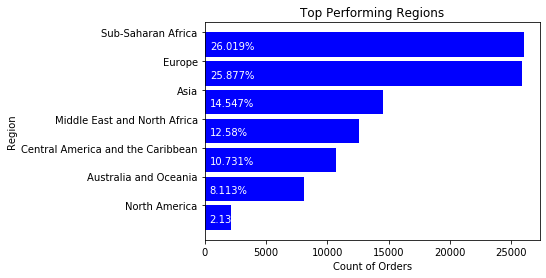

In [261]:
top_performing_region = clean_sales_data.groupby(['Region'])["Profit_Loss"].count().to_frame('OrderCount').reset_index()
top_performing_region["Order_Share"] = 100*top_performing_region["OrderCount"]/sum(top_performing_region["OrderCount"])
top_performing_region.sort_values(by= "Order_Share", ascending=True, inplace=True)

x = top_performing_region["Region"]
y = top_performing_region["OrderCount"]
y_percent = top_performing_region["Order_Share"]
fig, ax = plt.subplots()    
width = 0.85 # the width of the bars 
ind = np.arange(len(y))  # the x locations for the groups
ax.barh(ind, y, width, color="blue")
ax.set_yticks(ind+width/2)
ax.set_yticklabels(x, minor=False)

for i, v in enumerate(y_percent):
    ax.text(v + 400, i -0.15, str(v)+"%", color='white')
    
plt.title('Top Performing Regions')
plt.xlabel('Count of Orders')
plt.ylabel('Region')      
plt.show()


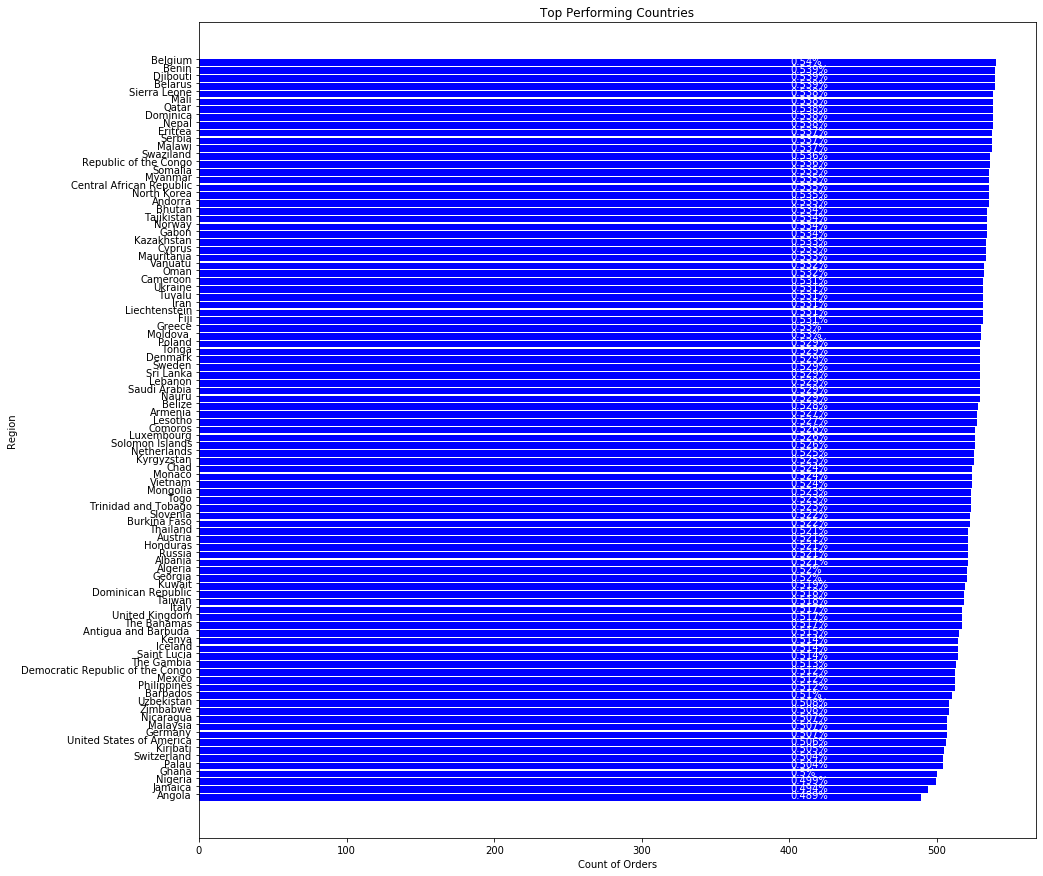

In [281]:
top_performing_country = clean_sales_data.groupby(['Country'])["Profit_Loss"].count().to_frame('OrderCount').reset_index()
top_performing_country["Order_Share"] = 100*top_performing_country["OrderCount"]/sum(top_performing_country["OrderCount"])
top_performing_country.sort_values(by= "Order_Share", ascending=True, inplace=True)
top_performing_country["Cumm_Order_Share"] = top_performing_country["Order_Share"].cumsum(axis = 0)

top_performing_country_plot = top_performing_country[top_performing_country["Cumm_Order_Share"]<50.0]


x = top_performing_country_plot["Country"]
y = top_performing_country_plot["OrderCount"]
y_percent = top_performing_country_plot["Order_Share"]
fig, ax = plt.subplots(figsize=(15,15))    
width = 0.85 # the width of the bars 
ind = np.arange(len(y))  # the x locations for the groups
ax.barh(ind, y, width, color="blue")
ax.set_yticks(ind+width/2)
ax.set_yticklabels(x, minor=False)


for i, v in enumerate(y_percent):
    ax.text(v + 400, i -0.15, str(v)+"%", color='white')

plt.title('Top Performing Countries')
plt.xlabel('Count of Orders')
plt.ylabel('Region')      
plt.show()


49946 49.946
50054 50.054


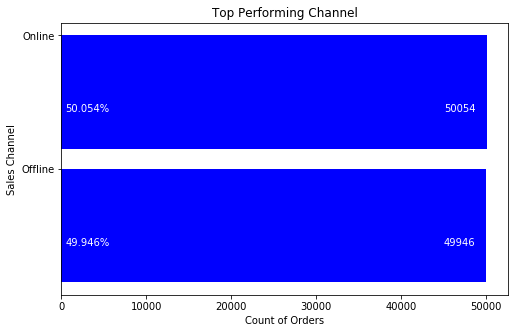

In [296]:
top_performing_channel = clean_sales_data.groupby(['Sales Channel'])["Profit_Loss"].count().to_frame('OrderCount').reset_index()
top_performing_channel["Order_Share"] = 100*top_performing_channel["OrderCount"]/sum(top_performing_channel["OrderCount"])
top_performing_channel.sort_values(by= "Order_Share", ascending=True, inplace=True)
top_performing_channel["Cumm_Order_Share"] = top_performing_channel["Order_Share"].cumsum(axis = 0)

#top_performing_country_plot = top_performing_country[top_performing_country["Cumm_Order_Share"]<50.0]

x = top_performing_channel["Sales Channel"]
y = top_performing_channel["OrderCount"]
y_percent = top_performing_channel["Order_Share"]
fig, ax = plt.subplots(figsize=(8,5))    
width = 0.85 # the width of the bars 
ind = np.arange(len(y))  # the x locations for the groups
ax.barh(ind, y, width, color="blue")
ax.set_yticks(ind+width/2)
ax.set_yticklabels(x, minor=False)


for i, v in enumerate(y_percent):
    ax.text(v + 400, i -0.15, str(v)+"%", color='white')
    ax.text(y[i] - 5000 , i - 0.15, str(y[i]), color='white')
    print(y[i],v)

plt.title('Top Performing Channel')
plt.xlabel('Count of Orders')
plt.ylabel('Sales Channel')      
plt.show()


In [297]:
top_performing_item = clean_sales_data.groupby(['Item Type'])["Profit_Loss"].count().to_frame('OrderCount').reset_index()
top_performing_item["Order_Share"] = 100*top_performing_item["OrderCount"]/sum(top_performing_item["OrderCount"])
top_performing_item.sort_values(by= "Order_Share", ascending=True, inplace=True)
top_performing_item["Cumm_Order_Share"] = top_performing_item["Order_Share"].cumsum(axis = 0)

#top_performing_country_plot = top_performing_country[top_performing_country["Cumm_Order_Share"]<50.0]

x = top_performing_item["Item Type"]
y = top_performing_item["OrderCount"]
y_percent = top_performing_item["Order_Share"]
fig, ax = plt.subplots(figsize=(8,5))    
width = 0.85 # the width of the bars 
ind = np.arange(len(y))  # the x locations for the groups
ax.barh(ind, y, width, color="blue")
ax.set_yticks(ind+width/2)
ax.set_yticklabels(x, minor=False)


for i, v in enumerate(y_percent):
    ax.text(v + 400, i -0.15, str(v)+"%", color='white')
    ax.text(y[i] - 5000 , i - 0.15, str(y[i]), color='white')
    print(y[i],v)

plt.title('Top Performing Channel')
plt.xlabel('Count of Orders')
plt.ylabel('Sales Channel')      
plt.show()

Region                Country      Item Type  \
1       Middle East and North Africa             Azerbaijan         Snacks   
2  Central America and the Caribbean                 Panama      Cosmetics   
3                 Sub-Saharan Africa  Sao Tome and Principe         Fruits   
4                 Sub-Saharan Africa  Sao Tome and Principe  Personal Care   
5  Central America and the Caribbean                 Belize      Household   

  Sales Channel Order Priority Order Date (mm-dd-yyyy)   Order ID  \
1        Online              C                   41861  535113847   
2       Offline              L               2/22/2015  874708545   
3       Offline              M                   42259  854349935   
4        Online              M               9/17/2014  892836844   
5       Offline              H                   40270  129280602   

  Ship Date (mm-dd-yyyy)  Units Sold  Sale Price Per Unit (USD)  ...  \
1             10/23/2014         934                     152.58  ...   
2              2/27/2015        4551                     437.20  ...   
3              1/18/2016        9986                       9.33  ...   
4                  41983        9118                      81.73  ...   
5                  40301        5858                     668.27  ...   

  Cost_per_Unit Shipment_TAT  Order_Value  Encoded_Delay  Goodwill_Amt  \
1       91.5480            3    142509.72      GT_7_Days             0   
2      284.1800            9   1989697.20         5_Days           114   
3        6.2511           11     93169.38      GT_7_Days             0   
4       64.5667            9    745214.14      GT_7_Days             0   
5      467.7890            7   3914725.66      GT_7_Days             0   

   INR_Rate    Cost_Price  Selling_Price   Profit_Loss  PorL  
1     68.94  5.894772e+06   9.824620e+06  3.929848e+06     P  
2     69.34  8.968555e+07   1.379656e+08  4.828006e+07     P  
3     69.34  4.328444e+06   6.460365e+06  2.131920e+06     P  
4     68.94  4.058630e+07   5.137506e+07  1.078876e+07     P  
5     68.00  1.863409e+08   2.662013e+08  7.986040e+07     P  

[5 rows x 23 columns]